In [1]:
import tensorflow as tf
import random
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, applications, Sequential, Model, backend
from tensorflow.keras import optimizers, initializers, regularizers, metrics, utils

# ResNet50

load ResNet50

In [2]:
HEIGHT = 512
WIDTH = 512
class_num = 1
input_shape = (HEIGHT,WIDTH,3)

In [3]:
base_model = applications.ResNet50(include_top=False, input_shape=input_shape, weights=None, pooling='avg')
    
x = base_model.output
x = layers.Dense(1000, activation="softmax")(x)
resnet50 = Model(base_model.input, x)

#freeze layer
for layer in resnet50.layers:
    layer.trainable = False

#load pre_trained weight
resnet50.load_weights("resnet50_ImageNet.h5")

#unfreeze layer
for layer in resnet50.layers[:174]:
    layer.trainable = True

In [4]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

extract feature C1~C5

In [5]:
C1 = resnet50.get_layer('pool1_pad').output
C2 = resnet50.get_layer('conv2_block3_out').output
C3 = resnet50.get_layer('conv3_block4_out').output
C4 = resnet50.get_layer('conv4_block6_out').output
C5 = resnet50.get_layer('conv5_block3_out').output

# Feature Pyramid Network

In [6]:
def P5(x, train_bn=True):
    x = layers.Conv2D(256, (1,1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    return x

def FPN(x, y, train_bn=True):
    x = layers.Conv2D(256, (1,1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    y = layers.UpSampling2D()(y)
    
    P = layers.Add()([x, y])
    
    return P

In [7]:
P5 = P5(C5)
P4 = FPN(C4, P5)
P3 = FPN(C3, P4)
P2 = FPN(C2, P3)

In [8]:
def FM(x, upsampling, train_bn=True):
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    if upsampling != 1:
        x = layers.Conv2DTranspose(128, (3, 3), strides=(upsampling, upsampling), padding='same')(x)
        x = layers.BatchNormalization()(x, training=train_bn)
        x = layers.Activation('relu')(x)
    
    return x

feature map

In [9]:
FM5 = FM(P5, 8)
FM4 = FM(P4, 4)
FM3 = FM(P3, 2)
FM2 = FM(P2, 1)
FM = layers.concatenate([FM5, FM4, FM3, FM2])
FM.shape

TensorShape([None, 128, 128, 512])

pooling

In [10]:
FM = layers.MaxPool2D(pool_size=(8,8))(FM)
FM.shape

TensorShape([None, 16, 16, 512])

In [11]:
def Mask_Head(x, train_bn=True):
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(class_num, (1, 1), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('sigmoid')(x)
    
    x = layers.UpSampling2D(size=(16,16),interpolation='bilinear')(x)
    
    return x

In [12]:
Mask_output = Mask_Head(FM)
Mask_output.shape

TensorShape([None, 512, 512, 1])

make model

In [13]:
NADS_Net = Model(resnet50.input, Mask_output)
NADS_Net = utils.multi_gpu_model(NADS_Net, gpus=2)

Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.


In [14]:
NADS_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512, 512, 1)  37293829    lambda[0][0]                     
                                                                 lambda_1[0][0]             

example image

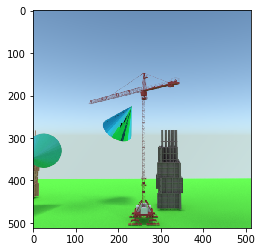

In [15]:
img = plt.imread('./camera20034.png')
plt.imshow(img)

In [16]:
img = tf.reshape(img, (1, 512, 512, 3))
img = tf.cast(img, dtype=tf.float32)

In [17]:
example = NADS_Net(img)
example.shape

TensorShape([1, 512, 512, 1])

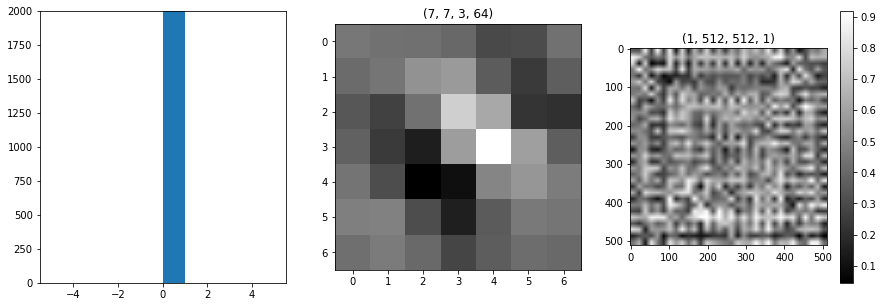

In [18]:
weight = NADS_Net.get_weights()[0]

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(example.numpy().ravel(), range=[-5,5])
plt.ylim(0, 2000)
plt.subplot(132)
plt.title(weight.shape)
plt.imshow(weight[:,:,0,0], 'gray')
plt.subplot(133)
plt.title(example.shape)
plt.imshow(example[0, :, :, 0], 'gray')
plt.colorbar()
plt.show()

# Load image dataset

In [19]:
train_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/train/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/test/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/val/*.png')

In [20]:
def get_label(path):
    label_name = path[-15:-4]
    label_path = 'C:/Users/IVCL/Desktop/dock5_DR/classify_semantic/%s.png'%label_name
    label = plt.imread(label_path)
    label = label[...,tf.newaxis]
    label = tf.cast(label, dtype=tf.float32)
    
    return label

In [21]:
def read_image(path):
    #read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [HEIGHT, WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = (image / 127.5) - 1
    
    return image

In [22]:
def make_batch(batch_paths):
    batch_images = []
    batch_labels = []
        
    for path in batch_paths:
        image = read_image(path)
        batch_images.append(image)
        
        label = get_label(path)
        batch_labels.append(label)
    
    return tf.convert_to_tensor(batch_images), tf.convert_to_tensor(batch_labels)

In [24]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    test_input = test_input[tf.newaxis, ...]
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[:,:,0], tf.where(prediction[0,:,:,0]>=0.5,1.0,0)]
    
    title = ['Input Image', 'Ground Truth', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

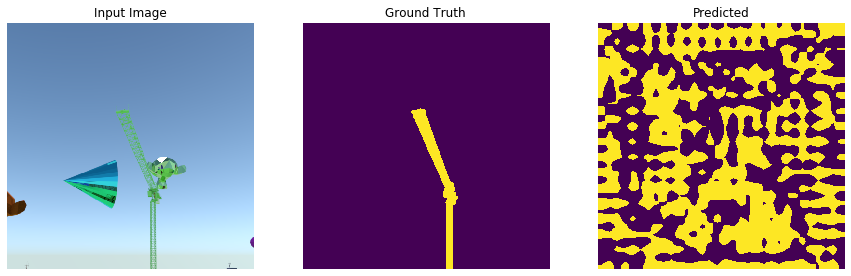

In [25]:
image = read_image(train_paths[0])
label = get_label(train_paths[0])
generate_images(NADS_Net, image, label)

# Define Loss and Optimizer

In [26]:
# Define loss and optimizer
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

# Metrics

In [27]:
def precision(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_positive = tf.reduce_sum(pred)
    
    precision = true_positive / (true_positive_false_positive + tf.keras.backend.epsilon())
                                 
    return precision

                                 
def recall(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_negative = tf.reduce_sum(truth)
    
    recall = true_positive / (true_positive_false_negative + tf.keras.backend.epsilon())
                                 
    return recall

# Checkpoint

In [28]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, NADS_Net=NADS_Net)

# Train

In [29]:
#Hyperparameter
BATCH_SIZE = 2
EPOCHS = 20
train_steps_per_epoch = len(train_paths) // BATCH_SIZE
val_steps_per_epoch = len(val_paths)

In [30]:
@tf.function
#def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
def train_step(model, images, labels, loss_object, optimizer, train_loss):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
       
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    #train_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

# Implement algorithm test
@tf.function
#def val_step(model, images, labels, loss_object, val_loss, val_accuracy):
def val_step(model, images, labels, loss_object, val_loss):
    predictions = model(images, training=False)
    
    v_loss = loss_object(labels, predictions)
    val_loss(v_loss)
    #val_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

In [30]:
loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    random.shuffle(train_paths)
    
    train_loss_sum = 0
    val_loss_sum = 0
        
    for step in range(train_steps_per_epoch):
        images, labels = make_batch(train_paths[step * BATCH_SIZE : (step + 1) * BATCH_SIZE])
        
        train_precision, train_recall = train_step(NADS_Net, images, labels, loss_object, optimizer, train_loss)
        
        #template = 'Step {}, Loss: {}, Accuracy: {}'
        template = 'Epoch {}, Step {}, Loss: {}, Precision: {}, Recall: {}'
        print(template.format(epoch + 1, step + 1,
                              train_loss.result(),
                              train_precision * 100,
                              train_recall * 100))

        train_loss_sum = train_loss_sum + train_loss.result()
        
        train_loss.reset_states()
        val_loss.reset_states()
       
    for step in range(val_steps_per_epoch):
        val_images, val_labels = make_batch(val_paths[step * 1 : (step + 1) * 1])
        
        val_precision, val_recall = val_step(NADS_Net, val_images, val_labels, loss_object, val_loss)
        
        val_loss_sum = val_loss_sum + val_loss.result()    
    
    loss_list.append(train_loss_sum / len(train_paths))
    val_loss_list.append(val_loss_sum / len(val_paths))
    
    #template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
    template = 'Epoch {}, Val_Loss: {}, Val_Precision: {}, Val_Recall: {}'
    print(template.format(epoch + 1,
                          val_loss_sum / len(val_paths),
                          val_precision * 100,
                          val_recall * 100))
    train_loss.reset_states()
    val_loss.reset_states()
  
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 1, Step 1, Loss: 0.7322052717208862, Precision: 6.396873474121094, Recall: 54.38749694824219
Epoch 1, Step 2, Loss: 0.6719106435775757, Precision: 10.783026695251465, Recall: 97.42203521728516
Epoch 1, Step 3, Loss: 0.6622648239135742, Precision: 13.54694938659668, Recall: 49.29417037963867
Epoch 1, Step 4, Loss: 0.6512455940246582, Precision: 13.59907341003418, Recall: 50.07921600341797
Epoch 1, Step 5, Loss: 0.6410709619522095, Precision: 26.427221298217773, Recall: 50.57169723510742
Epoch 1, Step 6, Loss: 0.6380009651184082, Precision: 21.950603485107422, Recall: 57.12358474731445
Epoch 1, Step 7, Loss: 0.6253976821899414, Precision: 27.85857391357422, Recall: 68.60803985595703
Epoch 1, Step 8, Loss: 0.6336432695388794, Precision: 22.99493408203125, Recall: 68.9227066040039
Epoch 1, Step 9, Loss: 0.6283442974090576, Precision: 22.655725479125977, Recall: 79.11272430419922
Epoch 1, Step 10, Loss: 0.6421495676040649, Precision: 13.857425689697266, Recall: 79.94390106201172
Epoch

Epoch 1, Step 83, Loss: 0.5949764251708984, Precision: 26.917055130004883, Recall: 97.94414520263672
Epoch 1, Step 84, Loss: 0.5599249601364136, Precision: 48.51245880126953, Recall: 98.08009338378906
Epoch 1, Step 85, Loss: 0.5842165350914001, Precision: 32.30923843383789, Recall: 92.35671997070312
Epoch 1, Step 86, Loss: 0.5831899046897888, Precision: 34.36270523071289, Recall: 99.60681915283203
Epoch 1, Step 87, Loss: 0.598900318145752, Precision: 22.338380813598633, Recall: 87.66099548339844
Epoch 1, Step 88, Loss: 0.5476930141448975, Precision: 63.75702667236328, Recall: 85.34822082519531
Epoch 1, Step 89, Loss: 0.562606155872345, Precision: 51.30638885498047, Recall: 89.24617004394531
Epoch 1, Step 90, Loss: 0.6020886898040771, Precision: 14.771437644958496, Recall: 88.99972534179688
Epoch 1, Step 91, Loss: 0.5663759112358093, Precision: 39.726112365722656, Recall: 93.91297912597656
Epoch 1, Step 92, Loss: 0.5798766613006592, Precision: 30.947282791137695, Recall: 97.009193420410

Epoch 1, Step 165, Loss: 0.5474924445152283, Precision: 36.813087463378906, Recall: 98.09361267089844
Epoch 1, Step 166, Loss: 0.5179427862167358, Precision: 49.07300567626953, Recall: 98.91339111328125
Epoch 1, Step 167, Loss: 0.5270833969116211, Precision: 50.42377853393555, Recall: 97.38270568847656
Epoch 1, Step 168, Loss: 0.5400866270065308, Precision: 39.02519226074219, Recall: 96.14045715332031
Epoch 1, Step 169, Loss: 0.5227789878845215, Precision: 44.26332473754883, Recall: 98.34883117675781
Epoch 1, Step 170, Loss: 0.536697268486023, Precision: 40.54987716674805, Recall: 93.75267791748047
Epoch 1, Step 171, Loss: 0.5454645752906799, Precision: 31.33316993713379, Recall: 98.04573822021484
Epoch 1, Step 172, Loss: 0.5346966981887817, Precision: 41.40937423706055, Recall: 95.8984146118164
Epoch 1, Step 173, Loss: 0.5341576933860779, Precision: 38.12621307373047, Recall: 91.90852355957031
Epoch 1, Step 174, Loss: 0.5198057889938354, Precision: 52.019874572753906, Recall: 95.53587

Epoch 1, Step 247, Loss: 0.48042455315589905, Precision: 73.8683853149414, Recall: 93.19120025634766
Epoch 1, Step 248, Loss: 0.5051954984664917, Precision: 43.83515548706055, Recall: 92.83381652832031
Epoch 1, Step 249, Loss: 0.5082013607025146, Precision: 45.58103942871094, Recall: 81.76976776123047
Epoch 1, Step 250, Loss: 0.4779345989227295, Precision: 60.37569808959961, Recall: 94.75444793701172
Epoch 1, Step 251, Loss: 0.5391654968261719, Precision: 25.067794799804688, Recall: 96.63436889648438
Epoch 1, Step 252, Loss: 0.5234982967376709, Precision: 30.78082275390625, Recall: 94.26756286621094
Epoch 1, Step 253, Loss: 0.47652098536491394, Precision: 57.930625915527344, Recall: 94.82559204101562
Epoch 1, Step 254, Loss: 0.507189154624939, Precision: 37.757606506347656, Recall: 99.80070495605469
Epoch 1, Step 255, Loss: 0.4567972719669342, Precision: 71.16841888427734, Recall: 90.84264373779297
Epoch 1, Step 256, Loss: 0.4544302225112915, Precision: 66.48785400390625, Recall: 93.66

Epoch 1, Step 329, Loss: 0.4593246877193451, Precision: 63.69123458862305, Recall: 61.825347900390625
Epoch 1, Step 330, Loss: 0.43987441062927246, Precision: 61.18729019165039, Recall: 97.30682373046875
Epoch 1, Step 331, Loss: 0.4510155916213989, Precision: 53.45783233642578, Recall: 99.37120819091797
Epoch 1, Step 332, Loss: 0.44019317626953125, Precision: 55.63585662841797, Recall: 98.84553527832031
Epoch 1, Step 333, Loss: 0.44124335050582886, Precision: 64.67741394042969, Recall: 99.66217803955078
Epoch 1, Step 334, Loss: 0.47940704226493835, Precision: 37.41840744018555, Recall: 97.39037322998047
Epoch 1, Step 335, Loss: 0.4428598880767822, Precision: 53.175086975097656, Recall: 95.05862426757812
Epoch 1, Step 336, Loss: 0.457902193069458, Precision: 41.57363510131836, Recall: 98.72857666015625
Epoch 1, Step 337, Loss: 0.391102135181427, Precision: 78.57809448242188, Recall: 94.8014907836914
Epoch 1, Step 338, Loss: 0.4831281304359436, Precision: 29.767114639282227, Recall: 94.4

Epoch 1, Step 411, Loss: 0.4340232014656067, Precision: 55.08881378173828, Recall: 94.218017578125
Epoch 1, Step 412, Loss: 0.43024516105651855, Precision: 50.90489196777344, Recall: 99.70855712890625
Epoch 1, Step 413, Loss: 0.43315017223358154, Precision: 51.04643249511719, Recall: 99.49691009521484
Epoch 1, Step 414, Loss: 0.4262610673904419, Precision: 53.33542251586914, Recall: 97.35466003417969
Epoch 1, Step 415, Loss: 0.4225033223628998, Precision: 62.78839874267578, Recall: 96.14510345458984
Epoch 1, Step 416, Loss: 0.45595285296440125, Precision: 31.799232482910156, Recall: 98.96342468261719
Epoch 1, Step 417, Loss: 0.4160345792770386, Precision: 56.61320495605469, Recall: 99.49346160888672
Epoch 1, Step 418, Loss: 0.40669482946395874, Precision: 65.15577697753906, Recall: 97.6041488647461
Epoch 1, Step 419, Loss: 0.3757573366165161, Precision: 75.93382263183594, Recall: 93.39217376708984
Epoch 1, Step 420, Loss: 0.4211762249469757, Precision: 50.97300338745117, Recall: 97.897

Epoch 1, Step 493, Loss: 0.4222605228424072, Precision: 41.76801681518555, Recall: 94.1434326171875
Epoch 1, Step 494, Loss: 0.4008691906929016, Precision: 62.9415168762207, Recall: 96.94534301757812
Epoch 1, Step 495, Loss: 0.41407647728919983, Precision: 58.96992111206055, Recall: 76.52703094482422
Epoch 1, Step 496, Loss: 0.4218798875808716, Precision: 46.940406799316406, Recall: 91.96110534667969
Epoch 1, Step 497, Loss: 0.40298616886138916, Precision: 54.54484939575195, Recall: 92.54823303222656
Epoch 1, Step 498, Loss: 0.38487935066223145, Precision: 64.24888610839844, Recall: 93.59520721435547
Epoch 1, Step 499, Loss: 0.37799906730651855, Precision: 70.20722961425781, Recall: 89.5283432006836
Epoch 1, Step 500, Loss: 0.38205933570861816, Precision: 63.20702362060547, Recall: 97.63130187988281
Epoch 1, Step 501, Loss: 0.3919304609298706, Precision: 54.926307678222656, Recall: 98.61833190917969
Epoch 1, Step 502, Loss: 0.3927772343158722, Precision: 54.17560958862305, Recall: 97.0

Epoch 1, Step 575, Loss: 0.3851357698440552, Precision: 60.637569427490234, Recall: 94.53252410888672
Epoch 1, Step 576, Loss: 0.42475563287734985, Precision: 35.08636474609375, Recall: 98.38134002685547
Epoch 1, Step 577, Loss: 0.40385210514068604, Precision: 36.4963493347168, Recall: 92.31940460205078
Epoch 1, Step 578, Loss: 0.37347298860549927, Precision: 62.494667053222656, Recall: 86.44796752929688
Epoch 1, Step 579, Loss: 0.380193293094635, Precision: 55.495365142822266, Recall: 95.7014389038086
Epoch 1, Step 580, Loss: 0.3311423659324646, Precision: 77.17005920410156, Recall: 95.32701873779297
Epoch 1, Step 581, Loss: 0.36851245164871216, Precision: 62.23731231689453, Recall: 95.20276641845703
Epoch 1, Step 582, Loss: 0.37767675518989563, Precision: 59.4620361328125, Recall: 85.9433822631836
Epoch 1, Step 583, Loss: 0.39383551478385925, Precision: 42.49357604980469, Recall: 97.51820373535156
Epoch 1, Step 584, Loss: 0.3934814929962158, Precision: 43.84184265136719, Recall: 95.4

Epoch 1, Step 657, Loss: 0.38251182436943054, Precision: 39.94524002075195, Recall: 94.87324523925781
Epoch 1, Step 658, Loss: 0.33731693029403687, Precision: 62.659568786621094, Recall: 97.16095733642578
Epoch 1, Step 659, Loss: 0.3748279809951782, Precision: 46.018306732177734, Recall: 94.60639190673828
Epoch 1, Step 660, Loss: 0.34945148229599, Precision: 57.393638610839844, Recall: 96.76605224609375
Epoch 1, Step 661, Loss: 0.3513805866241455, Precision: 64.76220703125, Recall: 96.13164520263672
Epoch 1, Step 662, Loss: 0.3237738609313965, Precision: 75.53093719482422, Recall: 96.40144348144531
Epoch 1, Step 663, Loss: 0.34455418586730957, Precision: 57.38605880737305, Recall: 97.747802734375
Epoch 1, Step 664, Loss: 0.3606066107749939, Precision: 55.1109733581543, Recall: 82.19977569580078
Epoch 1, Step 665, Loss: 0.36423662304878235, Precision: 49.7474365234375, Recall: 95.48885345458984
Epoch 1, Step 666, Loss: 0.3810330033302307, Precision: 41.11615753173828, Recall: 95.7336502

Epoch 1, Step 739, Loss: 0.3381848931312561, Precision: 73.09783935546875, Recall: 69.48063659667969
Epoch 1, Step 740, Loss: 0.35248640179634094, Precision: 50.3427848815918, Recall: 84.78425598144531
Epoch 1, Step 741, Loss: 0.3607546389102936, Precision: 51.567543029785156, Recall: 70.27645874023438
Epoch 1, Step 742, Loss: 0.34024935960769653, Precision: 55.395729064941406, Recall: 96.12779235839844
Epoch 1, Step 743, Loss: 0.3361207842826843, Precision: 58.572505950927734, Recall: 89.66312408447266
Epoch 1, Step 744, Loss: 0.35009294748306274, Precision: 55.335533142089844, Recall: 89.21603393554688
Epoch 1, Step 745, Loss: 0.35048678517341614, Precision: 49.5990104675293, Recall: 96.19493103027344
Epoch 1, Step 746, Loss: 0.3335527777671814, Precision: 62.62562942504883, Recall: 93.6381607055664
Epoch 1, Step 747, Loss: 0.3273480534553528, Precision: 59.00944519042969, Recall: 96.63888549804688
Epoch 1, Step 748, Loss: 0.34427160024642944, Precision: 50.909297943115234, Recall: 9

Epoch 1, Step 821, Loss: 0.2988954484462738, Precision: 64.35348510742188, Recall: 98.87669372558594
Epoch 1, Step 822, Loss: 0.30274054408073425, Precision: 70.50338745117188, Recall: 97.07585144042969
Epoch 1, Step 823, Loss: 0.33572402596473694, Precision: 40.93209457397461, Recall: 94.98806762695312
Epoch 1, Step 824, Loss: 0.3030867278575897, Precision: 73.17545318603516, Recall: 85.66295623779297
Epoch 1, Step 825, Loss: 0.30166250467300415, Precision: 65.57833862304688, Recall: 98.18628692626953
Epoch 1, Step 826, Loss: 0.3187543451786041, Precision: 59.920291900634766, Recall: 95.16104125976562
Epoch 1, Step 827, Loss: 0.30587834119796753, Precision: 66.13021087646484, Recall: 91.22064971923828
Epoch 1, Step 828, Loss: 0.3213796615600586, Precision: 51.85426330566406, Recall: 90.76903533935547
Epoch 1, Step 829, Loss: 0.3284440040588379, Precision: 58.05880355834961, Recall: 86.05838775634766
Epoch 1, Step 830, Loss: 0.30536243319511414, Precision: 65.8544692993164, Recall: 95.

Epoch 1, Step 903, Loss: 0.28360307216644287, Precision: 68.62039184570312, Recall: 95.44599151611328
Epoch 1, Step 904, Loss: 0.3150099217891693, Precision: 54.93070983886719, Recall: 95.62220764160156
Epoch 1, Step 905, Loss: 0.2851521670818329, Precision: 73.85503387451172, Recall: 90.22026824951172
Epoch 1, Step 906, Loss: 0.30846530199050903, Precision: 57.69831466674805, Recall: 96.99449920654297
Epoch 1, Step 907, Loss: 0.30488067865371704, Precision: 56.130836486816406, Recall: 92.50194549560547
Epoch 1, Step 908, Loss: 0.28986096382141113, Precision: 68.19568634033203, Recall: 96.47683715820312
Epoch 1, Step 909, Loss: 0.27730226516723633, Precision: 78.40113830566406, Recall: 87.98928833007812
Epoch 1, Step 910, Loss: 0.2875414490699768, Precision: 65.09925079345703, Recall: 92.12696075439453
Epoch 1, Step 911, Loss: 0.3005501329898834, Precision: 56.435977935791016, Recall: 96.3563232421875
Epoch 1, Step 912, Loss: 0.27241867780685425, Precision: 77.26461029052734, Recall: 8

Epoch 1, Step 985, Loss: 0.2699980139732361, Precision: 71.90869140625, Recall: 83.62255859375
Epoch 1, Step 986, Loss: 0.30343014001846313, Precision: 44.69321823120117, Recall: 96.92262268066406
Epoch 1, Step 987, Loss: 0.2601337730884552, Precision: 75.34159088134766, Recall: 95.80812072753906
Epoch 1, Step 988, Loss: 0.2853440046310425, Precision: 60.11670684814453, Recall: 95.57948303222656
Epoch 1, Step 989, Loss: 0.2887415587902069, Precision: 58.28359603881836, Recall: 94.27355194091797
Epoch 1, Step 990, Loss: 0.29478728771209717, Precision: 67.74937438964844, Recall: 82.78401184082031
Epoch 1, Step 991, Loss: 0.27429917454719543, Precision: 63.703285217285156, Recall: 96.6356201171875
Epoch 1, Step 992, Loss: 0.29482540488243103, Precision: 55.00950622558594, Recall: 96.06256866455078
Epoch 1, Step 993, Loss: 0.2968418300151825, Precision: 57.814395904541016, Recall: 97.59577941894531
Epoch 1, Step 994, Loss: 0.296933650970459, Precision: 52.671634674072266, Recall: 89.157272

Epoch 1, Step 1067, Loss: 0.2862633466720581, Precision: 46.80698776245117, Recall: 89.46141815185547
Epoch 1, Step 1068, Loss: 0.263378769159317, Precision: 65.93729400634766, Recall: 95.67603302001953
Epoch 1, Step 1069, Loss: 0.25131261348724365, Precision: 69.37095642089844, Recall: 92.41228485107422
Epoch 1, Step 1070, Loss: 0.28492826223373413, Precision: 51.80168151855469, Recall: 95.00316619873047
Epoch 1, Step 1071, Loss: 0.27982836961746216, Precision: 55.427467346191406, Recall: 94.99971008300781
Epoch 1, Step 1072, Loss: 0.3165106773376465, Precision: 30.55438995361328, Recall: 99.49312591552734
Epoch 1, Step 1073, Loss: 0.27726051211357117, Precision: 56.450714111328125, Recall: 98.4017562866211
Epoch 1, Step 1074, Loss: 0.2839874029159546, Precision: 51.58297348022461, Recall: 91.95571899414062
Epoch 1, Step 1075, Loss: 0.27001893520355225, Precision: 78.74332427978516, Recall: 73.16326904296875
Epoch 1, Step 1076, Loss: 0.2588258683681488, Precision: 69.8811264038086, Re

Epoch 1, Step 1149, Loss: 0.2907755970954895, Precision: 36.737728118896484, Recall: 83.5361099243164
Epoch 1, Step 1150, Loss: 0.23646730184555054, Precision: 72.07643127441406, Recall: 96.27925872802734
Epoch 1, Step 1151, Loss: 0.22426506876945496, Precision: 81.26798248291016, Recall: 90.21626281738281
Epoch 1, Step 1152, Loss: 0.27027690410614014, Precision: 54.28270721435547, Recall: 88.22661590576172
Epoch 1, Step 1153, Loss: 0.25717177987098694, Precision: 62.43646240234375, Recall: 95.99311065673828
Epoch 1, Step 1154, Loss: 0.2450769543647766, Precision: 67.5943832397461, Recall: 94.39934539794922
Epoch 1, Step 1155, Loss: 0.26518958806991577, Precision: 56.30203628540039, Recall: 87.75995635986328
Epoch 1, Step 1156, Loss: 0.23437337577342987, Precision: 74.5757827758789, Recall: 95.69863891601562
Epoch 1, Step 1157, Loss: 0.2586366832256317, Precision: 63.719581604003906, Recall: 91.84947967529297
Epoch 1, Step 1158, Loss: 0.2499193251132965, Precision: 68.46426391601562, R

Epoch 1, Step 1231, Loss: 0.2319607436656952, Precision: 72.9400863647461, Recall: 88.90216064453125
Epoch 1, Step 1232, Loss: 0.2414526790380478, Precision: 62.598480224609375, Recall: 95.92147827148438
Epoch 1, Step 1233, Loss: 0.23133905231952667, Precision: 73.69410705566406, Recall: 92.10296630859375
Epoch 1, Step 1234, Loss: 0.24072995781898499, Precision: 60.07001876831055, Recall: 94.85192108154297
Epoch 1, Step 1235, Loss: 0.24893303215503693, Precision: 58.591453552246094, Recall: 93.27801513671875
Epoch 1, Step 1236, Loss: 0.24141058325767517, Precision: 63.83186721801758, Recall: 93.42353820800781
Epoch 1, Step 1237, Loss: 0.23464766144752502, Precision: 72.95008850097656, Recall: 93.60780334472656
Epoch 1, Step 1238, Loss: 0.25972163677215576, Precision: 47.143104553222656, Recall: 96.75247955322266
Epoch 1, Step 1239, Loss: 0.2529839277267456, Precision: 60.821990966796875, Recall: 95.44354248046875
Epoch 1, Step 1240, Loss: 0.23798125982284546, Precision: 66.531280517578

Epoch 1, Step 1311, Loss: 0.24044710397720337, Precision: 60.70083236694336, Recall: 88.94254302978516
Epoch 1, Step 1312, Loss: 0.23199708759784698, Precision: 59.178131103515625, Recall: 95.42036437988281
Epoch 1, Step 1313, Loss: 0.21859532594680786, Precision: 72.74748992919922, Recall: 95.574462890625
Epoch 1, Step 1314, Loss: 0.23930849134922028, Precision: 60.2894287109375, Recall: 89.97593688964844
Epoch 1, Step 1315, Loss: 0.22434988617897034, Precision: 66.81857299804688, Recall: 95.93665313720703
Epoch 1, Step 1316, Loss: 0.2448207288980484, Precision: 54.113502502441406, Recall: 82.66221618652344
Epoch 1, Step 1317, Loss: 0.22804926335811615, Precision: 68.70570373535156, Recall: 84.769775390625
Epoch 1, Step 1318, Loss: 0.22738760709762573, Precision: 69.11383056640625, Recall: 98.3251953125
Epoch 1, Step 1319, Loss: 0.22730837762355804, Precision: 65.09912109375, Recall: 91.7616195678711
Epoch 1, Step 1320, Loss: 0.21776477992534637, Precision: 71.125732421875, Recall: 97

Epoch 1, Step 1393, Loss: 0.22299593687057495, Precision: 65.03720092773438, Recall: 89.39089965820312
Epoch 1, Step 1394, Loss: 0.20812657475471497, Precision: 75.27841186523438, Recall: 89.61494445800781
Epoch 1, Step 1395, Loss: 0.22153674066066742, Precision: 59.717742919921875, Recall: 93.93125915527344
Epoch 1, Step 1396, Loss: 0.23242899775505066, Precision: 57.056854248046875, Recall: 82.82149505615234
Epoch 1, Step 1397, Loss: 0.21447885036468506, Precision: 69.38134765625, Recall: 90.9212417602539
Epoch 1, Step 1398, Loss: 0.21636034548282623, Precision: 70.25981903076172, Recall: 93.14366149902344
Epoch 1, Step 1399, Loss: 0.2297869473695755, Precision: 70.60153198242188, Recall: 84.47354888916016
Epoch 1, Step 1400, Loss: 0.22677898406982422, Precision: 70.80452728271484, Recall: 87.41735076904297
Epoch 1, Step 1401, Loss: 0.2018657624721527, Precision: 72.90902709960938, Recall: 93.81299591064453
Epoch 1, Step 1402, Loss: 0.21442589163780212, Precision: 63.9541015625, Reca

Epoch 1, Step 1475, Loss: 0.2130330502986908, Precision: 62.310970306396484, Recall: 92.09416198730469
Epoch 1, Step 1476, Loss: 0.22529296576976776, Precision: 47.07371139526367, Recall: 96.37305450439453
Epoch 1, Step 1477, Loss: 0.18930314481258392, Precision: 80.10040283203125, Recall: 90.3865737915039
Epoch 1, Step 1478, Loss: 0.20997649431228638, Precision: 80.85467529296875, Recall: 77.05936431884766
Epoch 1, Step 1479, Loss: 0.2031623125076294, Precision: 68.98118591308594, Recall: 90.3545913696289
Epoch 1, Step 1480, Loss: 0.21530097723007202, Precision: 61.291568756103516, Recall: 93.1484603881836
Epoch 1, Step 1481, Loss: 0.21270997822284698, Precision: 62.788902282714844, Recall: 83.6755599975586
Epoch 1, Step 1482, Loss: 0.19900262355804443, Precision: 67.65318298339844, Recall: 97.11710357666016
Epoch 1, Step 1483, Loss: 0.20988604426383972, Precision: 65.13356018066406, Recall: 90.63629913330078
Epoch 1, Step 1484, Loss: 0.21613876521587372, Precision: 58.55533981323242,

Epoch 1, Step 1555, Loss: 0.18782608211040497, Precision: 72.45157623291016, Recall: 94.85935974121094
Epoch 1, Step 1556, Loss: 0.20726826786994934, Precision: 61.39820861816406, Recall: 95.6528549194336
Epoch 1, Step 1557, Loss: 0.19769386947155, Precision: 70.75318145751953, Recall: 86.97320556640625
Epoch 1, Step 1558, Loss: 0.20231181383132935, Precision: 74.4168472290039, Recall: 92.452392578125
Epoch 1, Step 1559, Loss: 0.19006487727165222, Precision: 72.19965362548828, Recall: 96.96403503417969
Epoch 1, Step 1560, Loss: 0.2113598883152008, Precision: 53.83031463623047, Recall: 93.73451232910156
Epoch 1, Step 1561, Loss: 0.21330107748508453, Precision: 56.67515563964844, Recall: 92.32730102539062
Epoch 1, Step 1562, Loss: 0.18816372752189636, Precision: 77.0555648803711, Recall: 96.0989990234375
Epoch 1, Step 1563, Loss: 0.18124553561210632, Precision: 80.28975677490234, Recall: 90.58570098876953
Epoch 1, Step 1564, Loss: 0.1847819685935974, Precision: 77.36553192138672, Recall:

Epoch 1, Step 1637, Loss: 0.19191721081733704, Precision: 62.697242736816406, Recall: 97.20491790771484
Epoch 1, Step 1638, Loss: 0.19118234515190125, Precision: 65.75495910644531, Recall: 97.6684341430664
Epoch 1, Step 1639, Loss: 0.18021300435066223, Precision: 75.74642181396484, Recall: 94.93304443359375
Epoch 1, Step 1640, Loss: 0.19825872778892517, Precision: 66.99955749511719, Recall: 88.62631225585938
Epoch 1, Step 1641, Loss: 0.19520491361618042, Precision: 59.5935173034668, Recall: 91.22998809814453
Epoch 1, Step 1642, Loss: 0.1919131875038147, Precision: 66.45464324951172, Recall: 95.28677368164062
Epoch 1, Step 1643, Loss: 0.17818577587604523, Precision: 80.06456756591797, Recall: 90.28564453125
Epoch 1, Step 1644, Loss: 0.20294852554798126, Precision: 57.519710540771484, Recall: 88.7575454711914
Epoch 1, Step 1645, Loss: 0.20755502581596375, Precision: 50.392181396484375, Recall: 91.68193054199219
Epoch 1, Step 1646, Loss: 0.18300756812095642, Precision: 74.09573364257812, 

Epoch 1, Step 1719, Loss: 0.16091477870941162, Precision: 79.01234436035156, Recall: 95.73310852050781
Epoch 1, Step 1720, Loss: 0.18474946916103363, Precision: 72.2177963256836, Recall: 95.12592315673828
Epoch 1, Step 1721, Loss: 0.17629948258399963, Precision: 70.0152359008789, Recall: 93.68476867675781
Epoch 1, Step 1722, Loss: 0.17547175288200378, Precision: 72.40277862548828, Recall: 95.10807800292969
Epoch 1, Step 1723, Loss: 0.17251375317573547, Precision: 83.25750732421875, Recall: 86.23314666748047
Epoch 1, Step 1724, Loss: 0.17654025554656982, Precision: 72.89958953857422, Recall: 89.49791717529297
Epoch 1, Step 1725, Loss: 0.18899822235107422, Precision: 75.78654479980469, Recall: 78.10365295410156
Epoch 1, Step 1726, Loss: 0.2261178195476532, Precision: 34.91071319580078, Recall: 92.52057647705078
Epoch 1, Step 1727, Loss: 0.1548219621181488, Precision: 86.39212036132812, Recall: 92.11852264404297
Epoch 1, Step 1728, Loss: 0.17847968637943268, Precision: 69.97695922851562, 

Epoch 1, Step 1801, Loss: 0.1816059947013855, Precision: 65.14904022216797, Recall: 89.33795928955078
Epoch 1, Step 1802, Loss: 0.1841689795255661, Precision: 64.87742614746094, Recall: 87.41404724121094
Epoch 1, Step 1803, Loss: 0.17282001674175262, Precision: 76.59730529785156, Recall: 81.90959167480469
Epoch 1, Step 1804, Loss: 0.1919003278017044, Precision: 56.49740219116211, Recall: 89.47284698486328
Epoch 1, Step 1805, Loss: 0.15877005457878113, Precision: 78.68816375732422, Recall: 93.59326171875
Epoch 1, Step 1806, Loss: 0.1891358196735382, Precision: 50.131927490234375, Recall: 92.18328857421875
Epoch 1, Step 1807, Loss: 0.16879387199878693, Precision: 74.6943588256836, Recall: 93.73382568359375
Epoch 1, Step 1808, Loss: 0.17341022193431854, Precision: 67.6141586303711, Recall: 94.09054565429688
Epoch 1, Step 1809, Loss: 0.15992464125156403, Precision: 80.80298614501953, Recall: 88.40711975097656
Epoch 1, Step 1810, Loss: 0.17123009264469147, Precision: 70.3905258178711, Recal

Epoch 1, Step 1883, Loss: 0.15664367377758026, Precision: 76.90519714355469, Recall: 95.06951141357422
Epoch 1, Step 1884, Loss: 0.15989190340042114, Precision: 74.88719177246094, Recall: 92.97418212890625
Epoch 1, Step 1885, Loss: 0.14345061779022217, Precision: 86.99121856689453, Recall: 92.85250854492188
Epoch 1, Step 1886, Loss: 0.1726793348789215, Precision: 67.97187042236328, Recall: 79.47901153564453
Epoch 1, Step 1887, Loss: 0.15756778419017792, Precision: 76.45012664794922, Recall: 94.68466186523438
Epoch 1, Step 1888, Loss: 0.1718650758266449, Precision: 64.65071868896484, Recall: 91.09902954101562
Epoch 1, Step 1889, Loss: 0.1597101390361786, Precision: 78.92449188232422, Recall: 89.6004867553711
Epoch 1, Step 1890, Loss: 0.1605137437582016, Precision: 71.15776824951172, Recall: 97.02694702148438
Epoch 1, Step 1891, Loss: 0.1670113503932953, Precision: 72.04711151123047, Recall: 85.72370147705078
Epoch 1, Step 1892, Loss: 0.15893396735191345, Precision: 75.1234359741211, Rec

Epoch 1, Step 1965, Loss: 0.16429564356803894, Precision: 68.71558380126953, Recall: 88.48579406738281
Epoch 1, Step 1966, Loss: 0.1641908437013626, Precision: 68.4031982421875, Recall: 88.36420440673828
Epoch 1, Step 1967, Loss: 0.16973485052585602, Precision: 63.66241455078125, Recall: 94.09873962402344
Epoch 1, Step 1968, Loss: 0.16022786498069763, Precision: 68.05867004394531, Recall: 94.39466857910156
Epoch 1, Step 1969, Loss: 0.16408586502075195, Precision: 69.2627182006836, Recall: 91.89762115478516
Epoch 1, Step 1970, Loss: 0.15309378504753113, Precision: 76.4848861694336, Recall: 91.486083984375
Epoch 1, Step 1971, Loss: 0.16878411173820496, Precision: 63.527732849121094, Recall: 88.94941711425781
Epoch 1, Step 1972, Loss: 0.15912100672721863, Precision: 70.913818359375, Recall: 90.28724670410156
Epoch 1, Step 1973, Loss: 0.14660942554473877, Precision: 79.05834197998047, Recall: 95.29447937011719
Epoch 1, Step 1974, Loss: 0.15733492374420166, Precision: 67.97138214111328, Rec

Epoch 1, Step 2047, Loss: 0.1557581126689911, Precision: 70.2323226928711, Recall: 90.08653259277344
Epoch 1, Step 2048, Loss: 0.15589281916618347, Precision: 77.16490936279297, Recall: 80.88568115234375
Epoch 1, Step 2049, Loss: 0.14752326905727386, Precision: 75.52970886230469, Recall: 88.95167541503906
Epoch 1, Step 2050, Loss: 0.16131997108459473, Precision: 68.60778045654297, Recall: 82.42562103271484
Epoch 1, Step 2051, Loss: 0.16168758273124695, Precision: 67.98399353027344, Recall: 83.02338409423828
Epoch 1, Step 2052, Loss: 0.14109982550144196, Precision: 77.51274871826172, Recall: 94.97651672363281
Epoch 1, Step 2053, Loss: 0.14445063471794128, Precision: 80.44652557373047, Recall: 88.59378814697266
Epoch 1, Step 2054, Loss: 0.16307741403579712, Precision: 66.39700317382812, Recall: 82.8301773071289
Epoch 1, Step 2055, Loss: 0.1545064002275467, Precision: 71.26702117919922, Recall: 89.05460357666016
Epoch 1, Step 2056, Loss: 0.14269521832466125, Precision: 90.59407043457031, 

Epoch 1, Step 2129, Loss: 0.1456984281539917, Precision: 75.51020050048828, Recall: 86.37762451171875
Epoch 1, Step 2130, Loss: 0.1530824899673462, Precision: 72.348876953125, Recall: 85.2270278930664
Epoch 1, Step 2131, Loss: 0.1411416232585907, Precision: 81.35753631591797, Recall: 88.58792114257812
Epoch 1, Step 2132, Loss: 0.15404844284057617, Precision: 65.48003387451172, Recall: 92.76972961425781
Epoch 1, Step 2133, Loss: 0.15582305192947388, Precision: 61.702301025390625, Recall: 92.07508850097656
Epoch 1, Step 2134, Loss: 0.1382696032524109, Precision: 82.27723693847656, Recall: 87.8807601928711
Epoch 1, Step 2135, Loss: 0.1385270059108734, Precision: 77.60831451416016, Recall: 92.31847381591797
Epoch 1, Step 2136, Loss: 0.14637407660484314, Precision: 70.45381927490234, Recall: 91.90953063964844
Epoch 1, Step 2137, Loss: 0.1464928686618805, Precision: 79.87994384765625, Recall: 85.7281265258789
Epoch 1, Step 2138, Loss: 0.13932384550571442, Precision: 88.78681945800781, Recall

Epoch 1, Step 2211, Loss: 0.14638535678386688, Precision: 83.29872131347656, Recall: 79.91720581054688
Epoch 1, Step 2212, Loss: 0.13981503248214722, Precision: 71.39259338378906, Recall: 95.60427856445312
Epoch 1, Step 2213, Loss: 0.13629859685897827, Precision: 78.51815032958984, Recall: 90.99610137939453
Epoch 1, Step 2214, Loss: 0.1739160567522049, Precision: 47.41724395751953, Recall: 94.54644775390625
Epoch 1, Step 2215, Loss: 0.14625434577465057, Precision: 64.57301330566406, Recall: 93.13274383544922
Epoch 1, Step 2216, Loss: 0.16510356962680817, Precision: 54.42866134643555, Recall: 92.09140014648438
Epoch 1, Step 2217, Loss: 0.14470747113227844, Precision: 77.35761260986328, Recall: 89.27747344970703
Epoch 1, Step 2218, Loss: 0.1485932171344757, Precision: 63.50102996826172, Recall: 87.38421630859375
Epoch 1, Step 2219, Loss: 0.1483507752418518, Precision: 66.65754699707031, Recall: 87.62322998046875
Epoch 1, Step 2220, Loss: 0.1513720452785492, Precision: 77.38357543945312, 

Epoch 1, Step 2293, Loss: 0.13218043744564056, Precision: 72.57915496826172, Recall: 91.63500213623047
Epoch 1, Step 2294, Loss: 0.13218602538108826, Precision: 76.85498046875, Recall: 92.66944122314453
Epoch 1, Step 2295, Loss: 0.14452756941318512, Precision: 61.71315383911133, Recall: 92.50628662109375
Epoch 1, Step 2296, Loss: 0.1455954611301422, Precision: 67.29936218261719, Recall: 81.92161560058594
Epoch 1, Step 2297, Loss: 0.1373428851366043, Precision: 71.12455749511719, Recall: 89.47270202636719
Epoch 1, Step 2298, Loss: 0.13532336056232452, Precision: 70.69928741455078, Recall: 90.89523315429688
Epoch 1, Step 2299, Loss: 0.12139657139778137, Precision: 86.50346374511719, Recall: 88.25507354736328
Epoch 1, Step 2300, Loss: 0.12492065876722336, Precision: 80.04688262939453, Recall: 89.41018676757812
Epoch 1, Step 2301, Loss: 0.14781171083450317, Precision: 58.7535514831543, Recall: 87.88844299316406
Epoch 1, Step 2302, Loss: 0.12635688483715057, Precision: 77.17337036132812, Re

Epoch 1, Step 2375, Loss: 0.13919460773468018, Precision: 62.48617935180664, Recall: 89.36329650878906
Epoch 1, Step 2376, Loss: 0.13191866874694824, Precision: 70.77307891845703, Recall: 91.82201385498047
Epoch 1, Step 2377, Loss: 0.12873829901218414, Precision: 74.89379119873047, Recall: 86.89640045166016
Epoch 1, Step 2378, Loss: 0.11899731308221817, Precision: 85.03378295898438, Recall: 89.81800842285156
Epoch 1, Step 2379, Loss: 0.12284894287586212, Precision: 87.05817413330078, Recall: 90.35760498046875
Epoch 1, Step 2380, Loss: 0.13093478977680206, Precision: 73.41974639892578, Recall: 89.69280242919922
Epoch 1, Step 2381, Loss: 0.12536558508872986, Precision: 84.9331283569336, Recall: 85.02342987060547
Epoch 1, Step 2382, Loss: 0.12161949276924133, Precision: 86.75496673583984, Recall: 89.46311950683594
Epoch 1, Step 2383, Loss: 0.13459821045398712, Precision: 71.61141204833984, Recall: 89.025146484375
Epoch 1, Step 2384, Loss: 0.134063720703125, Precision: 72.790283203125, Rec

Epoch 1, Step 2457, Loss: 0.1311749368906021, Precision: 71.95975494384766, Recall: 86.57231903076172
Epoch 1, Step 2458, Loss: 0.12931692600250244, Precision: 68.70350646972656, Recall: 95.07426452636719
Epoch 1, Step 2459, Loss: 0.12967154383659363, Precision: 64.24639129638672, Recall: 91.36382293701172
Epoch 1, Step 2460, Loss: 0.12977826595306396, Precision: 75.77750396728516, Recall: 85.2835922241211
Epoch 1, Step 2461, Loss: 0.1229180321097374, Precision: 74.70647430419922, Recall: 95.34680938720703
Epoch 1, Step 2462, Loss: 0.125430628657341, Precision: 74.40833282470703, Recall: 93.74555206298828
Epoch 1, Step 2463, Loss: 0.12230602651834488, Precision: 77.03517150878906, Recall: 92.12525939941406
Epoch 1, Step 2464, Loss: 0.11732180416584015, Precision: 83.63883209228516, Recall: 89.49066162109375
Epoch 1, Step 2465, Loss: 0.1274869740009308, Precision: 82.9849624633789, Recall: 85.2821273803711
Epoch 1, Step 2466, Loss: 0.13554814457893372, Precision: 65.47674560546875, Reca

Epoch 1, Step 2539, Loss: 0.11531183123588562, Precision: 76.31706237792969, Recall: 94.45306396484375
Epoch 1, Step 2540, Loss: 0.1180822029709816, Precision: 77.85460662841797, Recall: 92.15608978271484
Epoch 1, Step 2541, Loss: 0.14243865013122559, Precision: 42.32294845581055, Recall: 91.25328063964844
Epoch 1, Step 2542, Loss: 0.11480115354061127, Precision: 83.80380249023438, Recall: 90.76302337646484
Epoch 1, Step 2543, Loss: 0.12722688913345337, Precision: 63.908809661865234, Recall: 88.42533874511719
Epoch 1, Step 2544, Loss: 0.1423412710428238, Precision: 62.425445556640625, Recall: 74.80905151367188
Epoch 1, Step 2545, Loss: 0.12235832214355469, Precision: 74.49735260009766, Recall: 82.07254028320312
Epoch 1, Step 2546, Loss: 0.11272305250167847, Precision: 83.33921813964844, Recall: 90.21732330322266
Epoch 1, Step 2547, Loss: 0.10806086659431458, Precision: 86.07486724853516, Recall: 89.635498046875
Epoch 1, Step 2548, Loss: 0.11067316681146622, Precision: 88.12360382080078

Epoch 1, Step 2619, Loss: 0.1159142255783081, Precision: 75.8041000366211, Recall: 88.57640075683594
Epoch 1, Step 2620, Loss: 0.11880829930305481, Precision: 73.12804412841797, Recall: 88.08052062988281
Epoch 1, Step 2621, Loss: 0.12794992327690125, Precision: 67.11325073242188, Recall: 89.92231750488281
Epoch 1, Step 2622, Loss: 0.11749477684497833, Precision: 75.63340759277344, Recall: 91.052001953125
Epoch 1, Step 2623, Loss: 0.12008574604988098, Precision: 68.6589126586914, Recall: 94.52687072753906
Epoch 1, Step 2624, Loss: 0.12174370884895325, Precision: 69.93883514404297, Recall: 90.53224182128906
Epoch 1, Step 2625, Loss: 0.10795900970697403, Precision: 84.76239776611328, Recall: 92.60982513427734
Epoch 1, Step 2626, Loss: 0.11885414272546768, Precision: 70.2632827758789, Recall: 92.29124450683594
Epoch 1, Step 2627, Loss: 0.12213080376386642, Precision: 80.1556396484375, Recall: 85.90723419189453
Epoch 1, Step 2628, Loss: 0.12386266887187958, Precision: 65.40319061279297, Rec

Epoch 1, Step 2701, Loss: 0.11643964052200317, Precision: 72.46441650390625, Recall: 89.72843170166016
Epoch 1, Step 2702, Loss: 0.11623644828796387, Precision: 69.3702392578125, Recall: 93.57530212402344
Epoch 1, Step 2703, Loss: 0.11098768562078476, Precision: 87.3597412109375, Recall: 87.47088623046875
Epoch 1, Step 2704, Loss: 0.10377421975135803, Precision: 78.45201873779297, Recall: 94.26165771484375
Epoch 1, Step 2705, Loss: 0.12695476412773132, Precision: 80.94872283935547, Recall: 68.62461853027344
Epoch 1, Step 2706, Loss: 0.1310841143131256, Precision: 61.71532440185547, Recall: 78.93487548828125
Epoch 1, Step 2707, Loss: 0.10848216712474823, Precision: 85.84927368164062, Recall: 84.81558227539062
Epoch 1, Step 2708, Loss: 0.11300543695688248, Precision: 73.06743621826172, Recall: 87.88497924804688
Epoch 1, Step 2709, Loss: 0.10402306914329529, Precision: 84.58966827392578, Recall: 92.59388732910156
Epoch 1, Step 2710, Loss: 0.11828330159187317, Precision: 77.78558349609375,

Epoch 1, Step 2781, Loss: 0.11831771582365036, Precision: 72.69905853271484, Recall: 84.89508056640625
Epoch 1, Step 2782, Loss: 0.1125950962305069, Precision: 75.55990600585938, Recall: 87.93489837646484
Epoch 1, Step 2783, Loss: 0.11395199596881866, Precision: 67.60612487792969, Recall: 91.17938232421875
Epoch 1, Step 2784, Loss: 0.10669150948524475, Precision: 75.05364227294922, Recall: 90.16755676269531
Epoch 1, Step 2785, Loss: 0.11098957806825638, Precision: 70.80537414550781, Recall: 90.82280731201172
Epoch 1, Step 2786, Loss: 0.11103100329637527, Precision: 67.91963958740234, Recall: 92.89179992675781
Epoch 1, Step 2787, Loss: 0.1079229861497879, Precision: 78.7503662109375, Recall: 86.19076538085938
Epoch 1, Step 2788, Loss: 0.10376501083374023, Precision: 84.47389221191406, Recall: 91.98554992675781
Epoch 1, Step 2789, Loss: 0.10723210126161575, Precision: 76.72651672363281, Recall: 91.35393524169922
Epoch 1, Step 2790, Loss: 0.12806124985218048, Precision: 65.14444732666016,

Epoch 1, Step 2863, Loss: 0.12227680534124374, Precision: 60.487701416015625, Recall: 82.53572845458984
Epoch 1, Step 2864, Loss: 0.10906364768743515, Precision: 79.00040435791016, Recall: 84.39991760253906
Epoch 1, Step 2865, Loss: 0.10387413203716278, Precision: 84.90867614746094, Recall: 85.29663848876953
Epoch 1, Step 2866, Loss: 0.11340030282735825, Precision: 75.81365966796875, Recall: 80.91925048828125
Epoch 1, Step 2867, Loss: 0.10408877581357956, Precision: 81.02458953857422, Recall: 88.20450592041016
Epoch 1, Step 2868, Loss: 0.10036356747150421, Precision: 81.30064392089844, Recall: 91.86308288574219
Epoch 1, Step 2869, Loss: 0.10675166547298431, Precision: 76.4101791381836, Recall: 88.51313018798828
Epoch 1, Step 2870, Loss: 0.10468469560146332, Precision: 74.62751007080078, Recall: 89.28311157226562
Epoch 1, Step 2871, Loss: 0.1105492040514946, Precision: 65.83324432373047, Recall: 87.63554382324219
Epoch 1, Step 2872, Loss: 0.11275884509086609, Precision: 71.5947265625, R

Epoch 1, Step 2943, Loss: 0.09941276162862778, Precision: 80.05777740478516, Recall: 91.74357604980469
Epoch 1, Step 2944, Loss: 0.10517923533916473, Precision: 73.42329406738281, Recall: 92.43000793457031
Epoch 1, Step 2945, Loss: 0.10783736407756805, Precision: 70.52091217041016, Recall: 89.7177734375
Epoch 1, Step 2946, Loss: 0.09092751145362854, Precision: 90.08018493652344, Recall: 92.4847183227539
Epoch 1, Step 2947, Loss: 0.09964936226606369, Precision: 76.60588073730469, Recall: 92.83844757080078
Epoch 1, Step 2948, Loss: 0.09900566190481186, Precision: 81.78529357910156, Recall: 90.6175537109375
Epoch 1, Step 2949, Loss: 0.0983646959066391, Precision: 80.1769027709961, Recall: 92.57872009277344
Epoch 1, Step 2950, Loss: 0.10534125566482544, Precision: 68.9468765258789, Recall: 86.8393783569336
Epoch 1, Step 2951, Loss: 0.11074455082416534, Precision: 68.3663330078125, Recall: 84.03585052490234
Epoch 1, Step 2952, Loss: 0.10647867619991302, Precision: 76.72898864746094, Recall:

Epoch 1, Step 3023, Loss: 0.10852394253015518, Precision: 73.22129821777344, Recall: 89.81839752197266
Epoch 1, Step 3024, Loss: 0.09007605910301208, Precision: 87.83287811279297, Recall: 92.68912506103516
Epoch 1, Step 3025, Loss: 0.10840700566768646, Precision: 65.81257629394531, Recall: 87.2872314453125
Epoch 1, Step 3026, Loss: 0.10219956934452057, Precision: 70.30354309082031, Recall: 87.19253540039062
Epoch 1, Step 3027, Loss: 0.11320821940898895, Precision: 62.67449188232422, Recall: 81.92254638671875
Epoch 1, Step 3028, Loss: 0.10761256515979767, Precision: 79.94566345214844, Recall: 81.3498764038086
Epoch 1, Step 3029, Loss: 0.09732235223054886, Precision: 78.1246337890625, Recall: 89.98065948486328
Epoch 1, Step 3030, Loss: 0.11378374695777893, Precision: 59.1364631652832, Recall: 81.24557495117188
Epoch 1, Step 3031, Loss: 0.09845231473445892, Precision: 79.75080871582031, Recall: 84.63581085205078
Epoch 1, Step 3032, Loss: 0.10293401032686234, Precision: 75.65592956542969, 

Epoch 1, Step 3103, Loss: 0.10235816985368729, Precision: 74.12549591064453, Recall: 86.70246887207031
Epoch 1, Step 3104, Loss: 0.09773489087820053, Precision: 78.05408477783203, Recall: 91.45555114746094
Epoch 1, Step 3105, Loss: 0.0981953889131546, Precision: 79.43744659423828, Recall: 90.0828857421875
Epoch 1, Step 3106, Loss: 0.10264945030212402, Precision: 73.30610656738281, Recall: 93.58943939208984
Epoch 1, Step 3107, Loss: 0.09355618059635162, Precision: 83.70011901855469, Recall: 91.36052703857422
Epoch 1, Step 3108, Loss: 0.10068461298942566, Precision: 76.3262710571289, Recall: 87.23661041259766
Epoch 1, Step 3109, Loss: 0.09484072029590607, Precision: 73.18218231201172, Recall: 92.62273406982422
Epoch 1, Step 3110, Loss: 0.10183852910995483, Precision: 83.52385711669922, Recall: 83.61659240722656
Epoch 1, Step 3111, Loss: 0.11480851471424103, Precision: 69.37583923339844, Recall: 86.9594955444336
Epoch 1, Step 3112, Loss: 0.10180098563432693, Precision: 65.32555389404297, 

Epoch 1, Step 3185, Loss: 0.0958193987607956, Precision: 73.50780487060547, Recall: 84.33694458007812
Epoch 1, Step 3186, Loss: 0.08262576162815094, Precision: 88.70502471923828, Recall: 95.0179672241211
Epoch 1, Step 3187, Loss: 0.10089641064405441, Precision: 82.01859283447266, Recall: 88.43576049804688
Epoch 1, Step 3188, Loss: 0.09195233136415482, Precision: 85.38129425048828, Recall: 86.79033660888672
Epoch 1, Step 3189, Loss: 0.1069219559431076, Precision: 56.880836486816406, Recall: 88.1299057006836
Epoch 1, Step 3190, Loss: 0.09863527119159698, Precision: 89.6131362915039, Recall: 84.33734893798828
Epoch 1, Step 3191, Loss: 0.08876554667949677, Precision: 85.39630126953125, Recall: 88.89054107666016
Epoch 1, Step 3192, Loss: 0.08940474689006805, Precision: 79.05680847167969, Recall: 88.7176513671875
Epoch 1, Step 3193, Loss: 0.09659244120121002, Precision: 83.75910186767578, Recall: 81.38797760009766
Epoch 1, Step 3194, Loss: 0.10105697810649872, Precision: 74.66928100585938, R

Epoch 1, Step 3267, Loss: 0.09713473916053772, Precision: 73.17316436767578, Recall: 86.67545318603516
Epoch 1, Step 3268, Loss: 0.09541358053684235, Precision: 70.99403381347656, Recall: 94.53946685791016
Epoch 1, Step 3269, Loss: 0.08679351210594177, Precision: 83.31371307373047, Recall: 89.19966125488281
Epoch 1, Step 3270, Loss: 0.09674140810966492, Precision: 76.68905639648438, Recall: 86.70928192138672
Epoch 1, Step 3271, Loss: 0.09146231412887573, Precision: 78.81922149658203, Recall: 86.17304992675781
Epoch 1, Step 3272, Loss: 0.09144560992717743, Precision: 80.87959289550781, Recall: 82.51104736328125
Epoch 1, Step 3273, Loss: 0.1047537624835968, Precision: 68.75492095947266, Recall: 84.14613342285156
Epoch 1, Step 3274, Loss: 0.0889400988817215, Precision: 81.24679565429688, Recall: 86.21727752685547
Epoch 1, Step 3275, Loss: 0.10438704490661621, Precision: 61.542171478271484, Recall: 72.5465087890625
Epoch 1, Step 3276, Loss: 0.08889219909906387, Precision: 82.77135467529297

Epoch 1, Step 3349, Loss: 0.09380263090133667, Precision: 72.32990264892578, Recall: 88.91600036621094
Epoch 1, Step 3350, Loss: 0.08472757041454315, Precision: 91.88059997558594, Recall: 85.17133331298828
Epoch 1, Step 3351, Loss: 0.08795402944087982, Precision: 81.3274917602539, Recall: 86.1136474609375
Epoch 1, Step 3352, Loss: 0.08444102853536606, Precision: 84.37890625, Recall: 89.85015106201172
Epoch 1, Step 3353, Loss: 0.09653086215257645, Precision: 77.46806335449219, Recall: 85.14705657958984
Epoch 1, Step 3354, Loss: 0.08727909624576569, Precision: 76.1278305053711, Recall: 85.98885345458984
Epoch 1, Step 3355, Loss: 0.08908974379301071, Precision: 77.43476104736328, Recall: 86.26982879638672
Epoch 1, Step 3356, Loss: 0.09315024316310883, Precision: 75.81571197509766, Recall: 82.87113952636719
Epoch 1, Step 3357, Loss: 0.09947193413972855, Precision: 46.14289474487305, Recall: 84.6970443725586
Epoch 1, Step 3358, Loss: 0.25408676266670227, Precision: 89.09711456298828, Recall

Epoch 1, Step 3431, Loss: 0.0885053426027298, Precision: 78.62066650390625, Recall: 88.11431884765625
Epoch 1, Step 3432, Loss: 0.11719568073749542, Precision: 69.7628173828125, Recall: 67.29403686523438
Epoch 1, Step 3433, Loss: 0.09917379915714264, Precision: 63.59581756591797, Recall: 81.18647766113281
Epoch 1, Step 3434, Loss: 0.08652056008577347, Precision: 74.79290008544922, Recall: 86.80281829833984
Epoch 1, Step 3435, Loss: 0.08843932300806046, Precision: 79.27625274658203, Recall: 85.95098876953125
Epoch 1, Step 3436, Loss: 0.09191486239433289, Precision: 66.64823150634766, Recall: 84.4058837890625
Epoch 1, Step 3437, Loss: 0.0988040566444397, Precision: 71.67105865478516, Recall: 76.10602569580078
Epoch 1, Step 3438, Loss: 0.09239014983177185, Precision: 74.37657928466797, Recall: 76.11161804199219
Epoch 1, Step 3439, Loss: 0.09430927038192749, Precision: 76.41698455810547, Recall: 75.15568542480469
Epoch 1, Step 3440, Loss: 0.09515650570392609, Precision: 78.05765533447266, 

Epoch 1, Step 3513, Loss: 0.0807306095957756, Precision: 88.62760925292969, Recall: 92.81707763671875
Epoch 1, Step 3514, Loss: 0.13077613711357117, Precision: 53.94041061401367, Recall: 91.64295196533203
Epoch 1, Step 3515, Loss: 0.08677402883768082, Precision: 69.91169738769531, Recall: 84.9132080078125
Epoch 1, Step 3516, Loss: 0.08907832950353622, Precision: 63.11168670654297, Recall: 85.66838836669922
Epoch 1, Step 3517, Loss: 0.08721501380205154, Precision: 77.74971771240234, Recall: 81.81559753417969
Epoch 1, Step 3518, Loss: 0.08759406954050064, Precision: 74.9569320678711, Recall: 86.00043487548828
Epoch 1, Step 3519, Loss: 0.0875588208436966, Precision: 84.58555603027344, Recall: 85.73543548583984
Epoch 1, Step 3520, Loss: 0.0828777551651001, Precision: 83.60028076171875, Recall: 87.34121704101562
Epoch 1, Step 3521, Loss: 0.08254106342792511, Precision: 74.53949737548828, Recall: 90.30912780761719
Epoch 1, Step 3522, Loss: 0.0923975259065628, Precision: 72.39616394042969, Re

Epoch 1, Step 3593, Loss: 0.08337315917015076, Precision: 81.2195816040039, Recall: 83.08736419677734
Epoch 1, Step 3594, Loss: 0.08241881430149078, Precision: 72.32456970214844, Recall: 83.57257843017578
Epoch 1, Step 3595, Loss: 0.09528562426567078, Precision: 73.87800598144531, Recall: 81.28311920166016
Epoch 1, Step 3596, Loss: 0.08761477470397949, Precision: 80.37071990966797, Recall: 83.63231658935547
Epoch 1, Step 3597, Loss: 0.08032415062189102, Precision: 78.30994415283203, Recall: 89.43658447265625
Epoch 1, Step 3598, Loss: 0.0801505595445633, Precision: 75.92874908447266, Recall: 87.44009399414062
Epoch 1, Step 3599, Loss: 0.09643284976482391, Precision: 66.84761810302734, Recall: 82.89681243896484
Epoch 1, Step 3600, Loss: 0.08578387647867203, Precision: 83.85174560546875, Recall: 78.38681030273438
Epoch 1, Step 3601, Loss: 0.08820968866348267, Precision: 81.52046203613281, Recall: 76.76297760009766
Epoch 1, Step 3602, Loss: 0.08469972014427185, Precision: 68.9643783569336,

Epoch 1, Step 3673, Loss: 0.09671812504529953, Precision: 75.49136352539062, Recall: 80.47335052490234
Epoch 1, Step 3674, Loss: 0.08455345034599304, Precision: 83.47374725341797, Recall: 90.34307861328125
Epoch 1, Step 3675, Loss: 0.08001421391963959, Precision: 82.51310729980469, Recall: 86.29742431640625
Epoch 1, Step 3676, Loss: 0.08269509673118591, Precision: 73.34064483642578, Recall: 87.56119537353516
Epoch 1, Step 3677, Loss: 0.08616869151592255, Precision: 74.54573822021484, Recall: 85.189453125
Epoch 1, Step 3678, Loss: 0.0950206071138382, Precision: 57.71452331542969, Recall: 79.38553619384766
Epoch 1, Step 3679, Loss: 0.08357059955596924, Precision: 74.7530288696289, Recall: 88.56513214111328
Epoch 1, Step 3680, Loss: 0.07947322726249695, Precision: 81.1131362915039, Recall: 91.63516998291016
Epoch 1, Step 3681, Loss: 0.07450355589389801, Precision: 81.90180969238281, Recall: 92.65486907958984
Epoch 1, Step 3682, Loss: 0.09008388221263885, Precision: 77.25172424316406, Reca

Epoch 1, Step 3753, Loss: 0.08208517730236053, Precision: 68.11272430419922, Recall: 88.0334243774414
Epoch 1, Step 3754, Loss: 0.08062538504600525, Precision: 86.39353942871094, Recall: 84.44263458251953
Epoch 1, Step 3755, Loss: 0.07440456748008728, Precision: 84.42086791992188, Recall: 89.51227569580078
Epoch 1, Step 3756, Loss: 0.0903366282582283, Precision: 79.9217758178711, Recall: 82.38427734375
Epoch 1, Step 3757, Loss: 0.09338073432445526, Precision: 59.12800598144531, Recall: 88.9929428100586
Epoch 1, Step 3758, Loss: 0.07759954780340195, Precision: 85.33124542236328, Recall: 86.90743255615234
Epoch 1, Step 3759, Loss: 0.07444629073143005, Precision: 81.68692779541016, Recall: 85.4364013671875
Epoch 1, Step 3760, Loss: 0.08825697004795074, Precision: 63.73974609375, Recall: 81.83931732177734
Epoch 1, Step 3761, Loss: 0.0884028747677803, Precision: 68.51587677001953, Recall: 88.33573150634766
Epoch 1, Step 3762, Loss: 0.0864984467625618, Precision: 67.16535949707031, Recall: 8

Epoch 1, Step 3833, Loss: 0.07320073246955872, Precision: 80.71587371826172, Recall: 94.05888366699219
Epoch 1, Step 3834, Loss: 0.07460172474384308, Precision: 88.06324768066406, Recall: 90.11129760742188
Epoch 1, Step 3835, Loss: 0.0783260315656662, Precision: 62.31509017944336, Recall: 88.24713134765625
Epoch 1, Step 3836, Loss: 0.07670550048351288, Precision: 79.87672424316406, Recall: 85.7149658203125
Epoch 1, Step 3837, Loss: 0.07722926139831543, Precision: 73.64656829833984, Recall: 86.27111053466797
Epoch 1, Step 3838, Loss: 0.07112275809049606, Precision: 85.67146301269531, Recall: 91.89198303222656
Epoch 1, Step 3839, Loss: 0.06828401237726212, Precision: 91.52842712402344, Recall: 90.1668701171875
Epoch 1, Step 3840, Loss: 0.0798887386918068, Precision: 72.09004974365234, Recall: 89.43968963623047
Epoch 1, Step 3841, Loss: 0.09075869619846344, Precision: 65.32011413574219, Recall: 86.53067016601562
Epoch 1, Step 3842, Loss: 0.0736873596906662, Precision: 86.11636352539062, R

Epoch 1, Step 3914, Loss: 0.07074838876724243, Precision: 85.02454376220703, Recall: 92.16778564453125
Epoch 1, Step 3915, Loss: 0.07775451242923737, Precision: 71.83030700683594, Recall: 86.78108215332031
Epoch 1, Step 3916, Loss: 0.07340341061353683, Precision: 75.90438842773438, Recall: 88.4799575805664
Epoch 1, Step 3917, Loss: 0.07169555872678757, Precision: 83.89765930175781, Recall: 85.92149353027344
Epoch 1, Step 3918, Loss: 0.06395012140274048, Precision: 89.30914306640625, Recall: 92.905029296875
Epoch 1, Step 3919, Loss: 0.0734676867723465, Precision: 80.274658203125, Recall: 88.47076416015625
Epoch 1, Step 3920, Loss: 0.07197906076908112, Precision: 74.63064575195312, Recall: 88.33116149902344
Epoch 1, Step 3921, Loss: 0.06796648353338242, Precision: 86.6240234375, Recall: 88.62576293945312
Epoch 1, Step 3922, Loss: 0.08010934293270111, Precision: 76.11741638183594, Recall: 82.46453857421875
Epoch 1, Step 3923, Loss: 0.07507354021072388, Precision: 83.06643676757812, Recall

Epoch 1, Step 3996, Loss: 0.06841236352920532, Precision: 86.96634674072266, Recall: 90.16551971435547
Epoch 1, Step 3997, Loss: 0.08441927284002304, Precision: 72.92843627929688, Recall: 87.9760971069336
Epoch 1, Step 3998, Loss: 0.0840172991156578, Precision: 71.52942657470703, Recall: 76.83194732666016
Epoch 1, Step 3999, Loss: 0.07618249207735062, Precision: 74.57366943359375, Recall: 84.58727264404297
Epoch 1, Step 4000, Loss: 0.07156122475862503, Precision: 82.26537322998047, Recall: 84.43579864501953
Epoch 1, Val_Loss: 0.08219186961650848, Val_Precision: 92.90216827392578, Val_Recall: 90.97950744628906
Epoch 2, Step 1, Loss: 0.07832755148410797, Precision: 73.27827453613281, Recall: 81.0318603515625
Epoch 2, Step 2, Loss: 0.06724216043949127, Precision: 82.14905548095703, Recall: 89.9722900390625
Epoch 2, Step 3, Loss: 0.06677284836769104, Precision: 85.44989013671875, Recall: 88.84612274169922
Epoch 2, Step 4, Loss: 0.08030469715595245, Precision: 82.08987426757812, Recall: 75.

Epoch 2, Step 78, Loss: 0.08511471003293991, Precision: 71.33829498291016, Recall: 75.54644012451172
Epoch 2, Step 79, Loss: 0.07324573397636414, Precision: 76.02827453613281, Recall: 88.56210327148438
Epoch 2, Step 80, Loss: 0.07088124752044678, Precision: 77.85106658935547, Recall: 83.43907165527344
Epoch 2, Step 81, Loss: 0.07909312844276428, Precision: 87.24856567382812, Recall: 76.6434097290039
Epoch 2, Step 82, Loss: 0.07527165114879608, Precision: 72.79207611083984, Recall: 82.11117553710938
Epoch 2, Step 83, Loss: 0.07193297147750854, Precision: 78.11669921875, Recall: 79.53085327148438
Epoch 2, Step 84, Loss: 0.07922271639108658, Precision: 68.20914459228516, Recall: 82.7603759765625
Epoch 2, Step 85, Loss: 0.07206341624259949, Precision: 73.52117156982422, Recall: 84.0436019897461
Epoch 2, Step 86, Loss: 0.06493793427944183, Precision: 89.0783920288086, Recall: 89.4058837890625
Epoch 2, Step 87, Loss: 0.0728139579296112, Precision: 71.95741271972656, Recall: 87.20951080322266

Epoch 2, Step 160, Loss: 0.06897273659706116, Precision: 83.49371337890625, Recall: 89.09952545166016
Epoch 2, Step 161, Loss: 0.08221762627363205, Precision: 75.97657012939453, Recall: 84.72332000732422
Epoch 2, Step 162, Loss: 0.08100040256977081, Precision: 70.351806640625, Recall: 75.3659896850586
Epoch 2, Step 163, Loss: 0.06434321403503418, Precision: 87.864013671875, Recall: 87.73216247558594
Epoch 2, Step 164, Loss: 0.06878602504730225, Precision: 85.5834732055664, Recall: 90.39623260498047
Epoch 2, Step 165, Loss: 0.06317716836929321, Precision: 82.3074722290039, Recall: 85.80754852294922
Epoch 2, Step 166, Loss: 0.07190954685211182, Precision: 74.78963470458984, Recall: 86.17999267578125
Epoch 2, Step 167, Loss: 0.06777939200401306, Precision: 83.50530242919922, Recall: 88.17386627197266
Epoch 2, Step 168, Loss: 0.07851974666118622, Precision: 78.6060562133789, Recall: 83.17930603027344
Epoch 2, Step 169, Loss: 0.07209199666976929, Precision: 85.36316680908203, Recall: 84.787

Epoch 2, Step 242, Loss: 0.06374622881412506, Precision: 83.80470275878906, Recall: 93.03468322753906
Epoch 2, Step 243, Loss: 0.07211832702159882, Precision: 71.32402038574219, Recall: 89.31472778320312
Epoch 2, Step 244, Loss: 0.06578416377305984, Precision: 83.75670623779297, Recall: 90.9719467163086
Epoch 2, Step 245, Loss: 0.06417867541313171, Precision: 84.99172973632812, Recall: 92.58914184570312
Epoch 2, Step 246, Loss: 0.07319837063550949, Precision: 81.57745361328125, Recall: 82.2162094116211
Epoch 2, Step 247, Loss: 0.08037081360816956, Precision: 73.48929595947266, Recall: 86.32571411132812
Epoch 2, Step 248, Loss: 0.10731606930494308, Precision: 67.07379913330078, Recall: 60.05998992919922
Epoch 2, Step 249, Loss: 0.07171275466680527, Precision: 72.79999542236328, Recall: 85.58456420898438
Epoch 2, Step 250, Loss: 0.06562957912683487, Precision: 86.85862731933594, Recall: 86.78239440917969
Epoch 2, Step 251, Loss: 0.0768103301525116, Precision: 72.60493469238281, Recall: 8

Epoch 2, Step 324, Loss: 0.06606235355138779, Precision: 89.58030700683594, Recall: 84.38058471679688
Epoch 2, Step 325, Loss: 0.0658734068274498, Precision: 85.51942443847656, Recall: 87.4778060913086
Epoch 2, Step 326, Loss: 0.0664825290441513, Precision: 83.03565979003906, Recall: 80.19873809814453
Epoch 2, Step 327, Loss: 0.08188745379447937, Precision: 83.92761993408203, Recall: 77.88375854492188
Epoch 2, Step 328, Loss: 0.06560169160366058, Precision: 83.45445251464844, Recall: 81.3825912475586
Epoch 2, Step 329, Loss: 0.06307614594697952, Precision: 83.05259704589844, Recall: 88.17671966552734
Epoch 2, Step 330, Loss: 0.07157644629478455, Precision: 74.86951446533203, Recall: 81.97992706298828
Epoch 2, Step 331, Loss: 0.07019026577472687, Precision: 83.53162384033203, Recall: 92.01929473876953
Epoch 2, Step 332, Loss: 0.06828179955482483, Precision: 88.88260650634766, Recall: 92.60794830322266
Epoch 2, Step 333, Loss: 0.06538106501102448, Precision: 77.0980453491211, Recall: 95.

Epoch 2, Step 406, Loss: 0.058310482650995255, Precision: 86.12232971191406, Recall: 91.47603607177734
Epoch 2, Step 407, Loss: 0.06230533495545387, Precision: 89.56102752685547, Recall: 90.1844482421875
Epoch 2, Step 408, Loss: 0.07586348056793213, Precision: 71.71027374267578, Recall: 86.18107604980469
Epoch 2, Step 409, Loss: 0.0634920746088028, Precision: 77.18372344970703, Recall: 92.65306091308594
Epoch 2, Step 410, Loss: 0.06532639265060425, Precision: 70.90086364746094, Recall: 86.36668395996094
Epoch 2, Step 411, Loss: 0.06470775604248047, Precision: 82.72949981689453, Recall: 88.62259674072266
Epoch 2, Step 412, Loss: 0.0659288838505745, Precision: 80.77496337890625, Recall: 89.69086456298828
Epoch 2, Step 413, Loss: 0.07044421881437302, Precision: 74.54322052001953, Recall: 81.36981964111328
Epoch 2, Step 414, Loss: 0.08076495677232742, Precision: 65.44434356689453, Recall: 82.53180694580078
Epoch 2, Step 415, Loss: 0.06931526213884354, Precision: 71.7313003540039, Recall: 8

Epoch 2, Step 488, Loss: 0.06336955726146698, Precision: 80.7342529296875, Recall: 88.33455657958984
Epoch 2, Step 489, Loss: 0.07192817330360413, Precision: 88.68707275390625, Recall: 85.62606048583984
Epoch 2, Step 490, Loss: 0.06575849652290344, Precision: 75.7473373413086, Recall: 86.51318359375
Epoch 2, Step 491, Loss: 0.06865065544843674, Precision: 79.7072982788086, Recall: 83.75015258789062
Epoch 2, Step 492, Loss: 0.06862509995698929, Precision: 79.86421203613281, Recall: 86.01947784423828
Epoch 2, Step 493, Loss: 0.05963379144668579, Precision: 80.47603607177734, Recall: 85.55067443847656
Epoch 2, Step 494, Loss: 0.06302577257156372, Precision: 82.08234405517578, Recall: 84.38793182373047
Epoch 2, Step 495, Loss: 0.06749236583709717, Precision: 85.79254150390625, Recall: 85.76554107666016
Epoch 2, Step 496, Loss: 0.0607149675488472, Precision: 85.07405090332031, Recall: 89.44235229492188
Epoch 2, Step 497, Loss: 0.07100464403629303, Precision: 73.74925231933594, Recall: 81.13

Epoch 2, Step 570, Loss: 0.06442200392484665, Precision: 68.68573760986328, Recall: 90.18606567382812
Epoch 2, Step 571, Loss: 0.06602898985147476, Precision: 75.1217041015625, Recall: 86.15519714355469
Epoch 2, Step 572, Loss: 0.07061119377613068, Precision: 80.7790298461914, Recall: 84.01683044433594
Epoch 2, Step 573, Loss: 0.06353244185447693, Precision: 72.27658081054688, Recall: 91.654541015625
Epoch 2, Step 574, Loss: 0.05702603608369827, Precision: 70.53865051269531, Recall: 85.53976440429688
Epoch 2, Step 575, Loss: 0.05770741403102875, Precision: 90.75209045410156, Recall: 89.16924285888672
Epoch 2, Step 576, Loss: 0.07734905183315277, Precision: 67.8239974975586, Recall: 75.11405181884766
Epoch 2, Step 577, Loss: 0.0713048130273819, Precision: 87.31551361083984, Recall: 92.54734802246094
Epoch 2, Step 578, Loss: 0.0718889981508255, Precision: 64.59008026123047, Recall: 80.99781036376953
Epoch 2, Step 579, Loss: 0.06125595420598984, Precision: 78.16000366210938, Recall: 87.91

Epoch 2, Step 652, Loss: 0.06360721588134766, Precision: 86.65003967285156, Recall: 86.83006286621094
Epoch 2, Step 653, Loss: 0.06641200184822083, Precision: 70.89999389648438, Recall: 92.91561126708984
Epoch 2, Step 654, Loss: 0.07110099494457245, Precision: 75.3715591430664, Recall: 79.2614974975586
Epoch 2, Step 655, Loss: 0.07125469297170639, Precision: 79.70634460449219, Recall: 80.94947052001953
Epoch 2, Step 656, Loss: 0.06708206236362457, Precision: 84.68885803222656, Recall: 82.14861297607422
Epoch 2, Step 657, Loss: 0.06102101504802704, Precision: 83.08263397216797, Recall: 86.45494842529297
Epoch 2, Step 658, Loss: 0.056009598076343536, Precision: 83.67156982421875, Recall: 87.08804321289062
Epoch 2, Step 659, Loss: 0.05924971029162407, Precision: 85.08561706542969, Recall: 90.72601318359375
Epoch 2, Step 660, Loss: 0.061593569815158844, Precision: 83.25758361816406, Recall: 90.90069580078125
Epoch 2, Step 661, Loss: 0.06314894556999207, Precision: 86.24689483642578, Recall

Epoch 2, Step 734, Loss: 0.05824746564030647, Precision: 78.24296569824219, Recall: 83.21167755126953
Epoch 2, Step 735, Loss: 0.07201902568340302, Precision: 79.1024398803711, Recall: 85.4467544555664
Epoch 2, Step 736, Loss: 0.07428084313869476, Precision: 75.29875946044922, Recall: 93.61421966552734
Epoch 2, Step 737, Loss: 0.05974867194890976, Precision: 74.44783782958984, Recall: 93.59674835205078
Epoch 2, Step 738, Loss: 0.07685419917106628, Precision: 72.92184448242188, Recall: 84.09420776367188
Epoch 2, Step 739, Loss: 0.05703352019190788, Precision: 79.51560974121094, Recall: 85.80158233642578
Epoch 2, Step 740, Loss: 0.05150344595313072, Precision: 89.93278503417969, Recall: 91.48335266113281
Epoch 2, Step 741, Loss: 0.06614416837692261, Precision: 78.05179595947266, Recall: 81.07322692871094
Epoch 2, Step 742, Loss: 0.07171858847141266, Precision: 75.73064422607422, Recall: 79.91655731201172
Epoch 2, Step 743, Loss: 0.06320872902870178, Precision: 84.8250961303711, Recall: 8

Epoch 2, Step 816, Loss: 0.06270353496074677, Precision: 84.50422668457031, Recall: 88.89599609375
Epoch 2, Step 817, Loss: 0.06857037544250488, Precision: 78.89794921875, Recall: 84.73827362060547
Epoch 2, Step 818, Loss: 0.058345865458250046, Precision: 85.10269165039062, Recall: 90.3250961303711
Epoch 2, Step 819, Loss: 0.059807680547237396, Precision: 81.88034057617188, Recall: 83.58328247070312
Epoch 2, Step 820, Loss: 0.06318039447069168, Precision: 80.64852905273438, Recall: 90.71183776855469
Epoch 2, Step 821, Loss: 0.06371831893920898, Precision: 77.44037628173828, Recall: 83.49945068359375
Epoch 2, Step 822, Loss: 0.057362496852874756, Precision: 80.7948226928711, Recall: 90.32858276367188
Epoch 2, Step 823, Loss: 0.07215580344200134, Precision: 89.28800201416016, Recall: 85.72004699707031
Epoch 2, Step 824, Loss: 0.05684525892138481, Precision: 77.91936492919922, Recall: 86.38164520263672
Epoch 2, Step 825, Loss: 0.0586303249001503, Precision: 81.96049499511719, Recall: 83.1

Epoch 2, Step 898, Loss: 0.06146030128002167, Precision: 77.8167724609375, Recall: 78.28424072265625
Epoch 2, Step 899, Loss: 0.0628783330321312, Precision: 77.27898406982422, Recall: 83.2576675415039
Epoch 2, Step 900, Loss: 0.060095444321632385, Precision: 88.44440460205078, Recall: 85.54242706298828
Epoch 2, Step 901, Loss: 0.06360311061143875, Precision: 83.11466979980469, Recall: 83.12577056884766
Epoch 2, Step 902, Loss: 0.06645149737596512, Precision: 86.524658203125, Recall: 86.44195556640625
Epoch 2, Step 903, Loss: 0.06963003426790237, Precision: 87.10346984863281, Recall: 90.82149505615234
Epoch 2, Step 904, Loss: 0.07294268906116486, Precision: 70.99785614013672, Recall: 72.82537841796875
Epoch 2, Step 905, Loss: 0.05578684061765671, Precision: 82.84990692138672, Recall: 87.65752410888672
Epoch 2, Step 906, Loss: 0.0546940453350544, Precision: 84.89287567138672, Recall: 90.87255859375
Epoch 2, Step 907, Loss: 0.07397600263357162, Precision: 77.62345123291016, Recall: 85.599

Epoch 2, Step 980, Loss: 0.06463664770126343, Precision: 76.7945556640625, Recall: 82.2311782836914
Epoch 2, Step 981, Loss: 0.05859529599547386, Precision: 93.25440216064453, Recall: 82.24617004394531
Epoch 2, Step 982, Loss: 0.06097142770886421, Precision: 81.96428680419922, Recall: 87.20817565917969
Epoch 2, Step 983, Loss: 0.062088314443826675, Precision: 91.31743621826172, Recall: 83.0102767944336
Epoch 2, Step 984, Loss: 0.05644835904240608, Precision: 80.62725830078125, Recall: 93.04505157470703
Epoch 2, Step 985, Loss: 0.06493652611970901, Precision: 83.11054992675781, Recall: 88.69917297363281
Epoch 2, Step 986, Loss: 0.053274136036634445, Precision: 86.88784790039062, Recall: 92.16925811767578
Epoch 2, Step 987, Loss: 0.05317934602499008, Precision: 75.26142883300781, Recall: 88.79097747802734
Epoch 2, Step 988, Loss: 0.07101193070411682, Precision: 67.87519073486328, Recall: 85.56070709228516
Epoch 2, Step 989, Loss: 0.05348087102174759, Precision: 84.48950958251953, Recall:

Epoch 2, Step 1060, Loss: 0.06679242849349976, Precision: 81.9266586303711, Recall: 80.27312469482422
Epoch 2, Step 1061, Loss: 0.06419060379266739, Precision: 82.0069808959961, Recall: 89.63792419433594
Epoch 2, Step 1062, Loss: 0.059495434165000916, Precision: 76.44985961914062, Recall: 83.54621887207031
Epoch 2, Step 1063, Loss: 0.0582025907933712, Precision: 77.40093231201172, Recall: 84.09080505371094
Epoch 2, Step 1064, Loss: 0.050850216299295425, Precision: 84.9256820678711, Recall: 87.13417053222656
Epoch 2, Step 1065, Loss: 0.06207834184169769, Precision: 73.30252075195312, Recall: 78.96182250976562
Epoch 2, Step 1066, Loss: 0.05870161950588226, Precision: 81.58781433105469, Recall: 84.57654571533203
Epoch 2, Step 1067, Loss: 0.056426696479320526, Precision: 77.94762420654297, Recall: 80.4500732421875
Epoch 2, Step 1068, Loss: 0.050991810858249664, Precision: 80.71235656738281, Recall: 88.08638763427734
Epoch 2, Step 1069, Loss: 0.055604614317417145, Precision: 76.751556396484

Epoch 2, Step 1140, Loss: 0.050104495137929916, Precision: 91.24986267089844, Recall: 84.21746826171875
Epoch 2, Step 1141, Loss: 0.053430330008268356, Precision: 81.48844146728516, Recall: 85.90938568115234
Epoch 2, Step 1142, Loss: 0.05738672614097595, Precision: 77.56659698486328, Recall: 89.06990051269531
Epoch 2, Step 1143, Loss: 0.05343072861433029, Precision: 75.53397369384766, Recall: 90.94013214111328
Epoch 2, Step 1144, Loss: 0.0515715628862381, Precision: 69.47396850585938, Recall: 82.13748931884766
Epoch 2, Step 1145, Loss: 0.045454636216163635, Precision: 80.86116027832031, Recall: 85.08052825927734
Epoch 2, Step 1146, Loss: 0.06003182753920555, Precision: 79.20632934570312, Recall: 80.05552673339844
Epoch 2, Step 1147, Loss: 0.058596424758434296, Precision: 77.4324722290039, Recall: 92.14008331298828
Epoch 2, Step 1148, Loss: 0.0714736208319664, Precision: 79.38756561279297, Recall: 82.12361907958984
Epoch 2, Step 1149, Loss: 0.06205142289400101, Precision: 86.70063018798

Epoch 2, Step 1220, Loss: 0.06182430684566498, Precision: 81.94461822509766, Recall: 86.24658966064453
Epoch 2, Step 1221, Loss: 0.06080646067857742, Precision: 74.37828063964844, Recall: 80.5085220336914
Epoch 2, Step 1222, Loss: 0.07168766856193542, Precision: 79.05797576904297, Recall: 83.35627746582031
Epoch 2, Step 1223, Loss: 0.06959530711174011, Precision: 82.05806732177734, Recall: 88.3595962524414
Epoch 2, Step 1224, Loss: 0.06715758889913559, Precision: 88.8369369506836, Recall: 85.99822998046875
Epoch 2, Step 1225, Loss: 0.07026052474975586, Precision: 76.66130828857422, Recall: 79.3648452758789
Epoch 2, Step 1226, Loss: 0.0636487603187561, Precision: 82.04808044433594, Recall: 85.68875885009766
Epoch 2, Step 1227, Loss: 0.05262960493564606, Precision: 84.38618469238281, Recall: 89.19769287109375
Epoch 2, Step 1228, Loss: 0.06311477720737457, Precision: 86.88489532470703, Recall: 83.94615173339844
Epoch 2, Step 1229, Loss: 0.04922717064619064, Precision: 86.20403289794922, R

Epoch 2, Step 1300, Loss: 0.04511769860982895, Precision: 79.85546875, Recall: 87.33451843261719
Epoch 2, Step 1301, Loss: 0.06868447363376617, Precision: 72.10482025146484, Recall: 72.92107391357422
Epoch 2, Step 1302, Loss: 0.04931735247373581, Precision: 78.62506103515625, Recall: 80.43043518066406
Epoch 2, Step 1303, Loss: 0.05913228169083595, Precision: 82.620361328125, Recall: 92.63118743896484
Epoch 2, Step 1304, Loss: 0.05086730048060417, Precision: 82.45417022705078, Recall: 81.77674102783203
Epoch 2, Step 1305, Loss: 0.04689227044582367, Precision: 84.63188171386719, Recall: 89.81945037841797
Epoch 2, Step 1306, Loss: 0.057087719440460205, Precision: 82.66436767578125, Recall: 90.35717010498047
Epoch 2, Step 1307, Loss: 0.05653269961476326, Precision: 85.93235778808594, Recall: 85.15750122070312
Epoch 2, Step 1308, Loss: 0.05267425999045372, Precision: 65.49895477294922, Recall: 80.48646545410156
Epoch 2, Step 1309, Loss: 0.052834317088127136, Precision: 76.19718933105469, Re

Epoch 2, Step 1382, Loss: 0.05522150173783302, Precision: 74.3966064453125, Recall: 84.52249145507812
Epoch 2, Step 1383, Loss: 0.05104196071624756, Precision: 80.4493408203125, Recall: 90.42408752441406
Epoch 2, Step 1384, Loss: 0.05591672658920288, Precision: 83.64112854003906, Recall: 91.22654724121094
Epoch 2, Step 1385, Loss: 0.053289659321308136, Precision: 73.51859283447266, Recall: 87.3672103881836
Epoch 2, Step 1386, Loss: 0.073886439204216, Precision: 82.56500244140625, Recall: 73.81614685058594
Epoch 2, Step 1387, Loss: 0.050233129411935806, Precision: 75.91716766357422, Recall: 91.550048828125
Epoch 2, Step 1388, Loss: 0.057697415351867676, Precision: 73.62850189208984, Recall: 85.10551452636719
Epoch 2, Step 1389, Loss: 0.0495881550014019, Precision: 81.08409118652344, Recall: 91.6166000366211
Epoch 2, Step 1390, Loss: 0.06020662188529968, Precision: 89.23346710205078, Recall: 88.13398742675781
Epoch 2, Step 1391, Loss: 0.053874436765909195, Precision: 79.01470947265625, R

Epoch 2, Step 1462, Loss: 0.05354882404208183, Precision: 73.22909545898438, Recall: 69.18600463867188
Epoch 2, Step 1463, Loss: 0.053011711686849594, Precision: 83.23513793945312, Recall: 85.038818359375
Epoch 2, Step 1464, Loss: 0.06859282404184341, Precision: 79.10953521728516, Recall: 78.6428451538086
Epoch 2, Step 1465, Loss: 0.05992184579372406, Precision: 77.862060546875, Recall: 81.57086181640625
Epoch 2, Step 1466, Loss: 0.05368015542626381, Precision: 79.28146362304688, Recall: 83.29686737060547
Epoch 2, Step 1467, Loss: 0.055848635733127594, Precision: 70.31820678710938, Recall: 78.27096557617188
Epoch 2, Step 1468, Loss: 0.05922017619013786, Precision: 65.37672424316406, Recall: 80.83910369873047
Epoch 2, Step 1469, Loss: 0.057781368494033813, Precision: 91.18191528320312, Recall: 91.37393188476562
Epoch 2, Step 1470, Loss: 0.05510285496711731, Precision: 89.25143432617188, Recall: 88.592041015625
Epoch 2, Step 1471, Loss: 0.05155469477176666, Precision: 82.49456024169922, 

Epoch 2, Step 1542, Loss: 0.05190187320113182, Precision: 77.33442687988281, Recall: 83.49739837646484
Epoch 2, Step 1543, Loss: 0.06377768516540527, Precision: 85.11779022216797, Recall: 86.67461395263672
Epoch 2, Step 1544, Loss: 0.046637795865535736, Precision: 81.8372802734375, Recall: 81.21682739257812
Epoch 2, Step 1545, Loss: 0.05799664184451103, Precision: 83.64537048339844, Recall: 82.58602905273438
Epoch 2, Step 1546, Loss: 0.05212542414665222, Precision: 72.93114471435547, Recall: 85.79869079589844
Epoch 2, Step 1547, Loss: 0.05437730252742767, Precision: 78.54449462890625, Recall: 86.10987854003906
Epoch 2, Step 1548, Loss: 0.05487990006804466, Precision: 77.39774322509766, Recall: 81.47314453125
Epoch 2, Step 1549, Loss: 0.06016533821821213, Precision: 82.61436462402344, Recall: 83.05939483642578
Epoch 2, Step 1550, Loss: 0.05012078583240509, Precision: 89.28543090820312, Recall: 84.74537658691406
Epoch 2, Step 1551, Loss: 0.06887296587228775, Precision: 78.87528228759766,

Epoch 2, Step 1622, Loss: 0.05530022829771042, Precision: 75.08885955810547, Recall: 83.74310302734375
Epoch 2, Step 1623, Loss: 0.05177771672606468, Precision: 91.33912658691406, Recall: 91.66683197021484
Epoch 2, Step 1624, Loss: 0.06709108501672745, Precision: 75.9538803100586, Recall: 87.04129791259766
Epoch 2, Step 1625, Loss: 0.052914973348379135, Precision: 61.4227180480957, Recall: 77.81436920166016
Epoch 2, Step 1626, Loss: 0.0553094856441021, Precision: 76.40930938720703, Recall: 87.49493408203125
Epoch 2, Step 1627, Loss: 0.044912971556186676, Precision: 91.20355987548828, Recall: 93.8438720703125
Epoch 2, Step 1628, Loss: 0.05391985923051834, Precision: 76.52159118652344, Recall: 77.8673095703125
Epoch 2, Step 1629, Loss: 0.050174422562122345, Precision: 77.96880340576172, Recall: 77.63512420654297
Epoch 2, Step 1630, Loss: 0.05002876743674278, Precision: 90.62958526611328, Recall: 86.90955352783203
Epoch 2, Step 1631, Loss: 0.0648399218916893, Precision: 83.67015838623047,

Epoch 2, Step 1702, Loss: 0.04200687259435654, Precision: 86.88276672363281, Recall: 92.72811889648438
Epoch 2, Step 1703, Loss: 0.06557270884513855, Precision: 74.010009765625, Recall: 90.1004409790039
Epoch 2, Step 1704, Loss: 0.05044317990541458, Precision: 85.97303009033203, Recall: 84.98639678955078
Epoch 2, Step 1705, Loss: 0.04947071895003319, Precision: 72.7066421508789, Recall: 84.64790344238281
Epoch 2, Step 1706, Loss: 0.06642230600118637, Precision: 84.69890594482422, Recall: 79.42464447021484
Epoch 2, Step 1707, Loss: 0.060433529317379, Precision: 78.06378936767578, Recall: 66.37046813964844
Epoch 2, Step 1708, Loss: 0.051061101257801056, Precision: 74.85748291015625, Recall: 81.9996109008789
Epoch 2, Step 1709, Loss: 0.053563255816698074, Precision: 81.05406188964844, Recall: 87.45114135742188
Epoch 2, Step 1710, Loss: 0.048347316682338715, Precision: 77.59307098388672, Recall: 87.04810333251953
Epoch 2, Step 1711, Loss: 0.05453135445713997, Precision: 85.68051147460938, 

Epoch 2, Step 1782, Loss: 0.06549400836229324, Precision: 73.9395523071289, Recall: 82.21177673339844
Epoch 2, Step 1783, Loss: 0.0651761144399643, Precision: 82.6133041381836, Recall: 85.49752807617188
Epoch 2, Step 1784, Loss: 0.04807979613542557, Precision: 86.48168182373047, Recall: 85.26934051513672
Epoch 2, Step 1785, Loss: 0.05422322079539299, Precision: 81.16165924072266, Recall: 70.74109649658203
Epoch 2, Step 1786, Loss: 0.05578315258026123, Precision: 73.99651336669922, Recall: 85.6337890625
Epoch 2, Step 1787, Loss: 0.057965975254774094, Precision: 74.77835083007812, Recall: 69.15151977539062
Epoch 2, Step 1788, Loss: 0.046275779604911804, Precision: 81.13824462890625, Recall: 89.39832305908203
Epoch 2, Step 1789, Loss: 0.05897924304008484, Precision: 76.91352081298828, Recall: 81.3938217163086
Epoch 2, Step 1790, Loss: 0.049006395041942596, Precision: 84.95329284667969, Recall: 82.65105438232422
Epoch 2, Step 1791, Loss: 0.06871397793292999, Precision: 63.074981689453125, 

Epoch 2, Step 1862, Loss: 0.05722159519791603, Precision: 71.01068115234375, Recall: 84.23471069335938
Epoch 2, Step 1863, Loss: 0.04716358333826065, Precision: 88.59074401855469, Recall: 85.27809143066406
Epoch 2, Step 1864, Loss: 0.05886740982532501, Precision: 72.69639587402344, Recall: 79.12002563476562
Epoch 2, Step 1865, Loss: 0.04737814515829086, Precision: 69.62744903564453, Recall: 85.28826904296875
Epoch 2, Step 1866, Loss: 0.05441898852586746, Precision: 73.6313705444336, Recall: 83.84796142578125
Epoch 2, Step 1867, Loss: 0.05055980011820793, Precision: 76.23240661621094, Recall: 85.52775573730469
Epoch 2, Step 1868, Loss: 0.05704743415117264, Precision: 85.23049926757812, Recall: 80.81896209716797
Epoch 2, Step 1869, Loss: 0.07109492272138596, Precision: 64.90206146240234, Recall: 58.7115478515625
Epoch 2, Step 1870, Loss: 0.05022524297237396, Precision: 78.5240707397461, Recall: 84.63433837890625
Epoch 2, Step 1871, Loss: 0.057696547359228134, Precision: 90.46566009521484

Epoch 2, Step 1942, Loss: 0.052547626197338104, Precision: 77.69444274902344, Recall: 89.74541473388672
Epoch 2, Step 1943, Loss: 0.07713419198989868, Precision: 61.25986099243164, Recall: 87.65862274169922
Epoch 2, Step 1944, Loss: 0.07481452077627182, Precision: 70.86141967773438, Recall: 84.80699920654297
Epoch 2, Step 1945, Loss: 0.05729110166430473, Precision: 75.50003814697266, Recall: 85.86327362060547
Epoch 2, Step 1946, Loss: 0.08987879008054733, Precision: 25.672420501708984, Recall: 63.83828353881836
Epoch 2, Step 1947, Loss: 0.04829838499426842, Precision: 81.35136413574219, Recall: 82.0443115234375
Epoch 2, Step 1948, Loss: 0.05467694625258446, Precision: 79.52164459228516, Recall: 79.0570068359375
Epoch 2, Step 1949, Loss: 0.06644736975431442, Precision: 86.74929809570312, Recall: 77.5982666015625
Epoch 2, Step 1950, Loss: 0.053613245487213135, Precision: 75.42504119873047, Recall: 69.50082397460938
Epoch 2, Step 1951, Loss: 0.06266596913337708, Precision: 80.299644470214

Epoch 2, Step 2022, Loss: 0.05532235652208328, Precision: 83.8359375, Recall: 81.6198959350586
Epoch 2, Step 2023, Loss: 0.05584172159433365, Precision: 79.45230865478516, Recall: 89.93147277832031
Epoch 2, Step 2024, Loss: 0.0658828467130661, Precision: 55.4796028137207, Recall: 81.26603698730469
Epoch 2, Step 2025, Loss: 0.04758470878005028, Precision: 79.05411529541016, Recall: 84.66626739501953
Epoch 2, Step 2026, Loss: 0.05920681357383728, Precision: 85.4204330444336, Recall: 83.72795867919922
Epoch 2, Step 2027, Loss: 0.045643724501132965, Precision: 78.36474609375, Recall: 86.0290298461914
Epoch 2, Step 2028, Loss: 0.05287330597639084, Precision: 80.00300598144531, Recall: 76.42919158935547
Epoch 2, Step 2029, Loss: 0.0591149628162384, Precision: 62.12241744995117, Recall: 66.8746109008789
Epoch 2, Step 2030, Loss: 0.05028238147497177, Precision: 85.61764526367188, Recall: 84.8831787109375
Epoch 2, Step 2031, Loss: 0.052521973848342896, Precision: 73.73837280273438, Recall: 76.7

Epoch 2, Step 2102, Loss: 0.05147510766983032, Precision: 73.19464874267578, Recall: 80.11042785644531
Epoch 2, Step 2103, Loss: 0.055613040924072266, Precision: 77.26268005371094, Recall: 76.62220001220703
Epoch 2, Step 2104, Loss: 0.05326959863305092, Precision: 86.11564636230469, Recall: 83.30365753173828
Epoch 2, Step 2105, Loss: 0.05272126942873001, Precision: 82.84690856933594, Recall: 84.02233123779297
Epoch 2, Step 2106, Loss: 0.04642259702086449, Precision: 77.34858703613281, Recall: 87.7743148803711
Epoch 2, Step 2107, Loss: 0.05167289078235626, Precision: 85.55217742919922, Recall: 83.50746154785156
Epoch 2, Step 2108, Loss: 0.058719247579574585, Precision: 87.4118423461914, Recall: 77.08273315429688
Epoch 2, Step 2109, Loss: 0.045901183038949966, Precision: 82.40404510498047, Recall: 82.7524185180664
Epoch 2, Step 2110, Loss: 0.057094354182481766, Precision: 74.72804260253906, Recall: 62.70436096191406
Epoch 2, Step 2111, Loss: 0.04124607890844345, Precision: 83.63961791992

Epoch 2, Step 2182, Loss: 0.04096877574920654, Precision: 73.15743255615234, Recall: 86.39568328857422
Epoch 2, Step 2183, Loss: 0.04834777116775513, Precision: 74.47193908691406, Recall: 87.31543731689453
Epoch 2, Step 2184, Loss: 0.03875686973333359, Precision: 80.69197845458984, Recall: 83.71102905273438
Epoch 2, Step 2185, Loss: 0.0381917767226696, Precision: 69.8109130859375, Recall: 78.88888549804688
Epoch 2, Step 2186, Loss: 0.06230507045984268, Precision: 85.50443267822266, Recall: 81.85574340820312
Epoch 2, Step 2187, Loss: 0.06905101239681244, Precision: 77.79308319091797, Recall: 80.1036376953125
Epoch 2, Step 2188, Loss: 0.05446608364582062, Precision: 85.83109283447266, Recall: 89.23441314697266
Epoch 2, Step 2189, Loss: 0.03976600617170334, Precision: 80.9852066040039, Recall: 84.11907196044922
Epoch 2, Step 2190, Loss: 0.049627237021923065, Precision: 88.19354248046875, Recall: 89.42581176757812
Epoch 2, Step 2191, Loss: 0.04888935014605522, Precision: 94.87149047851562,

Epoch 2, Step 2262, Loss: 0.04575561732053757, Precision: 86.4671859741211, Recall: 86.3691177368164
Epoch 2, Step 2263, Loss: 0.051573991775512695, Precision: 81.36099243164062, Recall: 73.5042724609375
Epoch 2, Step 2264, Loss: 0.052740853279829025, Precision: 93.02293395996094, Recall: 89.94436645507812
Epoch 2, Step 2265, Loss: 0.05026554688811302, Precision: 70.91575622558594, Recall: 72.45509338378906
Epoch 2, Step 2266, Loss: 0.04323446378111839, Precision: 83.84016418457031, Recall: 86.62334442138672
Epoch 2, Step 2267, Loss: 0.052095234394073486, Precision: 93.0813217163086, Recall: 87.15380096435547
Epoch 2, Step 2268, Loss: 0.043315913528203964, Precision: 82.09205627441406, Recall: 85.74699401855469
Epoch 2, Step 2269, Loss: 0.05660479515790939, Precision: 75.93807983398438, Recall: 79.05117797851562
Epoch 2, Step 2270, Loss: 0.048420049250125885, Precision: 82.52179718017578, Recall: 87.2723159790039
Epoch 2, Step 2271, Loss: 0.07562316209077835, Precision: 57.919979095458

Epoch 2, Step 2342, Loss: 0.06777756661176682, Precision: 77.65132904052734, Recall: 76.55851745605469
Epoch 2, Step 2343, Loss: 0.04666393995285034, Precision: 70.9941177368164, Recall: 85.26019287109375
Epoch 2, Step 2344, Loss: 0.05171676352620125, Precision: 84.48275756835938, Recall: 84.5225601196289
Epoch 2, Step 2345, Loss: 0.05259888991713524, Precision: 80.49059295654297, Recall: 72.0673828125
Epoch 2, Step 2346, Loss: 0.045523181557655334, Precision: 84.94236755371094, Recall: 95.06929016113281
Epoch 2, Step 2347, Loss: 0.04828575253486633, Precision: 89.58670806884766, Recall: 88.69815063476562
Epoch 2, Step 2348, Loss: 0.07169099152088165, Precision: 65.05775451660156, Recall: 79.03888702392578
Epoch 2, Step 2349, Loss: 0.04343513771891594, Precision: 87.87712860107422, Recall: 89.80319213867188
Epoch 2, Step 2350, Loss: 0.05133355036377907, Precision: 73.32699584960938, Recall: 81.30269622802734
Epoch 2, Step 2351, Loss: 0.046611860394477844, Precision: 82.07830047607422, 

Epoch 2, Step 2422, Loss: 0.052607424557209015, Precision: 61.608253479003906, Recall: 84.56654357910156
Epoch 2, Step 2423, Loss: 0.06319808214902878, Precision: 71.62594604492188, Recall: 81.43254852294922
Epoch 2, Step 2424, Loss: 0.04948907345533371, Precision: 84.53394317626953, Recall: 88.78855895996094
Epoch 2, Step 2425, Loss: 0.05300377309322357, Precision: 81.07978057861328, Recall: 86.68343353271484
Epoch 2, Step 2426, Loss: 0.07765661925077438, Precision: 80.97124481201172, Recall: 77.63835144042969
Epoch 2, Step 2427, Loss: 0.055480338633060455, Precision: 85.9865493774414, Recall: 81.18041229248047
Epoch 2, Step 2428, Loss: 0.054357659071683884, Precision: 70.4677963256836, Recall: 79.71562957763672
Epoch 2, Step 2429, Loss: 0.04973721504211426, Precision: 81.4470443725586, Recall: 85.57364654541016
Epoch 2, Step 2430, Loss: 0.05415405333042145, Precision: 75.32749938964844, Recall: 73.37710571289062
Epoch 2, Step 2431, Loss: 0.050855331122875214, Precision: 75.9308776855

Epoch 2, Step 2502, Loss: 0.0435846745967865, Precision: 83.53070068359375, Recall: 86.22483825683594
Epoch 2, Step 2503, Loss: 0.047728512436151505, Precision: 88.80717468261719, Recall: 90.91403198242188
Epoch 2, Step 2504, Loss: 0.0489785373210907, Precision: 78.7301025390625, Recall: 85.7835693359375
Epoch 2, Step 2505, Loss: 0.04011201858520508, Precision: 81.26361083984375, Recall: 82.5899887084961
Epoch 2, Step 2506, Loss: 0.0603516511619091, Precision: 84.02276611328125, Recall: 78.24443054199219
Epoch 2, Step 2507, Loss: 0.04532606527209282, Precision: 70.42935180664062, Recall: 71.05938720703125
Epoch 2, Step 2508, Loss: 0.056870006024837494, Precision: 75.57733917236328, Recall: 69.67514038085938
Epoch 2, Step 2509, Loss: 0.047433480620384216, Precision: 93.99776458740234, Recall: 91.33089447021484
Epoch 2, Step 2510, Loss: 0.04043889790773392, Precision: 83.52093505859375, Recall: 86.52535247802734
Epoch 2, Step 2511, Loss: 0.06698229908943176, Precision: 82.03290557861328,

Epoch 2, Step 2582, Loss: 0.04554765298962593, Precision: 79.32237243652344, Recall: 85.04457092285156
Epoch 2, Step 2583, Loss: 0.044463206082582474, Precision: 87.39102172851562, Recall: 87.5205307006836
Epoch 2, Step 2584, Loss: 0.05501816049218178, Precision: 77.77062225341797, Recall: 84.1722183227539
Epoch 2, Step 2585, Loss: 0.04534151405096054, Precision: 76.68585205078125, Recall: 84.22355651855469
Epoch 2, Step 2586, Loss: 0.04840952903032303, Precision: 82.70423889160156, Recall: 94.67609405517578
Epoch 2, Step 2587, Loss: 0.05429195240139961, Precision: 80.80803680419922, Recall: 79.14933013916016
Epoch 2, Step 2588, Loss: 0.045691996812820435, Precision: 89.50967407226562, Recall: 86.18729400634766
Epoch 2, Step 2589, Loss: 0.046371765434741974, Precision: 73.01052856445312, Recall: 88.2392807006836
Epoch 2, Step 2590, Loss: 0.048337310552597046, Precision: 82.09182739257812, Recall: 83.88335418701172
Epoch 2, Step 2591, Loss: 0.04981547221541405, Precision: 83.48294830322

Epoch 2, Step 2662, Loss: 0.05410429462790489, Precision: 85.6265640258789, Recall: 79.79695129394531
Epoch 2, Step 2663, Loss: 0.05161413177847862, Precision: 90.98975372314453, Recall: 84.1373291015625
Epoch 2, Step 2664, Loss: 0.0352427214384079, Precision: 83.11283111572266, Recall: 88.11723327636719
Epoch 2, Step 2665, Loss: 0.059269897639751434, Precision: 79.4013671875, Recall: 81.28656768798828
Epoch 2, Step 2666, Loss: 0.041937507688999176, Precision: 84.27735900878906, Recall: 81.1073989868164
Epoch 2, Step 2667, Loss: 0.03638952970504761, Precision: 78.81784057617188, Recall: 83.60343170166016
Epoch 2, Step 2668, Loss: 0.0625927671790123, Precision: 88.55502319335938, Recall: 82.54006958007812
Epoch 2, Step 2669, Loss: 0.051279786974191666, Precision: 91.53203582763672, Recall: 81.7959213256836
Epoch 2, Step 2670, Loss: 0.04632823169231415, Precision: 80.14505767822266, Recall: 80.4726791381836
Epoch 2, Step 2671, Loss: 0.04165378957986832, Precision: 93.01508331298828, Reca

Epoch 2, Step 2742, Loss: 0.04743318259716034, Precision: 89.55695343017578, Recall: 89.3897705078125
Epoch 2, Step 2743, Loss: 0.03932769224047661, Precision: 84.15241241455078, Recall: 85.94215393066406
Epoch 2, Step 2744, Loss: 0.04499419406056404, Precision: 74.92889404296875, Recall: 82.12080383300781
Epoch 2, Step 2745, Loss: 0.0369766466319561, Precision: 83.63812255859375, Recall: 89.84306335449219
Epoch 2, Step 2746, Loss: 0.04062636196613312, Precision: 87.22249603271484, Recall: 88.32442474365234
Epoch 2, Step 2747, Loss: 0.03937330096960068, Precision: 80.15614318847656, Recall: 89.16616821289062
Epoch 2, Step 2748, Loss: 0.04647212475538254, Precision: 70.56851959228516, Recall: 76.59371185302734
Epoch 2, Step 2749, Loss: 0.061659060418605804, Precision: 87.25873565673828, Recall: 87.62704467773438
Epoch 2, Step 2750, Loss: 0.04395641013979912, Precision: 93.0544204711914, Recall: 84.75218200683594
Epoch 2, Step 2751, Loss: 0.038936957716941833, Precision: 81.7237472534179

Epoch 2, Step 2822, Loss: 0.04702354595065117, Precision: 89.54234313964844, Recall: 84.69330596923828
Epoch 2, Step 2823, Loss: 0.0473148413002491, Precision: 80.09732818603516, Recall: 82.10623168945312
Epoch 2, Step 2824, Loss: 0.04272526875138283, Precision: 82.58651733398438, Recall: 80.75293731689453
Epoch 2, Step 2825, Loss: 0.05296310782432556, Precision: 77.23439025878906, Recall: 79.69498443603516
Epoch 2, Step 2826, Loss: 0.04642515257000923, Precision: 78.94002532958984, Recall: 78.61470031738281
Epoch 2, Step 2827, Loss: 0.03580925613641739, Precision: 90.75606536865234, Recall: 88.02577209472656
Epoch 2, Step 2828, Loss: 0.035536427050828934, Precision: 88.58759307861328, Recall: 92.02290344238281
Epoch 2, Step 2829, Loss: 0.042375169694423676, Precision: 89.27752685546875, Recall: 79.92440032958984
Epoch 2, Step 2830, Loss: 0.03768790140748024, Precision: 85.39405822753906, Recall: 73.2007064819336
Epoch 2, Step 2831, Loss: 0.04191829636693001, Precision: 79.699394226074

Epoch 2, Step 2902, Loss: 0.04287847876548767, Precision: 86.23056030273438, Recall: 87.10971069335938
Epoch 2, Step 2903, Loss: 0.06861709803342819, Precision: 64.50008392333984, Recall: 88.94319152832031
Epoch 2, Step 2904, Loss: 0.0512278750538826, Precision: 81.23165130615234, Recall: 84.97907257080078
Epoch 2, Step 2905, Loss: 0.04503345489501953, Precision: 87.54867553710938, Recall: 89.94603729248047
Epoch 2, Step 2906, Loss: 0.04096034914255142, Precision: 86.42680358886719, Recall: 78.7315673828125
Epoch 2, Step 2907, Loss: 0.05593163147568703, Precision: 82.87896728515625, Recall: 80.32062530517578
Epoch 2, Step 2908, Loss: 0.042637914419174194, Precision: 77.4250717163086, Recall: 71.53331756591797
Epoch 2, Step 2909, Loss: 0.060569148510694504, Precision: 72.18041229248047, Recall: 67.19612121582031
Epoch 2, Step 2910, Loss: 0.05503857880830765, Precision: 83.3858413696289, Recall: 62.45411682128906
Epoch 2, Step 2911, Loss: 0.061491429805755615, Precision: 88.8536071777343

Epoch 2, Step 2982, Loss: 0.05264415219426155, Precision: 72.54483795166016, Recall: 82.6924057006836
Epoch 2, Step 2983, Loss: 0.033868417143821716, Precision: 74.7973403930664, Recall: 86.88685607910156
Epoch 2, Step 2984, Loss: 0.044776853173971176, Precision: 84.33130645751953, Recall: 73.79969024658203
Epoch 2, Step 2985, Loss: 0.04035176336765289, Precision: 75.17108154296875, Recall: 66.23917388916016
Epoch 2, Step 2986, Loss: 0.051047563552856445, Precision: 91.32088470458984, Recall: 85.07307434082031
Epoch 2, Step 2987, Loss: 0.051432400941848755, Precision: 83.44768524169922, Recall: 77.91566467285156
Epoch 2, Step 2988, Loss: 0.045722734183073044, Precision: 92.13653564453125, Recall: 83.43646240234375
Epoch 2, Step 2989, Loss: 0.05519735440611839, Precision: 83.22469329833984, Recall: 81.72428894042969
Epoch 2, Step 2990, Loss: 0.0526839941740036, Precision: 83.45220947265625, Recall: 69.81147766113281
Epoch 2, Step 2991, Loss: 0.07514706999063492, Precision: 90.2078781127

Epoch 2, Step 3062, Loss: 0.0456918403506279, Precision: 79.45426940917969, Recall: 79.37503051757812
Epoch 2, Step 3063, Loss: 0.03915974125266075, Precision: 84.16242218017578, Recall: 83.35674285888672
Epoch 2, Step 3064, Loss: 0.03996073827147484, Precision: 86.0385513305664, Recall: 85.07667541503906
Epoch 2, Step 3065, Loss: 0.04690979793667793, Precision: 76.8050537109375, Recall: 67.16246032714844
Epoch 2, Step 3066, Loss: 0.035132989287376404, Precision: 88.9453353881836, Recall: 85.7646713256836
Epoch 2, Step 3067, Loss: 0.05200020968914032, Precision: 78.15098571777344, Recall: 70.43684387207031
Epoch 2, Step 3068, Loss: 0.03743772953748703, Precision: 77.69664764404297, Recall: 80.3705062866211
Epoch 2, Step 3069, Loss: 0.04145928472280502, Precision: 67.33354949951172, Recall: 84.99391174316406
Epoch 2, Step 3070, Loss: 0.05249819904565811, Precision: 86.99011993408203, Recall: 79.02491760253906
Epoch 2, Step 3071, Loss: 0.06559307128190994, Precision: 71.9966812133789, Re

Epoch 2, Step 3142, Loss: 0.05547107011079788, Precision: 80.90312194824219, Recall: 78.46247863769531
Epoch 2, Step 3143, Loss: 0.04932435601949692, Precision: 81.79939270019531, Recall: 87.78983306884766
Epoch 2, Step 3144, Loss: 0.04699322581291199, Precision: 79.97791290283203, Recall: 79.68921661376953
Epoch 2, Step 3145, Loss: 0.05700152367353439, Precision: 74.18623352050781, Recall: 73.62136840820312
Epoch 2, Step 3146, Loss: 0.04182656109333038, Precision: 84.7750473022461, Recall: 84.92762756347656
Epoch 2, Step 3147, Loss: 0.06521919369697571, Precision: 90.02193450927734, Recall: 50.08446502685547
Epoch 2, Step 3148, Loss: 0.03886725753545761, Precision: 92.60083770751953, Recall: 89.69654083251953
Epoch 2, Step 3149, Loss: 0.040609993040561676, Precision: 84.52249145507812, Recall: 83.15779876708984
Epoch 2, Step 3150, Loss: 0.04624170809984207, Precision: 82.68496704101562, Recall: 92.29116821289062
Epoch 2, Step 3151, Loss: 0.050024472177028656, Precision: 79.02749633789

Epoch 2, Step 3222, Loss: 0.045937102288007736, Precision: 80.58904266357422, Recall: 86.66238403320312
Epoch 2, Step 3223, Loss: 0.04721880704164505, Precision: 78.22027587890625, Recall: 76.02908325195312
Epoch 2, Step 3224, Loss: 0.053760334849357605, Precision: 84.58396911621094, Recall: 83.0097885131836
Epoch 2, Step 3225, Loss: 0.03993022069334984, Precision: 88.52936553955078, Recall: 87.85453796386719
Epoch 2, Step 3226, Loss: 0.04003428667783737, Precision: 79.19999694824219, Recall: 79.28933715820312
Epoch 2, Step 3227, Loss: 0.04570496082305908, Precision: 78.9112777709961, Recall: 85.98721313476562
Epoch 2, Step 3228, Loss: 0.0381951779127121, Precision: 79.85369873046875, Recall: 90.98313903808594
Epoch 2, Step 3229, Loss: 0.044033896178007126, Precision: 72.51705169677734, Recall: 81.54267883300781
Epoch 2, Step 3230, Loss: 0.04397593438625336, Precision: 86.0528564453125, Recall: 86.8746566772461
Epoch 2, Step 3231, Loss: 0.03946077823638916, Precision: 80.62542724609375

Epoch 2, Step 3302, Loss: 0.048342470079660416, Precision: 79.17688751220703, Recall: 69.46863555908203
Epoch 2, Step 3303, Loss: 0.05039843171834946, Precision: 94.45449829101562, Recall: 84.69585418701172
Epoch 2, Step 3304, Loss: 0.039950527250766754, Precision: 86.32657623291016, Recall: 81.3802490234375
Epoch 2, Step 3305, Loss: 0.04790659621357918, Precision: 87.29203796386719, Recall: 79.81716918945312
Epoch 2, Step 3306, Loss: 0.13361887633800507, Precision: 85.07666015625, Recall: 63.532657623291016
Epoch 2, Step 3307, Loss: 0.03639853000640869, Precision: 75.84154510498047, Recall: 82.42650604248047
Epoch 2, Step 3308, Loss: 0.04642324522137642, Precision: 65.3753433227539, Recall: 82.56737518310547
Epoch 2, Step 3309, Loss: 0.03805100917816162, Precision: 81.26099395751953, Recall: 85.97266387939453
Epoch 2, Step 3310, Loss: 0.0417322963476181, Precision: 86.54814147949219, Recall: 94.5054931640625
Epoch 2, Step 3311, Loss: 0.05085894092917442, Precision: 72.76879119873047, 

Epoch 2, Step 3382, Loss: 0.035961657762527466, Precision: 85.4875717163086, Recall: 94.33122253417969
Epoch 2, Step 3383, Loss: 0.04033626616001129, Precision: 91.0926284790039, Recall: 86.84285736083984
Epoch 2, Step 3384, Loss: 0.04203057661652565, Precision: 87.33368682861328, Recall: 81.44542694091797
Epoch 2, Step 3385, Loss: 0.04863470420241356, Precision: 89.20990753173828, Recall: 87.14878845214844
Epoch 2, Step 3386, Loss: 0.03851761668920517, Precision: 85.77775573730469, Recall: 84.89349365234375
Epoch 2, Step 3387, Loss: 0.04403339698910713, Precision: 87.08854675292969, Recall: 80.37738800048828
Epoch 2, Step 3388, Loss: 0.05537993088364601, Precision: 83.35584259033203, Recall: 77.33019256591797
Epoch 2, Step 3389, Loss: 0.04177146404981613, Precision: 89.72865295410156, Recall: 87.52803802490234
Epoch 2, Step 3390, Loss: 0.05030957981944084, Precision: 89.87639617919922, Recall: 82.67937469482422
Epoch 2, Step 3391, Loss: 0.04874155670404434, Precision: 74.2567749023437

Epoch 2, Step 3462, Loss: 0.04042738676071167, Precision: 85.86260986328125, Recall: 82.58861541748047
Epoch 2, Step 3463, Loss: 0.04293723776936531, Precision: 91.01469421386719, Recall: 82.96973419189453
Epoch 2, Step 3464, Loss: 0.04009763151407242, Precision: 86.84577941894531, Recall: 87.43889617919922
Epoch 2, Step 3465, Loss: 0.04371637478470802, Precision: 90.1450424194336, Recall: 81.72883605957031
Epoch 2, Step 3466, Loss: 0.0403229296207428, Precision: 91.26959228515625, Recall: 85.01876831054688
Epoch 2, Step 3467, Loss: 0.03703925758600235, Precision: 83.58771514892578, Recall: 81.09284973144531
Epoch 2, Step 3468, Loss: 0.03769317641854286, Precision: 79.40729522705078, Recall: 77.35011291503906
Epoch 2, Step 3469, Loss: 0.038552381098270416, Precision: 81.55477905273438, Recall: 85.91688537597656
Epoch 2, Step 3470, Loss: 0.04022631049156189, Precision: 74.6852798461914, Recall: 72.23287963867188
Epoch 2, Step 3471, Loss: 0.05299843102693558, Precision: 43.27889251708984

Epoch 2, Step 3542, Loss: 0.042401839047670364, Precision: 84.982666015625, Recall: 85.04817199707031
Epoch 2, Step 3543, Loss: 0.03937886655330658, Precision: 74.48936462402344, Recall: 77.20023345947266
Epoch 2, Step 3544, Loss: 0.04880532622337341, Precision: 82.84265899658203, Recall: 85.11808776855469
Epoch 2, Step 3545, Loss: 0.04911293834447861, Precision: 72.44437408447266, Recall: 73.8946533203125
Epoch 2, Step 3546, Loss: 0.040030840784311295, Precision: 87.30874633789062, Recall: 82.86456298828125
Epoch 2, Step 3547, Loss: 0.04758660867810249, Precision: 78.44694519042969, Recall: 77.45536804199219
Epoch 2, Step 3548, Loss: 0.03803965076804161, Precision: 86.0969009399414, Recall: 94.09650421142578
Epoch 2, Step 3549, Loss: 0.04146408662199974, Precision: 75.711181640625, Recall: 78.27299499511719
Epoch 2, Step 3550, Loss: 0.04756777361035347, Precision: 81.69751739501953, Recall: 76.62287139892578
Epoch 2, Step 3551, Loss: 0.05361798405647278, Precision: 76.20067596435547, 

Epoch 2, Step 3622, Loss: 0.03834810480475426, Precision: 91.09162902832031, Recall: 83.38887023925781
Epoch 2, Step 3623, Loss: 0.051011547446250916, Precision: 79.3744888305664, Recall: 75.19157409667969
Epoch 2, Step 3624, Loss: 0.038420695811510086, Precision: 87.90287017822266, Recall: 90.39012145996094
Epoch 2, Step 3625, Loss: 0.03824665769934654, Precision: 84.70314025878906, Recall: 83.48162078857422
Epoch 2, Step 3626, Loss: 0.03622166067361832, Precision: 76.52915954589844, Recall: 75.42643737792969
Epoch 2, Step 3627, Loss: 0.026955317705869675, Precision: 92.20474243164062, Recall: 92.30663299560547
Epoch 2, Step 3628, Loss: 0.0486471988260746, Precision: 83.2015609741211, Recall: 79.86300659179688
Epoch 2, Step 3629, Loss: 0.03715525567531586, Precision: 93.80123138427734, Recall: 81.40003967285156
Epoch 2, Step 3630, Loss: 0.028785668313503265, Precision: 84.53901672363281, Recall: 91.43391418457031
Epoch 2, Step 3631, Loss: 0.046064794063568115, Precision: 83.2445297241

Epoch 2, Step 3702, Loss: 0.051775868982076645, Precision: 80.4551010131836, Recall: 79.7247314453125
Epoch 2, Step 3703, Loss: 0.04809047281742096, Precision: 80.27774810791016, Recall: 85.26168823242188
Epoch 2, Step 3704, Loss: 0.038306236267089844, Precision: 85.98047637939453, Recall: 88.97222137451172
Epoch 2, Step 3705, Loss: 0.046344101428985596, Precision: 81.93618774414062, Recall: 85.15998840332031
Epoch 2, Step 3706, Loss: 0.04361511766910553, Precision: 80.26127624511719, Recall: 84.06379699707031
Epoch 2, Step 3707, Loss: 0.037932880222797394, Precision: 73.78878784179688, Recall: 77.62799072265625
Epoch 2, Step 3708, Loss: 0.04232088848948479, Precision: 67.43830108642578, Recall: 78.14362335205078
Epoch 2, Step 3709, Loss: 0.056571461260318756, Precision: 76.65821075439453, Recall: 81.04462432861328
Epoch 2, Step 3710, Loss: 0.04080561175942421, Precision: 88.36660766601562, Recall: 82.65946197509766
Epoch 2, Step 3711, Loss: 0.04343295842409134, Precision: 85.330497741

Epoch 2, Step 3782, Loss: 0.03557278588414192, Precision: 84.53718566894531, Recall: 83.32894134521484
Epoch 2, Step 3783, Loss: 0.04017838090658188, Precision: 94.45941162109375, Recall: 88.43572998046875
Epoch 2, Step 3784, Loss: 0.0383986234664917, Precision: 75.83747863769531, Recall: 83.80239868164062
Epoch 2, Step 3785, Loss: 0.05117899924516678, Precision: 65.54057312011719, Recall: 75.34230041503906
Epoch 2, Step 3786, Loss: 0.04539991542696953, Precision: 87.52359771728516, Recall: 81.89962768554688
Epoch 2, Step 3787, Loss: 0.046143628656864166, Precision: 81.5403060913086, Recall: 82.43836975097656
Epoch 2, Step 3788, Loss: 0.045229747891426086, Precision: 88.51387023925781, Recall: 87.01434326171875
Epoch 2, Step 3789, Loss: 0.03993142396211624, Precision: 89.46237182617188, Recall: 80.71359252929688
Epoch 2, Step 3790, Loss: 0.04396739602088928, Precision: 78.08539581298828, Recall: 81.28567504882812
Epoch 2, Step 3791, Loss: 0.03879392147064209, Precision: 74.069717407226

Epoch 2, Step 3862, Loss: 0.03071552887558937, Precision: 79.03182983398438, Recall: 86.02594757080078
Epoch 2, Step 3863, Loss: 0.047621890902519226, Precision: 87.5482406616211, Recall: 68.00786590576172
Epoch 2, Step 3864, Loss: 0.04160090163350105, Precision: 84.80167388916016, Recall: 83.44996643066406
Epoch 2, Step 3865, Loss: 0.035884447395801544, Precision: 74.86246490478516, Recall: 78.12308502197266
Epoch 2, Step 3866, Loss: 0.0531473271548748, Precision: 82.6812744140625, Recall: 63.61119079589844
Epoch 2, Step 3867, Loss: 0.04364093393087387, Precision: 83.82372283935547, Recall: 81.10843658447266
Epoch 2, Step 3868, Loss: 0.04346688464283943, Precision: 73.66980743408203, Recall: 82.74613189697266
Epoch 2, Step 3869, Loss: 0.04110736772418022, Precision: 86.31371307373047, Recall: 87.72766876220703
Epoch 2, Step 3870, Loss: 0.05544959753751755, Precision: 89.39884948730469, Recall: 80.71696472167969
Epoch 2, Step 3871, Loss: 0.0356246717274189, Precision: 49.66263580322265

Epoch 2, Step 3942, Loss: 0.04236981272697449, Precision: 81.64460754394531, Recall: 77.69244384765625
Epoch 2, Step 3943, Loss: 0.03996501863002777, Precision: 83.05123138427734, Recall: 82.32865905761719
Epoch 2, Step 3944, Loss: 0.03268573805689812, Precision: 86.12679290771484, Recall: 86.7957534790039
Epoch 2, Step 3945, Loss: 0.046691492199897766, Precision: 78.8869857788086, Recall: 79.98967742919922
Epoch 2, Step 3946, Loss: 0.05196093022823334, Precision: 76.13926696777344, Recall: 86.07879638671875
Epoch 2, Step 3947, Loss: 0.037392593920230865, Precision: 80.57788848876953, Recall: 80.86734771728516
Epoch 2, Step 3948, Loss: 0.049901433289051056, Precision: 71.45822143554688, Recall: 71.3746566772461
Epoch 2, Step 3949, Loss: 0.047792986035346985, Precision: 88.32776641845703, Recall: 88.39515686035156
Epoch 2, Step 3950, Loss: 0.04311860725283623, Precision: 80.099365234375, Recall: 77.91522979736328
Epoch 2, Step 3951, Loss: 0.03926808014512062, Precision: 87.7224349975586

Epoch 3, Step 22, Loss: 0.05002163350582123, Precision: 74.94973754882812, Recall: 64.0618667602539
Epoch 3, Step 23, Loss: 0.0455985888838768, Precision: 88.01387786865234, Recall: 85.83377838134766
Epoch 3, Step 24, Loss: 0.04085757955908775, Precision: 88.60751342773438, Recall: 88.18135070800781
Epoch 3, Step 25, Loss: 0.03160015866160393, Precision: 78.0450439453125, Recall: 86.26454162597656
Epoch 3, Step 26, Loss: 0.04559244588017464, Precision: 82.20246887207031, Recall: 76.82264709472656
Epoch 3, Step 27, Loss: 0.04199378564953804, Precision: 81.66524505615234, Recall: 78.29267120361328
Epoch 3, Step 28, Loss: 0.036525659263134, Precision: 81.57347106933594, Recall: 68.70850372314453
Epoch 3, Step 29, Loss: 0.044715940952301025, Precision: 87.35232543945312, Recall: 90.141845703125
Epoch 3, Step 30, Loss: 0.037797145545482635, Precision: 85.29252624511719, Recall: 88.71765899658203
Epoch 3, Step 31, Loss: 0.036808665841817856, Precision: 85.76103210449219, Recall: 90.013313293

Epoch 3, Step 104, Loss: 0.04998205602169037, Precision: 72.91220092773438, Recall: 86.19649505615234
Epoch 3, Step 105, Loss: 0.047596950083971024, Precision: 89.15436553955078, Recall: 88.00831604003906
Epoch 3, Step 106, Loss: 0.029824083670973778, Precision: 84.89705657958984, Recall: 86.09481048583984
Epoch 3, Step 107, Loss: 0.040307898074388504, Precision: 82.60606384277344, Recall: 85.45348358154297
Epoch 3, Step 108, Loss: 0.03492191061377525, Precision: 80.35678100585938, Recall: 91.90392303466797
Epoch 3, Step 109, Loss: 0.054693952202796936, Precision: 84.11425018310547, Recall: 87.3719711303711
Epoch 3, Step 110, Loss: 0.03879724442958832, Precision: 85.9710922241211, Recall: 90.47342681884766
Epoch 3, Step 111, Loss: 0.05142432823777199, Precision: 82.93998718261719, Recall: 86.84171295166016
Epoch 3, Step 112, Loss: 0.03381243348121643, Precision: 83.32459259033203, Recall: 87.9977798461914
Epoch 3, Step 113, Loss: 0.04242920130491257, Precision: 85.6403579711914, Recall

Epoch 3, Step 186, Loss: 0.04497826471924782, Precision: 73.40953063964844, Recall: 88.655029296875
Epoch 3, Step 187, Loss: 0.055224690586328506, Precision: 88.31000518798828, Recall: 92.05437469482422
Epoch 3, Step 188, Loss: 0.05903732776641846, Precision: 78.17243957519531, Recall: 79.06236267089844
Epoch 3, Step 189, Loss: 0.045184798538684845, Precision: 78.03816223144531, Recall: 80.84642791748047
Epoch 3, Step 190, Loss: 0.060217492282390594, Precision: 70.84602355957031, Recall: 78.27571105957031
Epoch 3, Step 191, Loss: 0.054961491376161575, Precision: 83.42019653320312, Recall: 89.37297821044922
Epoch 3, Step 192, Loss: 0.04632855951786041, Precision: 66.58004760742188, Recall: 58.576698303222656
Epoch 3, Step 193, Loss: 0.05347082018852234, Precision: 77.44425201416016, Recall: 85.53857421875
Epoch 3, Step 194, Loss: 0.06068785861134529, Precision: 84.77987670898438, Recall: 73.10648345947266
Epoch 3, Step 195, Loss: 0.06351517140865326, Precision: 86.49855041503906, Recall

Epoch 3, Step 268, Loss: 0.04148370400071144, Precision: 66.94667053222656, Recall: 81.41129302978516
Epoch 3, Step 269, Loss: 0.04805169254541397, Precision: 69.21513366699219, Recall: 74.48430633544922
Epoch 3, Step 270, Loss: 0.03977581113576889, Precision: 66.29359436035156, Recall: 77.84107971191406
Epoch 3, Step 271, Loss: 0.044218119233846664, Precision: 95.39716339111328, Recall: 83.40142059326172
Epoch 3, Step 272, Loss: 0.03327096998691559, Precision: 83.31617736816406, Recall: 91.55138397216797
Epoch 3, Step 273, Loss: 0.03626437112689018, Precision: 84.48847961425781, Recall: 81.50485229492188
Epoch 3, Step 274, Loss: 0.03993932157754898, Precision: 81.8648910522461, Recall: 78.45934295654297
Epoch 3, Step 275, Loss: 0.04180353879928589, Precision: 88.30290222167969, Recall: 84.22257995605469
Epoch 3, Step 276, Loss: 0.052175626158714294, Precision: 80.5131607055664, Recall: 81.11406707763672
Epoch 3, Step 277, Loss: 0.04231090471148491, Precision: 84.89411926269531, Recall

Epoch 3, Step 350, Loss: 0.04688965529203415, Precision: 80.0959701538086, Recall: 69.72403717041016
Epoch 3, Step 351, Loss: 0.03795227035880089, Precision: 89.36150360107422, Recall: 75.63284301757812
Epoch 3, Step 352, Loss: 0.04741690307855606, Precision: 74.10577392578125, Recall: 73.76001739501953
Epoch 3, Step 353, Loss: 0.030992193147540092, Precision: 93.14456939697266, Recall: 84.1941146850586
Epoch 3, Step 354, Loss: 0.05067089945077896, Precision: 82.74810028076172, Recall: 79.70011901855469
Epoch 3, Step 355, Loss: 0.04878176748752594, Precision: 73.84200286865234, Recall: 78.15037536621094
Epoch 3, Step 356, Loss: 0.04736219346523285, Precision: 82.85796356201172, Recall: 89.40577697753906
Epoch 3, Step 357, Loss: 0.04687179625034332, Precision: 92.77947235107422, Recall: 80.88941955566406
Epoch 3, Step 358, Loss: 0.047855451703071594, Precision: 87.72823333740234, Recall: 87.04154205322266
Epoch 3, Step 359, Loss: 0.05191759765148163, Precision: 77.68818664550781, Recall

Epoch 3, Step 432, Loss: 0.03815323859453201, Precision: 78.96537017822266, Recall: 78.31182861328125
Epoch 3, Step 433, Loss: 0.03696409612894058, Precision: 84.31633758544922, Recall: 91.53184509277344
Epoch 3, Step 434, Loss: 0.036393240094184875, Precision: 85.7823715209961, Recall: 85.9594497680664
Epoch 3, Step 435, Loss: 0.03180960565805435, Precision: 80.0513916015625, Recall: 79.0095443725586
Epoch 3, Step 436, Loss: 0.03975686430931091, Precision: 75.92962646484375, Recall: 76.38714599609375
Epoch 3, Step 437, Loss: 0.032372504472732544, Precision: 74.17196655273438, Recall: 84.52479553222656
Epoch 3, Step 438, Loss: 0.04206328094005585, Precision: 72.96832275390625, Recall: 82.99909973144531
Epoch 3, Step 439, Loss: 0.0456090085208416, Precision: 81.27649688720703, Recall: 82.94379425048828
Epoch 3, Step 440, Loss: 0.04219409078359604, Precision: 83.03155517578125, Recall: 87.38166809082031
Epoch 3, Step 441, Loss: 0.04507233202457428, Precision: 73.35794830322266, Recall: 7

Epoch 3, Step 514, Loss: 0.03715744614601135, Precision: 76.2574462890625, Recall: 79.77761840820312
Epoch 3, Step 515, Loss: 0.028995711356401443, Precision: 86.379638671875, Recall: 91.3693618774414
Epoch 3, Step 516, Loss: 0.035049937665462494, Precision: 85.25704956054688, Recall: 84.38069152832031
Epoch 3, Step 517, Loss: 0.03423411771655083, Precision: 80.57666015625, Recall: 77.9837875366211
Epoch 3, Step 518, Loss: 0.04592620208859444, Precision: 83.97783660888672, Recall: 78.85039520263672
Epoch 3, Step 519, Loss: 0.039729028940200806, Precision: 86.99320220947266, Recall: 85.79522705078125
Epoch 3, Step 520, Loss: 0.033637724816799164, Precision: 88.5810317993164, Recall: 87.30384063720703
Epoch 3, Step 521, Loss: 0.046888317912817, Precision: 86.16368865966797, Recall: 85.34253692626953
Epoch 3, Step 522, Loss: 0.03817996755242348, Precision: 82.98818969726562, Recall: 74.76246643066406
Epoch 3, Step 523, Loss: 0.03325449302792549, Precision: 50.47819137573242, Recall: 65.59

Epoch 3, Step 596, Loss: 0.03891979902982712, Precision: 87.51583862304688, Recall: 85.5782699584961
Epoch 3, Step 597, Loss: 0.034109070897102356, Precision: 90.75839233398438, Recall: 90.8929214477539
Epoch 3, Step 598, Loss: 0.04499112069606781, Precision: 88.11235046386719, Recall: 86.0633316040039
Epoch 3, Step 599, Loss: 0.034116826951503754, Precision: 77.84320831298828, Recall: 83.56427001953125
Epoch 3, Step 600, Loss: 0.03818090632557869, Precision: 67.94268035888672, Recall: 80.4316635131836
Epoch 3, Step 601, Loss: 0.05891294777393341, Precision: 85.99543762207031, Recall: 91.97618103027344
Epoch 3, Step 602, Loss: 0.033549726009368896, Precision: 83.41638946533203, Recall: 85.66529846191406
Epoch 3, Step 603, Loss: 0.04703350365161896, Precision: 88.61524200439453, Recall: 79.56048583984375
Epoch 3, Step 604, Loss: 0.0499357171356678, Precision: 85.10228729248047, Recall: 85.96575164794922
Epoch 3, Step 605, Loss: 0.037017785012722015, Precision: 75.45366668701172, Recall:

Epoch 3, Step 678, Loss: 0.03944336622953415, Precision: 89.00172424316406, Recall: 94.39793395996094
Epoch 3, Step 679, Loss: 0.037017516791820526, Precision: 77.11750793457031, Recall: 86.4183578491211
Epoch 3, Step 680, Loss: 0.041093144565820694, Precision: 82.61436462402344, Recall: 81.05447387695312
Epoch 3, Step 681, Loss: 0.041893988847732544, Precision: 81.55197143554688, Recall: 84.20835876464844
Epoch 3, Step 682, Loss: 0.04125440865755081, Precision: 78.76386260986328, Recall: 91.60379028320312
Epoch 3, Step 683, Loss: 0.04077855125069618, Precision: 82.0577392578125, Recall: 88.39854431152344
Epoch 3, Step 684, Loss: 0.04437265917658806, Precision: 87.71398162841797, Recall: 80.2761001586914
Epoch 3, Step 685, Loss: 0.029546422883868217, Precision: 82.26625061035156, Recall: 84.50376892089844
Epoch 3, Step 686, Loss: 0.03875875473022461, Precision: 86.37223815917969, Recall: 76.6649398803711
Epoch 3, Step 687, Loss: 0.04399149864912033, Precision: 78.86334991455078, Recall

Epoch 3, Step 760, Loss: 0.0444507971405983, Precision: 73.96990966796875, Recall: 76.84226989746094
Epoch 3, Step 761, Loss: 0.03808663412928581, Precision: 68.38343048095703, Recall: 81.10282135009766
Epoch 3, Step 762, Loss: 0.04659728705883026, Precision: 73.055908203125, Recall: 84.13284301757812
Epoch 3, Step 763, Loss: 0.04418925940990448, Precision: 84.81748962402344, Recall: 91.17803192138672
Epoch 3, Step 764, Loss: 0.03595251590013504, Precision: 70.64836883544922, Recall: 86.9707260131836
Epoch 3, Step 765, Loss: 0.044403087347745895, Precision: 85.02215576171875, Recall: 84.65819549560547
Epoch 3, Step 766, Loss: 0.02978016622364521, Precision: 83.25376892089844, Recall: 77.3772964477539
Epoch 3, Step 767, Loss: 0.04377774894237518, Precision: 86.73587799072266, Recall: 82.15705871582031
Epoch 3, Step 768, Loss: 0.054055362939834595, Precision: 63.473297119140625, Recall: 74.04790496826172
Epoch 3, Step 769, Loss: 0.044975586235523224, Precision: 83.44190979003906, Recall:

Epoch 3, Step 842, Loss: 0.036291103810071945, Precision: 94.94603729248047, Recall: 91.43093872070312
Epoch 3, Step 843, Loss: 0.03587181866168976, Precision: 86.35791778564453, Recall: 90.93016052246094
Epoch 3, Step 844, Loss: 0.04104384779930115, Precision: 75.41107177734375, Recall: 82.48188781738281
Epoch 3, Step 845, Loss: 0.02879972755908966, Precision: 74.9757308959961, Recall: 83.67494201660156
Epoch 3, Step 846, Loss: 0.03647308424115181, Precision: 82.89054870605469, Recall: 87.35261535644531
Epoch 3, Step 847, Loss: 0.04247841238975525, Precision: 78.7317123413086, Recall: 89.62088775634766
Epoch 3, Step 848, Loss: 0.05121240392327309, Precision: 87.21609497070312, Recall: 91.23784637451172
Epoch 3, Step 849, Loss: 0.04857374727725983, Precision: 79.86372375488281, Recall: 87.2717056274414
Epoch 3, Step 850, Loss: 0.034948043525218964, Precision: 94.35797882080078, Recall: 87.320556640625
Epoch 3, Step 851, Loss: 0.04261898994445801, Precision: 72.71617126464844, Recall: 8

Epoch 3, Step 924, Loss: 0.034203045070171356, Precision: 76.56980895996094, Recall: 87.65113067626953
Epoch 3, Step 925, Loss: 0.03292977809906006, Precision: 75.4804916381836, Recall: 93.74629974365234
Epoch 3, Step 926, Loss: 0.03652246668934822, Precision: 84.9047622680664, Recall: 91.12879943847656
Epoch 3, Step 927, Loss: 0.04004509747028351, Precision: 78.77372741699219, Recall: 82.0421371459961
Epoch 3, Step 928, Loss: 0.048468947410583496, Precision: 77.3748779296875, Recall: 77.15599060058594
Epoch 3, Step 929, Loss: 0.046053629368543625, Precision: 80.07624053955078, Recall: 77.3166732788086
Epoch 3, Step 930, Loss: 0.02915564551949501, Precision: 81.11544036865234, Recall: 78.86279296875
Epoch 3, Step 931, Loss: 0.03484264016151428, Precision: 87.0517807006836, Recall: 84.71891021728516
Epoch 3, Step 932, Loss: 0.02761027030646801, Precision: 81.2845230102539, Recall: 81.23666381835938
Epoch 3, Step 933, Loss: 0.041793253272771835, Precision: 87.62287139892578, Recall: 76.0

Epoch 3, Step 1006, Loss: 0.047048501670360565, Precision: 84.71370697021484, Recall: 82.21514892578125
Epoch 3, Step 1007, Loss: 0.040443673729896545, Precision: 73.18575286865234, Recall: 76.29264831542969
Epoch 3, Step 1008, Loss: 0.0452621690928936, Precision: 71.66165924072266, Recall: 75.11251068115234
Epoch 3, Step 1009, Loss: 0.04612550139427185, Precision: 82.46257019042969, Recall: 90.94854736328125
Epoch 3, Step 1010, Loss: 0.04289581626653671, Precision: 76.2736587524414, Recall: 67.9150161743164
Epoch 3, Step 1011, Loss: 0.027913149446249008, Precision: 89.8641128540039, Recall: 89.81609344482422
Epoch 3, Step 1012, Loss: 0.030504001304507256, Precision: 88.90926361083984, Recall: 90.91999816894531
Epoch 3, Step 1013, Loss: 0.03979325294494629, Precision: 76.17489624023438, Recall: 76.41654205322266
Epoch 3, Step 1014, Loss: 0.03513755649328232, Precision: 79.02635192871094, Recall: 77.78778839111328
Epoch 3, Step 1015, Loss: 0.037458524107933044, Precision: 80.38677978515

Epoch 3, Step 1086, Loss: 0.04161819443106651, Precision: 87.32377624511719, Recall: 86.10454559326172
Epoch 3, Step 1087, Loss: 0.04441613331437111, Precision: 82.08634948730469, Recall: 82.10725402832031
Epoch 3, Step 1088, Loss: 0.03130355477333069, Precision: 75.20944213867188, Recall: 85.1537857055664
Epoch 3, Step 1089, Loss: 0.02875710092484951, Precision: 71.798583984375, Recall: 77.46116638183594
Epoch 3, Step 1090, Loss: 0.04772292077541351, Precision: 90.55828094482422, Recall: 90.43863677978516
Epoch 3, Step 1091, Loss: 0.032584644854068756, Precision: 87.94282531738281, Recall: 86.4928207397461
Epoch 3, Step 1092, Loss: 0.03948327526450157, Precision: 74.48918914794922, Recall: 71.43833923339844
Epoch 3, Step 1093, Loss: 0.042556583881378174, Precision: 82.72441864013672, Recall: 87.31565856933594
Epoch 3, Step 1094, Loss: 0.03893059119582176, Precision: 74.8426513671875, Recall: 88.72370147705078
Epoch 3, Step 1095, Loss: 0.037658628076314926, Precision: 76.84867858886719

Epoch 3, Step 1166, Loss: 0.04815008491277695, Precision: 84.49405670166016, Recall: 73.33251953125
Epoch 3, Step 1167, Loss: 0.032112762331962585, Precision: 87.50820922851562, Recall: 87.67010498046875
Epoch 3, Step 1168, Loss: 0.03605933487415314, Precision: 83.81278991699219, Recall: 75.49332427978516
Epoch 3, Step 1169, Loss: 0.035993508994579315, Precision: 84.3570327758789, Recall: 83.01935577392578
Epoch 3, Step 1170, Loss: 0.046882301568984985, Precision: 84.39176940917969, Recall: 76.47807312011719
Epoch 3, Step 1171, Loss: 0.035550281405448914, Precision: 85.59719848632812, Recall: 88.56551361083984
Epoch 3, Step 1172, Loss: 0.03864495828747749, Precision: 78.4659194946289, Recall: 85.61454010009766
Epoch 3, Step 1173, Loss: 0.03834354132413864, Precision: 79.84783172607422, Recall: 85.28551483154297
Epoch 3, Step 1174, Loss: 0.037229038774967194, Precision: 86.95854949951172, Recall: 86.33415985107422
Epoch 3, Step 1175, Loss: 0.029392872005701065, Precision: 79.91105651855

Epoch 3, Step 1246, Loss: 0.031711507588624954, Precision: 76.34000396728516, Recall: 68.21027374267578
Epoch 3, Step 1247, Loss: 0.03873603045940399, Precision: 80.15612030029297, Recall: 81.21143341064453
Epoch 3, Step 1248, Loss: 0.043631259351968765, Precision: 87.12240600585938, Recall: 83.60964965820312
Epoch 3, Step 1249, Loss: 0.036712244153022766, Precision: 92.68804931640625, Recall: 84.63534545898438
Epoch 3, Step 1250, Loss: 0.03314100205898285, Precision: 80.3829116821289, Recall: 85.5502700805664
Epoch 3, Step 1251, Loss: 0.030886029824614525, Precision: 75.55146789550781, Recall: 78.58509063720703
Epoch 3, Step 1252, Loss: 0.040956635028123856, Precision: 77.10979461669922, Recall: 87.98382568359375
Epoch 3, Step 1253, Loss: 0.05400562286376953, Precision: 71.9746322631836, Recall: 83.6858139038086
Epoch 3, Step 1254, Loss: 0.034117892384529114, Precision: 85.38432312011719, Recall: 87.42192077636719
Epoch 3, Step 1255, Loss: 0.030271995812654495, Precision: 73.154281616

Epoch 3, Step 1326, Loss: 0.03839217498898506, Precision: 74.05561065673828, Recall: 74.46256256103516
Epoch 3, Step 1327, Loss: 0.03494137153029442, Precision: 85.6138916015625, Recall: 85.44904327392578
Epoch 3, Step 1328, Loss: 0.03113298863172531, Precision: 70.83390808105469, Recall: 80.00313568115234
Epoch 3, Step 1329, Loss: 0.03434868901968002, Precision: 82.10826110839844, Recall: 76.2367935180664
Epoch 3, Step 1330, Loss: 0.03622640669345856, Precision: 72.07050323486328, Recall: 84.97040557861328
Epoch 3, Step 1331, Loss: 0.04095514491200447, Precision: 84.877197265625, Recall: 84.30706787109375
Epoch 3, Step 1332, Loss: 0.03826098144054413, Precision: 81.38619995117188, Recall: 82.42134094238281
Epoch 3, Step 1333, Loss: 0.04043795168399811, Precision: 84.66535186767578, Recall: 82.00816345214844
Epoch 3, Step 1334, Loss: 0.03413711488246918, Precision: 88.665771484375, Recall: 81.89060974121094
Epoch 3, Step 1335, Loss: 0.02972976490855217, Precision: 85.87516784667969, Re

Epoch 3, Step 1408, Loss: 0.051022179424762726, Precision: 81.19752502441406, Recall: 90.28553009033203
Epoch 3, Step 1409, Loss: 0.032284319400787354, Precision: 84.71100616455078, Recall: 84.16777038574219
Epoch 3, Step 1410, Loss: 0.04002036899328232, Precision: 80.21790313720703, Recall: 78.74447631835938
Epoch 3, Step 1411, Loss: 0.03773677721619606, Precision: 76.75260162353516, Recall: 81.87519836425781
Epoch 3, Step 1412, Loss: 0.036264121532440186, Precision: 79.88534545898438, Recall: 82.27375793457031
Epoch 3, Step 1413, Loss: 0.048133134841918945, Precision: 77.35700988769531, Recall: 70.51556396484375
Epoch 3, Step 1414, Loss: 0.034359343349933624, Precision: 86.49562072753906, Recall: 82.24518585205078
Epoch 3, Step 1415, Loss: 0.045820847153663635, Precision: 79.64715576171875, Recall: 77.8586196899414
Epoch 3, Step 1416, Loss: 0.028384340927004814, Precision: 91.93365478515625, Recall: 87.25778198242188
Epoch 3, Step 1417, Loss: 0.04521286487579346, Precision: 73.412406

Epoch 3, Step 1488, Loss: 0.03237989917397499, Precision: 80.39204406738281, Recall: 82.35025024414062
Epoch 3, Step 1489, Loss: 0.03543320298194885, Precision: 88.36907196044922, Recall: 90.56555938720703
Epoch 3, Step 1490, Loss: 0.048184335231781006, Precision: 80.90101623535156, Recall: 76.06625366210938
Epoch 3, Step 1491, Loss: 0.03800865262746811, Precision: 75.1681900024414, Recall: 52.98466110229492
Epoch 3, Step 1492, Loss: 0.037337783724069595, Precision: 82.037109375, Recall: 71.84352111816406
Epoch 3, Step 1493, Loss: 0.03080238774418831, Precision: 75.83260345458984, Recall: 83.60723114013672
Epoch 3, Step 1494, Loss: 0.029543057084083557, Precision: 86.81243896484375, Recall: 87.91952514648438
Epoch 3, Step 1495, Loss: 0.03713729977607727, Precision: 82.64305877685547, Recall: 85.84284210205078
Epoch 3, Step 1496, Loss: 0.03725302591919899, Precision: 89.13853454589844, Recall: 91.41639709472656
Epoch 3, Step 1497, Loss: 0.047052789479494095, Precision: 90.64764404296875

Epoch 3, Step 1568, Loss: 0.04171021282672882, Precision: 81.97056579589844, Recall: 92.61886596679688
Epoch 3, Step 1569, Loss: 0.03633361682295799, Precision: 85.52620697021484, Recall: 93.31120300292969
Epoch 3, Step 1570, Loss: 0.03392478823661804, Precision: 89.22405242919922, Recall: 88.35445404052734
Epoch 3, Step 1571, Loss: 0.03751153126358986, Precision: 81.05900573730469, Recall: 73.74883270263672
Epoch 3, Step 1572, Loss: 0.04127673804759979, Precision: 87.20884704589844, Recall: 82.01278686523438
Epoch 3, Step 1573, Loss: 0.05418332666158676, Precision: 84.47411346435547, Recall: 82.35243225097656
Epoch 3, Step 1574, Loss: 0.04241200536489487, Precision: 75.30371856689453, Recall: 70.48063659667969
Epoch 3, Step 1575, Loss: 0.03297168016433716, Precision: 86.3947982788086, Recall: 89.97731018066406
Epoch 3, Step 1576, Loss: 0.049246735870838165, Precision: 88.9171371459961, Recall: 84.82003021240234
Epoch 3, Step 1577, Loss: 0.03340274840593338, Precision: 92.6441802978515

Epoch 3, Step 1648, Loss: 0.039943695068359375, Precision: 83.77723693847656, Recall: 76.85932159423828
Epoch 3, Step 1649, Loss: 0.0389072485268116, Precision: 87.98954772949219, Recall: 93.21578216552734
Epoch 3, Step 1650, Loss: 0.04208051413297653, Precision: 71.85896301269531, Recall: 84.1390151977539
Epoch 3, Step 1651, Loss: 0.031691454350948334, Precision: 84.96939086914062, Recall: 83.95447540283203
Epoch 3, Step 1652, Loss: 0.032444074749946594, Precision: 72.12075805664062, Recall: 81.66624450683594
Epoch 3, Step 1653, Loss: 0.040757156908512115, Precision: 78.03977966308594, Recall: 78.45639038085938
Epoch 3, Step 1654, Loss: 0.039930470287799835, Precision: 86.73823547363281, Recall: 68.31206512451172
Epoch 3, Step 1655, Loss: 0.04162393882870674, Precision: 80.8712387084961, Recall: 91.3500747680664
Epoch 3, Step 1656, Loss: 0.03723997622728348, Precision: 87.296630859375, Recall: 87.40185546875
Epoch 3, Step 1657, Loss: 0.04157344251871109, Precision: 78.1035385131836, R

Epoch 3, Step 1728, Loss: 0.052508510649204254, Precision: 88.96666717529297, Recall: 85.1306381225586
Epoch 3, Step 1729, Loss: 0.049869731068611145, Precision: 83.00654602050781, Recall: 88.64356231689453
Epoch 3, Step 1730, Loss: 0.04269154369831085, Precision: 78.67329406738281, Recall: 70.05945587158203
Epoch 3, Step 1731, Loss: 0.03975355625152588, Precision: 78.25310516357422, Recall: 75.67013549804688
Epoch 3, Step 1732, Loss: 0.04501926526427269, Precision: 85.73971557617188, Recall: 77.97982025146484
Epoch 3, Step 1733, Loss: 0.031557466834783554, Precision: 80.70829772949219, Recall: 76.10494232177734
Epoch 3, Step 1734, Loss: 0.031108807772397995, Precision: 80.9371109008789, Recall: 80.46321105957031
Epoch 3, Step 1735, Loss: 0.03916648030281067, Precision: 79.77532958984375, Recall: 81.62470245361328
Epoch 3, Step 1736, Loss: 0.03448750823736191, Precision: 84.25582885742188, Recall: 90.86235809326172
Epoch 3, Step 1737, Loss: 0.02738616056740284, Precision: 86.2777328491

Epoch 3, Step 1808, Loss: 0.04902128130197525, Precision: 82.60292053222656, Recall: 68.65424346923828
Epoch 3, Step 1809, Loss: 0.037688858807086945, Precision: 84.19891357421875, Recall: 84.3720932006836
Epoch 3, Step 1810, Loss: 0.03114905208349228, Precision: 89.20248413085938, Recall: 90.47245025634766
Epoch 3, Step 1811, Loss: 0.0453072153031826, Precision: 80.7928695678711, Recall: 75.47112274169922
Epoch 3, Step 1812, Loss: 0.03859490901231766, Precision: 78.89836120605469, Recall: 74.79124450683594
Epoch 3, Step 1813, Loss: 0.03521168604493141, Precision: 88.26649475097656, Recall: 88.1412582397461
Epoch 3, Step 1814, Loss: 0.04091551899909973, Precision: 82.72789001464844, Recall: 90.50028991699219
Epoch 3, Step 1815, Loss: 0.026829799637198448, Precision: 78.31267547607422, Recall: 86.04966735839844
Epoch 3, Step 1816, Loss: 0.02761177346110344, Precision: 89.29460906982422, Recall: 88.0184097290039
Epoch 3, Step 1817, Loss: 0.036122895777225494, Precision: 82.00558471679688

Epoch 3, Step 1888, Loss: 0.0317002609372139, Precision: 88.53569030761719, Recall: 85.10903930664062
Epoch 3, Step 1889, Loss: 0.0379004068672657, Precision: 73.3938217163086, Recall: 82.25958251953125
Epoch 3, Step 1890, Loss: 0.027162401005625725, Precision: 89.67959594726562, Recall: 89.8626708984375
Epoch 3, Step 1891, Loss: 0.035437148064374924, Precision: 81.48834228515625, Recall: 79.17727661132812
Epoch 3, Step 1892, Loss: 0.03418678790330887, Precision: 75.94889831542969, Recall: 77.74996948242188
Epoch 3, Step 1893, Loss: 0.04620198905467987, Precision: 68.32978057861328, Recall: 85.47179412841797
Epoch 3, Step 1894, Loss: 0.045547109097242355, Precision: 84.87879180908203, Recall: 93.51714324951172
Epoch 3, Step 1895, Loss: 0.03522486612200737, Precision: 81.11246490478516, Recall: 76.75402069091797
Epoch 3, Step 1896, Loss: 0.04196204990148544, Precision: 84.4234848022461, Recall: 84.03927612304688
Epoch 3, Step 1897, Loss: 0.03581295534968376, Precision: 87.724365234375, 

Epoch 3, Step 1968, Loss: 0.03313657268881798, Precision: 83.33185577392578, Recall: 87.2427978515625
Epoch 3, Step 1969, Loss: 0.04152647405862808, Precision: 72.72982788085938, Recall: 81.04840850830078
Epoch 3, Step 1970, Loss: 0.04636211693286896, Precision: 74.6856918334961, Recall: 88.08442687988281
Epoch 3, Step 1971, Loss: 0.03382861241698265, Precision: 84.79231262207031, Recall: 91.33316802978516
Epoch 3, Step 1972, Loss: 0.04120131582021713, Precision: 68.99817657470703, Recall: 79.13367462158203
Epoch 3, Step 1973, Loss: 0.03543277457356453, Precision: 91.65512084960938, Recall: 84.6151351928711
Epoch 3, Step 1974, Loss: 0.04184063524007797, Precision: 77.35660552978516, Recall: 87.18758392333984
Epoch 3, Step 1975, Loss: 0.0367477722465992, Precision: 70.33409118652344, Recall: 77.38548278808594
Epoch 3, Step 1976, Loss: 0.03672691062092781, Precision: 80.57300567626953, Recall: 84.6820297241211
Epoch 3, Step 1977, Loss: 0.051540523767471313, Precision: 77.8858642578125, R

Epoch 3, Step 2048, Loss: 0.029911300167441368, Precision: 83.09808349609375, Recall: 74.49224853515625
Epoch 3, Step 2049, Loss: 0.04256817698478699, Precision: 90.4131851196289, Recall: 90.63726043701172
Epoch 3, Step 2050, Loss: 0.03224708512425423, Precision: 87.92996978759766, Recall: 90.93647003173828
Epoch 3, Step 2051, Loss: 0.04409269243478775, Precision: 90.07061004638672, Recall: 85.50242614746094
Epoch 3, Step 2052, Loss: 0.03516906499862671, Precision: 82.31851196289062, Recall: 77.0284194946289
Epoch 3, Step 2053, Loss: 0.03313091769814491, Precision: 71.82266998291016, Recall: 68.73712158203125
Epoch 3, Step 2054, Loss: 0.03131556510925293, Precision: 88.2412109375, Recall: 88.65314483642578
Epoch 3, Step 2055, Loss: 0.03310476616024971, Precision: 88.63387298583984, Recall: 76.32546997070312
Epoch 3, Step 2056, Loss: 0.029276017099618912, Precision: 81.288818359375, Recall: 83.74969482421875
Epoch 3, Step 2057, Loss: 0.04210634529590607, Precision: 90.23934936523438, Re

Epoch 3, Step 2128, Loss: 0.035120122134685516, Precision: 87.90187072753906, Recall: 88.2470474243164
Epoch 3, Step 2129, Loss: 0.03921256586909294, Precision: 84.58708953857422, Recall: 84.11992645263672
Epoch 3, Step 2130, Loss: 0.032424163073301315, Precision: 90.06629180908203, Recall: 80.40458679199219
Epoch 3, Step 2131, Loss: 0.03658367693424225, Precision: 92.34577178955078, Recall: 90.10708618164062
Epoch 3, Step 2132, Loss: 0.04269534349441528, Precision: 85.04915618896484, Recall: 86.63545989990234
Epoch 3, Step 2133, Loss: 0.04772332310676575, Precision: 83.48518371582031, Recall: 71.56392669677734
Epoch 3, Step 2134, Loss: 0.03859434649348259, Precision: 90.8361587524414, Recall: 87.64808654785156
Epoch 3, Step 2135, Loss: 0.028853945434093475, Precision: 77.54188537597656, Recall: 67.61443328857422
Epoch 3, Step 2136, Loss: 0.022417930886149406, Precision: 75.53499603271484, Recall: 86.52747344970703
Epoch 3, Step 2137, Loss: 0.03165674954652786, Precision: 86.7989959716

Epoch 3, Step 2208, Loss: 0.03830526024103165, Precision: 87.01644134521484, Recall: 77.62898254394531
Epoch 3, Step 2209, Loss: 0.03179269656538963, Precision: 84.0390625, Recall: 70.44532012939453
Epoch 3, Step 2210, Loss: 0.04205790162086487, Precision: 84.17147064208984, Recall: 81.77857971191406
Epoch 3, Step 2211, Loss: 0.03856806084513664, Precision: 86.19647979736328, Recall: 81.07903289794922
Epoch 3, Step 2212, Loss: 0.05387403443455696, Precision: 90.12088012695312, Recall: 82.0485610961914
Epoch 3, Step 2213, Loss: 0.03138123080134392, Precision: 86.68016815185547, Recall: 86.08584594726562
Epoch 3, Step 2214, Loss: 0.03896540403366089, Precision: 76.18391418457031, Recall: 83.53022003173828
Epoch 3, Step 2215, Loss: 0.03505905717611313, Precision: 84.92842864990234, Recall: 88.85267639160156
Epoch 3, Step 2216, Loss: 0.046010345220565796, Precision: 81.56446838378906, Recall: 87.57960510253906
Epoch 3, Step 2217, Loss: 0.03116796910762787, Precision: 78.08277130126953, Rec

Epoch 3, Step 2288, Loss: 0.048585519194602966, Precision: 88.97920227050781, Recall: 82.070068359375
Epoch 3, Step 2289, Loss: 0.04924587160348892, Precision: 86.43759155273438, Recall: 80.85514068603516
Epoch 3, Step 2290, Loss: 0.03876541927456856, Precision: 85.72518920898438, Recall: 85.28199768066406
Epoch 3, Step 2291, Loss: 0.030198831111192703, Precision: 64.9773178100586, Recall: 76.84765625
Epoch 3, Step 2292, Loss: 0.027643628418445587, Precision: 76.68573760986328, Recall: 81.63483428955078
Epoch 3, Step 2293, Loss: 0.038425467908382416, Precision: 86.4352798461914, Recall: 81.0661392211914
Epoch 3, Step 2294, Loss: 0.036309875547885895, Precision: 85.46966552734375, Recall: 90.95819091796875
Epoch 3, Step 2295, Loss: 0.03649928793311119, Precision: 82.01274108886719, Recall: 85.25732421875
Epoch 3, Step 2296, Loss: 0.050119802355766296, Precision: 88.82560729980469, Recall: 80.60004425048828
Epoch 3, Step 2297, Loss: 0.03126979246735573, Precision: 86.0245132446289, Recal

Epoch 3, Step 2368, Loss: 0.035687804222106934, Precision: 81.44249725341797, Recall: 82.24420166015625
Epoch 3, Step 2369, Loss: 0.05717530474066734, Precision: 87.36253356933594, Recall: 84.72784423828125
Epoch 3, Step 2370, Loss: 0.04674103856086731, Precision: 85.965087890625, Recall: 82.71717071533203
Epoch 3, Step 2371, Loss: 0.03582587465643883, Precision: 78.33057403564453, Recall: 85.25872039794922
Epoch 3, Step 2372, Loss: 0.04649431258440018, Precision: 88.5208969116211, Recall: 92.71459197998047
Epoch 3, Step 2373, Loss: 0.03570497781038284, Precision: 89.47587585449219, Recall: 94.05903625488281
Epoch 3, Step 2374, Loss: 0.03542845696210861, Precision: 86.30522155761719, Recall: 86.00008392333984
Epoch 3, Step 2375, Loss: 0.03296170011162758, Precision: 85.40605163574219, Recall: 70.60134887695312
Epoch 3, Step 2376, Loss: 0.04020177572965622, Precision: 80.2763900756836, Recall: 73.1507568359375
Epoch 3, Step 2377, Loss: 0.046705812215805054, Precision: 93.06024932861328,

Epoch 3, Step 2448, Loss: 0.03675704076886177, Precision: 80.72842407226562, Recall: 87.00401306152344
Epoch 3, Step 2449, Loss: 0.04139447212219238, Precision: 88.91357421875, Recall: 57.82122802734375
Epoch 3, Step 2450, Loss: 0.03937371075153351, Precision: 75.04634094238281, Recall: 83.96609497070312
Epoch 3, Step 2451, Loss: 0.03943552076816559, Precision: 83.57024383544922, Recall: 83.24156188964844
Epoch 3, Step 2452, Loss: 0.030089136213064194, Precision: 78.23209381103516, Recall: 78.52446746826172
Epoch 3, Step 2453, Loss: 0.03900919109582901, Precision: 85.23465728759766, Recall: 80.76628875732422
Epoch 3, Step 2454, Loss: 0.04541917145252228, Precision: 90.73419189453125, Recall: 78.88998413085938
Epoch 3, Step 2455, Loss: 0.03920288383960724, Precision: 88.95167541503906, Recall: 88.92488098144531
Epoch 3, Step 2456, Loss: 0.029984815046191216, Precision: 83.34901428222656, Recall: 81.94219207763672
Epoch 3, Step 2457, Loss: 0.024422645568847656, Precision: 78.573303222656

Epoch 3, Step 2528, Loss: 0.03161075338721275, Precision: 84.01412963867188, Recall: 83.41554260253906
Epoch 3, Step 2529, Loss: 0.037090230733156204, Precision: 78.4752197265625, Recall: 81.05494689941406
Epoch 3, Step 2530, Loss: 0.0326826311647892, Precision: 83.06845092773438, Recall: 86.56660461425781
Epoch 3, Step 2531, Loss: 0.025818292051553726, Precision: 79.66263580322266, Recall: 79.61572265625
Epoch 3, Step 2532, Loss: 0.04810815304517746, Precision: 69.55330657958984, Recall: 75.08647155761719
Epoch 3, Step 2533, Loss: 0.03885077312588692, Precision: 83.92155456542969, Recall: 79.91690063476562
Epoch 3, Step 2534, Loss: 0.040218647569417953, Precision: 76.35736083984375, Recall: 60.424415588378906
Epoch 3, Step 2535, Loss: 0.03304710611701012, Precision: 83.95368194580078, Recall: 72.65213775634766
Epoch 3, Step 2536, Loss: 0.03242504596710205, Precision: 81.54552459716797, Recall: 81.05059814453125
Epoch 3, Step 2537, Loss: 0.027346497401595116, Precision: 79.263534545898

Epoch 3, Step 2608, Loss: 0.03171951323747635, Precision: 91.78597259521484, Recall: 84.85381317138672
Epoch 3, Step 2609, Loss: 0.043604783713817596, Precision: 82.41449737548828, Recall: 80.8170166015625
Epoch 3, Step 2610, Loss: 0.04229080304503441, Precision: 80.92542266845703, Recall: 84.55724334716797
Epoch 3, Step 2611, Loss: 0.03510202094912529, Precision: 82.9668960571289, Recall: 83.73856353759766
Epoch 3, Step 2612, Loss: 0.04033075273036957, Precision: 83.77851867675781, Recall: 87.2334976196289
Epoch 3, Step 2613, Loss: 0.038298461586236954, Precision: 81.56464385986328, Recall: 87.1038818359375
Epoch 3, Step 2614, Loss: 0.040531449019908905, Precision: 74.2583999633789, Recall: 83.43206787109375
Epoch 3, Step 2615, Loss: 0.0352117195725441, Precision: 77.36959838867188, Recall: 82.29462432861328
Epoch 3, Step 2616, Loss: 0.03363994508981705, Precision: 87.69711303710938, Recall: 83.85895538330078
Epoch 3, Step 2617, Loss: 0.05112433433532715, Precision: 76.88658905029297,

Epoch 3, Step 2688, Loss: 0.0484791174530983, Precision: 74.08161926269531, Recall: 83.451416015625
Epoch 3, Step 2689, Loss: 0.04414510354399681, Precision: 75.61981964111328, Recall: 82.15747833251953
Epoch 3, Step 2690, Loss: 0.0239388570189476, Precision: 73.001708984375, Recall: 62.48736572265625
Epoch 3, Step 2691, Loss: 0.038291528820991516, Precision: 84.84070587158203, Recall: 87.30721282958984
Epoch 3, Step 2692, Loss: 0.03466285765171051, Precision: 82.43914031982422, Recall: 79.31959533691406
Epoch 3, Step 2693, Loss: 0.027035046368837357, Precision: 84.45917510986328, Recall: 71.40804290771484
Epoch 3, Step 2694, Loss: 0.03445390239357948, Precision: 82.4715347290039, Recall: 90.72626495361328
Epoch 3, Step 2695, Loss: 0.02771061658859253, Precision: 87.9710922241211, Recall: 73.8210220336914
Epoch 3, Step 2696, Loss: 0.029234357178211212, Precision: 81.78417205810547, Recall: 85.29427337646484
Epoch 3, Step 2697, Loss: 0.03263816237449646, Precision: 78.36225891113281, Re

Epoch 3, Step 2768, Loss: 0.0321730375289917, Precision: 77.02127838134766, Recall: 74.69540405273438
Epoch 3, Step 2769, Loss: 0.04466130957007408, Precision: 81.587646484375, Recall: 92.69209289550781
Epoch 3, Step 2770, Loss: 0.037028729915618896, Precision: 78.82109069824219, Recall: 87.9277572631836
Epoch 3, Step 2771, Loss: 0.03562002629041672, Precision: 81.06697845458984, Recall: 81.76789855957031
Epoch 3, Step 2772, Loss: 0.04006971791386604, Precision: 81.96925354003906, Recall: 88.77373504638672
Epoch 3, Step 2773, Loss: 0.042279526591300964, Precision: 84.6241226196289, Recall: 83.29905700683594
Epoch 3, Step 2774, Loss: 0.03487981855869293, Precision: 87.84300994873047, Recall: 88.18914031982422
Epoch 3, Step 2775, Loss: 0.028634460642933846, Precision: 85.89920043945312, Recall: 76.76578521728516
Epoch 3, Step 2776, Loss: 0.037340253591537476, Precision: 83.7999038696289, Recall: 90.15967559814453
Epoch 3, Step 2777, Loss: 0.040466174483299255, Precision: 77.1180496215820

Epoch 3, Step 2848, Loss: 0.039759181439876556, Precision: 79.44523620605469, Recall: 73.54639434814453
Epoch 3, Step 2849, Loss: 0.039708346128463745, Precision: 80.35189056396484, Recall: 87.14222717285156
Epoch 3, Step 2850, Loss: 0.04057302325963974, Precision: 82.0137710571289, Recall: 80.99349975585938
Epoch 3, Step 2851, Loss: 0.02853108011186123, Precision: 86.94853210449219, Recall: 79.68514251708984
Epoch 3, Step 2852, Loss: 0.0326041504740715, Precision: 79.92115783691406, Recall: 64.10943603515625
Epoch 3, Step 2853, Loss: 0.0350300669670105, Precision: 85.77912139892578, Recall: 88.4891128540039
Epoch 3, Step 2854, Loss: 0.041376132518053055, Precision: 77.96542358398438, Recall: 87.6293716430664
Epoch 3, Step 2855, Loss: 0.04866354912519455, Precision: 85.63563537597656, Recall: 79.15140533447266
Epoch 3, Step 2856, Loss: 0.031174633651971817, Precision: 87.79732513427734, Recall: 87.19255828857422
Epoch 3, Step 2857, Loss: 0.030252642929553986, Precision: 84.314674377441

Epoch 3, Step 2928, Loss: 0.04618416726589203, Precision: 85.33767700195312, Recall: 88.0333480834961
Epoch 3, Step 2929, Loss: 0.03026905283331871, Precision: 82.30482482910156, Recall: 79.7621841430664
Epoch 3, Step 2930, Loss: 0.051406390964984894, Precision: 80.9873275756836, Recall: 77.41504669189453
Epoch 3, Step 2931, Loss: 0.03836127370595932, Precision: 83.44145202636719, Recall: 84.31594848632812
Epoch 3, Step 2932, Loss: 0.033418264240026474, Precision: 83.0396957397461, Recall: 78.69215393066406
Epoch 3, Step 2933, Loss: 0.05803688243031502, Precision: 88.42662048339844, Recall: 77.44109344482422
Epoch 3, Step 2934, Loss: 0.026783525943756104, Precision: 83.43891906738281, Recall: 67.67019653320312
Epoch 3, Step 2935, Loss: 0.040334321558475494, Precision: 89.38719177246094, Recall: 69.09806060791016
Epoch 3, Step 2936, Loss: 0.03994624689221382, Precision: 86.88685607910156, Recall: 85.55498504638672
Epoch 3, Step 2937, Loss: 0.0672890841960907, Precision: 90.4059677124023

Epoch 3, Step 3008, Loss: 0.0513673834502697, Precision: 78.39239501953125, Recall: 72.12860107421875
Epoch 3, Step 3009, Loss: 0.035465165972709656, Precision: 74.15435028076172, Recall: 80.97543334960938
Epoch 3, Step 3010, Loss: 0.04649171978235245, Precision: 88.6468505859375, Recall: 90.8575210571289
Epoch 3, Step 3011, Loss: 0.030800851061940193, Precision: 76.02523803710938, Recall: 70.29825592041016
Epoch 3, Step 3012, Loss: 0.045538730919361115, Precision: 61.25069808959961, Recall: 63.068626403808594
Epoch 3, Step 3013, Loss: 0.045714639127254486, Precision: 79.52393341064453, Recall: 78.95362091064453
Epoch 3, Step 3014, Loss: 0.036199599504470825, Precision: 75.01133728027344, Recall: 64.11681365966797
Epoch 3, Step 3015, Loss: 0.02855638414621353, Precision: 90.19477081298828, Recall: 90.9914321899414
Epoch 3, Step 3016, Loss: 0.0388515368103981, Precision: 89.2276840209961, Recall: 84.6907730102539
Epoch 3, Step 3017, Loss: 0.042188819497823715, Precision: 85.033737182617

Epoch 3, Step 3088, Loss: 0.046894822269678116, Precision: 86.0157470703125, Recall: 85.09961700439453
Epoch 3, Step 3089, Loss: 0.03956165909767151, Precision: 81.31529998779297, Recall: 86.17385864257812
Epoch 3, Step 3090, Loss: 0.04089385271072388, Precision: 82.36112976074219, Recall: 80.17854309082031
Epoch 3, Step 3091, Loss: 0.03092341125011444, Precision: 76.50228881835938, Recall: 75.26873779296875
Epoch 3, Step 3092, Loss: 0.022514667361974716, Precision: 80.84815216064453, Recall: 85.13397216796875
Epoch 3, Step 3093, Loss: 0.0364246629178524, Precision: 86.8808364868164, Recall: 78.99037170410156
Epoch 3, Step 3094, Loss: 0.03771314024925232, Precision: 76.73057556152344, Recall: 73.2430191040039
Epoch 3, Step 3095, Loss: 0.0322854220867157, Precision: 89.57611083984375, Recall: 83.26387023925781
Epoch 3, Step 3096, Loss: 0.02858799137175083, Precision: 75.3740005493164, Recall: 77.05229187011719
Epoch 3, Step 3097, Loss: 0.028777483850717545, Precision: 85.04899597167969,

Epoch 3, Step 3168, Loss: 0.030286649242043495, Precision: 85.38031768798828, Recall: 86.57457733154297
Epoch 3, Step 3169, Loss: 0.03946753591299057, Precision: 82.36376953125, Recall: 71.76837158203125
Epoch 3, Step 3170, Loss: 0.030877619981765747, Precision: 91.4788818359375, Recall: 88.66706848144531
Epoch 3, Step 3171, Loss: 0.031875062733888626, Precision: 86.64666748046875, Recall: 79.6998291015625
Epoch 3, Step 3172, Loss: 0.04426081106066704, Precision: 76.68592071533203, Recall: 63.52188491821289
Epoch 3, Step 3173, Loss: 0.02980954200029373, Precision: 90.61534118652344, Recall: 87.80288696289062
Epoch 3, Step 3174, Loss: 0.03540291637182236, Precision: 79.76956176757812, Recall: 63.66893768310547
Epoch 3, Step 3175, Loss: 0.041273750364780426, Precision: 72.39201354980469, Recall: 65.98773956298828
Epoch 3, Step 3176, Loss: 0.04604183882474899, Precision: 92.18352508544922, Recall: 92.103759765625
Epoch 3, Step 3177, Loss: 0.0420222207903862, Precision: 77.46588134765625, 

Epoch 3, Step 3248, Loss: 0.03015126660466194, Precision: 82.08043670654297, Recall: 83.94599151611328
Epoch 3, Step 3249, Loss: 0.03382295370101929, Precision: 83.7583236694336, Recall: 75.77137756347656
Epoch 3, Step 3250, Loss: 0.03448498249053955, Precision: 81.9277114868164, Recall: 79.93429565429688
Epoch 3, Step 3251, Loss: 0.03542342409491539, Precision: 88.83341979980469, Recall: 84.22099304199219
Epoch 3, Step 3252, Loss: 0.038137950003147125, Precision: 86.71342468261719, Recall: 72.6319808959961
Epoch 3, Step 3253, Loss: 0.05765751749277115, Precision: 88.47777557373047, Recall: 78.10942840576172
Epoch 3, Step 3254, Loss: 0.034743569791316986, Precision: 88.56744384765625, Recall: 86.05579376220703
Epoch 3, Step 3255, Loss: 0.041187506169080734, Precision: 89.60482025146484, Recall: 81.79074096679688
Epoch 3, Step 3256, Loss: 0.04966682940721512, Precision: 91.54283142089844, Recall: 90.6949691772461
Epoch 3, Step 3257, Loss: 0.04041067138314247, Precision: 86.0878219604492

Epoch 3, Step 3328, Loss: 0.05433373898267746, Precision: 90.86995697021484, Recall: 65.68138885498047
Epoch 3, Step 3329, Loss: 0.0380922332406044, Precision: 81.4146728515625, Recall: 72.26852416992188
Epoch 3, Step 3330, Loss: 0.024890391156077385, Precision: 87.60392761230469, Recall: 81.59534454345703
Epoch 3, Step 3331, Loss: 0.03766569495201111, Precision: 84.16974639892578, Recall: 75.46766662597656
Epoch 3, Step 3332, Loss: 0.03351845592260361, Precision: 89.14231872558594, Recall: 87.53314971923828
Epoch 3, Step 3333, Loss: 0.03920985013246536, Precision: 88.12313079833984, Recall: 89.92281341552734
Epoch 3, Step 3334, Loss: 0.035739999264478683, Precision: 78.78996276855469, Recall: 67.83071899414062
Epoch 3, Step 3335, Loss: 0.0322711355984211, Precision: 90.0348892211914, Recall: 93.79578399658203
Epoch 3, Step 3336, Loss: 0.0357472226023674, Precision: 85.64647674560547, Recall: 85.2913818359375
Epoch 3, Step 3337, Loss: 0.03237548843026161, Precision: 87.6734390258789, R

Epoch 3, Step 3408, Loss: 0.029506593942642212, Precision: 65.53108978271484, Recall: 72.33476257324219
Epoch 3, Step 3409, Loss: 0.03367871046066284, Precision: 85.77535247802734, Recall: 91.84101867675781
Epoch 3, Step 3410, Loss: 0.03868719935417175, Precision: 89.27678680419922, Recall: 88.17230987548828
Epoch 3, Step 3411, Loss: 0.038744062185287476, Precision: 85.38694763183594, Recall: 83.98047637939453
Epoch 3, Step 3412, Loss: 0.03359495848417282, Precision: 89.6008529663086, Recall: 86.78334045410156
Epoch 3, Step 3413, Loss: 0.043364137411117554, Precision: 69.42391204833984, Recall: 72.11346435546875
Epoch 3, Step 3414, Loss: 0.04009813070297241, Precision: 76.46278381347656, Recall: 74.58208465576172
Epoch 3, Step 3415, Loss: 0.029472466558218002, Precision: 84.13516235351562, Recall: 82.61177825927734
Epoch 3, Step 3416, Loss: 0.03675610572099686, Precision: 76.83004760742188, Recall: 66.05554962158203
Epoch 3, Step 3417, Loss: 0.03187551349401474, Precision: 72.375656127

Epoch 3, Step 3488, Loss: 0.03356826305389404, Precision: 82.72581481933594, Recall: 87.66805267333984
Epoch 3, Step 3489, Loss: 0.03004384972155094, Precision: 86.43426513671875, Recall: 92.48487091064453
Epoch 3, Step 3490, Loss: 0.035067781805992126, Precision: 72.0151596069336, Recall: 87.60807037353516
Epoch 3, Step 3491, Loss: 0.028168778866529465, Precision: 78.28215789794922, Recall: 66.17308044433594
Epoch 3, Step 3492, Loss: 0.03853412717580795, Precision: 87.78124237060547, Recall: 88.54003143310547
Epoch 3, Step 3493, Loss: 0.02568386308848858, Precision: 76.84640502929688, Recall: 84.28781127929688
Epoch 3, Step 3494, Loss: 0.04755040258169174, Precision: 85.57398223876953, Recall: 84.07587432861328
Epoch 3, Step 3495, Loss: 0.019621238112449646, Precision: 78.4002456665039, Recall: 79.73127746582031
Epoch 3, Step 3496, Loss: 0.03292255103588104, Precision: 86.0930404663086, Recall: 85.92183685302734
Epoch 3, Step 3497, Loss: 0.048911258578300476, Precision: 92.5751953125,

Epoch 3, Step 3568, Loss: 0.03979373350739479, Precision: 87.5773696899414, Recall: 81.2247314453125
Epoch 3, Step 3569, Loss: 0.040863074362277985, Precision: 83.48174285888672, Recall: 80.36466979980469
Epoch 3, Step 3570, Loss: 0.04080071672797203, Precision: 72.84143829345703, Recall: 80.32200622558594
Epoch 3, Step 3571, Loss: 0.03273569792509079, Precision: 90.21774291992188, Recall: 91.19576263427734
Epoch 3, Step 3572, Loss: 0.033557478338479996, Precision: 80.84440612792969, Recall: 81.58674621582031
Epoch 3, Step 3573, Loss: 0.041905853897333145, Precision: 91.11510467529297, Recall: 91.79156494140625
Epoch 3, Step 3574, Loss: 0.04323244467377663, Precision: 86.01895141601562, Recall: 85.7255630493164
Epoch 3, Step 3575, Loss: 0.03605881333351135, Precision: 88.0736312866211, Recall: 81.1045150756836
Epoch 3, Step 3576, Loss: 0.03456379473209381, Precision: 86.48262023925781, Recall: 77.85346221923828
Epoch 3, Step 3577, Loss: 0.04322785139083862, Precision: 90.85438537597656

Epoch 3, Step 3648, Loss: 0.03891722112894058, Precision: 86.39077758789062, Recall: 77.06044006347656
Epoch 3, Step 3649, Loss: 0.05010587349534035, Precision: 75.0345458984375, Recall: 83.05846405029297
Epoch 3, Step 3650, Loss: 0.04870421439409256, Precision: 77.20223999023438, Recall: 74.09781646728516
Epoch 3, Step 3651, Loss: 0.029254533350467682, Precision: 74.91934204101562, Recall: 83.93574523925781
Epoch 3, Step 3652, Loss: 0.04235445708036423, Precision: 77.2388916015625, Recall: 77.57243347167969
Epoch 3, Step 3653, Loss: 0.022130969911813736, Precision: 82.35093688964844, Recall: 84.55449676513672
Epoch 3, Step 3654, Loss: 0.041652921587228775, Precision: 80.95272064208984, Recall: 86.4775390625
Epoch 3, Step 3655, Loss: 0.03885744884610176, Precision: 88.34927368164062, Recall: 87.5726318359375
Epoch 3, Step 3656, Loss: 0.03091859444975853, Precision: 86.27603912353516, Recall: 86.64888763427734
Epoch 3, Step 3657, Loss: 0.03352924436330795, Precision: 91.47896575927734, 

Epoch 3, Step 3728, Loss: 0.032879509031772614, Precision: 86.03856658935547, Recall: 90.22321319580078
Epoch 3, Step 3729, Loss: 0.04067179560661316, Precision: 83.52327728271484, Recall: 87.58555603027344
Epoch 3, Step 3730, Loss: 0.04299739748239517, Precision: 82.77037048339844, Recall: 71.1276626586914
Epoch 3, Step 3731, Loss: 0.0312718041241169, Precision: 75.0124282836914, Recall: 88.26510620117188
Epoch 3, Step 3732, Loss: 0.03902058303356171, Precision: 70.150634765625, Recall: 91.08091735839844
Epoch 3, Step 3733, Loss: 0.03817063197493553, Precision: 91.90447998046875, Recall: 90.17098236083984
Epoch 3, Step 3734, Loss: 0.028877006843686104, Precision: 88.09068298339844, Recall: 89.26079559326172
Epoch 3, Step 3735, Loss: 0.03532079607248306, Precision: 76.5975341796875, Recall: 86.17329406738281
Epoch 3, Step 3736, Loss: 0.027721526101231575, Precision: 85.8862075805664, Recall: 86.60742950439453
Epoch 3, Step 3737, Loss: 0.035502638667821884, Precision: 90.52472686767578,

Epoch 3, Step 3808, Loss: 0.02240099385380745, Precision: 87.04682922363281, Recall: 79.18612670898438
Epoch 3, Step 3809, Loss: 0.031099840998649597, Precision: 71.24732208251953, Recall: 70.8968734741211
Epoch 3, Step 3810, Loss: 0.04043737053871155, Precision: 81.0041732788086, Recall: 87.71277618408203
Epoch 3, Step 3811, Loss: 0.03777388110756874, Precision: 85.17693328857422, Recall: 81.60472106933594
Epoch 3, Step 3812, Loss: 0.04026516526937485, Precision: 90.86099243164062, Recall: 91.05010986328125
Epoch 3, Step 3813, Loss: 0.04071124270558357, Precision: 77.00877380371094, Recall: 73.61770629882812
Epoch 3, Step 3814, Loss: 0.03348772972822189, Precision: 86.10954284667969, Recall: 82.38418579101562
Epoch 3, Step 3815, Loss: 0.042678266763687134, Precision: 92.46712493896484, Recall: 85.52503967285156
Epoch 3, Step 3816, Loss: 0.03649287670850754, Precision: 85.09129333496094, Recall: 84.60203552246094
Epoch 3, Step 3817, Loss: 0.033448148518800735, Precision: 86.69314575195

Epoch 3, Step 3888, Loss: 0.05042101815342903, Precision: 77.03068542480469, Recall: 78.51065063476562
Epoch 3, Step 3889, Loss: 0.05004037916660309, Precision: 81.59214782714844, Recall: 71.1406021118164
Epoch 3, Step 3890, Loss: 0.03745046630501747, Precision: 89.3244857788086, Recall: 85.03174591064453
Epoch 3, Step 3891, Loss: 0.03394872322678566, Precision: 86.76253509521484, Recall: 83.02328491210938
Epoch 3, Step 3892, Loss: 0.03441492095589638, Precision: 81.02059173583984, Recall: 66.11067199707031
Epoch 3, Step 3893, Loss: 0.03518945723772049, Precision: 78.05319213867188, Recall: 71.09904479980469
Epoch 3, Step 3894, Loss: 0.040980711579322815, Precision: 77.42256927490234, Recall: 75.46561431884766
Epoch 3, Step 3895, Loss: 0.04083462432026863, Precision: 89.27924346923828, Recall: 86.03309631347656
Epoch 3, Step 3896, Loss: 0.0487368106842041, Precision: 81.576904296875, Recall: 76.27528381347656
Epoch 3, Step 3897, Loss: 0.03155257925391197, Precision: 86.4801254272461, R

Epoch 3, Step 3968, Loss: 0.0419672392308712, Precision: 80.20435333251953, Recall: 77.96002960205078
Epoch 3, Step 3969, Loss: 0.03488732874393463, Precision: 86.65937042236328, Recall: 82.19954681396484
Epoch 3, Step 3970, Loss: 0.04067373648285866, Precision: 84.95170593261719, Recall: 71.46561431884766
Epoch 3, Step 3971, Loss: 0.03829950839281082, Precision: 86.30573272705078, Recall: 77.0916976928711
Epoch 3, Step 3972, Loss: 0.02900605835020542, Precision: 87.02471923828125, Recall: 88.42727661132812
Epoch 3, Step 3973, Loss: 0.034516483545303345, Precision: 88.98115539550781, Recall: 86.92322540283203
Epoch 3, Step 3974, Loss: 0.038309644907712936, Precision: 82.24681854248047, Recall: 73.65184783935547
Epoch 3, Step 3975, Loss: 0.05344646796584129, Precision: 86.51051330566406, Recall: 77.47431182861328
Epoch 3, Step 3976, Loss: 0.04294651746749878, Precision: 80.70855712890625, Recall: 71.45880126953125
Epoch 3, Step 3977, Loss: 0.03916918486356735, Precision: 77.408752441406

Epoch 4, Step 48, Loss: 0.03208659216761589, Precision: 83.82046508789062, Recall: 70.1747817993164
Epoch 4, Step 49, Loss: 0.04007676988840103, Precision: 81.66329193115234, Recall: 81.29568481445312
Epoch 4, Step 50, Loss: 0.03814972564578056, Precision: 78.64452362060547, Recall: 82.78971862792969
Epoch 4, Step 51, Loss: 0.029883787035942078, Precision: 80.10200500488281, Recall: 68.1722640991211
Epoch 4, Step 52, Loss: 0.03257124125957489, Precision: 86.82658386230469, Recall: 84.19982147216797
Epoch 4, Step 53, Loss: 0.03644384816288948, Precision: 89.18438720703125, Recall: 82.27398681640625
Epoch 4, Step 54, Loss: 0.0371694415807724, Precision: 81.6944580078125, Recall: 85.04278564453125
Epoch 4, Step 55, Loss: 0.032686397433280945, Precision: 86.25273895263672, Recall: 79.77874755859375
Epoch 4, Step 56, Loss: 0.026841985061764717, Precision: 90.88697814941406, Recall: 88.30963897705078
Epoch 4, Step 57, Loss: 0.04506249353289604, Precision: 88.69001007080078, Recall: 75.078781

Epoch 4, Step 130, Loss: 0.046233490109443665, Precision: 84.23445892333984, Recall: 62.04081726074219
Epoch 4, Step 131, Loss: 0.031242329627275467, Precision: 90.71752166748047, Recall: 83.71233367919922
Epoch 4, Step 132, Loss: 0.03721460700035095, Precision: 75.60707092285156, Recall: 88.37377166748047
Epoch 4, Step 133, Loss: 0.04946184903383255, Precision: 80.85041046142578, Recall: 87.88580322265625
Epoch 4, Step 134, Loss: 0.03341769427061081, Precision: 71.5197525024414, Recall: 84.83073425292969
Epoch 4, Step 135, Loss: 0.03364760801196098, Precision: 81.7792739868164, Recall: 93.47982788085938
Epoch 4, Step 136, Loss: 0.03324592858552933, Precision: 91.27513122558594, Recall: 90.25655364990234
Epoch 4, Step 137, Loss: 0.04312753304839134, Precision: 91.80174255371094, Recall: 94.46125030517578
Epoch 4, Step 138, Loss: 0.031791456043720245, Precision: 78.80133056640625, Recall: 90.06575012207031
Epoch 4, Step 139, Loss: 0.03181183338165283, Precision: 75.6556625366211, Recall

Epoch 4, Step 212, Loss: 0.03995615988969803, Precision: 80.53118896484375, Recall: 87.43317413330078
Epoch 4, Step 213, Loss: 0.035274140536785126, Precision: 87.46973419189453, Recall: 71.6166763305664
Epoch 4, Step 214, Loss: 0.041481420397758484, Precision: 90.5992431640625, Recall: 81.88998413085938
Epoch 4, Step 215, Loss: 0.040912359952926636, Precision: 86.81019592285156, Recall: 79.34115600585938
Epoch 4, Step 216, Loss: 0.03257794678211212, Precision: 83.1176986694336, Recall: 63.48912048339844
Epoch 4, Step 217, Loss: 0.03834449127316475, Precision: 89.0484848022461, Recall: 85.03998565673828
Epoch 4, Step 218, Loss: 0.028231773525476456, Precision: 89.17839050292969, Recall: 88.53534698486328
Epoch 4, Step 219, Loss: 0.029888570308685303, Precision: 76.771240234375, Recall: 91.52140045166016
Epoch 4, Step 220, Loss: 0.027451369911432266, Precision: 76.16777038574219, Recall: 78.97607421875
Epoch 4, Step 221, Loss: 0.03206093609333038, Precision: 86.51354217529297, Recall: 7

Epoch 4, Step 294, Loss: 0.03035619854927063, Precision: 84.69512176513672, Recall: 90.63465118408203
Epoch 4, Step 295, Loss: 0.04037805646657944, Precision: 90.06983947753906, Recall: 81.37300872802734
Epoch 4, Step 296, Loss: 0.026211217045783997, Precision: 72.9910888671875, Recall: 73.49675750732422
Epoch 4, Step 297, Loss: 0.02678578533232212, Precision: 84.0999984741211, Recall: 82.54376983642578
Epoch 4, Step 298, Loss: 0.040423791855573654, Precision: 81.12895202636719, Recall: 72.5512924194336
Epoch 4, Step 299, Loss: 0.028076065704226494, Precision: 88.39825439453125, Recall: 83.6052474975586
Epoch 4, Step 300, Loss: 0.044016607105731964, Precision: 88.17900848388672, Recall: 87.0614242553711
Epoch 4, Step 301, Loss: 0.02879396453499794, Precision: 88.40192413330078, Recall: 88.44129180908203
Epoch 4, Step 302, Loss: 0.03761668503284454, Precision: 86.46994018554688, Recall: 87.19165802001953
Epoch 4, Step 303, Loss: 0.03867906332015991, Precision: 79.53690338134766, Recall:

Epoch 4, Step 376, Loss: 0.04365446791052818, Precision: 78.47222137451172, Recall: 74.32843017578125
Epoch 4, Step 377, Loss: 0.028173530474305153, Precision: 88.89663696289062, Recall: 86.93058776855469
Epoch 4, Step 378, Loss: 0.0462878979742527, Precision: 82.85472106933594, Recall: 85.01231384277344
Epoch 4, Step 379, Loss: 0.03090992197394371, Precision: 79.74995422363281, Recall: 89.96107482910156
Epoch 4, Step 380, Loss: 0.03622521460056305, Precision: 82.05191802978516, Recall: 86.61334228515625
Epoch 4, Step 381, Loss: 0.04446256905794144, Precision: 77.71051788330078, Recall: 82.44679260253906
Epoch 4, Step 382, Loss: 0.04933444410562515, Precision: 89.97547149658203, Recall: 90.82601165771484
Epoch 4, Step 383, Loss: 0.03131282329559326, Precision: 86.53654479980469, Recall: 78.017333984375
Epoch 4, Step 384, Loss: 0.043692730367183685, Precision: 78.22148132324219, Recall: 71.39204406738281
Epoch 4, Step 385, Loss: 0.0357026644051075, Precision: 82.27488708496094, Recall: 

Epoch 4, Step 458, Loss: 0.046383947134017944, Precision: 92.98827362060547, Recall: 92.03492736816406
Epoch 4, Step 459, Loss: 0.032777752727270126, Precision: 85.96257781982422, Recall: 80.69403076171875
Epoch 4, Step 460, Loss: 0.036784857511520386, Precision: 86.4317626953125, Recall: 82.8223876953125
Epoch 4, Step 461, Loss: 0.032301150262355804, Precision: 76.3431167602539, Recall: 78.15780639648438
Epoch 4, Step 462, Loss: 0.03386594355106354, Precision: 70.74624633789062, Recall: 75.14788818359375
Epoch 4, Step 463, Loss: 0.02820996195077896, Precision: 84.0980453491211, Recall: 75.42559814453125
Epoch 4, Step 464, Loss: 0.02624223381280899, Precision: 87.96810150146484, Recall: 83.89582824707031
Epoch 4, Step 465, Loss: 0.052350327372550964, Precision: 84.60102844238281, Recall: 71.82411193847656
Epoch 4, Step 466, Loss: 0.035108864307403564, Precision: 92.69622039794922, Recall: 90.22210693359375
Epoch 4, Step 467, Loss: 0.04907601326704025, Precision: 84.68683624267578, Reca

Epoch 4, Step 540, Loss: 0.0521598644554615, Precision: 77.94261169433594, Recall: 66.29035949707031
Epoch 4, Step 541, Loss: 0.03419085592031479, Precision: 83.84780883789062, Recall: 83.33502960205078
Epoch 4, Step 542, Loss: 0.04057518392801285, Precision: 89.75992584228516, Recall: 91.00199890136719
Epoch 4, Step 543, Loss: 0.036739885807037354, Precision: 88.12489318847656, Recall: 90.35751342773438
Epoch 4, Step 544, Loss: 0.043769679963588715, Precision: 80.31132507324219, Recall: 82.15306091308594
Epoch 4, Step 545, Loss: 0.0340617373585701, Precision: 82.83597564697266, Recall: 85.60067749023438
Epoch 4, Step 546, Loss: 0.03045351803302765, Precision: 84.11793518066406, Recall: 85.85169219970703
Epoch 4, Step 547, Loss: 0.03032827004790306, Precision: 89.56725311279297, Recall: 84.33026885986328
Epoch 4, Step 548, Loss: 0.051751259714365005, Precision: 80.510986328125, Recall: 76.99864196777344
Epoch 4, Step 549, Loss: 0.031894098967313766, Precision: 82.27063751220703, Recall

Epoch 4, Step 622, Loss: 0.034922800958156586, Precision: 80.19244384765625, Recall: 69.09944152832031
Epoch 4, Step 623, Loss: 0.02337365783751011, Precision: 88.24131774902344, Recall: 75.87987518310547
Epoch 4, Step 624, Loss: 0.027379222214221954, Precision: 86.19371032714844, Recall: 91.63999938964844
Epoch 4, Step 625, Loss: 0.046720411628484726, Precision: 84.15531158447266, Recall: 82.35625457763672
Epoch 4, Step 626, Loss: 0.02646709233522415, Precision: 85.71224212646484, Recall: 75.6828384399414
Epoch 4, Step 627, Loss: 0.03845864161849022, Precision: 90.41954040527344, Recall: 88.05258178710938
Epoch 4, Step 628, Loss: 0.029458031058311462, Precision: 85.83501434326172, Recall: 61.454898834228516
Epoch 4, Step 629, Loss: 0.023814143612980843, Precision: 87.04131317138672, Recall: 86.99666595458984
Epoch 4, Step 630, Loss: 0.042432766407728195, Precision: 85.10912322998047, Recall: 91.24857330322266
Epoch 4, Step 631, Loss: 0.0349036380648613, Precision: 87.4721908569336, Re

Epoch 4, Step 704, Loss: 0.03819657862186432, Precision: 95.41421508789062, Recall: 85.98876190185547
Epoch 4, Step 705, Loss: 0.04630693048238754, Precision: 93.49923706054688, Recall: 83.80561065673828
Epoch 4, Step 706, Loss: 0.028596974909305573, Precision: 90.74583435058594, Recall: 72.74281311035156
Epoch 4, Step 707, Loss: 0.027341874316334724, Precision: 76.12821197509766, Recall: 74.83059692382812
Epoch 4, Step 708, Loss: 0.037895318120718, Precision: 91.49443817138672, Recall: 75.45640563964844
Epoch 4, Step 709, Loss: 0.03003697469830513, Precision: 89.82062530517578, Recall: 84.25894927978516
Epoch 4, Step 710, Loss: 0.035984981805086136, Precision: 84.08634185791016, Recall: 78.4969711303711
Epoch 4, Step 711, Loss: 0.031126484274864197, Precision: 89.37245178222656, Recall: 84.40636444091797
Epoch 4, Step 712, Loss: 0.02844458818435669, Precision: 82.39472961425781, Recall: 85.94223022460938
Epoch 4, Step 713, Loss: 0.03851598873734474, Precision: 83.90946960449219, Recal

Epoch 4, Step 786, Loss: 0.0381925106048584, Precision: 89.4989013671875, Recall: 88.18403625488281
Epoch 4, Step 787, Loss: 0.03169737011194229, Precision: 88.82815551757812, Recall: 87.22628021240234
Epoch 4, Step 788, Loss: 0.03848438709974289, Precision: 87.1031494140625, Recall: 84.5458755493164
Epoch 4, Step 789, Loss: 0.02615847811102867, Precision: 79.31863403320312, Recall: 92.65068817138672
Epoch 4, Step 790, Loss: 0.034485749900341034, Precision: 83.1231689453125, Recall: 84.6230239868164
Epoch 4, Step 791, Loss: 0.04452506825327873, Precision: 78.90313720703125, Recall: 78.44198608398438
Epoch 4, Step 792, Loss: 0.04445493966341019, Precision: 76.2457275390625, Recall: 80.28836059570312
Epoch 4, Step 793, Loss: 0.03963553532958031, Precision: 78.99456787109375, Recall: 77.21062469482422
Epoch 4, Step 794, Loss: 0.035043030977249146, Precision: 80.76707458496094, Recall: 72.1668930053711
Epoch 4, Step 795, Loss: 0.03448067232966423, Precision: 78.44801330566406, Recall: 84.2

Epoch 4, Step 868, Loss: 0.04623415321111679, Precision: 88.43110656738281, Recall: 92.07331848144531
Epoch 4, Step 869, Loss: 0.023620814085006714, Precision: 79.25858306884766, Recall: 80.62152862548828
Epoch 4, Step 870, Loss: 0.03633448854088783, Precision: 87.7365951538086, Recall: 88.24968719482422
Epoch 4, Step 871, Loss: 0.0412222258746624, Precision: 83.59449768066406, Recall: 83.42535400390625
Epoch 4, Step 872, Loss: 0.03226843476295471, Precision: 92.00553894042969, Recall: 91.47280883789062
Epoch 4, Step 873, Loss: 0.03468991070985794, Precision: 74.51945495605469, Recall: 80.77665710449219
Epoch 4, Step 874, Loss: 0.03182795271277428, Precision: 79.43498229980469, Recall: 86.14083099365234
Epoch 4, Step 875, Loss: 0.02425648830831051, Precision: 89.21407318115234, Recall: 84.27146911621094
Epoch 4, Step 876, Loss: 0.038086362183094025, Precision: 84.82987213134766, Recall: 82.43345642089844
Epoch 4, Step 877, Loss: 0.03644756227731705, Precision: 87.12064361572266, Recall

Epoch 4, Step 950, Loss: 0.028890173882246017, Precision: 81.93804168701172, Recall: 81.92350769042969
Epoch 4, Step 951, Loss: 0.036120299249887466, Precision: 76.18545532226562, Recall: 77.44771575927734
Epoch 4, Step 952, Loss: 0.038912057876586914, Precision: 79.67581176757812, Recall: 93.6812744140625
Epoch 4, Step 953, Loss: 0.03388158231973648, Precision: 85.05032348632812, Recall: 91.80189514160156
Epoch 4, Step 954, Loss: 0.03582607954740524, Precision: 79.01133728027344, Recall: 79.82252502441406
Epoch 4, Step 955, Loss: 0.038270264863967896, Precision: 86.44381713867188, Recall: 71.732177734375
Epoch 4, Step 956, Loss: 0.03501927852630615, Precision: 83.51558685302734, Recall: 84.01252746582031
Epoch 4, Step 957, Loss: 0.03684690594673157, Precision: 90.05897521972656, Recall: 88.1323013305664
Epoch 4, Step 958, Loss: 0.020845388993620872, Precision: 91.4041748046875, Recall: 87.65764617919922
Epoch 4, Step 959, Loss: 0.02618413046002388, Precision: 87.7398681640625, Recall:

Epoch 4, Step 1032, Loss: 0.04463350772857666, Precision: 87.30287170410156, Recall: 87.62496948242188
Epoch 4, Step 1033, Loss: 0.04614786058664322, Precision: 93.21292877197266, Recall: 90.6987075805664
Epoch 4, Step 1034, Loss: 0.04039730876684189, Precision: 81.22289276123047, Recall: 90.22967529296875
Epoch 4, Step 1035, Loss: 0.01927822455763817, Precision: 74.13587951660156, Recall: 78.48130798339844
Epoch 4, Step 1036, Loss: 0.0360216423869133, Precision: 88.90589141845703, Recall: 91.62639617919922
Epoch 4, Step 1037, Loss: 0.03673367202281952, Precision: 71.99270629882812, Recall: 82.10826873779297
Epoch 4, Step 1038, Loss: 0.030601993203163147, Precision: 81.68400573730469, Recall: 78.58473205566406
Epoch 4, Step 1039, Loss: 0.04470477253198624, Precision: 80.0345458984375, Recall: 77.28485107421875
Epoch 4, Step 1040, Loss: 0.028689224272966385, Precision: 90.55844116210938, Recall: 89.5982894897461
Epoch 4, Step 1041, Loss: 0.02772877737879753, Precision: 78.13273620605469

Epoch 4, Step 1112, Loss: 0.031307198107242584, Precision: 88.60520935058594, Recall: 86.30094909667969
Epoch 4, Step 1113, Loss: 0.0318729430437088, Precision: 84.74332427978516, Recall: 85.60432434082031
Epoch 4, Step 1114, Loss: 0.04101201519370079, Precision: 83.16976165771484, Recall: 67.14965057373047
Epoch 4, Step 1115, Loss: 0.04029855132102966, Precision: 80.7762680053711, Recall: 81.85919189453125
Epoch 4, Step 1116, Loss: 0.02590280771255493, Precision: 89.55451965332031, Recall: 93.13385772705078
Epoch 4, Step 1117, Loss: 0.03162068501114845, Precision: 73.53441619873047, Recall: 85.82015991210938
Epoch 4, Step 1118, Loss: 0.028808753937482834, Precision: 81.08723449707031, Recall: 75.66060638427734
Epoch 4, Step 1119, Loss: 0.04530540481209755, Precision: 83.44435119628906, Recall: 76.5640640258789
Epoch 4, Step 1120, Loss: 0.03283337876200676, Precision: 86.12152099609375, Recall: 80.77598571777344
Epoch 4, Step 1121, Loss: 0.028807464987039566, Precision: 75.475860595703

Epoch 4, Step 1192, Loss: 0.03924518823623657, Precision: 83.5877685546875, Recall: 79.66183471679688
Epoch 4, Step 1193, Loss: 0.07205604761838913, Precision: 83.3415756225586, Recall: 61.627811431884766
Epoch 4, Step 1194, Loss: 0.045455992221832275, Precision: 82.8636703491211, Recall: 81.25163269042969
Epoch 4, Step 1195, Loss: 0.03935878723859787, Precision: 83.75296020507812, Recall: 82.43316650390625
Epoch 4, Step 1196, Loss: 0.03520286828279495, Precision: 86.9442367553711, Recall: 88.33259582519531
Epoch 4, Step 1197, Loss: 0.03852279856801033, Precision: 79.91693878173828, Recall: 75.31585693359375
Epoch 4, Step 1198, Loss: 0.031506411731243134, Precision: 73.62129974365234, Recall: 89.26068115234375
Epoch 4, Step 1199, Loss: 0.03704575449228287, Precision: 76.34387969970703, Recall: 80.27200317382812
Epoch 4, Step 1200, Loss: 0.0369197353720665, Precision: 75.75167083740234, Recall: 89.12068176269531
Epoch 4, Step 1201, Loss: 0.03961178660392761, Precision: 84.3875503540039,

Epoch 4, Step 1272, Loss: 0.06376594305038452, Precision: 81.31475830078125, Recall: 67.61285400390625
Epoch 4, Step 1273, Loss: 0.03245806694030762, Precision: 79.30086517333984, Recall: 87.165771484375
Epoch 4, Step 1274, Loss: 0.020963745191693306, Precision: 50.40857696533203, Recall: 75.36268615722656
Epoch 4, Step 1275, Loss: 0.034234728664159775, Precision: 79.10018920898438, Recall: 92.422607421875
Epoch 4, Step 1276, Loss: 0.038369808346033096, Precision: 92.32390594482422, Recall: 87.41825103759766
Epoch 4, Step 1277, Loss: 0.03013002499938011, Precision: 84.5383071899414, Recall: 78.69215393066406
Epoch 4, Step 1278, Loss: 0.031103700399398804, Precision: 77.57196044921875, Recall: 83.16970825195312
Epoch 4, Step 1279, Loss: 0.023381613194942474, Precision: 83.37537384033203, Recall: 88.1098403930664
Epoch 4, Step 1280, Loss: 0.02795538865029812, Precision: 79.82391357421875, Recall: 86.18518829345703
Epoch 4, Step 1281, Loss: 0.03708336502313614, Precision: 79.9273223876953

Epoch 4, Step 1352, Loss: 0.04198857396841049, Precision: 85.12531280517578, Recall: 77.98027801513672
Epoch 4, Step 1353, Loss: 0.039679914712905884, Precision: 79.49337768554688, Recall: 85.74421691894531
Epoch 4, Step 1354, Loss: 0.04153706878423691, Precision: 81.24334716796875, Recall: 71.99320983886719
Epoch 4, Step 1355, Loss: 0.030397510156035423, Precision: 86.38626861572266, Recall: 90.8061294555664
Epoch 4, Step 1356, Loss: 0.037807658314704895, Precision: 89.24022674560547, Recall: 91.80463409423828
Epoch 4, Step 1357, Loss: 0.03716269135475159, Precision: 91.09776306152344, Recall: 92.32271575927734
Epoch 4, Step 1358, Loss: 0.03562258929014206, Precision: 81.38097381591797, Recall: 78.91719818115234
Epoch 4, Step 1359, Loss: 0.03892092779278755, Precision: 74.42522430419922, Recall: 91.72332000732422
Epoch 4, Step 1360, Loss: 0.04686065763235092, Precision: 79.94085693359375, Recall: 80.17509460449219
Epoch 4, Step 1361, Loss: 0.03218548372387886, Precision: 90.1669769287

Epoch 4, Step 1432, Loss: 0.046986259520053864, Precision: 91.34176635742188, Recall: 84.68155670166016
Epoch 4, Step 1433, Loss: 0.03883400559425354, Precision: 73.31977081298828, Recall: 68.77947235107422
Epoch 4, Step 1434, Loss: 0.03751620650291443, Precision: 80.06206512451172, Recall: 72.16445922851562
Epoch 4, Step 1435, Loss: 0.1279655545949936, Precision: 95.0869140625, Recall: 49.55701446533203
Epoch 4, Step 1436, Loss: 0.029168400913476944, Precision: 75.13151550292969, Recall: 87.64295959472656
Epoch 4, Step 1437, Loss: 0.04675272852182388, Precision: 76.42693328857422, Recall: 81.03738403320312
Epoch 4, Step 1438, Loss: 0.04004517197608948, Precision: 77.15826416015625, Recall: 93.59803009033203
Epoch 4, Step 1439, Loss: 0.033792927861213684, Precision: 70.54656982421875, Recall: 89.01145935058594
Epoch 4, Step 1440, Loss: 0.04447198286652565, Precision: 74.95280456542969, Recall: 93.51514434814453
Epoch 4, Step 1441, Loss: 0.04314529895782471, Precision: 68.90255737304688

Epoch 4, Step 1512, Loss: 0.033262480050325394, Precision: 87.44731140136719, Recall: 84.15544891357422
Epoch 4, Step 1513, Loss: 0.03724741190671921, Precision: 74.88410186767578, Recall: 72.9533462524414
Epoch 4, Step 1514, Loss: 0.038630127906799316, Precision: 79.89985656738281, Recall: 89.70806884765625
Epoch 4, Step 1515, Loss: 0.04656311869621277, Precision: 85.11018371582031, Recall: 80.81884765625
Epoch 4, Step 1516, Loss: 0.020533591508865356, Precision: 86.36674499511719, Recall: 83.50215148925781
Epoch 4, Step 1517, Loss: 0.04692155867815018, Precision: 91.87684631347656, Recall: 90.53117370605469
Epoch 4, Step 1518, Loss: 0.04559847712516785, Precision: 86.26884460449219, Recall: 89.30386352539062
Epoch 4, Step 1519, Loss: 0.038544971495866776, Precision: 81.11968994140625, Recall: 75.36180114746094
Epoch 4, Step 1520, Loss: 0.038552168756723404, Precision: 82.9770278930664, Recall: 92.91455078125
Epoch 4, Step 1521, Loss: 0.031614214181900024, Precision: 78.06584930419922

Epoch 4, Step 1592, Loss: 0.0293313916772604, Precision: 75.04497528076172, Recall: 83.04084777832031
Epoch 4, Step 1593, Loss: 0.032897431403398514, Precision: 78.21321105957031, Recall: 93.4916763305664
Epoch 4, Step 1594, Loss: 0.033875785768032074, Precision: 85.7921371459961, Recall: 87.46025848388672
Epoch 4, Step 1595, Loss: 0.030703753232955933, Precision: 80.14559936523438, Recall: 92.2608413696289
Epoch 4, Step 1596, Loss: 0.034414395689964294, Precision: 63.62076950073242, Recall: 89.12178802490234
Epoch 4, Step 1597, Loss: 0.04742845147848129, Precision: 68.03671264648438, Recall: 83.22515869140625
Epoch 4, Step 1598, Loss: 0.04370143264532089, Precision: 80.12995910644531, Recall: 85.07487487792969
Epoch 4, Step 1599, Loss: 0.027423184365034103, Precision: 82.51644134521484, Recall: 88.7038803100586
Epoch 4, Step 1600, Loss: 0.03592301905155182, Precision: 78.09903717041016, Recall: 81.87745666503906
Epoch 4, Step 1601, Loss: 0.03913986682891846, Precision: 92.919097900390

Epoch 4, Step 1672, Loss: 0.043816372752189636, Precision: 82.55192565917969, Recall: 82.91069793701172
Epoch 4, Step 1673, Loss: 0.03328719735145569, Precision: 80.88372802734375, Recall: 83.13666534423828
Epoch 4, Step 1674, Loss: 0.02853194996714592, Precision: 90.53571319580078, Recall: 91.74507904052734
Epoch 4, Step 1675, Loss: 0.04081400856375694, Precision: 71.2316665649414, Recall: 70.9170150756836
Epoch 4, Step 1676, Loss: 0.0481221005320549, Precision: 78.7653579711914, Recall: 81.62411499023438
Epoch 4, Step 1677, Loss: 0.0326632596552372, Precision: 85.56574249267578, Recall: 86.46797943115234
Epoch 4, Step 1678, Loss: 0.0411415621638298, Precision: 78.55443572998047, Recall: 77.74771881103516
Epoch 4, Step 1679, Loss: 0.034197986125946045, Precision: 82.38401794433594, Recall: 80.70950317382812
Epoch 4, Step 1680, Loss: 0.035272713750600815, Precision: 81.94210815429688, Recall: 79.74557495117188
Epoch 4, Step 1681, Loss: 0.02141251228749752, Precision: 87.81491088867188,

Epoch 4, Step 1752, Loss: 0.0448615737259388, Precision: 84.26880645751953, Recall: 62.950809478759766
Epoch 4, Step 1753, Loss: 0.031517356634140015, Precision: 83.16363525390625, Recall: 82.50360107421875
Epoch 4, Step 1754, Loss: 0.03647463396191597, Precision: 84.9289779663086, Recall: 78.6543197631836
Epoch 4, Step 1755, Loss: 0.017109299078583717, Precision: 86.5819320678711, Recall: 79.47987365722656
Epoch 4, Step 1756, Loss: 0.036407627165317535, Precision: 91.35816955566406, Recall: 88.99108123779297
Epoch 4, Step 1757, Loss: 0.03881026804447174, Precision: 85.34929656982422, Recall: 76.52792358398438
Epoch 4, Step 1758, Loss: 0.04372118040919304, Precision: 86.39964294433594, Recall: 85.58706665039062
Epoch 4, Step 1759, Loss: 0.03469592332839966, Precision: 80.65617370605469, Recall: 84.28435516357422
Epoch 4, Step 1760, Loss: 0.04590296745300293, Precision: 79.0436782836914, Recall: 76.4322509765625
Epoch 4, Step 1761, Loss: 0.03666186332702637, Precision: 83.88407897949219

Epoch 4, Step 1832, Loss: 0.04479050263762474, Precision: 78.63896179199219, Recall: 78.73365020751953
Epoch 4, Step 1833, Loss: 0.027305709198117256, Precision: 77.32574462890625, Recall: 87.76334381103516
Epoch 4, Step 1834, Loss: 0.028381988406181335, Precision: 74.63944244384766, Recall: 79.78934478759766
Epoch 4, Step 1835, Loss: 0.03678102046251297, Precision: 85.58830261230469, Recall: 81.56777954101562
Epoch 4, Step 1836, Loss: 0.031797200441360474, Precision: 77.26258850097656, Recall: 74.76617431640625
Epoch 4, Step 1837, Loss: 0.032197751104831696, Precision: 81.8702392578125, Recall: 74.49729919433594
Epoch 4, Step 1838, Loss: 0.04249788448214531, Precision: 74.80510711669922, Recall: 69.2926254272461
Epoch 4, Step 1839, Loss: 0.03987640514969826, Precision: 77.47415161132812, Recall: 76.74776458740234
Epoch 4, Step 1840, Loss: 0.04267679899930954, Precision: 82.56873321533203, Recall: 79.36299133300781
Epoch 4, Step 1841, Loss: 0.03071053884923458, Precision: 85.8987274169

Epoch 4, Step 1912, Loss: 0.03441738337278366, Precision: 82.83799743652344, Recall: 84.45934295654297
Epoch 4, Step 1913, Loss: 0.04045817255973816, Precision: 76.26466369628906, Recall: 64.01866912841797
Epoch 4, Step 1914, Loss: 0.028112489730119705, Precision: 82.12548828125, Recall: 87.74395751953125
Epoch 4, Step 1915, Loss: 0.04926564544439316, Precision: 78.89039611816406, Recall: 79.76495361328125
Epoch 4, Step 1916, Loss: 0.03630958870053291, Precision: 91.3009033203125, Recall: 92.75992584228516
Epoch 4, Step 1917, Loss: 0.03567145764827728, Precision: 77.02263641357422, Recall: 81.04427337646484
Epoch 4, Step 1918, Loss: 0.027369048446416855, Precision: 87.52574157714844, Recall: 84.91104888916016
Epoch 4, Step 1919, Loss: 0.0302292350679636, Precision: 73.73004913330078, Recall: 79.36083984375
Epoch 4, Step 1920, Loss: 0.032183434814214706, Precision: 81.20680236816406, Recall: 86.85948181152344
Epoch 4, Step 1921, Loss: 0.03581037372350693, Precision: 93.515625, Recall: 8

Epoch 4, Step 1992, Loss: 0.03651804476976395, Precision: 88.62374877929688, Recall: 88.62901306152344
Epoch 4, Step 1993, Loss: 0.03601172938942909, Precision: 83.59723663330078, Recall: 81.6073989868164
Epoch 4, Step 1994, Loss: 0.03691532835364342, Precision: 85.34071350097656, Recall: 90.24604034423828
Epoch 4, Step 1995, Loss: 0.037830907851457596, Precision: 83.50924682617188, Recall: 79.26531219482422
Epoch 4, Step 1996, Loss: 0.01856129989027977, Precision: 84.8564224243164, Recall: 85.01763916015625
Epoch 4, Step 1997, Loss: 0.04727334529161453, Precision: 80.5025863647461, Recall: 68.59606170654297
Epoch 4, Step 1998, Loss: 0.030310092493891716, Precision: 82.40985107421875, Recall: 84.6713638305664
Epoch 4, Step 1999, Loss: 0.05021600425243378, Precision: 73.623291015625, Recall: 69.9608383178711
Epoch 4, Step 2000, Loss: 0.02104978635907173, Precision: 91.32332611083984, Recall: 90.18082427978516
Epoch 4, Step 2001, Loss: 0.041985731571912766, Precision: 84.32537078857422, 

Epoch 4, Step 2072, Loss: 0.04001321643590927, Precision: 84.877685546875, Recall: 85.55481719970703
Epoch 4, Step 2073, Loss: 0.024223430082201958, Precision: 91.30029296875, Recall: 89.76251983642578
Epoch 4, Step 2074, Loss: 0.030381038784980774, Precision: 79.26410675048828, Recall: 83.71527099609375
Epoch 4, Step 2075, Loss: 0.03504884988069534, Precision: 79.00179290771484, Recall: 77.3390121459961
Epoch 4, Step 2076, Loss: 0.028995845466852188, Precision: 76.5285873413086, Recall: 78.59326934814453
Epoch 4, Step 2077, Loss: 0.03269272297620773, Precision: 84.33936309814453, Recall: 89.05667877197266
Epoch 4, Step 2078, Loss: 0.040666259825229645, Precision: 89.27633666992188, Recall: 86.48249053955078
Epoch 4, Step 2079, Loss: 0.03676847741007805, Precision: 89.13565063476562, Recall: 86.85431671142578
Epoch 4, Step 2080, Loss: 0.040831297636032104, Precision: 82.82917785644531, Recall: 86.64726257324219
Epoch 4, Step 2081, Loss: 0.0319148488342762, Precision: 78.04357147216797,

Epoch 4, Step 2152, Loss: 0.03516927361488342, Precision: 86.926025390625, Recall: 83.18994140625
Epoch 4, Step 2153, Loss: 0.03587976098060608, Precision: 84.65270233154297, Recall: 85.20040893554688
Epoch 4, Step 2154, Loss: 0.02532123401761055, Precision: 85.06694793701172, Recall: 70.41250610351562
Epoch 4, Step 2155, Loss: 0.03590589761734009, Precision: 94.31339263916016, Recall: 84.77471923828125
Epoch 4, Step 2156, Loss: 0.033951111137866974, Precision: 83.98561096191406, Recall: 58.706974029541016
Epoch 4, Step 2157, Loss: 0.03506433963775635, Precision: 89.69984436035156, Recall: 82.7917709350586
Epoch 4, Step 2158, Loss: 0.03491953760385513, Precision: 75.42809295654297, Recall: 73.20162963867188
Epoch 4, Step 2159, Loss: 0.03993029147386551, Precision: 87.6203384399414, Recall: 89.91370391845703
Epoch 4, Step 2160, Loss: 0.03633794188499451, Precision: 92.18742370605469, Recall: 90.03693389892578
Epoch 4, Step 2161, Loss: 0.04847313463687897, Precision: 82.63419342041016, R

Epoch 4, Step 2232, Loss: 0.03302311524748802, Precision: 83.07234191894531, Recall: 79.38854217529297
Epoch 4, Step 2233, Loss: 0.049299418926239014, Precision: 80.59696197509766, Recall: 84.74942779541016
Epoch 4, Step 2234, Loss: 0.04617009684443474, Precision: 81.5097427368164, Recall: 79.37240600585938
Epoch 4, Step 2235, Loss: 0.03823622688651085, Precision: 72.58815002441406, Recall: 69.32096099853516
Epoch 4, Step 2236, Loss: 0.04870085045695305, Precision: 85.54991149902344, Recall: 82.6133804321289
Epoch 4, Step 2237, Loss: 0.02472011372447014, Precision: 82.99397277832031, Recall: 81.78522491455078
Epoch 4, Step 2238, Loss: 0.03569568693637848, Precision: 81.42403411865234, Recall: 75.84969329833984
Epoch 4, Step 2239, Loss: 0.03955552726984024, Precision: 85.88602447509766, Recall: 67.6993179321289
Epoch 4, Step 2240, Loss: 0.016292216256260872, Precision: 83.79488372802734, Recall: 72.53125
Epoch 4, Step 2241, Loss: 0.04265357553958893, Precision: 84.29100036621094, Recall

Epoch 4, Step 2312, Loss: 0.03750218078494072, Precision: 83.42949676513672, Recall: 83.34822082519531
Epoch 4, Step 2313, Loss: 0.050254128873348236, Precision: 90.3227767944336, Recall: 87.82402801513672
Epoch 4, Step 2314, Loss: 0.0375550240278244, Precision: 81.55365753173828, Recall: 75.5290756225586
Epoch 4, Step 2315, Loss: 0.04181032255291939, Precision: 91.50226593017578, Recall: 86.2223892211914
Epoch 4, Step 2316, Loss: 0.02980603650212288, Precision: 92.86686706542969, Recall: 76.92214965820312
Epoch 4, Step 2317, Loss: 0.027571864426136017, Precision: 87.21871948242188, Recall: 82.36087799072266
Epoch 4, Step 2318, Loss: 0.02292777970433235, Precision: 88.27407836914062, Recall: 72.99517059326172
Epoch 4, Step 2319, Loss: 0.0332464836537838, Precision: 74.92899322509766, Recall: 73.10629272460938
Epoch 4, Step 2320, Loss: 0.03194645047187805, Precision: 81.52770233154297, Recall: 79.8974838256836
Epoch 4, Step 2321, Loss: 0.0277227945625782, Precision: 88.69245910644531, R

Epoch 4, Step 2392, Loss: 0.0374959297478199, Precision: 83.07785034179688, Recall: 82.24562072753906
Epoch 4, Step 2393, Loss: 0.03138923645019531, Precision: 86.32498168945312, Recall: 90.62854766845703
Epoch 4, Step 2394, Loss: 0.025793079286813736, Precision: 80.45683288574219, Recall: 84.38356018066406
Epoch 4, Step 2395, Loss: 0.03307007998228073, Precision: 74.14061737060547, Recall: 80.76778411865234
Epoch 4, Step 2396, Loss: 0.055936072021722794, Precision: 78.10704803466797, Recall: 84.43376159667969
Epoch 4, Step 2397, Loss: 0.03208744153380394, Precision: 82.7978286743164, Recall: 87.37715148925781
Epoch 4, Step 2398, Loss: 0.0433063730597496, Precision: 87.2170639038086, Recall: 82.25077056884766
Epoch 4, Step 2399, Loss: 0.04542919993400574, Precision: 83.41029357910156, Recall: 79.39537048339844
Epoch 4, Step 2400, Loss: 0.029574189335107803, Precision: 90.20294189453125, Recall: 89.37261962890625
Epoch 4, Step 2401, Loss: 0.02510228380560875, Precision: 84.0191726684570

Epoch 4, Step 2472, Loss: 0.03552623838186264, Precision: 86.38674926757812, Recall: 87.90377044677734
Epoch 4, Step 2473, Loss: 0.029664084315299988, Precision: 75.97796630859375, Recall: 77.18572998046875
Epoch 4, Step 2474, Loss: 0.03579587861895561, Precision: 75.5801773071289, Recall: 76.3957290649414
Epoch 4, Step 2475, Loss: 0.045323342084884644, Precision: 83.83062744140625, Recall: 88.52025604248047
Epoch 4, Step 2476, Loss: 0.030132725834846497, Precision: 83.51148986816406, Recall: 82.36732482910156
Epoch 4, Step 2477, Loss: 0.03212353587150574, Precision: 82.8636245727539, Recall: 83.12838745117188
Epoch 4, Step 2478, Loss: 0.02891283854842186, Precision: 80.55840301513672, Recall: 65.16783905029297
Epoch 4, Step 2479, Loss: 0.042962975800037384, Precision: 90.5068359375, Recall: 83.232421875
Epoch 4, Step 2480, Loss: 0.039336711168289185, Precision: 77.89234161376953, Recall: 78.11587524414062
Epoch 4, Step 2481, Loss: 0.038166593760252, Precision: 93.0752182006836, Recall

Epoch 4, Step 2552, Loss: 0.03715033456683159, Precision: 85.73795318603516, Recall: 77.74079132080078
Epoch 4, Step 2553, Loss: 0.027713093906641006, Precision: 84.01253509521484, Recall: 88.84960174560547
Epoch 4, Step 2554, Loss: 0.04214024543762207, Precision: 83.2792739868164, Recall: 68.11549377441406
Epoch 4, Step 2555, Loss: 0.029950130730867386, Precision: 85.43294525146484, Recall: 83.51344299316406
Epoch 4, Step 2556, Loss: 0.03299986943602562, Precision: 89.45433044433594, Recall: 72.88389587402344
Epoch 4, Step 2557, Loss: 0.04383285343647003, Precision: 81.83352661132812, Recall: 77.74349212646484
Epoch 4, Step 2558, Loss: 0.03166286647319794, Precision: 78.79554748535156, Recall: 75.504638671875
Epoch 4, Step 2559, Loss: 0.03172428905963898, Precision: 78.89702606201172, Recall: 43.8856086730957
Epoch 4, Step 2560, Loss: 0.029113436117768288, Precision: 86.90388488769531, Recall: 78.31217956542969
Epoch 4, Step 2561, Loss: 0.04032641649246216, Precision: 82.3704376220703

Epoch 4, Step 2632, Loss: 0.03555609658360481, Precision: 80.90888977050781, Recall: 81.25304412841797
Epoch 4, Step 2633, Loss: 0.0286386851221323, Precision: 92.40585327148438, Recall: 86.30604553222656
Epoch 4, Step 2634, Loss: 0.025682002305984497, Precision: 85.89791107177734, Recall: 90.09978485107422
Epoch 4, Step 2635, Loss: 0.03256785869598389, Precision: 78.37206268310547, Recall: 69.107666015625
Epoch 4, Step 2636, Loss: 0.03945695981383324, Precision: 87.13917541503906, Recall: 70.98765563964844
Epoch 4, Step 2637, Loss: 0.029550066217780113, Precision: 87.24900817871094, Recall: 71.05104064941406
Epoch 4, Step 2638, Loss: 0.04590589180588722, Precision: 78.83859252929688, Recall: 68.54838562011719
Epoch 4, Step 2639, Loss: 0.040756866335868835, Precision: 88.3577880859375, Recall: 82.51792907714844
Epoch 4, Step 2640, Loss: 0.03747100010514259, Precision: 83.85517883300781, Recall: 77.89048767089844
Epoch 4, Step 2641, Loss: 0.03495332971215248, Precision: 86.6875610351562

Epoch 4, Step 2712, Loss: 0.026810340583324432, Precision: 82.71003723144531, Recall: 83.0809555053711
Epoch 4, Step 2713, Loss: 0.03687325865030289, Precision: 90.0347671508789, Recall: 95.08629608154297
Epoch 4, Step 2714, Loss: 0.030126720666885376, Precision: 84.6187973022461, Recall: 83.12663269042969
Epoch 4, Step 2715, Loss: 0.03062300756573677, Precision: 79.43258666992188, Recall: 82.35189819335938
Epoch 4, Step 2716, Loss: 0.030756689608097076, Precision: 87.45909881591797, Recall: 86.98584747314453
Epoch 4, Step 2717, Loss: 0.03491896390914917, Precision: 93.01435089111328, Recall: 93.9696044921875
Epoch 4, Step 2718, Loss: 0.029466815292835236, Precision: 73.66461181640625, Recall: 88.86632537841797
Epoch 4, Step 2719, Loss: 0.04398036748170853, Precision: 70.93841552734375, Recall: 83.48908233642578
Epoch 4, Step 2720, Loss: 0.03715398535132408, Precision: 91.17849731445312, Recall: 82.38114929199219
Epoch 4, Step 2721, Loss: 0.03959249332547188, Precision: 84.816726684570

Epoch 4, Step 2792, Loss: 0.037898577749729156, Precision: 86.01559448242188, Recall: 89.6932601928711
Epoch 4, Step 2793, Loss: 0.028548307716846466, Precision: 81.94344329833984, Recall: 92.73267364501953
Epoch 4, Step 2794, Loss: 0.035435788333415985, Precision: 81.99251556396484, Recall: 76.32521057128906
Epoch 4, Step 2795, Loss: 0.03360506892204285, Precision: 84.4356918334961, Recall: 83.523681640625
Epoch 4, Step 2796, Loss: 0.03692637011408806, Precision: 90.71226501464844, Recall: 93.65009307861328
Epoch 4, Step 2797, Loss: 0.026260139420628548, Precision: 85.91549682617188, Recall: 77.89192962646484
Epoch 4, Step 2798, Loss: 0.02869269624352455, Precision: 85.76484680175781, Recall: 88.90483856201172
Epoch 4, Step 2799, Loss: 0.028122389689087868, Precision: 85.64425659179688, Recall: 93.1319580078125
Epoch 4, Step 2800, Loss: 0.023676324635744095, Precision: 90.29322814941406, Recall: 87.63268280029297
Epoch 4, Step 2801, Loss: 0.029189404100179672, Precision: 86.5225524902

Epoch 4, Step 2872, Loss: 0.026262860745191574, Precision: 86.2860107421875, Recall: 78.85160064697266
Epoch 4, Step 2873, Loss: 0.03250741958618164, Precision: 85.6891860961914, Recall: 79.27009582519531
Epoch 4, Step 2874, Loss: 0.04833342880010605, Precision: 89.5482177734375, Recall: 84.19258880615234
Epoch 4, Step 2875, Loss: 0.035577885806560516, Precision: 85.89353942871094, Recall: 75.19615936279297
Epoch 4, Step 2876, Loss: 0.0339215025305748, Precision: 86.2446060180664, Recall: 65.53419494628906
Epoch 4, Step 2877, Loss: 0.03458798676729202, Precision: 81.6240463256836, Recall: 66.54486846923828
Epoch 4, Step 2878, Loss: 0.03159771114587784, Precision: 85.48372650146484, Recall: 83.25068664550781
Epoch 4, Step 2879, Loss: 0.04495485872030258, Precision: 88.34709167480469, Recall: 84.5732192993164
Epoch 4, Step 2880, Loss: 0.04754739999771118, Precision: 78.65648651123047, Recall: 73.76264190673828
Epoch 4, Step 2881, Loss: 0.03994277864694595, Precision: 87.96508026123047, R

Epoch 4, Step 2952, Loss: 0.03386494517326355, Precision: 88.2086410522461, Recall: 79.36476135253906
Epoch 4, Step 2953, Loss: 0.03266402706503868, Precision: 92.52503204345703, Recall: 90.18772888183594
Epoch 4, Step 2954, Loss: 0.035406552255153656, Precision: 84.10806274414062, Recall: 61.86379623413086
Epoch 4, Step 2955, Loss: 0.01807827316224575, Precision: 88.41636657714844, Recall: 87.51836395263672
Epoch 4, Step 2956, Loss: 0.03129655122756958, Precision: 82.71669006347656, Recall: 61.63603591918945
Epoch 4, Step 2957, Loss: 0.034432850778102875, Precision: 86.1606216430664, Recall: 75.61480712890625
Epoch 4, Step 2958, Loss: 0.03297477215528488, Precision: 93.52892303466797, Recall: 93.11922454833984
Epoch 4, Step 2959, Loss: 0.030580144375562668, Precision: 93.89830017089844, Recall: 92.21427154541016
Epoch 4, Step 2960, Loss: 0.033910494297742844, Precision: 92.0626449584961, Recall: 95.31163787841797
Epoch 4, Step 2961, Loss: 0.0410807803273201, Precision: 70.487960815429

Epoch 4, Step 3032, Loss: 0.04093044251203537, Precision: 82.28195190429688, Recall: 79.42394256591797
Epoch 4, Step 3033, Loss: 0.038479194045066833, Precision: 79.25215911865234, Recall: 85.72555541992188
Epoch 4, Step 3034, Loss: 0.05343876779079437, Precision: 79.25157165527344, Recall: 77.68641662597656
Epoch 4, Step 3035, Loss: 0.04442521929740906, Precision: 91.41704559326172, Recall: 84.33795928955078
Epoch 4, Step 3036, Loss: 0.04598930478096008, Precision: 78.2652359008789, Recall: 78.23200225830078
Epoch 4, Step 3037, Loss: 0.03889744356274605, Precision: 85.34393310546875, Recall: 78.75657653808594
Epoch 4, Step 3038, Loss: 0.027975531294941902, Precision: 75.27677917480469, Recall: 76.06311798095703
Epoch 4, Step 3039, Loss: 0.031944986432790756, Precision: 84.32960510253906, Recall: 60.11673355102539
Epoch 4, Step 3040, Loss: 0.04236595332622528, Precision: 79.30223083496094, Recall: 79.92536926269531
Epoch 4, Step 3041, Loss: 0.034497931599617004, Precision: 81.668098449

Epoch 4, Step 3112, Loss: 0.03316684812307358, Precision: 83.8314208984375, Recall: 64.6343002319336
Epoch 4, Step 3113, Loss: 0.03142758831381798, Precision: 92.28855895996094, Recall: 69.37100982666016
Epoch 4, Step 3114, Loss: 0.03107898309826851, Precision: 85.34707641601562, Recall: 66.8068618774414
Epoch 4, Step 3115, Loss: 0.02690839022397995, Precision: 84.88080596923828, Recall: 84.88899230957031
Epoch 4, Step 3116, Loss: 0.02831309102475643, Precision: 86.06684875488281, Recall: 82.43731689453125
Epoch 4, Step 3117, Loss: 0.030644699931144714, Precision: 80.36859130859375, Recall: 81.73965454101562
Epoch 4, Step 3118, Loss: 0.05040491744875908, Precision: 77.24867248535156, Recall: 68.61781311035156
Epoch 4, Step 3119, Loss: 0.03562701493501663, Precision: 77.23416900634766, Recall: 82.65371704101562
Epoch 4, Step 3120, Loss: 0.02917627990245819, Precision: 75.02743530273438, Recall: 74.43920135498047
Epoch 4, Step 3121, Loss: 0.03517722338438034, Precision: 89.36883544921875

Epoch 4, Step 3192, Loss: 0.04043341428041458, Precision: 82.1226577758789, Recall: 76.51393127441406
Epoch 4, Step 3193, Loss: 0.03170101344585419, Precision: 88.04986572265625, Recall: 82.96223449707031
Epoch 4, Step 3194, Loss: 0.03610071539878845, Precision: 80.71879577636719, Recall: 72.690673828125
Epoch 4, Step 3195, Loss: 0.03682207688689232, Precision: 84.43984985351562, Recall: 79.05244445800781
Epoch 4, Step 3196, Loss: 0.08603901416063309, Precision: 89.03215789794922, Recall: 62.01115417480469
Epoch 4, Step 3197, Loss: 0.04547359421849251, Precision: 87.28363800048828, Recall: 93.4117660522461
Epoch 4, Step 3198, Loss: 0.0380287766456604, Precision: 84.33512878417969, Recall: 92.58819580078125
Epoch 4, Step 3199, Loss: 0.0329454280436039, Precision: 67.3376235961914, Recall: 77.4502182006836
Epoch 4, Step 3200, Loss: 0.0340651199221611, Precision: 76.82940673828125, Recall: 77.46114349365234
Epoch 4, Step 3201, Loss: 0.037332404404878616, Precision: 88.10619354248047, Reca

Epoch 4, Step 3272, Loss: 0.04220021888613701, Precision: 80.43413543701172, Recall: 86.1127700805664
Epoch 4, Step 3273, Loss: 0.0448373407125473, Precision: 81.13613891601562, Recall: 78.43572235107422
Epoch 4, Step 3274, Loss: 0.03299529105424881, Precision: 84.1231689453125, Recall: 89.6438217163086
Epoch 4, Step 3275, Loss: 0.054631996899843216, Precision: 73.35691833496094, Recall: 69.68907928466797
Epoch 4, Step 3276, Loss: 0.028966274112462997, Precision: 75.67040252685547, Recall: 82.08262634277344
Epoch 4, Step 3277, Loss: 0.04103538766503334, Precision: 85.92208099365234, Recall: 76.69678497314453
Epoch 4, Step 3278, Loss: 0.026422031223773956, Precision: 79.44580078125, Recall: 77.1795654296875
Epoch 4, Step 3279, Loss: 0.048683833330869675, Precision: 85.86239624023438, Recall: 74.02482604980469
Epoch 4, Step 3280, Loss: 0.03474489971995354, Precision: 87.47671508789062, Recall: 87.98667907714844
Epoch 4, Step 3281, Loss: 0.03641016408801079, Precision: 84.65596771240234, 

Epoch 4, Step 3352, Loss: 0.023093752562999725, Precision: 83.01150512695312, Recall: 66.61304473876953
Epoch 4, Step 3353, Loss: 0.04123343527317047, Precision: 90.21720886230469, Recall: 80.04203796386719
Epoch 4, Step 3354, Loss: 0.033452436327934265, Precision: 82.29505157470703, Recall: 80.8352279663086
Epoch 4, Step 3355, Loss: 0.03292570263147354, Precision: 89.0021743774414, Recall: 82.7305908203125
Epoch 4, Step 3356, Loss: 0.04246385395526886, Precision: 93.6064453125, Recall: 76.27545928955078
Epoch 4, Step 3357, Loss: 0.03449060767889023, Precision: 86.86798095703125, Recall: 89.07540130615234
Epoch 4, Step 3358, Loss: 0.027883347123861313, Precision: 83.93231964111328, Recall: 79.62773132324219
Epoch 4, Step 3359, Loss: 0.04208501800894737, Precision: 88.31002044677734, Recall: 68.49147033691406
Epoch 4, Step 3360, Loss: 0.04169692471623421, Precision: 86.49236297607422, Recall: 81.45284271240234
Epoch 4, Step 3361, Loss: 0.037334099411964417, Precision: 86.88240051269531,

Epoch 4, Step 3432, Loss: 0.025754308328032494, Precision: 82.66069030761719, Recall: 86.78399658203125
Epoch 4, Step 3433, Loss: 0.024914685636758804, Precision: 81.07209014892578, Recall: 77.43055725097656
Epoch 4, Step 3434, Loss: 0.03337041288614273, Precision: 82.52914428710938, Recall: 72.53221130371094
Epoch 4, Step 3435, Loss: 0.03407932445406914, Precision: 79.94966125488281, Recall: 86.33069610595703
Epoch 4, Step 3436, Loss: 0.034007955342531204, Precision: 79.88717651367188, Recall: 79.25523376464844
Epoch 4, Step 3437, Loss: 0.0347023606300354, Precision: 85.73434448242188, Recall: 80.67416381835938
Epoch 4, Step 3438, Loss: 0.034505609422922134, Precision: 75.51840209960938, Recall: 88.39501953125
Epoch 4, Step 3439, Loss: 0.04168190807104111, Precision: 81.3338851928711, Recall: 86.58219909667969
Epoch 4, Step 3440, Loss: 0.021542362868785858, Precision: 66.46537780761719, Recall: 72.08557891845703
Epoch 4, Step 3441, Loss: 0.02742762491106987, Precision: 84.054962158203

Epoch 4, Step 3512, Loss: 0.04618898406624794, Precision: 83.52677154541016, Recall: 81.72140502929688
Epoch 4, Step 3513, Loss: 0.03856202960014343, Precision: 75.79405975341797, Recall: 69.98580932617188
Epoch 4, Step 3514, Loss: 0.04107788950204849, Precision: 80.71472930908203, Recall: 82.37967681884766
Epoch 4, Step 3515, Loss: 0.025459114462137222, Precision: 86.82640838623047, Recall: 87.44950103759766
Epoch 4, Step 3516, Loss: 0.039854392409324646, Precision: 87.49739837646484, Recall: 90.476318359375
Epoch 4, Step 3517, Loss: 0.035940542817115784, Precision: 80.14666748046875, Recall: 83.34754943847656
Epoch 4, Step 3518, Loss: 0.04584205523133278, Precision: 88.08245086669922, Recall: 90.83641052246094
Epoch 4, Step 3519, Loss: 0.046605952084064484, Precision: 87.5029296875, Recall: 82.7459716796875
Epoch 4, Step 3520, Loss: 0.028854236006736755, Precision: 73.93229675292969, Recall: 75.49627685546875
Epoch 4, Step 3521, Loss: 0.030356453731656075, Precision: 80.7352981567382

Epoch 4, Step 3592, Loss: 0.021756749600172043, Precision: 79.70841217041016, Recall: 68.62120819091797
Epoch 4, Step 3593, Loss: 0.03281547501683235, Precision: 82.26961517333984, Recall: 80.50745391845703
Epoch 4, Step 3594, Loss: 0.037379033863544464, Precision: 81.86124420166016, Recall: 90.04769897460938
Epoch 4, Step 3595, Loss: 0.03388655185699463, Precision: 87.57657623291016, Recall: 92.15669250488281
Epoch 4, Step 3596, Loss: 0.03303898125886917, Precision: 79.98921203613281, Recall: 85.59061431884766
Epoch 4, Step 3597, Loss: 0.033111635595560074, Precision: 79.96290588378906, Recall: 82.4767074584961
Epoch 4, Step 3598, Loss: 0.0406009703874588, Precision: 83.3433837890625, Recall: 74.09638977050781
Epoch 4, Step 3599, Loss: 0.03802289441227913, Precision: 82.04879760742188, Recall: 74.05655670166016
Epoch 4, Step 3600, Loss: 0.05243333429098129, Precision: 82.70841217041016, Recall: 76.55599212646484
Epoch 4, Step 3601, Loss: 0.037876952439546585, Precision: 86.80922698974

Epoch 4, Step 3672, Loss: 0.02805907651782036, Precision: 78.91313171386719, Recall: 84.8011245727539
Epoch 4, Step 3673, Loss: 0.05659156292676926, Precision: 84.48811340332031, Recall: 71.25431060791016
Epoch 4, Step 3674, Loss: 0.029965419322252274, Precision: 78.90399932861328, Recall: 70.03108215332031
Epoch 4, Step 3675, Loss: 0.028437208384275436, Precision: 80.12747955322266, Recall: 56.06435012817383
Epoch 4, Step 3676, Loss: 0.03820051997900009, Precision: 82.87178039550781, Recall: 68.78148651123047
Epoch 4, Step 3677, Loss: 0.06186700612306595, Precision: 90.60637664794922, Recall: 71.17315673828125
Epoch 4, Step 3678, Loss: 0.04025600850582123, Precision: 87.87435913085938, Recall: 78.43663024902344
Epoch 4, Step 3679, Loss: 0.028200143948197365, Precision: 80.556640625, Recall: 89.62269592285156
Epoch 4, Step 3680, Loss: 0.03234880417585373, Precision: 83.2264175415039, Recall: 92.36832427978516
Epoch 4, Step 3681, Loss: 0.030051758512854576, Precision: 83.55014038085938,

Epoch 4, Step 3752, Loss: 0.03986576944589615, Precision: 86.6917724609375, Recall: 87.48184967041016
Epoch 4, Step 3753, Loss: 0.02290555275976658, Precision: 85.97905731201172, Recall: 90.27057647705078
Epoch 4, Step 3754, Loss: 0.026234665885567665, Precision: 83.87382507324219, Recall: 82.6480484008789
Epoch 4, Step 3755, Loss: 0.03198772296309471, Precision: 79.62953186035156, Recall: 83.38226318359375
Epoch 4, Step 3756, Loss: 0.0339018739759922, Precision: 82.68923950195312, Recall: 69.60800170898438
Epoch 4, Step 3757, Loss: 0.024921560660004616, Precision: 75.62663269042969, Recall: 69.80317687988281
Epoch 4, Step 3758, Loss: 0.034399282187223434, Precision: 81.24229431152344, Recall: 76.55572509765625
Epoch 4, Step 3759, Loss: 0.02903609164059162, Precision: 75.69444274902344, Recall: 62.96533966064453
Epoch 4, Step 3760, Loss: 0.0353776291012764, Precision: 87.4933090209961, Recall: 89.12398529052734
Epoch 4, Step 3761, Loss: 0.04460587352514267, Precision: 83.72332763671875

Epoch 4, Step 3832, Loss: 0.021304260939359665, Precision: 73.71727752685547, Recall: 78.33299255371094
Epoch 4, Step 3833, Loss: 0.02629850059747696, Precision: 87.32423400878906, Recall: 89.96022033691406
Epoch 4, Step 3834, Loss: 0.034782588481903076, Precision: 88.24637603759766, Recall: 88.88461303710938
Epoch 4, Step 3835, Loss: 0.03725925087928772, Precision: 86.00254821777344, Recall: 85.76628875732422
Epoch 4, Step 3836, Loss: 0.03991546854376793, Precision: 90.76529693603516, Recall: 87.9526138305664
Epoch 4, Step 3837, Loss: 0.033547669649124146, Precision: 87.60691833496094, Recall: 88.43390655517578
Epoch 4, Step 3838, Loss: 0.04804918169975281, Precision: 83.77922058105469, Recall: 91.90928649902344
Epoch 4, Step 3839, Loss: 0.030265310779213905, Precision: 72.56808471679688, Recall: 85.22195434570312
Epoch 4, Step 3840, Loss: 0.02362033724784851, Precision: 76.41437530517578, Recall: 66.01313018798828
Epoch 4, Step 3841, Loss: 0.023618262261152267, Precision: 94.50128936

Epoch 4, Step 3912, Loss: 0.04997734725475311, Precision: 82.93670654296875, Recall: 85.78541564941406
Epoch 4, Step 3913, Loss: 0.03900907188653946, Precision: 82.77534484863281, Recall: 85.05091094970703
Epoch 4, Step 3914, Loss: 0.02869071066379547, Precision: 80.19094848632812, Recall: 77.68340301513672
Epoch 4, Step 3915, Loss: 0.03728371113538742, Precision: 84.54420471191406, Recall: 78.94400024414062
Epoch 4, Step 3916, Loss: 0.030350258573889732, Precision: 85.44384002685547, Recall: 63.6805534362793
Epoch 4, Step 3917, Loss: 0.030768901109695435, Precision: 75.44004821777344, Recall: 64.42938995361328
Epoch 4, Step 3918, Loss: 0.02835164964199066, Precision: 91.58287811279297, Recall: 95.9400863647461
Epoch 4, Step 3919, Loss: 0.03195751830935478, Precision: 84.0855941772461, Recall: 90.35433197021484
Epoch 4, Step 3920, Loss: 0.03581547737121582, Precision: 89.62273406982422, Recall: 77.3622817993164
Epoch 4, Step 3921, Loss: 0.025977246463298798, Precision: 79.1583023071289

Epoch 4, Step 3992, Loss: 0.029496541246771812, Precision: 82.76322174072266, Recall: 88.86164855957031
Epoch 4, Step 3993, Loss: 0.03313371539115906, Precision: 82.45287322998047, Recall: 74.92179107666016
Epoch 4, Step 3994, Loss: 0.02632775902748108, Precision: 82.6199951171875, Recall: 88.02297973632812
Epoch 4, Step 3995, Loss: 0.03108273446559906, Precision: 85.23511505126953, Recall: 83.99606323242188
Epoch 4, Step 3996, Loss: 0.03216651827096939, Precision: 86.76265716552734, Recall: 84.68397521972656
Epoch 4, Step 3997, Loss: 0.03237054869532585, Precision: 92.01351165771484, Recall: 85.23502349853516
Epoch 4, Step 3998, Loss: 0.029480941593647003, Precision: 83.50582885742188, Recall: 78.0811996459961
Epoch 4, Step 3999, Loss: 0.03552422299981117, Precision: 85.06043243408203, Recall: 81.57778930664062
Epoch 4, Step 4000, Loss: 0.031010618433356285, Precision: 79.66893005371094, Recall: 73.51564025878906
Epoch 4, Val_Loss: 0.0432177409529686, Val_Precision: 90.64745330810547,

Epoch 5, Step 74, Loss: 0.039219051599502563, Precision: 89.5151138305664, Recall: 83.1497802734375
Epoch 5, Step 75, Loss: 0.03834238275885582, Precision: 88.13711547851562, Recall: 83.10769653320312
Epoch 5, Step 76, Loss: 0.02611914649605751, Precision: 88.72216796875, Recall: 83.5748519897461
Epoch 5, Step 77, Loss: 0.032064616680145264, Precision: 81.19924926757812, Recall: 76.97228240966797
Epoch 5, Step 78, Loss: 0.03049774281680584, Precision: 84.9295425415039, Recall: 85.80854797363281
Epoch 5, Step 79, Loss: 0.04196590185165405, Precision: 85.0976333618164, Recall: 82.32785034179688
Epoch 5, Step 80, Loss: 0.026638532057404518, Precision: 88.61466979980469, Recall: 88.85173034667969
Epoch 5, Step 81, Loss: 0.02548116445541382, Precision: 84.09393310546875, Recall: 80.32142639160156
Epoch 5, Step 82, Loss: 0.040780406445264816, Precision: 88.22807312011719, Recall: 87.5096206665039
Epoch 5, Step 83, Loss: 0.023003697395324707, Precision: 82.17436981201172, Recall: 52.882301330

Epoch 5, Step 156, Loss: 0.03653760254383087, Precision: 83.52743530273438, Recall: 85.13104248046875
Epoch 5, Step 157, Loss: 0.03587750717997551, Precision: 92.39450073242188, Recall: 89.31855010986328
Epoch 5, Step 158, Loss: 0.03225904703140259, Precision: 85.12525177001953, Recall: 90.26091003417969
Epoch 5, Step 159, Loss: 0.03298501670360565, Precision: 88.00714874267578, Recall: 82.1345443725586
Epoch 5, Step 160, Loss: 0.03517203778028488, Precision: 90.00637817382812, Recall: 90.95670318603516
Epoch 5, Step 161, Loss: 0.03909017890691757, Precision: 86.36756134033203, Recall: 71.9900131225586
Epoch 5, Step 162, Loss: 0.047694504261016846, Precision: 86.57778930664062, Recall: 78.07308959960938
Epoch 5, Step 163, Loss: 0.03171992674469948, Precision: 82.29408264160156, Recall: 78.31141662597656
Epoch 5, Step 164, Loss: 0.03042186051607132, Precision: 93.22631072998047, Recall: 89.45173645019531
Epoch 5, Step 165, Loss: 0.02223942242562771, Precision: 81.27201080322266, Recall:

Epoch 5, Step 238, Loss: 0.03314357250928879, Precision: 89.36602783203125, Recall: 92.36650085449219
Epoch 5, Step 239, Loss: 0.03135211765766144, Precision: 77.05479431152344, Recall: 80.86253356933594
Epoch 5, Step 240, Loss: 0.03559521585702896, Precision: 84.22110748291016, Recall: 81.88072204589844
Epoch 5, Step 241, Loss: 0.0353110134601593, Precision: 83.56122589111328, Recall: 87.955078125
Epoch 5, Step 242, Loss: 0.03061816841363907, Precision: 79.4416275024414, Recall: 82.09066772460938
Epoch 5, Step 243, Loss: 0.03638531267642975, Precision: 80.86004638671875, Recall: 88.49993896484375
Epoch 5, Step 244, Loss: 0.039096757769584656, Precision: 83.71441650390625, Recall: 89.70000457763672
Epoch 5, Step 245, Loss: 0.03457709774374962, Precision: 82.56961059570312, Recall: 80.41482543945312
Epoch 5, Step 246, Loss: 0.04482109844684601, Precision: 87.36383056640625, Recall: 87.02576446533203
Epoch 5, Step 247, Loss: 0.03725395351648331, Precision: 81.55979919433594, Recall: 72.4

Epoch 5, Step 320, Loss: 0.019884828478097916, Precision: 75.56016540527344, Recall: 77.0467529296875
Epoch 5, Step 321, Loss: 0.029894215986132622, Precision: 91.58321380615234, Recall: 81.28067016601562
Epoch 5, Step 322, Loss: 0.04183603823184967, Precision: 83.02726745605469, Recall: 84.47193908691406
Epoch 5, Step 323, Loss: 0.04365111514925957, Precision: 85.69207763671875, Recall: 85.11781311035156
Epoch 5, Step 324, Loss: 0.02625400200486183, Precision: 80.5062484741211, Recall: 85.58448791503906
Epoch 5, Step 325, Loss: 0.028703482821583748, Precision: 82.99253845214844, Recall: 85.45636749267578
Epoch 5, Step 326, Loss: 0.027420267462730408, Precision: 80.89833068847656, Recall: 75.11727905273438
Epoch 5, Step 327, Loss: 0.03565213084220886, Precision: 71.8375244140625, Recall: 65.62400817871094
Epoch 5, Step 328, Loss: 0.03383348509669304, Precision: 84.48828887939453, Recall: 86.69860076904297
Epoch 5, Step 329, Loss: 0.028559470549225807, Precision: 85.61144256591797, Reca

Epoch 5, Step 402, Loss: 0.04090568423271179, Precision: 78.35828399658203, Recall: 77.04811096191406
Epoch 5, Step 403, Loss: 0.037970900535583496, Precision: 81.60973358154297, Recall: 91.36445617675781
Epoch 5, Step 404, Loss: 0.03470978885889053, Precision: 83.42082977294922, Recall: 87.1983871459961
Epoch 5, Step 405, Loss: 0.041730236262083054, Precision: 90.3539810180664, Recall: 82.95317840576172
Epoch 5, Step 406, Loss: 0.031513627618551254, Precision: 80.1356201171875, Recall: 84.63594055175781
Epoch 5, Step 407, Loss: 0.04845983535051346, Precision: 90.12145233154297, Recall: 81.39115905761719
Epoch 5, Step 408, Loss: 0.027203509584069252, Precision: 84.67428588867188, Recall: 65.53422546386719
Epoch 5, Step 409, Loss: 0.030304670333862305, Precision: 84.40531158447266, Recall: 81.0772933959961
Epoch 5, Step 410, Loss: 0.02811616286635399, Precision: 86.69645690917969, Recall: 87.25182342529297
Epoch 5, Step 411, Loss: 0.023630088195204735, Precision: 78.07746887207031, Reca

Epoch 5, Step 484, Loss: 0.043550215661525726, Precision: 85.41337585449219, Recall: 84.94090270996094
Epoch 5, Step 485, Loss: 0.026397045701742172, Precision: 89.10833740234375, Recall: 81.98768615722656
Epoch 5, Step 486, Loss: 0.03530964255332947, Precision: 81.49071502685547, Recall: 88.52281188964844
Epoch 5, Step 487, Loss: 0.02877020090818405, Precision: 68.27461242675781, Recall: 72.63969421386719
Epoch 5, Step 488, Loss: 0.03413715213537216, Precision: 77.60956573486328, Recall: 85.07998657226562
Epoch 5, Step 489, Loss: 0.02959870919585228, Precision: 81.0945053100586, Recall: 88.83641815185547
Epoch 5, Step 490, Loss: 0.026875048875808716, Precision: 74.10602569580078, Recall: 88.7487564086914
Epoch 5, Step 491, Loss: 0.025392582640051842, Precision: 87.68119812011719, Recall: 83.1325912475586
Epoch 5, Step 492, Loss: 0.04871200770139694, Precision: 83.9480972290039, Recall: 82.90618133544922
Epoch 5, Step 493, Loss: 0.032555870711803436, Precision: 83.77163696289062, Recal

Epoch 5, Step 566, Loss: 0.04021472856402397, Precision: 89.370849609375, Recall: 88.68810272216797
Epoch 5, Step 567, Loss: 0.027073897421360016, Precision: 84.97708892822266, Recall: 86.31111145019531
Epoch 5, Step 568, Loss: 0.021790601313114166, Precision: 83.5974349975586, Recall: 82.96893310546875
Epoch 5, Step 569, Loss: 0.03343398869037628, Precision: 88.4620132446289, Recall: 81.4646987915039
Epoch 5, Step 570, Loss: 0.019115235656499863, Precision: 87.435302734375, Recall: 77.893310546875
Epoch 5, Step 571, Loss: 0.031033935025334358, Precision: 86.5763931274414, Recall: 80.70741271972656
Epoch 5, Step 572, Loss: 0.04335963353514671, Precision: 81.8985366821289, Recall: 73.81620788574219
Epoch 5, Step 573, Loss: 0.036509446799755096, Precision: 88.00057220458984, Recall: 84.77613830566406
Epoch 5, Step 574, Loss: 0.03957529738545418, Precision: 80.17831420898438, Recall: 53.648685455322266
Epoch 5, Step 575, Loss: 0.04513666406273842, Precision: 91.33915710449219, Recall: 91.

Epoch 5, Step 648, Loss: 0.03505608066916466, Precision: 89.98841857910156, Recall: 81.2609634399414
Epoch 5, Step 649, Loss: 0.042875949293375015, Precision: 84.89942932128906, Recall: 81.33432006835938
Epoch 5, Step 650, Loss: 0.04188863933086395, Precision: 84.93643188476562, Recall: 89.25538635253906
Epoch 5, Step 651, Loss: 0.033129625022411346, Precision: 85.11255645751953, Recall: 76.63644409179688
Epoch 5, Step 652, Loss: 0.056055035442113876, Precision: 89.1614990234375, Recall: 90.84754943847656
Epoch 5, Step 653, Loss: 0.020920798182487488, Precision: 81.54288482666016, Recall: 80.67620849609375
Epoch 5, Step 654, Loss: 0.028414223343133926, Precision: 89.3008041381836, Recall: 85.51765441894531
Epoch 5, Step 655, Loss: 0.03681927174329758, Precision: 83.35637664794922, Recall: 78.12586975097656
Epoch 5, Step 656, Loss: 0.026658201590180397, Precision: 74.0426025390625, Recall: 64.62468719482422
Epoch 5, Step 657, Loss: 0.037875592708587646, Precision: 89.67379760742188, Rec

Epoch 5, Step 730, Loss: 0.033610813319683075, Precision: 86.7041015625, Recall: 86.51646423339844
Epoch 5, Step 731, Loss: 0.03190424293279648, Precision: 83.50926971435547, Recall: 86.65576171875
Epoch 5, Step 732, Loss: 0.035604771226644516, Precision: 84.54203033447266, Recall: 77.5043716430664
Epoch 5, Step 733, Loss: 0.030835283920168877, Precision: 90.02861022949219, Recall: 88.30192565917969
Epoch 5, Step 734, Loss: 0.03270915895700455, Precision: 84.09447479248047, Recall: 76.94938659667969
Epoch 5, Step 735, Loss: 0.03000682219862938, Precision: 89.2021484375, Recall: 83.80130767822266
Epoch 5, Step 736, Loss: 0.03798981383442879, Precision: 91.4493408203125, Recall: 81.86160278320312
Epoch 5, Step 737, Loss: 0.033857107162475586, Precision: 82.58428955078125, Recall: 92.5606689453125
Epoch 5, Step 738, Loss: 0.029475897550582886, Precision: 83.73344421386719, Recall: 91.01953125
Epoch 5, Step 739, Loss: 0.03345811367034912, Precision: 72.990478515625, Recall: 83.589973449707

Epoch 5, Step 812, Loss: 0.04420642554759979, Precision: 70.9130859375, Recall: 65.11466979980469
Epoch 5, Step 813, Loss: 0.03875013813376427, Precision: 91.55973815917969, Recall: 91.98383331298828
Epoch 5, Step 814, Loss: 0.034087736159563065, Precision: 84.80844116210938, Recall: 82.50798797607422
Epoch 5, Step 815, Loss: 0.04751744866371155, Precision: 85.01885986328125, Recall: 76.85125732421875
Epoch 5, Step 816, Loss: 0.046454913914203644, Precision: 83.38874053955078, Recall: 87.69258117675781
Epoch 5, Step 817, Loss: 0.03954192250967026, Precision: 81.57549285888672, Recall: 84.86673736572266
Epoch 5, Step 818, Loss: 0.04090568795800209, Precision: 72.54143524169922, Recall: 77.04469299316406
Epoch 5, Step 819, Loss: 0.03129642829298973, Precision: 79.97399139404297, Recall: 80.0822982788086
Epoch 5, Step 820, Loss: 0.025421705096960068, Precision: 85.66329193115234, Recall: 82.40127563476562
Epoch 5, Step 821, Loss: 0.03427155315876007, Precision: 81.80927276611328, Recall: 

Epoch 5, Step 894, Loss: 0.035596348345279694, Precision: 84.60845947265625, Recall: 89.92992401123047
Epoch 5, Step 895, Loss: 0.030231043696403503, Precision: 88.4863052368164, Recall: 86.55072784423828
Epoch 5, Step 896, Loss: 0.0329812690615654, Precision: 76.03885650634766, Recall: 58.9951171875
Epoch 5, Step 897, Loss: 0.04226319119334221, Precision: 90.01142120361328, Recall: 90.5464859008789
Epoch 5, Step 898, Loss: 0.02887861244380474, Precision: 75.21826934814453, Recall: 83.28826141357422
Epoch 5, Step 899, Loss: 0.02372686378657818, Precision: 87.03976440429688, Recall: 84.6611557006836
Epoch 5, Step 900, Loss: 0.020713038742542267, Precision: 85.11383819580078, Recall: 86.90987396240234
Epoch 5, Step 901, Loss: 0.036828503012657166, Precision: 89.2480697631836, Recall: 90.67662811279297
Epoch 5, Step 902, Loss: 0.031936682760715485, Precision: 83.0664291381836, Recall: 87.36734008789062
Epoch 5, Step 903, Loss: 0.04741745814681053, Precision: 91.38209533691406, Recall: 69.

Epoch 5, Step 976, Loss: 0.03474610298871994, Precision: 83.69775390625, Recall: 89.92823028564453
Epoch 5, Step 977, Loss: 0.0412895604968071, Precision: 80.14907836914062, Recall: 86.3542251586914
Epoch 5, Step 978, Loss: 0.028400558978319168, Precision: 82.14579772949219, Recall: 84.97770690917969
Epoch 5, Step 979, Loss: 0.04146084561944008, Precision: 88.6507797241211, Recall: 87.67818450927734
Epoch 5, Step 980, Loss: 0.0264904648065567, Precision: 90.90486145019531, Recall: 92.43141174316406
Epoch 5, Step 981, Loss: 0.029997501522302628, Precision: 90.36701965332031, Recall: 89.09518432617188
Epoch 5, Step 982, Loss: 0.02469463273882866, Precision: 81.56322479248047, Recall: 76.8971939086914
Epoch 5, Step 983, Loss: 0.05085897445678711, Precision: 80.21221160888672, Recall: 82.30656433105469
Epoch 5, Step 984, Loss: 0.048721231520175934, Precision: 84.9384994506836, Recall: 74.970458984375
Epoch 5, Step 985, Loss: 0.04230880364775658, Precision: 81.0551986694336, Recall: 75.0655

Epoch 5, Step 1056, Loss: 0.0344558022916317, Precision: 86.3514633178711, Recall: 81.68604278564453
Epoch 5, Step 1057, Loss: 0.020475447177886963, Precision: 75.284912109375, Recall: 86.670166015625
Epoch 5, Step 1058, Loss: 0.023139717057347298, Precision: 82.6473159790039, Recall: 86.95787811279297
Epoch 5, Step 1059, Loss: 0.03257504105567932, Precision: 89.3967056274414, Recall: 76.81246948242188
Epoch 5, Step 1060, Loss: 0.04211597144603729, Precision: 87.02338409423828, Recall: 81.11898803710938
Epoch 5, Step 1061, Loss: 0.0328948087990284, Precision: 72.9079818725586, Recall: 79.26473999023438
Epoch 5, Step 1062, Loss: 0.02320443093776703, Precision: 76.8743667602539, Recall: 73.0075454711914
Epoch 5, Step 1063, Loss: 0.0370890349149704, Precision: 83.35250854492188, Recall: 84.18257141113281
Epoch 5, Step 1064, Loss: 0.036364004015922546, Precision: 89.9543228149414, Recall: 89.27105712890625
Epoch 5, Step 1065, Loss: 0.03166970610618591, Precision: 85.87368774414062, Recall:

Epoch 5, Step 1136, Loss: 0.0428142249584198, Precision: 81.71565246582031, Recall: 67.81005096435547
Epoch 5, Step 1137, Loss: 0.025671232491731644, Precision: 91.15586853027344, Recall: 85.49861145019531
Epoch 5, Step 1138, Loss: 0.03454016149044037, Precision: 90.57839965820312, Recall: 87.53263092041016
Epoch 5, Step 1139, Loss: 0.04030146822333336, Precision: 79.01261138916016, Recall: 61.9435920715332
Epoch 5, Step 1140, Loss: 0.02447478473186493, Precision: 89.21012115478516, Recall: 87.04148864746094
Epoch 5, Step 1141, Loss: 0.034065425395965576, Precision: 91.10651397705078, Recall: 90.54924774169922
Epoch 5, Step 1142, Loss: 0.04508087411522865, Precision: 80.7427978515625, Recall: 83.35626220703125
Epoch 5, Step 1143, Loss: 0.03544013947248459, Precision: 86.65821838378906, Recall: 85.28877258300781
Epoch 5, Step 1144, Loss: 0.02960876002907753, Precision: 86.86649322509766, Recall: 86.38124084472656
Epoch 5, Step 1145, Loss: 0.03849299997091293, Precision: 89.7934875488281

Epoch 5, Step 1216, Loss: 0.025557875633239746, Precision: 64.6099853515625, Recall: 70.58160400390625
Epoch 5, Step 1217, Loss: 0.02831168659031391, Precision: 83.0142593383789, Recall: 85.54039764404297
Epoch 5, Step 1218, Loss: 0.04949618875980377, Precision: 87.27182006835938, Recall: 69.05487060546875
Epoch 5, Step 1219, Loss: 0.03618994355201721, Precision: 89.6070785522461, Recall: 89.57196044921875
Epoch 5, Step 1220, Loss: 0.036062635481357574, Precision: 80.44429779052734, Recall: 80.1925277709961
Epoch 5, Step 1221, Loss: 0.03629003465175629, Precision: 90.26412200927734, Recall: 87.88729095458984
Epoch 5, Step 1222, Loss: 0.031407807022333145, Precision: 86.65940856933594, Recall: 80.58747863769531
Epoch 5, Step 1223, Loss: 0.03820173442363739, Precision: 84.20964050292969, Recall: 85.91075897216797
Epoch 5, Step 1224, Loss: 0.028220823034644127, Precision: 89.54659271240234, Recall: 92.64581298828125
Epoch 5, Step 1225, Loss: 0.034997303038835526, Precision: 83.88542175292

Epoch 5, Step 1296, Loss: 0.03051087073981762, Precision: 91.38175201416016, Recall: 89.88098907470703
Epoch 5, Step 1297, Loss: 0.027145497500896454, Precision: 80.88711547851562, Recall: 68.2171630859375
Epoch 5, Step 1298, Loss: 0.038178451359272, Precision: 81.9995346069336, Recall: 76.64793395996094
Epoch 5, Step 1299, Loss: 0.03271663188934326, Precision: 76.72303009033203, Recall: 74.87638092041016
Epoch 5, Step 1300, Loss: 0.020132381469011307, Precision: 83.6458740234375, Recall: 84.88892364501953
Epoch 5, Step 1301, Loss: 0.02455231174826622, Precision: 88.92081451416016, Recall: 80.66938018798828
Epoch 5, Step 1302, Loss: 0.047125015407800674, Precision: 80.23394775390625, Recall: 72.30762481689453
Epoch 5, Step 1303, Loss: 0.03192820027470589, Precision: 88.75533294677734, Recall: 91.72100830078125
Epoch 5, Step 1304, Loss: 0.03963024541735649, Precision: 81.2132568359375, Recall: 85.23088836669922
Epoch 5, Step 1305, Loss: 0.033709947019815445, Precision: 88.64352416992188

Epoch 5, Step 1376, Loss: 0.031071022152900696, Precision: 84.61738586425781, Recall: 84.70557403564453
Epoch 5, Step 1377, Loss: 0.043937861919403076, Precision: 77.85588836669922, Recall: 81.44505310058594
Epoch 5, Step 1378, Loss: 0.022527232766151428, Precision: 83.2055435180664, Recall: 88.834716796875
Epoch 5, Step 1379, Loss: 0.032455019652843475, Precision: 66.45481872558594, Recall: 80.33806610107422
Epoch 5, Step 1380, Loss: 0.030666306614875793, Precision: 87.48046112060547, Recall: 91.67594909667969
Epoch 5, Step 1381, Loss: 0.04080285131931305, Precision: 77.59112548828125, Recall: 88.63121032714844
Epoch 5, Step 1382, Loss: 0.0375925749540329, Precision: 85.11896514892578, Recall: 91.68087005615234
Epoch 5, Step 1383, Loss: 0.025929482653737068, Precision: 86.30699157714844, Recall: 93.24993133544922
Epoch 5, Step 1384, Loss: 0.032609470188617706, Precision: 77.42670440673828, Recall: 69.9273681640625
Epoch 5, Step 1385, Loss: 0.043114542961120605, Precision: 87.163581848

Epoch 5, Step 1456, Loss: 0.02792460471391678, Precision: 88.91447448730469, Recall: 88.96308898925781
Epoch 5, Step 1457, Loss: 0.03860873356461525, Precision: 74.73064422607422, Recall: 80.03076934814453
Epoch 5, Step 1458, Loss: 0.03964937478303909, Precision: 77.77872467041016, Recall: 80.28131866455078
Epoch 5, Step 1459, Loss: 0.045002348721027374, Precision: 87.1668701171875, Recall: 81.10968780517578
Epoch 5, Step 1460, Loss: 0.04893900454044342, Precision: 91.38668060302734, Recall: 82.40303039550781
Epoch 5, Step 1461, Loss: 0.03531643748283386, Precision: 86.87162017822266, Recall: 88.34353637695312
Epoch 5, Step 1462, Loss: 0.03778830170631409, Precision: 85.53971862792969, Recall: 87.12379455566406
Epoch 5, Step 1463, Loss: 0.043382979929447174, Precision: 82.19165802001953, Recall: 75.32637786865234
Epoch 5, Step 1464, Loss: 0.03170034661889076, Precision: 86.80110168457031, Recall: 87.4716567993164
Epoch 5, Step 1465, Loss: 0.02216794528067112, Precision: 74.188697814941

Epoch 5, Step 1536, Loss: 0.029966754838824272, Precision: 79.90013885498047, Recall: 80.83881378173828
Epoch 5, Step 1537, Loss: 0.03798869252204895, Precision: 91.92393493652344, Recall: 88.67863464355469
Epoch 5, Step 1538, Loss: 0.031750503927469254, Precision: 83.85659790039062, Recall: 76.91551971435547
Epoch 5, Step 1539, Loss: 0.02839953638613224, Precision: 77.50971221923828, Recall: 72.69551849365234
Epoch 5, Step 1540, Loss: 0.03817293792963028, Precision: 80.2908935546875, Recall: 76.2257308959961
Epoch 5, Step 1541, Loss: 0.02578013762831688, Precision: 92.61345672607422, Recall: 83.7149658203125
Epoch 5, Step 1542, Loss: 0.026438677683472633, Precision: 90.29364013671875, Recall: 78.48977661132812
Epoch 5, Step 1543, Loss: 0.03433969244360924, Precision: 89.9901123046875, Recall: 90.00934600830078
Epoch 5, Step 1544, Loss: 0.038295768201351166, Precision: 86.16871643066406, Recall: 74.60417175292969
Epoch 5, Step 1545, Loss: 0.0470086969435215, Precision: 83.9682998657226

Epoch 5, Step 1616, Loss: 0.03131619095802307, Precision: 82.19975280761719, Recall: 65.9416275024414
Epoch 5, Step 1617, Loss: 0.016173824667930603, Precision: 75.73123931884766, Recall: 80.75166320800781
Epoch 5, Step 1618, Loss: 0.03537914529442787, Precision: 77.88823699951172, Recall: 82.24378204345703
Epoch 5, Step 1619, Loss: 0.029084518551826477, Precision: 91.42547607421875, Recall: 93.93630981445312
Epoch 5, Step 1620, Loss: 0.02453724294900894, Precision: 77.76698303222656, Recall: 76.96930694580078
Epoch 5, Step 1621, Loss: 0.02534644491970539, Precision: 82.4436264038086, Recall: 84.4748306274414
Epoch 5, Step 1622, Loss: 0.044339075684547424, Precision: 89.91695404052734, Recall: 92.69367218017578
Epoch 5, Step 1623, Loss: 0.0297638401389122, Precision: 87.99942016601562, Recall: 48.870487213134766
Epoch 5, Step 1624, Loss: 0.0350235179066658, Precision: 82.42632293701172, Recall: 82.50837707519531
Epoch 5, Step 1625, Loss: 0.02480889856815338, Precision: 78.9214019775390

Epoch 5, Step 1696, Loss: 0.029044760391116142, Precision: 84.91094207763672, Recall: 91.60360717773438
Epoch 5, Step 1697, Loss: 0.031468816101551056, Precision: 89.8581771850586, Recall: 88.00151062011719
Epoch 5, Step 1698, Loss: 0.031196650117635727, Precision: 78.8125, Recall: 87.88726043701172
Epoch 5, Step 1699, Loss: 0.04039453715085983, Precision: 83.43635559082031, Recall: 83.10888671875
Epoch 5, Step 1700, Loss: 0.03684195131063461, Precision: 79.2697525024414, Recall: 71.53695678710938
Epoch 5, Step 1701, Loss: 0.02885386161506176, Precision: 82.85221099853516, Recall: 86.77179718017578
Epoch 5, Step 1702, Loss: 0.03167354688048363, Precision: 89.21515655517578, Recall: 91.3371353149414
Epoch 5, Step 1703, Loss: 0.02057020738720894, Precision: 70.06600952148438, Recall: 78.27294921875
Epoch 5, Step 1704, Loss: 0.03648770600557327, Precision: 83.12354278564453, Recall: 69.2225570678711
Epoch 5, Step 1705, Loss: 0.0293433777987957, Precision: 83.50403594970703, Recall: 81.615

Epoch 5, Step 1776, Loss: 0.051262594759464264, Precision: 82.85904693603516, Recall: 83.55645751953125
Epoch 5, Step 1777, Loss: 0.03668252378702164, Precision: 81.93256378173828, Recall: 91.5600357055664
Epoch 5, Step 1778, Loss: 0.019565805792808533, Precision: 77.07689666748047, Recall: 83.53641510009766
Epoch 5, Step 1779, Loss: 0.032164350152015686, Precision: 89.2534408569336, Recall: 90.83568572998047
Epoch 5, Step 1780, Loss: 0.025667209178209305, Precision: 80.94664001464844, Recall: 84.361572265625
Epoch 5, Step 1781, Loss: 0.03682181239128113, Precision: 89.74665069580078, Recall: 92.00235748291016
Epoch 5, Step 1782, Loss: 0.043971799314022064, Precision: 89.63399505615234, Recall: 90.11261749267578
Epoch 5, Step 1783, Loss: 0.022716060280799866, Precision: 78.4018783569336, Recall: 88.39988708496094
Epoch 5, Step 1784, Loss: 0.027498627081513405, Precision: 86.61708068847656, Recall: 79.9298095703125
Epoch 5, Step 1785, Loss: 0.023061290383338928, Precision: 86.4360961914

Epoch 5, Step 1856, Loss: 0.03220844268798828, Precision: 89.0625, Recall: 72.24003601074219
Epoch 5, Step 1857, Loss: 0.03310059383511543, Precision: 90.49823760986328, Recall: 89.47419738769531
Epoch 5, Step 1858, Loss: 0.04004703462123871, Precision: 85.80264282226562, Recall: 78.83394622802734
Epoch 5, Step 1859, Loss: 0.032274000346660614, Precision: 81.37317657470703, Recall: 88.90801239013672
Epoch 5, Step 1860, Loss: 0.03998354822397232, Precision: 85.8551254272461, Recall: 82.74699401855469
Epoch 5, Step 1861, Loss: 0.05529320240020752, Precision: 87.14764404296875, Recall: 77.02474975585938
Epoch 5, Step 1862, Loss: 0.040899503976106644, Precision: 80.8351821899414, Recall: 73.15084838867188
Epoch 5, Step 1863, Loss: 0.034733764827251434, Precision: 84.19859313964844, Recall: 73.37509155273438
Epoch 5, Step 1864, Loss: 0.031235340982675552, Precision: 87.80728149414062, Recall: 90.77388000488281
Epoch 5, Step 1865, Loss: 0.03686434030532837, Precision: 72.06356811523438, Reca

Epoch 5, Step 1936, Loss: 0.018019048497080803, Precision: 80.77481079101562, Recall: 82.86048126220703
Epoch 5, Step 1937, Loss: 0.033089473843574524, Precision: 85.02153015136719, Recall: 86.300048828125
Epoch 5, Step 1938, Loss: 0.03475159406661987, Precision: 86.7591323852539, Recall: 92.064697265625
Epoch 5, Step 1939, Loss: 0.026467928662896156, Precision: 80.70956420898438, Recall: 86.39672088623047
Epoch 5, Step 1940, Loss: 0.024228939786553383, Precision: 85.04720306396484, Recall: 90.86768341064453
Epoch 5, Step 1941, Loss: 0.02897767163813114, Precision: 88.86068725585938, Recall: 88.09444427490234
Epoch 5, Step 1942, Loss: 0.03499473258852959, Precision: 82.90167999267578, Recall: 76.1123046875
Epoch 5, Step 1943, Loss: 0.024242326617240906, Precision: 75.02632904052734, Recall: 78.93321228027344
Epoch 5, Step 1944, Loss: 0.033898159861564636, Precision: 82.15525817871094, Recall: 85.90644836425781
Epoch 5, Step 1945, Loss: 0.029784362763166428, Precision: 81.8214111328125,

Epoch 5, Step 2016, Loss: 0.037983641028404236, Precision: 81.07299041748047, Recall: 78.55166625976562
Epoch 5, Step 2017, Loss: 0.0362640842795372, Precision: 88.7349624633789, Recall: 84.50410461425781
Epoch 5, Step 2018, Loss: 0.035574257373809814, Precision: 85.7120132446289, Recall: 83.19136810302734
Epoch 5, Step 2019, Loss: 0.026737727224826813, Precision: 90.85546875, Recall: 88.75782775878906
Epoch 5, Step 2020, Loss: 0.021166617050766945, Precision: 78.684326171875, Recall: 77.43211364746094
Epoch 5, Step 2021, Loss: 0.02430335059762001, Precision: 83.99839782714844, Recall: 91.86907196044922
Epoch 5, Step 2022, Loss: 0.02374727465212345, Precision: 71.70487976074219, Recall: 65.2784652709961
Epoch 5, Step 2023, Loss: 0.03959093615412712, Precision: 81.89434814453125, Recall: 87.24329376220703
Epoch 5, Step 2024, Loss: 0.03615041449666023, Precision: 84.66184997558594, Recall: 86.18072509765625
Epoch 5, Step 2025, Loss: 0.030929580330848694, Precision: 85.07482147216797, Rec

Epoch 5, Step 2096, Loss: 0.031750258058309555, Precision: 92.7052230834961, Recall: 92.38765716552734
Epoch 5, Step 2097, Loss: 0.02811693772673607, Precision: 83.58061981201172, Recall: 89.74747467041016
Epoch 5, Step 2098, Loss: 0.04609350115060806, Precision: 79.63418579101562, Recall: 77.7729721069336
Epoch 5, Step 2099, Loss: 0.02899506874382496, Precision: 89.56340026855469, Recall: 89.15048217773438
Epoch 5, Step 2100, Loss: 0.030653413385152817, Precision: 87.39682006835938, Recall: 92.1193618774414
Epoch 5, Step 2101, Loss: 0.03908350318670273, Precision: 79.75301361083984, Recall: 76.1973648071289
Epoch 5, Step 2102, Loss: 0.03333962336182594, Precision: 88.83052825927734, Recall: 94.17265319824219
Epoch 5, Step 2103, Loss: 0.015585575252771378, Precision: 88.3357162475586, Recall: 89.1907958984375
Epoch 5, Step 2104, Loss: 0.03154747188091278, Precision: 88.23042297363281, Recall: 91.46145629882812
Epoch 5, Step 2105, Loss: 0.028881443664431572, Precision: 84.93462371826172

Epoch 5, Step 2176, Loss: 0.0463092178106308, Precision: 80.13304138183594, Recall: 80.94071960449219
Epoch 5, Step 2177, Loss: 0.03483740612864494, Precision: 88.82743072509766, Recall: 76.69532012939453
Epoch 5, Step 2178, Loss: 0.03500919044017792, Precision: 86.40747833251953, Recall: 91.05036926269531
Epoch 5, Step 2179, Loss: 0.030489597469568253, Precision: 83.50902557373047, Recall: 84.31776428222656
Epoch 5, Step 2180, Loss: 0.03393128886818886, Precision: 84.12422180175781, Recall: 92.6432876586914
Epoch 5, Step 2181, Loss: 0.030713126063346863, Precision: 91.54705810546875, Recall: 89.09306335449219
Epoch 5, Step 2182, Loss: 0.03162609785795212, Precision: 87.34278869628906, Recall: 83.36946868896484
Epoch 5, Step 2183, Loss: 0.03441226854920387, Precision: 87.60665130615234, Recall: 74.14176940917969
Epoch 5, Step 2184, Loss: 0.025875987485051155, Precision: 82.44488525390625, Recall: 81.94783020019531
Epoch 5, Step 2185, Loss: 0.03165481984615326, Precision: 83.29396820068

Epoch 5, Step 2256, Loss: 0.030550925061106682, Precision: 80.78518676757812, Recall: 76.2166748046875
Epoch 5, Step 2257, Loss: 0.026836683973670006, Precision: 90.62799835205078, Recall: 88.32392120361328
Epoch 5, Step 2258, Loss: 0.03583665192127228, Precision: 89.1506576538086, Recall: 93.54684448242188
Epoch 5, Step 2259, Loss: 0.048299118876457214, Precision: 84.61660766601562, Recall: 82.1503677368164
Epoch 5, Step 2260, Loss: 0.034437745809555054, Precision: 79.61949920654297, Recall: 84.80973815917969
Epoch 5, Step 2261, Loss: 0.05542351305484772, Precision: 79.8414535522461, Recall: 86.97721862792969
Epoch 5, Step 2262, Loss: 0.03235182166099548, Precision: 83.21585845947266, Recall: 89.49072265625
Epoch 5, Step 2263, Loss: 0.025379031896591187, Precision: 84.7886962890625, Recall: 83.82306671142578
Epoch 5, Step 2264, Loss: 0.025290701538324356, Precision: 84.42455291748047, Recall: 87.2862548828125
Epoch 5, Step 2265, Loss: 0.0344604030251503, Precision: 93.96063995361328, 

Epoch 5, Step 2336, Loss: 0.02938804402947426, Precision: 80.74666595458984, Recall: 84.4245376586914
Epoch 5, Step 2337, Loss: 0.031565338373184204, Precision: 90.58492279052734, Recall: 95.30355072021484
Epoch 5, Step 2338, Loss: 0.04591763764619827, Precision: 86.3725814819336, Recall: 82.24763488769531
Epoch 5, Step 2339, Loss: 0.027665244415402412, Precision: 84.17369842529297, Recall: 82.30191802978516
Epoch 5, Step 2340, Loss: 0.037305112928152084, Precision: 86.12745666503906, Recall: 88.54898834228516
Epoch 5, Step 2341, Loss: 0.03640122711658478, Precision: 80.55140686035156, Recall: 81.71270751953125
Epoch 5, Step 2342, Loss: 0.03544389083981514, Precision: 84.67388916015625, Recall: 77.7193603515625
Epoch 5, Step 2343, Loss: 0.029951062053442, Precision: 81.36570739746094, Recall: 74.76695251464844
Epoch 5, Step 2344, Loss: 0.04051893204450607, Precision: 80.17083740234375, Recall: 78.62882995605469
Epoch 5, Step 2345, Loss: 0.02290714904665947, Precision: 78.8778305053711,

Epoch 5, Step 2416, Loss: 0.03800702840089798, Precision: 77.74203491210938, Recall: 71.52096557617188
Epoch 5, Step 2417, Loss: 0.028587697073817253, Precision: 81.61226654052734, Recall: 48.937068939208984
Epoch 5, Step 2418, Loss: 0.03672847896814346, Precision: 78.81773376464844, Recall: 66.29318237304688
Epoch 5, Step 2419, Loss: 0.02911163680255413, Precision: 85.20490264892578, Recall: 83.78289794921875
Epoch 5, Step 2420, Loss: 0.023346194997429848, Precision: 85.23753356933594, Recall: 90.5280990600586
Epoch 5, Step 2421, Loss: 0.022399049252271652, Precision: 84.94660186767578, Recall: 94.4089584350586
Epoch 5, Step 2422, Loss: 0.022059127688407898, Precision: 79.69721984863281, Recall: 92.1456298828125
Epoch 5, Step 2423, Loss: 0.02422501891851425, Precision: 78.33536529541016, Recall: 81.0922622680664
Epoch 5, Step 2424, Loss: 0.045857999473810196, Precision: 92.5373764038086, Recall: 93.50655364990234
Epoch 5, Step 2425, Loss: 0.03649168461561203, Precision: 80.01013946533

Epoch 5, Step 2496, Loss: 0.0412428081035614, Precision: 79.50508880615234, Recall: 70.4284439086914
Epoch 5, Step 2497, Loss: 0.039626095443964005, Precision: 85.28372955322266, Recall: 86.61624145507812
Epoch 5, Step 2498, Loss: 0.05080705136060715, Precision: 76.8298110961914, Recall: 79.1307601928711
Epoch 5, Step 2499, Loss: 0.03366059809923172, Precision: 85.74166107177734, Recall: 81.17424011230469
Epoch 5, Step 2500, Loss: 0.026345020160079002, Precision: 81.83699035644531, Recall: 76.60728454589844
Epoch 5, Step 2501, Loss: 0.028673740103840828, Precision: 85.02974700927734, Recall: 90.19273376464844
Epoch 5, Step 2502, Loss: 0.03645537793636322, Precision: 91.89698791503906, Recall: 91.99406433105469
Epoch 5, Step 2503, Loss: 0.04139378294348717, Precision: 87.22482299804688, Recall: 87.32573699951172
Epoch 5, Step 2504, Loss: 0.036898043006658554, Precision: 79.6324462890625, Recall: 71.6255874633789
Epoch 5, Step 2505, Loss: 0.032962776720523834, Precision: 82.8205642700195

Epoch 5, Step 2576, Loss: 0.03697933629155159, Precision: 86.88892364501953, Recall: 87.18246459960938
Epoch 5, Step 2577, Loss: 0.02566705457866192, Precision: 87.29421997070312, Recall: 80.129150390625
Epoch 5, Step 2578, Loss: 0.05424002185463905, Precision: 84.61302185058594, Recall: 64.9090805053711
Epoch 5, Step 2579, Loss: 0.03357793390750885, Precision: 95.13784790039062, Recall: 75.20893096923828
Epoch 5, Step 2580, Loss: 0.029640546068549156, Precision: 91.41168212890625, Recall: 72.877197265625
Epoch 5, Step 2581, Loss: 0.029729604721069336, Precision: 82.01903533935547, Recall: 76.37926483154297
Epoch 5, Step 2582, Loss: 0.034066956490278244, Precision: 84.9225845336914, Recall: 80.0908203125
Epoch 5, Step 2583, Loss: 0.035176925361156464, Precision: 75.91272735595703, Recall: 81.88379669189453
Epoch 5, Step 2584, Loss: 0.03152197599411011, Precision: 89.80104064941406, Recall: 91.82955932617188
Epoch 5, Step 2585, Loss: 0.030784090980887413, Precision: 79.7597885131836, Re

Epoch 5, Step 2656, Loss: 0.029446471482515335, Precision: 80.7781982421875, Recall: 80.86797332763672
Epoch 5, Step 2657, Loss: 0.02927194908261299, Precision: 86.88504028320312, Recall: 85.66039276123047
Epoch 5, Step 2658, Loss: 0.027691952884197235, Precision: 83.5235595703125, Recall: 88.07485961914062
Epoch 5, Step 2659, Loss: 0.02665284276008606, Precision: 89.3711929321289, Recall: 88.84151458740234
Epoch 5, Step 2660, Loss: 0.027205128222703934, Precision: 82.12577056884766, Recall: 83.83753967285156
Epoch 5, Step 2661, Loss: 0.03272279351949692, Precision: 80.19039154052734, Recall: 88.75175476074219
Epoch 5, Step 2662, Loss: 0.025076191872358322, Precision: 72.127197265625, Recall: 87.46350860595703
Epoch 5, Step 2663, Loss: 0.04005395621061325, Precision: 79.49732208251953, Recall: 83.7706298828125
Epoch 5, Step 2664, Loss: 0.030422940850257874, Precision: 75.71399688720703, Recall: 76.10921478271484
Epoch 5, Step 2665, Loss: 0.03083483874797821, Precision: 84.1438140869140

Epoch 5, Step 2736, Loss: 0.03966055437922478, Precision: 88.44524383544922, Recall: 89.28052520751953
Epoch 5, Step 2737, Loss: 0.033827509731054306, Precision: 77.5765151977539, Recall: 75.77808380126953
Epoch 5, Step 2738, Loss: 0.037446029484272, Precision: 88.9224624633789, Recall: 91.75438690185547
Epoch 5, Step 2739, Loss: 0.03548558056354523, Precision: 76.90064239501953, Recall: 80.66870880126953
Epoch 5, Step 2740, Loss: 0.027595076709985733, Precision: 79.91029357910156, Recall: 77.2447509765625
Epoch 5, Step 2741, Loss: 0.03815474361181259, Precision: 80.74298095703125, Recall: 81.16722106933594
Epoch 5, Step 2742, Loss: 0.033798426389694214, Precision: 86.50205993652344, Recall: 87.28631591796875
Epoch 5, Step 2743, Loss: 0.031896378844976425, Precision: 90.42155456542969, Recall: 80.44808197021484
Epoch 5, Step 2744, Loss: 0.04249618947505951, Precision: 78.87565612792969, Recall: 83.23009490966797
Epoch 5, Step 2745, Loss: 0.030605657026171684, Precision: 82.218338012695

Epoch 5, Step 2816, Loss: 0.02998119220137596, Precision: 84.69122314453125, Recall: 79.36741638183594
Epoch 5, Step 2817, Loss: 0.0269323717802763, Precision: 91.09691619873047, Recall: 84.80982208251953
Epoch 5, Step 2818, Loss: 0.03941100090742111, Precision: 84.1485595703125, Recall: 90.7778091430664
Epoch 5, Step 2819, Loss: 0.03710377961397171, Precision: 84.68475341796875, Recall: 85.866943359375
Epoch 5, Step 2820, Loss: 0.03667103871703148, Precision: 83.5107421875, Recall: 80.825927734375
Epoch 5, Step 2821, Loss: 0.03003130480647087, Precision: 88.28152465820312, Recall: 91.29268646240234
Epoch 5, Step 2822, Loss: 0.03706813603639603, Precision: 85.64013671875, Recall: 73.23883056640625
Epoch 5, Step 2823, Loss: 0.035765938460826874, Precision: 77.19316864013672, Recall: 80.94062042236328
Epoch 5, Step 2824, Loss: 0.031911954283714294, Precision: 82.97711944580078, Recall: 76.35615539550781
Epoch 5, Step 2825, Loss: 0.019946623593568802, Precision: 90.453369140625, Recall: 8

Epoch 5, Step 2896, Loss: 0.03821050003170967, Precision: 91.18988800048828, Recall: 92.18962860107422
Epoch 5, Step 2897, Loss: 0.026080213487148285, Precision: 90.42249298095703, Recall: 90.65677642822266
Epoch 5, Step 2898, Loss: 0.03479742258787155, Precision: 81.842041015625, Recall: 77.12831115722656
Epoch 5, Step 2899, Loss: 0.028304629027843475, Precision: 85.05281829833984, Recall: 81.252197265625
Epoch 5, Step 2900, Loss: 0.032500579953193665, Precision: 88.1704330444336, Recall: 84.85306549072266
Epoch 5, Step 2901, Loss: 0.02609539031982422, Precision: 87.11478424072266, Recall: 73.43302917480469
Epoch 5, Step 2902, Loss: 0.026636091992259026, Precision: 90.85264587402344, Recall: 83.02730560302734
Epoch 5, Step 2903, Loss: 0.030155742540955544, Precision: 87.35311889648438, Recall: 65.78181457519531
Epoch 5, Step 2904, Loss: 0.0238039568066597, Precision: 89.36415100097656, Recall: 84.56195068359375
Epoch 5, Step 2905, Loss: 0.030009616166353226, Precision: 88.500694274902

Epoch 5, Step 2976, Loss: 0.03202970325946808, Precision: 90.03569030761719, Recall: 89.26882934570312
Epoch 5, Step 2977, Loss: 0.03514997661113739, Precision: 82.756103515625, Recall: 84.92945098876953
Epoch 5, Step 2978, Loss: 0.03425458073616028, Precision: 87.1636962890625, Recall: 92.05306243896484
Epoch 5, Step 2979, Loss: 0.030412912368774414, Precision: 80.80838012695312, Recall: 88.43412780761719
Epoch 5, Step 2980, Loss: 0.03955613076686859, Precision: 80.35105895996094, Recall: 64.87041473388672
Epoch 5, Step 2981, Loss: 0.025197070091962814, Precision: 81.76513671875, Recall: 81.94444274902344
Epoch 5, Step 2982, Loss: 0.037332452833652496, Precision: 78.7782974243164, Recall: 87.7424545288086
Epoch 5, Step 2983, Loss: 0.03312314301729202, Precision: 87.8829574584961, Recall: 71.40926361083984
Epoch 5, Step 2984, Loss: 0.030630173161625862, Precision: 85.2976303100586, Recall: 82.48678588867188
Epoch 5, Step 2985, Loss: 0.03228774666786194, Precision: 82.89379119873047, Re

Epoch 5, Step 3056, Loss: 0.04163692146539688, Precision: 81.11083221435547, Recall: 72.64016723632812
Epoch 5, Step 3057, Loss: 0.035508763045072556, Precision: 83.33155822753906, Recall: 76.68708801269531
Epoch 5, Step 3058, Loss: 0.029309120029211044, Precision: 81.39958190917969, Recall: 66.96361541748047
Epoch 5, Step 3059, Loss: 0.04161137714982033, Precision: 85.80807495117188, Recall: 82.4508056640625
Epoch 5, Step 3060, Loss: 0.024311328306794167, Precision: 89.87812042236328, Recall: 84.95720672607422
Epoch 5, Step 3061, Loss: 0.030136099085211754, Precision: 83.45504760742188, Recall: 73.38003540039062
Epoch 5, Step 3062, Loss: 0.03283756971359253, Precision: 83.82485961914062, Recall: 89.34400177001953
Epoch 5, Step 3063, Loss: 0.04697374626994133, Precision: 93.69551086425781, Recall: 91.52645111083984
Epoch 5, Step 3064, Loss: 0.02703697979450226, Precision: 85.36832427978516, Recall: 83.91434478759766
Epoch 5, Step 3065, Loss: 0.03516300767660141, Precision: 84.490501403

Epoch 5, Step 3136, Loss: 0.04090142622590065, Precision: 89.32432556152344, Recall: 83.28433990478516
Epoch 5, Step 3137, Loss: 0.03360038250684738, Precision: 81.60482025146484, Recall: 80.73713684082031
Epoch 5, Step 3138, Loss: 0.030353587120771408, Precision: 83.0046157836914, Recall: 87.00028991699219
Epoch 5, Step 3139, Loss: 0.032666612416505814, Precision: 88.01036071777344, Recall: 85.25364685058594
Epoch 5, Step 3140, Loss: 0.026741040870547295, Precision: 77.78678894042969, Recall: 76.2135238647461
Epoch 5, Step 3141, Loss: 0.03888365253806114, Precision: 87.9549560546875, Recall: 80.21229553222656
Epoch 5, Step 3142, Loss: 0.033997245132923126, Precision: 88.60655975341797, Recall: 85.25271606445312
Epoch 5, Step 3143, Loss: 0.027671990916132927, Precision: 84.2781982421875, Recall: 83.67567443847656
Epoch 5, Step 3144, Loss: 0.03177894279360771, Precision: 75.35798645019531, Recall: 62.42023849487305
Epoch 5, Step 3145, Loss: 0.029414234682917595, Precision: 86.9929428100

Epoch 5, Step 3216, Loss: 0.03508082404732704, Precision: 88.29296875, Recall: 75.55797576904297
Epoch 5, Step 3217, Loss: 0.053449325263500214, Precision: 86.88239288330078, Recall: 74.89472961425781
Epoch 5, Step 3218, Loss: 0.03601081669330597, Precision: 81.21299743652344, Recall: 50.235408782958984
Epoch 5, Step 3219, Loss: 0.04509532451629639, Precision: 92.63833618164062, Recall: 88.71994018554688
Epoch 5, Step 3220, Loss: 0.025578418746590614, Precision: 88.252197265625, Recall: 85.80886840820312
Epoch 5, Step 3221, Loss: 0.03151806816458702, Precision: 90.18955993652344, Recall: 86.69025421142578
Epoch 5, Step 3222, Loss: 0.02657029777765274, Precision: 83.55199432373047, Recall: 88.35565185546875
Epoch 5, Step 3223, Loss: 0.02530163899064064, Precision: 83.87593841552734, Recall: 86.09468841552734
Epoch 5, Step 3224, Loss: 0.03515177592635155, Precision: 94.44586944580078, Recall: 86.23107147216797
Epoch 5, Step 3225, Loss: 0.03341613709926605, Precision: 82.71482849121094, R

Epoch 5, Step 3296, Loss: 0.05221052095293999, Precision: 88.43521881103516, Recall: 89.8523941040039
Epoch 5, Step 3297, Loss: 0.03984961658716202, Precision: 78.98492431640625, Recall: 80.4455337524414
Epoch 5, Step 3298, Loss: 0.03059743344783783, Precision: 81.37515258789062, Recall: 87.34721374511719
Epoch 5, Step 3299, Loss: 0.03159557655453682, Precision: 80.40594482421875, Recall: 76.84098815917969
Epoch 5, Step 3300, Loss: 0.0515034943819046, Precision: 81.86897277832031, Recall: 61.06315231323242
Epoch 5, Step 3301, Loss: 0.02679639682173729, Precision: 89.72064208984375, Recall: 92.90503692626953
Epoch 5, Step 3302, Loss: 0.03426540642976761, Precision: 83.44087982177734, Recall: 79.13066864013672
Epoch 5, Step 3303, Loss: 0.03366944193840027, Precision: 91.10162353515625, Recall: 80.1927490234375
Epoch 5, Step 3304, Loss: 0.031974200159311295, Precision: 84.70116424560547, Recall: 82.1761703491211
Epoch 5, Step 3305, Loss: 0.03664473071694374, Precision: 91.43904876708984, 

Epoch 5, Step 3376, Loss: 0.033757153898477554, Precision: 83.71501922607422, Recall: 73.849609375
Epoch 5, Step 3377, Loss: 0.039930328726768494, Precision: 84.10081481933594, Recall: 86.26287078857422
Epoch 5, Step 3378, Loss: 0.02793809026479721, Precision: 83.86389923095703, Recall: 91.3305892944336
Epoch 5, Step 3379, Loss: 0.03346388787031174, Precision: 84.35063171386719, Recall: 88.5876693725586
Epoch 5, Step 3380, Loss: 0.02715984359383583, Precision: 84.3828353881836, Recall: 91.87492370605469
Epoch 5, Step 3381, Loss: 0.028272006660699844, Precision: 82.62808990478516, Recall: 91.97148895263672
Epoch 5, Step 3382, Loss: 0.032229624688625336, Precision: 83.01211547851562, Recall: 86.43751525878906
Epoch 5, Step 3383, Loss: 0.03489631414413452, Precision: 83.02872467041016, Recall: 85.05085754394531
Epoch 5, Step 3384, Loss: 0.029618937522172928, Precision: 76.35733795166016, Recall: 86.14037322998047
Epoch 5, Step 3385, Loss: 0.023157553747296333, Precision: 89.96392822265625

Epoch 5, Step 3456, Loss: 0.03244805708527565, Precision: 75.02305603027344, Recall: 79.421630859375
Epoch 5, Step 3457, Loss: 0.0405372753739357, Precision: 81.74540710449219, Recall: 87.17892456054688
Epoch 5, Step 3458, Loss: 0.029000304639339447, Precision: 84.90595245361328, Recall: 84.62760162353516
Epoch 5, Step 3459, Loss: 0.0339534766972065, Precision: 87.7011489868164, Recall: 80.57349395751953
Epoch 5, Step 3460, Loss: 0.033728376030921936, Precision: 69.40971374511719, Recall: 81.03199768066406
Epoch 5, Step 3461, Loss: 0.03049156628549099, Precision: 90.01101684570312, Recall: 81.43203735351562
Epoch 5, Step 3462, Loss: 0.025806711986660957, Precision: 92.4734115600586, Recall: 88.75037384033203
Epoch 5, Step 3463, Loss: 0.03341178596019745, Precision: 90.0821533203125, Recall: 72.95816802978516
Epoch 5, Step 3464, Loss: 0.04292232543230057, Precision: 87.46807098388672, Recall: 80.21257781982422
Epoch 5, Step 3465, Loss: 0.034504447132349014, Precision: 87.83024597167969,

Epoch 5, Step 3536, Loss: 0.03868548572063446, Precision: 77.60700225830078, Recall: 77.1052017211914
Epoch 5, Step 3537, Loss: 0.044762805104255676, Precision: 83.00189208984375, Recall: 78.27671813964844
Epoch 5, Step 3538, Loss: 0.03833070397377014, Precision: 89.50794982910156, Recall: 89.48367309570312
Epoch 5, Step 3539, Loss: 0.04040512442588806, Precision: 88.589599609375, Recall: 87.6305923461914
Epoch 5, Step 3540, Loss: 0.021575290709733963, Precision: 83.1816177368164, Recall: 81.25044250488281
Epoch 5, Step 3541, Loss: 0.030081721022725105, Precision: 86.93859100341797, Recall: 86.05528259277344
Epoch 5, Step 3542, Loss: 0.036592140793800354, Precision: 85.1723403930664, Recall: 90.66349029541016
Epoch 5, Step 3543, Loss: 0.028279662132263184, Precision: 73.2341537475586, Recall: 78.8053207397461
Epoch 5, Step 3544, Loss: 0.031910523772239685, Precision: 84.91268157958984, Recall: 72.08212280273438
Epoch 5, Step 3545, Loss: 0.034683555364608765, Precision: 82.85595703125, 

Epoch 5, Step 3616, Loss: 0.02602987363934517, Precision: 80.00145721435547, Recall: 80.9499282836914
Epoch 5, Step 3617, Loss: 0.037092044949531555, Precision: 82.94286346435547, Recall: 86.70532989501953
Epoch 5, Step 3618, Loss: 0.03462081402540207, Precision: 72.52828216552734, Recall: 53.08547592163086
Epoch 5, Step 3619, Loss: 0.031635794788599014, Precision: 82.59573364257812, Recall: 81.95542907714844
Epoch 5, Step 3620, Loss: 0.030746232718229294, Precision: 88.5926742553711, Recall: 86.74264526367188
Epoch 5, Step 3621, Loss: 0.024578871205449104, Precision: 89.05087280273438, Recall: 80.80937957763672
Epoch 5, Step 3622, Loss: 0.028842933475971222, Precision: 77.15674591064453, Recall: 75.80226135253906
Epoch 5, Step 3623, Loss: 0.03531754016876221, Precision: 81.17298126220703, Recall: 86.67047882080078
Epoch 5, Step 3624, Loss: 0.025328973308205605, Precision: 90.11381530761719, Recall: 79.25254821777344
Epoch 5, Step 3625, Loss: 0.027806654572486877, Precision: 85.0500259

Epoch 5, Step 3696, Loss: 0.027991682291030884, Precision: 84.2327651977539, Recall: 84.00286865234375
Epoch 5, Step 3697, Loss: 0.025668349117040634, Precision: 84.25057220458984, Recall: 82.22325134277344
Epoch 5, Step 3698, Loss: 0.024528909474611282, Precision: 81.97097778320312, Recall: 81.76126098632812
Epoch 5, Step 3699, Loss: 0.0468883253633976, Precision: 83.37501525878906, Recall: 64.60989379882812
Epoch 5, Step 3700, Loss: 0.037274181842803955, Precision: 90.46025848388672, Recall: 86.50553894042969
Epoch 5, Step 3701, Loss: 0.025399014353752136, Precision: 81.35581970214844, Recall: 83.29222106933594
Epoch 5, Step 3702, Loss: 0.037165332585573196, Precision: 79.10508728027344, Recall: 82.53376770019531
Epoch 5, Step 3703, Loss: 0.035695359110832214, Precision: 85.65032958984375, Recall: 88.09375
Epoch 5, Step 3704, Loss: 0.026204913854599, Precision: 81.71395111083984, Recall: 84.3131332397461
Epoch 5, Step 3705, Loss: 0.02887715771794319, Precision: 86.55528259277344, Rec

Epoch 5, Step 3776, Loss: 0.03728891909122467, Precision: 91.5569839477539, Recall: 89.16780853271484
Epoch 5, Step 3777, Loss: 0.0427466556429863, Precision: 85.01286315917969, Recall: 85.8519515991211
Epoch 5, Step 3778, Loss: 0.03969532996416092, Precision: 87.51656341552734, Recall: 78.81645965576172
Epoch 5, Step 3779, Loss: 0.031210526823997498, Precision: 77.5689926147461, Recall: 74.1146469116211
Epoch 5, Step 3780, Loss: 0.033621691167354584, Precision: 85.56917572021484, Recall: 82.05887603759766
Epoch 5, Step 3781, Loss: 0.03874112293124199, Precision: 79.0291519165039, Recall: 74.61052703857422
Epoch 5, Step 3782, Loss: 0.029914364218711853, Precision: 86.2204360961914, Recall: 86.268310546875
Epoch 5, Step 3783, Loss: 0.04972203075885773, Precision: 69.30928039550781, Recall: 84.992431640625
Epoch 5, Step 3784, Loss: 0.036146048456430435, Precision: 92.04808807373047, Recall: 94.99931335449219
Epoch 5, Step 3785, Loss: 0.027140872552990913, Precision: 86.17657470703125, Re

Epoch 5, Step 3856, Loss: 0.03928646445274353, Precision: 79.87435150146484, Recall: 68.8701400756836
Epoch 5, Step 3857, Loss: 0.04508155211806297, Precision: 82.52145385742188, Recall: 61.90186309814453
Epoch 5, Step 3858, Loss: 0.037520281970500946, Precision: 86.68902587890625, Recall: 79.40369415283203
Epoch 5, Step 3859, Loss: 0.02937675453722477, Precision: 84.02427673339844, Recall: 65.26077270507812
Epoch 5, Step 3860, Loss: 0.03211876004934311, Precision: 85.68391418457031, Recall: 83.21965026855469
Epoch 5, Step 3861, Loss: 0.03730762004852295, Precision: 84.79229736328125, Recall: 79.55172729492188
Epoch 5, Step 3862, Loss: 0.033310309052467346, Precision: 85.16180419921875, Recall: 85.12462615966797
Epoch 5, Step 3863, Loss: 0.0254041887819767, Precision: 83.67695617675781, Recall: 91.98597717285156
Epoch 5, Step 3864, Loss: 0.02688160538673401, Precision: 79.39686584472656, Recall: 87.50160217285156
Epoch 5, Step 3865, Loss: 0.03267747163772583, Precision: 89.145606994628

Epoch 5, Step 3936, Loss: 0.03166072815656662, Precision: 80.74423217773438, Recall: 80.01522064208984
Epoch 5, Step 3937, Loss: 0.031244872137904167, Precision: 78.3713607788086, Recall: 89.53845977783203
Epoch 5, Step 3938, Loss: 0.03770240396261215, Precision: 80.20858001708984, Recall: 77.65937805175781
Epoch 5, Step 3939, Loss: 0.026433594524860382, Precision: 82.28034973144531, Recall: 87.25462341308594
Epoch 5, Step 3940, Loss: 0.03209070488810539, Precision: 81.52995300292969, Recall: 85.4133071899414
Epoch 5, Step 3941, Loss: 0.04509645700454712, Precision: 84.66512298583984, Recall: 86.69654846191406
Epoch 5, Step 3942, Loss: 0.03185505047440529, Precision: 84.37354278564453, Recall: 87.45997619628906
Epoch 5, Step 3943, Loss: 0.02853396348655224, Precision: 84.06692504882812, Recall: 74.78390502929688
Epoch 5, Step 3944, Loss: 0.040980998426675797, Precision: 90.72222900390625, Recall: 89.1960678100586
Epoch 5, Step 3945, Loss: 0.043779801577329636, Precision: 83.19444274902

Epoch 6, Step 15, Loss: 0.045303650200366974, Precision: 91.15379333496094, Recall: 87.43965911865234
Epoch 6, Step 16, Loss: 0.0378418043255806, Precision: 84.45246887207031, Recall: 83.28331756591797
Epoch 6, Step 17, Loss: 0.029424481093883514, Precision: 85.7471923828125, Recall: 88.14690399169922
Epoch 6, Step 18, Loss: 0.03905820846557617, Precision: 91.14352416992188, Recall: 89.45661926269531
Epoch 6, Step 19, Loss: 0.030454576015472412, Precision: 76.86376953125, Recall: 87.17797088623047
Epoch 6, Step 20, Loss: 0.03402147814631462, Precision: 81.25733184814453, Recall: 79.96627044677734
Epoch 6, Step 21, Loss: 0.02452782168984413, Precision: 88.3607177734375, Recall: 81.4167251586914
Epoch 6, Step 22, Loss: 0.043144553899765015, Precision: 85.39488220214844, Recall: 83.5960922241211
Epoch 6, Step 23, Loss: 0.02983419969677925, Precision: 79.1925048828125, Recall: 78.2320556640625
Epoch 6, Step 24, Loss: 0.04502037167549133, Precision: 89.34534454345703, Recall: 91.16885375976

Epoch 6, Step 97, Loss: 0.027880944311618805, Precision: 81.16605377197266, Recall: 72.49835205078125
Epoch 6, Step 98, Loss: 0.03161513805389404, Precision: 74.60553741455078, Recall: 69.55797576904297
Epoch 6, Step 99, Loss: 0.0381588414311409, Precision: 89.72832489013672, Recall: 77.8941650390625
Epoch 6, Step 100, Loss: 0.04048476740717888, Precision: 82.30494689941406, Recall: 81.34449768066406
Epoch 6, Step 101, Loss: 0.022357221692800522, Precision: 81.55596923828125, Recall: 83.84224700927734
Epoch 6, Step 102, Loss: 0.021443136036396027, Precision: 90.63350677490234, Recall: 92.09496307373047
Epoch 6, Step 103, Loss: 0.03423610329627991, Precision: 89.86493682861328, Recall: 87.88265991210938
Epoch 6, Step 104, Loss: 0.03470988571643829, Precision: 89.17012786865234, Recall: 89.94877624511719
Epoch 6, Step 105, Loss: 0.031441666185855865, Precision: 83.15812683105469, Recall: 79.30979919433594
Epoch 6, Step 106, Loss: 0.03630051761865616, Precision: 83.2822265625, Recall: 85.

Epoch 6, Step 179, Loss: 0.04320545122027397, Precision: 86.15910339355469, Recall: 70.18367004394531
Epoch 6, Step 180, Loss: 0.034377437084913254, Precision: 85.7998275756836, Recall: 75.02545928955078
Epoch 6, Step 181, Loss: 0.05432252585887909, Precision: 92.0428237915039, Recall: 82.92517852783203
Epoch 6, Step 182, Loss: 0.03102545067667961, Precision: 89.12104797363281, Recall: 92.4512939453125
Epoch 6, Step 183, Loss: 0.027361348271369934, Precision: 82.01487731933594, Recall: 79.47465515136719
Epoch 6, Step 184, Loss: 0.04094064235687256, Precision: 89.14933013916016, Recall: 90.04837799072266
Epoch 6, Step 185, Loss: 0.024396035820245743, Precision: 76.05770874023438, Recall: 71.11055755615234
Epoch 6, Step 186, Loss: 0.02414313331246376, Precision: 81.5798110961914, Recall: 74.28892517089844
Epoch 6, Step 187, Loss: 0.03225953131914139, Precision: 85.74272155761719, Recall: 86.7569580078125
Epoch 6, Step 188, Loss: 0.03106842190027237, Precision: 83.14659881591797, Recall: 

Epoch 6, Step 261, Loss: 0.03417676314711571, Precision: 80.21271514892578, Recall: 76.64302825927734
Epoch 6, Step 262, Loss: 0.030568521469831467, Precision: 81.45462799072266, Recall: 85.33000183105469
Epoch 6, Step 263, Loss: 0.0417739599943161, Precision: 79.6088638305664, Recall: 86.98445892333984
Epoch 6, Step 264, Loss: 0.03180888295173645, Precision: 83.78807830810547, Recall: 77.44467163085938
Epoch 6, Step 265, Loss: 0.03580464422702789, Precision: 85.24652099609375, Recall: 71.34215545654297
Epoch 6, Step 266, Loss: 0.04355230927467346, Precision: 88.90879821777344, Recall: 72.59589385986328
Epoch 6, Step 267, Loss: 0.04289596527814865, Precision: 83.1546401977539, Recall: 75.37532043457031
Epoch 6, Step 268, Loss: 0.03156961500644684, Precision: 90.35259246826172, Recall: 84.04914855957031
Epoch 6, Step 269, Loss: 0.01661454327404499, Precision: 84.62625122070312, Recall: 70.78856658935547
Epoch 6, Step 270, Loss: 0.02811507321894169, Precision: 91.03539276123047, Recall: 

Epoch 6, Step 343, Loss: 0.028454646468162537, Precision: 77.99417877197266, Recall: 69.09364318847656
Epoch 6, Step 344, Loss: 0.03144355118274689, Precision: 91.92686462402344, Recall: 73.65669250488281
Epoch 6, Step 345, Loss: 0.01505339052528143, Precision: 81.47344970703125, Recall: 80.5715560913086
Epoch 6, Step 346, Loss: 0.041715092957019806, Precision: 90.40160369873047, Recall: 83.79100036621094
Epoch 6, Step 347, Loss: 0.04126545041799545, Precision: 79.41069030761719, Recall: 68.01808166503906
Epoch 6, Step 348, Loss: 0.03687566891312599, Precision: 78.1661376953125, Recall: 82.3913345336914
Epoch 6, Step 349, Loss: 0.024390827864408493, Precision: 88.29381561279297, Recall: 90.51127624511719
Epoch 6, Step 350, Loss: 0.02714780904352665, Precision: 81.30653381347656, Recall: 82.18296813964844
Epoch 6, Step 351, Loss: 0.025249619036912918, Precision: 83.89389038085938, Recall: 83.5015640258789
Epoch 6, Step 352, Loss: 0.02675493247807026, Precision: 76.20115661621094, Recall

Epoch 6, Step 425, Loss: 0.025453384965658188, Precision: 80.4744644165039, Recall: 81.37010955810547
Epoch 6, Step 426, Loss: 0.02373160421848297, Precision: 83.99917602539062, Recall: 91.08866119384766
Epoch 6, Step 427, Loss: 0.043901484459638596, Precision: 83.22913360595703, Recall: 84.03375244140625
Epoch 6, Step 428, Loss: 0.03648317605257034, Precision: 78.33838653564453, Recall: 77.8543701171875
Epoch 6, Step 429, Loss: 0.03254908323287964, Precision: 90.24317169189453, Recall: 90.47234344482422
Epoch 6, Step 430, Loss: 0.03857700526714325, Precision: 84.30824279785156, Recall: 87.58490753173828
Epoch 6, Step 431, Loss: 0.022661760449409485, Precision: 89.85166931152344, Recall: 88.80919647216797
Epoch 6, Step 432, Loss: 0.03120475262403488, Precision: 94.93280029296875, Recall: 90.8846664428711
Epoch 6, Step 433, Loss: 0.02705773338675499, Precision: 81.12283325195312, Recall: 52.84732437133789
Epoch 6, Step 434, Loss: 0.029365237802267075, Precision: 79.39312744140625, Recal

Epoch 6, Step 507, Loss: 0.039144307374954224, Precision: 88.89575958251953, Recall: 74.8357925415039
Epoch 6, Step 508, Loss: 0.025115985423326492, Precision: 72.54143524169922, Recall: 80.63695526123047
Epoch 6, Step 509, Loss: 0.03695990890264511, Precision: 91.03787231445312, Recall: 81.92752075195312
Epoch 6, Step 510, Loss: 0.03314683213829994, Precision: 88.03009033203125, Recall: 87.33695983886719
Epoch 6, Step 511, Loss: 0.03819522261619568, Precision: 88.68048095703125, Recall: 77.69781494140625
Epoch 6, Step 512, Loss: 0.046918053179979324, Precision: 81.91346740722656, Recall: 71.00540161132812
Epoch 6, Step 513, Loss: 0.038302626460790634, Precision: 77.7981185913086, Recall: 88.6636734008789
Epoch 6, Step 514, Loss: 0.03065164014697075, Precision: 83.57123565673828, Recall: 92.03907012939453
Epoch 6, Step 515, Loss: 0.034150637686252594, Precision: 80.27606964111328, Recall: 78.21528625488281
Epoch 6, Step 516, Loss: 0.037400104105472565, Precision: 84.0080337524414, Reca

Epoch 6, Step 589, Loss: 0.04168132692575455, Precision: 88.27637481689453, Recall: 78.78931427001953
Epoch 6, Step 590, Loss: 0.026204366236925125, Precision: 78.70657348632812, Recall: 81.97456359863281
Epoch 6, Step 591, Loss: 0.041241928935050964, Precision: 85.9800796508789, Recall: 83.8171157836914
Epoch 6, Step 592, Loss: 0.033523477613925934, Precision: 85.49705505371094, Recall: 82.99011993408203
Epoch 6, Step 593, Loss: 0.024638323113322258, Precision: 78.77566528320312, Recall: 70.56891632080078
Epoch 6, Step 594, Loss: 0.04252976179122925, Precision: 87.33164978027344, Recall: 83.61990356445312
Epoch 6, Step 595, Loss: 0.025113960728049278, Precision: 83.16229248046875, Recall: 80.73481750488281
Epoch 6, Step 596, Loss: 0.024566639214754105, Precision: 82.80513000488281, Recall: 86.70166015625
Epoch 6, Step 597, Loss: 0.034349750727415085, Precision: 76.18199157714844, Recall: 74.86455535888672
Epoch 6, Step 598, Loss: 0.0273429062217474, Precision: 85.68836975097656, Recal

Epoch 6, Step 671, Loss: 0.020293641835451126, Precision: 77.15877532958984, Recall: 78.15291595458984
Epoch 6, Step 672, Loss: 0.028903529047966003, Precision: 86.63628387451172, Recall: 85.91726684570312
Epoch 6, Step 673, Loss: 0.027172701433300972, Precision: 88.58367919921875, Recall: 92.80391693115234
Epoch 6, Step 674, Loss: 0.03303755447268486, Precision: 81.78446960449219, Recall: 92.27550506591797
Epoch 6, Step 675, Loss: 0.014468995854258537, Precision: 83.04093170166016, Recall: 90.07998657226562
Epoch 6, Step 676, Loss: 0.0444527305662632, Precision: 86.43761444091797, Recall: 80.9158935546875
Epoch 6, Step 677, Loss: 0.04047263786196709, Precision: 77.7507095336914, Recall: 64.51431274414062
Epoch 6, Step 678, Loss: 0.0343724861741066, Precision: 79.81097412109375, Recall: 74.80343627929688
Epoch 6, Step 679, Loss: 0.03171331435441971, Precision: 84.71601867675781, Recall: 64.31785583496094
Epoch 6, Step 680, Loss: 0.03314455598592758, Precision: 81.87867736816406, Recall

Epoch 6, Step 753, Loss: 0.032582949846982956, Precision: 78.16702270507812, Recall: 70.40372467041016
Epoch 6, Step 754, Loss: 0.045928921550512314, Precision: 81.80936431884766, Recall: 80.531005859375
Epoch 6, Step 755, Loss: 0.029614312574267387, Precision: 85.14833068847656, Recall: 85.7091293334961
Epoch 6, Step 756, Loss: 0.02954733930528164, Precision: 88.2086410522461, Recall: 89.70336151123047
Epoch 6, Step 757, Loss: 0.038189783692359924, Precision: 73.43522644042969, Recall: 70.04106903076172
Epoch 6, Step 758, Loss: 0.024318654090166092, Precision: 75.85968017578125, Recall: 78.90693664550781
Epoch 6, Step 759, Loss: 0.036604855209589005, Precision: 88.67196655273438, Recall: 89.14905548095703
Epoch 6, Step 760, Loss: 0.053969062864780426, Precision: 76.4493408203125, Recall: 68.37557220458984
Epoch 6, Step 761, Loss: 0.049895767122507095, Precision: 88.33790588378906, Recall: 78.98773956298828
Epoch 6, Step 762, Loss: 0.01909661665558815, Precision: 93.26284790039062, Rec

Epoch 6, Step 835, Loss: 0.02529767155647278, Precision: 82.16693115234375, Recall: 77.63024139404297
Epoch 6, Step 836, Loss: 0.03854996711015701, Precision: 83.9080810546875, Recall: 85.1911392211914
Epoch 6, Step 837, Loss: 0.026548044756054878, Precision: 70.59025573730469, Recall: 69.92243957519531
Epoch 6, Step 838, Loss: 0.04080016911029816, Precision: 89.44951629638672, Recall: 89.75921630859375
Epoch 6, Step 839, Loss: 0.035791948437690735, Precision: 83.85961151123047, Recall: 74.42366790771484
Epoch 6, Step 840, Loss: 0.024405978620052338, Precision: 91.4271240234375, Recall: 96.24083709716797
Epoch 6, Step 841, Loss: 0.027989167720079422, Precision: 88.51197814941406, Recall: 88.23773956298828
Epoch 6, Step 842, Loss: 0.03521344065666199, Precision: 78.1648941040039, Recall: 82.30298614501953
Epoch 6, Step 843, Loss: 0.02705690637230873, Precision: 75.57622528076172, Recall: 80.5864486694336
Epoch 6, Step 844, Loss: 0.029333382844924927, Precision: 80.593505859375, Recall: 

Epoch 6, Step 917, Loss: 0.028447141870856285, Precision: 88.66594696044922, Recall: 84.9690170288086
Epoch 6, Step 918, Loss: 0.030379340052604675, Precision: 81.41730499267578, Recall: 75.68738555908203
Epoch 6, Step 919, Loss: 0.027990881353616714, Precision: 84.74353790283203, Recall: 80.5311279296875
Epoch 6, Step 920, Loss: 0.04294915497303009, Precision: 83.24810791015625, Recall: 75.89449310302734
Epoch 6, Step 921, Loss: 0.03716116398572922, Precision: 88.36959838867188, Recall: 85.50418853759766
Epoch 6, Step 922, Loss: 0.028622698038816452, Precision: 82.25814819335938, Recall: 84.55207824707031
Epoch 6, Step 923, Loss: 0.031166741624474525, Precision: 88.61507415771484, Recall: 80.43396759033203
Epoch 6, Step 924, Loss: 0.03322931379079819, Precision: 85.06071472167969, Recall: 80.9061050415039
Epoch 6, Step 925, Loss: 0.024223076179623604, Precision: 71.31446838378906, Recall: 73.16942596435547
Epoch 6, Step 926, Loss: 0.032541774213314056, Precision: 91.89952087402344, Re

Epoch 6, Step 999, Loss: 0.027833227068185806, Precision: 88.25434875488281, Recall: 86.88323211669922
Epoch 6, Step 1000, Loss: 0.03687175363302231, Precision: 82.48861694335938, Recall: 89.98570251464844
Epoch 6, Step 1001, Loss: 0.03569364547729492, Precision: 91.79286193847656, Recall: 91.30105590820312
Epoch 6, Step 1002, Loss: 0.02733743190765381, Precision: 86.22359466552734, Recall: 85.12443542480469
Epoch 6, Step 1003, Loss: 0.023984402418136597, Precision: 78.80655670166016, Recall: 81.40645599365234
Epoch 6, Step 1004, Loss: 0.0319204106926918, Precision: 89.6307373046875, Recall: 89.02499389648438
Epoch 6, Step 1005, Loss: 0.03070705384016037, Precision: 80.33505249023438, Recall: 77.24840545654297
Epoch 6, Step 1006, Loss: 0.03012498840689659, Precision: 89.09497833251953, Recall: 88.82315826416016
Epoch 6, Step 1007, Loss: 0.026229679584503174, Precision: 84.170654296875, Recall: 81.33039093017578
Epoch 6, Step 1008, Loss: 0.0290252435952425, Precision: 86.09396362304688,

Epoch 6, Step 1079, Loss: 0.031022872775793076, Precision: 87.77257537841797, Recall: 86.50545501708984
Epoch 6, Step 1080, Loss: 0.025219669565558434, Precision: 87.24870300292969, Recall: 83.52870178222656
Epoch 6, Step 1081, Loss: 0.03672647476196289, Precision: 86.85449981689453, Recall: 80.7007827758789
Epoch 6, Step 1082, Loss: 0.03555280715227127, Precision: 82.74392700195312, Recall: 78.5208740234375
Epoch 6, Step 1083, Loss: 0.031063783913850784, Precision: 81.27265930175781, Recall: 85.81135559082031
Epoch 6, Step 1084, Loss: 0.024141818284988403, Precision: 85.190185546875, Recall: 74.51862335205078
Epoch 6, Step 1085, Loss: 0.027513962239027023, Precision: 88.58971405029297, Recall: 85.55209350585938
Epoch 6, Step 1086, Loss: 0.03368229791522026, Precision: 78.76097869873047, Recall: 83.15540313720703
Epoch 6, Step 1087, Loss: 0.03470997139811516, Precision: 82.46745300292969, Recall: 88.7843017578125
Epoch 6, Step 1088, Loss: 0.02926449477672577, Precision: 72.232040405273

Epoch 6, Step 1159, Loss: 0.025028584524989128, Precision: 93.1131362915039, Recall: 88.73137664794922
Epoch 6, Step 1160, Loss: 0.021768193691968918, Precision: 87.6278076171875, Recall: 80.0026626586914
Epoch 6, Step 1161, Loss: 0.027461815625429153, Precision: 94.90594482421875, Recall: 92.63314056396484
Epoch 6, Step 1162, Loss: 0.020845480263233185, Precision: 83.17435455322266, Recall: 66.93144989013672
Epoch 6, Step 1163, Loss: 0.027971647679805756, Precision: 85.92335510253906, Recall: 76.99884033203125
Epoch 6, Step 1164, Loss: 0.033697083592414856, Precision: 82.91875457763672, Recall: 71.4970474243164
Epoch 6, Step 1165, Loss: 0.027441665530204773, Precision: 83.90750122070312, Recall: 76.9554214477539
Epoch 6, Step 1166, Loss: 0.03561672195792198, Precision: 90.33695220947266, Recall: 83.64866638183594
Epoch 6, Step 1167, Loss: 0.021448178216814995, Precision: 79.80689239501953, Recall: 86.86383056640625
Epoch 6, Step 1168, Loss: 0.04317973181605339, Precision: 79.882202148

Epoch 6, Step 1239, Loss: 0.038353048264980316, Precision: 85.0384521484375, Recall: 81.39189147949219
Epoch 6, Step 1240, Loss: 0.04127227142453194, Precision: 88.71296691894531, Recall: 87.91649627685547
Epoch 6, Step 1241, Loss: 0.041959166526794434, Precision: 92.58211517333984, Recall: 91.36456298828125
Epoch 6, Step 1242, Loss: 0.04143199324607849, Precision: 81.3226318359375, Recall: 85.0052261352539
Epoch 6, Step 1243, Loss: 0.025732528418302536, Precision: 81.19961547851562, Recall: 78.74201965332031
Epoch 6, Step 1244, Loss: 0.028184249997138977, Precision: 78.09996032714844, Recall: 80.92507934570312
Epoch 6, Step 1245, Loss: 0.026541542261838913, Precision: 85.93592071533203, Recall: 79.08541107177734
Epoch 6, Step 1246, Loss: 0.02899935469031334, Precision: 90.95291900634766, Recall: 87.73115539550781
Epoch 6, Step 1247, Loss: 0.0349307656288147, Precision: 74.41748809814453, Recall: 67.31368255615234
Epoch 6, Step 1248, Loss: 0.033649444580078125, Precision: 87.7673645019

Epoch 6, Step 1319, Loss: 0.04922182485461235, Precision: 87.058349609375, Recall: 85.90650939941406
Epoch 6, Step 1320, Loss: 0.04022587835788727, Precision: 84.77738189697266, Recall: 90.32051849365234
Epoch 6, Step 1321, Loss: 0.03196382150053978, Precision: 73.54935455322266, Recall: 90.23301696777344
Epoch 6, Step 1322, Loss: 0.03531019389629364, Precision: 88.49872589111328, Recall: 86.1335678100586
Epoch 6, Step 1323, Loss: 0.02324669435620308, Precision: 78.42667388916016, Recall: 78.2126693725586
Epoch 6, Step 1324, Loss: 0.027699023485183716, Precision: 86.35257720947266, Recall: 95.00765228271484
Epoch 6, Step 1325, Loss: 0.04134989529848099, Precision: 90.1506576538086, Recall: 92.16350555419922
Epoch 6, Step 1326, Loss: 0.04090789332985878, Precision: 87.01236724853516, Recall: 79.68077087402344
Epoch 6, Step 1327, Loss: 0.033463623374700546, Precision: 92.45620727539062, Recall: 75.2615966796875
Epoch 6, Step 1328, Loss: 0.03280734643340111, Precision: 90.113037109375, Re

Epoch 6, Step 1399, Loss: 0.03604239225387573, Precision: 91.39446258544922, Recall: 90.74858093261719
Epoch 6, Step 1400, Loss: 0.04504736512899399, Precision: 82.45973205566406, Recall: 65.52975463867188
Epoch 6, Step 1401, Loss: 0.03935530036687851, Precision: 92.88897705078125, Recall: 86.73543548583984
Epoch 6, Step 1402, Loss: 0.04970688372850418, Precision: 92.4097671508789, Recall: 84.62538146972656
Epoch 6, Step 1403, Loss: 0.04180952161550522, Precision: 86.25035858154297, Recall: 69.72854614257812
Epoch 6, Step 1404, Loss: 0.02747039869427681, Precision: 78.56809997558594, Recall: 91.5050048828125
Epoch 6, Step 1405, Loss: 0.04391569644212723, Precision: 81.33519744873047, Recall: 92.52423095703125
Epoch 6, Step 1406, Loss: 0.03499145805835724, Precision: 81.0457992553711, Recall: 86.47724151611328
Epoch 6, Step 1407, Loss: 0.03618105128407478, Precision: 80.3148422241211, Recall: 90.10330200195312
Epoch 6, Step 1408, Loss: 0.03508256375789642, Precision: 89.56339263916016, 

Epoch 6, Step 1479, Loss: 0.04564090818166733, Precision: 84.39505004882812, Recall: 85.97747802734375
Epoch 6, Step 1480, Loss: 0.035454265773296356, Precision: 78.3584213256836, Recall: 75.65277862548828
Epoch 6, Step 1481, Loss: 0.037483371794223785, Precision: 83.09236145019531, Recall: 88.5666732788086
Epoch 6, Step 1482, Loss: 0.04043656587600708, Precision: 77.5802993774414, Recall: 80.92967987060547
Epoch 6, Step 1483, Loss: 0.023153744637966156, Precision: 91.96434020996094, Recall: 94.2465591430664
Epoch 6, Step 1484, Loss: 0.04628758132457733, Precision: 84.07638549804688, Recall: 77.61585998535156
Epoch 6, Step 1485, Loss: 0.032109957188367844, Precision: 86.05925750732422, Recall: 83.15406799316406
Epoch 6, Step 1486, Loss: 0.031134963035583496, Precision: 90.24232482910156, Recall: 89.6727066040039
Epoch 6, Step 1487, Loss: 0.03797686845064163, Precision: 90.12106323242188, Recall: 86.79560089111328
Epoch 6, Step 1488, Loss: 0.03462197259068489, Precision: 94.673645019531

Epoch 6, Step 1559, Loss: 0.027264948934316635, Precision: 89.14402770996094, Recall: 81.33162689208984
Epoch 6, Step 1560, Loss: 0.009766926057636738, Precision: 86.08695983886719, Recall: 72.91179656982422
Epoch 6, Step 1561, Loss: 0.027347087860107422, Precision: 93.70878601074219, Recall: 78.93107604980469
Epoch 6, Step 1562, Loss: 0.03833934664726257, Precision: 92.0718002319336, Recall: 89.75448608398438
Epoch 6, Step 1563, Loss: 0.037845492362976074, Precision: 86.67564392089844, Recall: 79.91797637939453
Epoch 6, Step 1564, Loss: 0.03460073843598366, Precision: 85.17304229736328, Recall: 76.779296875
Epoch 6, Step 1565, Loss: 0.03693680092692375, Precision: 76.33912658691406, Recall: 63.39200210571289
Epoch 6, Step 1566, Loss: 0.0330769382417202, Precision: 76.83122253417969, Recall: 69.37997436523438
Epoch 6, Step 1567, Loss: 0.031469881534576416, Precision: 81.5638427734375, Recall: 84.96233367919922
Epoch 6, Step 1568, Loss: 0.044276561588048935, Precision: 88.61183166503906

Epoch 6, Step 1639, Loss: 0.02126217633485794, Precision: 90.2933578491211, Recall: 85.90753936767578
Epoch 6, Step 1640, Loss: 0.021570410579442978, Precision: 87.67717742919922, Recall: 89.91793060302734
Epoch 6, Step 1641, Loss: 0.03008221834897995, Precision: 82.92652130126953, Recall: 73.93966674804688
Epoch 6, Step 1642, Loss: 0.0493343248963356, Precision: 80.3644027709961, Recall: 74.11751556396484
Epoch 6, Step 1643, Loss: 0.035092685371637344, Precision: 79.48247528076172, Recall: 77.2786865234375
Epoch 6, Step 1644, Loss: 0.029553409665822983, Precision: 85.65250396728516, Recall: 91.41329193115234
Epoch 6, Step 1645, Loss: 0.029346618801355362, Precision: 85.91189575195312, Recall: 84.44252014160156
Epoch 6, Step 1646, Loss: 0.04378952085971832, Precision: 86.0913314819336, Recall: 81.69505310058594
Epoch 6, Step 1647, Loss: 0.03649362549185753, Precision: 80.5665283203125, Recall: 78.11392211914062
Epoch 6, Step 1648, Loss: 0.04150926694273949, Precision: 81.65309143066406

Epoch 6, Step 1719, Loss: 0.029882067814469337, Precision: 87.46536254882812, Recall: 75.25357818603516
Epoch 6, Step 1720, Loss: 0.025019926950335503, Precision: 85.39904022216797, Recall: 82.87952423095703
Epoch 6, Step 1721, Loss: 0.0422094389796257, Precision: 92.26119995117188, Recall: 90.1715316772461
Epoch 6, Step 1722, Loss: 0.03427787870168686, Precision: 83.18217468261719, Recall: 84.19684600830078
Epoch 6, Step 1723, Loss: 0.03341187536716461, Precision: 82.0936508178711, Recall: 85.87913513183594
Epoch 6, Step 1724, Loss: 0.028704477474093437, Precision: 84.65109252929688, Recall: 88.43760681152344
Epoch 6, Step 1725, Loss: 0.023823052644729614, Precision: 76.48976135253906, Recall: 87.71354675292969
Epoch 6, Step 1726, Loss: 0.016556233167648315, Precision: 73.82157135009766, Recall: 83.00025177001953
Epoch 6, Step 1727, Loss: 0.024485794827342033, Precision: 80.35186767578125, Recall: 85.78412628173828
Epoch 6, Step 1728, Loss: 0.03261370211839676, Precision: 78.908554077

Epoch 6, Step 1799, Loss: 0.03480343520641327, Precision: 82.81355285644531, Recall: 73.13255310058594
Epoch 6, Step 1800, Loss: 0.04483754187822342, Precision: 82.44515991210938, Recall: 76.70936584472656
Epoch 6, Step 1801, Loss: 0.022191453725099564, Precision: 85.11961364746094, Recall: 90.56871032714844
Epoch 6, Step 1802, Loss: 0.056072887033224106, Precision: 76.31190490722656, Recall: 84.70954895019531
Epoch 6, Step 1803, Loss: 0.021192848682403564, Precision: 88.99922180175781, Recall: 83.29081726074219
Epoch 6, Step 1804, Loss: 0.028996309265494347, Precision: 78.71051025390625, Recall: 84.63490295410156
Epoch 6, Step 1805, Loss: 0.03989759460091591, Precision: 83.66594696044922, Recall: 85.46784973144531
Epoch 6, Step 1806, Loss: 0.027274683117866516, Precision: 88.6400375366211, Recall: 84.6732406616211
Epoch 6, Step 1807, Loss: 0.02048812061548233, Precision: 82.50179290771484, Recall: 93.5650863647461
Epoch 6, Step 1808, Loss: 0.049834202975034714, Precision: 87.103179931

Epoch 6, Step 1879, Loss: 0.030588477849960327, Precision: 77.03343200683594, Recall: 74.98352813720703
Epoch 6, Step 1880, Loss: 0.03667902573943138, Precision: 91.43339538574219, Recall: 77.0855941772461
Epoch 6, Step 1881, Loss: 0.03106330893933773, Precision: 82.47863006591797, Recall: 75.09297943115234
Epoch 6, Step 1882, Loss: 0.040394771844148636, Precision: 91.17548370361328, Recall: 90.16708374023438
Epoch 6, Step 1883, Loss: 0.03310118615627289, Precision: 81.81069946289062, Recall: 84.60421752929688
Epoch 6, Step 1884, Loss: 0.03415155038237572, Precision: 81.31034088134766, Recall: 83.18046569824219
Epoch 6, Step 1885, Loss: 0.03052385523915291, Precision: 85.30928802490234, Recall: 81.56548309326172
Epoch 6, Step 1886, Loss: 0.03961082175374031, Precision: 83.40934753417969, Recall: 74.15415954589844
Epoch 6, Step 1887, Loss: 0.03678525984287262, Precision: 88.6372299194336, Recall: 76.42356872558594
Epoch 6, Step 1888, Loss: 0.021296529099345207, Precision: 82.48765563964

Epoch 6, Step 1959, Loss: 0.050268810242414474, Precision: 77.80166625976562, Recall: 79.21989440917969
Epoch 6, Step 1960, Loss: 0.04400039464235306, Precision: 86.50267028808594, Recall: 89.43130493164062
Epoch 6, Step 1961, Loss: 0.031199976801872253, Precision: 87.11766052246094, Recall: 89.62166595458984
Epoch 6, Step 1962, Loss: 0.019177962094545364, Precision: 79.7059326171875, Recall: 82.37488555908203
Epoch 6, Step 1963, Loss: 0.026656106114387512, Precision: 83.98284149169922, Recall: 87.35513305664062
Epoch 6, Step 1964, Loss: 0.04356254264712334, Precision: 87.539794921875, Recall: 81.12867736816406
Epoch 6, Step 1965, Loss: 0.03280595317482948, Precision: 87.71283721923828, Recall: 82.20977783203125
Epoch 6, Step 1966, Loss: 0.03425439074635506, Precision: 91.93626403808594, Recall: 81.80145263671875
Epoch 6, Step 1967, Loss: 0.029280344024300575, Precision: 80.50276947021484, Recall: 69.87852478027344
Epoch 6, Step 1968, Loss: 0.024877864867448807, Precision: 85.455192565

Epoch 6, Step 2039, Loss: 0.030467074364423752, Precision: 87.54647827148438, Recall: 77.20732116699219
Epoch 6, Step 2040, Loss: 0.03198891505599022, Precision: 81.34139251708984, Recall: 82.33694458007812
Epoch 6, Step 2041, Loss: 0.04206416755914688, Precision: 82.89684295654297, Recall: 83.2807388305664
Epoch 6, Step 2042, Loss: 0.03103822097182274, Precision: 78.891357421875, Recall: 66.98738861083984
Epoch 6, Step 2043, Loss: 0.026739072054624557, Precision: 77.40499114990234, Recall: 59.75697708129883
Epoch 6, Step 2044, Loss: 0.02642887271940708, Precision: 76.92970275878906, Recall: 86.14701843261719
Epoch 6, Step 2045, Loss: 0.03250538557767868, Precision: 80.74866485595703, Recall: 75.82914733886719
Epoch 6, Step 2046, Loss: 0.040504664182662964, Precision: 84.72698211669922, Recall: 77.04022216796875
Epoch 6, Step 2047, Loss: 0.047418467700481415, Precision: 82.91387176513672, Recall: 75.42908477783203
Epoch 6, Step 2048, Loss: 0.038255881518125534, Precision: 91.8867492675

Epoch 6, Step 2119, Loss: 0.03430916368961334, Precision: 86.45857238769531, Recall: 72.19599151611328
Epoch 6, Step 2120, Loss: 0.04028864949941635, Precision: 93.48682403564453, Recall: 82.67536163330078
Epoch 6, Step 2121, Loss: 0.0364631712436676, Precision: 85.6714096069336, Recall: 71.6790771484375
Epoch 6, Step 2122, Loss: 0.03589174896478653, Precision: 87.15876007080078, Recall: 85.7421875
Epoch 6, Step 2123, Loss: 0.033770155161619186, Precision: 83.90293884277344, Recall: 88.25996398925781
Epoch 6, Step 2124, Loss: 0.032967694103717804, Precision: 88.92854309082031, Recall: 94.37071990966797
Epoch 6, Step 2125, Loss: 0.020636308938264847, Precision: 91.03626251220703, Recall: 89.26445007324219
Epoch 6, Step 2126, Loss: 0.033412329852581024, Precision: 89.4262924194336, Recall: 93.88946533203125
Epoch 6, Step 2127, Loss: 0.042792804539203644, Precision: 70.02155303955078, Recall: 91.68871307373047
Epoch 6, Step 2128, Loss: 0.029316332191228867, Precision: 75.73543548583984, R

Epoch 6, Step 2199, Loss: 0.03659381344914436, Precision: 92.40750122070312, Recall: 90.0983657836914
Epoch 6, Step 2200, Loss: 0.031621623784303665, Precision: 68.9499282836914, Recall: 75.6728286743164
Epoch 6, Step 2201, Loss: 0.030978059396147728, Precision: 89.98966217041016, Recall: 85.52885437011719
Epoch 6, Step 2202, Loss: 0.037141647189855576, Precision: 81.16072845458984, Recall: 85.52397918701172
Epoch 6, Step 2203, Loss: 0.03365625813603401, Precision: 86.92892456054688, Recall: 90.1590576171875
Epoch 6, Step 2204, Loss: 0.03173074498772621, Precision: 81.8365249633789, Recall: 85.5184555053711
Epoch 6, Step 2205, Loss: 0.021163618192076683, Precision: 88.1371078491211, Recall: 92.55913543701172
Epoch 6, Step 2206, Loss: 0.03490731492638588, Precision: 79.90019989013672, Recall: 83.96882629394531
Epoch 6, Step 2207, Loss: 0.023049864917993546, Precision: 80.21809387207031, Recall: 78.90513610839844
Epoch 6, Step 2208, Loss: 0.02276659943163395, Precision: 79.61758422851562

Epoch 6, Step 2279, Loss: 0.027656469494104385, Precision: 88.15713500976562, Recall: 91.51116943359375
Epoch 6, Step 2280, Loss: 0.03328913450241089, Precision: 91.77713012695312, Recall: 90.62635803222656
Epoch 6, Step 2281, Loss: 0.04239863529801369, Precision: 75.71161651611328, Recall: 82.35166931152344
Epoch 6, Step 2282, Loss: 0.04254366084933281, Precision: 90.18427276611328, Recall: 95.4354248046875
Epoch 6, Step 2283, Loss: 0.04042494669556618, Precision: 83.06810760498047, Recall: 91.31043243408203
Epoch 6, Step 2284, Loss: 0.03874964639544487, Precision: 86.08688354492188, Recall: 89.65885162353516
Epoch 6, Step 2285, Loss: 0.029983382672071457, Precision: 91.81111907958984, Recall: 91.85408020019531
Epoch 6, Step 2286, Loss: 0.02985142171382904, Precision: 90.5625228881836, Recall: 88.61309814453125
Epoch 6, Step 2287, Loss: 0.024955634027719498, Precision: 82.0418701171875, Recall: 88.08293151855469
Epoch 6, Step 2288, Loss: 0.03712881729006767, Precision: 87.631233215332

Epoch 6, Step 2359, Loss: 0.02978575974702835, Precision: 84.62294006347656, Recall: 87.18184661865234
Epoch 6, Step 2360, Loss: 0.03329111635684967, Precision: 84.97555541992188, Recall: 91.34941864013672
Epoch 6, Step 2361, Loss: 0.03831830620765686, Precision: 88.52647399902344, Recall: 86.8109130859375
Epoch 6, Step 2362, Loss: 0.0328056663274765, Precision: 90.60527038574219, Recall: 90.22269439697266
Epoch 6, Step 2363, Loss: 0.02838892862200737, Precision: 86.0599365234375, Recall: 83.56376647949219
Epoch 6, Step 2364, Loss: 0.033502958714962006, Precision: 90.15514373779297, Recall: 79.36241912841797
Epoch 6, Step 2365, Loss: 0.027885690331459045, Precision: 91.76630401611328, Recall: 84.28738403320312
Epoch 6, Step 2366, Loss: 0.040596671402454376, Precision: 84.3486099243164, Recall: 66.49515533447266
Epoch 6, Step 2367, Loss: 0.03380918875336647, Precision: 88.84288787841797, Recall: 81.34859466552734
Epoch 6, Step 2368, Loss: 0.03800037503242493, Precision: 83.5966262817382

Epoch 6, Step 2439, Loss: 0.03906339406967163, Precision: 79.36080169677734, Recall: 88.54763793945312
Epoch 6, Step 2440, Loss: 0.039315253496170044, Precision: 90.31493377685547, Recall: 92.43760681152344
Epoch 6, Step 2441, Loss: 0.051725443452596664, Precision: 92.55803680419922, Recall: 81.6003646850586
Epoch 6, Step 2442, Loss: 0.03281398490071297, Precision: 92.16158294677734, Recall: 92.56439208984375
Epoch 6, Step 2443, Loss: 0.0528746023774147, Precision: 84.1151351928711, Recall: 86.58504486083984
Epoch 6, Step 2444, Loss: 0.04331011697649956, Precision: 88.85834503173828, Recall: 86.44380187988281
Epoch 6, Step 2445, Loss: 0.030413027852773666, Precision: 83.85602569580078, Recall: 81.4170150756836
Epoch 6, Step 2446, Loss: 0.03507770597934723, Precision: 91.34536743164062, Recall: 89.66061401367188
Epoch 6, Step 2447, Loss: 0.042393758893013, Precision: 85.88072204589844, Recall: 80.1887435913086
Epoch 6, Step 2448, Loss: 0.037626925855875015, Precision: 84.54083251953125,

Epoch 6, Step 2519, Loss: 0.034475311636924744, Precision: 89.91534423828125, Recall: 92.04429626464844
Epoch 6, Step 2520, Loss: 0.04166041314601898, Precision: 80.27363586425781, Recall: 73.37574005126953
Epoch 6, Step 2521, Loss: 0.035814058035612106, Precision: 83.29702758789062, Recall: 79.02326965332031
Epoch 6, Step 2522, Loss: 0.026946544647216797, Precision: 86.6365737915039, Recall: 82.41242980957031
Epoch 6, Step 2523, Loss: 0.03886467218399048, Precision: 87.6283950805664, Recall: 79.65718078613281
Epoch 6, Step 2524, Loss: 0.02932128682732582, Precision: 80.69622802734375, Recall: 83.31417083740234
Epoch 6, Step 2525, Loss: 0.04822346568107605, Precision: 87.02261352539062, Recall: 80.02520751953125
Epoch 6, Step 2526, Loss: 0.036268413066864014, Precision: 79.60391235351562, Recall: 72.46286010742188
Epoch 6, Step 2527, Loss: 0.02941136248409748, Precision: 86.43901062011719, Recall: 80.4058609008789
Epoch 6, Step 2528, Loss: 0.03772098943591118, Precision: 90.77519226074

Epoch 6, Step 2599, Loss: 0.029892854392528534, Precision: 89.48596954345703, Recall: 87.13418579101562
Epoch 6, Step 2600, Loss: 0.034514471888542175, Precision: 79.57653045654297, Recall: 61.83342742919922
Epoch 6, Step 2601, Loss: 0.031261883676052094, Precision: 84.41578674316406, Recall: 80.54338836669922
Epoch 6, Step 2602, Loss: 0.040297068655490875, Precision: 86.51349639892578, Recall: 78.67411041259766
Epoch 6, Step 2603, Loss: 0.028421372175216675, Precision: 80.04816436767578, Recall: 81.22689056396484
Epoch 6, Step 2604, Loss: 0.03373870998620987, Precision: 86.68084716796875, Recall: 77.57270050048828
Epoch 6, Step 2605, Loss: 0.03204190731048584, Precision: 91.95606231689453, Recall: 89.94095611572266
Epoch 6, Step 2606, Loss: 0.034341178834438324, Precision: 91.77090454101562, Recall: 85.701171875
Epoch 6, Step 2607, Loss: 0.029721543192863464, Precision: 89.08757781982422, Recall: 82.1946792602539
Epoch 6, Step 2608, Loss: 0.03038395382463932, Precision: 88.74527740478

Epoch 6, Step 2679, Loss: 0.01865682750940323, Precision: 56.703548431396484, Recall: 75.3484878540039
Epoch 6, Step 2680, Loss: 0.03514321148395538, Precision: 81.29231262207031, Recall: 84.30313110351562
Epoch 6, Step 2681, Loss: 0.04029504209756851, Precision: 79.37808227539062, Recall: 87.43355560302734
Epoch 6, Step 2682, Loss: 0.026514820754528046, Precision: 81.1173324584961, Recall: 74.80459594726562
Epoch 6, Step 2683, Loss: 0.022412940859794617, Precision: 86.31858825683594, Recall: 83.87059020996094
Epoch 6, Step 2684, Loss: 0.03831442445516586, Precision: 77.6812515258789, Recall: 83.44245147705078
Epoch 6, Step 2685, Loss: 0.03670448809862137, Precision: 82.20497131347656, Recall: 80.42265319824219
Epoch 6, Step 2686, Loss: 0.037556856870651245, Precision: 83.36274719238281, Recall: 85.54283142089844
Epoch 6, Step 2687, Loss: 0.04225488379597664, Precision: 88.68848419189453, Recall: 86.4281234741211
Epoch 6, Step 2688, Loss: 0.03543023765087128, Precision: 84.153335571289

Epoch 6, Step 2759, Loss: 0.020478997379541397, Precision: 85.40141296386719, Recall: 84.92030334472656
Epoch 6, Step 2760, Loss: 0.026315458118915558, Precision: 88.20948028564453, Recall: 85.9050064086914
Epoch 6, Step 2761, Loss: 0.023641038686037064, Precision: 82.4637222290039, Recall: 90.36125946044922
Epoch 6, Step 2762, Loss: 0.035658031702041626, Precision: 85.24806213378906, Recall: 80.60514831542969
Epoch 6, Step 2763, Loss: 0.030560318380594254, Precision: 82.9557876586914, Recall: 81.9623031616211
Epoch 6, Step 2764, Loss: 0.026865940541028976, Precision: 88.23931121826172, Recall: 88.69348907470703
Epoch 6, Step 2765, Loss: 0.03289002925157547, Precision: 88.34432983398438, Recall: 77.6955795288086
Epoch 6, Step 2766, Loss: 0.042630646377801895, Precision: 90.6772232055664, Recall: 91.64497375488281
Epoch 6, Step 2767, Loss: 0.02653215080499649, Precision: 86.13324737548828, Recall: 82.08399963378906
Epoch 6, Step 2768, Loss: 0.04135153070092201, Precision: 83.37589263916

Epoch 6, Step 2839, Loss: 0.03200114518404007, Precision: 92.44237518310547, Recall: 95.11442565917969
Epoch 6, Step 2840, Loss: 0.02565435878932476, Precision: 82.0654296875, Recall: 90.19125366210938
Epoch 6, Step 2841, Loss: 0.0321221798658371, Precision: 87.49431610107422, Recall: 87.75386047363281
Epoch 6, Step 2842, Loss: 0.038162313401699066, Precision: 80.4561538696289, Recall: 77.97627258300781
Epoch 6, Step 2843, Loss: 0.028674503788352013, Precision: 76.53412628173828, Recall: 68.99647521972656
Epoch 6, Step 2844, Loss: 0.04455640912055969, Precision: 86.72899627685547, Recall: 83.9217529296875
Epoch 6, Step 2845, Loss: 0.03456598147749901, Precision: 85.20841979980469, Recall: 81.33515930175781
Epoch 6, Step 2846, Loss: 0.03837449103593826, Precision: 82.1257553100586, Recall: 79.8590087890625
Epoch 6, Step 2847, Loss: 0.02860371023416519, Precision: 84.75028228759766, Recall: 80.75984954833984
Epoch 6, Step 2848, Loss: 0.024842802435159683, Precision: 80.804931640625, Reca

Epoch 6, Step 2919, Loss: 0.028949305415153503, Precision: 85.14695739746094, Recall: 84.94668579101562
Epoch 6, Step 2920, Loss: 0.02582389861345291, Precision: 80.25924682617188, Recall: 73.26651000976562
Epoch 6, Step 2921, Loss: 0.04566262662410736, Precision: 93.23548889160156, Recall: 89.86422729492188
Epoch 6, Step 2922, Loss: 0.03805213421583176, Precision: 76.17645263671875, Recall: 68.87347412109375
Epoch 6, Step 2923, Loss: 0.03445666283369064, Precision: 90.15460968017578, Recall: 86.95453643798828
Epoch 6, Step 2924, Loss: 0.050168998539447784, Precision: 86.82291412353516, Recall: 80.33798217773438
Epoch 6, Step 2925, Loss: 0.03500552847981453, Precision: 88.47294616699219, Recall: 84.498291015625
Epoch 6, Step 2926, Loss: 0.028483236208558083, Precision: 84.2451171875, Recall: 81.43421173095703
Epoch 6, Step 2927, Loss: 0.02963119186460972, Precision: 85.64604187011719, Recall: 86.6323471069336
Epoch 6, Step 2928, Loss: 0.04139718413352966, Precision: 86.49415588378906, 

Epoch 6, Step 2999, Loss: 0.0343126505613327, Precision: 90.13362884521484, Recall: 93.15992736816406
Epoch 6, Step 3000, Loss: 0.02423235774040222, Precision: 85.55903625488281, Recall: 93.41189575195312
Epoch 6, Step 3001, Loss: 0.029634246602654457, Precision: 70.47308349609375, Recall: 61.317527770996094
Epoch 6, Step 3002, Loss: 0.04427870362997055, Precision: 77.10008239746094, Recall: 74.39613342285156
Epoch 6, Step 3003, Loss: 0.03466041758656502, Precision: 85.41619873046875, Recall: 73.7548828125
Epoch 6, Step 3004, Loss: 0.0254743080586195, Precision: 92.9990463256836, Recall: 90.3143081665039
Epoch 6, Step 3005, Loss: 0.028672408312559128, Precision: 91.84138488769531, Recall: 53.56056594848633
Epoch 6, Step 3006, Loss: 0.034541741013526917, Precision: 80.26078033447266, Recall: 69.59198760986328
Epoch 6, Step 3007, Loss: 0.033759623765945435, Precision: 85.35289001464844, Recall: 82.87616729736328
Epoch 6, Step 3008, Loss: 0.030269552022218704, Precision: 81.98798370361328

Epoch 6, Step 3079, Loss: 0.027864700183272362, Precision: 73.70157623291016, Recall: 74.00394439697266
Epoch 6, Step 3080, Loss: 0.03374740853905678, Precision: 82.53498840332031, Recall: 82.70199584960938
Epoch 6, Step 3081, Loss: 0.030601639300584793, Precision: 78.8626480102539, Recall: 77.55164337158203
Epoch 6, Step 3082, Loss: 0.04651510715484619, Precision: 81.49320220947266, Recall: 78.94193267822266
Epoch 6, Step 3083, Loss: 0.02687220647931099, Precision: 77.469482421875, Recall: 88.6319580078125
Epoch 6, Step 3084, Loss: 0.03663461655378342, Precision: 83.53783416748047, Recall: 79.82891845703125
Epoch 6, Step 3085, Loss: 0.038798555731773376, Precision: 79.74827575683594, Recall: 81.07181549072266
Epoch 6, Step 3086, Loss: 0.033488187938928604, Precision: 83.20841217041016, Recall: 87.06780242919922
Epoch 6, Step 3087, Loss: 0.03368242830038071, Precision: 90.77970123291016, Recall: 86.26979064941406
Epoch 6, Step 3088, Loss: 0.018491845577955246, Precision: 81.65424346923

Epoch 6, Step 3159, Loss: 0.01992402784526348, Precision: 74.68087005615234, Recall: 84.78740692138672
Epoch 6, Step 3160, Loss: 0.02365981414914131, Precision: 78.7911605834961, Recall: 90.17472839355469
Epoch 6, Step 3161, Loss: 0.026807032525539398, Precision: 76.15362548828125, Recall: 94.5439453125
Epoch 6, Step 3162, Loss: 0.037796638906002045, Precision: 82.75106811523438, Recall: 89.68944549560547
Epoch 6, Step 3163, Loss: 0.04398798197507858, Precision: 81.6727066040039, Recall: 86.94227600097656
Epoch 6, Step 3164, Loss: 0.03249150514602661, Precision: 82.64640045166016, Recall: 82.34951782226562
Epoch 6, Step 3165, Loss: 0.04123808071017265, Precision: 86.39370727539062, Recall: 84.72460174560547
Epoch 6, Step 3166, Loss: 0.031459495425224304, Precision: 84.75961303710938, Recall: 84.5052719116211
Epoch 6, Step 3167, Loss: 0.0172293558716774, Precision: 85.71122741699219, Recall: 90.08772277832031
Epoch 6, Step 3168, Loss: 0.037846311926841736, Precision: 82.5494384765625, R

Epoch 6, Step 3239, Loss: 0.03402658551931381, Precision: 83.51251220703125, Recall: 79.48468017578125
Epoch 6, Step 3240, Loss: 0.012462007813155651, Precision: 85.41638946533203, Recall: 84.27466583251953
Epoch 6, Step 3241, Loss: 0.04187557473778725, Precision: 82.64014434814453, Recall: 81.1264419555664
Epoch 6, Step 3242, Loss: 0.039483390748500824, Precision: 79.25558471679688, Recall: 78.70629119873047
Epoch 6, Step 3243, Loss: 0.02744203247129917, Precision: 87.73109436035156, Recall: 87.53364562988281
Epoch 6, Step 3244, Loss: 0.03213951364159584, Precision: 82.25371551513672, Recall: 72.08296203613281
Epoch 6, Step 3245, Loss: 0.03692631423473358, Precision: 87.39674377441406, Recall: 81.52197265625
Epoch 6, Step 3246, Loss: 0.024656934663653374, Precision: 76.58072662353516, Recall: 83.1690902709961
Epoch 6, Step 3247, Loss: 0.028337951749563217, Precision: 83.3780746459961, Recall: 86.28387451171875
Epoch 6, Step 3248, Loss: 0.030987199395895004, Precision: 77.9217147827148

Epoch 6, Step 3319, Loss: 0.03531334921717644, Precision: 89.62127685546875, Recall: 89.15988159179688
Epoch 6, Step 3320, Loss: 0.033198706805706024, Precision: 80.44839477539062, Recall: 85.14007568359375
Epoch 6, Step 3321, Loss: 0.02795170061290264, Precision: 80.75465393066406, Recall: 83.04902648925781
Epoch 6, Step 3322, Loss: 0.02716228738427162, Precision: 84.61861419677734, Recall: 86.80545806884766
Epoch 6, Step 3323, Loss: 0.04354388639330864, Precision: 84.81394958496094, Recall: 82.66561889648438
Epoch 6, Step 3324, Loss: 0.026386378332972527, Precision: 79.1954345703125, Recall: 72.65216064453125
Epoch 6, Step 3325, Loss: 0.0410723052918911, Precision: 81.71498107910156, Recall: 70.07604217529297
Epoch 6, Step 3326, Loss: 0.03023766353726387, Precision: 82.51858520507812, Recall: 77.0219955444336
Epoch 6, Step 3327, Loss: 0.029973875731229782, Precision: 86.63895416259766, Recall: 70.26508331298828
Epoch 6, Step 3328, Loss: 0.020059768110513687, Precision: 86.42530822753

Epoch 6, Step 3399, Loss: 0.02886262536048889, Precision: 78.8134765625, Recall: 84.31903076171875
Epoch 6, Step 3400, Loss: 0.04237988963723183, Precision: 89.75260925292969, Recall: 89.87991333007812
Epoch 6, Step 3401, Loss: 0.03505972400307655, Precision: 89.91712188720703, Recall: 93.8941421508789
Epoch 6, Step 3402, Loss: 0.034569792449474335, Precision: 81.8883056640625, Recall: 84.59781646728516
Epoch 6, Step 3403, Loss: 0.0390319749712944, Precision: 87.91183471679688, Recall: 88.90453338623047
Epoch 6, Step 3404, Loss: 0.04570208489894867, Precision: 87.78453826904297, Recall: 90.64118957519531
Epoch 6, Step 3405, Loss: 0.028017912060022354, Precision: 87.61741638183594, Recall: 89.81085205078125
Epoch 6, Step 3406, Loss: 0.025961682200431824, Precision: 78.47037506103516, Recall: 82.8810806274414
Epoch 6, Step 3407, Loss: 0.0306546688079834, Precision: 79.73925018310547, Recall: 73.5186996459961
Epoch 6, Step 3408, Loss: 0.039826590567827225, Precision: 77.97657012939453, Re

Epoch 6, Step 3479, Loss: 0.042917098850011826, Precision: 86.46871185302734, Recall: 89.88427734375
Epoch 6, Step 3480, Loss: 0.02209288626909256, Precision: 76.33838653564453, Recall: 76.64159393310547
Epoch 6, Step 3481, Loss: 0.027771007269620895, Precision: 75.50980377197266, Recall: 81.33904266357422
Epoch 6, Step 3482, Loss: 0.022519271820783615, Precision: 82.70884704589844, Recall: 80.51423645019531
Epoch 6, Step 3483, Loss: 0.023488331586122513, Precision: 90.74365997314453, Recall: 95.95648193359375
Epoch 6, Step 3484, Loss: 0.02894527092576027, Precision: 81.4787368774414, Recall: 85.04865264892578
Epoch 6, Step 3485, Loss: 0.025155797600746155, Precision: 85.9580307006836, Recall: 85.9216079711914
Epoch 6, Step 3486, Loss: 0.039778754115104675, Precision: 91.22929382324219, Recall: 94.28913116455078
Epoch 6, Step 3487, Loss: 0.03516809642314911, Precision: 75.85887908935547, Recall: 93.29483795166016
Epoch 6, Step 3488, Loss: 0.03456904739141464, Precision: 87.322784423828

Epoch 6, Step 3559, Loss: 0.03238196298480034, Precision: 87.04718780517578, Recall: 82.7490005493164
Epoch 6, Step 3560, Loss: 0.0399257130920887, Precision: 80.13933563232422, Recall: 84.76899719238281
Epoch 6, Step 3561, Loss: 0.020084429532289505, Precision: 88.8066177368164, Recall: 89.85347747802734
Epoch 6, Step 3562, Loss: 0.029208913445472717, Precision: 83.55294799804688, Recall: 90.38863372802734
Epoch 6, Step 3563, Loss: 0.023437879979610443, Precision: 86.47711944580078, Recall: 84.15847778320312
Epoch 6, Step 3564, Loss: 0.04617682844400406, Precision: 89.56824493408203, Recall: 91.57107543945312
Epoch 6, Step 3565, Loss: 0.031381767243146896, Precision: 86.47968292236328, Recall: 79.14285278320312
Epoch 6, Step 3566, Loss: 0.02088853158056736, Precision: 83.41158294677734, Recall: 73.29338836669922
Epoch 6, Step 3567, Loss: 0.032768718898296356, Precision: 81.6336669921875, Recall: 87.64705657958984
Epoch 6, Step 3568, Loss: 0.052716080099344254, Precision: 82.7568740844

Epoch 6, Step 3639, Loss: 0.042489491403102875, Precision: 87.38150787353516, Recall: 90.36136627197266
Epoch 6, Step 3640, Loss: 0.035398930311203, Precision: 86.83175659179688, Recall: 88.72308349609375
Epoch 6, Step 3641, Loss: 0.021192584186792374, Precision: 79.3516845703125, Recall: 83.68063354492188
Epoch 6, Step 3642, Loss: 0.03846058249473572, Precision: 81.84593200683594, Recall: 79.84977722167969
Epoch 6, Step 3643, Loss: 0.0368603952229023, Precision: 82.66302490234375, Recall: 81.26898956298828
Epoch 6, Step 3644, Loss: 0.027795927599072456, Precision: 85.49813842773438, Recall: 82.82838439941406
Epoch 6, Step 3645, Loss: 0.032869696617126465, Precision: 84.9971694946289, Recall: 67.56209564208984
Epoch 6, Step 3646, Loss: 0.02991611883044243, Precision: 84.46736145019531, Recall: 88.82743835449219
Epoch 6, Step 3647, Loss: 0.02838318794965744, Precision: 90.12262725830078, Recall: 75.80827331542969
Epoch 6, Step 3648, Loss: 0.036807477474212646, Precision: 87.268814086914

Epoch 6, Step 3719, Loss: 0.03399326652288437, Precision: 87.98297882080078, Recall: 85.16527557373047
Epoch 6, Step 3720, Loss: 0.027615496888756752, Precision: 74.66512298583984, Recall: 77.94406127929688
Epoch 6, Step 3721, Loss: 0.03887603059411049, Precision: 86.54623413085938, Recall: 74.29669952392578
Epoch 6, Step 3722, Loss: 0.04348382353782654, Precision: 92.03145599365234, Recall: 91.44214630126953
Epoch 6, Step 3723, Loss: 0.03257399797439575, Precision: 86.66844177246094, Recall: 87.04320526123047
Epoch 6, Step 3724, Loss: 0.03392239660024643, Precision: 93.65731811523438, Recall: 93.30591583251953
Epoch 6, Step 3725, Loss: 0.027153782546520233, Precision: 90.27066802978516, Recall: 78.0477523803711
Epoch 6, Step 3726, Loss: 0.044161975383758545, Precision: 88.44003295898438, Recall: 87.48688507080078
Epoch 6, Step 3727, Loss: 0.05367155000567436, Precision: 89.26447296142578, Recall: 85.43616485595703
Epoch 6, Step 3728, Loss: 0.027376648038625717, Precision: 85.595634460

Epoch 6, Step 3799, Loss: 0.030708029866218567, Precision: 81.3034439086914, Recall: 84.28185272216797
Epoch 6, Step 3800, Loss: 0.03351757675409317, Precision: 88.86262512207031, Recall: 90.7104721069336
Epoch 6, Step 3801, Loss: 0.02815782092511654, Precision: 81.70075225830078, Recall: 91.6578140258789
Epoch 6, Step 3802, Loss: 0.03938296437263489, Precision: 80.17003631591797, Recall: 78.64665985107422
Epoch 6, Step 3803, Loss: 0.02722291648387909, Precision: 81.53376007080078, Recall: 80.38436126708984
Epoch 6, Step 3804, Loss: 0.02810516580939293, Precision: 78.82917022705078, Recall: 83.2191162109375
Epoch 6, Step 3805, Loss: 0.03270740061998367, Precision: 82.23109436035156, Recall: 82.58155822753906
Epoch 6, Step 3806, Loss: 0.03955596312880516, Precision: 82.11528015136719, Recall: 80.82103729248047
Epoch 6, Step 3807, Loss: 0.027799375355243683, Precision: 91.01950073242188, Recall: 86.18096923828125
Epoch 6, Step 3808, Loss: 0.03428579121828079, Precision: 80.08892822265625

Epoch 6, Step 3879, Loss: 0.022627051919698715, Precision: 87.04454040527344, Recall: 76.71099090576172
Epoch 6, Step 3880, Loss: 0.03327464684844017, Precision: 90.4657974243164, Recall: 70.62259674072266
Epoch 6, Step 3881, Loss: 0.034919481724500656, Precision: 90.7612533569336, Recall: 85.05271911621094
Epoch 6, Step 3882, Loss: 0.02751593291759491, Precision: 86.15000915527344, Recall: 85.14732360839844
Epoch 6, Step 3883, Loss: 0.03076357953250408, Precision: 81.80004119873047, Recall: 71.0834732055664
Epoch 6, Step 3884, Loss: 0.040465373545885086, Precision: 82.7050552368164, Recall: 72.93685150146484
Epoch 6, Step 3885, Loss: 0.03875793516635895, Precision: 92.8893051147461, Recall: 90.44384002685547
Epoch 6, Step 3886, Loss: 0.028417717665433884, Precision: 86.39116668701172, Recall: 90.96127319335938
Epoch 6, Step 3887, Loss: 0.03247392550110817, Precision: 84.7735366821289, Recall: 84.62687683105469
Epoch 6, Step 3888, Loss: 0.034592051059007645, Precision: 84.2183990478515

Epoch 6, Step 3959, Loss: 0.02095991186797619, Precision: 92.07440948486328, Recall: 90.8638916015625
Epoch 6, Step 3960, Loss: 0.03759545087814331, Precision: 79.3233871459961, Recall: 81.9315185546875
Epoch 6, Step 3961, Loss: 0.025972707197070122, Precision: 89.20820617675781, Recall: 86.85320281982422
Epoch 6, Step 3962, Loss: 0.027001356706023216, Precision: 77.78479766845703, Recall: 77.3555908203125
Epoch 6, Step 3963, Loss: 0.024166185408830643, Precision: 91.47489166259766, Recall: 89.3984375
Epoch 6, Step 3964, Loss: 0.0206625834107399, Precision: 86.9104232788086, Recall: 82.79060363769531
Epoch 6, Step 3965, Loss: 0.03377585858106613, Precision: 85.97805786132812, Recall: 76.25798034667969
Epoch 6, Step 3966, Loss: 0.03513035923242569, Precision: 86.53475189208984, Recall: 74.08750915527344
Epoch 6, Step 3967, Loss: 0.030657760798931122, Precision: 77.25748443603516, Recall: 80.86849212646484
Epoch 6, Step 3968, Loss: 0.04067973792552948, Precision: 83.61209106445312, Recal

Epoch 7, Step 40, Loss: 0.055357493460178375, Precision: 66.7459716796875, Recall: 79.80320739746094
Epoch 7, Step 41, Loss: 0.029916752129793167, Precision: 85.6719970703125, Recall: 72.14159393310547
Epoch 7, Step 42, Loss: 0.033625636249780655, Precision: 91.64049530029297, Recall: 76.49485778808594
Epoch 7, Step 43, Loss: 0.03144175186753273, Precision: 72.0608139038086, Recall: 79.13129425048828
Epoch 7, Step 44, Loss: 0.02288164012134075, Precision: 88.83472442626953, Recall: 73.43609619140625
Epoch 7, Step 45, Loss: 0.043825045228004456, Precision: 87.1937255859375, Recall: 58.07942581176758
Epoch 7, Step 46, Loss: 0.027342092245817184, Precision: 89.54303741455078, Recall: 80.71450805664062
Epoch 7, Step 47, Loss: 0.03943292051553726, Precision: 88.2196044921875, Recall: 65.01046752929688
Epoch 7, Step 48, Loss: 0.029771069064736366, Precision: 81.79401397705078, Recall: 78.21156311035156
Epoch 7, Step 49, Loss: 0.02526184171438217, Precision: 77.1589126586914, Recall: 81.22022

Epoch 7, Step 122, Loss: 0.030115842819213867, Precision: 87.03325653076172, Recall: 86.97882080078125
Epoch 7, Step 123, Loss: 0.03476550802588463, Precision: 85.74803161621094, Recall: 76.77735900878906
Epoch 7, Step 124, Loss: 0.04263743385672569, Precision: 81.64960479736328, Recall: 77.87248229980469
Epoch 7, Step 125, Loss: 0.033739667385816574, Precision: 81.41979217529297, Recall: 78.93932342529297
Epoch 7, Step 126, Loss: 0.033143602311611176, Precision: 71.13045501708984, Recall: 78.86560821533203
Epoch 7, Step 127, Loss: 0.03927501291036606, Precision: 79.80650329589844, Recall: 82.98623657226562
Epoch 7, Step 128, Loss: 0.03438689559698105, Precision: 86.98802947998047, Recall: 85.0155029296875
Epoch 7, Step 129, Loss: 0.028361979871988297, Precision: 82.09870147705078, Recall: 85.11565399169922
Epoch 7, Step 130, Loss: 0.04835580289363861, Precision: 91.47850036621094, Recall: 91.50801849365234
Epoch 7, Step 131, Loss: 0.04499093443155289, Precision: 75.95197296142578, Rec

Epoch 7, Step 204, Loss: 0.02439245954155922, Precision: 89.5646743774414, Recall: 88.54157257080078
Epoch 7, Step 205, Loss: 0.03227778524160385, Precision: 87.92565155029297, Recall: 85.29805755615234
Epoch 7, Step 206, Loss: 0.027458054944872856, Precision: 72.53245544433594, Recall: 64.54344177246094
Epoch 7, Step 207, Loss: 0.03838527202606201, Precision: 87.5414047241211, Recall: 80.77825164794922
Epoch 7, Step 208, Loss: 0.039874106645584106, Precision: 90.86103057861328, Recall: 85.96366119384766
Epoch 7, Step 209, Loss: 0.03422946482896805, Precision: 77.53837585449219, Recall: 85.20175170898438
Epoch 7, Step 210, Loss: 0.04836944863200188, Precision: 87.09203338623047, Recall: 88.48542785644531
Epoch 7, Step 211, Loss: 0.033720552921295166, Precision: 86.96563720703125, Recall: 82.27802276611328
Epoch 7, Step 212, Loss: 0.04653150588274002, Precision: 83.42913055419922, Recall: 84.11869049072266
Epoch 7, Step 213, Loss: 0.030448993667960167, Precision: 87.80133819580078, Reca

Epoch 7, Step 286, Loss: 0.04948968067765236, Precision: 84.5715560913086, Recall: 79.43701934814453
Epoch 7, Step 287, Loss: 0.029520219191908836, Precision: 79.83209991455078, Recall: 73.47314453125
Epoch 7, Step 288, Loss: 0.03426969796419144, Precision: 81.2717056274414, Recall: 76.37075805664062
Epoch 7, Step 289, Loss: 0.023367227986454964, Precision: 77.6446533203125, Recall: 68.55594635009766
Epoch 7, Step 290, Loss: 0.0206492580473423, Precision: 80.6093978881836, Recall: 85.06095123291016
Epoch 7, Step 291, Loss: 0.041932251304388046, Precision: 92.42659759521484, Recall: 91.78352355957031
Epoch 7, Step 292, Loss: 0.026525655761361122, Precision: 84.18709564208984, Recall: 74.19486999511719
Epoch 7, Step 293, Loss: 0.021560844033956528, Precision: 90.49542236328125, Recall: 86.22374725341797
Epoch 7, Step 294, Loss: 0.04539594054222107, Precision: 74.90412139892578, Recall: 78.38691711425781
Epoch 7, Step 295, Loss: 0.039462946355342865, Precision: 79.14788818359375, Recall: 

Epoch 7, Step 368, Loss: 0.03168606013059616, Precision: 81.87104034423828, Recall: 80.58778381347656
Epoch 7, Step 369, Loss: 0.031302474439144135, Precision: 81.22257995605469, Recall: 75.60577392578125
Epoch 7, Step 370, Loss: 0.034922122955322266, Precision: 80.69513702392578, Recall: 77.126220703125
Epoch 7, Step 371, Loss: 0.036363810300827026, Precision: 84.1952896118164, Recall: 87.84679412841797
Epoch 7, Step 372, Loss: 0.03598674014210701, Precision: 89.21994018554688, Recall: 84.5028305053711
Epoch 7, Step 373, Loss: 0.03185008466243744, Precision: 88.56808471679688, Recall: 77.65397644042969
Epoch 7, Step 374, Loss: 0.029597315937280655, Precision: 87.62214660644531, Recall: 86.65036010742188
Epoch 7, Step 375, Loss: 0.034442298114299774, Precision: 87.04464721679688, Recall: 87.59854125976562
Epoch 7, Step 376, Loss: 0.04300348460674286, Precision: 86.14685821533203, Recall: 78.84334564208984
Epoch 7, Step 377, Loss: 0.03401020169258118, Precision: 88.99212646484375, Recal

Epoch 7, Step 450, Loss: 0.030992159619927406, Precision: 73.1305923461914, Recall: 81.66883087158203
Epoch 7, Step 451, Loss: 0.04381786286830902, Precision: 89.19180297851562, Recall: 92.99946594238281
Epoch 7, Step 452, Loss: 0.02601875364780426, Precision: 87.25980377197266, Recall: 89.93895721435547
Epoch 7, Step 453, Loss: 0.0351208858191967, Precision: 75.16641998291016, Recall: 69.69608306884766
Epoch 7, Step 454, Loss: 0.03404899686574936, Precision: 86.37945556640625, Recall: 83.66289520263672
Epoch 7, Step 455, Loss: 0.02937389351427555, Precision: 84.1684341430664, Recall: 79.69812774658203
Epoch 7, Step 456, Loss: 0.03795295208692551, Precision: 92.57688903808594, Recall: 71.90933990478516
Epoch 7, Step 457, Loss: 0.03629433363676071, Precision: 89.65477752685547, Recall: 80.703369140625
Epoch 7, Step 458, Loss: 0.03339666128158569, Precision: 81.45845794677734, Recall: 81.04051971435547
Epoch 7, Step 459, Loss: 0.028421517461538315, Precision: 88.59024047851562, Recall: 8

Epoch 7, Step 532, Loss: 0.021453557536005974, Precision: 73.34883880615234, Recall: 66.86453247070312
Epoch 7, Step 533, Loss: 0.0430622324347496, Precision: 83.38485717773438, Recall: 66.41751861572266
Epoch 7, Step 534, Loss: 0.040001340210437775, Precision: 79.79634857177734, Recall: 85.73114776611328
Epoch 7, Step 535, Loss: 0.04505322873592377, Precision: 86.81684875488281, Recall: 88.03584289550781
Epoch 7, Step 536, Loss: 0.038345761597156525, Precision: 77.28133392333984, Recall: 77.86309051513672
Epoch 7, Step 537, Loss: 0.029910936951637268, Precision: 81.98467254638672, Recall: 88.01182556152344
Epoch 7, Step 538, Loss: 0.03148004412651062, Precision: 84.33463287353516, Recall: 90.86656951904297
Epoch 7, Step 539, Loss: 0.03408878296613693, Precision: 79.90988159179688, Recall: 82.85121154785156
Epoch 7, Step 540, Loss: 0.02320108562707901, Precision: 74.91023254394531, Recall: 52.17255401611328
Epoch 7, Step 541, Loss: 0.02536885067820549, Precision: 90.51309204101562, Rec

Epoch 7, Step 614, Loss: 0.043776579201221466, Precision: 88.61003875732422, Recall: 52.37095260620117
Epoch 7, Step 615, Loss: 0.03967024013400078, Precision: 81.35440063476562, Recall: 72.08497619628906
Epoch 7, Step 616, Loss: 0.04716859012842178, Precision: 82.61369323730469, Recall: 74.42491912841797
Epoch 7, Step 617, Loss: 0.030193516984581947, Precision: 88.32652282714844, Recall: 76.6942138671875
Epoch 7, Step 618, Loss: 0.04978401958942413, Precision: 84.78616333007812, Recall: 85.58143615722656
Epoch 7, Step 619, Loss: 0.030330851674079895, Precision: 81.41046142578125, Recall: 87.99317169189453
Epoch 7, Step 620, Loss: 0.030241936445236206, Precision: 79.42754364013672, Recall: 83.95733642578125
Epoch 7, Step 621, Loss: 0.033903852105140686, Precision: 76.50684356689453, Recall: 85.72390747070312
Epoch 7, Step 622, Loss: 0.030016068369150162, Precision: 82.3908920288086, Recall: 90.91280364990234
Epoch 7, Step 623, Loss: 0.036256708204746246, Precision: 78.2387466430664, Re

Epoch 7, Step 696, Loss: 0.03352537751197815, Precision: 90.06355285644531, Recall: 90.21571350097656
Epoch 7, Step 697, Loss: 0.02833249606192112, Precision: 76.26171112060547, Recall: 86.47750854492188
Epoch 7, Step 698, Loss: 0.044362932443618774, Precision: 86.64077758789062, Recall: 92.70713806152344
Epoch 7, Step 699, Loss: 0.029561642557382584, Precision: 82.25965118408203, Recall: 81.24125671386719
Epoch 7, Step 700, Loss: 0.038110025227069855, Precision: 92.20548248291016, Recall: 92.07176971435547
Epoch 7, Step 701, Loss: 0.03931115195155144, Precision: 91.79808044433594, Recall: 83.60523986816406
Epoch 7, Step 702, Loss: 0.02682562544941902, Precision: 90.14240264892578, Recall: 74.45758056640625
Epoch 7, Step 703, Loss: 0.028425510972738266, Precision: 88.58941650390625, Recall: 88.07118225097656
Epoch 7, Step 704, Loss: 0.029434558004140854, Precision: 86.14570617675781, Recall: 91.58882141113281
Epoch 7, Step 705, Loss: 0.03571227192878723, Precision: 88.79060363769531, R

Epoch 7, Step 778, Loss: 0.0352497398853302, Precision: 82.75297546386719, Recall: 75.783935546875
Epoch 7, Step 779, Loss: 0.028636213392019272, Precision: 73.30465698242188, Recall: 86.22314453125
Epoch 7, Step 780, Loss: 0.027496997267007828, Precision: 81.73016357421875, Recall: 90.70094299316406
Epoch 7, Step 781, Loss: 0.029584787786006927, Precision: 86.43451690673828, Recall: 87.69829559326172
Epoch 7, Step 782, Loss: 0.02526191622018814, Precision: 83.6139144897461, Recall: 85.5993881225586
Epoch 7, Step 783, Loss: 0.03656647354364395, Precision: 89.08390045166016, Recall: 92.78927612304688
Epoch 7, Step 784, Loss: 0.042545758187770844, Precision: 88.97256469726562, Recall: 91.73017120361328
Epoch 7, Step 785, Loss: 0.03071189671754837, Precision: 79.99629211425781, Recall: 78.12255096435547
Epoch 7, Step 786, Loss: 0.03234344348311424, Precision: 81.11837005615234, Recall: 85.13139343261719
Epoch 7, Step 787, Loss: 0.04020227491855621, Precision: 93.59581756591797, Recall: 87

Epoch 7, Step 860, Loss: 0.028874371200799942, Precision: 89.89019775390625, Recall: 93.76535034179688
Epoch 7, Step 861, Loss: 0.04058339446783066, Precision: 88.08987426757812, Recall: 89.13644409179688
Epoch 7, Step 862, Loss: 0.041558343917131424, Precision: 79.76529693603516, Recall: 76.3968505859375
Epoch 7, Step 863, Loss: 0.026693688705563545, Precision: 76.05936431884766, Recall: 82.01897430419922
Epoch 7, Step 864, Loss: 0.03873131424188614, Precision: 89.69156646728516, Recall: 91.21702575683594
Epoch 7, Step 865, Loss: 0.02995758131146431, Precision: 86.41448974609375, Recall: 93.18827056884766
Epoch 7, Step 866, Loss: 0.033338457345962524, Precision: 75.57041931152344, Recall: 86.51823425292969
Epoch 7, Step 867, Loss: 0.0276587326079607, Precision: 89.20240020751953, Recall: 85.82708740234375
Epoch 7, Step 868, Loss: 0.023141227662563324, Precision: 85.91142272949219, Recall: 90.84327697753906
Epoch 7, Step 869, Loss: 0.040348418056964874, Precision: 89.54269409179688, Re

Epoch 7, Step 942, Loss: 0.03468059003353119, Precision: 76.4549331665039, Recall: 79.33396911621094
Epoch 7, Step 943, Loss: 0.036200977861881256, Precision: 88.35541534423828, Recall: 91.88615417480469
Epoch 7, Step 944, Loss: 0.03662562370300293, Precision: 76.1700439453125, Recall: 87.9949951171875
Epoch 7, Step 945, Loss: 0.03221581131219864, Precision: 79.53926086425781, Recall: 87.02618408203125
Epoch 7, Step 946, Loss: 0.027751846238970757, Precision: 92.20748138427734, Recall: 92.58053588867188
Epoch 7, Step 947, Loss: 0.04530014097690582, Precision: 91.50481414794922, Recall: 92.09492492675781
Epoch 7, Step 948, Loss: 0.03445906192064285, Precision: 85.67529296875, Recall: 85.1732406616211
Epoch 7, Step 949, Loss: 0.03260044381022453, Precision: 87.88037109375, Recall: 82.7777099609375
Epoch 7, Step 950, Loss: 0.027774667367339134, Precision: 87.33061981201172, Recall: 83.73236846923828
Epoch 7, Step 951, Loss: 0.03135514259338379, Precision: 87.7767562866211, Recall: 84.3156

Epoch 7, Step 1024, Loss: 0.03400146961212158, Precision: 90.537353515625, Recall: 84.83036041259766
Epoch 7, Step 1025, Loss: 0.03127436712384224, Precision: 80.15157318115234, Recall: 76.02194213867188
Epoch 7, Step 1026, Loss: 0.03923782706260681, Precision: 85.10160827636719, Recall: 73.96719360351562
Epoch 7, Step 1027, Loss: 0.031927213072776794, Precision: 80.75614166259766, Recall: 77.43099212646484
Epoch 7, Step 1028, Loss: 0.030064241960644722, Precision: 86.04820251464844, Recall: 70.22047424316406
Epoch 7, Step 1029, Loss: 0.05384610593318939, Precision: 81.4973373413086, Recall: 74.32843780517578
Epoch 7, Step 1030, Loss: 0.0357399545609951, Precision: 93.80351257324219, Recall: 92.9639663696289
Epoch 7, Step 1031, Loss: 0.047254592180252075, Precision: 93.07542419433594, Recall: 86.77522277832031
Epoch 7, Step 1032, Loss: 0.02748914808034897, Precision: 88.1293716430664, Recall: 86.31849670410156
Epoch 7, Step 1033, Loss: 0.04092684015631676, Precision: 88.33756256103516,

Epoch 7, Step 1104, Loss: 0.029268778860569, Precision: 82.10055541992188, Recall: 83.51423645019531
Epoch 7, Step 1105, Loss: 0.04085945338010788, Precision: 85.09915161132812, Recall: 82.6352767944336
Epoch 7, Step 1106, Loss: 0.022827092558145523, Precision: 86.94193267822266, Recall: 88.55868530273438
Epoch 7, Step 1107, Loss: 0.023986440151929855, Precision: 89.3875503540039, Recall: 82.66929626464844
Epoch 7, Step 1108, Loss: 0.041808225214481354, Precision: 83.61785125732422, Recall: 84.52113342285156
Epoch 7, Step 1109, Loss: 0.021156305447220802, Precision: 84.1013412475586, Recall: 79.82722473144531
Epoch 7, Step 1110, Loss: 0.02603321149945259, Precision: 82.37821960449219, Recall: 91.98101043701172
Epoch 7, Step 1111, Loss: 0.025797173380851746, Precision: 81.88595581054688, Recall: 83.1844253540039
Epoch 7, Step 1112, Loss: 0.03522058576345444, Precision: 87.75959014892578, Recall: 78.19206237792969
Epoch 7, Step 1113, Loss: 0.031487155705690384, Precision: 84.240737915039

Epoch 7, Step 1184, Loss: 0.04081568121910095, Precision: 80.600830078125, Recall: 77.28507232666016
Epoch 7, Step 1185, Loss: 0.03127492591738701, Precision: 90.41719055175781, Recall: 90.92748260498047
Epoch 7, Step 1186, Loss: 0.029995614662766457, Precision: 91.99137115478516, Recall: 84.13330841064453
Epoch 7, Step 1187, Loss: 0.03319636359810829, Precision: 89.87144470214844, Recall: 92.47361755371094
Epoch 7, Step 1188, Loss: 0.03157293051481247, Precision: 84.133056640625, Recall: 55.1986083984375
Epoch 7, Step 1189, Loss: 0.028233304619789124, Precision: 85.55204010009766, Recall: 84.05651092529297
Epoch 7, Step 1190, Loss: 0.030032621696591377, Precision: 80.3521728515625, Recall: 80.41793823242188
Epoch 7, Step 1191, Loss: 0.025594575330615044, Precision: 86.92362213134766, Recall: 86.914794921875
Epoch 7, Step 1192, Loss: 0.02871338278055191, Precision: 85.46566009521484, Recall: 84.38080596923828
Epoch 7, Step 1193, Loss: 0.026814758777618408, Precision: 80.36914825439453,

Epoch 7, Step 1264, Loss: 0.023197734728455544, Precision: 79.38390350341797, Recall: 80.80787658691406
Epoch 7, Step 1265, Loss: 0.03607254475355148, Precision: 88.96814727783203, Recall: 92.39401245117188
Epoch 7, Step 1266, Loss: 0.032052040100097656, Precision: 81.1905517578125, Recall: 85.5184326171875
Epoch 7, Step 1267, Loss: 0.03753891587257385, Precision: 81.03401947021484, Recall: 64.23528289794922
Epoch 7, Step 1268, Loss: 0.03691556304693222, Precision: 94.11213684082031, Recall: 90.64128112792969
Epoch 7, Step 1269, Loss: 0.0325070358812809, Precision: 84.32755279541016, Recall: 83.56554412841797
Epoch 7, Step 1270, Loss: 0.024430591613054276, Precision: 81.91852569580078, Recall: 69.067138671875
Epoch 7, Step 1271, Loss: 0.01118498109281063, Precision: 86.96581268310547, Recall: 71.5404281616211
Epoch 7, Step 1272, Loss: 0.04304619878530502, Precision: 82.77864074707031, Recall: 75.55863952636719
Epoch 7, Step 1273, Loss: 0.03239179402589798, Precision: 83.67283630371094,

Epoch 7, Step 1344, Loss: 0.026139365509152412, Precision: 82.31500244140625, Recall: 86.7465591430664
Epoch 7, Step 1345, Loss: 0.03046405501663685, Precision: 76.15376281738281, Recall: 81.97284698486328
Epoch 7, Step 1346, Loss: 0.03034963458776474, Precision: 83.51948547363281, Recall: 79.84943389892578
Epoch 7, Step 1347, Loss: 0.03231353312730789, Precision: 86.02142333984375, Recall: 86.32430267333984
Epoch 7, Step 1348, Loss: 0.02887735143303871, Precision: 88.11185455322266, Recall: 81.0697250366211
Epoch 7, Step 1349, Loss: 0.03338614106178284, Precision: 82.03191375732422, Recall: 86.03219604492188
Epoch 7, Step 1350, Loss: 0.024858979508280754, Precision: 81.4222183227539, Recall: 77.16378021240234
Epoch 7, Step 1351, Loss: 0.030807586386799812, Precision: 86.96372985839844, Recall: 80.2862548828125
Epoch 7, Step 1352, Loss: 0.03968653827905655, Precision: 84.45065307617188, Recall: 84.30528259277344
Epoch 7, Step 1353, Loss: 0.0272632148116827, Precision: 84.90909576416016

Epoch 7, Step 1424, Loss: 0.04252002388238907, Precision: 88.52600860595703, Recall: 90.38063049316406
Epoch 7, Step 1425, Loss: 0.023231826722621918, Precision: 75.42053985595703, Recall: 70.09380340576172
Epoch 7, Step 1426, Loss: 0.0277494378387928, Precision: 84.34861755371094, Recall: 86.4027328491211
Epoch 7, Step 1427, Loss: 0.03970891609787941, Precision: 85.52342224121094, Recall: 87.82563018798828
Epoch 7, Step 1428, Loss: 0.02678007446229458, Precision: 87.66924285888672, Recall: 81.8600082397461
Epoch 7, Step 1429, Loss: 0.03918331116437912, Precision: 85.18718719482422, Recall: 83.68059539794922
Epoch 7, Step 1430, Loss: 0.03619064763188362, Precision: 91.46587371826172, Recall: 90.28224182128906
Epoch 7, Step 1431, Loss: 0.021094420924782753, Precision: 79.35563659667969, Recall: 82.66781616210938
Epoch 7, Step 1432, Loss: 0.04540470242500305, Precision: 90.121337890625, Recall: 92.35742950439453
Epoch 7, Step 1433, Loss: 0.02877713367342949, Precision: 88.47108459472656,

Epoch 7, Step 1504, Loss: 0.032800473272800446, Precision: 82.1307144165039, Recall: 81.9681396484375
Epoch 7, Step 1505, Loss: 0.03944458067417145, Precision: 84.00572204589844, Recall: 77.98405456542969
Epoch 7, Step 1506, Loss: 0.032598305493593216, Precision: 92.33500671386719, Recall: 94.20864868164062
Epoch 7, Step 1507, Loss: 0.03397425636649132, Precision: 92.34571838378906, Recall: 85.810791015625
Epoch 7, Step 1508, Loss: 0.033207967877388, Precision: 88.13223266601562, Recall: 88.39033508300781
Epoch 7, Step 1509, Loss: 0.0323493592441082, Precision: 80.68222045898438, Recall: 74.52068328857422
Epoch 7, Step 1510, Loss: 0.031021207571029663, Precision: 86.18214416503906, Recall: 83.6109619140625
Epoch 7, Step 1511, Loss: 0.03602546826004982, Precision: 90.69776916503906, Recall: 82.14554595947266
Epoch 7, Step 1512, Loss: 0.03487319499254227, Precision: 86.80033874511719, Recall: 89.46349334716797
Epoch 7, Step 1513, Loss: 0.03128831088542938, Precision: 90.20763397216797, R

Epoch 7, Step 1584, Loss: 0.03415127471089363, Precision: 87.21611785888672, Recall: 83.49503326416016
Epoch 7, Step 1585, Loss: 0.024470197036862373, Precision: 85.7133560180664, Recall: 79.43181610107422
Epoch 7, Step 1586, Loss: 0.02729324996471405, Precision: 86.75121307373047, Recall: 82.164306640625
Epoch 7, Step 1587, Loss: 0.03861083835363388, Precision: 85.83197021484375, Recall: 68.80821990966797
Epoch 7, Step 1588, Loss: 0.03317820653319359, Precision: 76.94117736816406, Recall: 81.65010833740234
Epoch 7, Step 1589, Loss: 0.03514590859413147, Precision: 85.11634063720703, Recall: 84.57535552978516
Epoch 7, Step 1590, Loss: 0.04370038956403732, Precision: 85.96980285644531, Recall: 88.95661163330078
Epoch 7, Step 1591, Loss: 0.023652106523513794, Precision: 84.01178741455078, Recall: 86.21385192871094
Epoch 7, Step 1592, Loss: 0.025308318436145782, Precision: 89.25438690185547, Recall: 84.41356658935547
Epoch 7, Step 1593, Loss: 0.03289559483528137, Precision: 80.199867248535

Epoch 7, Step 1664, Loss: 0.03625347465276718, Precision: 77.17402648925781, Recall: 80.96794891357422
Epoch 7, Step 1665, Loss: 0.020709654316306114, Precision: 85.84781646728516, Recall: 84.55105590820312
Epoch 7, Step 1666, Loss: 0.037177640944719315, Precision: 89.67472076416016, Recall: 84.48735809326172
Epoch 7, Step 1667, Loss: 0.032019905745983124, Precision: 89.62615966796875, Recall: 87.92694091796875
Epoch 7, Step 1668, Loss: 0.03475414216518402, Precision: 89.06834411621094, Recall: 84.09695434570312
Epoch 7, Step 1669, Loss: 0.028908733278512955, Precision: 86.64295959472656, Recall: 71.68547058105469
Epoch 7, Step 1670, Loss: 0.03705889731645584, Precision: 82.21934509277344, Recall: 94.51274871826172
Epoch 7, Step 1671, Loss: 0.025738311931490898, Precision: 84.02116394042969, Recall: 82.41464233398438
Epoch 7, Step 1672, Loss: 0.043778762221336365, Precision: 82.03553771972656, Recall: 68.05491638183594
Epoch 7, Step 1673, Loss: 0.03296999633312225, Precision: 85.749748

Epoch 7, Step 1744, Loss: 0.02626100182533264, Precision: 86.26260375976562, Recall: 80.62933349609375
Epoch 7, Step 1745, Loss: 0.033202677965164185, Precision: 83.56586456298828, Recall: 80.71260070800781
Epoch 7, Step 1746, Loss: 0.022926466539502144, Precision: 78.63064575195312, Recall: 80.50927734375
Epoch 7, Step 1747, Loss: 0.0446767620742321, Precision: 86.32625579833984, Recall: 76.07303619384766
Epoch 7, Step 1748, Loss: 0.0316215455532074, Precision: 86.10879516601562, Recall: 89.97987365722656
Epoch 7, Step 1749, Loss: 0.04964863881468773, Precision: 83.99404907226562, Recall: 85.00369262695312
Epoch 7, Step 1750, Loss: 0.023159721866250038, Precision: 81.8336181640625, Recall: 92.9235610961914
Epoch 7, Step 1751, Loss: 0.034458063542842865, Precision: 81.96813201904297, Recall: 91.87679290771484
Epoch 7, Step 1752, Loss: 0.03487531468272209, Precision: 76.96488952636719, Recall: 81.63826751708984
Epoch 7, Step 1753, Loss: 0.03366802632808685, Precision: 85.73554992675781,

Epoch 7, Step 1824, Loss: 0.019740648567676544, Precision: 79.54088592529297, Recall: 70.43559265136719
Epoch 7, Step 1825, Loss: 0.04342857748270035, Precision: 86.58965301513672, Recall: 90.73323822021484
Epoch 7, Step 1826, Loss: 0.029812319204211235, Precision: 87.30475616455078, Recall: 87.24783325195312
Epoch 7, Step 1827, Loss: 0.03217809274792671, Precision: 88.39167022705078, Recall: 85.74244689941406
Epoch 7, Step 1828, Loss: 0.02515428140759468, Precision: 81.19117736816406, Recall: 74.74698638916016
Epoch 7, Step 1829, Loss: 0.030927862972021103, Precision: 84.12471771240234, Recall: 77.79582977294922
Epoch 7, Step 1830, Loss: 0.03393891453742981, Precision: 88.92545318603516, Recall: 73.34163665771484
Epoch 7, Step 1831, Loss: 0.02857990935444832, Precision: 83.40583038330078, Recall: 83.71065521240234
Epoch 7, Step 1832, Loss: 0.03279033303260803, Precision: 88.09004974365234, Recall: 80.38650512695312
Epoch 7, Step 1833, Loss: 0.04621773213148117, Precision: 81.012565612

Epoch 7, Step 1904, Loss: 0.026349976658821106, Precision: 89.48709869384766, Recall: 90.60205841064453
Epoch 7, Step 1905, Loss: 0.019017435610294342, Precision: 78.08679962158203, Recall: 74.6142349243164
Epoch 7, Step 1906, Loss: 0.03504104167222977, Precision: 84.25104522705078, Recall: 85.07061767578125
Epoch 7, Step 1907, Loss: 0.023779794573783875, Precision: 85.09149169921875, Recall: 82.05409240722656
Epoch 7, Step 1908, Loss: 0.01594170741736889, Precision: 79.21390533447266, Recall: 52.173912048339844
Epoch 7, Step 1909, Loss: 0.03763744607567787, Precision: 87.77147674560547, Recall: 82.63251495361328
Epoch 7, Step 1910, Loss: 0.030997494235634804, Precision: 83.51317596435547, Recall: 85.41587829589844
Epoch 7, Step 1911, Loss: 0.03940025717020035, Precision: 90.41448974609375, Recall: 91.99043273925781
Epoch 7, Step 1912, Loss: 0.0234709233045578, Precision: 84.25128936767578, Recall: 93.07015228271484
Epoch 7, Step 1913, Loss: 0.021895023062825203, Precision: 73.62279510

Epoch 7, Step 1984, Loss: 0.03647007793188095, Precision: 79.8708724975586, Recall: 82.82605743408203
Epoch 7, Step 1985, Loss: 0.03149592876434326, Precision: 87.34058380126953, Recall: 83.2537841796875
Epoch 7, Step 1986, Loss: 0.029055491089820862, Precision: 83.82184600830078, Recall: 80.28964233398438
Epoch 7, Step 1987, Loss: 0.036430515348911285, Precision: 79.29168701171875, Recall: 82.4689712524414
Epoch 7, Step 1988, Loss: 0.03793029487133026, Precision: 84.06114959716797, Recall: 79.4106674194336
Epoch 7, Step 1989, Loss: 0.0354025661945343, Precision: 89.54511260986328, Recall: 88.19098663330078
Epoch 7, Step 1990, Loss: 0.03438545763492584, Precision: 84.92436218261719, Recall: 84.914306640625
Epoch 7, Step 1991, Loss: 0.032227855175733566, Precision: 88.11031341552734, Recall: 80.81737518310547
Epoch 7, Step 1992, Loss: 0.030724070966243744, Precision: 87.24259185791016, Recall: 62.81719207763672
Epoch 7, Step 1993, Loss: 0.021425800397992134, Precision: 89.84674072265625

Epoch 7, Step 2064, Loss: 0.040980756282806396, Precision: 83.90243530273438, Recall: 76.47506713867188
Epoch 7, Step 2065, Loss: 0.02895652875304222, Precision: 81.02767181396484, Recall: 88.89452362060547
Epoch 7, Step 2066, Loss: 0.03544141724705696, Precision: 78.91059112548828, Recall: 77.26765441894531
Epoch 7, Step 2067, Loss: 0.026171058416366577, Precision: 82.4366455078125, Recall: 65.90306854248047
Epoch 7, Step 2068, Loss: 0.023998793214559555, Precision: 69.9335708618164, Recall: 85.77185821533203
Epoch 7, Step 2069, Loss: 0.029980087652802467, Precision: 80.20440673828125, Recall: 77.02330017089844
Epoch 7, Step 2070, Loss: 0.03228555619716644, Precision: 78.1357650756836, Recall: 71.68618774414062
Epoch 7, Step 2071, Loss: 0.03305989131331444, Precision: 87.2320556640625, Recall: 85.40498352050781
Epoch 7, Step 2072, Loss: 0.029420144855976105, Precision: 80.2490463256836, Recall: 83.73184967041016
Epoch 7, Step 2073, Loss: 0.04312998801469803, Precision: 85.415664672851

Epoch 7, Step 2144, Loss: 0.03608285263180733, Precision: 81.12468719482422, Recall: 80.19026184082031
Epoch 7, Step 2145, Loss: 0.012640818953514099, Precision: 67.62828826904297, Recall: 55.004154205322266
Epoch 7, Step 2146, Loss: 0.025716053321957588, Precision: 85.15557098388672, Recall: 74.33684539794922
Epoch 7, Step 2147, Loss: 0.03333478048443794, Precision: 90.99226379394531, Recall: 89.69915771484375
Epoch 7, Step 2148, Loss: 0.03188036009669304, Precision: 92.54984283447266, Recall: 91.96561431884766
Epoch 7, Step 2149, Loss: 0.0368955098092556, Precision: 81.11287689208984, Recall: 70.13121032714844
Epoch 7, Step 2150, Loss: 0.02844802290201187, Precision: 83.4845962524414, Recall: 81.08307647705078
Epoch 7, Step 2151, Loss: 0.040129583328962326, Precision: 89.07024383544922, Recall: 94.02250671386719
Epoch 7, Step 2152, Loss: 0.027057664468884468, Precision: 85.33714294433594, Recall: 75.46507263183594
Epoch 7, Step 2153, Loss: 0.03601373732089996, Precision: 83.771263122

Epoch 7, Step 2224, Loss: 0.025973770767450333, Precision: 82.90345001220703, Recall: 72.54688262939453
Epoch 7, Step 2225, Loss: 0.03237467259168625, Precision: 81.0763168334961, Recall: 80.44652557373047
Epoch 7, Step 2226, Loss: 0.029120218008756638, Precision: 83.8980941772461, Recall: 90.14771270751953
Epoch 7, Step 2227, Loss: 0.028663180768489838, Precision: 88.23339080810547, Recall: 79.02064514160156
Epoch 7, Step 2228, Loss: 0.0379287451505661, Precision: 78.99147033691406, Recall: 62.66619110107422
Epoch 7, Step 2229, Loss: 0.031355977058410645, Precision: 79.09515380859375, Recall: 73.29961395263672
Epoch 7, Step 2230, Loss: 0.02776356413960457, Precision: 81.60088348388672, Recall: 86.93093872070312
Epoch 7, Step 2231, Loss: 0.039964161813259125, Precision: 77.65313720703125, Recall: 86.70052337646484
Epoch 7, Step 2232, Loss: 0.03362627327442169, Precision: 90.45333862304688, Recall: 89.15365600585938
Epoch 7, Step 2233, Loss: 0.02718895487487316, Precision: 83.3296966552

Epoch 7, Step 2304, Loss: 0.040470704436302185, Precision: 64.37361145019531, Recall: 78.28880310058594
Epoch 7, Step 2305, Loss: 0.038179006427526474, Precision: 85.7380599975586, Recall: 75.36570739746094
Epoch 7, Step 2306, Loss: 0.04704594612121582, Precision: 70.50996398925781, Recall: 67.56127166748047
Epoch 7, Step 2307, Loss: 0.03632509708404541, Precision: 88.50750732421875, Recall: 58.935768127441406
Epoch 7, Step 2308, Loss: 0.023915724828839302, Precision: 92.83271026611328, Recall: 89.126953125
Epoch 7, Step 2309, Loss: 0.031559787690639496, Precision: 90.9171142578125, Recall: 64.09365844726562
Epoch 7, Step 2310, Loss: 0.0365910679101944, Precision: 95.7176742553711, Recall: 84.87958526611328
Epoch 7, Step 2311, Loss: 0.051767077296972275, Precision: 90.41073608398438, Recall: 67.42786407470703
Epoch 7, Step 2312, Loss: 0.05324640870094299, Precision: 79.07086944580078, Recall: 70.83077239990234
Epoch 7, Step 2313, Loss: 0.03558439761400223, Precision: 82.72245025634766,

Epoch 7, Step 2384, Loss: 0.040095046162605286, Precision: 83.14781951904297, Recall: 88.86371612548828
Epoch 7, Step 2385, Loss: 0.044471465051174164, Precision: 81.37608337402344, Recall: 84.93743133544922
Epoch 7, Step 2386, Loss: 0.04051359370350838, Precision: 73.97937774658203, Recall: 85.32316589355469
Epoch 7, Step 2387, Loss: 0.03468949347734451, Precision: 74.52691650390625, Recall: 87.13170623779297
Epoch 7, Step 2388, Loss: 0.03642534464597702, Precision: 81.14612579345703, Recall: 81.33357238769531
Epoch 7, Step 2389, Loss: 0.035962898284196854, Precision: 76.3612060546875, Recall: 76.82742309570312
Epoch 7, Step 2390, Loss: 0.03830735385417938, Precision: 84.84931945800781, Recall: 87.73843383789062
Epoch 7, Step 2391, Loss: 0.03373507410287857, Precision: 87.08867645263672, Recall: 89.47118377685547
Epoch 7, Step 2392, Loss: 0.041779983788728714, Precision: 85.89268493652344, Recall: 89.1722412109375
Epoch 7, Step 2393, Loss: 0.03209375590085983, Precision: 63.8355369567

Epoch 7, Step 2464, Loss: 0.02704106830060482, Precision: 88.72307586669922, Recall: 90.54537963867188
Epoch 7, Step 2465, Loss: 0.03492230921983719, Precision: 84.84513092041016, Recall: 90.54153442382812
Epoch 7, Step 2466, Loss: 0.03132932633161545, Precision: 84.51138305664062, Recall: 91.58580780029297
Epoch 7, Step 2467, Loss: 0.05221787467598915, Precision: 72.56097412109375, Recall: 76.31061553955078
Epoch 7, Step 2468, Loss: 0.035437118262052536, Precision: 80.11722564697266, Recall: 71.86227416992188
Epoch 7, Step 2469, Loss: 0.025244927033782005, Precision: 90.14559173583984, Recall: 89.89962768554688
Epoch 7, Step 2470, Loss: 0.032492395490407944, Precision: 91.0248794555664, Recall: 84.3390884399414
Epoch 7, Step 2471, Loss: 0.03150776028633118, Precision: 82.13079833984375, Recall: 84.58052825927734
Epoch 7, Step 2472, Loss: 0.0321362242102623, Precision: 91.37985229492188, Recall: 85.07229614257812
Epoch 7, Step 2473, Loss: 0.039484165608882904, Precision: 81.12989807128

Epoch 7, Step 2544, Loss: 0.040680594742298126, Precision: 82.04120635986328, Recall: 80.97260284423828
Epoch 7, Step 2545, Loss: 0.02719186432659626, Precision: 84.00804901123047, Recall: 87.665283203125
Epoch 7, Step 2546, Loss: 0.02982204593718052, Precision: 83.70558166503906, Recall: 93.19831848144531
Epoch 7, Step 2547, Loss: 0.02186804637312889, Precision: 76.24270629882812, Recall: 84.77313995361328
Epoch 7, Step 2548, Loss: 0.031044352799654007, Precision: 86.18285369873047, Recall: 89.1764907836914
Epoch 7, Step 2549, Loss: 0.034870125353336334, Precision: 88.47632598876953, Recall: 92.80729675292969
Epoch 7, Step 2550, Loss: 0.028228670358657837, Precision: 83.56295776367188, Recall: 82.19383239746094
Epoch 7, Step 2551, Loss: 0.028118859976530075, Precision: 85.16810607910156, Recall: 81.75603485107422
Epoch 7, Step 2552, Loss: 0.046291280537843704, Precision: 90.97002410888672, Recall: 93.74921417236328
Epoch 7, Step 2553, Loss: 0.042179301381111145, Precision: 81.55156707

Epoch 7, Step 2624, Loss: 0.04091096669435501, Precision: 86.20370483398438, Recall: 85.99064636230469
Epoch 7, Step 2625, Loss: 0.037408385425806046, Precision: 95.41277313232422, Recall: 93.8550033569336
Epoch 7, Step 2626, Loss: 0.04118143767118454, Precision: 90.70637512207031, Recall: 83.737548828125
Epoch 7, Step 2627, Loss: 0.03426552936434746, Precision: 83.31690979003906, Recall: 67.7979736328125
Epoch 7, Step 2628, Loss: 0.03668160364031792, Precision: 86.0177001953125, Recall: 83.44374084472656
Epoch 7, Step 2629, Loss: 0.04091961309313774, Precision: 88.48856353759766, Recall: 84.24510192871094
Epoch 7, Step 2630, Loss: 0.03689475730061531, Precision: 86.7837142944336, Recall: 80.03987121582031
Epoch 7, Step 2631, Loss: 0.04861288145184517, Precision: 84.05660247802734, Recall: 71.181640625
Epoch 7, Step 2632, Loss: 0.03637678921222687, Precision: 83.37397766113281, Recall: 87.6026840209961
Epoch 7, Step 2633, Loss: 0.01975363679230213, Precision: 83.00041198730469, Recall:

Epoch 7, Step 2704, Loss: 0.04979519546031952, Precision: 83.86588287353516, Recall: 85.33781433105469
Epoch 7, Step 2705, Loss: 0.03083573468029499, Precision: 83.98931121826172, Recall: 88.68270874023438
Epoch 7, Step 2706, Loss: 0.042447395622730255, Precision: 81.41310119628906, Recall: 82.28594970703125
Epoch 7, Step 2707, Loss: 0.03700346127152443, Precision: 81.79769897460938, Recall: 74.13616943359375
Epoch 7, Step 2708, Loss: 0.022262021899223328, Precision: 73.80838012695312, Recall: 62.48605728149414
Epoch 7, Step 2709, Loss: 0.03387892246246338, Precision: 87.77162170410156, Recall: 72.50664520263672
Epoch 7, Step 2710, Loss: 0.04323069006204605, Precision: 89.85403442382812, Recall: 90.17790985107422
Epoch 7, Step 2711, Loss: 0.03573932871222496, Precision: 85.21416473388672, Recall: 87.0613784790039
Epoch 7, Step 2712, Loss: 0.032562896609306335, Precision: 91.61759948730469, Recall: 87.5226821899414
Epoch 7, Step 2713, Loss: 0.030403878539800644, Precision: 79.2105255126

Epoch 7, Step 2784, Loss: 0.04486394673585892, Precision: 85.6998291015625, Recall: 90.5995864868164
Epoch 7, Step 2785, Loss: 0.0328596793115139, Precision: 85.3602523803711, Recall: 81.50020599365234
Epoch 7, Step 2786, Loss: 0.03046732395887375, Precision: 82.01750183105469, Recall: 89.1775131225586
Epoch 7, Step 2787, Loss: 0.036770910024642944, Precision: 83.08219146728516, Recall: 79.40906524658203
Epoch 7, Step 2788, Loss: 0.032966576516628265, Precision: 83.80996704101562, Recall: 83.94681549072266
Epoch 7, Step 2789, Loss: 0.0360591784119606, Precision: 84.44060516357422, Recall: 83.47752380371094
Epoch 7, Step 2790, Loss: 0.02208659052848816, Precision: 80.01446533203125, Recall: 78.37689208984375
Epoch 7, Step 2791, Loss: 0.039671074599027634, Precision: 88.57244110107422, Recall: 92.53885650634766
Epoch 7, Step 2792, Loss: 0.034346580505371094, Precision: 93.4897689819336, Recall: 90.91250610351562
Epoch 7, Step 2793, Loss: 0.038788292557001114, Precision: 82.9320297241211,

Epoch 7, Step 2864, Loss: 0.031160812824964523, Precision: 83.8528060913086, Recall: 84.34248352050781
Epoch 7, Step 2865, Loss: 0.041232507675886154, Precision: 89.45305633544922, Recall: 88.54234313964844
Epoch 7, Step 2866, Loss: 0.020987410098314285, Precision: 80.4708023071289, Recall: 84.8873062133789
Epoch 7, Step 2867, Loss: 0.036475758999586105, Precision: 79.70208740234375, Recall: 76.51322174072266
Epoch 7, Step 2868, Loss: 0.041304364800453186, Precision: 90.32318115234375, Recall: 78.18141174316406
Epoch 7, Step 2869, Loss: 0.03675243258476257, Precision: 90.47997283935547, Recall: 74.38751220703125
Epoch 7, Step 2870, Loss: 0.031735748052597046, Precision: 86.25101470947266, Recall: 82.99038696289062
Epoch 7, Step 2871, Loss: 0.025277219712734222, Precision: 88.16376495361328, Recall: 89.39151763916016
Epoch 7, Step 2872, Loss: 0.031034082174301147, Precision: 87.88973999023438, Recall: 78.79231262207031
Epoch 7, Step 2873, Loss: 0.024725783616304398, Precision: 85.043769

Epoch 7, Step 2944, Loss: 0.027245551347732544, Precision: 86.07990264892578, Recall: 80.04469299316406
Epoch 7, Step 2945, Loss: 0.03723892569541931, Precision: 79.54639434814453, Recall: 65.4934310913086
Epoch 7, Step 2946, Loss: 0.0280203465372324, Precision: 85.47821807861328, Recall: 81.5402603149414
Epoch 7, Step 2947, Loss: 0.028287651017308235, Precision: 88.4426498413086, Recall: 75.63400268554688
Epoch 7, Step 2948, Loss: 0.03214116394519806, Precision: 78.93731689453125, Recall: 79.41999053955078
Epoch 7, Step 2949, Loss: 0.02524321898818016, Precision: 88.31517028808594, Recall: 83.9288558959961
Epoch 7, Step 2950, Loss: 0.04022267460823059, Precision: 77.6906509399414, Recall: 72.83761596679688
Epoch 7, Step 2951, Loss: 0.024815402925014496, Precision: 92.38844299316406, Recall: 86.68209075927734
Epoch 7, Step 2952, Loss: 0.023343034088611603, Precision: 92.37220001220703, Recall: 88.08917999267578
Epoch 7, Step 2953, Loss: 0.0375993475317955, Precision: 85.73043060302734,

Epoch 7, Step 3024, Loss: 0.028970059007406235, Precision: 95.25495910644531, Recall: 91.04804992675781
Epoch 7, Step 3025, Loss: 0.03874671459197998, Precision: 90.27703094482422, Recall: 80.16879272460938
Epoch 7, Step 3026, Loss: 0.016730263829231262, Precision: 70.50659942626953, Recall: 61.71520233154297
Epoch 7, Step 3027, Loss: 0.03685969486832619, Precision: 82.74166870117188, Recall: 80.31006622314453
Epoch 7, Step 3028, Loss: 0.027762874960899353, Precision: 82.85367584228516, Recall: 81.08140563964844
Epoch 7, Step 3029, Loss: 0.03837587684392929, Precision: 86.34549713134766, Recall: 91.75263977050781
Epoch 7, Step 3030, Loss: 0.03580267354846001, Precision: 82.766845703125, Recall: 79.46649932861328
Epoch 7, Step 3031, Loss: 0.04006914049386978, Precision: 93.54629516601562, Recall: 90.01504516601562
Epoch 7, Step 3032, Loss: 0.028830984607338905, Precision: 85.91716003417969, Recall: 92.58467864990234
Epoch 7, Step 3033, Loss: 0.02384318597614765, Precision: 86.6623229980

Epoch 7, Step 3104, Loss: 0.03656568005681038, Precision: 77.6944808959961, Recall: 75.85221862792969
Epoch 7, Step 3105, Loss: 0.04423847049474716, Precision: 89.39883422851562, Recall: 79.39478302001953
Epoch 7, Step 3106, Loss: 0.02336917817592621, Precision: 87.98848724365234, Recall: 83.94149017333984
Epoch 7, Step 3107, Loss: 0.041616953909397125, Precision: 93.4024658203125, Recall: 89.15987396240234
Epoch 7, Step 3108, Loss: 0.035918742418289185, Precision: 90.36222839355469, Recall: 87.10420989990234
Epoch 7, Step 3109, Loss: 0.031401053071022034, Precision: 81.67284393310547, Recall: 73.41582489013672
Epoch 7, Step 3110, Loss: 0.027803704142570496, Precision: 77.90647888183594, Recall: 66.3791275024414
Epoch 7, Step 3111, Loss: 0.028358787298202515, Precision: 89.46341705322266, Recall: 82.8565444946289
Epoch 7, Step 3112, Loss: 0.05613759532570839, Precision: 85.94544982910156, Recall: 79.5059585571289
Epoch 7, Step 3113, Loss: 0.0332573801279068, Precision: 83.9745483398437

Epoch 7, Step 3184, Loss: 0.028153199702501297, Precision: 86.40946197509766, Recall: 78.85079956054688
Epoch 7, Step 3185, Loss: 0.055770259350538254, Precision: 90.98909759521484, Recall: 81.5750961303711
Epoch 7, Step 3186, Loss: 0.02938535064458847, Precision: 94.75028228759766, Recall: 85.62688446044922
Epoch 7, Step 3187, Loss: 0.042298343032598495, Precision: 86.91727447509766, Recall: 82.61672973632812
Epoch 7, Step 3188, Loss: 0.027341650798916817, Precision: 85.35835266113281, Recall: 85.66136932373047
Epoch 7, Step 3189, Loss: 0.03432794287800789, Precision: 89.81758880615234, Recall: 91.56211853027344
Epoch 7, Step 3190, Loss: 0.0360913947224617, Precision: 81.97956848144531, Recall: 78.79509735107422
Epoch 7, Step 3191, Loss: 0.03820118308067322, Precision: 88.73341369628906, Recall: 95.10962677001953
Epoch 7, Step 3192, Loss: 0.026982281357049942, Precision: 73.81744384765625, Recall: 88.68856811523438
Epoch 7, Step 3193, Loss: 0.028071563690900803, Precision: 85.38367462

Epoch 7, Step 3264, Loss: 0.040622279047966, Precision: 84.57709503173828, Recall: 82.18824768066406
Epoch 7, Step 3265, Loss: 0.0348079688847065, Precision: 95.47803497314453, Recall: 92.44535064697266
Epoch 7, Step 3266, Loss: 0.022022200748324394, Precision: 89.8192138671875, Recall: 88.99071502685547
Epoch 7, Step 3267, Loss: 0.027865475043654442, Precision: 87.16614532470703, Recall: 93.59293365478516
Epoch 7, Step 3268, Loss: 0.030490152537822723, Precision: 86.83522033691406, Recall: 87.51253509521484
Epoch 7, Step 3269, Loss: 0.030663028359413147, Precision: 89.9109115600586, Recall: 88.07378387451172
Epoch 7, Step 3270, Loss: 0.03305981308221817, Precision: 77.7051010131836, Recall: 74.38282012939453
Epoch 7, Step 3271, Loss: 0.041143499314785004, Precision: 81.49038696289062, Recall: 87.08123779296875
Epoch 7, Step 3272, Loss: 0.025317545980215073, Precision: 71.7217788696289, Recall: 48.94941711425781
Epoch 7, Step 3273, Loss: 0.040551844984292984, Precision: 84.755805969238

Epoch 7, Step 3344, Loss: 0.03925070911645889, Precision: 90.06304168701172, Recall: 87.31353759765625
Epoch 7, Step 3345, Loss: 0.023753009736537933, Precision: 78.29407501220703, Recall: 71.20915985107422
Epoch 7, Step 3346, Loss: 0.025100693106651306, Precision: 82.52044677734375, Recall: 80.11280059814453
Epoch 7, Step 3347, Loss: 0.01842454820871353, Precision: 84.4990005493164, Recall: 86.06935119628906
Epoch 7, Step 3348, Loss: 0.024485958740115166, Precision: 85.94140625, Recall: 83.71681213378906
Epoch 7, Step 3349, Loss: 0.02104475349187851, Precision: 89.87199401855469, Recall: 84.7054672241211
Epoch 7, Step 3350, Loss: 0.028803300112485886, Precision: 83.9673080444336, Recall: 84.50994110107422
Epoch 7, Step 3351, Loss: 0.028434032574295998, Precision: 88.38731384277344, Recall: 78.41017150878906
Epoch 7, Step 3352, Loss: 0.0371895469725132, Precision: 83.331298828125, Recall: 69.61844635009766
Epoch 7, Step 3353, Loss: 0.033572617918252945, Precision: 91.36912536621094, Re

Epoch 7, Step 3424, Loss: 0.04465268552303314, Precision: 76.05585479736328, Recall: 74.1174545288086
Epoch 7, Step 3425, Loss: 0.04435277730226517, Precision: 82.67782592773438, Recall: 88.60546112060547
Epoch 7, Step 3426, Loss: 0.029344752430915833, Precision: 82.5682373046875, Recall: 79.02094268798828
Epoch 7, Step 3427, Loss: 0.0360395573079586, Precision: 84.375, Recall: 86.74950408935547
Epoch 7, Step 3428, Loss: 0.02481222152709961, Precision: 79.05204010009766, Recall: 70.30543518066406
Epoch 7, Step 3429, Loss: 0.028754018247127533, Precision: 84.82313537597656, Recall: 80.55777740478516
Epoch 7, Step 3430, Loss: 0.01024387963116169, Precision: 78.05538940429688, Recall: 66.24935913085938
Epoch 7, Step 3431, Loss: 0.0361899696290493, Precision: 83.43079376220703, Recall: 89.02127075195312
Epoch 7, Step 3432, Loss: 0.03897375613451004, Precision: 84.13170623779297, Recall: 85.90089416503906
Epoch 7, Step 3433, Loss: 0.03096269816160202, Precision: 81.83488464355469, Recall: 7

Epoch 7, Step 3504, Loss: 0.032594792544841766, Precision: 79.71788024902344, Recall: 83.26945495605469
Epoch 7, Step 3505, Loss: 0.03803904727101326, Precision: 81.4592056274414, Recall: 76.12396240234375
Epoch 7, Step 3506, Loss: 0.046577587723731995, Precision: 79.63125610351562, Recall: 70.6270523071289
Epoch 7, Step 3507, Loss: 0.03240194544196129, Precision: 84.61846160888672, Recall: 88.3022689819336
Epoch 7, Step 3508, Loss: 0.02852354384958744, Precision: 93.05076599121094, Recall: 95.14976501464844
Epoch 7, Step 3509, Loss: 0.030496565625071526, Precision: 86.00203704833984, Recall: 87.46502685546875
Epoch 7, Step 3510, Loss: 0.031881675124168396, Precision: 82.99962615966797, Recall: 85.05680847167969
Epoch 7, Step 3511, Loss: 0.038337208330631256, Precision: 84.38422393798828, Recall: 88.95763397216797
Epoch 7, Step 3512, Loss: 0.05054497346282005, Precision: 86.0325927734375, Recall: 85.54459381103516
Epoch 7, Step 3513, Loss: 0.027091484516859055, Precision: 81.2744216918

Epoch 7, Step 3584, Loss: 0.01732001267373562, Precision: 85.4896240234375, Recall: 71.27588653564453
Epoch 7, Step 3585, Loss: 0.02042306587100029, Precision: 86.30846405029297, Recall: 84.87194061279297
Epoch 7, Step 3586, Loss: 0.03854271024465561, Precision: 86.91008758544922, Recall: 83.30499267578125
Epoch 7, Step 3587, Loss: 0.02602599561214447, Precision: 86.30628967285156, Recall: 80.54129791259766
Epoch 7, Step 3588, Loss: 0.026537969708442688, Precision: 85.27277374267578, Recall: 87.38363647460938
Epoch 7, Step 3589, Loss: 0.036312639713287354, Precision: 87.61747741699219, Recall: 85.10746765136719
Epoch 7, Step 3590, Loss: 0.02806875668466091, Precision: 75.161376953125, Recall: 81.93212890625
Epoch 7, Step 3591, Loss: 0.050794389098882675, Precision: 82.02538299560547, Recall: 77.19622039794922
Epoch 7, Step 3592, Loss: 0.025099627673625946, Precision: 83.69281005859375, Recall: 85.43620300292969
Epoch 7, Step 3593, Loss: 0.026903929188847542, Precision: 79.7163696289062

Epoch 7, Step 3664, Loss: 0.04097868874669075, Precision: 86.52169799804688, Recall: 86.67451477050781
Epoch 7, Step 3665, Loss: 0.03541519120335579, Precision: 86.76130676269531, Recall: 86.51797485351562
Epoch 7, Step 3666, Loss: 0.036012545228004456, Precision: 84.99839782714844, Recall: 79.3035888671875
Epoch 7, Step 3667, Loss: 0.0280156247317791, Precision: 92.53824615478516, Recall: 86.5390625
Epoch 7, Step 3668, Loss: 0.04141591489315033, Precision: 85.87340545654297, Recall: 63.364410400390625
Epoch 7, Step 3669, Loss: 0.036952003836631775, Precision: 85.81815338134766, Recall: 82.2713851928711
Epoch 7, Step 3670, Loss: 0.024766383692622185, Precision: 82.96548461914062, Recall: 72.139892578125
Epoch 7, Step 3671, Loss: 0.03457443416118622, Precision: 82.59317016601562, Recall: 68.62837982177734
Epoch 7, Step 3672, Loss: 0.03663025051355362, Precision: 89.69519805908203, Recall: 82.84978485107422
Epoch 7, Step 3673, Loss: 0.04538281261920929, Precision: 86.17725372314453, Reca

Epoch 7, Step 3746, Loss: 0.020020805299282074, Precision: 84.59496307373047, Recall: 88.05608367919922
Epoch 7, Step 3747, Loss: 0.03124125301837921, Precision: 89.72728729248047, Recall: 87.88916778564453
Epoch 7, Step 3748, Loss: 0.041970886290073395, Precision: 81.6045913696289, Recall: 75.78048706054688
Epoch 7, Step 3749, Loss: 0.027632348239421844, Precision: 80.25957489013672, Recall: 76.6906509399414
Epoch 7, Step 3750, Loss: 0.02419307455420494, Precision: 85.75438690185547, Recall: 84.5424575805664
Epoch 7, Step 3751, Loss: 0.03824237734079361, Precision: 77.08621215820312, Recall: 85.05457305908203
Epoch 7, Step 3752, Loss: 0.03707728534936905, Precision: 81.8732681274414, Recall: 71.51426696777344
Epoch 7, Step 3753, Loss: 0.040742065757513046, Precision: 90.49519348144531, Recall: 86.73634338378906
Epoch 7, Step 3754, Loss: 0.027373896911740303, Precision: 89.6419677734375, Recall: 87.47663879394531
Epoch 7, Step 3755, Loss: 0.02834704890847206, Precision: 86.592811584472

Epoch 7, Step 3826, Loss: 0.029531624168157578, Precision: 85.03458404541016, Recall: 86.03584289550781
Epoch 7, Step 3827, Loss: 0.038029201328754425, Precision: 58.850650787353516, Recall: 67.93385314941406
Epoch 7, Step 3828, Loss: 0.04132533445954323, Precision: 86.98384857177734, Recall: 81.83234405517578
Epoch 7, Step 3829, Loss: 0.01925129070878029, Precision: 84.20858001708984, Recall: 81.94774627685547
Epoch 7, Step 3830, Loss: 0.03692398965358734, Precision: 87.19200134277344, Recall: 73.07299041748047
Epoch 7, Step 3831, Loss: 0.02490769326686859, Precision: 87.42819213867188, Recall: 85.41768646240234
Epoch 7, Step 3832, Loss: 0.02611926756799221, Precision: 88.25432586669922, Recall: 78.13760375976562
Epoch 7, Step 3833, Loss: 0.030714580789208412, Precision: 86.06847381591797, Recall: 84.48092651367188
Epoch 7, Step 3834, Loss: 0.03301112726330757, Precision: 73.37200164794922, Recall: 65.87737274169922
Epoch 7, Step 3835, Loss: 0.032296184450387955, Precision: 87.7206344

Epoch 7, Step 3906, Loss: 0.03212597221136093, Precision: 87.38052368164062, Recall: 91.44123840332031
Epoch 7, Step 3907, Loss: 0.028585512191057205, Precision: 74.19705963134766, Recall: 81.61065673828125
Epoch 7, Step 3908, Loss: 0.033327825367450714, Precision: 78.12907409667969, Recall: 74.56929016113281
Epoch 7, Step 3909, Loss: 0.041802965104579926, Precision: 86.74987030029297, Recall: 80.2811279296875
Epoch 7, Step 3910, Loss: 0.030279256403446198, Precision: 79.572021484375, Recall: 75.71167755126953
Epoch 7, Step 3911, Loss: 0.043069690465927124, Precision: 85.21299743652344, Recall: 75.49615478515625
Epoch 7, Step 3912, Loss: 0.03101225197315216, Precision: 88.19499969482422, Recall: 74.72058868408203
Epoch 7, Step 3913, Loss: 0.03748314827680588, Precision: 86.38538360595703, Recall: 84.8319091796875
Epoch 7, Step 3914, Loss: 0.030597643926739693, Precision: 84.65825653076172, Recall: 80.15165710449219
Epoch 7, Step 3915, Loss: 0.03656032681465149, Precision: 87.3993301391

Epoch 7, Step 3986, Loss: 0.026906315237283707, Precision: 83.06534576416016, Recall: 77.73564147949219
Epoch 7, Step 3987, Loss: 0.029756605625152588, Precision: 84.92826080322266, Recall: 89.8240966796875
Epoch 7, Step 3988, Loss: 0.039750028401613235, Precision: 88.1767578125, Recall: 88.10931396484375
Epoch 7, Step 3989, Loss: 0.04593140631914139, Precision: 79.0787353515625, Recall: 82.25720977783203
Epoch 7, Step 3990, Loss: 0.03078303299844265, Precision: 86.89922332763672, Recall: 87.61878967285156
Epoch 7, Step 3991, Loss: 0.040194179862737656, Precision: 81.0211410522461, Recall: 77.74755859375
Epoch 7, Step 3992, Loss: 0.031550705432891846, Precision: 83.09445190429688, Recall: 79.81611633300781
Epoch 7, Step 3993, Loss: 0.03481266647577286, Precision: 83.46566009521484, Recall: 83.7213134765625
Epoch 7, Step 3994, Loss: 0.0427781417965889, Precision: 81.96524047851562, Recall: 82.55355072021484
Epoch 7, Step 3995, Loss: 0.028031108900904655, Precision: 84.81349182128906, Re

Epoch 8, Step 68, Loss: 0.03900837153196335, Precision: 80.15086364746094, Recall: 81.6190185546875
Epoch 8, Step 69, Loss: 0.01664762943983078, Precision: 75.06025695800781, Recall: 69.64872741699219
Epoch 8, Step 70, Loss: 0.02931072562932968, Precision: 86.10169219970703, Recall: 86.20053100585938
Epoch 8, Step 71, Loss: 0.018871858716011047, Precision: 73.18858337402344, Recall: 70.0177993774414
Epoch 8, Step 72, Loss: 0.02484048344194889, Precision: 80.26306915283203, Recall: 82.18682098388672
Epoch 8, Step 73, Loss: 0.029198214411735535, Precision: 85.4303970336914, Recall: 79.92884063720703
Epoch 8, Step 74, Loss: 0.036909572780132294, Precision: 83.7708969116211, Recall: 76.25078582763672
Epoch 8, Step 75, Loss: 0.04374923184514046, Precision: 82.88556671142578, Recall: 72.6213607788086
Epoch 8, Step 76, Loss: 0.03533918410539627, Precision: 88.42086029052734, Recall: 90.83320617675781
Epoch 8, Step 77, Loss: 0.01755509339272976, Precision: 81.04539489746094, Recall: 82.7668991

Epoch 8, Step 150, Loss: 0.027782542631030083, Precision: 81.73587036132812, Recall: 91.23767852783203
Epoch 8, Step 151, Loss: 0.023616038262844086, Precision: 81.53250885009766, Recall: 88.45003509521484
Epoch 8, Step 152, Loss: 0.020408043637871742, Precision: 89.06644439697266, Recall: 92.6694107055664
Epoch 8, Step 153, Loss: 0.03112865425646305, Precision: 87.22974395751953, Recall: 88.68274688720703
Epoch 8, Step 154, Loss: 0.03343568369746208, Precision: 89.58901977539062, Recall: 91.4136734008789
Epoch 8, Step 155, Loss: 0.03353431075811386, Precision: 78.94927978515625, Recall: 83.80003356933594
Epoch 8, Step 156, Loss: 0.04084639251232147, Precision: 83.90592956542969, Recall: 83.41001892089844
Epoch 8, Step 157, Loss: 0.03864144906401634, Precision: 86.99575805664062, Recall: 65.8732681274414
Epoch 8, Step 158, Loss: 0.026006340980529785, Precision: 93.49659729003906, Recall: 92.00448608398438
Epoch 8, Step 159, Loss: 0.03863856568932533, Precision: 81.71204376220703, Recal

Epoch 8, Step 232, Loss: 0.03015897050499916, Precision: 88.0773696899414, Recall: 84.49988555908203
Epoch 8, Step 233, Loss: 0.033578209578990936, Precision: 82.57090759277344, Recall: 77.20768737792969
Epoch 8, Step 234, Loss: 0.0434054471552372, Precision: 81.20625305175781, Recall: 80.18640899658203
Epoch 8, Step 235, Loss: 0.04450845718383789, Precision: 71.01567077636719, Recall: 85.15719604492188
Epoch 8, Step 236, Loss: 0.03590734302997589, Precision: 88.0570297241211, Recall: 91.66351318359375
Epoch 8, Step 237, Loss: 0.036472152918577194, Precision: 81.6971206665039, Recall: 74.29637145996094
Epoch 8, Step 238, Loss: 0.03438735753297806, Precision: 88.02104949951172, Recall: 89.00984191894531
Epoch 8, Step 239, Loss: 0.030600259080529213, Precision: 86.26470947265625, Recall: 83.75953674316406
Epoch 8, Step 240, Loss: 0.04837176576256752, Precision: 82.75025177001953, Recall: 74.01512145996094
Epoch 8, Step 241, Loss: 0.03159187734127045, Precision: 87.80303955078125, Recall:

Epoch 8, Step 314, Loss: 0.02053069695830345, Precision: 83.08351135253906, Recall: 86.75384521484375
Epoch 8, Step 315, Loss: 0.03387417644262314, Precision: 92.0969009399414, Recall: 91.16968536376953
Epoch 8, Step 316, Loss: 0.02661297097802162, Precision: 88.45897674560547, Recall: 87.14835357666016
Epoch 8, Step 317, Loss: 0.04116225987672806, Precision: 83.093505859375, Recall: 75.25235748291016
Epoch 8, Step 318, Loss: 0.034452661871910095, Precision: 85.65625, Recall: 74.41966247558594
Epoch 8, Step 319, Loss: 0.025341184809803963, Precision: 84.71713256835938, Recall: 81.76753997802734
Epoch 8, Step 320, Loss: 0.042118921875953674, Precision: 82.38426208496094, Recall: 69.54335021972656
Epoch 8, Step 321, Loss: 0.03280283138155937, Precision: 91.62474822998047, Recall: 94.65666198730469
Epoch 8, Step 322, Loss: 0.029520461335778236, Precision: 86.16890716552734, Recall: 65.78619384765625
Epoch 8, Step 323, Loss: 0.024586690589785576, Precision: 79.9581298828125, Recall: 92.205

Epoch 8, Step 396, Loss: 0.044193610548973083, Precision: 85.9782943725586, Recall: 90.57909393310547
Epoch 8, Step 397, Loss: 0.030193280428647995, Precision: 86.82412719726562, Recall: 66.63877868652344
Epoch 8, Step 398, Loss: 0.02517407201230526, Precision: 80.28030395507812, Recall: 79.51994323730469
Epoch 8, Step 399, Loss: 0.033290714025497437, Precision: 89.124267578125, Recall: 87.55760192871094
Epoch 8, Step 400, Loss: 0.04030190780758858, Precision: 91.81696319580078, Recall: 91.92876434326172
Epoch 8, Step 401, Loss: 0.03220982849597931, Precision: 74.48979949951172, Recall: 64.91752624511719
Epoch 8, Step 402, Loss: 0.03850529342889786, Precision: 77.52645874023438, Recall: 83.64490509033203
Epoch 8, Step 403, Loss: 0.035286739468574524, Precision: 88.50008392333984, Recall: 85.50794982910156
Epoch 8, Step 404, Loss: 0.03349833935499191, Precision: 79.82575988769531, Recall: 77.28811645507812
Epoch 8, Step 405, Loss: 0.020651452243328094, Precision: 85.26374053955078, Reca

Epoch 8, Step 478, Loss: 0.030518025159835815, Precision: 91.7558364868164, Recall: 89.40006256103516
Epoch 8, Step 479, Loss: 0.039586205035448074, Precision: 74.48014068603516, Recall: 65.77070617675781
Epoch 8, Step 480, Loss: 0.03141086921095848, Precision: 87.24933624267578, Recall: 67.26698303222656
Epoch 8, Step 481, Loss: 0.024699952453374863, Precision: 88.15560150146484, Recall: 88.70790100097656
Epoch 8, Step 482, Loss: 0.03391369432210922, Precision: 82.60408020019531, Recall: 88.42897033691406
Epoch 8, Step 483, Loss: 0.035572350025177, Precision: 85.51598358154297, Recall: 89.15037536621094
Epoch 8, Step 484, Loss: 0.0312679149210453, Precision: 88.66123962402344, Recall: 89.03094482421875
Epoch 8, Step 485, Loss: 0.04702913761138916, Precision: 82.62450408935547, Recall: 85.04786682128906
Epoch 8, Step 486, Loss: 0.03144162520766258, Precision: 84.19144439697266, Recall: 86.46308135986328
Epoch 8, Step 487, Loss: 0.02460043504834175, Precision: 79.00838470458984, Recall:

Epoch 8, Step 560, Loss: 0.020518016070127487, Precision: 73.70132446289062, Recall: 82.9428939819336
Epoch 8, Step 561, Loss: 0.023028982803225517, Precision: 80.91072082519531, Recall: 85.44925689697266
Epoch 8, Step 562, Loss: 0.02651539258658886, Precision: 87.17202758789062, Recall: 90.12081146240234
Epoch 8, Step 563, Loss: 0.03167792409658432, Precision: 84.13456726074219, Recall: 79.6392593383789
Epoch 8, Step 564, Loss: 0.028068093582987785, Precision: 88.40518951416016, Recall: 79.78638458251953
Epoch 8, Step 565, Loss: 0.024865712970495224, Precision: 85.40129852294922, Recall: 73.7324447631836
Epoch 8, Step 566, Loss: 0.034580595791339874, Precision: 93.24977111816406, Recall: 86.26008605957031
Epoch 8, Step 567, Loss: 0.022110534831881523, Precision: 91.81517791748047, Recall: 89.66755676269531
Epoch 8, Step 568, Loss: 0.03911156952381134, Precision: 87.43443298339844, Recall: 72.4925308227539
Epoch 8, Step 569, Loss: 0.042703088372945786, Precision: 88.7678451538086, Reca

Epoch 8, Step 642, Loss: 0.03972354531288147, Precision: 86.82547760009766, Recall: 66.71966552734375
Epoch 8, Step 643, Loss: 0.037443291395902634, Precision: 83.55392456054688, Recall: 69.69369506835938
Epoch 8, Step 644, Loss: 0.03988828882575035, Precision: 82.10750579833984, Recall: 88.59456634521484
Epoch 8, Step 645, Loss: 0.02690957486629486, Precision: 78.20992279052734, Recall: 76.19833374023438
Epoch 8, Step 646, Loss: 0.04372033104300499, Precision: 91.86262512207031, Recall: 92.28770446777344
Epoch 8, Step 647, Loss: 0.02400454878807068, Precision: 94.10820007324219, Recall: 92.4591064453125
Epoch 8, Step 648, Loss: 0.03541950508952141, Precision: 90.81703186035156, Recall: 93.48137664794922
Epoch 8, Step 649, Loss: 0.03446635603904724, Precision: 78.87845611572266, Recall: 85.25277709960938
Epoch 8, Step 650, Loss: 0.030968911945819855, Precision: 83.26213073730469, Recall: 82.22883605957031
Epoch 8, Step 651, Loss: 0.04136011749505997, Precision: 75.44759368896484, Recal

Epoch 8, Step 724, Loss: 0.04003799706697464, Precision: 82.81072235107422, Recall: 79.11524963378906
Epoch 8, Step 725, Loss: 0.029371118173003197, Precision: 89.30130767822266, Recall: 91.98175811767578
Epoch 8, Step 726, Loss: 0.036771103739738464, Precision: 85.64169311523438, Recall: 83.3209457397461
Epoch 8, Step 727, Loss: 0.040268994867801666, Precision: 76.07823181152344, Recall: 75.94352722167969
Epoch 8, Step 728, Loss: 0.024251563474535942, Precision: 95.81531524658203, Recall: 90.47000122070312
Epoch 8, Step 729, Loss: 0.03232428431510925, Precision: 85.1186294555664, Recall: 84.4124526977539
Epoch 8, Step 730, Loss: 0.030281798914074898, Precision: 80.20455169677734, Recall: 75.6018295288086
Epoch 8, Step 731, Loss: 0.02759718708693981, Precision: 81.26421356201172, Recall: 79.83064270019531
Epoch 8, Step 732, Loss: 0.020823167636990547, Precision: 80.58685302734375, Recall: 84.50808715820312
Epoch 8, Step 733, Loss: 0.030067352578043938, Precision: 83.60121154785156, Rec

Epoch 8, Step 806, Loss: 0.032409947365522385, Precision: 87.35001373291016, Recall: 91.94707489013672
Epoch 8, Step 807, Loss: 0.029974063858389854, Precision: 82.46388244628906, Recall: 78.92137908935547
Epoch 8, Step 808, Loss: 0.04320572316646576, Precision: 86.24623107910156, Recall: 85.18357849121094
Epoch 8, Step 809, Loss: 0.026921391487121582, Precision: 87.0057601928711, Recall: 90.72439575195312
Epoch 8, Step 810, Loss: 0.027196139097213745, Precision: 84.57542419433594, Recall: 80.96711730957031
Epoch 8, Step 811, Loss: 0.03347346559166908, Precision: 88.12347412109375, Recall: 92.64579772949219
Epoch 8, Step 812, Loss: 0.03317916765809059, Precision: 79.59957885742188, Recall: 84.2477035522461
Epoch 8, Step 813, Loss: 0.03638657182455063, Precision: 89.09678649902344, Recall: 89.35784912109375
Epoch 8, Step 814, Loss: 0.03358495607972145, Precision: 82.64104461669922, Recall: 86.86116027832031
Epoch 8, Step 815, Loss: 0.03276921808719635, Precision: 91.21681213378906, Reca

Epoch 8, Step 888, Loss: 0.0271952785551548, Precision: 87.58338928222656, Recall: 88.26224517822266
Epoch 8, Step 889, Loss: 0.037886641919612885, Precision: 84.6521224975586, Recall: 88.29652404785156
Epoch 8, Step 890, Loss: 0.03052801638841629, Precision: 84.23851013183594, Recall: 85.07125091552734
Epoch 8, Step 891, Loss: 0.016339115798473358, Precision: 82.18962860107422, Recall: 84.73406219482422
Epoch 8, Step 892, Loss: 0.021810119971632957, Precision: 79.5972671508789, Recall: 63.821102142333984
Epoch 8, Step 893, Loss: 0.027450114488601685, Precision: 87.11925506591797, Recall: 78.4154281616211
Epoch 8, Step 894, Loss: 0.026469416916370392, Precision: 77.64559173583984, Recall: 60.6674919128418
Epoch 8, Step 895, Loss: 0.03362499177455902, Precision: 83.63531494140625, Recall: 94.8439712524414
Epoch 8, Step 896, Loss: 0.03682428598403931, Precision: 87.16592407226562, Recall: 86.94181823730469
Epoch 8, Step 897, Loss: 0.05340735241770744, Precision: 87.59923553466797, Recall

Epoch 8, Step 970, Loss: 0.037117455154657364, Precision: 86.20819091796875, Recall: 84.92207336425781
Epoch 8, Step 971, Loss: 0.03275693953037262, Precision: 88.06873321533203, Recall: 81.19064331054688
Epoch 8, Step 972, Loss: 0.03882681205868721, Precision: 76.94979858398438, Recall: 82.0128173828125
Epoch 8, Step 973, Loss: 0.018994491547346115, Precision: 87.8635025024414, Recall: 90.50038146972656
Epoch 8, Step 974, Loss: 0.030823640525341034, Precision: 81.5148696899414, Recall: 85.98819732666016
Epoch 8, Step 975, Loss: 0.03052625060081482, Precision: 88.1947021484375, Recall: 92.03145599365234
Epoch 8, Step 976, Loss: 0.03959745168685913, Precision: 86.53137969970703, Recall: 83.61272430419922
Epoch 8, Step 977, Loss: 0.03406217321753502, Precision: 86.97197723388672, Recall: 90.90613555908203
Epoch 8, Step 978, Loss: 0.02573343552649021, Precision: 90.9552993774414, Recall: 79.18221282958984
Epoch 8, Step 979, Loss: 0.05300513654947281, Precision: 88.32744598388672, Recall: 

Epoch 8, Step 1050, Loss: 0.04472962021827698, Precision: 80.32996368408203, Recall: 86.88571166992188
Epoch 8, Step 1051, Loss: 0.030234016478061676, Precision: 82.47115325927734, Recall: 73.71806335449219
Epoch 8, Step 1052, Loss: 0.024889953434467316, Precision: 86.17707824707031, Recall: 85.0325698852539
Epoch 8, Step 1053, Loss: 0.02993226796388626, Precision: 83.06858825683594, Recall: 69.87125396728516
Epoch 8, Step 1054, Loss: 0.020732399076223373, Precision: 80.48303985595703, Recall: 79.32942199707031
Epoch 8, Step 1055, Loss: 0.04301806539297104, Precision: 85.14301300048828, Recall: 81.80709838867188
Epoch 8, Step 1056, Loss: 0.031088918447494507, Precision: 85.17802429199219, Recall: 88.70433807373047
Epoch 8, Step 1057, Loss: 0.03335759788751602, Precision: 89.5051040649414, Recall: 73.79852294921875
Epoch 8, Step 1058, Loss: 0.03234096243977547, Precision: 82.95683288574219, Recall: 80.4122314453125
Epoch 8, Step 1059, Loss: 0.020664742216467857, Precision: 85.8840560913

Epoch 8, Step 1130, Loss: 0.03464441001415253, Precision: 88.22807312011719, Recall: 90.93893432617188
Epoch 8, Step 1131, Loss: 0.02853940986096859, Precision: 91.7314453125, Recall: 89.70283508300781
Epoch 8, Step 1132, Loss: 0.03416154533624649, Precision: 88.11614227294922, Recall: 88.74101257324219
Epoch 8, Step 1133, Loss: 0.032819218933582306, Precision: 92.72390747070312, Recall: 88.36482238769531
Epoch 8, Step 1134, Loss: 0.03296789526939392, Precision: 92.19658660888672, Recall: 88.63516235351562
Epoch 8, Step 1135, Loss: 0.033553801476955414, Precision: 85.36348724365234, Recall: 78.83084106445312
Epoch 8, Step 1136, Loss: 0.022208169102668762, Precision: 86.81507110595703, Recall: 80.74276733398438
Epoch 8, Step 1137, Loss: 0.03540756553411484, Precision: 80.16553497314453, Recall: 71.21773529052734
Epoch 8, Step 1138, Loss: 0.041158270090818405, Precision: 89.69577026367188, Recall: 71.57460021972656
Epoch 8, Step 1139, Loss: 0.02674487605690956, Precision: 86.789833068847

Epoch 8, Step 1210, Loss: 0.047292545437812805, Precision: 84.27974700927734, Recall: 68.90958404541016
Epoch 8, Step 1211, Loss: 0.014488346874713898, Precision: 91.53955841064453, Recall: 85.4137191772461
Epoch 8, Step 1212, Loss: 0.040892865508794785, Precision: 89.42002868652344, Recall: 74.58516693115234
Epoch 8, Step 1213, Loss: 0.022849228233098984, Precision: 92.74383544921875, Recall: 92.77275085449219
Epoch 8, Step 1214, Loss: 0.04221070557832718, Precision: 90.6802749633789, Recall: 91.31008911132812
Epoch 8, Step 1215, Loss: 0.041175633668899536, Precision: 83.4625015258789, Recall: 78.24248504638672
Epoch 8, Step 1216, Loss: 0.03187412768602371, Precision: 84.97940063476562, Recall: 84.7747573852539
Epoch 8, Step 1217, Loss: 0.04458574578166008, Precision: 84.81896209716797, Recall: 82.12178802490234
Epoch 8, Step 1218, Loss: 0.03083276003599167, Precision: 86.7862319946289, Recall: 88.35394287109375
Epoch 8, Step 1219, Loss: 0.03553614020347595, Precision: 87.011703491210

Epoch 8, Step 1290, Loss: 0.032105863094329834, Precision: 81.26923370361328, Recall: 78.33119201660156
Epoch 8, Step 1291, Loss: 0.030328825116157532, Precision: 87.01883697509766, Recall: 93.33245849609375
Epoch 8, Step 1292, Loss: 0.018536988645792007, Precision: 89.55318450927734, Recall: 86.21005249023438
Epoch 8, Step 1293, Loss: 0.02985304966568947, Precision: 86.46830749511719, Recall: 81.5739517211914
Epoch 8, Step 1294, Loss: 0.04107171297073364, Precision: 85.88508605957031, Recall: 78.19853973388672
Epoch 8, Step 1295, Loss: 0.030812039971351624, Precision: 83.95806884765625, Recall: 74.39110565185547
Epoch 8, Step 1296, Loss: 0.057671211659908295, Precision: 87.16293334960938, Recall: 84.25514221191406
Epoch 8, Step 1297, Loss: 0.030064968392252922, Precision: 82.5239028930664, Recall: 68.05807495117188
Epoch 8, Step 1298, Loss: 0.032413870096206665, Precision: 87.014892578125, Recall: 78.54917907714844
Epoch 8, Step 1299, Loss: 0.03219933807849884, Precision: 81.579963684

Epoch 8, Step 1370, Loss: 0.04892287775874138, Precision: 83.29202270507812, Recall: 76.98682403564453
Epoch 8, Step 1371, Loss: 0.028478680178523064, Precision: 88.82333374023438, Recall: 88.4839859008789
Epoch 8, Step 1372, Loss: 0.025766771286725998, Precision: 89.16048431396484, Recall: 86.34506225585938
Epoch 8, Step 1373, Loss: 0.03103780373930931, Precision: 80.66473388671875, Recall: 87.38507843017578
Epoch 8, Step 1374, Loss: 0.03938176482915878, Precision: 85.87924194335938, Recall: 83.3157730102539
Epoch 8, Step 1375, Loss: 0.03738812357187271, Precision: 87.42597961425781, Recall: 87.90310668945312
Epoch 8, Step 1376, Loss: 0.03065137378871441, Precision: 84.17288208007812, Recall: 80.19078826904297
Epoch 8, Step 1377, Loss: 0.03775128722190857, Precision: 83.43968200683594, Recall: 67.87952423095703
Epoch 8, Step 1378, Loss: 0.035707514733076096, Precision: 88.37224578857422, Recall: 86.7191162109375
Epoch 8, Step 1379, Loss: 0.04525691270828247, Precision: 86.115386962890

Epoch 8, Step 1450, Loss: 0.023472139611840248, Precision: 85.602783203125, Recall: 77.4128189086914
Epoch 8, Step 1451, Loss: 0.03598778694868088, Precision: 86.48355865478516, Recall: 78.93778228759766
Epoch 8, Step 1452, Loss: 0.028147529810667038, Precision: 89.95384979248047, Recall: 87.17618560791016
Epoch 8, Step 1453, Loss: 0.028648609295487404, Precision: 90.70682525634766, Recall: 89.98869323730469
Epoch 8, Step 1454, Loss: 0.040109019726514816, Precision: 90.75198364257812, Recall: 82.1541748046875
Epoch 8, Step 1455, Loss: 0.017207302153110504, Precision: 77.48847961425781, Recall: 80.80618286132812
Epoch 8, Step 1456, Loss: 0.03146626800298691, Precision: 85.58385467529297, Recall: 78.38001251220703
Epoch 8, Step 1457, Loss: 0.03284255042672157, Precision: 88.99142456054688, Recall: 89.1415023803711
Epoch 8, Step 1458, Loss: 0.033499836921691895, Precision: 81.18956756591797, Recall: 86.90595245361328
Epoch 8, Step 1459, Loss: 0.03736241161823273, Precision: 82.04402160644

Epoch 8, Step 1530, Loss: 0.02764705941081047, Precision: 89.52813720703125, Recall: 89.94415283203125
Epoch 8, Step 1531, Loss: 0.03542787581682205, Precision: 86.14189910888672, Recall: 90.93084716796875
Epoch 8, Step 1532, Loss: 0.03397945314645767, Precision: 85.28491973876953, Recall: 90.33029174804688
Epoch 8, Step 1533, Loss: 0.029970157891511917, Precision: 80.64753723144531, Recall: 86.42137145996094
Epoch 8, Step 1534, Loss: 0.027898520231246948, Precision: 86.41011810302734, Recall: 82.05979919433594
Epoch 8, Step 1535, Loss: 0.026023458689451218, Precision: 90.74320220947266, Recall: 88.39893341064453
Epoch 8, Step 1536, Loss: 0.028304019942879677, Precision: 83.5652084350586, Recall: 75.36351013183594
Epoch 8, Step 1537, Loss: 0.03780752420425415, Precision: 85.20597839355469, Recall: 80.172607421875
Epoch 8, Step 1538, Loss: 0.02619660273194313, Precision: 88.71832275390625, Recall: 82.05877685546875
Epoch 8, Step 1539, Loss: 0.04473736137151718, Precision: 81.26401519775

Epoch 8, Step 1610, Loss: 0.02783924713730812, Precision: 90.5009765625, Recall: 94.6594467163086
Epoch 8, Step 1611, Loss: 0.040631912648677826, Precision: 84.79267883300781, Recall: 79.78949737548828
Epoch 8, Step 1612, Loss: 0.032795246690511703, Precision: 82.27035522460938, Recall: 76.96885681152344
Epoch 8, Step 1613, Loss: 0.0317394994199276, Precision: 89.419189453125, Recall: 94.6722412109375
Epoch 8, Step 1614, Loss: 0.03603373095393181, Precision: 82.77821350097656, Recall: 71.9532470703125
Epoch 8, Step 1615, Loss: 0.03312482684850693, Precision: 79.85336303710938, Recall: 77.61940002441406
Epoch 8, Step 1616, Loss: 0.029916886240243912, Precision: 87.44927978515625, Recall: 90.8584213256836
Epoch 8, Step 1617, Loss: 0.022840451449155807, Precision: 89.61759948730469, Recall: 85.34230041503906
Epoch 8, Step 1618, Loss: 0.029670776799321175, Precision: 84.15011596679688, Recall: 82.4870376586914
Epoch 8, Step 1619, Loss: 0.037840586155653, Precision: 82.55408477783203, Recal

Epoch 8, Step 1690, Loss: 0.034274764358997345, Precision: 81.8941421508789, Recall: 86.34161376953125
Epoch 8, Step 1691, Loss: 0.02425672486424446, Precision: 82.35517120361328, Recall: 80.2227783203125
Epoch 8, Step 1692, Loss: 0.04206657409667969, Precision: 85.5188217163086, Recall: 82.99006652832031
Epoch 8, Step 1693, Loss: 0.03158721327781677, Precision: 78.38887023925781, Recall: 69.62403869628906
Epoch 8, Step 1694, Loss: 0.027034226804971695, Precision: 93.36641693115234, Recall: 91.00289916992188
Epoch 8, Step 1695, Loss: 0.02123027853667736, Precision: 83.66948699951172, Recall: 77.04252624511719
Epoch 8, Step 1696, Loss: 0.028061019256711006, Precision: 86.8821792602539, Recall: 73.01301574707031
Epoch 8, Step 1697, Loss: 0.044692642986774445, Precision: 83.6153335571289, Recall: 75.91981506347656
Epoch 8, Step 1698, Loss: 0.028131378814578056, Precision: 91.68394470214844, Recall: 88.94990539550781
Epoch 8, Step 1699, Loss: 0.04223830997943878, Precision: 78.781623840332

Epoch 8, Step 1770, Loss: 0.04502911493182182, Precision: 81.45037841796875, Recall: 84.60663604736328
Epoch 8, Step 1771, Loss: 0.029333781450986862, Precision: 82.73567962646484, Recall: 85.99574279785156
Epoch 8, Step 1772, Loss: 0.02005860209465027, Precision: 85.6364517211914, Recall: 82.3399887084961
Epoch 8, Step 1773, Loss: 0.032332733273506165, Precision: 88.83159637451172, Recall: 81.51638793945312
Epoch 8, Step 1774, Loss: 0.040571246296167374, Precision: 91.39773559570312, Recall: 78.96102905273438
Epoch 8, Step 1775, Loss: 0.04249405860900879, Precision: 90.22859191894531, Recall: 79.94800567626953
Epoch 8, Step 1776, Loss: 0.03978767991065979, Precision: 88.23493194580078, Recall: 86.90811157226562
Epoch 8, Step 1777, Loss: 0.05756689980626106, Precision: 86.7714614868164, Recall: 80.1729736328125
Epoch 8, Step 1778, Loss: 0.03823414817452431, Precision: 83.88731384277344, Recall: 75.03333282470703
Epoch 8, Step 1779, Loss: 0.03898126631975174, Precision: 92.0706558227539

Epoch 8, Step 1850, Loss: 0.030137505382299423, Precision: 84.45770263671875, Recall: 89.28961181640625
Epoch 8, Step 1851, Loss: 0.03375062718987465, Precision: 87.81366729736328, Recall: 92.26316833496094
Epoch 8, Step 1852, Loss: 0.029157282784581184, Precision: 89.36267852783203, Recall: 78.23650360107422
Epoch 8, Step 1853, Loss: 0.03226829320192337, Precision: 88.96842956542969, Recall: 67.45620727539062
Epoch 8, Step 1854, Loss: 0.030539624392986298, Precision: 83.4414291381836, Recall: 65.24134063720703
Epoch 8, Step 1855, Loss: 0.019533738493919373, Precision: 78.19801330566406, Recall: 83.60037994384766
Epoch 8, Step 1856, Loss: 0.03553599864244461, Precision: 84.07474517822266, Recall: 87.76984405517578
Epoch 8, Step 1857, Loss: 0.02051294408738613, Precision: 83.84844207763672, Recall: 84.3556900024414
Epoch 8, Step 1858, Loss: 0.02477133646607399, Precision: 81.62934112548828, Recall: 84.8913345336914
Epoch 8, Step 1859, Loss: 0.04404844343662262, Precision: 90.56716156005

Epoch 8, Step 1930, Loss: 0.019887132570147514, Precision: 89.67234802246094, Recall: 90.92031860351562
Epoch 8, Step 1931, Loss: 0.030645374208688736, Precision: 77.35791778564453, Recall: 67.77238464355469
Epoch 8, Step 1932, Loss: 0.03187701851129532, Precision: 86.67788696289062, Recall: 92.22845458984375
Epoch 8, Step 1933, Loss: 0.037083085626363754, Precision: 91.46417999267578, Recall: 86.3342056274414
Epoch 8, Step 1934, Loss: 0.030399080365896225, Precision: 87.00077056884766, Recall: 92.70451354980469
Epoch 8, Step 1935, Loss: 0.02135438844561577, Precision: 74.53581237792969, Recall: 82.56089782714844
Epoch 8, Step 1936, Loss: 0.02595088630914688, Precision: 74.95218658447266, Recall: 83.04071044921875
Epoch 8, Step 1937, Loss: 0.03648911789059639, Precision: 84.16918182373047, Recall: 79.32162475585938
Epoch 8, Step 1938, Loss: 0.033805690705776215, Precision: 85.54882049560547, Recall: 80.63614654541016
Epoch 8, Step 1939, Loss: 0.03145993500947952, Precision: 77.18988800

Epoch 8, Step 2010, Loss: 0.03450155630707741, Precision: 83.15402221679688, Recall: 72.85114288330078
Epoch 8, Step 2011, Loss: 0.04931064695119858, Precision: 81.68596649169922, Recall: 70.1866683959961
Epoch 8, Step 2012, Loss: 0.037429340183734894, Precision: 84.90526580810547, Recall: 86.2703628540039
Epoch 8, Step 2013, Loss: 0.031101694330573082, Precision: 84.34242248535156, Recall: 83.01777648925781
Epoch 8, Step 2014, Loss: 0.03863675892353058, Precision: 85.46378326416016, Recall: 83.87133026123047
Epoch 8, Step 2015, Loss: 0.025364268571138382, Precision: 83.34664916992188, Recall: 89.87081146240234
Epoch 8, Step 2016, Loss: 0.0354655496776104, Precision: 69.87309265136719, Recall: 82.42028045654297
Epoch 8, Step 2017, Loss: 0.03744874522089958, Precision: 90.28373718261719, Recall: 87.03511047363281
Epoch 8, Step 2018, Loss: 0.021746378391981125, Precision: 80.11701965332031, Recall: 70.57744598388672
Epoch 8, Step 2019, Loss: 0.03370392322540283, Precision: 77.20548248291

Epoch 8, Step 2090, Loss: 0.03217818960547447, Precision: 81.55050659179688, Recall: 84.01301574707031
Epoch 8, Step 2091, Loss: 0.03293216973543167, Precision: 75.67582702636719, Recall: 77.96797180175781
Epoch 8, Step 2092, Loss: 0.015446536242961884, Precision: 80.22879791259766, Recall: 74.86812591552734
Epoch 8, Step 2093, Loss: 0.027289967983961105, Precision: 82.67657470703125, Recall: 73.88650512695312
Epoch 8, Step 2094, Loss: 0.03886846452951431, Precision: 91.84873962402344, Recall: 80.35208129882812
Epoch 8, Step 2095, Loss: 0.03821695223450661, Precision: 86.79457092285156, Recall: 80.0918960571289
Epoch 8, Step 2096, Loss: 0.03171657770872116, Precision: 86.23084259033203, Recall: 75.82134246826172
Epoch 8, Step 2097, Loss: 0.04159826785326004, Precision: 87.00192260742188, Recall: 79.62718200683594
Epoch 8, Step 2098, Loss: 0.025585800409317017, Precision: 93.85435485839844, Recall: 88.25531768798828
Epoch 8, Step 2099, Loss: 0.0375237874686718, Precision: 82.11056518554

Epoch 8, Step 2170, Loss: 0.04024086892604828, Precision: 91.41746520996094, Recall: 82.40845489501953
Epoch 8, Step 2171, Loss: 0.038286242634058, Precision: 81.67069244384766, Recall: 81.97886657714844
Epoch 8, Step 2172, Loss: 0.030383307486772537, Precision: 87.62435150146484, Recall: 87.20101165771484
Epoch 8, Step 2173, Loss: 0.0330347865819931, Precision: 84.8233413696289, Recall: 76.38298034667969
Epoch 8, Step 2174, Loss: 0.028651420027017593, Precision: 88.71082305908203, Recall: 86.23687744140625
Epoch 8, Step 2175, Loss: 0.03429875522851944, Precision: 88.7009048461914, Recall: 89.83866119384766
Epoch 8, Step 2176, Loss: 0.03456471115350723, Precision: 92.43714904785156, Recall: 95.32514190673828
Epoch 8, Step 2177, Loss: 0.03146306425333023, Precision: 85.80149841308594, Recall: 86.78759765625
Epoch 8, Step 2178, Loss: 0.031919799745082855, Precision: 90.87373352050781, Recall: 85.66089630126953
Epoch 8, Step 2179, Loss: 0.031437717378139496, Precision: 90.99433898925781, 

Epoch 8, Step 2250, Loss: 0.03068126179277897, Precision: 81.74031829833984, Recall: 78.819580078125
Epoch 8, Step 2251, Loss: 0.028438815847039223, Precision: 73.29895782470703, Recall: 80.56680297851562
Epoch 8, Step 2252, Loss: 0.039269380271434784, Precision: 80.68733215332031, Recall: 77.7043228149414
Epoch 8, Step 2253, Loss: 0.018642142415046692, Precision: 69.03949737548828, Recall: 69.3098373413086
Epoch 8, Step 2254, Loss: 0.017176274210214615, Precision: 77.62183380126953, Recall: 65.95465850830078
Epoch 8, Step 2255, Loss: 0.03805486112833023, Precision: 89.23885345458984, Recall: 87.95781707763672
Epoch 8, Step 2256, Loss: 0.027023497968912125, Precision: 83.15436553955078, Recall: 81.7712173461914
Epoch 8, Step 2257, Loss: 0.039745163172483444, Precision: 80.221435546875, Recall: 78.63778686523438
Epoch 8, Step 2258, Loss: 0.033631063997745514, Precision: 81.8480224609375, Recall: 76.13255310058594
Epoch 8, Step 2259, Loss: 0.027819667011499405, Precision: 89.152435302734

Epoch 8, Step 2330, Loss: 0.0211678184568882, Precision: 82.32142639160156, Recall: 84.79460144042969
Epoch 8, Step 2331, Loss: 0.04213302582502365, Precision: 91.3388671875, Recall: 87.98381805419922
Epoch 8, Step 2332, Loss: 0.03808257356286049, Precision: 83.06814575195312, Recall: 85.47151947021484
Epoch 8, Step 2333, Loss: 0.0342838317155838, Precision: 80.97415924072266, Recall: 70.37783813476562
Epoch 8, Step 2334, Loss: 0.034054748713970184, Precision: 84.75981140136719, Recall: 86.25192260742188
Epoch 8, Step 2335, Loss: 0.03523920476436615, Precision: 84.96097564697266, Recall: 89.5809326171875
Epoch 8, Step 2336, Loss: 0.03661882132291794, Precision: 82.36771392822266, Recall: 79.55616760253906
Epoch 8, Step 2337, Loss: 0.024731434881687164, Precision: 90.92095184326172, Recall: 90.23231506347656
Epoch 8, Step 2338, Loss: 0.035707227885723114, Precision: 84.96866607666016, Recall: 89.72620391845703
Epoch 8, Step 2339, Loss: 0.03844545781612396, Precision: 80.76728820800781, 

Epoch 8, Step 2410, Loss: 0.03494718670845032, Precision: 91.12251281738281, Recall: 81.00572204589844
Epoch 8, Step 2411, Loss: 0.04040098190307617, Precision: 89.760986328125, Recall: 86.13135528564453
Epoch 8, Step 2412, Loss: 0.02937033586204052, Precision: 83.7076644897461, Recall: 81.33489990234375
Epoch 8, Step 2413, Loss: 0.03489343822002411, Precision: 80.4979248046875, Recall: 65.92938232421875
Epoch 8, Step 2414, Loss: 0.02709808200597763, Precision: 87.61980438232422, Recall: 81.6423568725586
Epoch 8, Step 2415, Loss: 0.042273759841918945, Precision: 81.96951293945312, Recall: 78.7763442993164
Epoch 8, Step 2416, Loss: 0.025369063019752502, Precision: 78.28933715820312, Recall: 77.83394622802734
Epoch 8, Step 2417, Loss: 0.019521770998835564, Precision: 81.2131118774414, Recall: 84.67206573486328
Epoch 8, Step 2418, Loss: 0.04137144237756729, Precision: 79.50155639648438, Recall: 73.91590118408203
Epoch 8, Step 2419, Loss: 0.030380548909306526, Precision: 84.01395416259766,

Epoch 8, Step 2490, Loss: 0.026760894805192947, Precision: 81.71357727050781, Recall: 84.27869415283203
Epoch 8, Step 2491, Loss: 0.04684331640601158, Precision: 90.68553161621094, Recall: 93.73600006103516
Epoch 8, Step 2492, Loss: 0.02841809019446373, Precision: 89.23680877685547, Recall: 83.54905700683594
Epoch 8, Step 2493, Loss: 0.027321938425302505, Precision: 91.02470397949219, Recall: 84.5851821899414
Epoch 8, Step 2494, Loss: 0.021635208278894424, Precision: 87.50374603271484, Recall: 87.57190704345703
Epoch 8, Step 2495, Loss: 0.03746960312128067, Precision: 83.88603973388672, Recall: 89.3331527709961
Epoch 8, Step 2496, Loss: 0.03926440328359604, Precision: 83.67269897460938, Recall: 84.1946029663086
Epoch 8, Step 2497, Loss: 0.03778139129281044, Precision: 88.13175964355469, Recall: 91.52883911132812
Epoch 8, Step 2498, Loss: 0.03711600974202156, Precision: 76.2884521484375, Recall: 90.1021499633789
Epoch 8, Step 2499, Loss: 0.030918382108211517, Precision: 86.7733383178711

Epoch 8, Step 2570, Loss: 0.0379907488822937, Precision: 84.34288787841797, Recall: 74.06584930419922
Epoch 8, Step 2571, Loss: 0.02888614870607853, Precision: 87.61347198486328, Recall: 84.52058410644531
Epoch 8, Step 2572, Loss: 0.03162488341331482, Precision: 83.42753601074219, Recall: 66.82689666748047
Epoch 8, Step 2573, Loss: 0.03244875371456146, Precision: 87.87736511230469, Recall: 89.96459197998047
Epoch 8, Step 2574, Loss: 0.0267738439142704, Precision: 79.7397232055664, Recall: 73.3980712890625
Epoch 8, Step 2575, Loss: 0.04208623617887497, Precision: 80.8294677734375, Recall: 65.02262878417969
Epoch 8, Step 2576, Loss: 0.03754391521215439, Precision: 86.89202117919922, Recall: 81.41424560546875
Epoch 8, Step 2577, Loss: 0.030908726155757904, Precision: 87.2592544555664, Recall: 84.34477233886719
Epoch 8, Step 2578, Loss: 0.030634954571723938, Precision: 93.64386749267578, Recall: 85.9383316040039
Epoch 8, Step 2579, Loss: 0.024002134799957275, Precision: 85.14361572265625, 

Epoch 8, Step 2650, Loss: 0.034921832382678986, Precision: 84.31079864501953, Recall: 76.54263305664062
Epoch 8, Step 2651, Loss: 0.038685962557792664, Precision: 77.47599029541016, Recall: 68.40763854980469
Epoch 8, Step 2652, Loss: 0.032193660736083984, Precision: 80.34192657470703, Recall: 81.03685760498047
Epoch 8, Step 2653, Loss: 0.031216898933053017, Precision: 82.42962646484375, Recall: 82.7612533569336
Epoch 8, Step 2654, Loss: 0.035027604550123215, Precision: 93.24117279052734, Recall: 87.79000091552734
Epoch 8, Step 2655, Loss: 0.03917942941188812, Precision: 89.74514770507812, Recall: 90.25042724609375
Epoch 8, Step 2656, Loss: 0.032253921031951904, Precision: 81.73643493652344, Recall: 83.72710418701172
Epoch 8, Step 2657, Loss: 0.026505863294005394, Precision: 86.21097564697266, Recall: 92.3731918334961
Epoch 8, Step 2658, Loss: 0.05138269066810608, Precision: 76.48441314697266, Recall: 76.85993957519531
Epoch 8, Step 2659, Loss: 0.03620099648833275, Precision: 91.5475311

Epoch 8, Step 2730, Loss: 0.040922585874795914, Precision: 89.114501953125, Recall: 87.04940032958984
Epoch 8, Step 2731, Loss: 0.03437352553009987, Precision: 86.97350311279297, Recall: 87.63121032714844
Epoch 8, Step 2732, Loss: 0.04921392351388931, Precision: 84.53604888916016, Recall: 86.0057601928711
Epoch 8, Step 2733, Loss: 0.03573138639330864, Precision: 88.83843231201172, Recall: 90.64685821533203
Epoch 8, Step 2734, Loss: 0.02942468225955963, Precision: 78.35186004638672, Recall: 81.24537658691406
Epoch 8, Step 2735, Loss: 0.048734478652477264, Precision: 86.29000091552734, Recall: 81.34564208984375
Epoch 8, Step 2736, Loss: 0.03653915971517563, Precision: 88.14813232421875, Recall: 86.62894439697266
Epoch 8, Step 2737, Loss: 0.027368608862161636, Precision: 87.42205810546875, Recall: 84.40679168701172
Epoch 8, Step 2738, Loss: 0.02642841823399067, Precision: 88.09544372558594, Recall: 90.4220199584961
Epoch 8, Step 2739, Loss: 0.04223674535751343, Precision: 88.5510635375976

Epoch 8, Step 2810, Loss: 0.026027582585811615, Precision: 91.58063507080078, Recall: 88.19825744628906
Epoch 8, Step 2811, Loss: 0.027186311781406403, Precision: 87.61581420898438, Recall: 73.9405517578125
Epoch 8, Step 2812, Loss: 0.03049519844353199, Precision: 78.61563873291016, Recall: 80.76654052734375
Epoch 8, Step 2813, Loss: 0.03485557436943054, Precision: 87.41709899902344, Recall: 84.45588684082031
Epoch 8, Step 2814, Loss: 0.04639877751469612, Precision: 82.25704956054688, Recall: 88.80554962158203
Epoch 8, Step 2815, Loss: 0.03383448347449303, Precision: 81.34712219238281, Recall: 77.66697692871094
Epoch 8, Step 2816, Loss: 0.025602132081985474, Precision: 80.84213256835938, Recall: 81.52655029296875
Epoch 8, Step 2817, Loss: 0.027291521430015564, Precision: 82.97872924804688, Recall: 83.63636016845703
Epoch 8, Step 2818, Loss: 0.018308598548173904, Precision: 82.53886413574219, Recall: 83.76862335205078
Epoch 8, Step 2819, Loss: 0.03118181601166725, Precision: 86.31187438

Epoch 8, Step 2890, Loss: 0.02673022635281086, Precision: 81.75614166259766, Recall: 81.20198822021484
Epoch 8, Step 2891, Loss: 0.05466365069150925, Precision: 88.66839599609375, Recall: 87.88894653320312
Epoch 8, Step 2892, Loss: 0.03313670679926872, Precision: 90.6424789428711, Recall: 84.82293701171875
Epoch 8, Step 2893, Loss: 0.032347504049539566, Precision: 86.23153686523438, Recall: 81.35404968261719
Epoch 8, Step 2894, Loss: 0.023149514570832253, Precision: 85.85052490234375, Recall: 80.55813598632812
Epoch 8, Step 2895, Loss: 0.03569742292165756, Precision: 93.93524169921875, Recall: 90.06002807617188
Epoch 8, Step 2896, Loss: 0.025163434445858, Precision: 84.31332397460938, Recall: 82.309326171875
Epoch 8, Step 2897, Loss: 0.03596768528223038, Precision: 84.26473999023438, Recall: 95.01054382324219
Epoch 8, Step 2898, Loss: 0.04006486386060715, Precision: 79.9768295288086, Recall: 83.8281478881836
Epoch 8, Step 2899, Loss: 0.03493314981460571, Precision: 86.43463897705078, R

Epoch 8, Step 2970, Loss: 0.018805839121341705, Precision: 89.11430358886719, Recall: 90.887451171875
Epoch 8, Step 2971, Loss: 0.022920861840248108, Precision: 80.16681671142578, Recall: 87.26176452636719
Epoch 8, Step 2972, Loss: 0.02453405037522316, Precision: 84.30661010742188, Recall: 89.52469635009766
Epoch 8, Step 2973, Loss: 0.03747650235891342, Precision: 75.498291015625, Recall: 85.81594848632812
Epoch 8, Step 2974, Loss: 0.03850259631872177, Precision: 79.2528305053711, Recall: 80.69190216064453
Epoch 8, Step 2975, Loss: 0.0274294875562191, Precision: 85.72570037841797, Recall: 84.10427856445312
Epoch 8, Step 2976, Loss: 0.04172580689191818, Precision: 89.01846313476562, Recall: 89.91572570800781
Epoch 8, Step 2977, Loss: 0.03625921159982681, Precision: 86.4177017211914, Recall: 80.15737915039062
Epoch 8, Step 2978, Loss: 0.0364103689789772, Precision: 86.37703704833984, Recall: 74.20104217529297
Epoch 8, Step 2979, Loss: 0.02408967912197113, Precision: 92.20147705078125, Re

Epoch 8, Step 3050, Loss: 0.02858179807662964, Precision: 87.06517028808594, Recall: 86.99517822265625
Epoch 8, Step 3051, Loss: 0.02733452431857586, Precision: 90.71465301513672, Recall: 92.56658935546875
Epoch 8, Step 3052, Loss: 0.03320443630218506, Precision: 87.08294677734375, Recall: 84.61569213867188
Epoch 8, Step 3053, Loss: 0.025989478453993797, Precision: 78.719970703125, Recall: 87.21598052978516
Epoch 8, Step 3054, Loss: 0.036940257996320724, Precision: 90.98397827148438, Recall: 95.18077087402344
Epoch 8, Step 3055, Loss: 0.036709513515233994, Precision: 87.62694549560547, Recall: 79.7180404663086
Epoch 8, Step 3056, Loss: 0.030092041939496994, Precision: 81.33145904541016, Recall: 77.26692199707031
Epoch 8, Step 3057, Loss: 0.02991519123315811, Precision: 84.95882415771484, Recall: 74.52471160888672
Epoch 8, Step 3058, Loss: 0.046906404197216034, Precision: 89.24990844726562, Recall: 83.99654388427734
Epoch 8, Step 3059, Loss: 0.044997673481702805, Precision: 87.456878662

Epoch 8, Step 3130, Loss: 0.028726689517498016, Precision: 88.9740219116211, Recall: 88.67572784423828
Epoch 8, Step 3131, Loss: 0.021638410165905952, Precision: 87.6388168334961, Recall: 86.371337890625
Epoch 8, Step 3132, Loss: 0.02684134803712368, Precision: 78.81155395507812, Recall: 67.66390228271484
Epoch 8, Step 3133, Loss: 0.028164440765976906, Precision: 76.43419647216797, Recall: 77.6405029296875
Epoch 8, Step 3134, Loss: 0.03879762440919876, Precision: 85.47236633300781, Recall: 85.64852905273438
Epoch 8, Step 3135, Loss: 0.032741107046604156, Precision: 76.23052215576172, Recall: 83.16243743896484
Epoch 8, Step 3136, Loss: 0.03664567321538925, Precision: 86.68235778808594, Recall: 81.24710083007812
Epoch 8, Step 3137, Loss: 0.03640296310186386, Precision: 85.68767547607422, Recall: 85.03033447265625
Epoch 8, Step 3138, Loss: 0.01952465996146202, Precision: 87.94235229492188, Recall: 81.20472717285156
Epoch 8, Step 3139, Loss: 0.029428862035274506, Precision: 90.327873229980

Epoch 8, Step 3210, Loss: 0.03234092891216278, Precision: 82.5076904296875, Recall: 77.74439239501953
Epoch 8, Step 3211, Loss: 0.03902966529130936, Precision: 82.9031982421875, Recall: 80.06829833984375
Epoch 8, Step 3212, Loss: 0.01752500608563423, Precision: 79.7792739868164, Recall: 88.40294647216797
Epoch 8, Step 3213, Loss: 0.031547561287879944, Precision: 91.38878631591797, Recall: 89.27590942382812
Epoch 8, Step 3214, Loss: 0.03941573202610016, Precision: 81.21707153320312, Recall: 84.67079162597656
Epoch 8, Step 3215, Loss: 0.03550168499350548, Precision: 89.07186889648438, Recall: 62.364505767822266
Epoch 8, Step 3216, Loss: 0.05055597051978111, Precision: 83.12364196777344, Recall: 70.36615753173828
Epoch 8, Step 3217, Loss: 0.028961939737200737, Precision: 84.66899108886719, Recall: 83.30906677246094
Epoch 8, Step 3218, Loss: 0.03826839104294777, Precision: 81.2007827758789, Recall: 78.82325744628906
Epoch 8, Step 3219, Loss: 0.016018487513065338, Precision: 85.465171813964

Epoch 8, Step 3290, Loss: 0.027632324025034904, Precision: 89.42945098876953, Recall: 94.59736633300781
Epoch 8, Step 3291, Loss: 0.028336357325315475, Precision: 83.31681823730469, Recall: 85.2298583984375
Epoch 8, Step 3292, Loss: 0.048368461430072784, Precision: 90.06178283691406, Recall: 87.06770324707031
Epoch 8, Step 3293, Loss: 0.03279680386185646, Precision: 83.15516662597656, Recall: 82.94390106201172
Epoch 8, Step 3294, Loss: 0.03838479146361351, Precision: 89.54365539550781, Recall: 89.38589477539062
Epoch 8, Step 3295, Loss: 0.03121599182486534, Precision: 79.12104797363281, Recall: 82.06974029541016
Epoch 8, Step 3296, Loss: 0.029912512749433517, Precision: 79.1309814453125, Recall: 77.50093078613281
Epoch 8, Step 3297, Loss: 0.025008048862218857, Precision: 89.06327819824219, Recall: 90.17151641845703
Epoch 8, Step 3298, Loss: 0.03534592315554619, Precision: 81.5572509765625, Recall: 81.0314712524414
Epoch 8, Step 3299, Loss: 0.02983838878571987, Precision: 88.39762878417

Epoch 8, Step 3370, Loss: 0.0310424342751503, Precision: 77.56271362304688, Recall: 83.94033813476562
Epoch 8, Step 3371, Loss: 0.039077162742614746, Precision: 88.3529281616211, Recall: 88.39114379882812
Epoch 8, Step 3372, Loss: 0.04007710888981819, Precision: 84.35586547851562, Recall: 87.49913024902344
Epoch 8, Step 3373, Loss: 0.026941828429698944, Precision: 84.27824401855469, Recall: 82.94214630126953
Epoch 8, Step 3374, Loss: 0.04368294030427933, Precision: 87.4292221069336, Recall: 77.69986724853516
Epoch 8, Step 3375, Loss: 0.03856639564037323, Precision: 78.42034912109375, Recall: 82.13077545166016
Epoch 8, Step 3376, Loss: 0.029215805232524872, Precision: 83.2552719116211, Recall: 88.01338958740234
Epoch 8, Step 3377, Loss: 0.019506720826029778, Precision: 72.44550323486328, Recall: 81.11865997314453
Epoch 8, Step 3378, Loss: 0.04375683516263962, Precision: 87.38426208496094, Recall: 70.56722259521484
Epoch 8, Step 3379, Loss: 0.04141724109649658, Precision: 85.673110961914

Epoch 8, Step 3450, Loss: 0.02438916452229023, Precision: 87.5223159790039, Recall: 87.2818832397461
Epoch 8, Step 3451, Loss: 0.04032639414072037, Precision: 89.6975326538086, Recall: 90.51695251464844
Epoch 8, Step 3452, Loss: 0.02470773458480835, Precision: 80.07015228271484, Recall: 80.32371520996094
Epoch 8, Step 3453, Loss: 0.02562757395207882, Precision: 86.47016143798828, Recall: 88.51445007324219
Epoch 8, Step 3454, Loss: 0.02598937787115574, Precision: 91.73826599121094, Recall: 87.73527526855469
Epoch 8, Step 3455, Loss: 0.03145080432295799, Precision: 71.3779296875, Recall: 61.56800842285156
Epoch 8, Step 3456, Loss: 0.036575209349393845, Precision: 83.7847671508789, Recall: 80.06948852539062
Epoch 8, Step 3457, Loss: 0.02358541637659073, Precision: 81.45879364013672, Recall: 76.46833038330078
Epoch 8, Step 3458, Loss: 0.03330359607934952, Precision: 85.61347961425781, Recall: 90.52989959716797
Epoch 8, Step 3459, Loss: 0.045150578022003174, Precision: 83.58319091796875, Re

Epoch 8, Step 3530, Loss: 0.032340168952941895, Precision: 87.42510223388672, Recall: 85.5502700805664
Epoch 8, Step 3531, Loss: 0.021941613405942917, Precision: 95.04529571533203, Recall: 79.1955795288086
Epoch 8, Step 3532, Loss: 0.022803939878940582, Precision: 81.45155334472656, Recall: 79.6928482055664
Epoch 8, Step 3533, Loss: 0.030849123373627663, Precision: 77.34691619873047, Recall: 76.09060668945312
Epoch 8, Step 3534, Loss: 0.03642989695072174, Precision: 81.54801177978516, Recall: 88.73292541503906
Epoch 8, Step 3535, Loss: 0.0294142235070467, Precision: 79.71609497070312, Recall: 85.09449005126953
Epoch 8, Step 3536, Loss: 0.02879605069756508, Precision: 75.21273803710938, Recall: 81.25349426269531
Epoch 8, Step 3537, Loss: 0.04005710780620575, Precision: 86.21622467041016, Recall: 81.6396255493164
Epoch 8, Step 3538, Loss: 0.022597137838602066, Precision: 75.89961242675781, Recall: 90.9901351928711
Epoch 8, Step 3539, Loss: 0.033959388732910156, Precision: 84.417015075683

Epoch 8, Step 3610, Loss: 0.03562091290950775, Precision: 86.04557800292969, Recall: 84.04434967041016
Epoch 8, Step 3611, Loss: 0.027069758623838425, Precision: 73.11520385742188, Recall: 58.40263366699219
Epoch 8, Step 3612, Loss: 0.03455325588583946, Precision: 88.17818450927734, Recall: 80.51194763183594
Epoch 8, Step 3613, Loss: 0.02899022027850151, Precision: 89.50221252441406, Recall: 80.32965087890625
Epoch 8, Step 3614, Loss: 0.03624076768755913, Precision: 86.64764404296875, Recall: 70.1563491821289
Epoch 8, Step 3615, Loss: 0.03445710241794586, Precision: 89.86937713623047, Recall: 89.73015594482422
Epoch 8, Step 3616, Loss: 0.024414071813225746, Precision: 77.14482879638672, Recall: 83.27515411376953
Epoch 8, Step 3617, Loss: 0.027099795639514923, Precision: 88.49249267578125, Recall: 85.30442810058594
Epoch 8, Step 3618, Loss: 0.04170927777886391, Precision: 79.66087341308594, Recall: 79.0709457397461
Epoch 8, Step 3619, Loss: 0.02385536953806877, Precision: 80.18721008300

Epoch 8, Step 3690, Loss: 0.03433255851268768, Precision: 91.01313018798828, Recall: 84.07872009277344
Epoch 8, Step 3691, Loss: 0.025088384747505188, Precision: 68.47183990478516, Recall: 76.3941421508789
Epoch 8, Step 3692, Loss: 0.03486938029527664, Precision: 89.73444366455078, Recall: 88.76052856445312
Epoch 8, Step 3693, Loss: 0.03557300567626953, Precision: 86.03203582763672, Recall: 82.23946380615234
Epoch 8, Step 3694, Loss: 0.04206524416804314, Precision: 91.94629669189453, Recall: 93.14945983886719
Epoch 8, Step 3695, Loss: 0.026907572522759438, Precision: 82.63166046142578, Recall: 88.6395492553711
Epoch 8, Step 3696, Loss: 0.030886134132742882, Precision: 87.34418487548828, Recall: 86.92902374267578
Epoch 8, Step 3697, Loss: 0.020095936954021454, Precision: 83.81097412109375, Recall: 86.2132339477539
Epoch 8, Step 3698, Loss: 0.03563448041677475, Precision: 85.0394287109375, Recall: 89.7314224243164
Epoch 8, Step 3699, Loss: 0.03578667342662811, Precision: 84.4601898193359

Epoch 8, Step 3770, Loss: 0.036107562482357025, Precision: 86.2847900390625, Recall: 57.268470764160156
Epoch 8, Step 3771, Loss: 0.02716887928545475, Precision: 89.5969467163086, Recall: 89.92985534667969
Epoch 8, Step 3772, Loss: 0.03413432836532593, Precision: 81.22728729248047, Recall: 78.45711517333984
Epoch 8, Step 3773, Loss: 0.030661776661872864, Precision: 88.02565002441406, Recall: 85.16220092773438
Epoch 8, Step 3774, Loss: 0.03557790070772171, Precision: 75.01080322265625, Recall: 78.19277954101562
Epoch 8, Step 3775, Loss: 0.03644930571317673, Precision: 87.73347473144531, Recall: 89.0048599243164
Epoch 8, Step 3776, Loss: 0.03434783220291138, Precision: 93.26742553710938, Recall: 89.99297332763672
Epoch 8, Step 3777, Loss: 0.020312219858169556, Precision: 78.31624603271484, Recall: 74.10346984863281
Epoch 8, Step 3778, Loss: 0.025152914226055145, Precision: 89.27299499511719, Recall: 88.31315612792969
Epoch 8, Step 3779, Loss: 0.06026243790984154, Precision: 96.8702926635

Epoch 8, Step 3850, Loss: 0.0432264506816864, Precision: 84.69615936279297, Recall: 83.61470031738281
Epoch 8, Step 3851, Loss: 0.023848675191402435, Precision: 80.69364166259766, Recall: 75.15189361572266
Epoch 8, Step 3852, Loss: 0.023000283166766167, Precision: 90.12417602539062, Recall: 91.26094818115234
Epoch 8, Step 3853, Loss: 0.037374261766672134, Precision: 81.21539306640625, Recall: 78.05087280273438
Epoch 8, Step 3854, Loss: 0.025428531691432, Precision: 84.31329345703125, Recall: 84.2994613647461
Epoch 8, Step 3855, Loss: 0.03856141120195389, Precision: 89.33428192138672, Recall: 86.11993408203125
Epoch 8, Step 3856, Loss: 0.03346750885248184, Precision: 89.77310180664062, Recall: 93.88034057617188
Epoch 8, Step 3857, Loss: 0.03015618957579136, Precision: 86.59188842773438, Recall: 70.48188781738281
Epoch 8, Step 3858, Loss: 0.04531493037939072, Precision: 88.80632781982422, Recall: 90.81584167480469
Epoch 8, Step 3859, Loss: 0.035874441266059875, Precision: 82.370101928710

Epoch 8, Step 3930, Loss: 0.02051607333123684, Precision: 85.31917572021484, Recall: 82.53496551513672
Epoch 8, Step 3931, Loss: 0.03212068974971771, Precision: 85.37496948242188, Recall: 74.9179916381836
Epoch 8, Step 3932, Loss: 0.029702913016080856, Precision: 93.17056274414062, Recall: 89.83844757080078
Epoch 8, Step 3933, Loss: 0.031012743711471558, Precision: 88.73040771484375, Recall: 79.60993957519531
Epoch 8, Step 3934, Loss: 0.02437308430671692, Precision: 90.7567367553711, Recall: 91.40497589111328
Epoch 8, Step 3935, Loss: 0.046272147446870804, Precision: 86.1000747680664, Recall: 87.99797058105469
Epoch 8, Step 3936, Loss: 0.024372626096010208, Precision: 85.74763488769531, Recall: 83.06421661376953
Epoch 8, Step 3937, Loss: 0.043299250304698944, Precision: 85.67924499511719, Recall: 74.39588928222656
Epoch 8, Step 3938, Loss: 0.019999641925096512, Precision: 80.03720092773438, Recall: 76.64753723144531
Epoch 8, Step 3939, Loss: 0.030423343181610107, Precision: 88.08829498

Epoch 9, Step 10, Loss: 0.028844835236668587, Precision: 77.56480407714844, Recall: 73.81884765625
Epoch 9, Step 11, Loss: 0.0384659618139267, Precision: 89.77208709716797, Recall: 80.72219848632812
Epoch 9, Step 12, Loss: 0.02403012290596962, Precision: 83.53792572021484, Recall: 87.17220306396484
Epoch 9, Step 13, Loss: 0.0424613319337368, Precision: 90.4527359008789, Recall: 84.9319839477539
Epoch 9, Step 14, Loss: 0.01565014012157917, Precision: 73.56122589111328, Recall: 82.05622863769531
Epoch 9, Step 15, Loss: 0.02734851837158203, Precision: 89.52163696289062, Recall: 87.51284790039062
Epoch 9, Step 16, Loss: 0.04223334789276123, Precision: 79.74148559570312, Recall: 76.1654052734375
Epoch 9, Step 17, Loss: 0.04198940098285675, Precision: 76.90286254882812, Recall: 75.07630157470703
Epoch 9, Step 18, Loss: 0.030477479100227356, Precision: 92.50474548339844, Recall: 90.3428955078125
Epoch 9, Step 19, Loss: 0.02495660074055195, Precision: 69.8712387084961, Recall: 85.1163177490234

Epoch 9, Step 92, Loss: 0.04013098031282425, Precision: 83.95878601074219, Recall: 67.493408203125
Epoch 9, Step 93, Loss: 0.032545238733291626, Precision: 86.6457748413086, Recall: 53.7703857421875
Epoch 9, Step 94, Loss: 0.023781467229127884, Precision: 86.61327362060547, Recall: 86.58025360107422
Epoch 9, Step 95, Loss: 0.02630677819252014, Precision: 87.01471710205078, Recall: 84.06291961669922
Epoch 9, Step 96, Loss: 0.02043074369430542, Precision: 76.54109954833984, Recall: 91.93589782714844
Epoch 9, Step 97, Loss: 0.0249976497143507, Precision: 82.67249298095703, Recall: 69.58122253417969
Epoch 9, Step 98, Loss: 0.039764292538166046, Precision: 78.02387237548828, Recall: 75.19404602050781
Epoch 9, Step 99, Loss: 0.043666452169418335, Precision: 81.34066772460938, Recall: 86.71528625488281
Epoch 9, Step 100, Loss: 0.02604816108942032, Precision: 76.07867431640625, Recall: 86.19776916503906
Epoch 9, Step 101, Loss: 0.03320720046758652, Precision: 79.83334350585938, Recall: 86.1226

Epoch 9, Step 174, Loss: 0.04500389099121094, Precision: 91.20449829101562, Recall: 92.5540771484375
Epoch 9, Step 175, Loss: 0.03382357954978943, Precision: 86.26116180419922, Recall: 86.63475799560547
Epoch 9, Step 176, Loss: 0.0224241204559803, Precision: 84.5615463256836, Recall: 91.66934204101562
Epoch 9, Step 177, Loss: 0.04148139804601669, Precision: 84.26117706298828, Recall: 85.30687713623047
Epoch 9, Step 178, Loss: 0.03300464525818825, Precision: 93.6044692993164, Recall: 93.53911590576172
Epoch 9, Step 179, Loss: 0.05502573400735855, Precision: 86.20977020263672, Recall: 81.7807388305664
Epoch 9, Step 180, Loss: 0.02505783550441265, Precision: 80.3014907836914, Recall: 80.4873046875
Epoch 9, Step 181, Loss: 0.0352412648499012, Precision: 81.32099914550781, Recall: 81.47782135009766
Epoch 9, Step 182, Loss: 0.03658609092235565, Precision: 93.68555450439453, Recall: 92.00337219238281
Epoch 9, Step 183, Loss: 0.03979749232530594, Precision: 91.6695556640625, Recall: 88.6947326

Epoch 9, Step 256, Loss: 0.03155859559774399, Precision: 81.89862823486328, Recall: 72.25836944580078
Epoch 9, Step 257, Loss: 0.02547064796090126, Precision: 86.58136749267578, Recall: 87.74729919433594
Epoch 9, Step 258, Loss: 0.0258940439671278, Precision: 80.37686920166016, Recall: 75.6009750366211
Epoch 9, Step 259, Loss: 0.046377234160900116, Precision: 77.557861328125, Recall: 82.14517974853516
Epoch 9, Step 260, Loss: 0.02792302332818508, Precision: 90.35836791992188, Recall: 84.31171417236328
Epoch 9, Step 261, Loss: 0.03653226047754288, Precision: 81.67101287841797, Recall: 76.55551147460938
Epoch 9, Step 262, Loss: 0.02449878677725792, Precision: 89.28359985351562, Recall: 86.13116455078125
Epoch 9, Step 263, Loss: 0.042177874594926834, Precision: 91.0833740234375, Recall: 88.54325866699219
Epoch 9, Step 264, Loss: 0.03134578838944435, Precision: 83.42249298095703, Recall: 70.78919982910156
Epoch 9, Step 265, Loss: 0.029567645862698555, Precision: 93.96611785888672, Recall: 

Epoch 9, Step 338, Loss: 0.03239712864160538, Precision: 76.47492980957031, Recall: 66.63668060302734
Epoch 9, Step 339, Loss: 0.0460122674703598, Precision: 87.80339813232422, Recall: 86.33203125
Epoch 9, Step 340, Loss: 0.03063560463488102, Precision: 83.7320785522461, Recall: 79.84756469726562
Epoch 9, Step 341, Loss: 0.029346946626901627, Precision: 81.88265228271484, Recall: 81.3938980102539
Epoch 9, Step 342, Loss: 0.03371738642454147, Precision: 87.03717041015625, Recall: 66.12018585205078
Epoch 9, Step 343, Loss: 0.03562839701771736, Precision: 84.890869140625, Recall: 84.20124816894531
Epoch 9, Step 344, Loss: 0.025367598980665207, Precision: 80.53375244140625, Recall: 81.02132415771484
Epoch 9, Step 345, Loss: 0.0369112566113472, Precision: 86.48069763183594, Recall: 83.24260711669922
Epoch 9, Step 346, Loss: 0.023735342547297478, Precision: 90.16775512695312, Recall: 90.64318084716797
Epoch 9, Step 347, Loss: 0.023823950439691544, Precision: 82.72702026367188, Recall: 81.591

Epoch 9, Step 420, Loss: 0.03985972702503204, Precision: 89.86791229248047, Recall: 82.28812408447266
Epoch 9, Step 421, Loss: 0.027102135121822357, Precision: 80.23470306396484, Recall: 82.14757537841797
Epoch 9, Step 422, Loss: 0.03418651968240738, Precision: 82.33672332763672, Recall: 85.95652770996094
Epoch 9, Step 423, Loss: 0.028031792491674423, Precision: 87.3456802368164, Recall: 88.30315399169922
Epoch 9, Step 424, Loss: 0.03259989619255066, Precision: 84.53902435302734, Recall: 89.17975616455078
Epoch 9, Step 425, Loss: 0.02747149020433426, Precision: 77.9067611694336, Recall: 80.99446105957031
Epoch 9, Step 426, Loss: 0.032878972589969635, Precision: 81.6424560546875, Recall: 71.57428741455078
Epoch 9, Step 427, Loss: 0.034895800054073334, Precision: 95.02903747558594, Recall: 90.82376098632812
Epoch 9, Step 428, Loss: 0.031051630154252052, Precision: 80.68968963623047, Recall: 83.2286148071289
Epoch 9, Step 429, Loss: 0.040075257420539856, Precision: 85.06780242919922, Reca

Epoch 9, Step 502, Loss: 0.03761708736419678, Precision: 81.49124908447266, Recall: 78.39054870605469
Epoch 9, Step 503, Loss: 0.038633622229099274, Precision: 84.47298431396484, Recall: 85.53700256347656
Epoch 9, Step 504, Loss: 0.029048925265669823, Precision: 82.61054992675781, Recall: 83.7044677734375
Epoch 9, Step 505, Loss: 0.03610681742429733, Precision: 81.15730285644531, Recall: 75.08513641357422
Epoch 9, Step 506, Loss: 0.02417442388832569, Precision: 85.97484588623047, Recall: 84.35363006591797
Epoch 9, Step 507, Loss: 0.02721248008310795, Precision: 92.20426177978516, Recall: 88.64893341064453
Epoch 9, Step 508, Loss: 0.02864779531955719, Precision: 80.22036743164062, Recall: 83.9843978881836
Epoch 9, Step 509, Loss: 0.03700997680425644, Precision: 76.96632385253906, Recall: 70.50852966308594
Epoch 9, Step 510, Loss: 0.03996237367391586, Precision: 80.48953247070312, Recall: 77.6855239868164
Epoch 9, Step 511, Loss: 0.02419472485780716, Precision: 80.93431091308594, Recall:

Epoch 9, Step 584, Loss: 0.04796292260289192, Precision: 88.302490234375, Recall: 84.94575500488281
Epoch 9, Step 585, Loss: 0.02770169824361801, Precision: 87.08707427978516, Recall: 83.96337127685547
Epoch 9, Step 586, Loss: 0.04872262850403786, Precision: 84.24315643310547, Recall: 82.68592834472656
Epoch 9, Step 587, Loss: 0.036198750138282776, Precision: 88.16770935058594, Recall: 86.66688537597656
Epoch 9, Step 588, Loss: 0.040774278342723846, Precision: 87.7770004272461, Recall: 81.70899200439453
Epoch 9, Step 589, Loss: 0.03313085064291954, Precision: 84.15481567382812, Recall: 80.16307830810547
Epoch 9, Step 590, Loss: 0.01971445605158806, Precision: 81.88082885742188, Recall: 83.63004302978516
Epoch 9, Step 591, Loss: 0.0380140095949173, Precision: 90.32303619384766, Recall: 88.7322769165039
Epoch 9, Step 592, Loss: 0.03922013193368912, Precision: 85.86558532714844, Recall: 80.66427612304688
Epoch 9, Step 593, Loss: 0.04426383227109909, Precision: 84.32735443115234, Recall: 8

Epoch 9, Step 666, Loss: 0.023301076143980026, Precision: 76.27497100830078, Recall: 90.46862030029297
Epoch 9, Step 667, Loss: 0.04105821251869202, Precision: 88.73877716064453, Recall: 87.70796966552734
Epoch 9, Step 668, Loss: 0.03418462723493576, Precision: 86.54582977294922, Recall: 85.9955062866211
Epoch 9, Step 669, Loss: 0.029838429763913155, Precision: 83.92835235595703, Recall: 88.51156616210938
Epoch 9, Step 670, Loss: 0.038003090769052505, Precision: 86.57112884521484, Recall: 89.69026184082031
Epoch 9, Step 671, Loss: 0.028181660920381546, Precision: 85.61347961425781, Recall: 83.20905303955078
Epoch 9, Step 672, Loss: 0.023340994492173195, Precision: 81.3792495727539, Recall: 71.62297058105469
Epoch 9, Step 673, Loss: 0.021615568548440933, Precision: 84.79176330566406, Recall: 83.88977813720703
Epoch 9, Step 674, Loss: 0.03333907201886177, Precision: 86.61982727050781, Recall: 78.56510162353516
Epoch 9, Step 675, Loss: 0.027456622570753098, Precision: 85.11705017089844, R

Epoch 9, Step 748, Loss: 0.03610488027334213, Precision: 89.17213439941406, Recall: 91.45225524902344
Epoch 9, Step 749, Loss: 0.032839685678482056, Precision: 80.01395416259766, Recall: 77.76710510253906
Epoch 9, Step 750, Loss: 0.035659078508615494, Precision: 84.69437408447266, Recall: 83.23493957519531
Epoch 9, Step 751, Loss: 0.04181414097547531, Precision: 83.90225219726562, Recall: 74.39508056640625
Epoch 9, Step 752, Loss: 0.03223821520805359, Precision: 81.1972885131836, Recall: 80.07886505126953
Epoch 9, Step 753, Loss: 0.025018639862537384, Precision: 88.29104614257812, Recall: 88.63301086425781
Epoch 9, Step 754, Loss: 0.029389740899205208, Precision: 87.82311248779297, Recall: 79.93197631835938
Epoch 9, Step 755, Loss: 0.041725486516952515, Precision: 91.44519805908203, Recall: 87.3422622680664
Epoch 9, Step 756, Loss: 0.035679250955581665, Precision: 88.909912109375, Recall: 86.83496856689453
Epoch 9, Step 757, Loss: 0.02285430021584034, Precision: 83.48566436767578, Reca

Epoch 9, Step 830, Loss: 0.033459391444921494, Precision: 83.76579284667969, Recall: 77.64820098876953
Epoch 9, Step 831, Loss: 0.03935616463422775, Precision: 87.794677734375, Recall: 87.98588562011719
Epoch 9, Step 832, Loss: 0.037184059619903564, Precision: 87.49664306640625, Recall: 86.40728759765625
Epoch 9, Step 833, Loss: 0.05671875923871994, Precision: 81.24569702148438, Recall: 77.10023498535156
Epoch 9, Step 834, Loss: 0.03522920235991478, Precision: 87.74600982666016, Recall: 79.46371459960938
Epoch 9, Step 835, Loss: 0.024493608623743057, Precision: 83.60081481933594, Recall: 82.30522155761719
Epoch 9, Step 836, Loss: 0.03817511349916458, Precision: 87.06229400634766, Recall: 87.4394760131836
Epoch 9, Step 837, Loss: 0.04213724285364151, Precision: 88.04461669921875, Recall: 91.27035522460938
Epoch 9, Step 838, Loss: 0.0279545821249485, Precision: 89.76995086669922, Recall: 89.23729705810547
Epoch 9, Step 839, Loss: 0.03253699839115143, Precision: 79.66024017333984, Recall:

Epoch 9, Step 912, Loss: 0.028156574815511703, Precision: 82.31793975830078, Recall: 88.956298828125
Epoch 9, Step 913, Loss: 0.041932955384254456, Precision: 82.38255310058594, Recall: 85.43189239501953
Epoch 9, Step 914, Loss: 0.03577910363674164, Precision: 86.14979553222656, Recall: 78.65880584716797
Epoch 9, Step 915, Loss: 0.03337441384792328, Precision: 83.11044311523438, Recall: 86.1314468383789
Epoch 9, Step 916, Loss: 0.021144621074199677, Precision: 90.30921173095703, Recall: 86.31634521484375
Epoch 9, Step 917, Loss: 0.03422234207391739, Precision: 90.35343170166016, Recall: 79.22945404052734
Epoch 9, Step 918, Loss: 0.03272825479507446, Precision: 87.17632293701172, Recall: 81.75173950195312
Epoch 9, Step 919, Loss: 0.027603700757026672, Precision: 87.70957946777344, Recall: 80.7803726196289
Epoch 9, Step 920, Loss: 0.028286481276154518, Precision: 88.31439971923828, Recall: 72.92774200439453
Epoch 9, Step 921, Loss: 0.031522367149591446, Precision: 84.85722351074219, Reca

Epoch 9, Step 994, Loss: 0.03086419217288494, Precision: 84.79643249511719, Recall: 82.49469757080078
Epoch 9, Step 995, Loss: 0.042582325637340546, Precision: 82.71054077148438, Recall: 71.93790435791016
Epoch 9, Step 996, Loss: 0.037647660821676254, Precision: 84.58431243896484, Recall: 90.22541046142578
Epoch 9, Step 997, Loss: 0.02658425085246563, Precision: 81.9674301147461, Recall: 92.42462158203125
Epoch 9, Step 998, Loss: 0.04714573919773102, Precision: 89.68932342529297, Recall: 85.3182373046875
Epoch 9, Step 999, Loss: 0.03061820939183235, Precision: 87.19255065917969, Recall: 91.17823791503906
Epoch 9, Step 1000, Loss: 0.02821310982108116, Precision: 78.04903411865234, Recall: 88.24398803710938
Epoch 9, Step 1001, Loss: 0.04094100743532181, Precision: 91.77361297607422, Recall: 94.4922103881836
Epoch 9, Step 1002, Loss: 0.030225295573472977, Precision: 82.5961685180664, Recall: 82.63143920898438
Epoch 9, Step 1003, Loss: 0.0381462462246418, Precision: 89.38246154785156, Reca

Epoch 9, Step 1074, Loss: 0.033270835876464844, Precision: 83.75656127929688, Recall: 79.7119369506836
Epoch 9, Step 1075, Loss: 0.01755211502313614, Precision: 82.04491424560547, Recall: 81.19775390625
Epoch 9, Step 1076, Loss: 0.021719397976994514, Precision: 77.80229949951172, Recall: 72.91778564453125
Epoch 9, Step 1077, Loss: 0.03709731996059418, Precision: 82.16606140136719, Recall: 81.95600891113281
Epoch 9, Step 1078, Loss: 0.02572663687169552, Precision: 88.00758361816406, Recall: 91.2068099975586
Epoch 9, Step 1079, Loss: 0.031599272042512894, Precision: 84.9539794921875, Recall: 82.21488952636719
Epoch 9, Step 1080, Loss: 0.02560655027627945, Precision: 91.63587188720703, Recall: 75.46454620361328
Epoch 9, Step 1081, Loss: 0.035804107785224915, Precision: 91.28617095947266, Recall: 91.664794921875
Epoch 9, Step 1082, Loss: 0.04566989094018936, Precision: 95.45659637451172, Recall: 91.05923461914062
Epoch 9, Step 1083, Loss: 0.04216679930686951, Precision: 83.61978149414062, 

Epoch 9, Step 1154, Loss: 0.0469336062669754, Precision: 81.30905151367188, Recall: 66.45097351074219
Epoch 9, Step 1155, Loss: 0.03307227045297623, Precision: 85.33311462402344, Recall: 84.30244445800781
Epoch 9, Step 1156, Loss: 0.031388118863105774, Precision: 89.8485107421875, Recall: 85.82628631591797
Epoch 9, Step 1157, Loss: 0.02738887630403042, Precision: 88.32122039794922, Recall: 90.67835998535156
Epoch 9, Step 1158, Loss: 0.02855226956307888, Precision: 74.29212951660156, Recall: 79.43380737304688
Epoch 9, Step 1159, Loss: 0.022029010578989983, Precision: 88.80403137207031, Recall: 76.22418975830078
Epoch 9, Step 1160, Loss: 0.0295797698199749, Precision: 88.57575988769531, Recall: 85.07456970214844
Epoch 9, Step 1161, Loss: 0.042165301740169525, Precision: 94.0493392944336, Recall: 90.7664566040039
Epoch 9, Step 1162, Loss: 0.03878423199057579, Precision: 87.8052978515625, Recall: 86.88418579101562
Epoch 9, Step 1163, Loss: 0.030077479779720306, Precision: 84.13356018066406

Epoch 9, Step 1234, Loss: 0.027141816914081573, Precision: 83.95130920410156, Recall: 76.25426483154297
Epoch 9, Step 1235, Loss: 0.030529387295246124, Precision: 80.8839111328125, Recall: 82.03752899169922
Epoch 9, Step 1236, Loss: 0.03579552471637726, Precision: 82.44188690185547, Recall: 64.47987365722656
Epoch 9, Step 1237, Loss: 0.027183767408132553, Precision: 81.80105590820312, Recall: 81.02317810058594
Epoch 9, Step 1238, Loss: 0.03534790500998497, Precision: 84.08934783935547, Recall: 81.74556732177734
Epoch 9, Step 1239, Loss: 0.03702743351459503, Precision: 84.8559799194336, Recall: 89.8075180053711
Epoch 9, Step 1240, Loss: 0.03941312059760094, Precision: 78.6575927734375, Recall: 78.33901977539062
Epoch 9, Step 1241, Loss: 0.03067363053560257, Precision: 85.92115783691406, Recall: 78.193115234375
Epoch 9, Step 1242, Loss: 0.03637704253196716, Precision: 83.58779907226562, Recall: 88.0477294921875
Epoch 9, Step 1243, Loss: 0.0261026993393898, Precision: 77.89261627197266, R

Epoch 9, Step 1314, Loss: 0.032708197832107544, Precision: 86.74854278564453, Recall: 87.6719741821289
Epoch 9, Step 1315, Loss: 0.02963859587907791, Precision: 90.63115692138672, Recall: 87.0180435180664
Epoch 9, Step 1316, Loss: 0.03173888102173805, Precision: 83.6292953491211, Recall: 77.14508819580078
Epoch 9, Step 1317, Loss: 0.026826947927474976, Precision: 85.98657989501953, Recall: 89.09534454345703
Epoch 9, Step 1318, Loss: 0.04629483446478844, Precision: 85.47289276123047, Recall: 78.88190460205078
Epoch 9, Step 1319, Loss: 0.034693796187639236, Precision: 88.18595123291016, Recall: 84.69920349121094
Epoch 9, Step 1320, Loss: 0.03773698955774307, Precision: 86.05899047851562, Recall: 86.25516510009766
Epoch 9, Step 1321, Loss: 0.03078606352210045, Precision: 84.5822982788086, Recall: 77.87850952148438
Epoch 9, Step 1322, Loss: 0.04494982957839966, Precision: 84.20206451416016, Recall: 85.64849853515625
Epoch 9, Step 1323, Loss: 0.0380619615316391, Precision: 88.42672729492188

Epoch 9, Step 1394, Loss: 0.028414295986294746, Precision: 81.01724243164062, Recall: 83.70643615722656
Epoch 9, Step 1395, Loss: 0.03698102384805679, Precision: 86.51025390625, Recall: 84.20286560058594
Epoch 9, Step 1396, Loss: 0.030936503782868385, Precision: 86.37047576904297, Recall: 72.4827651977539
Epoch 9, Step 1397, Loss: 0.027056284248828888, Precision: 89.32616424560547, Recall: 82.40165710449219
Epoch 9, Step 1398, Loss: 0.0203629769384861, Precision: 91.09819030761719, Recall: 91.2198257446289
Epoch 9, Step 1399, Loss: 0.032231830060482025, Precision: 87.59334564208984, Recall: 78.7006607055664
Epoch 9, Step 1400, Loss: 0.029684755951166153, Precision: 82.6701431274414, Recall: 85.45291137695312
Epoch 9, Step 1401, Loss: 0.026252541691064835, Precision: 83.10047149658203, Recall: 82.80762481689453
Epoch 9, Step 1402, Loss: 0.025819581001996994, Precision: 84.84003448486328, Recall: 94.56053161621094
Epoch 9, Step 1403, Loss: 0.028871167451143265, Precision: 84.105293273925

Epoch 9, Step 1474, Loss: 0.036092791706323624, Precision: 88.52815246582031, Recall: 86.85631561279297
Epoch 9, Step 1475, Loss: 0.03842480108141899, Precision: 88.78614044189453, Recall: 82.86062622070312
Epoch 9, Step 1476, Loss: 0.04405558854341507, Precision: 93.09214782714844, Recall: 91.68380737304688
Epoch 9, Step 1477, Loss: 0.020200466737151146, Precision: 75.62137603759766, Recall: 74.12445831298828
Epoch 9, Step 1478, Loss: 0.04086069017648697, Precision: 80.75382995605469, Recall: 78.84002685546875
Epoch 9, Step 1479, Loss: 0.015755120664834976, Precision: 78.33454895019531, Recall: 76.98492431640625
Epoch 9, Step 1480, Loss: 0.02980145812034607, Precision: 80.20814514160156, Recall: 77.45177459716797
Epoch 9, Step 1481, Loss: 0.0488535538315773, Precision: 81.32135772705078, Recall: 83.47576904296875
Epoch 9, Step 1482, Loss: 0.022351432591676712, Precision: 75.64698028564453, Recall: 70.32076263427734
Epoch 9, Step 1483, Loss: 0.029497945681214333, Precision: 83.00062561

Epoch 9, Step 1554, Loss: 0.031203340739011765, Precision: 90.70384216308594, Recall: 89.35594177246094
Epoch 9, Step 1555, Loss: 0.03153703361749649, Precision: 86.28524017333984, Recall: 83.99820709228516
Epoch 9, Step 1556, Loss: 0.03829377517104149, Precision: 83.18993377685547, Recall: 82.70291137695312
Epoch 9, Step 1557, Loss: 0.032032184302806854, Precision: 89.21455383300781, Recall: 93.06901550292969
Epoch 9, Step 1558, Loss: 0.02544155716896057, Precision: 80.12895202636719, Recall: 70.71782684326172
Epoch 9, Step 1559, Loss: 0.01868501305580139, Precision: 88.40949249267578, Recall: 65.51484680175781
Epoch 9, Step 1560, Loss: 0.047483041882514954, Precision: 84.93793487548828, Recall: 81.79481506347656
Epoch 9, Step 1561, Loss: 0.026698406785726547, Precision: 86.28465270996094, Recall: 84.92672729492188
Epoch 9, Step 1562, Loss: 0.03098188154399395, Precision: 80.16448974609375, Recall: 75.50230407714844
Epoch 9, Step 1563, Loss: 0.03543812781572342, Precision: 82.23754882

Epoch 9, Step 1634, Loss: 0.042392946779727936, Precision: 90.11890411376953, Recall: 64.5237045288086
Epoch 9, Step 1635, Loss: 0.031249430030584335, Precision: 81.06161499023438, Recall: 88.90957641601562
Epoch 9, Step 1636, Loss: 0.0545816496014595, Precision: 71.6661376953125, Recall: 90.51239776611328
Epoch 9, Step 1637, Loss: 0.03605712205171585, Precision: 71.82048797607422, Recall: 85.72949981689453
Epoch 9, Step 1638, Loss: 0.026312250643968582, Precision: 77.21376037597656, Recall: 95.62281799316406
Epoch 9, Step 1639, Loss: 0.039187364280223846, Precision: 75.09867858886719, Recall: 96.63970184326172
Epoch 9, Step 1640, Loss: 0.034559186547994614, Precision: 82.6604995727539, Recall: 82.99010467529297
Epoch 9, Step 1641, Loss: 0.024407800287008286, Precision: 79.57954406738281, Recall: 83.62509155273438
Epoch 9, Step 1642, Loss: 0.033135786652565, Precision: 79.48886108398438, Recall: 89.41910552978516
Epoch 9, Step 1643, Loss: 0.036178573966026306, Precision: 79.08427429199

Epoch 9, Step 1714, Loss: 0.04233938083052635, Precision: 86.25726318359375, Recall: 91.36454772949219
Epoch 9, Step 1715, Loss: 0.03289743512868881, Precision: 86.04266357421875, Recall: 91.19718933105469
Epoch 9, Step 1716, Loss: 0.04141879081726074, Precision: 91.34979248046875, Recall: 90.37210083007812
Epoch 9, Step 1717, Loss: 0.02717551589012146, Precision: 78.58558654785156, Recall: 84.60862731933594
Epoch 9, Step 1718, Loss: 0.027566302567720413, Precision: 73.70083618164062, Recall: 82.85868835449219
Epoch 9, Step 1719, Loss: 0.03724924102425575, Precision: 92.01324462890625, Recall: 90.26526641845703
Epoch 9, Step 1720, Loss: 0.028637699782848358, Precision: 84.64413452148438, Recall: 89.28458404541016
Epoch 9, Step 1721, Loss: 0.03857459872961044, Precision: 76.97351837158203, Recall: 90.08131408691406
Epoch 9, Step 1722, Loss: 0.02205164171755314, Precision: 83.5360107421875, Recall: 88.0754623413086
Epoch 9, Step 1723, Loss: 0.029328931123018265, Precision: 73.76171875, R

Epoch 9, Step 1794, Loss: 0.03985530138015747, Precision: 86.00413513183594, Recall: 83.63890838623047
Epoch 9, Step 1795, Loss: 0.03366784751415253, Precision: 80.47937774658203, Recall: 84.39024353027344
Epoch 9, Step 1796, Loss: 0.029894638806581497, Precision: 86.17327117919922, Recall: 89.68795013427734
Epoch 9, Step 1797, Loss: 0.021170934662222862, Precision: 83.37306213378906, Recall: 87.73910522460938
Epoch 9, Step 1798, Loss: 0.038453374058008194, Precision: 85.3499984741211, Recall: 85.21436309814453
Epoch 9, Step 1799, Loss: 0.0380517840385437, Precision: 80.09654998779297, Recall: 82.71131134033203
Epoch 9, Step 1800, Loss: 0.03241201117634773, Precision: 82.32172393798828, Recall: 71.39158630371094
Epoch 9, Step 1801, Loss: 0.04076278954744339, Precision: 87.97042846679688, Recall: 85.89507293701172
Epoch 9, Step 1802, Loss: 0.037461057305336, Precision: 82.64562225341797, Recall: 88.58781433105469
Epoch 9, Step 1803, Loss: 0.0407537966966629, Precision: 88.26322937011719

Epoch 9, Step 1874, Loss: 0.02106788568198681, Precision: 86.17843627929688, Recall: 84.22378540039062
Epoch 9, Step 1875, Loss: 0.04724442958831787, Precision: 78.71333312988281, Recall: 74.58494567871094
Epoch 9, Step 1876, Loss: 0.03943850100040436, Precision: 86.42206573486328, Recall: 92.15523529052734
Epoch 9, Step 1877, Loss: 0.03459341078996658, Precision: 82.44110107421875, Recall: 85.99732208251953
Epoch 9, Step 1878, Loss: 0.03968668729066849, Precision: 82.3781967163086, Recall: 91.00971221923828
Epoch 9, Step 1879, Loss: 0.03827763721346855, Precision: 91.7901840209961, Recall: 90.47036743164062
Epoch 9, Step 1880, Loss: 0.031198451295495033, Precision: 85.1015853881836, Recall: 93.52801513671875
Epoch 9, Step 1881, Loss: 0.04581276327371597, Precision: 70.8840103149414, Recall: 84.9371109008789
Epoch 9, Step 1882, Loss: 0.03942237049341202, Precision: 82.61808776855469, Recall: 87.14027404785156
Epoch 9, Step 1883, Loss: 0.029940858483314514, Precision: 81.71080780029297,

Epoch 9, Step 1954, Loss: 0.03223472461104393, Precision: 83.25762939453125, Recall: 86.06045532226562
Epoch 9, Step 1955, Loss: 0.026744261384010315, Precision: 66.46333312988281, Recall: 89.35652160644531
Epoch 9, Step 1956, Loss: 0.036470454186201096, Precision: 85.72022247314453, Recall: 91.02317810058594
Epoch 9, Step 1957, Loss: 0.038138702511787415, Precision: 79.96485900878906, Recall: 85.98307037353516
Epoch 9, Step 1958, Loss: 0.027310959994792938, Precision: 84.5224609375, Recall: 86.75772857666016
Epoch 9, Step 1959, Loss: 0.03694719448685646, Precision: 85.29645538330078, Recall: 91.23304748535156
Epoch 9, Step 1960, Loss: 0.03468514233827591, Precision: 85.42278289794922, Recall: 91.78992462158203
Epoch 9, Step 1961, Loss: 0.03138995170593262, Precision: 89.61304473876953, Recall: 88.33879852294922
Epoch 9, Step 1962, Loss: 0.02569589391350746, Precision: 82.96815490722656, Recall: 61.932003021240234
Epoch 9, Step 1963, Loss: 0.033570561558008194, Precision: 85.0850296020

Epoch 9, Step 2034, Loss: 0.04033172130584717, Precision: 89.24653625488281, Recall: 76.58011627197266
Epoch 9, Step 2035, Loss: 0.039490506052970886, Precision: 82.55135345458984, Recall: 68.03250885009766
Epoch 9, Step 2036, Loss: 0.023111963644623756, Precision: 90.40727233886719, Recall: 87.17646789550781
Epoch 9, Step 2037, Loss: 0.028459815308451653, Precision: 88.82593536376953, Recall: 85.84765625
Epoch 9, Step 2038, Loss: 0.029065798968076706, Precision: 88.89655303955078, Recall: 83.7029037475586
Epoch 9, Step 2039, Loss: 0.028333505615592003, Precision: 86.94373321533203, Recall: 87.0216293334961
Epoch 9, Step 2040, Loss: 0.024902284145355225, Precision: 84.32261657714844, Recall: 83.67866516113281
Epoch 9, Step 2041, Loss: 0.02382693625986576, Precision: 82.76077270507812, Recall: 89.30828857421875
Epoch 9, Step 2042, Loss: 0.04590587317943573, Precision: 89.07134246826172, Recall: 92.71060943603516
Epoch 9, Step 2043, Loss: 0.038009222596883774, Precision: 79.7895278930664

Epoch 9, Step 2114, Loss: 0.035421568900346756, Precision: 84.30821990966797, Recall: 81.7113265991211
Epoch 9, Step 2115, Loss: 0.02987632155418396, Precision: 88.75051879882812, Recall: 94.07228088378906
Epoch 9, Step 2116, Loss: 0.03539736941456795, Precision: 73.25545501708984, Recall: 73.70646667480469
Epoch 9, Step 2117, Loss: 0.03516226261854172, Precision: 84.91114044189453, Recall: 71.15393829345703
Epoch 9, Step 2118, Loss: 0.026854079216718674, Precision: 87.07299041748047, Recall: 85.77861785888672
Epoch 9, Step 2119, Loss: 0.03702947124838829, Precision: 73.20094299316406, Recall: 67.04081726074219
Epoch 9, Step 2120, Loss: 0.03729099780321121, Precision: 79.37086486816406, Recall: 81.49604034423828
Epoch 9, Step 2121, Loss: 0.040568504482507706, Precision: 84.19363403320312, Recall: 85.39241790771484
Epoch 9, Step 2122, Loss: 0.042845502495765686, Precision: 85.8768539428711, Recall: 75.51194763183594
Epoch 9, Step 2123, Loss: 0.038449402898550034, Precision: 87.652275085

Epoch 9, Step 2194, Loss: 0.04568503051996231, Precision: 80.2307357788086, Recall: 73.43878936767578
Epoch 9, Step 2195, Loss: 0.04032272472977638, Precision: 88.80000305175781, Recall: 88.63367462158203
Epoch 9, Step 2196, Loss: 0.0284352395683527, Precision: 89.56773376464844, Recall: 86.66494750976562
Epoch 9, Step 2197, Loss: 0.03985333442687988, Precision: 78.50537109375, Recall: 65.42387390136719
Epoch 9, Step 2198, Loss: 0.03783386945724487, Precision: 91.47827911376953, Recall: 88.19233703613281
Epoch 9, Step 2199, Loss: 0.04209389537572861, Precision: 82.39633178710938, Recall: 84.90715026855469
Epoch 9, Step 2200, Loss: 0.023023242130875587, Precision: 81.50650024414062, Recall: 86.86494445800781
Epoch 9, Step 2201, Loss: 0.03168700262904167, Precision: 72.38925170898438, Recall: 77.23539733886719
Epoch 9, Step 2202, Loss: 0.022624805569648743, Precision: 82.33797454833984, Recall: 87.0963134765625
Epoch 9, Step 2203, Loss: 0.038631293922662735, Precision: 83.53379821777344,

Epoch 9, Step 2274, Loss: 0.03586116433143616, Precision: 76.4634780883789, Recall: 80.7370376586914
Epoch 9, Step 2275, Loss: 0.035720083862543106, Precision: 81.45587158203125, Recall: 71.33891296386719
Epoch 9, Step 2276, Loss: 0.03366974741220474, Precision: 84.11537170410156, Recall: 86.10549926757812
Epoch 9, Step 2277, Loss: 0.031030427664518356, Precision: 82.42411804199219, Recall: 81.04456329345703
Epoch 9, Step 2278, Loss: 0.03493724763393402, Precision: 88.30828857421875, Recall: 78.92778015136719
Epoch 9, Step 2279, Loss: 0.03773889318108559, Precision: 90.924560546875, Recall: 94.35038757324219
Epoch 9, Step 2280, Loss: 0.04103624075651169, Precision: 78.00574493408203, Recall: 87.66622924804688
Epoch 9, Step 2281, Loss: 0.018433449789881706, Precision: 88.35747528076172, Recall: 91.44022369384766
Epoch 9, Step 2282, Loss: 0.03314872831106186, Precision: 84.65950012207031, Recall: 88.43497467041016
Epoch 9, Step 2283, Loss: 0.037918709218502045, Precision: 84.566482543945

Epoch 9, Step 2354, Loss: 0.026508798822760582, Precision: 80.57689666748047, Recall: 84.85646057128906
Epoch 9, Step 2355, Loss: 0.03351462632417679, Precision: 83.09220123291016, Recall: 84.6749038696289
Epoch 9, Step 2356, Loss: 0.0541546568274498, Precision: 80.65306854248047, Recall: 63.44992446899414
Epoch 9, Step 2357, Loss: 0.036153394728899, Precision: 86.9047622680664, Recall: 85.56476593017578
Epoch 9, Step 2358, Loss: 0.0292705986648798, Precision: 81.99017333984375, Recall: 83.9693832397461
Epoch 9, Step 2359, Loss: 0.02988247573375702, Precision: 87.58592224121094, Recall: 90.03376007080078
Epoch 9, Step 2360, Loss: 0.033923663198947906, Precision: 79.9271011352539, Recall: 68.87686920166016
Epoch 9, Step 2361, Loss: 0.03126557916402817, Precision: 83.61949157714844, Recall: 83.23536682128906
Epoch 9, Step 2362, Loss: 0.033963337540626526, Precision: 87.96903991699219, Recall: 87.32539367675781
Epoch 9, Step 2363, Loss: 0.026120048016309738, Precision: 83.81120300292969, 

Epoch 9, Step 2434, Loss: 0.03351356089115143, Precision: 84.4515151977539, Recall: 80.52255249023438
Epoch 9, Step 2435, Loss: 0.031174752861261368, Precision: 80.69230651855469, Recall: 76.44915771484375
Epoch 9, Step 2436, Loss: 0.026437412947416306, Precision: 80.14269256591797, Recall: 79.15048217773438
Epoch 9, Step 2437, Loss: 0.03119909204542637, Precision: 95.17870330810547, Recall: 89.79673767089844
Epoch 9, Step 2438, Loss: 0.035866886377334595, Precision: 88.6334457397461, Recall: 85.86601257324219
Epoch 9, Step 2439, Loss: 0.038344837725162506, Precision: 83.7044448852539, Recall: 82.41357421875
Epoch 9, Step 2440, Loss: 0.029147300869226456, Precision: 81.65973663330078, Recall: 77.15821075439453
Epoch 9, Step 2441, Loss: 0.028968367725610733, Precision: 84.04523468017578, Recall: 79.92440795898438
Epoch 9, Step 2442, Loss: 0.027227789163589478, Precision: 77.90572357177734, Recall: 80.73040008544922
Epoch 9, Step 2443, Loss: 0.03644028678536415, Precision: 78.43299865722

Epoch 9, Step 2514, Loss: 0.029659446328878403, Precision: 83.34233093261719, Recall: 83.64200592041016
Epoch 9, Step 2515, Loss: 0.036942556500434875, Precision: 90.23733520507812, Recall: 87.47892761230469
Epoch 9, Step 2516, Loss: 0.035345904529094696, Precision: 87.04234313964844, Recall: 87.3182373046875
Epoch 9, Step 2517, Loss: 0.03256814926862717, Precision: 87.33634948730469, Recall: 83.7269287109375
Epoch 9, Step 2518, Loss: 0.042741596698760986, Precision: 89.90137481689453, Recall: 86.28316497802734
Epoch 9, Step 2519, Loss: 0.02486221119761467, Precision: 88.2705307006836, Recall: 92.24549865722656
Epoch 9, Step 2520, Loss: 0.025171373039484024, Precision: 90.49529266357422, Recall: 87.24821472167969
Epoch 9, Step 2521, Loss: 0.037155844271183014, Precision: 85.44886779785156, Recall: 85.03874969482422
Epoch 9, Step 2522, Loss: 0.025019343942403793, Precision: 87.59856414794922, Recall: 88.59706115722656
Epoch 9, Step 2523, Loss: 0.019311662763357162, Precision: 75.0758132

Epoch 9, Step 2594, Loss: 0.024191202595829964, Precision: 74.76116180419922, Recall: 75.96881103515625
Epoch 9, Step 2595, Loss: 0.0295973289757967, Precision: 91.91302490234375, Recall: 92.01980590820312
Epoch 9, Step 2596, Loss: 0.03321463242173195, Precision: 86.8198013305664, Recall: 86.03457641601562
Epoch 9, Step 2597, Loss: 0.03232666105031967, Precision: 78.44581604003906, Recall: 80.49332427978516
Epoch 9, Step 2598, Loss: 0.03269023448228836, Precision: 90.28636932373047, Recall: 90.22307586669922
Epoch 9, Step 2599, Loss: 0.03074396587908268, Precision: 90.35003662109375, Recall: 87.03414154052734
Epoch 9, Step 2600, Loss: 0.03614301234483719, Precision: 89.59649658203125, Recall: 86.4646224975586
Epoch 9, Step 2601, Loss: 0.02528420463204384, Precision: 87.8778305053711, Recall: 85.98837280273438
Epoch 9, Step 2602, Loss: 0.027625955641269684, Precision: 91.4264907836914, Recall: 88.6833724975586
Epoch 9, Step 2603, Loss: 0.033017922192811966, Precision: 93.528076171875, R

Epoch 9, Step 2674, Loss: 0.029948458075523376, Precision: 85.07801055908203, Recall: 84.71788024902344
Epoch 9, Step 2675, Loss: 0.043131180107593536, Precision: 85.9786605834961, Recall: 77.69989013671875
Epoch 9, Step 2676, Loss: 0.04034854471683502, Precision: 93.50507354736328, Recall: 94.25273895263672
Epoch 9, Step 2677, Loss: 0.0367349311709404, Precision: 85.86749267578125, Recall: 91.15058135986328
Epoch 9, Step 2678, Loss: 0.02674800530076027, Precision: 81.53502655029297, Recall: 80.2994155883789
Epoch 9, Step 2679, Loss: 0.04537733644247055, Precision: 76.57474517822266, Recall: 86.64352416992188
Epoch 9, Step 2680, Loss: 0.017547279596328735, Precision: 84.32894134521484, Recall: 90.91381072998047
Epoch 9, Step 2681, Loss: 0.0298493392765522, Precision: 80.19123840332031, Recall: 73.27037048339844
Epoch 9, Step 2682, Loss: 0.03248079493641853, Precision: 91.8955307006836, Recall: 88.34475708007812
Epoch 9, Step 2683, Loss: 0.04919685423374176, Precision: 88.25418090820312

Epoch 9, Step 2754, Loss: 0.03366106003522873, Precision: 84.41460418701172, Recall: 86.2607421875
Epoch 9, Step 2755, Loss: 0.021233968436717987, Precision: 79.62930297851562, Recall: 77.18177795410156
Epoch 9, Step 2756, Loss: 0.04008408635854721, Precision: 78.93006896972656, Recall: 73.69072723388672
Epoch 9, Step 2757, Loss: 0.023539002984762192, Precision: 85.37712097167969, Recall: 81.1539535522461
Epoch 9, Step 2758, Loss: 0.02526964619755745, Precision: 81.93280029296875, Recall: 83.25654602050781
Epoch 9, Step 2759, Loss: 0.052714794874191284, Precision: 86.2228012084961, Recall: 79.32762145996094
Epoch 9, Step 2760, Loss: 0.03281155973672867, Precision: 82.8738784790039, Recall: 86.8802490234375
Epoch 9, Step 2761, Loss: 0.03464946523308754, Precision: 80.65316009521484, Recall: 82.74740600585938
Epoch 9, Step 2762, Loss: 0.023104166612029076, Precision: 91.60760498046875, Recall: 82.30562591552734
Epoch 9, Step 2763, Loss: 0.03656658157706261, Precision: 86.77567291259766, 

Epoch 9, Step 2834, Loss: 0.032695669680833817, Precision: 92.92996215820312, Recall: 94.7142562866211
Epoch 9, Step 2835, Loss: 0.0330682173371315, Precision: 85.56049346923828, Recall: 86.3622055053711
Epoch 9, Step 2836, Loss: 0.03618413954973221, Precision: 87.1025619506836, Recall: 89.03009796142578
Epoch 9, Step 2837, Loss: 0.03227336332201958, Precision: 85.4163818359375, Recall: 83.31697845458984
Epoch 9, Step 2838, Loss: 0.03192707523703575, Precision: 86.61516571044922, Recall: 78.53438568115234
Epoch 9, Step 2839, Loss: 0.02288755774497986, Precision: 82.24063873291016, Recall: 82.41139221191406
Epoch 9, Step 2840, Loss: 0.03477742522954941, Precision: 92.18173217773438, Recall: 88.59156036376953
Epoch 9, Step 2841, Loss: 0.04015766456723213, Precision: 85.71721649169922, Recall: 82.88467407226562
Epoch 9, Step 2842, Loss: 0.027881400659680367, Precision: 82.82376098632812, Recall: 84.53820037841797
Epoch 9, Step 2843, Loss: 0.03198446333408356, Precision: 83.36701965332031,

Epoch 9, Step 2914, Loss: 0.03184526041150093, Precision: 78.77326202392578, Recall: 83.81182861328125
Epoch 9, Step 2915, Loss: 0.031591545790433884, Precision: 84.81338500976562, Recall: 88.51908111572266
Epoch 9, Step 2916, Loss: 0.02540075220167637, Precision: 82.6507568359375, Recall: 88.59896087646484
Epoch 9, Step 2917, Loss: 0.024103114381432533, Precision: 80.88797760009766, Recall: 70.02584075927734
Epoch 9, Step 2918, Loss: 0.026335686445236206, Precision: 86.89824676513672, Recall: 87.90110778808594
Epoch 9, Step 2919, Loss: 0.02741357311606407, Precision: 76.01522064208984, Recall: 83.27752685546875
Epoch 9, Step 2920, Loss: 0.030832897871732712, Precision: 89.89158630371094, Recall: 78.34013366699219
Epoch 9, Step 2921, Loss: 0.026463456451892853, Precision: 89.39192962646484, Recall: 77.57736206054688
Epoch 9, Step 2922, Loss: 0.029612673446536064, Precision: 84.88592529296875, Recall: 84.19526672363281
Epoch 9, Step 2923, Loss: 0.031745586544275284, Precision: 90.006622

Epoch 9, Step 2994, Loss: 0.02829013392329216, Precision: 87.40039825439453, Recall: 81.36917877197266
Epoch 9, Step 2995, Loss: 0.03849649429321289, Precision: 87.75712585449219, Recall: 83.59295654296875
Epoch 9, Step 2996, Loss: 0.023876840248703957, Precision: 86.16630554199219, Recall: 84.46067810058594
Epoch 9, Step 2997, Loss: 0.016952764242887497, Precision: 84.73767852783203, Recall: 85.71198272705078
Epoch 9, Step 2998, Loss: 0.028709474951028824, Precision: 85.94122314453125, Recall: 85.62525177001953
Epoch 9, Step 2999, Loss: 0.029930394142866135, Precision: 89.30331420898438, Recall: 84.44388580322266
Epoch 9, Step 3000, Loss: 0.029658429324626923, Precision: 90.49433898925781, Recall: 78.03008270263672
Epoch 9, Step 3001, Loss: 0.035099271684885025, Precision: 86.5810775756836, Recall: 83.53977966308594
Epoch 9, Step 3002, Loss: 0.03425803780555725, Precision: 91.51689910888672, Recall: 93.96514892578125
Epoch 9, Step 3003, Loss: 0.02784689888358116, Precision: 86.3383026

Epoch 9, Step 3074, Loss: 0.04033990204334259, Precision: 91.59178161621094, Recall: 88.83366394042969
Epoch 9, Step 3075, Loss: 0.037869542837142944, Precision: 81.60165405273438, Recall: 80.5142822265625
Epoch 9, Step 3076, Loss: 0.02416534721851349, Precision: 91.32122039794922, Recall: 88.19196319580078
Epoch 9, Step 3077, Loss: 0.032581597566604614, Precision: 89.8785400390625, Recall: 90.95760345458984
Epoch 9, Step 3078, Loss: 0.03126148879528046, Precision: 90.62874603271484, Recall: 91.24130249023438
Epoch 9, Step 3079, Loss: 0.03726034611463547, Precision: 88.93730926513672, Recall: 83.7053451538086
Epoch 9, Step 3080, Loss: 0.03493820130825043, Precision: 88.24029541015625, Recall: 71.88704681396484
Epoch 9, Step 3081, Loss: 0.03281518444418907, Precision: 82.55145263671875, Recall: 74.57270050048828
Epoch 9, Step 3082, Loss: 0.026589633896946907, Precision: 91.83214569091797, Recall: 86.1756362915039
Epoch 9, Step 3083, Loss: 0.024972351267933846, Precision: 89.277885437011

Epoch 9, Step 3154, Loss: 0.039964307099580765, Precision: 80.7378158569336, Recall: 83.86509704589844
Epoch 9, Step 3155, Loss: 0.03956618160009384, Precision: 79.41878509521484, Recall: 82.36698150634766
Epoch 9, Step 3156, Loss: 0.017869219183921814, Precision: 82.97128295898438, Recall: 89.3513412475586
Epoch 9, Step 3157, Loss: 0.0313461534678936, Precision: 81.02706909179688, Recall: 90.11500549316406
Epoch 9, Step 3158, Loss: 0.03391788527369499, Precision: 79.07168579101562, Recall: 83.8931655883789
Epoch 9, Step 3159, Loss: 0.02589094080030918, Precision: 84.20403289794922, Recall: 91.20228576660156
Epoch 9, Step 3160, Loss: 0.031909339129924774, Precision: 84.10041809082031, Recall: 81.91450500488281
Epoch 9, Step 3161, Loss: 0.03113960474729538, Precision: 86.83708953857422, Recall: 69.45597839355469
Epoch 9, Step 3162, Loss: 0.0344250313937664, Precision: 79.46138000488281, Recall: 85.8904037475586
Epoch 9, Step 3163, Loss: 0.04786248877644539, Precision: 89.209716796875, R

Epoch 9, Step 3234, Loss: 0.029258279129862785, Precision: 82.93827819824219, Recall: 79.73613739013672
Epoch 9, Step 3235, Loss: 0.023705391213297844, Precision: 85.11730194091797, Recall: 86.2155532836914
Epoch 9, Step 3236, Loss: 0.031094245612621307, Precision: 83.04212951660156, Recall: 71.91222381591797
Epoch 9, Step 3237, Loss: 0.027775509282946587, Precision: 81.28987884521484, Recall: 81.61466217041016
Epoch 9, Step 3238, Loss: 0.04106266796588898, Precision: 88.9752197265625, Recall: 89.45447540283203
Epoch 9, Step 3239, Loss: 0.03112807497382164, Precision: 92.79568481445312, Recall: 90.28207397460938
Epoch 9, Step 3240, Loss: 0.02135271206498146, Precision: 85.83926391601562, Recall: 84.92351531982422
Epoch 9, Step 3241, Loss: 0.02293463610112667, Precision: 86.18965911865234, Recall: 72.38108825683594
Epoch 9, Step 3242, Loss: 0.030787674710154533, Precision: 87.7658462524414, Recall: 86.25489807128906
Epoch 9, Step 3243, Loss: 0.03565182909369469, Precision: 91.8203277587

Epoch 9, Step 3314, Loss: 0.0349060595035553, Precision: 79.56309509277344, Recall: 78.79039001464844
Epoch 9, Step 3315, Loss: 0.02193283662199974, Precision: 76.47824096679688, Recall: 76.38591766357422
Epoch 9, Step 3316, Loss: 0.03296244889497757, Precision: 92.893798828125, Recall: 94.18186950683594
Epoch 9, Step 3317, Loss: 0.03734656050801277, Precision: 87.75968170166016, Recall: 77.7258529663086
Epoch 9, Step 3318, Loss: 0.03988106548786163, Precision: 87.70164489746094, Recall: 81.54637145996094
Epoch 9, Step 3319, Loss: 0.0420340895652771, Precision: 83.24021911621094, Recall: 75.10021209716797
Epoch 9, Step 3320, Loss: 0.03330773860216141, Precision: 84.78152465820312, Recall: 77.55622100830078
Epoch 9, Step 3321, Loss: 0.03663593903183937, Precision: 83.54410552978516, Recall: 73.04649353027344
Epoch 9, Step 3322, Loss: 0.04307936131954193, Precision: 78.0117416381836, Recall: 76.5877914428711
Epoch 9, Step 3323, Loss: 0.04530179500579834, Precision: 83.2037582397461, Reca

Epoch 9, Step 3394, Loss: 0.03292996808886528, Precision: 79.41035461425781, Recall: 76.94402313232422
Epoch 9, Step 3395, Loss: 0.037324268370866776, Precision: 90.4301986694336, Recall: 91.35492706298828
Epoch 9, Step 3396, Loss: 0.031749144196510315, Precision: 83.46050262451172, Recall: 76.98617553710938
Epoch 9, Step 3397, Loss: 0.04137808829545975, Precision: 91.42825317382812, Recall: 90.01872253417969
Epoch 9, Step 3398, Loss: 0.038769982755184174, Precision: 91.3302993774414, Recall: 90.06307220458984
Epoch 9, Step 3399, Loss: 0.02278057485818863, Precision: 86.0715560913086, Recall: 87.24610137939453
Epoch 9, Step 3400, Loss: 0.021857211366295815, Precision: 77.52468872070312, Recall: 75.3719711303711
Epoch 9, Step 3401, Loss: 0.030223894864320755, Precision: 77.28434753417969, Recall: 72.21174621582031
Epoch 9, Step 3402, Loss: 0.03081773966550827, Precision: 79.77923583984375, Recall: 77.01744842529297
Epoch 9, Step 3403, Loss: 0.025891771540045738, Precision: 80.0280303955

Epoch 9, Step 3474, Loss: 0.047767240554094315, Precision: 78.411865234375, Recall: 75.62963104248047
Epoch 9, Step 3475, Loss: 0.029655059799551964, Precision: 82.62296295166016, Recall: 88.10518646240234
Epoch 9, Step 3476, Loss: 0.02798089012503624, Precision: 90.98609924316406, Recall: 93.27317810058594
Epoch 9, Step 3477, Loss: 0.03245897591114044, Precision: 78.39550018310547, Recall: 87.08187103271484
Epoch 9, Step 3478, Loss: 0.039650045335292816, Precision: 72.67223358154297, Recall: 88.17122650146484
Epoch 9, Step 3479, Loss: 0.0389450341463089, Precision: 79.66511535644531, Recall: 83.56610870361328
Epoch 9, Step 3480, Loss: 0.02787061221897602, Precision: 84.16983795166016, Recall: 92.70555114746094
Epoch 9, Step 3481, Loss: 0.03278198465704918, Precision: 78.17611694335938, Recall: 80.87694549560547
Epoch 9, Step 3482, Loss: 0.03592415899038315, Precision: 86.6402359008789, Recall: 85.09574127197266
Epoch 9, Step 3483, Loss: 0.028893738985061646, Precision: 84.308845520019

Epoch 9, Step 3554, Loss: 0.025518294423818588, Precision: 75.37255859375, Recall: 66.53852844238281
Epoch 9, Step 3555, Loss: 0.0431385263800621, Precision: 84.53873443603516, Recall: 88.81134033203125
Epoch 9, Step 3556, Loss: 0.019362797960639, Precision: 90.89716339111328, Recall: 87.32908630371094
Epoch 9, Step 3557, Loss: 0.041127488017082214, Precision: 87.63453674316406, Recall: 90.66714477539062
Epoch 9, Step 3558, Loss: 0.05769368261098862, Precision: 83.91596984863281, Recall: 79.02948760986328
Epoch 9, Step 3559, Loss: 0.02978622168302536, Precision: 83.4327392578125, Recall: 83.06999206542969
Epoch 9, Step 3560, Loss: 0.03561165928840637, Precision: 81.72401428222656, Recall: 94.98077392578125
Epoch 9, Step 3561, Loss: 0.030146397650241852, Precision: 81.963134765625, Recall: 78.96285247802734
Epoch 9, Step 3562, Loss: 0.032840438187122345, Precision: 85.28184509277344, Recall: 84.47449493408203
Epoch 9, Step 3563, Loss: 0.035724230110645294, Precision: 78.41822814941406, 

Epoch 9, Step 3634, Loss: 0.03322350233793259, Precision: 85.47560119628906, Recall: 87.16010284423828
Epoch 9, Step 3635, Loss: 0.027590956538915634, Precision: 91.0516357421875, Recall: 93.50479125976562
Epoch 9, Step 3636, Loss: 0.037563733756542206, Precision: 88.75959014892578, Recall: 91.94595336914062
Epoch 9, Step 3637, Loss: 0.03261428326368332, Precision: 90.8655776977539, Recall: 91.2946548461914
Epoch 9, Step 3638, Loss: 0.02896837517619133, Precision: 85.6539535522461, Recall: 88.55583953857422
Epoch 9, Step 3639, Loss: 0.034123193472623825, Precision: 84.77388000488281, Recall: 88.03491973876953
Epoch 9, Step 3640, Loss: 0.024244708940386772, Precision: 77.64752197265625, Recall: 79.79920196533203
Epoch 9, Step 3641, Loss: 0.03118991293013096, Precision: 77.47420501708984, Recall: 85.10735321044922
Epoch 9, Step 3642, Loss: 0.03291574493050575, Precision: 87.73248291015625, Recall: 87.28645324707031
Epoch 9, Step 3643, Loss: 0.02764863520860672, Precision: 90.064262390136

Epoch 9, Step 3714, Loss: 0.024439319968223572, Precision: 85.207763671875, Recall: 86.48242950439453
Epoch 9, Step 3715, Loss: 0.03089713677763939, Precision: 91.28459930419922, Recall: 91.62843322753906
Epoch 9, Step 3716, Loss: 0.034785423427820206, Precision: 90.45919036865234, Recall: 89.13819885253906
Epoch 9, Step 3717, Loss: 0.022174876183271408, Precision: 85.49614715576172, Recall: 87.43737030029297
Epoch 9, Step 3718, Loss: 0.0343441478908062, Precision: 84.7279052734375, Recall: 81.55722045898438
Epoch 9, Step 3719, Loss: 0.029302239418029785, Precision: 80.67432403564453, Recall: 81.60601043701172
Epoch 9, Step 3720, Loss: 0.030260037630796432, Precision: 83.1573715209961, Recall: 79.51940155029297
Epoch 9, Step 3721, Loss: 0.022359561175107956, Precision: 84.43792724609375, Recall: 85.83830261230469
Epoch 9, Step 3722, Loss: 0.03253603354096413, Precision: 85.003173828125, Recall: 89.22486114501953
Epoch 9, Step 3723, Loss: 0.025890659540891647, Precision: 81.877334594726

Epoch 9, Step 3794, Loss: 0.0271009411662817, Precision: 87.30064392089844, Recall: 89.0687255859375
Epoch 9, Step 3795, Loss: 0.03814363852143288, Precision: 87.22001647949219, Recall: 91.18040466308594
Epoch 9, Step 3796, Loss: 0.03637313470244408, Precision: 92.47735595703125, Recall: 91.33605194091797
Epoch 9, Step 3797, Loss: 0.03707309067249298, Precision: 86.80797576904297, Recall: 87.292724609375
Epoch 9, Step 3798, Loss: 0.031105399131774902, Precision: 76.9410171508789, Recall: 57.820945739746094
Epoch 9, Step 3799, Loss: 0.033470675349235535, Precision: 89.19624328613281, Recall: 87.87857055664062
Epoch 9, Step 3800, Loss: 0.03519623726606369, Precision: 87.36726379394531, Recall: 83.24224090576172
Epoch 9, Step 3801, Loss: 0.029207441955804825, Precision: 85.80957794189453, Recall: 81.96932983398438
Epoch 9, Step 3802, Loss: 0.018966637551784515, Precision: 88.61347198486328, Recall: 85.30049896240234
Epoch 9, Step 3803, Loss: 0.030656926333904266, Precision: 81.01334381103

Epoch 9, Step 3874, Loss: 0.03436504676938057, Precision: 75.41340637207031, Recall: 73.80636596679688
Epoch 9, Step 3875, Loss: 0.022492995485663414, Precision: 83.95198822021484, Recall: 88.96454620361328
Epoch 9, Step 3876, Loss: 0.047099776566028595, Precision: 84.72431182861328, Recall: 82.74131774902344
Epoch 9, Step 3877, Loss: 0.031085368245840073, Precision: 84.64618682861328, Recall: 88.9652099609375
Epoch 9, Step 3878, Loss: 0.042509324848651886, Precision: 87.77005767822266, Recall: 93.49200439453125
Epoch 9, Step 3879, Loss: 0.034522995352745056, Precision: 88.65940856933594, Recall: 91.91848754882812
Epoch 9, Step 3880, Loss: 0.03071245178580284, Precision: 89.60009002685547, Recall: 88.75714874267578
Epoch 9, Step 3881, Loss: 0.03168564662337303, Precision: 90.07483673095703, Recall: 87.16898345947266
Epoch 9, Step 3882, Loss: 0.037008654326200485, Precision: 79.91879272460938, Recall: 73.57491302490234
Epoch 9, Step 3883, Loss: 0.03633909299969673, Precision: 88.6935043

Epoch 9, Step 3954, Loss: 0.03199026361107826, Precision: 77.87877655029297, Recall: 83.78062438964844
Epoch 9, Step 3955, Loss: 0.034373678267002106, Precision: 87.75362396240234, Recall: 83.49644470214844
Epoch 9, Step 3956, Loss: 0.0345468744635582, Precision: 87.24901580810547, Recall: 85.62410736083984
Epoch 9, Step 3957, Loss: 0.026526644825935364, Precision: 86.46190643310547, Recall: 86.47089385986328
Epoch 9, Step 3958, Loss: 0.04388117417693138, Precision: 91.1830825805664, Recall: 86.6553955078125
Epoch 9, Step 3959, Loss: 0.03213378041982651, Precision: 84.24283599853516, Recall: 80.12419128417969
Epoch 9, Step 3960, Loss: 0.035422276705503464, Precision: 88.53620147705078, Recall: 87.27696228027344
Epoch 9, Step 3961, Loss: 0.018810775130987167, Precision: 80.70082092285156, Recall: 65.51724243164062
Epoch 9, Step 3962, Loss: 0.03647247701883316, Precision: 90.61936950683594, Recall: 88.39214324951172
Epoch 9, Step 3963, Loss: 0.043648313730955124, Precision: 86.5909347534

Epoch 10, Step 34, Loss: 0.020198926329612732, Precision: 82.05569458007812, Recall: 72.12928771972656
Epoch 10, Step 35, Loss: 0.03701513260602951, Precision: 90.37610626220703, Recall: 90.36000061035156
Epoch 10, Step 36, Loss: 0.026199426501989365, Precision: 82.53047180175781, Recall: 83.22257232666016
Epoch 10, Step 37, Loss: 0.03358772397041321, Precision: 91.43970489501953, Recall: 83.2083969116211
Epoch 10, Step 38, Loss: 0.02991470694541931, Precision: 86.35210418701172, Recall: 87.4047622680664
Epoch 10, Step 39, Loss: 0.0417771190404892, Precision: 86.53887176513672, Recall: 81.8412857055664
Epoch 10, Step 40, Loss: 0.03182164579629898, Precision: 81.35000610351562, Recall: 86.22860717773438
Epoch 10, Step 41, Loss: 0.027735304087400436, Precision: 78.42807006835938, Recall: 85.61930084228516
Epoch 10, Step 42, Loss: 0.04064156115055084, Precision: 79.63927459716797, Recall: 85.04348754882812
Epoch 10, Step 43, Loss: 0.036444734781980515, Precision: 85.2823715209961, Recall:

Epoch 10, Step 116, Loss: 0.02526409924030304, Precision: 89.09452819824219, Recall: 86.29296112060547
Epoch 10, Step 117, Loss: 0.044254474341869354, Precision: 91.06949615478516, Recall: 92.16366577148438
Epoch 10, Step 118, Loss: 0.029166821390390396, Precision: 86.15863037109375, Recall: 87.23551940917969
Epoch 10, Step 119, Loss: 0.027641836553812027, Precision: 90.2746810913086, Recall: 88.6010971069336
Epoch 10, Step 120, Loss: 0.04133692756295204, Precision: 80.00827026367188, Recall: 77.19679260253906
Epoch 10, Step 121, Loss: 0.024987487122416496, Precision: 89.62714385986328, Recall: 86.5561752319336
Epoch 10, Step 122, Loss: 0.035850610584020615, Precision: 82.23368072509766, Recall: 82.20162963867188
Epoch 10, Step 123, Loss: 0.037023402750492096, Precision: 79.8713150024414, Recall: 70.597412109375
Epoch 10, Step 124, Loss: 0.023257846012711525, Precision: 82.48058319091797, Recall: 77.62037658691406
Epoch 10, Step 125, Loss: 0.034914202988147736, Precision: 90.8262634277

Epoch 10, Step 196, Loss: 0.03120415285229683, Precision: 82.78372955322266, Recall: 85.53783416748047
Epoch 10, Step 197, Loss: 0.028457246720790863, Precision: 83.45379638671875, Recall: 89.03651428222656
Epoch 10, Step 198, Loss: 0.020371053367853165, Precision: 82.14443969726562, Recall: 86.68636322021484
Epoch 10, Step 199, Loss: 0.03355863690376282, Precision: 78.3471908569336, Recall: 85.43964385986328
Epoch 10, Step 200, Loss: 0.029171179980039597, Precision: 79.07011413574219, Recall: 72.76103973388672
Epoch 10, Step 201, Loss: 0.026668356731534004, Precision: 87.76433563232422, Recall: 80.579345703125
Epoch 10, Step 202, Loss: 0.03406337648630142, Precision: 91.98296356201172, Recall: 94.02519226074219
Epoch 10, Step 203, Loss: 0.03435848653316498, Precision: 89.74439239501953, Recall: 79.03804016113281
Epoch 10, Step 204, Loss: 0.03258747607469559, Precision: 89.12033081054688, Recall: 81.63616180419922
Epoch 10, Step 205, Loss: 0.021636605262756348, Precision: 79.8574676513

Epoch 10, Step 276, Loss: 0.03412286192178726, Precision: 88.82228088378906, Recall: 88.23391723632812
Epoch 10, Step 277, Loss: 0.04556751996278763, Precision: 80.83708953857422, Recall: 70.30976104736328
Epoch 10, Step 278, Loss: 0.039909910410642624, Precision: 87.60722351074219, Recall: 89.4931869506836
Epoch 10, Step 279, Loss: 0.030144143849611282, Precision: 85.40200805664062, Recall: 63.225650787353516
Epoch 10, Step 280, Loss: 0.02740452066063881, Precision: 80.90191650390625, Recall: 85.25096893310547
Epoch 10, Step 281, Loss: 0.03277638182044029, Precision: 82.64605712890625, Recall: 79.90375518798828
Epoch 10, Step 282, Loss: 0.032151222229003906, Precision: 86.19066619873047, Recall: 85.71317291259766
Epoch 10, Step 283, Loss: 0.028335697948932648, Precision: 89.2469253540039, Recall: 87.25965881347656
Epoch 10, Step 284, Loss: 0.03392158821225166, Precision: 89.84516143798828, Recall: 89.95624542236328
Epoch 10, Step 285, Loss: 0.03409072384238243, Precision: 81.373352050

Epoch 10, Step 356, Loss: 0.029705900698900223, Precision: 72.31099700927734, Recall: 78.7568588256836
Epoch 10, Step 357, Loss: 0.020896218717098236, Precision: 95.0393295288086, Recall: 92.67250061035156
Epoch 10, Step 358, Loss: 0.03694294020533562, Precision: 80.25788879394531, Recall: 72.26422119140625
Epoch 10, Step 359, Loss: 0.020285289734601974, Precision: 80.4279556274414, Recall: 83.02925109863281
Epoch 10, Step 360, Loss: 0.023104187101125717, Precision: 85.21991729736328, Recall: 87.55870056152344
Epoch 10, Step 361, Loss: 0.026699595153331757, Precision: 80.70249938964844, Recall: 88.04247283935547
Epoch 10, Step 362, Loss: 0.026293156668543816, Precision: 81.6441650390625, Recall: 77.75361633300781
Epoch 10, Step 363, Loss: 0.0206792950630188, Precision: 72.38768768310547, Recall: 72.88135528564453
Epoch 10, Step 364, Loss: 0.03841120004653931, Precision: 83.60795593261719, Recall: 79.29130554199219
Epoch 10, Step 365, Loss: 0.02955390140414238, Precision: 80.44700622558

Epoch 10, Step 436, Loss: 0.03423435613512993, Precision: 83.26551055908203, Recall: 86.01209259033203
Epoch 10, Step 437, Loss: 0.024643834680318832, Precision: 81.4391098022461, Recall: 87.05640411376953
Epoch 10, Step 438, Loss: 0.024713244289159775, Precision: 74.8065185546875, Recall: 70.46916198730469
Epoch 10, Step 439, Loss: 0.035531193017959595, Precision: 85.23849487304688, Recall: 79.54345703125
Epoch 10, Step 440, Loss: 0.03570276498794556, Precision: 90.53023529052734, Recall: 88.84190368652344
Epoch 10, Step 441, Loss: 0.038514643907547, Precision: 86.57809448242188, Recall: 80.23363494873047
Epoch 10, Step 442, Loss: 0.04401477798819542, Precision: 93.11309051513672, Recall: 86.3056640625
Epoch 10, Step 443, Loss: 0.03538410738110542, Precision: 86.66621398925781, Recall: 88.006103515625
Epoch 10, Step 444, Loss: 0.0286552794277668, Precision: 82.67400360107422, Recall: 87.04071044921875
Epoch 10, Step 445, Loss: 0.03748282045125961, Precision: 80.62835693359375, Recall:

Epoch 10, Step 516, Loss: 0.02638590708374977, Precision: 87.09677124023438, Recall: 90.45685577392578
Epoch 10, Step 517, Loss: 0.030842933803796768, Precision: 82.01688385009766, Recall: 75.93148040771484
Epoch 10, Step 518, Loss: 0.024759914726018906, Precision: 82.54104614257812, Recall: 86.92786407470703
Epoch 10, Step 519, Loss: 0.03361567109823227, Precision: 92.14557647705078, Recall: 89.2777099609375
Epoch 10, Step 520, Loss: 0.029403081163764, Precision: 82.89376831054688, Recall: 87.0984878540039
Epoch 10, Step 521, Loss: 0.0320284441113472, Precision: 92.64053344726562, Recall: 94.71137237548828
Epoch 10, Step 522, Loss: 0.03546600788831711, Precision: 82.46661376953125, Recall: 88.87548828125
Epoch 10, Step 523, Loss: 0.03647353872656822, Precision: 89.04072570800781, Recall: 91.48725128173828
Epoch 10, Step 524, Loss: 0.027541888877749443, Precision: 82.09501647949219, Recall: 71.5274429321289
Epoch 10, Step 525, Loss: 0.029443848878145218, Precision: 81.68792724609375, R

Epoch 10, Step 596, Loss: 0.023409105837345123, Precision: 85.60345458984375, Recall: 87.61840057373047
Epoch 10, Step 597, Loss: 0.032747507095336914, Precision: 88.73609161376953, Recall: 86.92925262451172
Epoch 10, Step 598, Loss: 0.023005031049251556, Precision: 89.49285888671875, Recall: 83.97244262695312
Epoch 10, Step 599, Loss: 0.03760654479265213, Precision: 88.5850601196289, Recall: 82.17974853515625
Epoch 10, Step 600, Loss: 0.02768910862505436, Precision: 90.77132415771484, Recall: 82.31014251708984
Epoch 10, Step 601, Loss: 0.03206564486026764, Precision: 89.27169036865234, Recall: 86.04566192626953
Epoch 10, Step 602, Loss: 0.030895177274942398, Precision: 87.56388092041016, Recall: 87.39019775390625
Epoch 10, Step 603, Loss: 0.04134702309966087, Precision: 86.5012435913086, Recall: 92.66710662841797
Epoch 10, Step 604, Loss: 0.0288408026099205, Precision: 93.9344711303711, Recall: 88.18767547607422
Epoch 10, Step 605, Loss: 0.02944149821996689, Precision: 90.016242980957

Epoch 10, Step 676, Loss: 0.04406452551484108, Precision: 95.44452667236328, Recall: 92.72954559326172
Epoch 10, Step 677, Loss: 0.0328790545463562, Precision: 82.45539093017578, Recall: 77.06600952148438
Epoch 10, Step 678, Loss: 0.024043109267950058, Precision: 86.44049072265625, Recall: 60.366363525390625
Epoch 10, Step 679, Loss: 0.035315655171871185, Precision: 84.81446838378906, Recall: 74.98843383789062
Epoch 10, Step 680, Loss: 0.01916489005088806, Precision: 82.90581512451172, Recall: 87.79689025878906
Epoch 10, Step 681, Loss: 0.031895093619823456, Precision: 89.69281005859375, Recall: 94.6216812133789
Epoch 10, Step 682, Loss: 0.0339391715824604, Precision: 87.10082244873047, Recall: 87.093994140625
Epoch 10, Step 683, Loss: 0.0394819974899292, Precision: 88.5967788696289, Recall: 86.21505737304688
Epoch 10, Step 684, Loss: 0.0366540253162384, Precision: 87.44012451171875, Recall: 87.02059173583984
Epoch 10, Step 685, Loss: 0.03571835160255432, Precision: 85.33467102050781, 

Epoch 10, Step 756, Loss: 0.02662963606417179, Precision: 79.1954574584961, Recall: 76.30850219726562
Epoch 10, Step 757, Loss: 0.024026475846767426, Precision: 89.96910095214844, Recall: 80.66492462158203
Epoch 10, Step 758, Loss: 0.029250139370560646, Precision: 90.28463745117188, Recall: 90.17745971679688
Epoch 10, Step 759, Loss: 0.030609646812081337, Precision: 76.36421203613281, Recall: 76.70120239257812
Epoch 10, Step 760, Loss: 0.03780190274119377, Precision: 89.38037109375, Recall: 88.04273223876953
Epoch 10, Step 761, Loss: 0.03125165402889252, Precision: 82.5545883178711, Recall: 80.7864990234375
Epoch 10, Step 762, Loss: 0.028542235493659973, Precision: 87.364990234375, Recall: 87.43626403808594
Epoch 10, Step 763, Loss: 0.03368017077445984, Precision: 81.96265411376953, Recall: 84.84667205810547
Epoch 10, Step 764, Loss: 0.035447996109724045, Precision: 87.3653564453125, Recall: 90.58676147460938
Epoch 10, Step 765, Loss: 0.02863278239965439, Precision: 80.13809204101562, 

Epoch 10, Step 836, Loss: 0.03306511789560318, Precision: 89.75054931640625, Recall: 89.0095443725586
Epoch 10, Step 837, Loss: 0.036188434809446335, Precision: 84.2275619506836, Recall: 80.11725616455078
Epoch 10, Step 838, Loss: 0.028252284973859787, Precision: 89.40833282470703, Recall: 90.92963409423828
Epoch 10, Step 839, Loss: 0.04298019781708717, Precision: 89.89883422851562, Recall: 86.14723205566406
Epoch 10, Step 840, Loss: 0.03711302950978279, Precision: 88.17440795898438, Recall: 83.46139526367188
Epoch 10, Step 841, Loss: 0.039577335119247437, Precision: 85.24568176269531, Recall: 84.48827362060547
Epoch 10, Step 842, Loss: 0.04344021901488304, Precision: 79.31336975097656, Recall: 87.29121398925781
Epoch 10, Step 843, Loss: 0.024432649835944176, Precision: 78.78001403808594, Recall: 76.61722564697266
Epoch 10, Step 844, Loss: 0.035861995071172714, Precision: 87.59980773925781, Recall: 77.26246643066406
Epoch 10, Step 845, Loss: 0.035382360219955444, Precision: 80.27191162

Epoch 10, Step 916, Loss: 0.042461179196834564, Precision: 80.91288757324219, Recall: 63.69887161254883
Epoch 10, Step 917, Loss: 0.04251566529273987, Precision: 88.6351318359375, Recall: 82.60017395019531
Epoch 10, Step 918, Loss: 0.034037135541439056, Precision: 85.6326675415039, Recall: 91.49967193603516
Epoch 10, Step 919, Loss: 0.027115147560834885, Precision: 90.21253967285156, Recall: 86.51376342773438
Epoch 10, Step 920, Loss: 0.036393649876117706, Precision: 84.70735168457031, Recall: 79.10932159423828
Epoch 10, Step 921, Loss: 0.02553909830749035, Precision: 82.56603240966797, Recall: 85.6129379272461
Epoch 10, Step 922, Loss: 0.02694202959537506, Precision: 85.2550277709961, Recall: 90.02477264404297
Epoch 10, Step 923, Loss: 0.025868065655231476, Precision: 87.727294921875, Recall: 83.60875701904297
Epoch 10, Step 924, Loss: 0.027516469359397888, Precision: 88.6520004272461, Recall: 91.2564697265625
Epoch 10, Step 925, Loss: 0.02989308163523674, Precision: 81.38055419921875

Epoch 10, Step 996, Loss: 0.021133191883563995, Precision: 79.97694396972656, Recall: 74.40779113769531
Epoch 10, Step 997, Loss: 0.02802247554063797, Precision: 89.0790023803711, Recall: 88.02540588378906
Epoch 10, Step 998, Loss: 0.020353712141513824, Precision: 85.739501953125, Recall: 83.97925567626953
Epoch 10, Step 999, Loss: 0.03875690698623657, Precision: 80.5768051147461, Recall: 75.13140106201172
Epoch 10, Step 1000, Loss: 0.025181958451867104, Precision: 88.63449096679688, Recall: 78.45536041259766
Epoch 10, Step 1001, Loss: 0.03430205211043358, Precision: 88.9454574584961, Recall: 86.53285217285156
Epoch 10, Step 1002, Loss: 0.03290187567472458, Precision: 85.38337707519531, Recall: 78.97306060791016
Epoch 10, Step 1003, Loss: 0.04652569442987442, Precision: 81.0189208984375, Recall: 80.49927520751953
Epoch 10, Step 1004, Loss: 0.04118943586945534, Precision: 84.5011978149414, Recall: 80.25231170654297
Epoch 10, Step 1005, Loss: 0.03348809480667114, Precision: 81.1396255493

Epoch 10, Step 1076, Loss: 0.03612957149744034, Precision: 85.67684173583984, Recall: 91.10433197021484
Epoch 10, Step 1077, Loss: 0.02265450544655323, Precision: 85.86176300048828, Recall: 72.0310287475586
Epoch 10, Step 1078, Loss: 0.030186764895915985, Precision: 85.31867218017578, Recall: 81.88054656982422
Epoch 10, Step 1079, Loss: 0.029598474502563477, Precision: 82.43780517578125, Recall: 81.0112075805664
Epoch 10, Step 1080, Loss: 0.028095940127968788, Precision: 84.97486877441406, Recall: 92.27298736572266
Epoch 10, Step 1081, Loss: 0.025306493043899536, Precision: 80.95073699951172, Recall: 84.70942687988281
Epoch 10, Step 1082, Loss: 0.026665624231100082, Precision: 89.90367126464844, Recall: 94.8178939819336
Epoch 10, Step 1083, Loss: 0.015869516879320145, Precision: 67.22166442871094, Recall: 56.1871223449707
Epoch 10, Step 1084, Loss: 0.04715912416577339, Precision: 80.26467895507812, Recall: 76.25828552246094
Epoch 10, Step 1085, Loss: 0.03789161518216133, Precision: 89.

Epoch 10, Step 1156, Loss: 0.037292249500751495, Precision: 90.86473846435547, Recall: 84.95072937011719
Epoch 10, Step 1157, Loss: 0.03289804980158806, Precision: 87.53639221191406, Recall: 84.60684204101562
Epoch 10, Step 1158, Loss: 0.04129497706890106, Precision: 90.7328872680664, Recall: 90.10559844970703
Epoch 10, Step 1159, Loss: 0.02912179008126259, Precision: 86.8605728149414, Recall: 80.97068786621094
Epoch 10, Step 1160, Loss: 0.026056047528982162, Precision: 83.42977905273438, Recall: 81.2507553100586
Epoch 10, Step 1161, Loss: 0.024147480726242065, Precision: 86.26512145996094, Recall: 79.23790740966797
Epoch 10, Step 1162, Loss: 0.04564039409160614, Precision: 80.62704467773438, Recall: 65.77339172363281
Epoch 10, Step 1163, Loss: 0.028428832069039345, Precision: 78.92306518554688, Recall: 78.71829986572266
Epoch 10, Step 1164, Loss: 0.025448616594076157, Precision: 89.0027084350586, Recall: 87.2630615234375
Epoch 10, Step 1165, Loss: 0.028991833329200745, Precision: 82.2

Epoch 10, Step 1236, Loss: 0.03689773008227348, Precision: 83.76792907714844, Recall: 81.52583312988281
Epoch 10, Step 1237, Loss: 0.03967014700174332, Precision: 87.43318176269531, Recall: 72.9691390991211
Epoch 10, Step 1238, Loss: 0.03139367699623108, Precision: 81.64734649658203, Recall: 75.48504638671875
Epoch 10, Step 1239, Loss: 0.03326547518372536, Precision: 89.22755432128906, Recall: 86.50513458251953
Epoch 10, Step 1240, Loss: 0.0328269898891449, Precision: 93.51655578613281, Recall: 89.15943145751953
Epoch 10, Step 1241, Loss: 0.04020131751894951, Precision: 89.39749145507812, Recall: 87.32966613769531
Epoch 10, Step 1242, Loss: 0.027319788932800293, Precision: 80.89292907714844, Recall: 76.66929626464844
Epoch 10, Step 1243, Loss: 0.026765920221805573, Precision: 84.82896423339844, Recall: 85.32440948486328
Epoch 10, Step 1244, Loss: 0.03360673785209656, Precision: 84.85065460205078, Recall: 85.33304595947266
Epoch 10, Step 1245, Loss: 0.020579135045409203, Precision: 91.3

Epoch 10, Step 1316, Loss: 0.02897031232714653, Precision: 91.73838806152344, Recall: 88.33491516113281
Epoch 10, Step 1317, Loss: 0.023287806659936905, Precision: 87.12770080566406, Recall: 72.79688262939453
Epoch 10, Step 1318, Loss: 0.03604317083954811, Precision: 84.83719635009766, Recall: 85.97396087646484
Epoch 10, Step 1319, Loss: 0.03589024767279625, Precision: 81.87297821044922, Recall: 77.06295013427734
Epoch 10, Step 1320, Loss: 0.03462066128849983, Precision: 76.27832794189453, Recall: 84.3714828491211
Epoch 10, Step 1321, Loss: 0.026602299883961678, Precision: 90.42051696777344, Recall: 88.89520263671875
Epoch 10, Step 1322, Loss: 0.030928565189242363, Precision: 82.69511413574219, Recall: 86.13894653320312
Epoch 10, Step 1323, Loss: 0.029240109026432037, Precision: 83.1352767944336, Recall: 77.63339233398438
Epoch 10, Step 1324, Loss: 0.024496082216501236, Precision: 95.19901275634766, Recall: 88.16973876953125
Epoch 10, Step 1325, Loss: 0.027282394468784332, Precision: 8

Epoch 10, Step 1396, Loss: 0.019928041845560074, Precision: 85.26045227050781, Recall: 77.78282165527344
Epoch 10, Step 1397, Loss: 0.032934289425611496, Precision: 92.00033569335938, Recall: 91.45630645751953
Epoch 10, Step 1398, Loss: 0.03642544895410538, Precision: 87.24134063720703, Recall: 82.76573181152344
Epoch 10, Step 1399, Loss: 0.03318916633725166, Precision: 93.73217010498047, Recall: 93.17707824707031
Epoch 10, Step 1400, Loss: 0.03105071373283863, Precision: 92.92338562011719, Recall: 80.06802368164062
Epoch 10, Step 1401, Loss: 0.0438167080283165, Precision: 87.5534896850586, Recall: 82.43448638916016
Epoch 10, Step 1402, Loss: 0.026028834283351898, Precision: 89.48796081542969, Recall: 80.99960327148438
Epoch 10, Step 1403, Loss: 0.02620505541563034, Precision: 83.37725067138672, Recall: 83.85425567626953
Epoch 10, Step 1404, Loss: 0.043133266270160675, Precision: 90.39653778076172, Recall: 83.27794647216797
Epoch 10, Step 1405, Loss: 0.03857596963644028, Precision: 85.

Epoch 10, Step 1476, Loss: 0.031454190611839294, Precision: 93.19261169433594, Recall: 88.17201232910156
Epoch 10, Step 1477, Loss: 0.029177226126194, Precision: 84.52944946289062, Recall: 79.57640838623047
Epoch 10, Step 1478, Loss: 0.03311783820390701, Precision: 81.02407836914062, Recall: 76.4062728881836
Epoch 10, Step 1479, Loss: 0.036473482847213745, Precision: 82.47184753417969, Recall: 79.71984100341797
Epoch 10, Step 1480, Loss: 0.03544221818447113, Precision: 87.65948486328125, Recall: 88.3484878540039
Epoch 10, Step 1481, Loss: 0.02914464846253395, Precision: 76.9374771118164, Recall: 83.64746856689453
Epoch 10, Step 1482, Loss: 0.02511720359325409, Precision: 77.10874938964844, Recall: 83.63951873779297
Epoch 10, Step 1483, Loss: 0.04031013697385788, Precision: 90.0918960571289, Recall: 86.36642456054688
Epoch 10, Step 1484, Loss: 0.036112722009420395, Precision: 82.54060363769531, Recall: 90.35374450683594
Epoch 10, Step 1485, Loss: 0.030397284775972366, Precision: 80.2110

Epoch 10, Step 1556, Loss: 0.042147569358348846, Precision: 85.52255249023438, Recall: 74.5572738647461
Epoch 10, Step 1557, Loss: 0.026099853217601776, Precision: 83.57250213623047, Recall: 74.4798583984375
Epoch 10, Step 1558, Loss: 0.03418693691492081, Precision: 88.72270202636719, Recall: 81.20585632324219
Epoch 10, Step 1559, Loss: 0.03189174085855484, Precision: 79.30353546142578, Recall: 77.41822814941406
Epoch 10, Step 1560, Loss: 0.027251847088336945, Precision: 88.26445007324219, Recall: 76.06642150878906
Epoch 10, Step 1561, Loss: 0.037779226899147034, Precision: 86.67607116699219, Recall: 63.405250549316406
Epoch 10, Step 1562, Loss: 0.03391644358634949, Precision: 92.244873046875, Recall: 84.41214752197266
Epoch 10, Step 1563, Loss: 0.029819009825587273, Precision: 86.30995178222656, Recall: 65.61412048339844
Epoch 10, Step 1564, Loss: 0.029852550476789474, Precision: 85.98628997802734, Recall: 83.59468841552734
Epoch 10, Step 1565, Loss: 0.023103564977645874, Precision: 8

Epoch 10, Step 1636, Loss: 0.043789688497781754, Precision: 80.58748626708984, Recall: 68.59233093261719
Epoch 10, Step 1637, Loss: 0.05550932139158249, Precision: 95.86996459960938, Recall: 91.171875
Epoch 10, Step 1638, Loss: 0.03534182533621788, Precision: 85.26766204833984, Recall: 83.74430847167969
Epoch 10, Step 1639, Loss: 0.0365104004740715, Precision: 88.42317199707031, Recall: 91.24149322509766
Epoch 10, Step 1640, Loss: 0.02822122722864151, Precision: 88.17432403564453, Recall: 78.0645523071289
Epoch 10, Step 1641, Loss: 0.027035357430577278, Precision: 83.97940826416016, Recall: 91.6380615234375
Epoch 10, Step 1642, Loss: 0.02212606742978096, Precision: 86.6312026977539, Recall: 83.48141479492188
Epoch 10, Step 1643, Loss: 0.050034165382385254, Precision: 87.98258972167969, Recall: 90.62947845458984
Epoch 10, Step 1644, Loss: 0.05075642466545105, Precision: 83.99951171875, Recall: 87.27523803710938
Epoch 10, Step 1645, Loss: 0.02976396307349205, Precision: 82.39075469970703

Epoch 10, Step 1716, Loss: 0.02419189363718033, Precision: 87.87604522705078, Recall: 87.04405212402344
Epoch 10, Step 1717, Loss: 0.037080068141222, Precision: 84.51010131835938, Recall: 80.75230407714844
Epoch 10, Step 1718, Loss: 0.025870338082313538, Precision: 91.95765686035156, Recall: 88.90669250488281
Epoch 10, Step 1719, Loss: 0.02836557850241661, Precision: 84.72061920166016, Recall: 89.72686767578125
Epoch 10, Step 1720, Loss: 0.02599388360977173, Precision: 89.75416564941406, Recall: 87.3282470703125
Epoch 10, Step 1721, Loss: 0.03446260839700699, Precision: 85.27252960205078, Recall: 72.80224609375
Epoch 10, Step 1722, Loss: 0.04222147911787033, Precision: 80.8236083984375, Recall: 63.348655700683594
Epoch 10, Step 1723, Loss: 0.027305204421281815, Precision: 87.82125091552734, Recall: 79.64353942871094
Epoch 10, Step 1724, Loss: 0.02672502025961876, Precision: 82.85862731933594, Recall: 89.15644073486328
Epoch 10, Step 1725, Loss: 0.03698892891407013, Precision: 86.494224

Epoch 10, Step 1796, Loss: 0.030233360826969147, Precision: 83.17539978027344, Recall: 88.69412231445312
Epoch 10, Step 1797, Loss: 0.02292262390255928, Precision: 79.1489028930664, Recall: 88.08271026611328
Epoch 10, Step 1798, Loss: 0.028773676604032516, Precision: 84.35836029052734, Recall: 87.56240844726562
Epoch 10, Step 1799, Loss: 0.017729859799146652, Precision: 76.26972961425781, Recall: 79.50525665283203
Epoch 10, Step 1800, Loss: 0.03387979418039322, Precision: 79.69235229492188, Recall: 80.44181060791016
Epoch 10, Step 1801, Loss: 0.02742474153637886, Precision: 80.01203918457031, Recall: 76.70855712890625
Epoch 10, Step 1802, Loss: 0.034744031727313995, Precision: 92.02391815185547, Recall: 91.00381469726562
Epoch 10, Step 1803, Loss: 0.024851592257618904, Precision: 84.78535461425781, Recall: 81.91521453857422
Epoch 10, Step 1804, Loss: 0.03175158053636551, Precision: 80.48088836669922, Recall: 86.5899429321289
Epoch 10, Step 1805, Loss: 0.027454834431409836, Precision: 8

Epoch 10, Step 1876, Loss: 0.025728460401296616, Precision: 91.31105041503906, Recall: 95.09469604492188
Epoch 10, Step 1877, Loss: 0.01848963089287281, Precision: 85.38230895996094, Recall: 85.03360748291016
Epoch 10, Step 1878, Loss: 0.027607213705778122, Precision: 88.81712341308594, Recall: 76.20709228515625
Epoch 10, Step 1879, Loss: 0.03461437299847603, Precision: 78.56832885742188, Recall: 73.29013061523438
Epoch 10, Step 1880, Loss: 0.02893887460231781, Precision: 87.45423889160156, Recall: 90.07280731201172
Epoch 10, Step 1881, Loss: 0.020437555387616158, Precision: 81.90917205810547, Recall: 87.20477294921875
Epoch 10, Step 1882, Loss: 0.027496378868818283, Precision: 89.36209869384766, Recall: 86.00386047363281
Epoch 10, Step 1883, Loss: 0.04308883473277092, Precision: 83.83624267578125, Recall: 84.77035522460938
Epoch 10, Step 1884, Loss: 0.03273186832666397, Precision: 89.08979034423828, Recall: 82.86279296875
Epoch 10, Step 1885, Loss: 0.029667360708117485, Precision: 84.

Epoch 10, Step 1956, Loss: 0.03824157267808914, Precision: 83.47110748291016, Recall: 80.81488800048828
Epoch 10, Step 1957, Loss: 0.03632628172636032, Precision: 78.00010681152344, Recall: 75.74513244628906
Epoch 10, Step 1958, Loss: 0.027061693370342255, Precision: 79.79454040527344, Recall: 81.02002716064453
Epoch 10, Step 1959, Loss: 0.03357235714793205, Precision: 87.70774841308594, Recall: 88.7811279296875
Epoch 10, Step 1960, Loss: 0.030566897243261337, Precision: 82.89879608154297, Recall: 89.81212615966797
Epoch 10, Step 1961, Loss: 0.023784220218658447, Precision: 73.03208923339844, Recall: 75.55924987792969
Epoch 10, Step 1962, Loss: 0.02341904304921627, Precision: 74.75190734863281, Recall: 71.54338073730469
Epoch 10, Step 1963, Loss: 0.027771826833486557, Precision: 84.61058807373047, Recall: 66.39860534667969
Epoch 10, Step 1964, Loss: 0.02947421371936798, Precision: 88.96598052978516, Recall: 87.006591796875
Epoch 10, Step 1965, Loss: 0.03333558887243271, Precision: 86.7

Epoch 10, Step 2036, Loss: 0.03551316261291504, Precision: 88.3619613647461, Recall: 90.3015365600586
Epoch 10, Step 2037, Loss: 0.03396692872047424, Precision: 76.74567413330078, Recall: 76.68315124511719
Epoch 10, Step 2038, Loss: 0.023190099745988846, Precision: 79.57136535644531, Recall: 62.1162223815918
Epoch 10, Step 2039, Loss: 0.040239762514829636, Precision: 82.02303314208984, Recall: 77.13278198242188
Epoch 10, Step 2040, Loss: 0.033623483031988144, Precision: 81.00151824951172, Recall: 79.703369140625
Epoch 10, Step 2041, Loss: 0.03237687423825264, Precision: 81.05000305175781, Recall: 76.49032592773438
Epoch 10, Step 2042, Loss: 0.03678569197654724, Precision: 79.83230590820312, Recall: 77.27909851074219
Epoch 10, Step 2043, Loss: 0.04143957793712616, Precision: 87.74637603759766, Recall: 87.79902648925781
Epoch 10, Step 2044, Loss: 0.037482962012290955, Precision: 89.51001739501953, Recall: 86.59239959716797
Epoch 10, Step 2045, Loss: 0.03189162164926529, Precision: 88.035

Epoch 10, Step 2116, Loss: 0.028017712756991386, Precision: 80.48522186279297, Recall: 79.0976333618164
Epoch 10, Step 2117, Loss: 0.030471397563815117, Precision: 83.61196899414062, Recall: 86.09529876708984
Epoch 10, Step 2118, Loss: 0.03490225225687027, Precision: 90.04076385498047, Recall: 91.59707641601562
Epoch 10, Step 2119, Loss: 0.023487430065870285, Precision: 89.16587829589844, Recall: 77.40086364746094
Epoch 10, Step 2120, Loss: 0.02573174238204956, Precision: 87.39603424072266, Recall: 84.9550552368164
Epoch 10, Step 2121, Loss: 0.026127852499485016, Precision: 88.91922760009766, Recall: 69.43852233886719
Epoch 10, Step 2122, Loss: 0.030714789405465126, Precision: 86.8236083984375, Recall: 89.65352630615234
Epoch 10, Step 2123, Loss: 0.036041829735040665, Precision: 84.71664428710938, Recall: 81.99118041992188
Epoch 10, Step 2124, Loss: 0.03842758759856224, Precision: 83.3264389038086, Recall: 87.89542388916016
Epoch 10, Step 2125, Loss: 0.03395574167370796, Precision: 84.

Epoch 10, Step 2196, Loss: 0.03013911470770836, Precision: 79.72530364990234, Recall: 80.5206298828125
Epoch 10, Step 2197, Loss: 0.0305157583206892, Precision: 92.97105407714844, Recall: 91.27215576171875
Epoch 10, Step 2198, Loss: 0.027774855494499207, Precision: 89.36917877197266, Recall: 87.95819091796875
Epoch 10, Step 2199, Loss: 0.03374335169792175, Precision: 80.47621154785156, Recall: 83.35612487792969
Epoch 10, Step 2200, Loss: 0.05221867561340332, Precision: 86.31652069091797, Recall: 83.98282623291016
Epoch 10, Step 2201, Loss: 0.029583651572465897, Precision: 89.73204803466797, Recall: 83.99650573730469
Epoch 10, Step 2202, Loss: 0.03140098974108696, Precision: 90.18932342529297, Recall: 87.13352966308594
Epoch 10, Step 2203, Loss: 0.015459408052265644, Precision: 77.1357192993164, Recall: 69.83493041992188
Epoch 10, Step 2204, Loss: 0.04222817346453667, Precision: 91.31219482421875, Recall: 92.2657699584961
Epoch 10, Step 2205, Loss: 0.039896976202726364, Precision: 88.34

Epoch 10, Step 2276, Loss: 0.04003503546118736, Precision: 86.82593536376953, Recall: 91.20542907714844
Epoch 10, Step 2277, Loss: 0.02222125604748726, Precision: 86.52445220947266, Recall: 86.00735473632812
Epoch 10, Step 2278, Loss: 0.03446764126420021, Precision: 90.40223693847656, Recall: 91.31735229492188
Epoch 10, Step 2279, Loss: 0.028362680226564407, Precision: 84.7968978881836, Recall: 89.22724914550781
Epoch 10, Step 2280, Loss: 0.026186194270849228, Precision: 88.01764678955078, Recall: 86.36630249023438
Epoch 10, Step 2281, Loss: 0.01969524472951889, Precision: 90.2580337524414, Recall: 84.97769165039062
Epoch 10, Step 2282, Loss: 0.04415646195411682, Precision: 90.96035766601562, Recall: 87.05792236328125
Epoch 10, Step 2283, Loss: 0.0343523770570755, Precision: 88.77884674072266, Recall: 79.57164764404297
Epoch 10, Step 2284, Loss: 0.02551180310547352, Precision: 78.48823547363281, Recall: 75.62133026123047
Epoch 10, Step 2285, Loss: 0.024472299963235855, Precision: 85.97

Epoch 10, Step 2356, Loss: 0.04074473679065704, Precision: 84.54695129394531, Recall: 63.9326286315918
Epoch 10, Step 2357, Loss: 0.023556865751743317, Precision: 86.92041778564453, Recall: 80.8288803100586
Epoch 10, Step 2358, Loss: 0.03550831601023674, Precision: 84.69276428222656, Recall: 80.84727478027344
Epoch 10, Step 2359, Loss: 0.03096858598291874, Precision: 86.6113510131836, Recall: 77.31244659423828
Epoch 10, Step 2360, Loss: 0.03738350793719292, Precision: 91.51988983154297, Recall: 92.0174331665039
Epoch 10, Step 2361, Loss: 0.029382042586803436, Precision: 85.9096450805664, Recall: 82.94039916992188
Epoch 10, Step 2362, Loss: 0.025201670825481415, Precision: 90.64942169189453, Recall: 87.8266830444336
Epoch 10, Step 2363, Loss: 0.03616223484277725, Precision: 83.48823547363281, Recall: 85.48847198486328
Epoch 10, Step 2364, Loss: 0.024851130321621895, Precision: 85.34400939941406, Recall: 88.26404571533203
Epoch 10, Step 2365, Loss: 0.03350915014743805, Precision: 83.4640

Epoch 10, Step 2436, Loss: 0.04416531324386597, Precision: 84.1427993774414, Recall: 74.3416748046875
Epoch 10, Step 2437, Loss: 0.03830414637923241, Precision: 86.8143081665039, Recall: 78.36326599121094
Epoch 10, Step 2438, Loss: 0.030817365273833275, Precision: 82.91722869873047, Recall: 82.94730377197266
Epoch 10, Step 2439, Loss: 0.02699287235736847, Precision: 80.43522644042969, Recall: 76.97013092041016
Epoch 10, Step 2440, Loss: 0.040125392377376556, Precision: 81.67198944091797, Recall: 70.50824737548828
Epoch 10, Step 2441, Loss: 0.015790317207574844, Precision: 91.81688690185547, Recall: 92.04061126708984
Epoch 10, Step 2442, Loss: 0.04124999791383743, Precision: 86.44749450683594, Recall: 78.57861328125
Epoch 10, Step 2443, Loss: 0.03879566118121147, Precision: 79.19634246826172, Recall: 83.64217376708984
Epoch 10, Step 2444, Loss: 0.02302885800600052, Precision: 83.90798950195312, Recall: 91.51092529296875
Epoch 10, Step 2445, Loss: 0.024397727102041245, Precision: 91.5478

Epoch 10, Step 2516, Loss: 0.032795488834381104, Precision: 78.23169708251953, Recall: 73.76030731201172
Epoch 10, Step 2517, Loss: 0.04144603759050369, Precision: 80.79830169677734, Recall: 68.83699798583984
Epoch 10, Step 2518, Loss: 0.04038428142666817, Precision: 85.99565887451172, Recall: 74.21881866455078
Epoch 10, Step 2519, Loss: 0.029405977576971054, Precision: 90.14262390136719, Recall: 90.8197250366211
Epoch 10, Step 2520, Loss: 0.02140333130955696, Precision: 78.65921783447266, Recall: 78.93057250976562
Epoch 10, Step 2521, Loss: 0.03635338693857193, Precision: 90.48822784423828, Recall: 93.02088928222656
Epoch 10, Step 2522, Loss: 0.036683302372694016, Precision: 84.59539794921875, Recall: 85.98394775390625
Epoch 10, Step 2523, Loss: 0.0350569449365139, Precision: 85.69991302490234, Recall: 85.71907806396484
Epoch 10, Step 2524, Loss: 0.03413117676973343, Precision: 95.0224380493164, Recall: 90.31704711914062
Epoch 10, Step 2525, Loss: 0.04555965214967728, Precision: 78.66

Epoch 10, Step 2596, Loss: 0.03212448209524155, Precision: 92.50749969482422, Recall: 77.267822265625
Epoch 10, Step 2597, Loss: 0.032889414578676224, Precision: 92.57198333740234, Recall: 86.55594635009766
Epoch 10, Step 2598, Loss: 0.036257412284612656, Precision: 81.62860870361328, Recall: 86.26287841796875
Epoch 10, Step 2599, Loss: 0.04226287826895714, Precision: 89.66056823730469, Recall: 90.72784423828125
Epoch 10, Step 2600, Loss: 0.019163550809025764, Precision: 83.83817291259766, Recall: 74.30770111083984
Epoch 10, Step 2601, Loss: 0.018665654584765434, Precision: 90.60334014892578, Recall: 90.27686309814453
Epoch 10, Step 2602, Loss: 0.035006146878004074, Precision: 93.49881744384766, Recall: 91.08915710449219
Epoch 10, Step 2603, Loss: 0.036179449409246445, Precision: 92.43315124511719, Recall: 90.65576171875
Epoch 10, Step 2604, Loss: 0.028402451425790787, Precision: 91.3103256225586, Recall: 89.36959075927734
Epoch 10, Step 2605, Loss: 0.03295164555311203, Precision: 83.6

Epoch 10, Step 2676, Loss: 0.03345668315887451, Precision: 88.04881286621094, Recall: 84.482421875
Epoch 10, Step 2677, Loss: 0.017088603228330612, Precision: 81.64481353759766, Recall: 80.81295776367188
Epoch 10, Step 2678, Loss: 0.03189516067504883, Precision: 85.16085052490234, Recall: 83.2816390991211
Epoch 10, Step 2679, Loss: 0.0398351214826107, Precision: 87.23102569580078, Recall: 91.42926025390625
Epoch 10, Step 2680, Loss: 0.03879911080002785, Precision: 88.88623809814453, Recall: 88.1496353149414
Epoch 10, Step 2681, Loss: 0.03589904308319092, Precision: 82.93804931640625, Recall: 78.24126434326172
Epoch 10, Step 2682, Loss: 0.02856040559709072, Precision: 86.28466033935547, Recall: 66.08642578125
Epoch 10, Step 2683, Loss: 0.02759072557091713, Precision: 77.87562561035156, Recall: 64.20686340332031
Epoch 10, Step 2684, Loss: 0.026228006929159164, Precision: 82.00261688232422, Recall: 76.12907409667969
Epoch 10, Step 2685, Loss: 0.03408157080411911, Precision: 82.60643768310

Epoch 10, Step 2756, Loss: 0.03841143846511841, Precision: 80.06392669677734, Recall: 65.19520568847656
Epoch 10, Step 2757, Loss: 0.025854140520095825, Precision: 83.10249328613281, Recall: 78.61634826660156
Epoch 10, Step 2758, Loss: 0.016680782660841942, Precision: 77.7718276977539, Recall: 80.93645477294922
Epoch 10, Step 2759, Loss: 0.026705218479037285, Precision: 84.73582458496094, Recall: 86.10481262207031
Epoch 10, Step 2760, Loss: 0.037373363971710205, Precision: 87.71512603759766, Recall: 82.43572998046875
Epoch 10, Step 2761, Loss: 0.029700595885515213, Precision: 91.26347351074219, Recall: 88.48748016357422
Epoch 10, Step 2762, Loss: 0.03494405001401901, Precision: 87.156982421875, Recall: 88.37085723876953
Epoch 10, Step 2763, Loss: 0.03079640492796898, Precision: 86.90252685546875, Recall: 86.41637420654297
Epoch 10, Step 2764, Loss: 0.027529213577508926, Precision: 84.62098693847656, Recall: 79.2305908203125
Epoch 10, Step 2765, Loss: 0.01871047168970108, Precision: 81.

Epoch 10, Step 2836, Loss: 0.03722090274095535, Precision: 80.17113494873047, Recall: 77.7369155883789
Epoch 10, Step 2837, Loss: 0.027461770921945572, Precision: 86.74049377441406, Recall: 88.1094970703125
Epoch 10, Step 2838, Loss: 0.02972198650240898, Precision: 81.95330047607422, Recall: 86.80764770507812
Epoch 10, Step 2839, Loss: 0.025869213044643402, Precision: 81.18152618408203, Recall: 88.29029083251953
Epoch 10, Step 2840, Loss: 0.03554532304406166, Precision: 77.27955627441406, Recall: 74.19612884521484
Epoch 10, Step 2841, Loss: 0.03828649967908859, Precision: 88.43794250488281, Recall: 88.86279296875
Epoch 10, Step 2842, Loss: 0.018829863518476486, Precision: 84.7287826538086, Recall: 88.43740844726562
Epoch 10, Step 2843, Loss: 0.03644599765539169, Precision: 81.33129119873047, Recall: 78.02192687988281
Epoch 10, Step 2844, Loss: 0.022247225046157837, Precision: 71.47512817382812, Recall: 79.70543670654297
Epoch 10, Step 2845, Loss: 0.04248809069395065, Precision: 83.8497

Epoch 10, Step 2916, Loss: 0.041344135999679565, Precision: 88.1977310180664, Recall: 87.28166198730469
Epoch 10, Step 2917, Loss: 0.02680043689906597, Precision: 89.60619354248047, Recall: 89.26232147216797
Epoch 10, Step 2918, Loss: 0.031867269426584244, Precision: 91.1479263305664, Recall: 87.56039428710938
Epoch 10, Step 2919, Loss: 0.01974833756685257, Precision: 85.42111206054688, Recall: 78.92900848388672
Epoch 10, Step 2920, Loss: 0.025520244613289833, Precision: 88.32259368896484, Recall: 78.00379180908203
Epoch 10, Step 2921, Loss: 0.026235636323690414, Precision: 86.2607421875, Recall: 74.85736846923828
Epoch 10, Step 2922, Loss: 0.03676404803991318, Precision: 85.7362060546875, Recall: 87.11302947998047
Epoch 10, Step 2923, Loss: 0.027270574122667313, Precision: 85.28968811035156, Recall: 87.26026153564453
Epoch 10, Step 2924, Loss: 0.022636402398347855, Precision: 78.7588882446289, Recall: 79.03675842285156
Epoch 10, Step 2925, Loss: 0.020609691739082336, Precision: 80.950

Epoch 10, Step 2996, Loss: 0.04103199020028114, Precision: 82.33038330078125, Recall: 91.07818603515625
Epoch 10, Step 2997, Loss: 0.05074499547481537, Precision: 83.65497589111328, Recall: 74.40172576904297
Epoch 10, Step 2998, Loss: 0.036278486251831055, Precision: 89.56793212890625, Recall: 88.13229370117188
Epoch 10, Step 2999, Loss: 0.02945578843355179, Precision: 83.33052062988281, Recall: 87.86422729492188
Epoch 10, Step 3000, Loss: 0.028252046555280685, Precision: 76.55697631835938, Recall: 79.46372985839844
Epoch 10, Step 3001, Loss: 0.03552816063165665, Precision: 87.97818756103516, Recall: 88.74237823486328
Epoch 10, Step 3002, Loss: 0.033741772174835205, Precision: 85.79524993896484, Recall: 82.13301849365234
Epoch 10, Step 3003, Loss: 0.032371100038290024, Precision: 91.38874816894531, Recall: 88.051513671875
Epoch 10, Step 3004, Loss: 0.026912540197372437, Precision: 85.4416732788086, Recall: 77.11173248291016
Epoch 10, Step 3005, Loss: 0.024634702131152153, Precision: 87

Epoch 10, Step 3076, Loss: 0.050845835357904434, Precision: 88.5792236328125, Recall: 90.80895233154297
Epoch 10, Step 3077, Loss: 0.02021162211894989, Precision: 83.10387420654297, Recall: 88.323974609375
Epoch 10, Step 3078, Loss: 0.031747158616781235, Precision: 81.89385986328125, Recall: 85.57178497314453
Epoch 10, Step 3079, Loss: 0.03321152180433273, Precision: 84.029296875, Recall: 89.2222671508789
Epoch 10, Step 3080, Loss: 0.033680982887744904, Precision: 86.93315124511719, Recall: 88.85611724853516
Epoch 10, Step 3081, Loss: 0.03613239526748657, Precision: 89.99268341064453, Recall: 84.97400665283203
Epoch 10, Step 3082, Loss: 0.04083798825740814, Precision: 76.59265899658203, Recall: 83.5611343383789
Epoch 10, Step 3083, Loss: 0.028394944965839386, Precision: 82.20701599121094, Recall: 87.29317474365234
Epoch 10, Step 3084, Loss: 0.036509834229946136, Precision: 91.88532257080078, Recall: 85.33309936523438
Epoch 10, Step 3085, Loss: 0.03791043162345886, Precision: 90.5171661

Epoch 10, Step 3156, Loss: 0.02273205667734146, Precision: 80.17737579345703, Recall: 81.16305541992188
Epoch 10, Step 3157, Loss: 0.03870123624801636, Precision: 82.1124496459961, Recall: 65.82697296142578
Epoch 10, Step 3158, Loss: 0.02925719879567623, Precision: 82.2679214477539, Recall: 82.83131408691406
Epoch 10, Step 3159, Loss: 0.04118926450610161, Precision: 88.8982925415039, Recall: 92.66661834716797
Epoch 10, Step 3160, Loss: 0.03724387288093567, Precision: 76.97147369384766, Recall: 83.36852264404297
Epoch 10, Step 3161, Loss: 0.03549307957291603, Precision: 84.77721405029297, Recall: 94.03047180175781
Epoch 10, Step 3162, Loss: 0.033675242215394974, Precision: 87.94708251953125, Recall: 86.32634735107422
Epoch 10, Step 3163, Loss: 0.025737404823303223, Precision: 87.87226104736328, Recall: 85.7599868774414
Epoch 10, Step 3164, Loss: 0.028388798236846924, Precision: 66.71697235107422, Recall: 83.1343994140625
Epoch 10, Step 3165, Loss: 0.03930199146270752, Precision: 93.1127

Epoch 10, Step 3236, Loss: 0.02800937555730343, Precision: 84.96707916259766, Recall: 87.6976089477539
Epoch 10, Step 3237, Loss: 0.03266458585858345, Precision: 83.68910217285156, Recall: 82.91175842285156
Epoch 10, Step 3238, Loss: 0.032621294260025024, Precision: 83.82770538330078, Recall: 86.320068359375
Epoch 10, Step 3239, Loss: 0.03940870240330696, Precision: 91.70217895507812, Recall: 88.20850372314453
Epoch 10, Step 3240, Loss: 0.03860113024711609, Precision: 90.94970703125, Recall: 90.42303466796875
Epoch 10, Step 3241, Loss: 0.027786992490291595, Precision: 84.51223754882812, Recall: 83.7231674194336
Epoch 10, Step 3242, Loss: 0.03770287334918976, Precision: 86.10198211669922, Recall: 84.91976928710938
Epoch 10, Step 3243, Loss: 0.03321109339594841, Precision: 85.24266815185547, Recall: 90.38716125488281
Epoch 10, Step 3244, Loss: 0.037707552313804626, Precision: 81.50471496582031, Recall: 85.71170806884766
Epoch 10, Step 3245, Loss: 0.029362082481384277, Precision: 79.09629

Epoch 10, Step 3316, Loss: 0.030504189431667328, Precision: 79.26256561279297, Recall: 83.87289428710938
Epoch 10, Step 3317, Loss: 0.018851716071367264, Precision: 82.42404174804688, Recall: 80.78077697753906
Epoch 10, Step 3318, Loss: 0.034158721566200256, Precision: 83.48248291015625, Recall: 83.3326416015625
Epoch 10, Step 3319, Loss: 0.025654833763837814, Precision: 77.7747573852539, Recall: 66.92373657226562
Epoch 10, Step 3320, Loss: 0.031461652368307114, Precision: 80.85635375976562, Recall: 73.54936981201172
Epoch 10, Step 3321, Loss: 0.039977412670850754, Precision: 80.89309692382812, Recall: 81.3479995727539
Epoch 10, Step 3322, Loss: 0.02723516896367073, Precision: 82.04694366455078, Recall: 87.77826690673828
Epoch 10, Step 3323, Loss: 0.03667315095663071, Precision: 85.69410705566406, Recall: 87.90962982177734
Epoch 10, Step 3324, Loss: 0.0361749529838562, Precision: 91.20629119873047, Recall: 85.77157592773438
Epoch 10, Step 3325, Loss: 0.02933499403297901, Precision: 79.

Epoch 10, Step 3396, Loss: 0.03499811887741089, Precision: 80.06791687011719, Recall: 79.48832702636719
Epoch 10, Step 3397, Loss: 0.028413454070687294, Precision: 83.01673889160156, Recall: 64.51634979248047
Epoch 10, Step 3398, Loss: 0.020129047334194183, Precision: 90.82111358642578, Recall: 89.11404418945312
Epoch 10, Step 3399, Loss: 0.04766472056508064, Precision: 92.63843536376953, Recall: 83.657470703125
Epoch 10, Step 3400, Loss: 0.025404423475265503, Precision: 93.39653015136719, Recall: 86.98777770996094
Epoch 10, Step 3401, Loss: 0.021308328956365585, Precision: 89.66690826416016, Recall: 86.66666412353516
Epoch 10, Step 3402, Loss: 0.0351870134472847, Precision: 79.74899291992188, Recall: 72.75455474853516
Epoch 10, Step 3403, Loss: 0.030379129573702812, Precision: 83.20548248291016, Recall: 76.99676513671875
Epoch 10, Step 3404, Loss: 0.02965163253247738, Precision: 87.02366638183594, Recall: 81.42162322998047
Epoch 10, Step 3405, Loss: 0.03397494927048683, Precision: 85.

Epoch 10, Step 3476, Loss: 0.02726450003683567, Precision: 83.718994140625, Recall: 83.9712142944336
Epoch 10, Step 3477, Loss: 0.03945670276880264, Precision: 90.01607513427734, Recall: 81.01591491699219
Epoch 10, Step 3478, Loss: 0.05056200921535492, Precision: 92.8133544921875, Recall: 82.31085205078125
Epoch 10, Step 3479, Loss: 0.02724418416619301, Precision: 80.14739990234375, Recall: 81.50257873535156
Epoch 10, Step 3480, Loss: 0.02586958184838295, Precision: 91.03379821777344, Recall: 87.38216400146484
Epoch 10, Step 3481, Loss: 0.03198137879371643, Precision: 86.62677764892578, Recall: 87.70701599121094
Epoch 10, Step 3482, Loss: 0.028114251792430878, Precision: 77.93313598632812, Recall: 81.50550079345703
Epoch 10, Step 3483, Loss: 0.03950032591819763, Precision: 84.01988983154297, Recall: 80.58946990966797
Epoch 10, Step 3484, Loss: 0.03602195903658867, Precision: 84.52550506591797, Recall: 90.43936157226562
Epoch 10, Step 3485, Loss: 0.03394247591495514, Precision: 81.22306

Epoch 10, Step 3556, Loss: 0.03652523085474968, Precision: 83.3123779296875, Recall: 68.31304168701172
Epoch 10, Step 3557, Loss: 0.021448709070682526, Precision: 83.74202728271484, Recall: 82.23258209228516
Epoch 10, Step 3558, Loss: 0.03775719180703163, Precision: 93.23338317871094, Recall: 92.52653503417969
Epoch 10, Step 3559, Loss: 0.03491302579641342, Precision: 88.8595962524414, Recall: 81.68466186523438
Epoch 10, Step 3560, Loss: 0.0318211168050766, Precision: 91.085205078125, Recall: 88.44706726074219
Epoch 10, Step 3561, Loss: 0.03710586577653885, Precision: 89.01681518554688, Recall: 89.50033569335938
Epoch 10, Step 3562, Loss: 0.037144362926483154, Precision: 76.86415100097656, Recall: 79.0132064819336
Epoch 10, Step 3563, Loss: 0.030041126534342766, Precision: 86.23944854736328, Recall: 86.12036895751953
Epoch 10, Step 3564, Loss: 0.03568378835916519, Precision: 90.9168930053711, Recall: 90.44812774658203
Epoch 10, Step 3565, Loss: 0.027893392369151115, Precision: 89.14363

Epoch 10, Step 3636, Loss: 0.02103264629840851, Precision: 83.70095825195312, Recall: 76.94450378417969
Epoch 10, Step 3637, Loss: 0.03323763608932495, Precision: 87.26526641845703, Recall: 88.5319595336914
Epoch 10, Step 3638, Loss: 0.030044864863157272, Precision: 78.71479797363281, Recall: 84.8177261352539
Epoch 10, Step 3639, Loss: 0.03784523531794548, Precision: 76.9877700805664, Recall: 65.09134674072266
Epoch 10, Step 3640, Loss: 0.035666853189468384, Precision: 84.66313171386719, Recall: 85.4425277709961
Epoch 10, Step 3641, Loss: 0.026223910972476006, Precision: 87.21392822265625, Recall: 82.37351989746094
Epoch 10, Step 3642, Loss: 0.03730464354157448, Precision: 82.87612915039062, Recall: 74.53042602539062
Epoch 10, Step 3643, Loss: 0.030948089435696602, Precision: 86.93248748779297, Recall: 88.8888931274414
Epoch 10, Step 3644, Loss: 0.026370622217655182, Precision: 90.56793975830078, Recall: 87.25581359863281
Epoch 10, Step 3645, Loss: 0.026216939091682434, Precision: 83.4

Epoch 10, Step 3716, Loss: 0.04256965219974518, Precision: 87.44551086425781, Recall: 83.50877380371094
Epoch 10, Step 3717, Loss: 0.03660815954208374, Precision: 91.66175079345703, Recall: 91.34869384765625
Epoch 10, Step 3718, Loss: 0.03902879357337952, Precision: 78.45304107666016, Recall: 71.61383056640625
Epoch 10, Step 3719, Loss: 0.02245788276195526, Precision: 85.59439849853516, Recall: 83.30071258544922
Epoch 10, Step 3720, Loss: 0.020457016304135323, Precision: 81.35932922363281, Recall: 82.07357025146484
Epoch 10, Step 3721, Loss: 0.03109222650527954, Precision: 80.69058990478516, Recall: 75.62403106689453
Epoch 10, Step 3722, Loss: 0.030791282653808594, Precision: 84.86270904541016, Recall: 78.40032196044922
Epoch 10, Step 3723, Loss: 0.03302323818206787, Precision: 85.97930145263672, Recall: 89.18608093261719
Epoch 10, Step 3724, Loss: 0.03385420888662338, Precision: 81.70630645751953, Recall: 79.06930541992188
Epoch 10, Step 3725, Loss: 0.03743477538228035, Precision: 86.

Epoch 10, Step 3796, Loss: 0.024754004552960396, Precision: 81.59564971923828, Recall: 84.61197662353516
Epoch 10, Step 3797, Loss: 0.037237830460071564, Precision: 83.04509735107422, Recall: 77.92269897460938
Epoch 10, Step 3798, Loss: 0.03750677406787872, Precision: 91.28021240234375, Recall: 87.17741394042969
Epoch 10, Step 3799, Loss: 0.01615486666560173, Precision: 85.27919006347656, Recall: 82.82791137695312
Epoch 10, Step 3800, Loss: 0.03770321235060692, Precision: 92.03153991699219, Recall: 92.61993408203125
Epoch 10, Step 3801, Loss: 0.03747192770242691, Precision: 84.63741302490234, Recall: 79.96339416503906
Epoch 10, Step 3802, Loss: 0.027536634355783463, Precision: 82.63224792480469, Recall: 71.84637451171875
Epoch 10, Step 3803, Loss: 0.04222989082336426, Precision: 79.10162353515625, Recall: 76.10978698730469
Epoch 10, Step 3804, Loss: 0.04182092472910881, Precision: 84.15630340576172, Recall: 86.17322540283203
Epoch 10, Step 3805, Loss: 0.028261855244636536, Precision: 8

Epoch 10, Step 3876, Loss: 0.0355413481593132, Precision: 88.74896240234375, Recall: 82.09693145751953
Epoch 10, Step 3877, Loss: 0.0335567370057106, Precision: 85.93975830078125, Recall: 89.67922973632812
Epoch 10, Step 3878, Loss: 0.037123776972293854, Precision: 86.27751159667969, Recall: 91.9111328125
Epoch 10, Step 3879, Loss: 0.02659447118639946, Precision: 83.47714233398438, Recall: 90.46219635009766
Epoch 10, Step 3880, Loss: 0.03649977594614029, Precision: 91.61888885498047, Recall: 93.3733139038086
Epoch 10, Step 3881, Loss: 0.024289250373840332, Precision: 86.966552734375, Recall: 88.28608703613281
Epoch 10, Step 3882, Loss: 0.04254527390003204, Precision: 90.32269287109375, Recall: 79.27754211425781
Epoch 10, Step 3883, Loss: 0.022729527205228806, Precision: 85.8647232055664, Recall: 59.38929748535156
Epoch 10, Step 3884, Loss: 0.031529806554317474, Precision: 82.60291290283203, Recall: 76.5031967163086
Epoch 10, Step 3885, Loss: 0.023541051894426346, Precision: 80.01862335

Epoch 10, Step 3956, Loss: 0.024968083947896957, Precision: 88.47767639160156, Recall: 77.49126434326172
Epoch 10, Step 3957, Loss: 0.04569403827190399, Precision: 80.8073959350586, Recall: 72.06934356689453
Epoch 10, Step 3958, Loss: 0.029885882511734962, Precision: 83.9408187866211, Recall: 75.23794555664062
Epoch 10, Step 3959, Loss: 0.03342727571725845, Precision: 80.10536193847656, Recall: 69.33295440673828
Epoch 10, Step 3960, Loss: 0.04528437554836273, Precision: 77.86554718017578, Recall: 76.94461059570312
Epoch 10, Step 3961, Loss: 0.03548906743526459, Precision: 88.8719711303711, Recall: 88.19461822509766
Epoch 10, Step 3962, Loss: 0.03234260529279709, Precision: 85.21981048583984, Recall: 84.1404800415039
Epoch 10, Step 3963, Loss: 0.034643225371837616, Precision: 89.83786010742188, Recall: 84.87105560302734
Epoch 10, Step 3964, Loss: 0.02823144942522049, Precision: 92.80862426757812, Recall: 89.160400390625
Epoch 10, Step 3965, Loss: 0.03594648092985153, Precision: 88.78355

Epoch 11, Step 35, Loss: 0.030757367610931396, Precision: 90.1961441040039, Recall: 87.50537109375
Epoch 11, Step 36, Loss: 0.019284257665276527, Precision: 86.83403778076172, Recall: 86.4282455444336
Epoch 11, Step 37, Loss: 0.02982921339571476, Precision: 84.7842788696289, Recall: 88.38666534423828
Epoch 11, Step 38, Loss: 0.027332674711942673, Precision: 82.29244995117188, Recall: 83.08907318115234
Epoch 11, Step 39, Loss: 0.026218032464385033, Precision: 81.09107208251953, Recall: 81.36070251464844
Epoch 11, Step 40, Loss: 0.03535512834787369, Precision: 79.64217376708984, Recall: 73.32488250732422
Epoch 11, Step 41, Loss: 0.03559518977999687, Precision: 82.11074829101562, Recall: 81.95580291748047
Epoch 11, Step 42, Loss: 0.024445129558444023, Precision: 86.41919708251953, Recall: 90.02912902832031
Epoch 11, Step 43, Loss: 0.045577213168144226, Precision: 84.2309799194336, Recall: 78.91536712646484
Epoch 11, Step 44, Loss: 0.026636365801095963, Precision: 73.2513656616211, Recall:

Epoch 11, Step 117, Loss: 0.015117277391254902, Precision: 91.2227783203125, Recall: 82.45475006103516
Epoch 11, Step 118, Loss: 0.026521403342485428, Precision: 92.19171905517578, Recall: 89.7131576538086
Epoch 11, Step 119, Loss: 0.03138241171836853, Precision: 81.82366180419922, Recall: 82.96149444580078
Epoch 11, Step 120, Loss: 0.027227500453591347, Precision: 83.44891357421875, Recall: 74.79071807861328
Epoch 11, Step 121, Loss: 0.04018760472536087, Precision: 87.9229507446289, Recall: 76.3454818725586
Epoch 11, Step 122, Loss: 0.038117729127407074, Precision: 88.95681762695312, Recall: 82.79688262939453
Epoch 11, Step 123, Loss: 0.023396585136651993, Precision: 89.80364227294922, Recall: 86.79495239257812
Epoch 11, Step 124, Loss: 0.0372466966509819, Precision: 87.31878662109375, Recall: 89.51781463623047
Epoch 11, Step 125, Loss: 0.02652737684547901, Precision: 84.62049102783203, Recall: 87.0756607055664
Epoch 11, Step 126, Loss: 0.03902946412563324, Precision: 86.3890304565429

Epoch 11, Step 197, Loss: 0.03526981174945831, Precision: 90.52855682373047, Recall: 89.43360900878906
Epoch 11, Step 198, Loss: 0.0329633504152298, Precision: 88.07041931152344, Recall: 90.67330932617188
Epoch 11, Step 199, Loss: 0.030295971781015396, Precision: 88.8645248413086, Recall: 79.27381896972656
Epoch 11, Step 200, Loss: 0.030808530747890472, Precision: 81.29853820800781, Recall: 79.56742858886719
Epoch 11, Step 201, Loss: 0.022242270410060883, Precision: 88.38124084472656, Recall: 75.8632583618164
Epoch 11, Step 202, Loss: 0.031137477606534958, Precision: 90.71670532226562, Recall: 76.49101257324219
Epoch 11, Step 203, Loss: 0.03237888962030411, Precision: 80.9923324584961, Recall: 87.19725036621094
Epoch 11, Step 204, Loss: 0.025450805202126503, Precision: 86.91876983642578, Recall: 73.95445251464844
Epoch 11, Step 205, Loss: 0.03261343762278557, Precision: 85.30351257324219, Recall: 79.98734283447266
Epoch 11, Step 206, Loss: 0.02802083268761635, Precision: 90.62751770019

Epoch 11, Step 277, Loss: 0.03373817354440689, Precision: 83.02877807617188, Recall: 86.5753402709961
Epoch 11, Step 278, Loss: 0.018287669867277145, Precision: 84.13340759277344, Recall: 79.86091613769531
Epoch 11, Step 279, Loss: 0.036779873073101044, Precision: 82.95702362060547, Recall: 82.8318862915039
Epoch 11, Step 280, Loss: 0.03477008640766144, Precision: 91.8306655883789, Recall: 93.3241195678711
Epoch 11, Step 281, Loss: 0.0449405312538147, Precision: 81.28932189941406, Recall: 79.99854278564453
Epoch 11, Step 282, Loss: 0.029126960784196854, Precision: 80.94764709472656, Recall: 89.25987243652344
Epoch 11, Step 283, Loss: 0.03629147633910179, Precision: 86.34426879882812, Recall: 83.2962417602539
Epoch 11, Step 284, Loss: 0.039244141429662704, Precision: 80.89038848876953, Recall: 80.49369049072266
Epoch 11, Step 285, Loss: 0.03480439633131027, Precision: 87.97763061523438, Recall: 80.61173248291016
Epoch 11, Step 286, Loss: 0.027640655636787415, Precision: 89.6693954467773

Epoch 11, Step 357, Loss: 0.03448700159788132, Precision: 85.40140533447266, Recall: 82.72826385498047
Epoch 11, Step 358, Loss: 0.039612140506505966, Precision: 90.40106201171875, Recall: 86.8173828125
Epoch 11, Step 359, Loss: 0.03672877326607704, Precision: 81.71764373779297, Recall: 67.84721374511719
Epoch 11, Step 360, Loss: 0.023340389132499695, Precision: 79.82269287109375, Recall: 82.0674057006836
Epoch 11, Step 361, Loss: 0.036362241953611374, Precision: 90.27836608886719, Recall: 88.72010803222656
Epoch 11, Step 362, Loss: 0.031248562037944794, Precision: 80.25971221923828, Recall: 83.5642318725586
Epoch 11, Step 363, Loss: 0.03411649912595749, Precision: 83.29242706298828, Recall: 82.48656463623047
Epoch 11, Step 364, Loss: 0.04114535450935364, Precision: 83.39599609375, Recall: 84.0501708984375
Epoch 11, Step 365, Loss: 0.026266124099493027, Precision: 84.32352447509766, Recall: 87.40998840332031
Epoch 11, Step 366, Loss: 0.028803005814552307, Precision: 88.01004028320312, 

Epoch 11, Step 437, Loss: 0.02814711630344391, Precision: 86.70491790771484, Recall: 88.033203125
Epoch 11, Step 438, Loss: 0.02499881200492382, Precision: 84.65171813964844, Recall: 80.64862060546875
Epoch 11, Step 439, Loss: 0.046404995024204254, Precision: 81.30327606201172, Recall: 75.45567321777344
Epoch 11, Step 440, Loss: 0.030082549899816513, Precision: 83.33733367919922, Recall: 84.2519302368164
Epoch 11, Step 441, Loss: 0.022215604782104492, Precision: 84.20401763916016, Recall: 89.4568862915039
Epoch 11, Step 442, Loss: 0.028402794152498245, Precision: 82.55213165283203, Recall: 84.03327941894531
Epoch 11, Step 443, Loss: 0.03343408554792404, Precision: 82.45337677001953, Recall: 78.64920806884766
Epoch 11, Step 444, Loss: 0.0413237027823925, Precision: 79.14437866210938, Recall: 70.77469635009766
Epoch 11, Step 445, Loss: 0.02127397060394287, Precision: 77.90166473388672, Recall: 58.98087692260742
Epoch 11, Step 446, Loss: 0.04604721814393997, Precision: 81.51904296875, Rec

Epoch 11, Step 517, Loss: 0.050222255289554596, Precision: 89.07070922851562, Recall: 86.29290771484375
Epoch 11, Step 518, Loss: 0.0271686352789402, Precision: 82.32952880859375, Recall: 75.14144134521484
Epoch 11, Step 519, Loss: 0.04301721230149269, Precision: 90.91069030761719, Recall: 91.72432708740234
Epoch 11, Step 520, Loss: 0.032427456229925156, Precision: 86.60157012939453, Recall: 77.2997817993164
Epoch 11, Step 521, Loss: 0.02721933275461197, Precision: 83.50618743896484, Recall: 81.363037109375
Epoch 11, Step 522, Loss: 0.03445155918598175, Precision: 90.72492980957031, Recall: 88.69186401367188
Epoch 11, Step 523, Loss: 0.03787741810083389, Precision: 86.41131591796875, Recall: 83.07421875
Epoch 11, Step 524, Loss: 0.038332611322402954, Precision: 89.26493835449219, Recall: 79.90984344482422
Epoch 11, Step 525, Loss: 0.023990795016288757, Precision: 83.97144317626953, Recall: 88.7236328125
Epoch 11, Step 526, Loss: 0.026478132233023643, Precision: 77.73995971679688, Recal

Epoch 11, Step 597, Loss: 0.017804713919758797, Precision: 84.2415542602539, Recall: 88.62913513183594
Epoch 11, Step 598, Loss: 0.035527464002370834, Precision: 86.60867309570312, Recall: 80.96662902832031
Epoch 11, Step 599, Loss: 0.03213583678007126, Precision: 83.44068908691406, Recall: 73.43019104003906
Epoch 11, Step 600, Loss: 0.034061796963214874, Precision: 79.88389587402344, Recall: 86.58587646484375
Epoch 11, Step 601, Loss: 0.030261389911174774, Precision: 80.92009735107422, Recall: 81.270751953125
Epoch 11, Step 602, Loss: 0.013314458541572094, Precision: 70.89372253417969, Recall: 61.380271911621094
Epoch 11, Step 603, Loss: 0.025634512305259705, Precision: 87.35599517822266, Recall: 86.47767639160156
Epoch 11, Step 604, Loss: 0.025539036840200424, Precision: 80.19329071044922, Recall: 81.88218688964844
Epoch 11, Step 605, Loss: 0.03652014955878258, Precision: 84.02947235107422, Recall: 82.39937591552734
Epoch 11, Step 606, Loss: 0.02913007326424122, Precision: 90.1517410

Epoch 11, Step 677, Loss: 0.03188402205705643, Precision: 76.39552307128906, Recall: 84.09349822998047
Epoch 11, Step 678, Loss: 0.03527892380952835, Precision: 91.55149841308594, Recall: 83.49530792236328
Epoch 11, Step 679, Loss: 0.015581791289150715, Precision: 89.60198974609375, Recall: 78.23632049560547
Epoch 11, Step 680, Loss: 0.031800657510757446, Precision: 84.99817657470703, Recall: 76.06079864501953
Epoch 11, Step 681, Loss: 0.02737526036798954, Precision: 82.18997955322266, Recall: 83.5997085571289
Epoch 11, Step 682, Loss: 0.03807426244020462, Precision: 86.15791320800781, Recall: 76.07422637939453
Epoch 11, Step 683, Loss: 0.03362501785159111, Precision: 88.90068817138672, Recall: 92.47508239746094
Epoch 11, Step 684, Loss: 0.024453027173876762, Precision: 88.50090789794922, Recall: 89.19256591796875
Epoch 11, Step 685, Loss: 0.04581242799758911, Precision: 90.41757202148438, Recall: 89.61942291259766
Epoch 11, Step 686, Loss: 0.028257686644792557, Precision: 77.901557922

Epoch 11, Step 757, Loss: 0.032283853739500046, Precision: 91.04947662353516, Recall: 84.86357116699219
Epoch 11, Step 758, Loss: 0.03098154440522194, Precision: 85.1114730834961, Recall: 78.49942779541016
Epoch 11, Step 759, Loss: 0.0373976044356823, Precision: 83.30145263671875, Recall: 78.33438873291016
Epoch 11, Step 760, Loss: 0.033155351877212524, Precision: 86.63536834716797, Recall: 82.65193176269531
Epoch 11, Step 761, Loss: 0.03590850532054901, Precision: 86.14873504638672, Recall: 81.75019836425781
Epoch 11, Step 762, Loss: 0.04433514177799225, Precision: 78.56549835205078, Recall: 77.73865509033203
Epoch 11, Step 763, Loss: 0.031018655747175217, Precision: 80.7086410522461, Recall: 87.49366760253906
Epoch 11, Step 764, Loss: 0.023995619267225266, Precision: 78.1540298461914, Recall: 79.74925994873047
Epoch 11, Step 765, Loss: 0.0224507637321949, Precision: 85.84515380859375, Recall: 94.29785919189453
Epoch 11, Step 766, Loss: 0.03650788217782974, Precision: 89.3111495971679

Epoch 11, Step 837, Loss: 0.036377280950546265, Precision: 78.72615814208984, Recall: 82.3248062133789
Epoch 11, Step 838, Loss: 0.037292275577783585, Precision: 86.87273406982422, Recall: 80.54100036621094
Epoch 11, Step 839, Loss: 0.045882709324359894, Precision: 82.40751647949219, Recall: 75.48949432373047
Epoch 11, Step 840, Loss: 0.031044967472553253, Precision: 87.91175079345703, Recall: 92.58421325683594
Epoch 11, Step 841, Loss: 0.03841821849346161, Precision: 82.66165161132812, Recall: 65.62547302246094
Epoch 11, Step 842, Loss: 0.0264692734926939, Precision: 78.90852355957031, Recall: 64.34906768798828
Epoch 11, Step 843, Loss: 0.032041922211647034, Precision: 84.7092056274414, Recall: 84.69049072265625
Epoch 11, Step 844, Loss: 0.035598043352365494, Precision: 90.21697998046875, Recall: 89.418212890625
Epoch 11, Step 845, Loss: 0.03640730679035187, Precision: 87.41273498535156, Recall: 88.67556762695312
Epoch 11, Step 846, Loss: 0.027661411091685295, Precision: 86.6733322143

Epoch 11, Step 917, Loss: 0.019397543743252754, Precision: 81.32862091064453, Recall: 78.37083435058594
Epoch 11, Step 918, Loss: 0.03658806532621384, Precision: 83.92041778564453, Recall: 78.51351165771484
Epoch 11, Step 919, Loss: 0.0297542754560709, Precision: 80.52267456054688, Recall: 78.16141510009766
Epoch 11, Step 920, Loss: 0.04150879383087158, Precision: 81.57872772216797, Recall: 78.58125305175781
Epoch 11, Step 921, Loss: 0.03685050830245018, Precision: 86.09689331054688, Recall: 79.12541961669922
Epoch 11, Step 922, Loss: 0.019807118922472, Precision: 81.96137237548828, Recall: 86.1336669921875
Epoch 11, Step 923, Loss: 0.03673761337995529, Precision: 89.53995513916016, Recall: 93.53512573242188
Epoch 11, Step 924, Loss: 0.0306142158806324, Precision: 87.55265808105469, Recall: 88.33831787109375
Epoch 11, Step 925, Loss: 0.033104490488767624, Precision: 91.53024291992188, Recall: 95.59657287597656
Epoch 11, Step 926, Loss: 0.036527372896671295, Precision: 88.80477905273438

Epoch 11, Step 997, Loss: 0.04507414996623993, Precision: 94.98074340820312, Recall: 89.61971282958984
Epoch 11, Step 998, Loss: 0.03370621055364609, Precision: 88.15485382080078, Recall: 85.15840911865234
Epoch 11, Step 999, Loss: 0.02657283842563629, Precision: 79.1846923828125, Recall: 74.3289794921875
Epoch 11, Step 1000, Loss: 0.032911427319049835, Precision: 80.68700408935547, Recall: 75.50435638427734
Epoch 11, Step 1001, Loss: 0.028973817825317383, Precision: 92.91343688964844, Recall: 89.04932403564453
Epoch 11, Step 1002, Loss: 0.031069528311491013, Precision: 89.1002426147461, Recall: 86.38386535644531
Epoch 11, Step 1003, Loss: 0.027068914845585823, Precision: 71.75408935546875, Recall: 74.65988159179688
Epoch 11, Step 1004, Loss: 0.02219831757247448, Precision: 80.23974609375, Recall: 72.45629119873047
Epoch 11, Step 1005, Loss: 0.029448458924889565, Precision: 85.47362518310547, Recall: 81.87348937988281
Epoch 11, Step 1006, Loss: 0.03987208008766174, Precision: 92.502723

Epoch 11, Step 1077, Loss: 0.029546452686190605, Precision: 81.14688873291016, Recall: 88.14153289794922
Epoch 11, Step 1078, Loss: 0.03902987763285637, Precision: 83.76375579833984, Recall: 84.05359649658203
Epoch 11, Step 1079, Loss: 0.03443021699786186, Precision: 86.6553955078125, Recall: 73.09107971191406
Epoch 11, Step 1080, Loss: 0.026418454945087433, Precision: 86.35932922363281, Recall: 83.04476165771484
Epoch 11, Step 1081, Loss: 0.03834294527769089, Precision: 83.05896759033203, Recall: 78.4468994140625
Epoch 11, Step 1082, Loss: 0.028649454936385155, Precision: 90.37519836425781, Recall: 84.21588897705078
Epoch 11, Step 1083, Loss: 0.036761701107025146, Precision: 90.64828491210938, Recall: 94.10630798339844
Epoch 11, Step 1084, Loss: 0.023259272798895836, Precision: 84.9654769897461, Recall: 88.18505096435547
Epoch 11, Step 1085, Loss: 0.034620340913534164, Precision: 89.0340347290039, Recall: 84.19752502441406
Epoch 11, Step 1086, Loss: 0.026420023292303085, Precision: 77

Epoch 11, Step 1157, Loss: 0.01717650145292282, Precision: 91.55636596679688, Recall: 88.44937896728516
Epoch 11, Step 1158, Loss: 0.023743629455566406, Precision: 78.39171600341797, Recall: 78.04994201660156
Epoch 11, Step 1159, Loss: 0.02816813252866268, Precision: 88.03715515136719, Recall: 83.72819519042969
Epoch 11, Step 1160, Loss: 0.02918905019760132, Precision: 75.08915710449219, Recall: 71.35337829589844
Epoch 11, Step 1161, Loss: 0.04202130809426308, Precision: 82.37403106689453, Recall: 80.19371032714844
Epoch 11, Step 1162, Loss: 0.04023802652955055, Precision: 81.92256927490234, Recall: 89.09246063232422
Epoch 11, Step 1163, Loss: 0.035305723547935486, Precision: 94.55109405517578, Recall: 90.40380096435547
Epoch 11, Step 1164, Loss: 0.04257494956254959, Precision: 88.41429138183594, Recall: 85.84724426269531
Epoch 11, Step 1165, Loss: 0.04391176253557205, Precision: 87.8532485961914, Recall: 85.89979553222656
Epoch 11, Step 1166, Loss: 0.040170617401599884, Precision: 77.

Epoch 11, Step 1237, Loss: 0.027459971606731415, Precision: 86.52287292480469, Recall: 82.44895935058594
Epoch 11, Step 1238, Loss: 0.027792736887931824, Precision: 76.28556823730469, Recall: 76.75719451904297
Epoch 11, Step 1239, Loss: 0.025494590401649475, Precision: 90.79479217529297, Recall: 93.11267852783203
Epoch 11, Step 1240, Loss: 0.02777472697198391, Precision: 88.86898803710938, Recall: 87.33303833007812
Epoch 11, Step 1241, Loss: 0.029065612703561783, Precision: 86.59498596191406, Recall: 82.6634292602539
Epoch 11, Step 1242, Loss: 0.026252128183841705, Precision: 89.33062744140625, Recall: 91.39286041259766
Epoch 11, Step 1243, Loss: 0.033504363149404526, Precision: 84.99177551269531, Recall: 78.99519348144531
Epoch 11, Step 1244, Loss: 0.029393091797828674, Precision: 82.16769409179688, Recall: 66.4791488647461
Epoch 11, Step 1245, Loss: 0.04015219211578369, Precision: 81.39273834228516, Recall: 82.59022521972656
Epoch 11, Step 1246, Loss: 0.02191791497170925, Precision: 

Epoch 11, Step 1317, Loss: 0.02850547805428505, Precision: 82.50894927978516, Recall: 83.87590789794922
Epoch 11, Step 1318, Loss: 0.02884921059012413, Precision: 83.71961975097656, Recall: 81.80269622802734
Epoch 11, Step 1319, Loss: 0.022317109629511833, Precision: 90.71757507324219, Recall: 85.47061920166016
Epoch 11, Step 1320, Loss: 0.030371788889169693, Precision: 87.61459350585938, Recall: 81.79350280761719
Epoch 11, Step 1321, Loss: 0.03648259490728378, Precision: 77.75206756591797, Recall: 73.04214477539062
Epoch 11, Step 1322, Loss: 0.0361553393304348, Precision: 82.99626922607422, Recall: 79.74528503417969
Epoch 11, Step 1323, Loss: 0.02860383316874504, Precision: 85.96192169189453, Recall: 76.40947723388672
Epoch 11, Step 1324, Loss: 0.033539820462465286, Precision: 81.89167022705078, Recall: 77.37776947021484
Epoch 11, Step 1325, Loss: 0.03310724347829819, Precision: 89.2398452758789, Recall: 91.41311645507812
Epoch 11, Step 1326, Loss: 0.03308982402086258, Precision: 81.0

Epoch 11, Step 1397, Loss: 0.044296614825725555, Precision: 84.60601043701172, Recall: 79.05694580078125
Epoch 11, Step 1398, Loss: 0.0368824377655983, Precision: 82.57843017578125, Recall: 74.95094299316406
Epoch 11, Step 1399, Loss: 0.04196780547499657, Precision: 81.35340118408203, Recall: 73.29261016845703
Epoch 11, Step 1400, Loss: 0.03690188378095627, Precision: 88.66372680664062, Recall: 89.21472930908203
Epoch 11, Step 1401, Loss: 0.03092193976044655, Precision: 86.07624053955078, Recall: 85.11344909667969
Epoch 11, Step 1402, Loss: 0.028740907087922096, Precision: 83.23137664794922, Recall: 84.02616119384766
Epoch 11, Step 1403, Loss: 0.032315172255039215, Precision: 85.45016479492188, Recall: 86.57966613769531
Epoch 11, Step 1404, Loss: 0.038367848843336105, Precision: 92.87554931640625, Recall: 85.8964614868164
Epoch 11, Step 1405, Loss: 0.03503086417913437, Precision: 87.03996276855469, Recall: 86.51460266113281
Epoch 11, Step 1406, Loss: 0.02929369919002056, Precision: 88.

Epoch 11, Step 1477, Loss: 0.03821699321269989, Precision: 77.6131362915039, Recall: 72.45246887207031
Epoch 11, Step 1478, Loss: 0.03609617054462433, Precision: 84.20844268798828, Recall: 89.17936706542969
Epoch 11, Step 1479, Loss: 0.031907834112644196, Precision: 86.10881805419922, Recall: 88.74646759033203
Epoch 11, Step 1480, Loss: 0.033610016107559204, Precision: 84.58804321289062, Recall: 83.1111831665039
Epoch 11, Step 1481, Loss: 0.028647461906075478, Precision: 84.01151275634766, Recall: 81.52245330810547
Epoch 11, Step 1482, Loss: 0.04048936441540718, Precision: 86.03614044189453, Recall: 85.57365417480469
Epoch 11, Step 1483, Loss: 0.031155075877904892, Precision: 75.77439880371094, Recall: 72.5467529296875
Epoch 11, Step 1484, Loss: 0.030576670542359352, Precision: 89.0681381225586, Recall: 89.5809326171875
Epoch 11, Step 1485, Loss: 0.039338789880275726, Precision: 85.70479583740234, Recall: 91.87105560302734
Epoch 11, Step 1486, Loss: 0.031164977699518204, Precision: 87.

Epoch 11, Step 1557, Loss: 0.03811858594417572, Precision: 88.86402130126953, Recall: 87.06710052490234
Epoch 11, Step 1558, Loss: 0.02797691337764263, Precision: 88.0335464477539, Recall: 72.76262664794922
Epoch 11, Step 1559, Loss: 0.03122122958302498, Precision: 86.73851776123047, Recall: 70.97763061523438
Epoch 11, Step 1560, Loss: 0.03452489897608757, Precision: 89.16880798339844, Recall: 82.36666870117188
Epoch 11, Step 1561, Loss: 0.023352719843387604, Precision: 86.09092712402344, Recall: 87.4923095703125
Epoch 11, Step 1562, Loss: 0.036653973162174225, Precision: 85.92481994628906, Recall: 82.62902069091797
Epoch 11, Step 1563, Loss: 0.02465677820146084, Precision: 80.55475616455078, Recall: 79.39656066894531
Epoch 11, Step 1564, Loss: 0.02547747828066349, Precision: 82.67171478271484, Recall: 83.85079193115234
Epoch 11, Step 1565, Loss: 0.021404815837740898, Precision: 84.36270904541016, Recall: 82.03839111328125
Epoch 11, Step 1566, Loss: 0.0373108945786953, Precision: 94.09

Epoch 11, Step 1637, Loss: 0.03392941504716873, Precision: 90.99032592773438, Recall: 88.42790985107422
Epoch 11, Step 1638, Loss: 0.03316241502761841, Precision: 82.65491485595703, Recall: 82.15243530273438
Epoch 11, Step 1639, Loss: 0.03457088768482208, Precision: 91.70146942138672, Recall: 85.36994934082031
Epoch 11, Step 1640, Loss: 0.040938641875982285, Precision: 80.83663940429688, Recall: 73.7806396484375
Epoch 11, Step 1641, Loss: 0.039777468889951706, Precision: 83.29435729980469, Recall: 75.99004364013672
Epoch 11, Step 1642, Loss: 0.03501109778881073, Precision: 84.78242492675781, Recall: 86.50309753417969
Epoch 11, Step 1643, Loss: 0.03183174505829811, Precision: 87.38787841796875, Recall: 90.1408462524414
Epoch 11, Step 1644, Loss: 0.05351698398590088, Precision: 78.36656188964844, Recall: 82.1616439819336
Epoch 11, Step 1645, Loss: 0.015755996108055115, Precision: 79.3165283203125, Recall: 83.45486450195312
Epoch 11, Step 1646, Loss: 0.02410615235567093, Precision: 81.934

Epoch 11, Step 1717, Loss: 0.03593355789780617, Precision: 83.42939758300781, Recall: 75.29258728027344
Epoch 11, Step 1718, Loss: 0.019140001386404037, Precision: 82.56340026855469, Recall: 83.28309631347656
Epoch 11, Step 1719, Loss: 0.028428317978978157, Precision: 82.55585479736328, Recall: 84.62135314941406
Epoch 11, Step 1720, Loss: 0.037502534687519073, Precision: 86.1680908203125, Recall: 80.75440979003906
Epoch 11, Step 1721, Loss: 0.03119772858917713, Precision: 85.546875, Recall: 87.864501953125
Epoch 11, Step 1722, Loss: 0.027082856744527817, Precision: 76.61767578125, Recall: 78.49293518066406
Epoch 11, Step 1723, Loss: 0.02650776132941246, Precision: 88.20726776123047, Recall: 87.67237091064453
Epoch 11, Step 1724, Loss: 0.028920769691467285, Precision: 86.3361587524414, Recall: 85.3602066040039
Epoch 11, Step 1725, Loss: 0.03947587311267853, Precision: 89.79215240478516, Recall: 89.32196044921875
Epoch 11, Step 1726, Loss: 0.04277556762099266, Precision: 81.7488708496093

Epoch 11, Step 1797, Loss: 0.01791837438941002, Precision: 87.02542877197266, Recall: 88.06632995605469
Epoch 11, Step 1798, Loss: 0.029406504705548286, Precision: 87.0625, Recall: 88.64396667480469
Epoch 11, Step 1799, Loss: 0.04382979869842529, Precision: 81.83928680419922, Recall: 75.63642120361328
Epoch 11, Step 1800, Loss: 0.04001392796635628, Precision: 80.90110778808594, Recall: 81.13750457763672
Epoch 11, Step 1801, Loss: 0.024894893169403076, Precision: 86.68423461914062, Recall: 86.86540985107422
Epoch 11, Step 1802, Loss: 0.03574187308549881, Precision: 91.97073364257812, Recall: 93.65569305419922
Epoch 11, Step 1803, Loss: 0.029156137257814407, Precision: 82.05509185791016, Recall: 80.01242065429688
Epoch 11, Step 1804, Loss: 0.03142734244465828, Precision: 75.9325942993164, Recall: 68.4319839477539
Epoch 11, Step 1805, Loss: 0.028983701020479202, Precision: 87.51675415039062, Recall: 86.96501159667969
Epoch 11, Step 1806, Loss: 0.029795607551932335, Precision: 83.181175231

Epoch 11, Step 1877, Loss: 0.053123243153095245, Precision: 87.02790069580078, Recall: 90.36082458496094
Epoch 11, Step 1878, Loss: 0.024612346664071083, Precision: 86.09461975097656, Recall: 86.49072265625
Epoch 11, Step 1879, Loss: 0.03946888446807861, Precision: 85.96328735351562, Recall: 82.63107299804688
Epoch 11, Step 1880, Loss: 0.026786040514707565, Precision: 87.14643859863281, Recall: 88.94573211669922
Epoch 11, Step 1881, Loss: 0.028345733880996704, Precision: 87.2674331665039, Recall: 89.48983001708984
Epoch 11, Step 1882, Loss: 0.031099528074264526, Precision: 87.38263702392578, Recall: 85.38394165039062
Epoch 11, Step 1883, Loss: 0.045988477766513824, Precision: 89.79954528808594, Recall: 86.73008728027344
Epoch 11, Step 1884, Loss: 0.0383170023560524, Precision: 84.0823974609375, Recall: 81.79774475097656
Epoch 11, Step 1885, Loss: 0.026531020179390907, Precision: 90.3051528930664, Recall: 90.1519775390625
Epoch 11, Step 1886, Loss: 0.02629823610186577, Precision: 87.945

Epoch 11, Step 1957, Loss: 0.028839658945798874, Precision: 83.69773864746094, Recall: 84.69220733642578
Epoch 11, Step 1958, Loss: 0.026871802285313606, Precision: 81.06073760986328, Recall: 82.46331787109375
Epoch 11, Step 1959, Loss: 0.031759556382894516, Precision: 85.9742431640625, Recall: 83.02792358398438
Epoch 11, Step 1960, Loss: 0.029871122911572456, Precision: 81.06266784667969, Recall: 85.55816650390625
Epoch 11, Step 1961, Loss: 0.042492642998695374, Precision: 87.2469711303711, Recall: 83.70082092285156
Epoch 11, Step 1962, Loss: 0.03001205436885357, Precision: 82.55211639404297, Recall: 87.18914794921875
Epoch 11, Step 1963, Loss: 0.03488890454173088, Precision: 76.66326904296875, Recall: 76.03046417236328
Epoch 11, Step 1964, Loss: 0.034186623990535736, Precision: 87.73204803466797, Recall: 89.23633575439453
Epoch 11, Step 1965, Loss: 0.03729378432035446, Precision: 88.99395751953125, Recall: 94.95973205566406
Epoch 11, Step 1966, Loss: 0.02534942701458931, Precision: 7

Epoch 11, Step 2037, Loss: 0.032283272594213486, Precision: 79.59239196777344, Recall: 61.112640380859375
Epoch 11, Step 2038, Loss: 0.032164067029953, Precision: 80.27908325195312, Recall: 79.43930053710938
Epoch 11, Step 2039, Loss: 0.040255121886730194, Precision: 81.12884521484375, Recall: 90.81292724609375
Epoch 11, Step 2040, Loss: 0.029149498790502548, Precision: 87.41616821289062, Recall: 82.98167419433594
Epoch 11, Step 2041, Loss: 0.019732244312763214, Precision: 92.15023803710938, Recall: 91.86233520507812
Epoch 11, Step 2042, Loss: 0.02135174721479416, Precision: 83.4320068359375, Recall: 78.59427642822266
Epoch 11, Step 2043, Loss: 0.025789855048060417, Precision: 72.66250610351562, Recall: 76.63934326171875
Epoch 11, Step 2044, Loss: 0.04558254033327103, Precision: 77.3839340209961, Recall: 72.90380859375
Epoch 11, Step 2045, Loss: 0.043522171676158905, Precision: 80.47296905517578, Recall: 74.81468963623047
Epoch 11, Step 2046, Loss: 0.028473859652876854, Precision: 90.5

Epoch 11, Step 2117, Loss: 0.026043208315968513, Precision: 90.84432983398438, Recall: 87.75633239746094
Epoch 11, Step 2118, Loss: 0.043016284704208374, Precision: 87.27828979492188, Recall: 81.98966217041016
Epoch 11, Step 2119, Loss: 0.02895170822739601, Precision: 92.19764709472656, Recall: 90.73129272460938
Epoch 11, Step 2120, Loss: 0.03223332017660141, Precision: 81.53174591064453, Recall: 77.3510971069336
Epoch 11, Step 2121, Loss: 0.03257862478494644, Precision: 79.85304260253906, Recall: 77.56446075439453
Epoch 11, Step 2122, Loss: 0.0374608039855957, Precision: 80.59683227539062, Recall: 86.40827178955078
Epoch 11, Step 2123, Loss: 0.03689511865377426, Precision: 92.59923553466797, Recall: 85.84005737304688
Epoch 11, Step 2124, Loss: 0.040448449552059174, Precision: 86.01984405517578, Recall: 82.4569320678711
Epoch 11, Step 2125, Loss: 0.04089604318141937, Precision: 80.09113311767578, Recall: 76.34880065917969
Epoch 11, Step 2126, Loss: 0.030075062066316605, Precision: 85.6

Epoch 11, Step 2197, Loss: 0.027239453047513962, Precision: 84.49073791503906, Recall: 81.58870697021484
Epoch 11, Step 2198, Loss: 0.04217042401432991, Precision: 88.32491302490234, Recall: 87.30908966064453
Epoch 11, Step 2199, Loss: 0.03373425081372261, Precision: 83.32215881347656, Recall: 73.70268249511719
Epoch 11, Step 2200, Loss: 0.02877018228173256, Precision: 85.01268005371094, Recall: 79.94091033935547
Epoch 11, Step 2201, Loss: 0.02637764811515808, Precision: 93.39327239990234, Recall: 85.84795379638672
Epoch 11, Step 2202, Loss: 0.04205581918358803, Precision: 92.3582992553711, Recall: 89.78262329101562
Epoch 11, Step 2203, Loss: 0.04586607217788696, Precision: 76.93025207519531, Recall: 67.86432647705078
Epoch 11, Step 2204, Loss: 0.03320963308215141, Precision: 82.61528015136719, Recall: 85.51519775390625
Epoch 11, Step 2205, Loss: 0.05355163663625717, Precision: 85.04470825195312, Recall: 80.32965850830078
Epoch 11, Step 2206, Loss: 0.022746078670024872, Precision: 82.0

Epoch 11, Step 2277, Loss: 0.04093911871314049, Precision: 87.17251586914062, Recall: 83.63227081298828
Epoch 11, Step 2278, Loss: 0.03209684044122696, Precision: 82.89904022216797, Recall: 75.27320861816406
Epoch 11, Step 2279, Loss: 0.036736875772476196, Precision: 89.88152313232422, Recall: 89.15763854980469
Epoch 11, Step 2280, Loss: 0.03225155919790268, Precision: 91.48739624023438, Recall: 88.53040313720703
Epoch 11, Step 2281, Loss: 0.03484062850475311, Precision: 83.9748306274414, Recall: 82.8637466430664
Epoch 11, Step 2282, Loss: 0.015361795201897621, Precision: 78.73310089111328, Recall: 67.15277862548828
Epoch 11, Step 2283, Loss: 0.03700244426727295, Precision: 84.9267578125, Recall: 62.501953125
Epoch 11, Step 2284, Loss: 0.032583486288785934, Precision: 90.30601501464844, Recall: 85.28124237060547
Epoch 11, Step 2285, Loss: 0.026867974549531937, Precision: 85.08812713623047, Recall: 81.43328094482422
Epoch 11, Step 2286, Loss: 0.0265192873775959, Precision: 82.5229339599

Epoch 11, Step 2357, Loss: 0.033223655074834824, Precision: 82.71455383300781, Recall: 90.11289978027344
Epoch 11, Step 2358, Loss: 0.034321244806051254, Precision: 83.96448516845703, Recall: 80.76265716552734
Epoch 11, Step 2359, Loss: 0.023175399750471115, Precision: 81.73490905761719, Recall: 83.08856201171875
Epoch 11, Step 2360, Loss: 0.03261582925915718, Precision: 89.21691131591797, Recall: 87.85853576660156
Epoch 11, Step 2361, Loss: 0.026815364137291908, Precision: 88.04243469238281, Recall: 91.06324005126953
Epoch 11, Step 2362, Loss: 0.022440636530518532, Precision: 86.5857162475586, Recall: 78.25601196289062
Epoch 11, Step 2363, Loss: 0.03288410231471062, Precision: 83.86178588867188, Recall: 83.34349060058594
Epoch 11, Step 2364, Loss: 0.046808868646621704, Precision: 93.25777435302734, Recall: 87.49433135986328
Epoch 11, Step 2365, Loss: 0.021862801164388657, Precision: 75.8411636352539, Recall: 76.74459838867188
Epoch 11, Step 2366, Loss: 0.028735598549246788, Precision:

Epoch 11, Step 2437, Loss: 0.027280502021312714, Precision: 82.06985473632812, Recall: 78.3645248413086
Epoch 11, Step 2438, Loss: 0.04648721218109131, Precision: 85.05887603759766, Recall: 82.689208984375
Epoch 11, Step 2439, Loss: 0.035177916288375854, Precision: 82.51947021484375, Recall: 72.00581359863281
Epoch 11, Step 2440, Loss: 0.044624943286180496, Precision: 86.95728302001953, Recall: 88.13549041748047
Epoch 11, Step 2441, Loss: 0.02500808797776699, Precision: 88.95330047607422, Recall: 83.998779296875
Epoch 11, Step 2442, Loss: 0.042441923171281815, Precision: 80.80367279052734, Recall: 86.47293090820312
Epoch 11, Step 2443, Loss: 0.030849965289235115, Precision: 89.5213623046875, Recall: 91.31018829345703
Epoch 11, Step 2444, Loss: 0.028139406815171242, Precision: 88.68885803222656, Recall: 82.42703247070312
Epoch 11, Step 2445, Loss: 0.023866752162575722, Precision: 86.88018035888672, Recall: 92.87474060058594
Epoch 11, Step 2446, Loss: 0.038953401148319244, Precision: 83.

Epoch 11, Step 2517, Loss: 0.03622313588857651, Precision: 82.11293029785156, Recall: 74.04730224609375
Epoch 11, Step 2518, Loss: 0.04400055855512619, Precision: 93.75971221923828, Recall: 91.42059326171875
Epoch 11, Step 2519, Loss: 0.03096029721200466, Precision: 83.75668334960938, Recall: 87.69903564453125
Epoch 11, Step 2520, Loss: 0.028067758306860924, Precision: 78.36253356933594, Recall: 82.46331787109375
Epoch 11, Step 2521, Loss: 0.03665968030691147, Precision: 87.04817962646484, Recall: 91.378662109375
Epoch 11, Step 2522, Loss: 0.03465031459927559, Precision: 85.59370422363281, Recall: 86.21037292480469
Epoch 11, Step 2523, Loss: 0.031340550631284714, Precision: 85.33468627929688, Recall: 83.5671615600586
Epoch 11, Step 2524, Loss: 0.02704893797636032, Precision: 80.68965911865234, Recall: 69.22589874267578
Epoch 11, Step 2525, Loss: 0.03396417200565338, Precision: 86.55882263183594, Recall: 82.91017150878906
Epoch 11, Step 2526, Loss: 0.025659922510385513, Precision: 88.07

Epoch 11, Step 2597, Loss: 0.036678288131952286, Precision: 83.81008911132812, Recall: 74.70166015625
Epoch 11, Step 2598, Loss: 0.04306101053953171, Precision: 94.43711853027344, Recall: 87.99878692626953
Epoch 11, Step 2599, Loss: 0.03389763832092285, Precision: 80.6562271118164, Recall: 79.54866790771484
Epoch 11, Step 2600, Loss: 0.03915828466415405, Precision: 86.05724334716797, Recall: 70.58718872070312
Epoch 11, Step 2601, Loss: 0.03458787873387337, Precision: 89.69696807861328, Recall: 87.00568389892578
Epoch 11, Step 2602, Loss: 0.042908839881420135, Precision: 90.54011535644531, Recall: 88.84998321533203
Epoch 11, Step 2603, Loss: 0.03441247344017029, Precision: 77.7459487915039, Recall: 78.9048080444336
Epoch 11, Step 2604, Loss: 0.02139846421778202, Precision: 82.86315155029297, Recall: 85.81964111328125
Epoch 11, Step 2605, Loss: 0.02804705500602722, Precision: 78.43551635742188, Recall: 88.90642547607422
Epoch 11, Step 2606, Loss: 0.032769717276096344, Precision: 81.73518

Epoch 11, Step 2677, Loss: 0.03226646035909653, Precision: 87.8110122680664, Recall: 90.03668212890625
Epoch 11, Step 2678, Loss: 0.05024975538253784, Precision: 90.85409545898438, Recall: 82.66629791259766
Epoch 11, Step 2679, Loss: 0.029941096901893616, Precision: 85.67005157470703, Recall: 90.30841827392578
Epoch 11, Step 2680, Loss: 0.02590525522828102, Precision: 87.90470123291016, Recall: 90.91389465332031
Epoch 11, Step 2681, Loss: 0.02499142847955227, Precision: 88.00918579101562, Recall: 82.59534454345703
Epoch 11, Step 2682, Loss: 0.02679264172911644, Precision: 83.41983032226562, Recall: 79.68730163574219
Epoch 11, Step 2683, Loss: 0.03353629261255264, Precision: 82.18905639648438, Recall: 83.85399627685547
Epoch 11, Step 2684, Loss: 0.03965962678194046, Precision: 88.51126098632812, Recall: 90.35063934326172
Epoch 11, Step 2685, Loss: 0.026949405670166016, Precision: 79.53140258789062, Recall: 78.67727661132812
Epoch 11, Step 2686, Loss: 0.019683703780174255, Precision: 77.

Epoch 11, Step 2757, Loss: 0.02528279647231102, Precision: 87.5036392211914, Recall: 88.93924713134766
Epoch 11, Step 2758, Loss: 0.023642607033252716, Precision: 81.73240661621094, Recall: 72.12178802490234
Epoch 11, Step 2759, Loss: 0.02933007851243019, Precision: 85.90293884277344, Recall: 82.93769836425781
Epoch 11, Step 2760, Loss: 0.03958529606461525, Precision: 87.19400024414062, Recall: 85.75067138671875
Epoch 11, Step 2761, Loss: 0.03778187558054924, Precision: 86.1000747680664, Recall: 86.0311508178711
Epoch 11, Step 2762, Loss: 0.026527438312768936, Precision: 89.46717834472656, Recall: 91.97273254394531
Epoch 11, Step 2763, Loss: 0.03240065649151802, Precision: 89.91362762451172, Recall: 90.63475036621094
Epoch 11, Step 2764, Loss: 0.0330420583486557, Precision: 86.32434844970703, Recall: 90.92505645751953
Epoch 11, Step 2765, Loss: 0.04373804107308388, Precision: 82.36286163330078, Recall: 72.84119415283203
Epoch 11, Step 2766, Loss: 0.036645181477069855, Precision: 79.040

Epoch 11, Step 2837, Loss: 0.02778228186070919, Precision: 85.33255767822266, Recall: 79.05925750732422
Epoch 11, Step 2838, Loss: 0.04404023289680481, Precision: 81.78168487548828, Recall: 73.962158203125
Epoch 11, Step 2839, Loss: 0.0338447242975235, Precision: 84.04214477539062, Recall: 80.08159637451172
Epoch 11, Step 2840, Loss: 0.036464035511016846, Precision: 86.54891967773438, Recall: 89.5841293334961
Epoch 11, Step 2841, Loss: 0.03101644478738308, Precision: 77.57659912109375, Recall: 78.45143127441406
Epoch 11, Step 2842, Loss: 0.03611798584461212, Precision: 83.4783706665039, Recall: 84.01616668701172
Epoch 11, Step 2843, Loss: 0.029129454866051674, Precision: 82.93904876708984, Recall: 86.36634063720703
Epoch 11, Step 2844, Loss: 0.029790889471769333, Precision: 82.32968139648438, Recall: 84.10206604003906
Epoch 11, Step 2845, Loss: 0.028471289202570915, Precision: 84.88007354736328, Recall: 89.3227310180664
Epoch 11, Step 2846, Loss: 0.03693389520049095, Precision: 84.1318

Epoch 11, Step 2917, Loss: 0.028717411682009697, Precision: 88.21439361572266, Recall: 88.5076904296875
Epoch 11, Step 2918, Loss: 0.038113996386528015, Precision: 85.7992172241211, Recall: 79.7780990600586
Epoch 11, Step 2919, Loss: 0.0336390882730484, Precision: 79.03567504882812, Recall: 73.50928497314453
Epoch 11, Step 2920, Loss: 0.03351195901632309, Precision: 89.57439422607422, Recall: 90.95768737792969
Epoch 11, Step 2921, Loss: 0.027860388159751892, Precision: 84.78616333007812, Recall: 89.86546325683594
Epoch 11, Step 2922, Loss: 0.030891433358192444, Precision: 86.99346923828125, Recall: 81.27418518066406
Epoch 11, Step 2923, Loss: 0.022652003914117813, Precision: 80.68698120117188, Recall: 80.15861511230469
Epoch 11, Step 2924, Loss: 0.03017847053706646, Precision: 85.55015563964844, Recall: 89.37850189208984
Epoch 11, Step 2925, Loss: 0.028453806415200233, Precision: 93.0456771850586, Recall: 93.27212524414062
Epoch 11, Step 2926, Loss: 0.04251398518681526, Precision: 85.8

Epoch 11, Step 2997, Loss: 0.019825490191578865, Precision: 85.14242553710938, Recall: 86.88135528564453
Epoch 11, Step 2998, Loss: 0.03503308817744255, Precision: 86.33795928955078, Recall: 86.10603332519531
Epoch 11, Step 2999, Loss: 0.029313895851373672, Precision: 85.41443634033203, Recall: 80.7278823852539
Epoch 11, Step 3000, Loss: 0.026293139904737473, Precision: 94.26922607421875, Recall: 86.05136108398438
Epoch 11, Step 3001, Loss: 0.027390941977500916, Precision: 87.43681335449219, Recall: 78.27435302734375
Epoch 11, Step 3002, Loss: 0.025149617344141006, Precision: 85.4328842163086, Recall: 82.2752685546875
Epoch 11, Step 3003, Loss: 0.026050763204693794, Precision: 85.18041229248047, Recall: 76.65872955322266
Epoch 11, Step 3004, Loss: 0.03649567812681198, Precision: 89.5800552368164, Recall: 77.47967529296875
Epoch 11, Step 3005, Loss: 0.026657000184059143, Precision: 80.53498840332031, Recall: 82.83150482177734
Epoch 11, Step 3006, Loss: 0.028504841029644012, Precision: 8

Epoch 11, Step 3077, Loss: 0.04283284395933151, Precision: 87.26223754882812, Recall: 82.76131439208984
Epoch 11, Step 3078, Loss: 0.01554754190146923, Precision: 81.3476333618164, Recall: 77.74544525146484
Epoch 11, Step 3079, Loss: 0.025647463276982307, Precision: 91.08473205566406, Recall: 82.58479309082031
Epoch 11, Step 3080, Loss: 0.042154472321271896, Precision: 83.23676300048828, Recall: 59.7109375
Epoch 11, Step 3081, Loss: 0.04185483977198601, Precision: 87.58503723144531, Recall: 76.58345031738281
Epoch 11, Step 3082, Loss: 0.030477425083518028, Precision: 83.82462310791016, Recall: 81.81422424316406
Epoch 11, Step 3083, Loss: 0.03496607020497322, Precision: 87.15930938720703, Recall: 87.6357650756836
Epoch 11, Step 3084, Loss: 0.029135234653949738, Precision: 88.88975524902344, Recall: 89.71720123291016
Epoch 11, Step 3085, Loss: 0.03044603206217289, Precision: 79.2645263671875, Recall: 82.6882095336914
Epoch 11, Step 3086, Loss: 0.03442884981632233, Precision: 83.722869873

Epoch 11, Step 3157, Loss: 0.03455433249473572, Precision: 84.38628387451172, Recall: 80.3106689453125
Epoch 11, Step 3158, Loss: 0.023984991014003754, Precision: 79.7893295288086, Recall: 79.78372192382812
Epoch 11, Step 3159, Loss: 0.028779687359929085, Precision: 86.70895385742188, Recall: 84.87932586669922
Epoch 11, Step 3160, Loss: 0.020018868148326874, Precision: 77.3879623413086, Recall: 71.30889129638672
Epoch 11, Step 3161, Loss: 0.034234482795000076, Precision: 85.46951293945312, Recall: 89.58917236328125
Epoch 11, Step 3162, Loss: 0.03562445938587189, Precision: 86.70828247070312, Recall: 88.52521514892578
Epoch 11, Step 3163, Loss: 0.028854956850409508, Precision: 87.54375457763672, Recall: 68.71528625488281
Epoch 11, Step 3164, Loss: 0.03533920645713806, Precision: 78.94583129882812, Recall: 61.42131805419922
Epoch 11, Step 3165, Loss: 0.028265127912163734, Precision: 84.41596221923828, Recall: 83.151611328125
Epoch 11, Step 3166, Loss: 0.02743355929851532, Precision: 83.1

Epoch 11, Step 3237, Loss: 0.031288664788007736, Precision: 90.3498764038086, Recall: 92.09514617919922
Epoch 11, Step 3238, Loss: 0.01985214464366436, Precision: 81.37759399414062, Recall: 78.21282958984375
Epoch 11, Step 3239, Loss: 0.03556253761053085, Precision: 90.37513732910156, Recall: 89.7079086303711
Epoch 11, Step 3240, Loss: 0.03778894618153572, Precision: 83.75883483886719, Recall: 76.54427337646484
Epoch 11, Step 3241, Loss: 0.03820496052503586, Precision: 87.99006652832031, Recall: 79.88946533203125
Epoch 11, Step 3242, Loss: 0.030551405623555183, Precision: 84.2694320678711, Recall: 81.38878631591797
Epoch 11, Step 3243, Loss: 0.03486771509051323, Precision: 84.48155212402344, Recall: 84.28755187988281
Epoch 11, Step 3244, Loss: 0.04359859600663185, Precision: 86.74967956542969, Recall: 82.67202758789062
Epoch 11, Step 3245, Loss: 0.04381410777568817, Precision: 82.92340850830078, Recall: 81.09790802001953
Epoch 11, Step 3246, Loss: 0.040260184556245804, Precision: 90.99

Epoch 11, Step 3317, Loss: 0.029293213039636612, Precision: 77.3165283203125, Recall: 71.57070922851562
Epoch 11, Step 3318, Loss: 0.028306476771831512, Precision: 78.63573455810547, Recall: 76.73853302001953
Epoch 11, Step 3319, Loss: 0.028226692229509354, Precision: 88.10836029052734, Recall: 76.01786041259766
Epoch 11, Step 3320, Loss: 0.0372493714094162, Precision: 84.86731719970703, Recall: 82.11422729492188
Epoch 11, Step 3321, Loss: 0.029350819066166878, Precision: 83.72169494628906, Recall: 81.73246002197266
Epoch 11, Step 3322, Loss: 0.024592367932200432, Precision: 92.56147003173828, Recall: 86.20247650146484
Epoch 11, Step 3323, Loss: 0.029409244656562805, Precision: 86.64671325683594, Recall: 87.87418365478516
Epoch 11, Step 3324, Loss: 0.03403916209936142, Precision: 85.26783752441406, Recall: 79.97834777832031
Epoch 11, Step 3325, Loss: 0.02480512112379074, Precision: 91.14765930175781, Recall: 88.39302062988281
Epoch 11, Step 3326, Loss: 0.01910361647605896, Precision: 7

Epoch 11, Step 3397, Loss: 0.020524244755506516, Precision: 88.8680419921875, Recall: 87.5343017578125
Epoch 11, Step 3398, Loss: 0.024890128523111343, Precision: 82.25672149658203, Recall: 80.46647644042969
Epoch 11, Step 3399, Loss: 0.03548337146639824, Precision: 90.65092468261719, Recall: 88.44938659667969
Epoch 11, Step 3400, Loss: 0.028764769434928894, Precision: 91.4537582397461, Recall: 88.1296615600586
Epoch 11, Step 3401, Loss: 0.02649821899831295, Precision: 84.65097045898438, Recall: 86.71067810058594
Epoch 11, Step 3402, Loss: 0.024663686752319336, Precision: 89.72908020019531, Recall: 83.4935531616211
Epoch 11, Step 3403, Loss: 0.041251372545957565, Precision: 80.65601348876953, Recall: 78.8617172241211
Epoch 11, Step 3404, Loss: 0.033187057822942734, Precision: 93.76219177246094, Recall: 95.06221008300781
Epoch 11, Step 3405, Loss: 0.03788689523935318, Precision: 87.66300201416016, Recall: 90.5868911743164
Epoch 11, Step 3406, Loss: 0.048342667520046234, Precision: 84.47

Epoch 11, Step 3477, Loss: 0.02637549676001072, Precision: 87.95207977294922, Recall: 79.73405456542969
Epoch 11, Step 3478, Loss: 0.032497406005859375, Precision: 80.04312133789062, Recall: 77.84880065917969
Epoch 11, Step 3479, Loss: 0.0394405722618103, Precision: 79.78888702392578, Recall: 76.4493408203125
Epoch 11, Step 3480, Loss: 0.03483285754919052, Precision: 89.33526611328125, Recall: 81.95188903808594
Epoch 11, Step 3481, Loss: 0.030635422095656395, Precision: 88.14317321777344, Recall: 89.36685943603516
Epoch 11, Step 3482, Loss: 0.017655055969953537, Precision: 82.1231689453125, Recall: 70.52165985107422
Epoch 11, Step 3483, Loss: 0.029926467686891556, Precision: 89.86253356933594, Recall: 88.94378662109375
Epoch 11, Step 3484, Loss: 0.03038896806538105, Precision: 84.97498321533203, Recall: 86.31236267089844
Epoch 11, Step 3485, Loss: 0.0328354649245739, Precision: 89.81366729736328, Recall: 86.22980499267578
Epoch 11, Step 3486, Loss: 0.030758380889892578, Precision: 88.0

Epoch 11, Step 3557, Loss: 0.03178941458463669, Precision: 84.49705505371094, Recall: 81.10379791259766
Epoch 11, Step 3558, Loss: 0.03170103579759598, Precision: 79.30010223388672, Recall: 79.09860229492188
Epoch 11, Step 3559, Loss: 0.03311994671821594, Precision: 85.62478637695312, Recall: 77.92774200439453
Epoch 11, Step 3560, Loss: 0.02670302242040634, Precision: 85.51176452636719, Recall: 79.60182189941406
Epoch 11, Step 3561, Loss: 0.03233256936073303, Precision: 92.6512451171875, Recall: 86.06282806396484
Epoch 11, Step 3562, Loss: 0.033126350492239, Precision: 85.47914123535156, Recall: 84.6831283569336
Epoch 11, Step 3563, Loss: 0.022049151360988617, Precision: 94.54096221923828, Recall: 86.90870666503906
Epoch 11, Step 3564, Loss: 0.03864279389381409, Precision: 82.26252746582031, Recall: 83.70793151855469
Epoch 11, Step 3565, Loss: 0.03753790631890297, Precision: 83.57513427734375, Recall: 85.68456268310547
Epoch 11, Step 3566, Loss: 0.03313232213258743, Precision: 82.56284

Epoch 11, Step 3637, Loss: 0.024726558476686478, Precision: 82.66510772705078, Recall: 81.01325988769531
Epoch 11, Step 3638, Loss: 0.03412603214383125, Precision: 82.32369995117188, Recall: 72.7425537109375
Epoch 11, Step 3639, Loss: 0.041440945118665695, Precision: 88.45894622802734, Recall: 82.44792938232422
Epoch 11, Step 3640, Loss: 0.03556092455983162, Precision: 82.31060791015625, Recall: 79.66416931152344
Epoch 11, Step 3641, Loss: 0.03661048412322998, Precision: 81.77497100830078, Recall: 74.29642486572266
Epoch 11, Step 3642, Loss: 0.026918649673461914, Precision: 91.19220733642578, Recall: 87.70775604248047
Epoch 11, Step 3643, Loss: 0.029546556994318962, Precision: 87.4224624633789, Recall: 89.74488830566406
Epoch 11, Step 3644, Loss: 0.021827934309840202, Precision: 79.71489715576172, Recall: 71.75418090820312
Epoch 11, Step 3645, Loss: 0.03297173231840134, Precision: 80.0, Recall: 78.49898529052734
Epoch 11, Step 3646, Loss: 0.03665030375123024, Precision: 92.443939208984

Epoch 11, Step 3717, Loss: 0.027117010205984116, Precision: 87.28778076171875, Recall: 91.0020751953125
Epoch 11, Step 3718, Loss: 0.02449328452348709, Precision: 81.70979309082031, Recall: 81.85457611083984
Epoch 11, Step 3719, Loss: 0.030966363847255707, Precision: 86.81106567382812, Recall: 87.57734680175781
Epoch 11, Step 3720, Loss: 0.03480721265077591, Precision: 89.0389175415039, Recall: 91.05892944335938
Epoch 11, Step 3721, Loss: 0.03279750794172287, Precision: 82.79623413085938, Recall: 74.99625396728516
Epoch 11, Step 3722, Loss: 0.02450871467590332, Precision: 81.1275405883789, Recall: 81.76837921142578
Epoch 11, Step 3723, Loss: 0.03494130074977875, Precision: 91.20067596435547, Recall: 94.14462280273438
Epoch 11, Step 3724, Loss: 0.044031236320734024, Precision: 87.24784088134766, Recall: 84.71605682373047
Epoch 11, Step 3725, Loss: 0.03187020868062973, Precision: 80.24835205078125, Recall: 84.255859375
Epoch 11, Step 3726, Loss: 0.03106609545648098, Precision: 89.2808074

Epoch 11, Step 3797, Loss: 0.026187770068645477, Precision: 85.10596466064453, Recall: 76.06182098388672
Epoch 11, Step 3798, Loss: 0.02524416521191597, Precision: 84.8807601928711, Recall: 79.00118255615234
Epoch 11, Step 3799, Loss: 0.04046834260225296, Precision: 85.99984741210938, Recall: 90.82145690917969
Epoch 11, Step 3800, Loss: 0.031063346192240715, Precision: 87.267333984375, Recall: 88.87711334228516
Epoch 11, Step 3801, Loss: 0.03551363945007324, Precision: 83.48873138427734, Recall: 83.73334503173828
Epoch 11, Step 3802, Loss: 0.026778757572174072, Precision: 83.91226959228516, Recall: 86.58576965332031
Epoch 11, Step 3803, Loss: 0.03355742618441582, Precision: 87.4067153930664, Recall: 86.0638427734375
Epoch 11, Step 3804, Loss: 0.030833644792437553, Precision: 89.78644561767578, Recall: 86.21198272705078
Epoch 11, Step 3805, Loss: 0.02596488781273365, Precision: 84.38639068603516, Recall: 83.62686920166016
Epoch 11, Step 3806, Loss: 0.03097355365753174, Precision: 93.997

Epoch 11, Step 3877, Loss: 0.027643246576189995, Precision: 84.82746124267578, Recall: 79.00629425048828
Epoch 11, Step 3878, Loss: 0.023541148751974106, Precision: 76.37470245361328, Recall: 68.96957397460938
Epoch 11, Step 3879, Loss: 0.033552031964063644, Precision: 82.85835266113281, Recall: 84.72679901123047
Epoch 11, Step 3880, Loss: 0.03204216808080673, Precision: 79.13861846923828, Recall: 87.98604583740234
Epoch 11, Step 3881, Loss: 0.027568215504288673, Precision: 89.33570098876953, Recall: 79.68582153320312
Epoch 11, Step 3882, Loss: 0.027515452355146408, Precision: 80.68631744384766, Recall: 70.1412353515625
Epoch 11, Step 3883, Loss: 0.02959873154759407, Precision: 87.74856567382812, Recall: 86.19942474365234
Epoch 11, Step 3884, Loss: 0.04010811448097229, Precision: 83.73213958740234, Recall: 78.47697448730469
Epoch 11, Step 3885, Loss: 0.029708005487918854, Precision: 88.49783325195312, Recall: 81.17955017089844
Epoch 11, Step 3886, Loss: 0.04551052302122116, Precision: 

Epoch 11, Step 3957, Loss: 0.03725326433777809, Precision: 91.64198303222656, Recall: 92.37298583984375
Epoch 11, Step 3958, Loss: 0.030367981642484665, Precision: 79.30398559570312, Recall: 85.21924591064453
Epoch 11, Step 3959, Loss: 0.029787912964820862, Precision: 83.45906829833984, Recall: 84.72557067871094
Epoch 11, Step 3960, Loss: 0.01855011284351349, Precision: 84.38136291503906, Recall: 88.03400421142578
Epoch 11, Step 3961, Loss: 0.027406716719269753, Precision: 87.73949432373047, Recall: 87.04741668701172
Epoch 11, Step 3962, Loss: 0.013162481598556042, Precision: 83.82656860351562, Recall: 78.41874694824219
Epoch 11, Step 3963, Loss: 0.03212520480155945, Precision: 88.33136749267578, Recall: 86.12146759033203
Epoch 11, Step 3964, Loss: 0.030874336138367653, Precision: 86.09597778320312, Recall: 86.304931640625
Epoch 11, Step 3965, Loss: 0.033859435468912125, Precision: 90.03663635253906, Recall: 84.6434326171875
Epoch 11, Step 3966, Loss: 0.04142191261053085, Precision: 87

Epoch 12, Step 36, Loss: 0.03106827288866043, Precision: 77.74634552001953, Recall: 83.17153930664062
Epoch 12, Step 37, Loss: 0.0325288251042366, Precision: 86.50345611572266, Recall: 87.3334732055664
Epoch 12, Step 38, Loss: 0.04044460505247116, Precision: 82.94469451904297, Recall: 82.74263000488281
Epoch 12, Step 39, Loss: 0.03910297155380249, Precision: 86.70709991455078, Recall: 83.94013977050781
Epoch 12, Step 40, Loss: 0.041006602346897125, Precision: 78.46735382080078, Recall: 80.93341827392578
Epoch 12, Step 41, Loss: 0.025918669998645782, Precision: 71.44218444824219, Recall: 73.47754669189453
Epoch 12, Step 42, Loss: 0.025917014107108116, Precision: 78.50630187988281, Recall: 79.69239044189453
Epoch 12, Step 43, Loss: 0.03907524794340134, Precision: 93.10273742675781, Recall: 90.88111877441406
Epoch 12, Step 44, Loss: 0.026518916711211205, Precision: 81.74020385742188, Recall: 86.57656860351562
Epoch 12, Step 45, Loss: 0.03332057595252991, Precision: 86.987548828125, Recall

Epoch 12, Step 118, Loss: 0.021946735680103302, Precision: 89.84419250488281, Recall: 86.54159545898438
Epoch 12, Step 119, Loss: 0.023169470950961113, Precision: 87.13472747802734, Recall: 86.56684112548828
Epoch 12, Step 120, Loss: 0.030408691614866257, Precision: 86.4702377319336, Recall: 80.16962432861328
Epoch 12, Step 121, Loss: 0.040394365787506104, Precision: 91.01300811767578, Recall: 83.96511840820312
Epoch 12, Step 122, Loss: 0.035327959805727005, Precision: 82.46575927734375, Recall: 59.486167907714844
Epoch 12, Step 123, Loss: 0.039068952202796936, Precision: 82.80223846435547, Recall: 75.65731048583984
Epoch 12, Step 124, Loss: 0.03462091460824013, Precision: 78.83493041992188, Recall: 76.95967102050781
Epoch 12, Step 125, Loss: 0.027397911995649338, Precision: 82.65251159667969, Recall: 64.8313980102539
Epoch 12, Step 126, Loss: 0.02690356783568859, Precision: 83.83843231201172, Recall: 88.6009521484375
Epoch 12, Step 127, Loss: 0.04116775095462799, Precision: 81.2921981

Epoch 12, Step 198, Loss: 0.04941930994391441, Precision: 87.38817596435547, Recall: 84.67778778076172
Epoch 12, Step 199, Loss: 0.031023632735013962, Precision: 85.80351257324219, Recall: 82.75149536132812
Epoch 12, Step 200, Loss: 0.025752155110239983, Precision: 78.43792724609375, Recall: 76.77960968017578
Epoch 12, Step 201, Loss: 0.017890676856040955, Precision: 78.8119888305664, Recall: 64.31636047363281
Epoch 12, Step 202, Loss: 0.027115490287542343, Precision: 82.22181701660156, Recall: 81.00664520263672
Epoch 12, Step 203, Loss: 0.023582246154546738, Precision: 82.93289947509766, Recall: 80.40059661865234
Epoch 12, Step 204, Loss: 0.031820446252822876, Precision: 82.0853271484375, Recall: 84.35838317871094
Epoch 12, Step 205, Loss: 0.030882641673088074, Precision: 82.57659149169922, Recall: 82.68798828125
Epoch 12, Step 206, Loss: 0.03253055363893509, Precision: 80.21219635009766, Recall: 76.71232604980469
Epoch 12, Step 207, Loss: 0.023753680288791656, Precision: 87.152221679

Epoch 12, Step 278, Loss: 0.03245172277092934, Precision: 84.76487731933594, Recall: 62.75107192993164
Epoch 12, Step 279, Loss: 0.021393869072198868, Precision: 83.84120178222656, Recall: 75.93439483642578
Epoch 12, Step 280, Loss: 0.033185962587594986, Precision: 88.0593032836914, Recall: 81.60528564453125
Epoch 12, Step 281, Loss: 0.025101711973547935, Precision: 89.05986785888672, Recall: 92.39085388183594
Epoch 12, Step 282, Loss: 0.03517231345176697, Precision: 90.88058471679688, Recall: 89.61477661132812
Epoch 12, Step 283, Loss: 0.026403967291116714, Precision: 88.8048095703125, Recall: 94.3507308959961
Epoch 12, Step 284, Loss: 0.04342395067214966, Precision: 91.87506103515625, Recall: 87.9986343383789
Epoch 12, Step 285, Loss: 0.03510548174381256, Precision: 84.36175537109375, Recall: 84.59858703613281
Epoch 12, Step 286, Loss: 0.03039921633899212, Precision: 83.7899169921875, Recall: 78.52228546142578
Epoch 12, Step 287, Loss: 0.033866915851831436, Precision: 83.647018432617

Epoch 12, Step 358, Loss: 0.019383158534765244, Precision: 88.65243530273438, Recall: 88.96707916259766
Epoch 12, Step 359, Loss: 0.03636739403009415, Precision: 82.09971618652344, Recall: 78.45179748535156
Epoch 12, Step 360, Loss: 0.033187851309776306, Precision: 88.70954132080078, Recall: 82.4853744506836
Epoch 12, Step 361, Loss: 0.04264308512210846, Precision: 92.02323913574219, Recall: 88.91935729980469
Epoch 12, Step 362, Loss: 0.03128691762685776, Precision: 88.80937957763672, Recall: 90.2909927368164
Epoch 12, Step 363, Loss: 0.04218573123216629, Precision: 92.22831726074219, Recall: 81.84501647949219
Epoch 12, Step 364, Loss: 0.03195434808731079, Precision: 85.72420501708984, Recall: 92.80857849121094
Epoch 12, Step 365, Loss: 0.036675479263067245, Precision: 72.4586410522461, Recall: 81.0050048828125
Epoch 12, Step 366, Loss: 0.024663951247930527, Precision: 77.07316589355469, Recall: 73.80799102783203
Epoch 12, Step 367, Loss: 0.032392870634794235, Precision: 87.72941589355

Epoch 12, Step 438, Loss: 0.02943725883960724, Precision: 85.54960632324219, Recall: 82.75170135498047
Epoch 12, Step 439, Loss: 0.03967021405696869, Precision: 83.13095092773438, Recall: 77.02144622802734
Epoch 12, Step 440, Loss: 0.03535919636487961, Precision: 91.20369720458984, Recall: 92.46199798583984
Epoch 12, Step 441, Loss: 0.03054472617805004, Precision: 91.10382843017578, Recall: 92.39616394042969
Epoch 12, Step 442, Loss: 0.048762246966362, Precision: 81.47113037109375, Recall: 76.8233642578125
Epoch 12, Step 443, Loss: 0.03768077865242958, Precision: 83.48857116699219, Recall: 79.70219421386719
Epoch 12, Step 444, Loss: 0.016255779191851616, Precision: 74.32415771484375, Recall: 80.15426635742188
Epoch 12, Step 445, Loss: 0.03223682567477226, Precision: 89.38587951660156, Recall: 93.53865814208984
Epoch 12, Step 446, Loss: 0.04195322096347809, Precision: 83.5506820678711, Recall: 83.41168975830078
Epoch 12, Step 447, Loss: 0.035949788987636566, Precision: 90.2530517578125,

Epoch 12, Step 518, Loss: 0.025726458057761192, Precision: 90.27313232421875, Recall: 87.73011779785156
Epoch 12, Step 519, Loss: 0.0324355848133564, Precision: 81.39065551757812, Recall: 80.23690795898438
Epoch 12, Step 520, Loss: 0.028609788045287132, Precision: 85.91915130615234, Recall: 86.72576141357422
Epoch 12, Step 521, Loss: 0.02404184639453888, Precision: 87.85819244384766, Recall: 83.06401062011719
Epoch 12, Step 522, Loss: 0.031771570444107056, Precision: 87.53253173828125, Recall: 88.70553588867188
Epoch 12, Step 523, Loss: 0.036775585263967514, Precision: 93.30406188964844, Recall: 89.2508316040039
Epoch 12, Step 524, Loss: 0.028549717739224434, Precision: 86.8057632446289, Recall: 90.62044525146484
Epoch 12, Step 525, Loss: 0.0333733968436718, Precision: 91.94123840332031, Recall: 84.43113708496094
Epoch 12, Step 526, Loss: 0.02924371510744095, Precision: 86.64754486083984, Recall: 87.30834197998047
Epoch 12, Step 527, Loss: 0.022366786375641823, Precision: 93.4364318847

Epoch 12, Step 598, Loss: 0.03321845829486847, Precision: 84.27474212646484, Recall: 81.6662826538086
Epoch 12, Step 599, Loss: 0.02901891991496086, Precision: 84.73125457763672, Recall: 79.60295104980469
Epoch 12, Step 600, Loss: 0.04342141002416611, Precision: 92.67748260498047, Recall: 88.32347869873047
Epoch 12, Step 601, Loss: 0.022524362429976463, Precision: 88.61463165283203, Recall: 83.78889465332031
Epoch 12, Step 602, Loss: 0.023349951952695847, Precision: 76.92801666259766, Recall: 78.75
Epoch 12, Step 603, Loss: 0.03062649816274643, Precision: 90.13534545898438, Recall: 86.39017486572266
Epoch 12, Step 604, Loss: 0.018452882766723633, Precision: 85.71332550048828, Recall: 90.62389373779297
Epoch 12, Step 605, Loss: 0.026283761486411095, Precision: 84.24507141113281, Recall: 75.25410461425781
Epoch 12, Step 606, Loss: 0.03320877626538277, Precision: 80.140869140625, Recall: 79.91813659667969
Epoch 12, Step 607, Loss: 0.027151986956596375, Precision: 93.33944702148438, Recall

Epoch 12, Step 678, Loss: 0.03544704616069794, Precision: 86.81665802001953, Recall: 88.75386047363281
Epoch 12, Step 679, Loss: 0.04112481698393822, Precision: 85.24989318847656, Recall: 72.17066955566406
Epoch 12, Step 680, Loss: 0.036151815205812454, Precision: 89.1485824584961, Recall: 83.52981567382812
Epoch 12, Step 681, Loss: 0.032573018223047256, Precision: 89.03965759277344, Recall: 85.33739471435547
Epoch 12, Step 682, Loss: 0.031089216470718384, Precision: 85.53282928466797, Recall: 88.97449493408203
Epoch 12, Step 683, Loss: 0.05114129185676575, Precision: 78.42670440673828, Recall: 78.62622833251953
Epoch 12, Step 684, Loss: 0.03674272447824478, Precision: 80.13497924804688, Recall: 87.55309295654297
Epoch 12, Step 685, Loss: 0.031526368111371994, Precision: 82.0455322265625, Recall: 94.02852630615234
Epoch 12, Step 686, Loss: 0.05201300233602524, Precision: 79.62002563476562, Recall: 74.82817840576172
Epoch 12, Step 687, Loss: 0.029163112863898277, Precision: 85.655883789

Epoch 12, Step 758, Loss: 0.03644506260752678, Precision: 83.52755737304688, Recall: 82.23255920410156
Epoch 12, Step 759, Loss: 0.026926754042506218, Precision: 89.06156158447266, Recall: 86.02957916259766
Epoch 12, Step 760, Loss: 0.029750917106866837, Precision: 68.00886535644531, Recall: 61.12024688720703
Epoch 12, Step 761, Loss: 0.03581644594669342, Precision: 84.75897979736328, Recall: 82.67449951171875
Epoch 12, Step 762, Loss: 0.037030238658189774, Precision: 81.28712463378906, Recall: 76.637451171875
Epoch 12, Step 763, Loss: 0.04180436581373215, Precision: 90.32986450195312, Recall: 90.62060546875
Epoch 12, Step 764, Loss: 0.022325612604618073, Precision: 78.47550201416016, Recall: 79.8153076171875
Epoch 12, Step 765, Loss: 0.0324031263589859, Precision: 83.9408187866211, Recall: 72.08556365966797
Epoch 12, Step 766, Loss: 0.024134399369359016, Precision: 85.27670288085938, Recall: 78.9460220336914
Epoch 12, Step 767, Loss: 0.0315144807100296, Precision: 80.35448455810547, R

Epoch 12, Step 838, Loss: 0.027286536991596222, Precision: 84.32097625732422, Recall: 83.66436767578125
Epoch 12, Step 839, Loss: 0.036852363497018814, Precision: 80.66217803955078, Recall: 77.50337219238281
Epoch 12, Step 840, Loss: 0.026207486167550087, Precision: 89.22036743164062, Recall: 90.2054672241211
Epoch 12, Step 841, Loss: 0.02629527449607849, Precision: 81.34041595458984, Recall: 83.22508239746094
Epoch 12, Step 842, Loss: 0.024967176839709282, Precision: 79.40522766113281, Recall: 70.83332824707031
Epoch 12, Step 843, Loss: 0.022921182215213776, Precision: 83.54666137695312, Recall: 73.98287963867188
Epoch 12, Step 844, Loss: 0.03708093613386154, Precision: 85.23836517333984, Recall: 77.1844711303711
Epoch 12, Step 845, Loss: 0.04395759850740433, Precision: 82.86528778076172, Recall: 72.20389556884766
Epoch 12, Step 846, Loss: 0.02125811204314232, Precision: 79.35250854492188, Recall: 75.45030212402344
Epoch 12, Step 847, Loss: 0.0344492606818676, Precision: 79.6221771240

Epoch 12, Step 918, Loss: 0.031231382861733437, Precision: 83.79757690429688, Recall: 77.33102416992188
Epoch 12, Step 919, Loss: 0.032715171575546265, Precision: 86.79955291748047, Recall: 80.50577545166016
Epoch 12, Step 920, Loss: 0.03892422094941139, Precision: 85.30455017089844, Recall: 78.79757690429688
Epoch 12, Step 921, Loss: 0.028528235852718353, Precision: 80.9644546508789, Recall: 79.2239990234375
Epoch 12, Step 922, Loss: 0.03167254105210304, Precision: 81.5172348022461, Recall: 82.09870147705078
Epoch 12, Step 923, Loss: 0.02505074441432953, Precision: 88.29429626464844, Recall: 88.43881225585938
Epoch 12, Step 924, Loss: 0.03129462152719498, Precision: 85.32269287109375, Recall: 87.61412811279297
Epoch 12, Step 925, Loss: 0.02235688827931881, Precision: 86.7476577758789, Recall: 88.0978012084961
Epoch 12, Step 926, Loss: 0.028065290302038193, Precision: 82.35343933105469, Recall: 93.41334533691406
Epoch 12, Step 927, Loss: 0.01830548420548439, Precision: 72.0443496704101

Epoch 12, Step 998, Loss: 0.037946753203868866, Precision: 86.74407196044922, Recall: 88.98609161376953
Epoch 12, Step 999, Loss: 0.03721420094370842, Precision: 80.1470947265625, Recall: 82.5838851928711
Epoch 12, Step 1000, Loss: 0.03163373842835426, Precision: 81.76954650878906, Recall: 75.66675567626953
Epoch 12, Step 1001, Loss: 0.02599715255200863, Precision: 87.79486846923828, Recall: 73.85677337646484
Epoch 12, Step 1002, Loss: 0.03352588042616844, Precision: 83.0730972290039, Recall: 80.770263671875
Epoch 12, Step 1003, Loss: 0.027739878743886948, Precision: 87.14311981201172, Recall: 85.6067123413086
Epoch 12, Step 1004, Loss: 0.033729199320077896, Precision: 84.30267333984375, Recall: 78.24787139892578
Epoch 12, Step 1005, Loss: 0.02756599895656109, Precision: 80.41666412353516, Recall: 70.83304595947266
Epoch 12, Step 1006, Loss: 0.03469831496477127, Precision: 85.20670318603516, Recall: 83.2823715209961
Epoch 12, Step 1007, Loss: 0.03072957880795002, Precision: 92.14735412

Epoch 12, Step 1078, Loss: 0.033499911427497864, Precision: 91.61671447753906, Recall: 90.47216033935547
Epoch 12, Step 1079, Loss: 0.03349943086504936, Precision: 87.8992691040039, Recall: 86.88890075683594
Epoch 12, Step 1080, Loss: 0.025194458663463593, Precision: 80.82576751708984, Recall: 70.68486785888672
Epoch 12, Step 1081, Loss: 0.0343104787170887, Precision: 93.73991394042969, Recall: 89.73992919921875
Epoch 12, Step 1082, Loss: 0.04308130592107773, Precision: 84.9596176147461, Recall: 81.54200744628906
Epoch 12, Step 1083, Loss: 0.03622061759233475, Precision: 84.2030258178711, Recall: 84.17636108398438
Epoch 12, Step 1084, Loss: 0.03784319758415222, Precision: 90.81806182861328, Recall: 87.89228057861328
Epoch 12, Step 1085, Loss: 0.030632246285676956, Precision: 75.9991455078125, Recall: 71.28140258789062
Epoch 12, Step 1086, Loss: 0.023963801562786102, Precision: 85.98908996582031, Recall: 85.23820495605469
Epoch 12, Step 1087, Loss: 0.030023226514458656, Precision: 86.44

Epoch 12, Step 1158, Loss: 0.038089435547590256, Precision: 85.57544708251953, Recall: 90.2481460571289
Epoch 12, Step 1159, Loss: 0.028456414118409157, Precision: 84.89942169189453, Recall: 86.30765533447266
Epoch 12, Step 1160, Loss: 0.03775743395090103, Precision: 90.99873352050781, Recall: 91.3861312866211
Epoch 12, Step 1161, Loss: 0.026259806007146835, Precision: 87.29866027832031, Recall: 86.82891082763672
Epoch 12, Step 1162, Loss: 0.02651456743478775, Precision: 85.2925033569336, Recall: 81.78942108154297
Epoch 12, Step 1163, Loss: 0.03670349717140198, Precision: 79.60387420654297, Recall: 85.30127716064453
Epoch 12, Step 1164, Loss: 0.02877965196967125, Precision: 82.708251953125, Recall: 79.16535186767578
Epoch 12, Step 1165, Loss: 0.03588496148586273, Precision: 82.41253662109375, Recall: 70.75906372070312
Epoch 12, Step 1166, Loss: 0.03849291056394577, Precision: 83.73155212402344, Recall: 70.9452133178711
Epoch 12, Step 1167, Loss: 0.030167393386363983, Precision: 88.3613

Epoch 12, Step 1238, Loss: 0.036409348249435425, Precision: 89.4508285522461, Recall: 87.75652313232422
Epoch 12, Step 1239, Loss: 0.0444331020116806, Precision: 90.78230285644531, Recall: 85.47008514404297
Epoch 12, Step 1240, Loss: 0.03027065470814705, Precision: 86.45667266845703, Recall: 76.11001586914062
Epoch 12, Step 1241, Loss: 0.03701198101043701, Precision: 79.33760070800781, Recall: 68.47429656982422
Epoch 12, Step 1242, Loss: 0.026473432779312134, Precision: 88.98744201660156, Recall: 84.78776550292969
Epoch 12, Step 1243, Loss: 0.02657853439450264, Precision: 85.39276885986328, Recall: 79.30713653564453
Epoch 12, Step 1244, Loss: 0.029595009982585907, Precision: 84.2762680053711, Recall: 69.16722106933594
Epoch 12, Step 1245, Loss: 0.045846618711948395, Precision: 91.68378448486328, Recall: 92.25071716308594
Epoch 12, Step 1246, Loss: 0.022440657019615173, Precision: 77.92951965332031, Recall: 83.31794738769531
Epoch 12, Step 1247, Loss: 0.04123411327600479, Precision: 79.

Epoch 12, Step 1318, Loss: 0.031176570802927017, Precision: 91.07765197753906, Recall: 91.3035659790039
Epoch 12, Step 1319, Loss: 0.02649250254034996, Precision: 81.4754867553711, Recall: 84.99909973144531
Epoch 12, Step 1320, Loss: 0.02938913181424141, Precision: 78.4980697631836, Recall: 81.73950958251953
Epoch 12, Step 1321, Loss: 0.02876051515340805, Precision: 85.02269744873047, Recall: 82.18036651611328
Epoch 12, Step 1322, Loss: 0.024274082854390144, Precision: 83.49226379394531, Recall: 75.8482666015625
Epoch 12, Step 1323, Loss: 0.030495956540107727, Precision: 87.07366943359375, Recall: 82.5997314453125
Epoch 12, Step 1324, Loss: 0.046141162514686584, Precision: 78.87816619873047, Recall: 61.51083755493164
Epoch 12, Step 1325, Loss: 0.0205061174929142, Precision: 81.82632446289062, Recall: 63.41559982299805
Epoch 12, Step 1326, Loss: 0.023809116333723068, Precision: 89.70806121826172, Recall: 85.27833557128906
Epoch 12, Step 1327, Loss: 0.04290342330932617, Precision: 89.673

Epoch 12, Step 1398, Loss: 0.029971221461892128, Precision: 89.3116683959961, Recall: 87.72158813476562
Epoch 12, Step 1399, Loss: 0.02977399155497551, Precision: 78.007568359375, Recall: 68.0662841796875
Epoch 12, Step 1400, Loss: 0.03410118818283081, Precision: 91.71728515625, Recall: 89.0189437866211
Epoch 12, Step 1401, Loss: 0.029587607830762863, Precision: 88.76258850097656, Recall: 81.84618377685547
Epoch 12, Step 1402, Loss: 0.03675628826022148, Precision: 84.61122131347656, Recall: 67.13993072509766
Epoch 12, Step 1403, Loss: 0.0215524360537529, Precision: 84.77468872070312, Recall: 86.53231811523438
Epoch 12, Step 1404, Loss: 0.030198797583580017, Precision: 83.3597183227539, Recall: 72.99290466308594
Epoch 12, Step 1405, Loss: 0.026126984506845474, Precision: 90.03425598144531, Recall: 90.85208892822266
Epoch 12, Step 1406, Loss: 0.03164730221033096, Precision: 86.29424285888672, Recall: 86.0345458984375
Epoch 12, Step 1407, Loss: 0.023271679878234863, Precision: 84.66335296

Epoch 12, Step 1478, Loss: 0.042238667607307434, Precision: 91.15956115722656, Recall: 86.45807647705078
Epoch 12, Step 1479, Loss: 0.029852665960788727, Precision: 83.7986831665039, Recall: 86.40953063964844
Epoch 12, Step 1480, Loss: 0.029704611748456955, Precision: 83.06433868408203, Recall: 80.26750946044922
Epoch 12, Step 1481, Loss: 0.036150962114334106, Precision: 83.2537841796875, Recall: 86.36625671386719
Epoch 12, Step 1482, Loss: 0.03038119524717331, Precision: 85.2351303100586, Recall: 87.74974060058594
Epoch 12, Step 1483, Loss: 0.03082718327641487, Precision: 80.356689453125, Recall: 73.79925537109375
Epoch 12, Step 1484, Loss: 0.028366195037961006, Precision: 88.91475677490234, Recall: 85.11428833007812
Epoch 12, Step 1485, Loss: 0.03444002941250801, Precision: 87.3751449584961, Recall: 80.98960876464844
Epoch 12, Step 1486, Loss: 0.037776291370391846, Precision: 82.38373565673828, Recall: 79.37252044677734
Epoch 12, Step 1487, Loss: 0.042494602501392365, Precision: 85.5

Epoch 12, Step 1558, Loss: 0.032724715769290924, Precision: 84.56595611572266, Recall: 84.8299331665039
Epoch 12, Step 1559, Loss: 0.026179473847150803, Precision: 86.75010681152344, Recall: 79.68759155273438
Epoch 12, Step 1560, Loss: 0.032239340245723724, Precision: 87.5444564819336, Recall: 86.8924331665039
Epoch 12, Step 1561, Loss: 0.03628988564014435, Precision: 85.2544174194336, Recall: 84.09611511230469
Epoch 12, Step 1562, Loss: 0.030880078673362732, Precision: 87.54696655273438, Recall: 87.47318267822266
Epoch 12, Step 1563, Loss: 0.03895058482885361, Precision: 87.00719451904297, Recall: 90.17878723144531
Epoch 12, Step 1564, Loss: 0.03628780320286751, Precision: 75.47437286376953, Recall: 69.70417022705078
Epoch 12, Step 1565, Loss: 0.02458268031477928, Precision: 87.89823913574219, Recall: 87.2378921508789
Epoch 12, Step 1566, Loss: 0.035746388137340546, Precision: 89.87016296386719, Recall: 86.92781066894531
Epoch 12, Step 1567, Loss: 0.030031856149435043, Precision: 92.8

Epoch 12, Step 1638, Loss: 0.02352745458483696, Precision: 76.73538208007812, Recall: 67.43982696533203
Epoch 12, Step 1639, Loss: 0.01746123842895031, Precision: 85.89149475097656, Recall: 75.84149932861328
Epoch 12, Step 1640, Loss: 0.03572073206305504, Precision: 83.810791015625, Recall: 85.29832458496094
Epoch 12, Step 1641, Loss: 0.027457306161522865, Precision: 86.71929931640625, Recall: 84.36476135253906
Epoch 12, Step 1642, Loss: 0.035692840814590454, Precision: 90.57229614257812, Recall: 87.85575866699219
Epoch 12, Step 1643, Loss: 0.03928035870194435, Precision: 76.38170623779297, Recall: 80.80015563964844
Epoch 12, Step 1644, Loss: 0.04289570078253746, Precision: 82.11935424804688, Recall: 82.63878631591797
Epoch 12, Step 1645, Loss: 0.01865161955356598, Precision: 88.05079650878906, Recall: 85.7944564819336
Epoch 12, Step 1646, Loss: 0.036608364433050156, Precision: 93.23603820800781, Recall: 91.50297546386719
Epoch 12, Step 1647, Loss: 0.025874290615320206, Precision: 82.3

Epoch 12, Step 1718, Loss: 0.03356156498193741, Precision: 86.87521362304688, Recall: 91.82010650634766
Epoch 12, Step 1719, Loss: 0.03756823390722275, Precision: 93.54756164550781, Recall: 89.52362823486328
Epoch 12, Step 1720, Loss: 0.045383304357528687, Precision: 82.64544677734375, Recall: 76.93302154541016
Epoch 12, Step 1721, Loss: 0.03775966912508011, Precision: 82.60504913330078, Recall: 80.82487487792969
Epoch 12, Step 1722, Loss: 0.011517783626914024, Precision: 84.71803283691406, Recall: 82.30865478515625
Epoch 12, Step 1723, Loss: 0.04103431850671768, Precision: 78.77867126464844, Recall: 74.00211334228516
Epoch 12, Step 1724, Loss: 0.03845443204045296, Precision: 84.0905990600586, Recall: 88.78793334960938
Epoch 12, Step 1725, Loss: 0.024540510028600693, Precision: 84.4293212890625, Recall: 89.77897644042969
Epoch 12, Step 1726, Loss: 0.028693106025457382, Precision: 88.46441650390625, Recall: 76.5470199584961
Epoch 12, Step 1727, Loss: 0.03776150196790695, Precision: 86.0

Epoch 12, Step 1798, Loss: 0.030321180820465088, Precision: 85.525390625, Recall: 78.54572296142578
Epoch 12, Step 1799, Loss: 0.018794644623994827, Precision: 90.03763580322266, Recall: 85.83748626708984
Epoch 12, Step 1800, Loss: 0.025222744792699814, Precision: 90.09860229492188, Recall: 85.60299682617188
Epoch 12, Step 1801, Loss: 0.030636239796876907, Precision: 88.45216369628906, Recall: 74.92433166503906
Epoch 12, Step 1802, Loss: 0.03881107270717621, Precision: 84.43444061279297, Recall: 91.52086639404297
Epoch 12, Step 1803, Loss: 0.015393502078950405, Precision: 87.06432342529297, Recall: 79.45103454589844
Epoch 12, Step 1804, Loss: 0.03865540027618408, Precision: 93.16436004638672, Recall: 91.85202026367188
Epoch 12, Step 1805, Loss: 0.04255642741918564, Precision: 77.66818237304688, Recall: 68.44442749023438
Epoch 12, Step 1806, Loss: 0.0240706168115139, Precision: 80.52465057373047, Recall: 76.29270935058594
Epoch 12, Step 1807, Loss: 0.034280192106962204, Precision: 85.79

Epoch 12, Step 1878, Loss: 0.028822852298617363, Precision: 89.39373779296875, Recall: 84.82539367675781
Epoch 12, Step 1879, Loss: 0.03942227363586426, Precision: 92.01805877685547, Recall: 87.64169311523438
Epoch 12, Step 1880, Loss: 0.032717663794755936, Precision: 85.54513549804688, Recall: 82.7707748413086
Epoch 12, Step 1881, Loss: 0.026704002171754837, Precision: 85.19490814208984, Recall: 81.54954528808594
Epoch 12, Step 1882, Loss: 0.02077353745698929, Precision: 80.74805450439453, Recall: 72.71328735351562
Epoch 12, Step 1883, Loss: 0.04063757508993149, Precision: 82.24813079833984, Recall: 86.95588684082031
Epoch 12, Step 1884, Loss: 0.03397873044013977, Precision: 82.47179412841797, Recall: 83.3933334350586
Epoch 12, Step 1885, Loss: 0.03366921842098236, Precision: 84.11672973632812, Recall: 85.76472473144531
Epoch 12, Step 1886, Loss: 0.04070475697517395, Precision: 85.63108825683594, Recall: 83.88703918457031
Epoch 12, Step 1887, Loss: 0.038406506180763245, Precision: 80.

Epoch 12, Step 1958, Loss: 0.03357832133769989, Precision: 84.16320037841797, Recall: 83.3835678100586
Epoch 12, Step 1959, Loss: 0.027136659249663353, Precision: 81.2152099609375, Recall: 82.56000518798828
Epoch 12, Step 1960, Loss: 0.04298589006066322, Precision: 80.04045104980469, Recall: 78.49095153808594
Epoch 12, Step 1961, Loss: 0.04615945741534233, Precision: 82.37092590332031, Recall: 84.50171661376953
Epoch 12, Step 1962, Loss: 0.04146408662199974, Precision: 90.10842895507812, Recall: 91.99372863769531
Epoch 12, Step 1963, Loss: 0.02734643779695034, Precision: 78.97179412841797, Recall: 72.94874572753906
Epoch 12, Step 1964, Loss: 0.024656523019075394, Precision: 85.72294616699219, Recall: 85.10859680175781
Epoch 12, Step 1965, Loss: 0.035338886082172394, Precision: 79.64972686767578, Recall: 74.06161499023438
Epoch 12, Step 1966, Loss: 0.043993182480335236, Precision: 84.32321166992188, Recall: 78.3320083618164
Epoch 12, Step 1967, Loss: 0.031016141176223755, Precision: 77.

Epoch 12, Step 2038, Loss: 0.03234391286969185, Precision: 89.30448913574219, Recall: 86.9787826538086
Epoch 12, Step 2039, Loss: 0.029296807944774628, Precision: 89.78857421875, Recall: 90.55320739746094
Epoch 12, Step 2040, Loss: 0.036612510681152344, Precision: 83.43660736083984, Recall: 88.5104751586914
Epoch 12, Step 2041, Loss: 0.03306102380156517, Precision: 87.22551727294922, Recall: 87.56605529785156
Epoch 12, Step 2042, Loss: 0.03739864379167557, Precision: 92.61541748046875, Recall: 91.50923156738281
Epoch 12, Step 2043, Loss: 0.015681270509958267, Precision: 84.83720397949219, Recall: 92.84723663330078
Epoch 12, Step 2044, Loss: 0.03168140724301338, Precision: 77.39591979980469, Recall: 81.14600372314453
Epoch 12, Step 2045, Loss: 0.025988679379224777, Precision: 90.5615463256836, Recall: 82.46548461914062
Epoch 12, Step 2046, Loss: 0.03325636684894562, Precision: 82.32069396972656, Recall: 80.3818359375
Epoch 12, Step 2047, Loss: 0.04227782413363457, Precision: 80.34103393

Epoch 12, Step 2118, Loss: 0.023789752274751663, Precision: 93.64685821533203, Recall: 87.13420867919922
Epoch 12, Step 2119, Loss: 0.03148848935961723, Precision: 84.8390884399414, Recall: 77.98908996582031
Epoch 12, Step 2120, Loss: 0.03331368416547775, Precision: 86.0379638671875, Recall: 86.1667251586914
Epoch 12, Step 2121, Loss: 0.033982858061790466, Precision: 86.78002166748047, Recall: 84.99882507324219
Epoch 12, Step 2122, Loss: 0.034618228673934937, Precision: 82.25700378417969, Recall: 78.52618408203125
Epoch 12, Step 2123, Loss: 0.02512914314866066, Precision: 75.30755615234375, Recall: 70.93065643310547
Epoch 12, Step 2124, Loss: 0.027237586677074432, Precision: 84.29502868652344, Recall: 81.7983627319336
Epoch 12, Step 2125, Loss: 0.027934592217206955, Precision: 88.21929168701172, Recall: 82.34186553955078
Epoch 12, Step 2126, Loss: 0.02682904712855816, Precision: 83.90411376953125, Recall: 71.3309555053711
Epoch 12, Step 2127, Loss: 0.03053385205566883, Precision: 89.00

Epoch 12, Step 2198, Loss: 0.029725821688771248, Precision: 94.47071838378906, Recall: 93.01617431640625
Epoch 12, Step 2199, Loss: 0.04469913989305496, Precision: 81.92676544189453, Recall: 68.85192108154297
Epoch 12, Step 2200, Loss: 0.029156461358070374, Precision: 86.452392578125, Recall: 68.10318756103516
Epoch 12, Step 2201, Loss: 0.02944782003760338, Precision: 81.11399841308594, Recall: 79.7740707397461
Epoch 12, Step 2202, Loss: 0.027691815048456192, Precision: 86.83699035644531, Recall: 88.72602844238281
Epoch 12, Step 2203, Loss: 0.0339149534702301, Precision: 84.1352767944336, Recall: 75.04117584228516
Epoch 12, Step 2204, Loss: 0.030453570187091827, Precision: 87.4016342163086, Recall: 86.53436279296875
Epoch 12, Step 2205, Loss: 0.029179714620113373, Precision: 90.41068267822266, Recall: 90.39253234863281
Epoch 12, Step 2206, Loss: 0.029600638896226883, Precision: 90.71778106689453, Recall: 93.7996826171875
Epoch 12, Step 2207, Loss: 0.04162128269672394, Precision: 90.090

Epoch 12, Step 2278, Loss: 0.029584640637040138, Precision: 90.9874496459961, Recall: 85.72978973388672
Epoch 12, Step 2279, Loss: 0.035359229892492294, Precision: 89.73847198486328, Recall: 92.09986877441406
Epoch 12, Step 2280, Loss: 0.041556499898433685, Precision: 88.61459350585938, Recall: 85.34198760986328
Epoch 12, Step 2281, Loss: 0.036557093262672424, Precision: 81.56185150146484, Recall: 77.50397491455078
Epoch 12, Step 2282, Loss: 0.02259356528520584, Precision: 83.0666275024414, Recall: 69.84994506835938
Epoch 12, Step 2283, Loss: 0.032983459532260895, Precision: 88.28704071044922, Recall: 84.8193588256836
Epoch 12, Step 2284, Loss: 0.04197316616773605, Precision: 82.68476867675781, Recall: 77.84986877441406
Epoch 12, Step 2285, Loss: 0.03466157242655754, Precision: 81.16415405273438, Recall: 67.64417266845703
Epoch 12, Step 2286, Loss: 0.042165860533714294, Precision: 93.01290130615234, Recall: 92.23590087890625
Epoch 12, Step 2287, Loss: 0.03440875932574272, Precision: 92

Epoch 12, Step 2358, Loss: 0.035306405276060104, Precision: 89.91075897216797, Recall: 85.11491394042969
Epoch 12, Step 2359, Loss: 0.027155311778187752, Precision: 82.14889526367188, Recall: 85.79075622558594
Epoch 12, Step 2360, Loss: 0.031816259026527405, Precision: 89.07096099853516, Recall: 90.8033218383789
Epoch 12, Step 2361, Loss: 0.03345789760351181, Precision: 82.35150909423828, Recall: 70.84921264648438
Epoch 12, Step 2362, Loss: 0.0322665274143219, Precision: 80.13385009765625, Recall: 68.13774108886719
Epoch 12, Step 2363, Loss: 0.028537049889564514, Precision: 86.05330657958984, Recall: 83.75654602050781
Epoch 12, Step 2364, Loss: 0.033305905759334564, Precision: 88.5345687866211, Recall: 78.97836303710938
Epoch 12, Step 2365, Loss: 0.03282061591744423, Precision: 90.19818878173828, Recall: 90.4906005859375
Epoch 12, Step 2366, Loss: 0.028637059032917023, Precision: 76.64260864257812, Recall: 72.03804779052734
Epoch 12, Step 2367, Loss: 0.03374316915869713, Precision: 85.

Epoch 12, Step 2438, Loss: 0.04389895498752594, Precision: 88.10369110107422, Recall: 88.28732299804688
Epoch 12, Step 2439, Loss: 0.04017166793346405, Precision: 91.0844497680664, Recall: 92.99767303466797
Epoch 12, Step 2440, Loss: 0.040272414684295654, Precision: 89.43624877929688, Recall: 89.79341125488281
Epoch 12, Step 2441, Loss: 0.03910815715789795, Precision: 81.95925903320312, Recall: 83.78158569335938
Epoch 12, Step 2442, Loss: 0.02894025668501854, Precision: 89.14656066894531, Recall: 89.08314514160156
Epoch 12, Step 2443, Loss: 0.03758818656206131, Precision: 90.87455749511719, Recall: 88.46569061279297
Epoch 12, Step 2444, Loss: 0.04039495810866356, Precision: 89.16403198242188, Recall: 88.28849792480469
Epoch 12, Step 2445, Loss: 0.020068127661943436, Precision: 84.88648223876953, Recall: 69.3841781616211
Epoch 12, Step 2446, Loss: 0.029553808271884918, Precision: 83.71073913574219, Recall: 75.21952056884766
Epoch 12, Step 2447, Loss: 0.033351216465234756, Precision: 90.

Epoch 12, Step 2518, Loss: 0.031295597553253174, Precision: 85.781005859375, Recall: 90.51466369628906
Epoch 12, Step 2519, Loss: 0.03482799977064133, Precision: 83.27300262451172, Recall: 82.32321166992188
Epoch 12, Step 2520, Loss: 0.0440387949347496, Precision: 87.80583190917969, Recall: 85.99988555908203
Epoch 12, Step 2521, Loss: 0.02882770076394081, Precision: 86.25048065185547, Recall: 82.37752532958984
Epoch 12, Step 2522, Loss: 0.029949400573968887, Precision: 80.99568939208984, Recall: 80.8953628540039
Epoch 12, Step 2523, Loss: 0.032454244792461395, Precision: 88.21499633789062, Recall: 87.8547592163086
Epoch 12, Step 2524, Loss: 0.03283919766545296, Precision: 86.52117919921875, Recall: 90.55602264404297
Epoch 12, Step 2525, Loss: 0.027208492159843445, Precision: 84.33291625976562, Recall: 81.99600219726562
Epoch 12, Step 2526, Loss: 0.03392776846885681, Precision: 84.45196533203125, Recall: 70.9041976928711
Epoch 12, Step 2527, Loss: 0.03263924643397331, Precision: 81.5616

Epoch 12, Step 2598, Loss: 0.03804804012179375, Precision: 88.0649185180664, Recall: 92.05304718017578
Epoch 12, Step 2599, Loss: 0.03507602587342262, Precision: 91.434326171875, Recall: 90.50822448730469
Epoch 12, Step 2600, Loss: 0.04248299077153206, Precision: 89.92005920410156, Recall: 88.4607162475586
Epoch 12, Step 2601, Loss: 0.028278378769755363, Precision: 81.25917053222656, Recall: 81.2729263305664
Epoch 12, Step 2602, Loss: 0.03930409997701645, Precision: 87.56103515625, Recall: 88.69242858886719
Epoch 12, Step 2603, Loss: 0.02770906500518322, Precision: 85.98062133789062, Recall: 89.41690826416016
Epoch 12, Step 2604, Loss: 0.026141319423913956, Precision: 82.87362670898438, Recall: 77.5837173461914
Epoch 12, Step 2605, Loss: 0.03399544954299927, Precision: 79.84193420410156, Recall: 77.7861099243164
Epoch 12, Step 2606, Loss: 0.03258966654539108, Precision: 81.6966781616211, Recall: 84.78952026367188
Epoch 12, Step 2607, Loss: 0.03273437172174454, Precision: 83.54183197021

Epoch 12, Step 2678, Loss: 0.022507652640342712, Precision: 80.74832916259766, Recall: 72.38460540771484
Epoch 12, Step 2679, Loss: 0.031193573027849197, Precision: 91.79730224609375, Recall: 84.96331787109375
Epoch 12, Step 2680, Loss: 0.034301742911338806, Precision: 90.25286102294922, Recall: 93.13180541992188
Epoch 12, Step 2681, Loss: 0.02890128269791603, Precision: 81.58756256103516, Recall: 80.19745635986328
Epoch 12, Step 2682, Loss: 0.03125704079866409, Precision: 90.46429443359375, Recall: 89.79666900634766
Epoch 12, Step 2683, Loss: 0.02833065763115883, Precision: 91.78086853027344, Recall: 91.88414001464844
Epoch 12, Step 2684, Loss: 0.025322316214442253, Precision: 85.3753433227539, Recall: 90.31298065185547
Epoch 12, Step 2685, Loss: 0.039616964757442474, Precision: 85.17188262939453, Recall: 77.69965362548828
Epoch 12, Step 2686, Loss: 0.042502231895923615, Precision: 93.13627624511719, Recall: 91.43605041503906
Epoch 12, Step 2687, Loss: 0.034278154373168945, Precision:

Epoch 12, Step 2758, Loss: 0.026736564934253693, Precision: 88.67097473144531, Recall: 87.14323425292969
Epoch 12, Step 2759, Loss: 0.043285809457302094, Precision: 92.8218994140625, Recall: 91.51656341552734
Epoch 12, Step 2760, Loss: 0.030232135206460953, Precision: 82.3316650390625, Recall: 80.48090362548828
Epoch 12, Step 2761, Loss: 0.03129154071211815, Precision: 85.25684356689453, Recall: 75.06475830078125
Epoch 12, Step 2762, Loss: 0.029008066281676292, Precision: 91.02755737304688, Recall: 92.27606964111328
Epoch 12, Step 2763, Loss: 0.03404910862445831, Precision: 86.5782470703125, Recall: 88.74864959716797
Epoch 12, Step 2764, Loss: 0.017697010189294815, Precision: 86.71884155273438, Recall: 69.40348815917969
Epoch 12, Step 2765, Loss: 0.022480051964521408, Precision: 81.59040069580078, Recall: 75.14564514160156
Epoch 12, Step 2766, Loss: 0.020880406722426414, Precision: 83.29427337646484, Recall: 90.65995025634766
Epoch 12, Step 2767, Loss: 0.04684089869260788, Precision: 8

Epoch 12, Step 2838, Loss: 0.030159909278154373, Precision: 90.37205505371094, Recall: 91.00785064697266
Epoch 12, Step 2839, Loss: 0.03316113352775574, Precision: 85.9283218383789, Recall: 86.1731185913086
Epoch 12, Step 2840, Loss: 0.03577698394656181, Precision: 82.07756805419922, Recall: 62.625831604003906
Epoch 12, Step 2841, Loss: 0.020298320800065994, Precision: 89.00665283203125, Recall: 90.89702606201172
Epoch 12, Step 2842, Loss: 0.035460419952869415, Precision: 84.32169342041016, Recall: 87.43595123291016
Epoch 12, Step 2843, Loss: 0.03245650604367256, Precision: 81.1346206665039, Recall: 81.76698303222656
Epoch 12, Step 2844, Loss: 0.02782544121146202, Precision: 83.46849060058594, Recall: 81.05523681640625
Epoch 12, Step 2845, Loss: 0.027102239429950714, Precision: 91.35623168945312, Recall: 87.87238311767578
Epoch 12, Step 2846, Loss: 0.033559832721948624, Precision: 87.84032440185547, Recall: 82.02403259277344
Epoch 12, Step 2847, Loss: 0.023871421813964844, Precision: 8

Epoch 12, Step 2918, Loss: 0.027366213500499725, Precision: 88.23989868164062, Recall: 78.33961486816406
Epoch 12, Step 2919, Loss: 0.037135958671569824, Precision: 90.27493286132812, Recall: 89.65049743652344
Epoch 12, Step 2920, Loss: 0.027914706617593765, Precision: 85.95567321777344, Recall: 84.1220703125
Epoch 12, Step 2921, Loss: 0.028342019766569138, Precision: 83.65795135498047, Recall: 70.98834228515625
Epoch 12, Step 2922, Loss: 0.02650018408894539, Precision: 84.33075714111328, Recall: 82.45188903808594
Epoch 12, Step 2923, Loss: 0.02034180425107479, Precision: 85.09232330322266, Recall: 84.80342102050781
Epoch 12, Step 2924, Loss: 0.030731679871678352, Precision: 90.21986389160156, Recall: 84.77372741699219
Epoch 12, Step 2925, Loss: 0.03129355609416962, Precision: 87.12352752685547, Recall: 84.76515197753906
Epoch 12, Step 2926, Loss: 0.030152369290590286, Precision: 83.09164428710938, Recall: 78.06828308105469
Epoch 12, Step 2927, Loss: 0.028626814484596252, Precision: 91

Epoch 12, Step 2998, Loss: 0.02962898090481758, Precision: 93.92328643798828, Recall: 92.14576721191406
Epoch 12, Step 2999, Loss: 0.037290994077920914, Precision: 85.73988342285156, Recall: 69.48590850830078
Epoch 12, Step 3000, Loss: 0.026645084843039513, Precision: 84.22288513183594, Recall: 80.92524719238281
Epoch 12, Step 3001, Loss: 0.04391200840473175, Precision: 88.51020050048828, Recall: 91.83198547363281
Epoch 12, Step 3002, Loss: 0.03287648409605026, Precision: 87.6508560180664, Recall: 89.5412826538086
Epoch 12, Step 3003, Loss: 0.02263510599732399, Precision: 79.79652404785156, Recall: 85.31228637695312
Epoch 12, Step 3004, Loss: 0.03494755178689957, Precision: 86.01388549804688, Recall: 88.2376937866211
Epoch 12, Step 3005, Loss: 0.02875285968184471, Precision: 92.96649169921875, Recall: 90.84355163574219
Epoch 12, Step 3006, Loss: 0.035791169852018356, Precision: 91.41212463378906, Recall: 89.48870086669922
Epoch 12, Step 3007, Loss: 0.048265378922224045, Precision: 82.7

Epoch 12, Step 3078, Loss: 0.021879758685827255, Precision: 80.57794189453125, Recall: 79.60186767578125
Epoch 12, Step 3079, Loss: 0.03659258037805557, Precision: 87.94720458984375, Recall: 74.48307037353516
Epoch 12, Step 3080, Loss: 0.03077479638159275, Precision: 85.44792938232422, Recall: 82.51908874511719
Epoch 12, Step 3081, Loss: 0.04397682100534439, Precision: 92.68851470947266, Recall: 84.8404541015625
Epoch 12, Step 3082, Loss: 0.03584950044751167, Precision: 91.52640533447266, Recall: 88.58346557617188
Epoch 12, Step 3083, Loss: 0.032374944537878036, Precision: 81.70411682128906, Recall: 77.0903549194336
Epoch 12, Step 3084, Loss: 0.03696732223033905, Precision: 89.12608337402344, Recall: 88.17623138427734
Epoch 12, Step 3085, Loss: 0.03705037385225296, Precision: 90.13217163085938, Recall: 89.06721496582031
Epoch 12, Step 3086, Loss: 0.028742438182234764, Precision: 87.94017791748047, Recall: 86.96183013916016
Epoch 12, Step 3087, Loss: 0.03463917225599289, Precision: 85.7

Epoch 12, Step 3158, Loss: 0.035279955714941025, Precision: 88.80592346191406, Recall: 89.40092468261719
Epoch 12, Step 3159, Loss: 0.027157012373209, Precision: 86.83192443847656, Recall: 89.03915405273438
Epoch 12, Step 3160, Loss: 0.020741619169712067, Precision: 85.66753387451172, Recall: 81.14706420898438
Epoch 12, Step 3161, Loss: 0.0387062206864357, Precision: 87.93342590332031, Recall: 92.08191680908203
Epoch 12, Step 3162, Loss: 0.038449712097644806, Precision: 90.95160675048828, Recall: 90.24365234375
Epoch 12, Step 3163, Loss: 0.03762628883123398, Precision: 85.56291198730469, Recall: 82.76889038085938
Epoch 12, Step 3164, Loss: 0.034294743090867996, Precision: 86.57868957519531, Recall: 80.95301055908203
Epoch 12, Step 3165, Loss: 0.02800372987985611, Precision: 89.56327056884766, Recall: 85.06498718261719
Epoch 12, Step 3166, Loss: 0.03793248161673546, Precision: 83.65615844726562, Recall: 77.0993423461914
Epoch 12, Step 3167, Loss: 0.03918685019016266, Precision: 86.00418

Epoch 12, Step 3238, Loss: 0.025501182302832603, Precision: 84.89915466308594, Recall: 82.0683822631836
Epoch 12, Step 3239, Loss: 0.04255392774939537, Precision: 92.54435729980469, Recall: 88.4307632446289
Epoch 12, Step 3240, Loss: 0.034006357192993164, Precision: 84.22474670410156, Recall: 84.34876251220703
Epoch 12, Step 3241, Loss: 0.0315740667283535, Precision: 89.82351684570312, Recall: 86.44416046142578
Epoch 12, Step 3242, Loss: 0.038072921335697174, Precision: 88.79488372802734, Recall: 89.39630889892578
Epoch 12, Step 3243, Loss: 0.030387263745069504, Precision: 90.68864440917969, Recall: 88.7311782836914
Epoch 12, Step 3244, Loss: 0.03073626197874546, Precision: 85.52326202392578, Recall: 79.43312072753906
Epoch 12, Step 3245, Loss: 0.04843292385339737, Precision: 88.08415222167969, Recall: 89.03144836425781
Epoch 12, Step 3246, Loss: 0.02236853912472725, Precision: 84.49092864990234, Recall: 84.88172149658203
Epoch 12, Step 3247, Loss: 0.04115570709109306, Precision: 79.47

Epoch 12, Step 3318, Loss: 0.028121039271354675, Precision: 83.11381530761719, Recall: 82.89988708496094
Epoch 12, Step 3319, Loss: 0.04106750711798668, Precision: 85.10800170898438, Recall: 83.91351318359375
Epoch 12, Step 3320, Loss: 0.022479671984910965, Precision: 88.17986297607422, Recall: 92.14478302001953
Epoch 12, Step 3321, Loss: 0.023312106728553772, Precision: 92.22594451904297, Recall: 76.55103302001953
Epoch 12, Step 3322, Loss: 0.03840060532093048, Precision: 86.25137329101562, Recall: 80.91718292236328
Epoch 12, Step 3323, Loss: 0.031822580844163895, Precision: 87.85701751708984, Recall: 82.53837585449219
Epoch 12, Step 3324, Loss: 0.028223203495144844, Precision: 84.7396240234375, Recall: 86.28543853759766
Epoch 12, Step 3325, Loss: 0.02844380959868431, Precision: 83.95984649658203, Recall: 83.2662582397461
Epoch 12, Step 3326, Loss: 0.02467011660337448, Precision: 77.67399597167969, Recall: 76.18159484863281
Epoch 12, Step 3327, Loss: 0.04244159534573555, Precision: 86

Epoch 12, Step 3398, Loss: 0.02750261127948761, Precision: 89.60814666748047, Recall: 88.38712310791016
Epoch 12, Step 3399, Loss: 0.024634240195155144, Precision: 87.54354858398438, Recall: 89.18183898925781
Epoch 12, Step 3400, Loss: 0.025756143033504486, Precision: 86.14317321777344, Recall: 80.03494262695312
Epoch 12, Step 3401, Loss: 0.035336561501026154, Precision: 90.80885314941406, Recall: 93.49739837646484
Epoch 12, Step 3402, Loss: 0.024038081988692284, Precision: 81.70292663574219, Recall: 74.66736602783203
Epoch 12, Step 3403, Loss: 0.02844592183828354, Precision: 83.25633239746094, Recall: 76.27886962890625
Epoch 12, Step 3404, Loss: 0.027075715363025665, Precision: 90.27362823486328, Recall: 88.02487182617188
Epoch 12, Step 3405, Loss: 0.029740294441580772, Precision: 89.7973403930664, Recall: 88.76428985595703
Epoch 12, Step 3406, Loss: 0.01120974775403738, Precision: 68.18826293945312, Recall: 56.034481048583984
Epoch 12, Step 3407, Loss: 0.02959083765745163, Precision:

Epoch 12, Step 3478, Loss: 0.02614336833357811, Precision: 84.39290618896484, Recall: 77.39582061767578
Epoch 12, Step 3479, Loss: 0.036589957773685455, Precision: 84.96089172363281, Recall: 80.89625549316406
Epoch 12, Step 3480, Loss: 0.0397251695394516, Precision: 84.54373168945312, Recall: 79.47307586669922
Epoch 12, Step 3481, Loss: 0.03341415524482727, Precision: 90.30116271972656, Recall: 89.97599792480469
Epoch 12, Step 3482, Loss: 0.02979409135878086, Precision: 82.56525421142578, Recall: 75.86245727539062
Epoch 12, Step 3483, Loss: 0.03409569710493088, Precision: 89.58016967773438, Recall: 80.59968566894531
Epoch 12, Step 3484, Loss: 0.0309193953871727, Precision: 88.8150863647461, Recall: 92.97169494628906
Epoch 12, Step 3485, Loss: 0.03536125272512436, Precision: 84.2300796508789, Recall: 87.95941162109375
Epoch 12, Step 3486, Loss: 0.03462207317352295, Precision: 86.521240234375, Recall: 84.96692657470703
Epoch 12, Step 3487, Loss: 0.039798445999622345, Precision: 91.834617

Epoch 12, Step 3558, Loss: 0.03537677973508835, Precision: 88.28588104248047, Recall: 92.67581939697266
Epoch 12, Step 3559, Loss: 0.032690200954675674, Precision: 80.73705291748047, Recall: 75.552734375
Epoch 12, Step 3560, Loss: 0.04210817441344261, Precision: 80.37397003173828, Recall: 82.69944763183594
Epoch 12, Step 3561, Loss: 0.030297910794615746, Precision: 82.90634155273438, Recall: 75.16727447509766
Epoch 12, Step 3562, Loss: 0.036663420498371124, Precision: 79.06526947021484, Recall: 88.4117660522461
Epoch 12, Step 3563, Loss: 0.02738243341445923, Precision: 83.47765350341797, Recall: 80.97156524658203
Epoch 12, Step 3564, Loss: 0.04105251282453537, Precision: 82.41453552246094, Recall: 74.22396850585938
Epoch 12, Step 3565, Loss: 0.02825993485748768, Precision: 85.42840576171875, Recall: 80.14241790771484
Epoch 12, Step 3566, Loss: 0.02680770307779312, Precision: 82.92179870605469, Recall: 79.52747344970703
Epoch 12, Step 3567, Loss: 0.025252170860767365, Precision: 88.6685

Epoch 12, Step 3638, Loss: 0.02231963351368904, Precision: 80.7620620727539, Recall: 86.96464538574219
Epoch 12, Step 3639, Loss: 0.030933180823922157, Precision: 80.38233184814453, Recall: 80.27472686767578
Epoch 12, Step 3640, Loss: 0.03274273872375488, Precision: 87.80487823486328, Recall: 89.01358032226562
Epoch 12, Step 3641, Loss: 0.028979117050766945, Precision: 83.76820373535156, Recall: 82.11607360839844
Epoch 12, Step 3642, Loss: 0.019274424761533737, Precision: 81.51055145263672, Recall: 80.6395034790039
Epoch 12, Step 3643, Loss: 0.03931139409542084, Precision: 80.12722778320312, Recall: 72.43743133544922
Epoch 12, Step 3644, Loss: 0.021623175591230392, Precision: 85.19876098632812, Recall: 83.93278503417969
Epoch 12, Step 3645, Loss: 0.03206302225589752, Precision: 85.42860412597656, Recall: 84.14484405517578
Epoch 12, Step 3646, Loss: 0.029202941805124283, Precision: 86.15486907958984, Recall: 83.81353759765625
Epoch 12, Step 3647, Loss: 0.033600106835365295, Precision: 9

Epoch 12, Step 3718, Loss: 0.03523310646414757, Precision: 79.06207275390625, Recall: 74.86524200439453
Epoch 12, Step 3719, Loss: 0.04549326002597809, Precision: 81.05387878417969, Recall: 79.58220672607422
Epoch 12, Step 3720, Loss: 0.020825259387493134, Precision: 81.52803802490234, Recall: 72.354248046875
Epoch 12, Step 3721, Loss: 0.04150165617465973, Precision: 84.51718139648438, Recall: 58.53896713256836
Epoch 12, Step 3722, Loss: 0.018834630027413368, Precision: 81.9027328491211, Recall: 70.775634765625
Epoch 12, Step 3723, Loss: 0.03452758491039276, Precision: 85.85530090332031, Recall: 85.7352523803711
Epoch 12, Step 3724, Loss: 0.032813817262649536, Precision: 90.74427032470703, Recall: 92.59703063964844
Epoch 12, Step 3725, Loss: 0.03866031765937805, Precision: 86.10639953613281, Recall: 71.54492950439453
Epoch 12, Step 3726, Loss: 0.020620200783014297, Precision: 86.15532684326172, Recall: 83.59182739257812
Epoch 12, Step 3727, Loss: 0.030460374429821968, Precision: 86.640

Epoch 12, Step 3798, Loss: 0.024926278740167618, Precision: 83.85663604736328, Recall: 66.08824157714844
Epoch 12, Step 3799, Loss: 0.0380358062684536, Precision: 85.7559585571289, Recall: 83.20159912109375
Epoch 12, Step 3800, Loss: 0.024174021556973457, Precision: 89.31632995605469, Recall: 82.04143524169922
Epoch 12, Step 3801, Loss: 0.029345188289880753, Precision: 89.29561614990234, Recall: 88.92247009277344
Epoch 12, Step 3802, Loss: 0.02616759203374386, Precision: 91.0378189086914, Recall: 89.74626922607422
Epoch 12, Step 3803, Loss: 0.02700989693403244, Precision: 85.40255737304688, Recall: 83.66514587402344
Epoch 12, Step 3804, Loss: 0.03907814249396324, Precision: 95.54724884033203, Recall: 89.68463134765625
Epoch 12, Step 3805, Loss: 0.035340506583452225, Precision: 83.29956817626953, Recall: 79.42742156982422
Epoch 12, Step 3806, Loss: 0.021474545821547508, Precision: 81.89373016357422, Recall: 84.90113067626953
Epoch 12, Step 3807, Loss: 0.026653826236724854, Precision: 82

Epoch 12, Step 3878, Loss: 0.030715875327587128, Precision: 84.77079010009766, Recall: 81.86463928222656
Epoch 12, Step 3879, Loss: 0.02779052034020424, Precision: 89.30610656738281, Recall: 90.40678405761719
Epoch 12, Step 3880, Loss: 0.03232043609023094, Precision: 92.8388671875, Recall: 91.27472686767578
Epoch 12, Step 3881, Loss: 0.03056887909770012, Precision: 87.58541107177734, Recall: 83.30266571044922
Epoch 12, Step 3882, Loss: 0.03209996223449707, Precision: 93.033447265625, Recall: 92.22770690917969
Epoch 12, Step 3883, Loss: 0.03129645064473152, Precision: 87.75186920166016, Recall: 67.24991607666016
Epoch 12, Step 3884, Loss: 0.023553570732474327, Precision: 80.72017669677734, Recall: 89.43067169189453
Epoch 12, Step 3885, Loss: 0.02138010412454605, Precision: 87.39753723144531, Recall: 72.53961944580078
Epoch 12, Step 3886, Loss: 0.03828178346157074, Precision: 90.26828002929688, Recall: 85.2120361328125
Epoch 12, Step 3887, Loss: 0.041000571101903915, Precision: 86.626792

Epoch 12, Step 3958, Loss: 0.02560584433376789, Precision: 85.22879791259766, Recall: 82.38045501708984
Epoch 12, Step 3959, Loss: 0.025192562490701675, Precision: 88.39317321777344, Recall: 93.89080047607422
Epoch 12, Step 3960, Loss: 0.024331534281373024, Precision: 79.41346740722656, Recall: 88.76316833496094
Epoch 12, Step 3961, Loss: 0.020866774022579193, Precision: 80.21150970458984, Recall: 88.92965698242188
Epoch 12, Step 3962, Loss: 0.024513181298971176, Precision: 80.56645202636719, Recall: 84.871826171875
Epoch 12, Step 3963, Loss: 0.05150611698627472, Precision: 76.34829711914062, Recall: 70.26854705810547
Epoch 12, Step 3964, Loss: 0.019025014713406563, Precision: 80.48478698730469, Recall: 86.81192016601562
Epoch 12, Step 3965, Loss: 0.03316282480955124, Precision: 90.52425384521484, Recall: 82.2386474609375
Epoch 12, Step 3966, Loss: 0.022210724651813507, Precision: 87.33484649658203, Recall: 88.71873474121094
Epoch 12, Step 3967, Loss: 0.029849091544747353, Precision: 8

Epoch 13, Step 38, Loss: 0.032150354236364365, Precision: 80.0526351928711, Recall: 78.75165557861328
Epoch 13, Step 39, Loss: 0.032737329602241516, Precision: 90.98815155029297, Recall: 77.36738586425781
Epoch 13, Step 40, Loss: 0.028377555310726166, Precision: 92.64764404296875, Recall: 92.36969757080078
Epoch 13, Step 41, Loss: 0.02532067894935608, Precision: 79.86207580566406, Recall: 79.00732421875
Epoch 13, Step 42, Loss: 0.022602267563343048, Precision: 92.51488494873047, Recall: 82.99284362792969
Epoch 13, Step 43, Loss: 0.02926037088036537, Precision: 88.40836334228516, Recall: 77.21586608886719
Epoch 13, Step 44, Loss: 0.025065332651138306, Precision: 87.2177505493164, Recall: 83.1802749633789
Epoch 13, Step 45, Loss: 0.03489190340042114, Precision: 84.57288360595703, Recall: 83.269287109375
Epoch 13, Step 46, Loss: 0.02812579646706581, Precision: 84.55998229980469, Recall: 82.72474670410156
Epoch 13, Step 47, Loss: 0.02419159933924675, Precision: 87.87151336669922, Recall: 8

Epoch 13, Step 120, Loss: 0.028712229803204536, Precision: 78.52369689941406, Recall: 71.28015899658203
Epoch 13, Step 121, Loss: 0.0391102097928524, Precision: 86.74623107910156, Recall: 80.1834945678711
Epoch 13, Step 122, Loss: 0.030350498855113983, Precision: 90.63782501220703, Recall: 88.47472381591797
Epoch 13, Step 123, Loss: 0.04336564987897873, Precision: 86.1937484741211, Recall: 82.79765319824219
Epoch 13, Step 124, Loss: 0.04736988618969917, Precision: 79.31111145019531, Recall: 79.97594451904297
Epoch 13, Step 125, Loss: 0.022437872365117073, Precision: 90.9560317993164, Recall: 85.55833435058594
Epoch 13, Step 126, Loss: 0.024760838598012924, Precision: 93.01094055175781, Recall: 90.13384246826172
Epoch 13, Step 127, Loss: 0.03591937571763992, Precision: 84.41836547851562, Recall: 78.19446563720703
Epoch 13, Step 128, Loss: 0.04459594190120697, Precision: 82.73809814453125, Recall: 85.56704711914062
Epoch 13, Step 129, Loss: 0.038562119007110596, Precision: 85.40704345703

Epoch 13, Step 200, Loss: 0.03527701646089554, Precision: 87.24769592285156, Recall: 90.05242919921875
Epoch 13, Step 201, Loss: 0.038776420056819916, Precision: 81.71800231933594, Recall: 84.43170928955078
Epoch 13, Step 202, Loss: 0.04378994554281235, Precision: 87.94306182861328, Recall: 91.19961547851562
Epoch 13, Step 203, Loss: 0.03650513291358948, Precision: 82.16789245605469, Recall: 81.0672378540039
Epoch 13, Step 204, Loss: 0.022504331544041634, Precision: 84.09520721435547, Recall: 92.39306640625
Epoch 13, Step 205, Loss: 0.03962363302707672, Precision: 81.9408187866211, Recall: 81.65654754638672
Epoch 13, Step 206, Loss: 0.03664983808994293, Precision: 84.03593444824219, Recall: 69.97653198242188
Epoch 13, Step 207, Loss: 0.02612418867647648, Precision: 84.53907775878906, Recall: 78.6030502319336
Epoch 13, Step 208, Loss: 0.030451495200395584, Precision: 93.11943817138672, Recall: 89.63957214355469
Epoch 13, Step 209, Loss: 0.034896038472652435, Precision: 88.35234832763672

Epoch 13, Step 280, Loss: 0.03282371163368225, Precision: 92.4540786743164, Recall: 92.0345687866211
Epoch 13, Step 281, Loss: 0.028886940330266953, Precision: 89.73363494873047, Recall: 89.04564666748047
Epoch 13, Step 282, Loss: 0.03385445848107338, Precision: 83.74166870117188, Recall: 81.06753540039062
Epoch 13, Step 283, Loss: 0.03076162375509739, Precision: 84.77544403076172, Recall: 81.44763946533203
Epoch 13, Step 284, Loss: 0.04499480128288269, Precision: 87.44963073730469, Recall: 78.02901458740234
Epoch 13, Step 285, Loss: 0.04397119581699371, Precision: 84.79615020751953, Recall: 76.02074432373047
Epoch 13, Step 286, Loss: 0.03170086815953255, Precision: 81.05364990234375, Recall: 74.09880828857422
Epoch 13, Step 287, Loss: 0.0239432193338871, Precision: 79.3138656616211, Recall: 56.464351654052734
Epoch 13, Step 288, Loss: 0.03997121751308441, Precision: 81.60031127929688, Recall: 85.21270751953125
Epoch 13, Step 289, Loss: 0.019591037184000015, Precision: 77.7845306396484

Epoch 13, Step 360, Loss: 0.029833652079105377, Precision: 81.36149597167969, Recall: 86.9071273803711
Epoch 13, Step 361, Loss: 0.02051757648587227, Precision: 84.82422637939453, Recall: 92.41647338867188
Epoch 13, Step 362, Loss: 0.04414771869778633, Precision: 82.8886489868164, Recall: 80.90177917480469
Epoch 13, Step 363, Loss: 0.0240059494972229, Precision: 88.80892944335938, Recall: 90.01351928710938
Epoch 13, Step 364, Loss: 0.03369614854454994, Precision: 93.26021575927734, Recall: 93.69508361816406
Epoch 13, Step 365, Loss: 0.033494047820568085, Precision: 91.97818756103516, Recall: 86.67219543457031
Epoch 13, Step 366, Loss: 0.024462711066007614, Precision: 85.1656265258789, Recall: 94.33660888671875
Epoch 13, Step 367, Loss: 0.037158600986003876, Precision: 90.91802215576172, Recall: 90.42098236083984
Epoch 13, Step 368, Loss: 0.03159138560295105, Precision: 83.23834991455078, Recall: 80.07788848876953
Epoch 13, Step 369, Loss: 0.0332627147436142, Precision: 89.3771438598632

Epoch 13, Step 440, Loss: 0.030143942683935165, Precision: 93.29833984375, Recall: 95.06126403808594
Epoch 13, Step 441, Loss: 0.04053746908903122, Precision: 89.19342803955078, Recall: 87.84085845947266
Epoch 13, Step 442, Loss: 0.03193239867687225, Precision: 76.84918975830078, Recall: 65.5675277709961
Epoch 13, Step 443, Loss: 0.03033849596977234, Precision: 83.30642700195312, Recall: 85.26289367675781
Epoch 13, Step 444, Loss: 0.035057131201028824, Precision: 88.70663452148438, Recall: 83.06581115722656
Epoch 13, Step 445, Loss: 0.0354621559381485, Precision: 88.53938293457031, Recall: 88.90886688232422
Epoch 13, Step 446, Loss: 0.025902509689331055, Precision: 85.81263732910156, Recall: 88.14618682861328
Epoch 13, Step 447, Loss: 0.03528764843940735, Precision: 90.07828521728516, Recall: 90.34525299072266
Epoch 13, Step 448, Loss: 0.028900330886244774, Precision: 85.04598999023438, Recall: 82.94075012207031
Epoch 13, Step 449, Loss: 0.029367152601480484, Precision: 85.843109130859

Epoch 13, Step 520, Loss: 0.028426729142665863, Precision: 83.34981536865234, Recall: 74.4698257446289
Epoch 13, Step 521, Loss: 0.032167620956897736, Precision: 90.77920532226562, Recall: 85.40534973144531
Epoch 13, Step 522, Loss: 0.04466928541660309, Precision: 85.07386016845703, Recall: 82.05474853515625
Epoch 13, Step 523, Loss: 0.019945377483963966, Precision: 85.58587646484375, Recall: 85.73665618896484
Epoch 13, Step 524, Loss: 0.037621308118104935, Precision: 87.94569396972656, Recall: 90.19561004638672
Epoch 13, Step 525, Loss: 0.03119896724820137, Precision: 83.65990447998047, Recall: 83.24095916748047
Epoch 13, Step 526, Loss: 0.02665756270289421, Precision: 87.4377212524414, Recall: 85.77800750732422
Epoch 13, Step 527, Loss: 0.028619857504963875, Precision: 83.05469512939453, Recall: 84.58480834960938
Epoch 13, Step 528, Loss: 0.039215803146362305, Precision: 86.86290740966797, Recall: 84.08779907226562
Epoch 13, Step 529, Loss: 0.03062133863568306, Precision: 82.72955322

Epoch 13, Step 600, Loss: 0.028093207627534866, Precision: 86.14568328857422, Recall: 79.96488952636719
Epoch 13, Step 601, Loss: 0.032871611416339874, Precision: 84.68526458740234, Recall: 82.8721694946289
Epoch 13, Step 602, Loss: 0.03207790479063988, Precision: 87.28219604492188, Recall: 81.1105728149414
Epoch 13, Step 603, Loss: 0.03266322240233421, Precision: 86.65626525878906, Recall: 81.90149688720703
Epoch 13, Step 604, Loss: 0.040365803986787796, Precision: 85.4443130493164, Recall: 86.85519409179688
Epoch 13, Step 605, Loss: 0.03944585099816322, Precision: 86.55465698242188, Recall: 74.35518646240234
Epoch 13, Step 606, Loss: 0.03341156244277954, Precision: 79.03661346435547, Recall: 82.9189453125
Epoch 13, Step 607, Loss: 0.03043428063392639, Precision: 84.80924987792969, Recall: 80.8585205078125
Epoch 13, Step 608, Loss: 0.03758951276540756, Precision: 85.79536437988281, Recall: 81.247802734375
Epoch 13, Step 609, Loss: 0.03687883913516998, Precision: 86.05143737792969, Rec

Epoch 13, Step 680, Loss: 0.027176540344953537, Precision: 90.51071166992188, Recall: 89.25228118896484
Epoch 13, Step 681, Loss: 0.035650819540023804, Precision: 79.75602722167969, Recall: 80.55516052246094
Epoch 13, Step 682, Loss: 0.04412589594721794, Precision: 83.97492980957031, Recall: 89.07899475097656
Epoch 13, Step 683, Loss: 0.046525076031684875, Precision: 89.77494812011719, Recall: 93.18553924560547
Epoch 13, Step 684, Loss: 0.03330405429005623, Precision: 79.14680480957031, Recall: 86.06702423095703
Epoch 13, Step 685, Loss: 0.03590554744005203, Precision: 82.21943664550781, Recall: 82.12415313720703
Epoch 13, Step 686, Loss: 0.026774659752845764, Precision: 86.77197265625, Recall: 83.24333190917969
Epoch 13, Step 687, Loss: 0.0445723719894886, Precision: 85.97887420654297, Recall: 75.99185943603516
Epoch 13, Step 688, Loss: 0.02863641455769539, Precision: 92.54975891113281, Recall: 94.93885803222656
Epoch 13, Step 689, Loss: 0.027783993631601334, Precision: 86.06142425537

Epoch 13, Step 760, Loss: 0.035931430757045746, Precision: 84.94467163085938, Recall: 81.31819915771484
Epoch 13, Step 761, Loss: 0.024292737245559692, Precision: 78.07765197753906, Recall: 71.65203857421875
Epoch 13, Step 762, Loss: 0.03611357510089874, Precision: 77.72862243652344, Recall: 76.12681579589844
Epoch 13, Step 763, Loss: 0.0233168788254261, Precision: 82.41363525390625, Recall: 92.74449920654297
Epoch 13, Step 764, Loss: 0.026558011770248413, Precision: 83.32030487060547, Recall: 88.7304916381836
Epoch 13, Step 765, Loss: 0.03162180632352829, Precision: 81.68317413330078, Recall: 79.98735046386719
Epoch 13, Step 766, Loss: 0.03835095465183258, Precision: 83.67962646484375, Recall: 73.74226379394531
Epoch 13, Step 767, Loss: 0.026479428634047508, Precision: 87.7668685913086, Recall: 88.5137710571289
Epoch 13, Step 768, Loss: 0.047826383262872696, Precision: 85.42073059082031, Recall: 77.00907135009766
Epoch 13, Step 769, Loss: 0.03495743125677109, Precision: 83.44095611572

Epoch 13, Step 840, Loss: 0.035473085939884186, Precision: 94.92638397216797, Recall: 91.23023223876953
Epoch 13, Step 841, Loss: 0.03532654047012329, Precision: 80.3315200805664, Recall: 83.11395263671875
Epoch 13, Step 842, Loss: 0.034753330051898956, Precision: 80.18850708007812, Recall: 80.12525939941406
Epoch 13, Step 843, Loss: 0.031263887882232666, Precision: 83.1076889038086, Recall: 76.29706573486328
Epoch 13, Step 844, Loss: 0.04397343099117279, Precision: 88.78548431396484, Recall: 88.28813171386719
Epoch 13, Step 845, Loss: 0.03114604577422142, Precision: 86.0424575805664, Recall: 83.32756042480469
Epoch 13, Step 846, Loss: 0.03558644652366638, Precision: 83.58605194091797, Recall: 76.2481689453125
Epoch 13, Step 847, Loss: 0.026382604613900185, Precision: 87.03477478027344, Recall: 82.78874969482422
Epoch 13, Step 848, Loss: 0.04356371611356735, Precision: 88.62699890136719, Recall: 85.9030532836914
Epoch 13, Step 849, Loss: 0.03761542961001396, Precision: 87.4733123779296

Epoch 13, Step 920, Loss: 0.03100523352622986, Precision: 86.67737579345703, Recall: 85.28727722167969
Epoch 13, Step 921, Loss: 0.02875583991408348, Precision: 87.06194305419922, Recall: 85.8851318359375
Epoch 13, Step 922, Loss: 0.02081456407904625, Precision: 83.58209228515625, Recall: 82.8677749633789
Epoch 13, Step 923, Loss: 0.03752399981021881, Precision: 89.71337890625, Recall: 82.95053100585938
Epoch 13, Step 924, Loss: 0.026958227157592773, Precision: 89.56584930419922, Recall: 83.03035736083984
Epoch 13, Step 925, Loss: 0.03251200541853905, Precision: 90.00688934326172, Recall: 89.05369567871094
Epoch 13, Step 926, Loss: 0.022660598158836365, Precision: 79.95466613769531, Recall: 70.01812744140625
Epoch 13, Step 927, Loss: 0.023173827677965164, Precision: 89.794677734375, Recall: 88.92847442626953
Epoch 13, Step 928, Loss: 0.030196942389011383, Precision: 87.36910247802734, Recall: 88.3667984008789
Epoch 13, Step 929, Loss: 0.024390675127506256, Precision: 83.65349578857422,

Epoch 13, Step 1000, Loss: 0.03348565101623535, Precision: 81.06258392333984, Recall: 83.69633483886719
Epoch 13, Step 1001, Loss: 0.0355708934366703, Precision: 79.84378814697266, Recall: 84.71607208251953
Epoch 13, Step 1002, Loss: 0.03565452992916107, Precision: 83.64112091064453, Recall: 84.3868637084961
Epoch 13, Step 1003, Loss: 0.0251958929002285, Precision: 88.46284484863281, Recall: 86.17056274414062
Epoch 13, Step 1004, Loss: 0.02823340892791748, Precision: 80.29960632324219, Recall: 84.8009033203125
Epoch 13, Step 1005, Loss: 0.03444173187017441, Precision: 88.17825317382812, Recall: 85.8275146484375
Epoch 13, Step 1006, Loss: 0.039676014333963394, Precision: 90.17742919921875, Recall: 83.67359161376953
Epoch 13, Step 1007, Loss: 0.025514421984553337, Precision: 93.31881713867188, Recall: 92.99911499023438
Epoch 13, Step 1008, Loss: 0.02961847372353077, Precision: 83.81719970703125, Recall: 60.123504638671875
Epoch 13, Step 1009, Loss: 0.03604462742805481, Precision: 84.4792

Epoch 13, Step 1080, Loss: 0.024561583995819092, Precision: 88.49787139892578, Recall: 89.55731201171875
Epoch 13, Step 1081, Loss: 0.045483238995075226, Precision: 83.4987564086914, Recall: 72.3951187133789
Epoch 13, Step 1082, Loss: 0.03522259742021561, Precision: 86.84943389892578, Recall: 86.4206314086914
Epoch 13, Step 1083, Loss: 0.02159402146935463, Precision: 89.28398132324219, Recall: 88.66117858886719
Epoch 13, Step 1084, Loss: 0.05079903081059456, Precision: 86.90349578857422, Recall: 88.58760070800781
Epoch 13, Step 1085, Loss: 0.03337743133306503, Precision: 84.4443359375, Recall: 85.43638610839844
Epoch 13, Step 1086, Loss: 0.03500208631157875, Precision: 79.02816009521484, Recall: 77.30431365966797
Epoch 13, Step 1087, Loss: 0.02110701985657215, Precision: 79.83097076416016, Recall: 78.35479736328125
Epoch 13, Step 1088, Loss: 0.03834772855043411, Precision: 83.09241485595703, Recall: 74.9776382446289
Epoch 13, Step 1089, Loss: 0.02729993686079979, Precision: 91.86451721

Epoch 13, Step 1160, Loss: 0.018533024936914444, Precision: 79.79589080810547, Recall: 67.2509536743164
Epoch 13, Step 1161, Loss: 0.030903225764632225, Precision: 85.5759048461914, Recall: 83.28744506835938
Epoch 13, Step 1162, Loss: 0.03398789092898369, Precision: 82.04415893554688, Recall: 83.63619995117188
Epoch 13, Step 1163, Loss: 0.031227368861436844, Precision: 86.49372100830078, Recall: 91.09512329101562
Epoch 13, Step 1164, Loss: 0.030202865600585938, Precision: 87.29447937011719, Recall: 88.19175720214844
Epoch 13, Step 1165, Loss: 0.026500094681978226, Precision: 82.14566040039062, Recall: 82.43707275390625
Epoch 13, Step 1166, Loss: 0.016501057893037796, Precision: 71.565673828125, Recall: 73.71994018554688
Epoch 13, Step 1167, Loss: 0.03036114200949669, Precision: 80.60560607910156, Recall: 74.84906005859375
Epoch 13, Step 1168, Loss: 0.029764443635940552, Precision: 82.99676513671875, Recall: 83.8327865600586
Epoch 13, Step 1169, Loss: 0.041482552886009216, Precision: 86

Epoch 13, Step 1240, Loss: 0.03483247384428978, Precision: 84.79449462890625, Recall: 75.30192565917969
Epoch 13, Step 1241, Loss: 0.03237777575850487, Precision: 89.22796630859375, Recall: 90.72464752197266
Epoch 13, Step 1242, Loss: 0.023089364171028137, Precision: 85.9919662475586, Recall: 82.24577331542969
Epoch 13, Step 1243, Loss: 0.028287826105952263, Precision: 87.95121002197266, Recall: 85.56471252441406
Epoch 13, Step 1244, Loss: 0.030336428433656693, Precision: 87.77146911621094, Recall: 79.4956283569336
Epoch 13, Step 1245, Loss: 0.03953717276453972, Precision: 93.7531509399414, Recall: 89.03353881835938
Epoch 13, Step 1246, Loss: 0.03177788853645325, Precision: 93.8284912109375, Recall: 91.57208251953125
Epoch 13, Step 1247, Loss: 0.03390815109014511, Precision: 90.43684387207031, Recall: 88.037109375
Epoch 13, Step 1248, Loss: 0.02963879331946373, Precision: 87.1894302368164, Recall: 87.41901397705078
Epoch 13, Step 1249, Loss: 0.02324933558702469, Precision: 88.015563964

Epoch 13, Step 1320, Loss: 0.01944759488105774, Precision: 79.90721130371094, Recall: 89.81390380859375
Epoch 13, Step 1321, Loss: 0.03515792265534401, Precision: 80.84160614013672, Recall: 72.30392456054688
Epoch 13, Step 1322, Loss: 0.03432859480381012, Precision: 90.7223129272461, Recall: 90.7091064453125
Epoch 13, Step 1323, Loss: 0.028126178309321404, Precision: 84.52823638916016, Recall: 80.25794982910156
Epoch 13, Step 1324, Loss: 0.034613825380802155, Precision: 89.5746078491211, Recall: 87.35941314697266
Epoch 13, Step 1325, Loss: 0.028316859155893326, Precision: 91.1226806640625, Recall: 89.72151184082031
Epoch 13, Step 1326, Loss: 0.031693343073129654, Precision: 87.98632049560547, Recall: 89.2498779296875
Epoch 13, Step 1327, Loss: 0.027742546051740646, Precision: 85.56884765625, Recall: 81.65142822265625
Epoch 13, Step 1328, Loss: 0.023178517818450928, Precision: 83.462646484375, Recall: 69.59977722167969
Epoch 13, Step 1329, Loss: 0.03259270638227463, Precision: 91.725204

Epoch 13, Step 1400, Loss: 0.02797485701739788, Precision: 76.93202209472656, Recall: 67.815185546875
Epoch 13, Step 1401, Loss: 0.043377652764320374, Precision: 93.67484283447266, Recall: 89.24607849121094
Epoch 13, Step 1402, Loss: 0.028463736176490784, Precision: 88.40482330322266, Recall: 86.59992980957031
Epoch 13, Step 1403, Loss: 0.03216377645730972, Precision: 82.99652862548828, Recall: 86.79501342773438
Epoch 13, Step 1404, Loss: 0.032411105930805206, Precision: 91.55445861816406, Recall: 85.04142761230469
Epoch 13, Step 1405, Loss: 0.02833126112818718, Precision: 80.98149871826172, Recall: 73.15863800048828
Epoch 13, Step 1406, Loss: 0.03035387024283409, Precision: 90.01887512207031, Recall: 85.76155090332031
Epoch 13, Step 1407, Loss: 0.03391008824110031, Precision: 85.98670959472656, Recall: 89.13964080810547
Epoch 13, Step 1408, Loss: 0.03226885944604874, Precision: 85.5187759399414, Recall: 86.33734130859375
Epoch 13, Step 1409, Loss: 0.021984172984957695, Precision: 79.0

Epoch 13, Step 1480, Loss: 0.023934733122587204, Precision: 91.72969818115234, Recall: 84.13025665283203
Epoch 13, Step 1481, Loss: 0.03771907836198807, Precision: 92.29495239257812, Recall: 74.47298431396484
Epoch 13, Step 1482, Loss: 0.032513327896595, Precision: 84.30937194824219, Recall: 79.6645736694336
Epoch 13, Step 1483, Loss: 0.03109198436141014, Precision: 82.51705932617188, Recall: 78.13965606689453
Epoch 13, Step 1484, Loss: 0.03476627543568611, Precision: 86.74361419677734, Recall: 70.89918518066406
Epoch 13, Step 1485, Loss: 0.03900127857923508, Precision: 83.054443359375, Recall: 74.33031463623047
Epoch 13, Step 1486, Loss: 0.041917379945516586, Precision: 90.25635528564453, Recall: 66.48681640625
Epoch 13, Step 1487, Loss: 0.029699090868234634, Precision: 85.45462799072266, Recall: 82.53180694580078
Epoch 13, Step 1488, Loss: 0.03797587752342224, Precision: 90.76956176757812, Recall: 84.90770721435547
Epoch 13, Step 1489, Loss: 0.033435042947530746, Precision: 75.663742

Epoch 13, Step 1560, Loss: 0.036103516817092896, Precision: 84.26244354248047, Recall: 82.42713165283203
Epoch 13, Step 1561, Loss: 0.03961458057165146, Precision: 86.50999450683594, Recall: 91.53182220458984
Epoch 13, Step 1562, Loss: 0.021022584289312363, Precision: 84.49079132080078, Recall: 81.91925048828125
Epoch 13, Step 1563, Loss: 0.041170816868543625, Precision: 92.4851303100586, Recall: 92.2615966796875
Epoch 13, Step 1564, Loss: 0.027285313233733177, Precision: 88.75985717773438, Recall: 90.66888427734375
Epoch 13, Step 1565, Loss: 0.028914621099829674, Precision: 82.48575592041016, Recall: 71.62401580810547
Epoch 13, Step 1566, Loss: 0.03279570862650871, Precision: 80.88294982910156, Recall: 73.90594482421875
Epoch 13, Step 1567, Loss: 0.041700564324855804, Precision: 83.47016906738281, Recall: 78.1180191040039
Epoch 13, Step 1568, Loss: 0.03327886387705803, Precision: 90.98405456542969, Recall: 91.22176361083984
Epoch 13, Step 1569, Loss: 0.024394690990447998, Precision: 7

Epoch 13, Step 1640, Loss: 0.03300926834344864, Precision: 79.9228515625, Recall: 81.85777282714844
Epoch 13, Step 1641, Loss: 0.04547514766454697, Precision: 85.09770965576172, Recall: 83.58395385742188
Epoch 13, Step 1642, Loss: 0.03390860557556152, Precision: 79.95833587646484, Recall: 77.1677474975586
Epoch 13, Step 1643, Loss: 0.03924534469842911, Precision: 91.2518539428711, Recall: 86.9207534790039
Epoch 13, Step 1644, Loss: 0.02861783280968666, Precision: 80.71756744384766, Recall: 79.45327758789062
Epoch 13, Step 1645, Loss: 0.02600836753845215, Precision: 86.41956329345703, Recall: 84.40653228759766
Epoch 13, Step 1646, Loss: 0.039346326142549515, Precision: 91.46883392333984, Recall: 92.29704284667969
Epoch 13, Step 1647, Loss: 0.03148669749498367, Precision: 84.65803527832031, Recall: 76.97883605957031
Epoch 13, Step 1648, Loss: 0.0169609934091568, Precision: 80.05693054199219, Recall: 88.02162170410156
Epoch 13, Step 1649, Loss: 0.02116500772535801, Precision: 89.516540527

Epoch 13, Step 1720, Loss: 0.03129732608795166, Precision: 88.14842224121094, Recall: 79.092529296875
Epoch 13, Step 1721, Loss: 0.025229156017303467, Precision: 87.29121398925781, Recall: 80.48208618164062
Epoch 13, Step 1722, Loss: 0.02745642513036728, Precision: 77.45599365234375, Recall: 70.35072326660156
Epoch 13, Step 1723, Loss: 0.02505134418606758, Precision: 78.9142837524414, Recall: 75.7483139038086
Epoch 13, Step 1724, Loss: 0.028256766498088837, Precision: 87.71525573730469, Recall: 91.90985870361328
Epoch 13, Step 1725, Loss: 0.02561994269490242, Precision: 81.65895080566406, Recall: 76.58253479003906
Epoch 13, Step 1726, Loss: 0.04081747680902481, Precision: 82.31979370117188, Recall: 79.93580627441406
Epoch 13, Step 1727, Loss: 0.03341018408536911, Precision: 89.18644714355469, Recall: 84.64225769042969
Epoch 13, Step 1728, Loss: 0.03418237343430519, Precision: 81.68091583251953, Recall: 77.85455322265625
Epoch 13, Step 1729, Loss: 0.037237513810396194, Precision: 93.449

Epoch 13, Step 1800, Loss: 0.02075650542974472, Precision: 88.76522064208984, Recall: 89.61278533935547
Epoch 13, Step 1801, Loss: 0.04071943834424019, Precision: 79.72502899169922, Recall: 79.95462036132812
Epoch 13, Step 1802, Loss: 0.03933542221784592, Precision: 82.88575744628906, Recall: 85.16654968261719
Epoch 13, Step 1803, Loss: 0.03827674686908722, Precision: 89.27327728271484, Recall: 82.81749725341797
Epoch 13, Step 1804, Loss: 0.017391987144947052, Precision: 79.95968627929688, Recall: 72.80284881591797
Epoch 13, Step 1805, Loss: 0.02783936634659767, Precision: 91.81439971923828, Recall: 84.82719421386719
Epoch 13, Step 1806, Loss: 0.017768600955605507, Precision: 83.25597381591797, Recall: 68.0352783203125
Epoch 13, Step 1807, Loss: 0.03473684936761856, Precision: 85.2071762084961, Recall: 82.50061798095703
Epoch 13, Step 1808, Loss: 0.03369831666350365, Precision: 85.07946014404297, Recall: 69.30848693847656
Epoch 13, Step 1809, Loss: 0.03765319287776947, Precision: 88.91

Epoch 13, Step 1880, Loss: 0.04336802288889885, Precision: 79.90522003173828, Recall: 71.86483764648438
Epoch 13, Step 1881, Loss: 0.03301575034856796, Precision: 87.83350372314453, Recall: 82.91551971435547
Epoch 13, Step 1882, Loss: 0.034735307097435, Precision: 94.83611297607422, Recall: 86.32904815673828
Epoch 13, Step 1883, Loss: 0.04003992676734924, Precision: 87.5177230834961, Recall: 85.28787994384766
Epoch 13, Step 1884, Loss: 0.03344636410474777, Precision: 87.84162139892578, Recall: 77.67719268798828
Epoch 13, Step 1885, Loss: 0.042501140385866165, Precision: 89.83683776855469, Recall: 86.4043960571289
Epoch 13, Step 1886, Loss: 0.03205285221338272, Precision: 80.599365234375, Recall: 73.0086898803711
Epoch 13, Step 1887, Loss: 0.03725914657115936, Precision: 84.157470703125, Recall: 67.61919403076172
Epoch 13, Step 1888, Loss: 0.022952504456043243, Precision: 90.8242416381836, Recall: 80.35589599609375
Epoch 13, Step 1889, Loss: 0.02599656581878662, Precision: 80.2847061157

Epoch 13, Step 1960, Loss: 0.027285460382699966, Precision: 91.12129974365234, Recall: 88.42496490478516
Epoch 13, Step 1961, Loss: 0.029583459720015526, Precision: 89.64016723632812, Recall: 87.4776840209961
Epoch 13, Step 1962, Loss: 0.02906424179673195, Precision: 89.80419158935547, Recall: 89.58149719238281
Epoch 13, Step 1963, Loss: 0.03088996931910515, Precision: 90.07168579101562, Recall: 90.60673522949219
Epoch 13, Step 1964, Loss: 0.028172872960567474, Precision: 91.69790649414062, Recall: 87.92797088623047
Epoch 13, Step 1965, Loss: 0.03549208864569664, Precision: 84.77027130126953, Recall: 87.886962890625
Epoch 13, Step 1966, Loss: 0.029194042086601257, Precision: 82.13770294189453, Recall: 86.25680541992188
Epoch 13, Step 1967, Loss: 0.036764584481716156, Precision: 84.19058990478516, Recall: 87.58134460449219
Epoch 13, Step 1968, Loss: 0.02416296675801277, Precision: 87.32018280029297, Recall: 88.13931274414062
Epoch 13, Step 1969, Loss: 0.0420156866312027, Precision: 80.6

Epoch 13, Step 2040, Loss: 0.020153865218162537, Precision: 93.59703826904297, Recall: 77.17066955566406
Epoch 13, Step 2041, Loss: 0.026982132345438004, Precision: 86.76753234863281, Recall: 71.88851928710938
Epoch 13, Step 2042, Loss: 0.03407754376530647, Precision: 87.02068328857422, Recall: 82.5384292602539
Epoch 13, Step 2043, Loss: 0.02941182255744934, Precision: 89.26679992675781, Recall: 89.0149917602539
Epoch 13, Step 2044, Loss: 0.03701067715883255, Precision: 79.7527847290039, Recall: 87.43164825439453
Epoch 13, Step 2045, Loss: 0.03142254427075386, Precision: 76.32673645019531, Recall: 79.26359558105469
Epoch 13, Step 2046, Loss: 0.04059680551290512, Precision: 85.49823760986328, Recall: 82.4736328125
Epoch 13, Step 2047, Loss: 0.026592213660478592, Precision: 85.36595916748047, Recall: 91.9928970336914
Epoch 13, Step 2048, Loss: 0.03133786842226982, Precision: 80.33648681640625, Recall: 80.8636703491211
Epoch 13, Step 2049, Loss: 0.029109537601470947, Precision: 82.9857711

Epoch 13, Step 2120, Loss: 0.014888891018927097, Precision: 86.11962127685547, Recall: 66.09749603271484
Epoch 13, Step 2121, Loss: 0.02615615725517273, Precision: 82.4803466796875, Recall: 84.84431457519531
Epoch 13, Step 2122, Loss: 0.024793565273284912, Precision: 85.6465072631836, Recall: 87.38020324707031
Epoch 13, Step 2123, Loss: 0.028431475162506104, Precision: 86.75395965576172, Recall: 82.74087524414062
Epoch 13, Step 2124, Loss: 0.039855703711509705, Precision: 86.02876281738281, Recall: 87.57749938964844
Epoch 13, Step 2125, Loss: 0.04361442103981972, Precision: 80.04627990722656, Recall: 85.03470611572266
Epoch 13, Step 2126, Loss: 0.03768405318260193, Precision: 80.04912567138672, Recall: 65.13796997070312
Epoch 13, Step 2127, Loss: 0.020758463069796562, Precision: 71.88090515136719, Recall: 80.5273208618164
Epoch 13, Step 2128, Loss: 0.028444092720746994, Precision: 92.10370635986328, Recall: 83.80008697509766
Epoch 13, Step 2129, Loss: 0.02205093577504158, Precision: 80

Epoch 13, Step 2200, Loss: 0.03163115307688713, Precision: 80.81227111816406, Recall: 82.79713439941406
Epoch 13, Step 2201, Loss: 0.031521543860435486, Precision: 81.54106140136719, Recall: 87.04647064208984
Epoch 13, Step 2202, Loss: 0.030818456783890724, Precision: 88.18546295166016, Recall: 83.1852798461914
Epoch 13, Step 2203, Loss: 0.027476588264107704, Precision: 91.55563354492188, Recall: 93.45828247070312
Epoch 13, Step 2204, Loss: 0.03360484912991524, Precision: 87.97879028320312, Recall: 88.66034698486328
Epoch 13, Step 2205, Loss: 0.030289161950349808, Precision: 81.71662902832031, Recall: 69.85374450683594
Epoch 13, Step 2206, Loss: 0.01892821118235588, Precision: 78.4837875366211, Recall: 84.45722961425781
Epoch 13, Step 2207, Loss: 0.028806371614336967, Precision: 87.61282348632812, Recall: 86.68878173828125
Epoch 13, Step 2208, Loss: 0.03745831921696663, Precision: 83.49046325683594, Recall: 79.34986114501953
Epoch 13, Step 2209, Loss: 0.034506455063819885, Precision: 7

Epoch 13, Step 2280, Loss: 0.04030566290020943, Precision: 82.193603515625, Recall: 78.0993881225586
Epoch 13, Step 2281, Loss: 0.03921927884221077, Precision: 91.99656677246094, Recall: 92.34648895263672
Epoch 13, Step 2282, Loss: 0.03294685110449791, Precision: 89.91402435302734, Recall: 89.8906021118164
Epoch 13, Step 2283, Loss: 0.031018877401947975, Precision: 80.25699615478516, Recall: 66.84713745117188
Epoch 13, Step 2284, Loss: 0.03877025097608566, Precision: 87.63404846191406, Recall: 87.97981262207031
Epoch 13, Step 2285, Loss: 0.031162962317466736, Precision: 91.57241821289062, Recall: 90.37571716308594
Epoch 13, Step 2286, Loss: 0.031505707651376724, Precision: 90.05343627929688, Recall: 88.8283462524414
Epoch 13, Step 2287, Loss: 0.025169476866722107, Precision: 83.93824005126953, Recall: 83.70375061035156
Epoch 13, Step 2288, Loss: 0.035937681794166565, Precision: 88.82777404785156, Recall: 90.1457748413086
Epoch 13, Step 2289, Loss: 0.020190589129924774, Precision: 79.12

Epoch 13, Step 2360, Loss: 0.02738698199391365, Precision: 85.72335815429688, Recall: 80.00323486328125
Epoch 13, Step 2361, Loss: 0.03274882584810257, Precision: 83.08560943603516, Recall: 73.87184143066406
Epoch 13, Step 2362, Loss: 0.03634890913963318, Precision: 83.91786193847656, Recall: 78.66780853271484
Epoch 13, Step 2363, Loss: 0.03498847410082817, Precision: 84.78726959228516, Recall: 81.6111831665039
Epoch 13, Step 2364, Loss: 0.030131585896015167, Precision: 85.01394653320312, Recall: 70.25723266601562
Epoch 13, Step 2365, Loss: 0.023486128076910973, Precision: 89.14855194091797, Recall: 81.93927764892578
Epoch 13, Step 2366, Loss: 0.019954098388552666, Precision: 82.17591094970703, Recall: 89.90936279296875
Epoch 13, Step 2367, Loss: 0.02917315997183323, Precision: 89.20254516601562, Recall: 90.814697265625
Epoch 13, Step 2368, Loss: 0.031383588910102844, Precision: 92.00462341308594, Recall: 88.0875015258789
Epoch 13, Step 2369, Loss: 0.03214838728308678, Precision: 87.41

Epoch 13, Step 2440, Loss: 0.028077615424990654, Precision: 88.80025482177734, Recall: 87.63286590576172
Epoch 13, Step 2441, Loss: 0.03084486722946167, Precision: 90.40251922607422, Recall: 90.9703369140625
Epoch 13, Step 2442, Loss: 0.031762488186359406, Precision: 88.49122619628906, Recall: 90.68251037597656
Epoch 13, Step 2443, Loss: 0.030718788504600525, Precision: 88.5671615600586, Recall: 86.40737915039062
Epoch 13, Step 2444, Loss: 0.039720483124256134, Precision: 88.96151733398438, Recall: 88.96151733398438
Epoch 13, Step 2445, Loss: 0.03293829783797264, Precision: 83.55755615234375, Recall: 86.61740112304688
Epoch 13, Step 2446, Loss: 0.04933222383260727, Precision: 84.14842224121094, Recall: 80.4449691772461
Epoch 13, Step 2447, Loss: 0.03330057114362717, Precision: 92.09210205078125, Recall: 88.67962646484375
Epoch 13, Step 2448, Loss: 0.026730358600616455, Precision: 88.78203582763672, Recall: 87.363037109375
Epoch 13, Step 2449, Loss: 0.03193332627415657, Precision: 82.88

Epoch 13, Step 2520, Loss: 0.03353382274508476, Precision: 83.88021087646484, Recall: 87.60337829589844
Epoch 13, Step 2521, Loss: 0.031198177486658096, Precision: 85.70281982421875, Recall: 85.02032470703125
Epoch 13, Step 2522, Loss: 0.03228173404932022, Precision: 90.30904388427734, Recall: 92.12322998046875
Epoch 13, Step 2523, Loss: 0.029397230595350266, Precision: 85.62876892089844, Recall: 85.47486114501953
Epoch 13, Step 2524, Loss: 0.029142197221517563, Precision: 85.62462615966797, Recall: 86.14667510986328
Epoch 13, Step 2525, Loss: 0.023299722000956535, Precision: 86.0109634399414, Recall: 83.98580932617188
Epoch 13, Step 2526, Loss: 0.040981803089380264, Precision: 86.44190979003906, Recall: 81.87142944335938
Epoch 13, Step 2527, Loss: 0.025334827601909637, Precision: 82.73112487792969, Recall: 77.7281494140625
Epoch 13, Step 2528, Loss: 0.04176459088921547, Precision: 77.33386993408203, Recall: 77.08666229248047
Epoch 13, Step 2529, Loss: 0.03813353180885315, Precision: 9

Epoch 13, Step 2600, Loss: 0.029673831537365913, Precision: 79.74688720703125, Recall: 91.0641098022461
Epoch 13, Step 2601, Loss: 0.020300813019275665, Precision: 81.0189208984375, Recall: 87.75320434570312
Epoch 13, Step 2602, Loss: 0.03589373826980591, Precision: 81.82765197753906, Recall: 83.30274200439453
Epoch 13, Step 2603, Loss: 0.033620692789554596, Precision: 84.61764526367188, Recall: 90.66853332519531
Epoch 13, Step 2604, Loss: 0.03375878930091858, Precision: 77.78501892089844, Recall: 74.77061462402344
Epoch 13, Step 2605, Loss: 0.02662120759487152, Precision: 84.09788513183594, Recall: 92.38624572753906
Epoch 13, Step 2606, Loss: 0.024557551369071007, Precision: 83.71249389648438, Recall: 83.53805541992188
Epoch 13, Step 2607, Loss: 0.028812265023589134, Precision: 85.27322387695312, Recall: 87.84819030761719
Epoch 13, Step 2608, Loss: 0.025697551667690277, Precision: 90.11054229736328, Recall: 86.3478012084961
Epoch 13, Step 2609, Loss: 0.030906520783901215, Precision: 9

Epoch 13, Step 2680, Loss: 0.042827606201171875, Precision: 88.8520278930664, Recall: 88.11824798583984
Epoch 13, Step 2681, Loss: 0.039541713893413544, Precision: 74.69110107421875, Recall: 79.67723846435547
Epoch 13, Step 2682, Loss: 0.030254418030381203, Precision: 83.01056671142578, Recall: 76.2813720703125
Epoch 13, Step 2683, Loss: 0.03531409427523613, Precision: 84.72086334228516, Recall: 85.34612274169922
Epoch 13, Step 2684, Loss: 0.04526691883802414, Precision: 84.99514770507812, Recall: 85.9153060913086
Epoch 13, Step 2685, Loss: 0.014608046971261501, Precision: 88.0055160522461, Recall: 85.31591033935547
Epoch 13, Step 2686, Loss: 0.026234276592731476, Precision: 84.6274642944336, Recall: 74.55986022949219
Epoch 13, Step 2687, Loss: 0.018115147948265076, Precision: 86.29596710205078, Recall: 83.52305603027344
Epoch 13, Step 2688, Loss: 0.026357602328062057, Precision: 85.37462615966797, Recall: 80.86427307128906
Epoch 13, Step 2689, Loss: 0.030092597007751465, Precision: 80

Epoch 13, Step 2760, Loss: 0.031822383403778076, Precision: 84.13404846191406, Recall: 78.04190063476562
Epoch 13, Step 2761, Loss: 0.03664133697748184, Precision: 88.18629455566406, Recall: 83.05357360839844
Epoch 13, Step 2762, Loss: 0.030480898916721344, Precision: 90.0076904296875, Recall: 82.34880828857422
Epoch 13, Step 2763, Loss: 0.031738780438899994, Precision: 83.93952178955078, Recall: 85.520263671875
Epoch 13, Step 2764, Loss: 0.04379664361476898, Precision: 78.8602066040039, Recall: 77.79913330078125
Epoch 13, Step 2765, Loss: 0.03343873471021652, Precision: 89.52301025390625, Recall: 89.61424255371094
Epoch 13, Step 2766, Loss: 0.0335046648979187, Precision: 87.86103057861328, Recall: 78.42991638183594
Epoch 13, Step 2767, Loss: 0.041692107915878296, Precision: 80.63661193847656, Recall: 75.83243560791016
Epoch 13, Step 2768, Loss: 0.02579548954963684, Precision: 89.3359375, Recall: 91.29862213134766
Epoch 13, Step 2769, Loss: 0.02652265876531601, Precision: 86.8594207763

Epoch 13, Step 2840, Loss: 0.02946198359131813, Precision: 77.1351547241211, Recall: 89.6455078125
Epoch 13, Step 2841, Loss: 0.035310909152030945, Precision: 84.3945083618164, Recall: 79.03351593017578
Epoch 13, Step 2842, Loss: 0.029524553567171097, Precision: 82.6247787475586, Recall: 78.28985595703125
Epoch 13, Step 2843, Loss: 0.033143047243356705, Precision: 86.76165008544922, Recall: 90.6531753540039
Epoch 13, Step 2844, Loss: 0.03291871398687363, Precision: 90.5860595703125, Recall: 86.3503189086914
Epoch 13, Step 2845, Loss: 0.03114483505487442, Precision: 87.04325103759766, Recall: 89.6918716430664
Epoch 13, Step 2846, Loss: 0.027649622410535812, Precision: 85.1742172241211, Recall: 79.71257019042969
Epoch 13, Step 2847, Loss: 0.037653397768735886, Precision: 87.96656036376953, Recall: 85.37265014648438
Epoch 13, Step 2848, Loss: 0.036575764417648315, Precision: 84.86395263671875, Recall: 89.51702880859375
Epoch 13, Step 2849, Loss: 0.035656239837408066, Precision: 89.9884567

Epoch 13, Step 2920, Loss: 0.03769097849726677, Precision: 86.24287414550781, Recall: 76.29706573486328
Epoch 13, Step 2921, Loss: 0.03921208903193474, Precision: 93.15386962890625, Recall: 90.02471160888672
Epoch 13, Step 2922, Loss: 0.028194796293973923, Precision: 88.97512817382812, Recall: 85.06705474853516
Epoch 13, Step 2923, Loss: 0.020523669198155403, Precision: 83.59819030761719, Recall: 81.60919189453125
Epoch 13, Step 2924, Loss: 0.033237919211387634, Precision: 80.31256103515625, Recall: 82.97771453857422
Epoch 13, Step 2925, Loss: 0.04031342267990112, Precision: 88.14118194580078, Recall: 85.53550720214844
Epoch 13, Step 2926, Loss: 0.028142550960183144, Precision: 82.07784271240234, Recall: 80.38780212402344
Epoch 13, Step 2927, Loss: 0.02484213002026081, Precision: 81.1055908203125, Recall: 76.97247314453125
Epoch 13, Step 2928, Loss: 0.02709694765508175, Precision: 87.4325180053711, Recall: 92.8345947265625
Epoch 13, Step 2929, Loss: 0.03534054756164551, Precision: 85.8

Epoch 13, Step 3000, Loss: 0.02686803787946701, Precision: 84.7692642211914, Recall: 76.05049896240234
Epoch 13, Step 3001, Loss: 0.0314764529466629, Precision: 88.0, Recall: 84.14204406738281
Epoch 13, Step 3002, Loss: 0.016249563544988632, Precision: 77.12665557861328, Recall: 63.90431594848633
Epoch 13, Step 3003, Loss: 0.025169387459754944, Precision: 83.11099243164062, Recall: 81.04830932617188
Epoch 13, Step 3004, Loss: 0.02377248927950859, Precision: 85.51189422607422, Recall: 77.50923919677734
Epoch 13, Step 3005, Loss: 0.017929892987012863, Precision: 84.17151641845703, Recall: 78.50017547607422
Epoch 13, Step 3006, Loss: 0.03433312475681305, Precision: 86.18949890136719, Recall: 82.74960327148438
Epoch 13, Step 3007, Loss: 0.041895586997270584, Precision: 78.84632110595703, Recall: 81.5035171508789
Epoch 13, Step 3008, Loss: 0.03289794921875, Precision: 82.24343872070312, Recall: 83.20748138427734
Epoch 13, Step 3009, Loss: 0.028455659747123718, Precision: 81.34024047851562, 

Epoch 13, Step 3080, Loss: 0.03241785615682602, Precision: 90.82713317871094, Recall: 88.70450592041016
Epoch 13, Step 3081, Loss: 0.03390567749738693, Precision: 86.55818939208984, Recall: 89.43126678466797
Epoch 13, Step 3082, Loss: 0.0210306067019701, Precision: 87.05632781982422, Recall: 87.30158996582031
Epoch 13, Step 3083, Loss: 0.025401365011930466, Precision: 84.54376220703125, Recall: 77.01441955566406
Epoch 13, Step 3084, Loss: 0.03883335739374161, Precision: 83.00529479980469, Recall: 79.7492446899414
Epoch 13, Step 3085, Loss: 0.02772221527993679, Precision: 80.90271759033203, Recall: 68.95446014404297
Epoch 13, Step 3086, Loss: 0.03726676106452942, Precision: 83.48078918457031, Recall: 88.4380874633789
Epoch 13, Step 3087, Loss: 0.03534778952598572, Precision: 91.81156158447266, Recall: 89.00515747070312
Epoch 13, Step 3088, Loss: 0.030609935522079468, Precision: 88.67572784423828, Recall: 82.33586883544922
Epoch 13, Step 3089, Loss: 0.03290873020887375, Precision: 88.802

Epoch 13, Step 3160, Loss: 0.025876644998788834, Precision: 88.13157653808594, Recall: 73.40802001953125
Epoch 13, Step 3161, Loss: 0.038977205753326416, Precision: 90.13436889648438, Recall: 86.05393981933594
Epoch 13, Step 3162, Loss: 0.02326834574341774, Precision: 78.83010864257812, Recall: 74.60517120361328
Epoch 13, Step 3163, Loss: 0.03262636810541153, Precision: 91.2695541381836, Recall: 87.37837982177734
Epoch 13, Step 3164, Loss: 0.027394670993089676, Precision: 80.30015563964844, Recall: 68.21288299560547
Epoch 13, Step 3165, Loss: 0.03612127900123596, Precision: 89.19097137451172, Recall: 89.4321517944336
Epoch 13, Step 3166, Loss: 0.031626660376787186, Precision: 84.21575164794922, Recall: 81.58320617675781
Epoch 13, Step 3167, Loss: 0.03757859766483307, Precision: 81.68939971923828, Recall: 73.033447265625
Epoch 13, Step 3168, Loss: 0.028069037944078445, Precision: 85.96586608886719, Recall: 73.5256576538086
Epoch 13, Step 3169, Loss: 0.03908345103263855, Precision: 82.93

Epoch 13, Step 3240, Loss: 0.030889365822076797, Precision: 80.58982849121094, Recall: 76.53028869628906
Epoch 13, Step 3241, Loss: 0.028851144015789032, Precision: 80.75486755371094, Recall: 73.57743835449219
Epoch 13, Step 3242, Loss: 0.025035519152879715, Precision: 84.84817504882812, Recall: 88.57959747314453
Epoch 13, Step 3243, Loss: 0.02486732229590416, Precision: 89.76084899902344, Recall: 88.29777526855469
Epoch 13, Step 3244, Loss: 0.024796264246106148, Precision: 87.73104095458984, Recall: 85.61335754394531
Epoch 13, Step 3245, Loss: 0.03736959397792816, Precision: 79.92430877685547, Recall: 71.96778106689453
Epoch 13, Step 3246, Loss: 0.03589485585689545, Precision: 79.34322357177734, Recall: 77.32061004638672
Epoch 13, Step 3247, Loss: 0.028507044538855553, Precision: 83.587158203125, Recall: 79.35272216796875
Epoch 13, Step 3248, Loss: 0.03805773705244064, Precision: 86.93618774414062, Recall: 83.35371398925781
Epoch 13, Step 3249, Loss: 0.034026868641376495, Precision: 8

Epoch 13, Step 3320, Loss: 0.03067958354949951, Precision: 91.33078002929688, Recall: 83.32864379882812
Epoch 13, Step 3321, Loss: 0.03472592309117317, Precision: 93.25444793701172, Recall: 87.5054931640625
Epoch 13, Step 3322, Loss: 0.031930599361658096, Precision: 88.51982879638672, Recall: 88.26042175292969
Epoch 13, Step 3323, Loss: 0.02869258262217045, Precision: 81.77442169189453, Recall: 72.86044311523438
Epoch 13, Step 3324, Loss: 0.03187170624732971, Precision: 84.71818542480469, Recall: 75.57928466796875
Epoch 13, Step 3325, Loss: 0.03565633296966553, Precision: 91.78074645996094, Recall: 90.97714233398438
Epoch 13, Step 3326, Loss: 0.024345912039279938, Precision: 89.6925277709961, Recall: 82.83563232421875
Epoch 13, Step 3327, Loss: 0.0359065942466259, Precision: 87.83194732666016, Recall: 77.39898681640625
Epoch 13, Step 3328, Loss: 0.035467348992824554, Precision: 87.92362213134766, Recall: 90.0188217163086
Epoch 13, Step 3329, Loss: 0.03697618469595909, Precision: 87.339

Epoch 13, Step 3400, Loss: 0.03766278550028801, Precision: 88.31995391845703, Recall: 82.56584930419922
Epoch 13, Step 3401, Loss: 0.04229120910167694, Precision: 83.06060791015625, Recall: 78.76539611816406
Epoch 13, Step 3402, Loss: 0.02706180140376091, Precision: 86.02653503417969, Recall: 89.3669662475586
Epoch 13, Step 3403, Loss: 0.04291100800037384, Precision: 83.9756851196289, Recall: 86.75104522705078
Epoch 13, Step 3404, Loss: 0.03349772095680237, Precision: 79.45258331298828, Recall: 77.08067321777344
Epoch 13, Step 3405, Loss: 0.036947913467884064, Precision: 88.7405776977539, Recall: 86.7377700805664
Epoch 13, Step 3406, Loss: 0.038459185510873795, Precision: 81.95315551757812, Recall: 80.86297607421875
Epoch 13, Step 3407, Loss: 0.0345122292637825, Precision: 87.51724243164062, Recall: 89.91709899902344
Epoch 13, Step 3408, Loss: 0.03361358493566513, Precision: 77.96747589111328, Recall: 80.87821960449219
Epoch 13, Step 3409, Loss: 0.027707306668162346, Precision: 72.9179

Epoch 13, Step 3480, Loss: 0.016591142863035202, Precision: 84.88077545166016, Recall: 78.59515380859375
Epoch 13, Step 3481, Loss: 0.034358911216259, Precision: 88.84017944335938, Recall: 86.83362579345703
Epoch 13, Step 3482, Loss: 0.035158686339855194, Precision: 79.83067321777344, Recall: 81.31401824951172
Epoch 13, Step 3483, Loss: 0.041756872087717056, Precision: 86.5362319946289, Recall: 84.77910614013672
Epoch 13, Step 3484, Loss: 0.027622267603874207, Precision: 82.92617797851562, Recall: 85.47107696533203
Epoch 13, Step 3485, Loss: 0.042321402579545975, Precision: 79.06781768798828, Recall: 75.89262390136719
Epoch 13, Step 3486, Loss: 0.022321663796901703, Precision: 86.89220428466797, Recall: 85.19503021240234
Epoch 13, Step 3487, Loss: 0.024838199838995934, Precision: 81.75704193115234, Recall: 84.16790008544922
Epoch 13, Step 3488, Loss: 0.020223189145326614, Precision: 86.451904296875, Recall: 87.11387634277344
Epoch 13, Step 3489, Loss: 0.03656694293022156, Precision: 83

Epoch 13, Step 3560, Loss: 0.030758840963244438, Precision: 86.68646240234375, Recall: 86.66587829589844
Epoch 13, Step 3561, Loss: 0.0317276231944561, Precision: 80.18046569824219, Recall: 76.5481948852539
Epoch 13, Step 3562, Loss: 0.02943919599056244, Precision: 84.34261322021484, Recall: 87.21005249023438
Epoch 13, Step 3563, Loss: 0.026638362556695938, Precision: 86.89652252197266, Recall: 90.01972198486328
Epoch 13, Step 3564, Loss: 0.03360205516219139, Precision: 88.02082824707031, Recall: 86.95893859863281
Epoch 13, Step 3565, Loss: 0.03745166212320328, Precision: 85.49560546875, Recall: 84.36669921875
Epoch 13, Step 3566, Loss: 0.037610944360494614, Precision: 80.41236877441406, Recall: 81.81936645507812
Epoch 13, Step 3567, Loss: 0.032384082674980164, Precision: 88.2571792602539, Recall: 83.82034301757812
Epoch 13, Step 3568, Loss: 0.025602400302886963, Precision: 85.3597183227539, Recall: 79.4644546508789
Epoch 13, Step 3569, Loss: 0.03477144241333008, Precision: 92.01789855

Epoch 13, Step 3640, Loss: 0.031466372311115265, Precision: 91.0010986328125, Recall: 80.25768280029297
Epoch 13, Step 3641, Loss: 0.03034297376871109, Precision: 92.78364562988281, Recall: 93.82429504394531
Epoch 13, Step 3642, Loss: 0.03362139314413071, Precision: 87.89173126220703, Recall: 88.06763458251953
Epoch 13, Step 3643, Loss: 0.034219563007354736, Precision: 84.2550277709961, Recall: 87.96075439453125
Epoch 13, Step 3644, Loss: 0.03563433140516281, Precision: 87.68678283691406, Recall: 86.49687957763672
Epoch 13, Step 3645, Loss: 0.040899526327848434, Precision: 82.93575286865234, Recall: 86.63804626464844
Epoch 13, Step 3646, Loss: 0.03293587267398834, Precision: 84.76261901855469, Recall: 84.59292602539062
Epoch 13, Step 3647, Loss: 0.030730031430721283, Precision: 82.9232177734375, Recall: 80.03054809570312
Epoch 13, Step 3648, Loss: 0.03854444622993469, Precision: 85.1260986328125, Recall: 77.28131103515625
Epoch 13, Step 3649, Loss: 0.023573780432343483, Precision: 87.2

Epoch 13, Step 3720, Loss: 0.027845066040754318, Precision: 84.75872039794922, Recall: 84.9279556274414
Epoch 13, Step 3721, Loss: 0.01826823689043522, Precision: 76.36151123046875, Recall: 76.05110168457031
Epoch 13, Step 3722, Loss: 0.03220345079898834, Precision: 83.71005249023438, Recall: 83.50360870361328
Epoch 13, Step 3723, Loss: 0.02967279590666294, Precision: 74.60004425048828, Recall: 75.66634368896484
Epoch 13, Step 3724, Loss: 0.03376760333776474, Precision: 88.81742858886719, Recall: 85.95775604248047
Epoch 13, Step 3725, Loss: 0.03359072282910347, Precision: 93.84078216552734, Recall: 91.9659423828125
Epoch 13, Step 3726, Loss: 0.04149577394127846, Precision: 89.7188491821289, Recall: 89.56766510009766
Epoch 13, Step 3727, Loss: 0.03582743555307388, Precision: 89.66641998291016, Recall: 87.106689453125
Epoch 13, Step 3728, Loss: 0.030000511556863785, Precision: 90.39762878417969, Recall: 85.03450775146484
Epoch 13, Step 3729, Loss: 0.03345537185668945, Precision: 86.72035

Epoch 13, Step 3800, Loss: 0.030465438961982727, Precision: 78.61383056640625, Recall: 85.72534942626953
Epoch 13, Step 3801, Loss: 0.027366967871785164, Precision: 88.56034851074219, Recall: 93.56098175048828
Epoch 13, Step 3802, Loss: 0.02677927166223526, Precision: 89.76348876953125, Recall: 88.60289764404297
Epoch 13, Step 3803, Loss: 0.02024126797914505, Precision: 80.18540954589844, Recall: 75.76535034179688
Epoch 13, Step 3804, Loss: 0.03643004223704338, Precision: 88.53254699707031, Recall: 86.38053131103516
Epoch 13, Step 3805, Loss: 0.031081944704055786, Precision: 92.57307434082031, Recall: 92.03682708740234
Epoch 13, Step 3806, Loss: 0.03426497429609299, Precision: 83.98501586914062, Recall: 82.31439971923828
Epoch 13, Step 3807, Loss: 0.030784133821725845, Precision: 84.75218963623047, Recall: 71.27122497558594
Epoch 13, Step 3808, Loss: 0.037419263273477554, Precision: 86.46037292480469, Recall: 85.83396911621094
Epoch 13, Step 3809, Loss: 0.021276112645864487, Precision:

Epoch 13, Step 3880, Loss: 0.04207707196474075, Precision: 85.83074951171875, Recall: 90.5931625366211
Epoch 13, Step 3881, Loss: 0.024168122559785843, Precision: 86.15312194824219, Recall: 72.75092315673828
Epoch 13, Step 3882, Loss: 0.02620120532810688, Precision: 73.88211822509766, Recall: 75.8094253540039
Epoch 13, Step 3883, Loss: 0.021897122263908386, Precision: 76.8296890258789, Recall: 63.50951385498047
Epoch 13, Step 3884, Loss: 0.03294265270233154, Precision: 86.29105377197266, Recall: 81.89920043945312
Epoch 13, Step 3885, Loss: 0.04321755841374397, Precision: 87.39417266845703, Recall: 88.26681518554688
Epoch 13, Step 3886, Loss: 0.03607608750462532, Precision: 84.73786926269531, Recall: 81.00230407714844
Epoch 13, Step 3887, Loss: 0.03826350346207619, Precision: 78.81509399414062, Recall: 56.91081237792969
Epoch 13, Step 3888, Loss: 0.03625362366437912, Precision: 86.05937957763672, Recall: 82.52227020263672
Epoch 13, Step 3889, Loss: 0.022145476192235947, Precision: 84.65

Epoch 13, Step 3960, Loss: 0.023990049958229065, Precision: 84.53927612304688, Recall: 80.62135314941406
Epoch 13, Step 3961, Loss: 0.02957024984061718, Precision: 81.3729476928711, Recall: 87.60673522949219
Epoch 13, Step 3962, Loss: 0.030240198597311974, Precision: 81.6180648803711, Recall: 86.11841583251953
Epoch 13, Step 3963, Loss: 0.03386656939983368, Precision: 86.13314819335938, Recall: 92.43768310546875
Epoch 13, Step 3964, Loss: 0.018101811408996582, Precision: 88.51689910888672, Recall: 82.59256744384766
Epoch 13, Step 3965, Loss: 0.031666044145822525, Precision: 85.71808624267578, Recall: 89.9382095336914
Epoch 13, Step 3966, Loss: 0.04160935804247856, Precision: 84.83812713623047, Recall: 74.47315979003906
Epoch 13, Step 3967, Loss: 0.016864757984876633, Precision: 72.44249725341797, Recall: 81.36302185058594
Epoch 13, Step 3968, Loss: 0.03818817064166069, Precision: 82.41683959960938, Recall: 80.60435485839844
Epoch 13, Step 3969, Loss: 0.03435887396335602, Precision: 82.

Epoch 14, Step 40, Loss: 0.04388447850942612, Precision: 87.46782684326172, Recall: 82.40630340576172
Epoch 14, Step 41, Loss: 0.022153735160827637, Precision: 79.31876373291016, Recall: 65.7016830444336
Epoch 14, Step 42, Loss: 0.026183471083641052, Precision: 87.14666748046875, Recall: 80.77233123779297
Epoch 14, Step 43, Loss: 0.029204685240983963, Precision: 91.57413482666016, Recall: 89.71841430664062
Epoch 14, Step 44, Loss: 0.03537148982286453, Precision: 90.2126235961914, Recall: 85.31078338623047
Epoch 14, Step 45, Loss: 0.030874144285917282, Precision: 78.39441680908203, Recall: 81.33333587646484
Epoch 14, Step 46, Loss: 0.03177041932940483, Precision: 86.41458129882812, Recall: 86.41813659667969
Epoch 14, Step 47, Loss: 0.025540407747030258, Precision: 82.12245178222656, Recall: 86.56852722167969
Epoch 14, Step 48, Loss: 0.031297892332077026, Precision: 77.09223175048828, Recall: 65.56340789794922
Epoch 14, Step 49, Loss: 0.02898455783724785, Precision: 81.59591674804688, Re

Epoch 14, Step 122, Loss: 0.03687801957130432, Precision: 92.89176940917969, Recall: 90.20391082763672
Epoch 14, Step 123, Loss: 0.028108570724725723, Precision: 84.54024505615234, Recall: 90.62430572509766
Epoch 14, Step 124, Loss: 0.031273894011974335, Precision: 82.30625915527344, Recall: 81.92101287841797
Epoch 14, Step 125, Loss: 0.03864055499434471, Precision: 81.02193450927734, Recall: 69.76994323730469
Epoch 14, Step 126, Loss: 0.045902419835329056, Precision: 88.20657348632812, Recall: 85.34391784667969
Epoch 14, Step 127, Loss: 0.028713366016745567, Precision: 88.77645874023438, Recall: 64.38356018066406
Epoch 14, Step 128, Loss: 0.03770009055733681, Precision: 84.07552337646484, Recall: 83.63578796386719
Epoch 14, Step 129, Loss: 0.031040538102388382, Precision: 80.76383209228516, Recall: 73.1520004272461
Epoch 14, Step 130, Loss: 0.030042864382267, Precision: 90.88602447509766, Recall: 91.6458740234375
Epoch 14, Step 131, Loss: 0.03347557783126831, Precision: 90.00823211669

Epoch 14, Step 202, Loss: 0.031704772263765335, Precision: 85.5486831665039, Recall: 71.29563903808594
Epoch 14, Step 203, Loss: 0.027751341462135315, Precision: 88.15809631347656, Recall: 82.38469696044922
Epoch 14, Step 204, Loss: 0.03188116103410721, Precision: 80.34011840820312, Recall: 76.56864929199219
Epoch 14, Step 205, Loss: 0.041348859667778015, Precision: 82.29264831542969, Recall: 67.43531036376953
Epoch 14, Step 206, Loss: 0.030599186196923256, Precision: 86.51617431640625, Recall: 86.0280532836914
Epoch 14, Step 207, Loss: 0.020673900842666626, Precision: 90.9213638305664, Recall: 87.81710815429688
Epoch 14, Step 208, Loss: 0.02221425250172615, Precision: 88.80891418457031, Recall: 83.42054748535156
Epoch 14, Step 209, Loss: 0.023639965802431107, Precision: 87.90055847167969, Recall: 88.72504425048828
Epoch 14, Step 210, Loss: 0.034347984939813614, Precision: 84.3227767944336, Recall: 81.96546173095703
Epoch 14, Step 211, Loss: 0.03714153170585632, Precision: 88.873092651

Epoch 14, Step 282, Loss: 0.01863001100718975, Precision: 76.7762451171875, Recall: 51.49359893798828
Epoch 14, Step 283, Loss: 0.030503524467349052, Precision: 93.37519836425781, Recall: 91.20919799804688
Epoch 14, Step 284, Loss: 0.03410268947482109, Precision: 85.32046508789062, Recall: 63.95729064941406
Epoch 14, Step 285, Loss: 0.02337118610739708, Precision: 86.58968353271484, Recall: 83.22096252441406
Epoch 14, Step 286, Loss: 0.030640965327620506, Precision: 83.86780548095703, Recall: 84.0863265991211
Epoch 14, Step 287, Loss: 0.03469664230942726, Precision: 89.08175659179688, Recall: 86.53555297851562
Epoch 14, Step 288, Loss: 0.02698022499680519, Precision: 91.19828796386719, Recall: 86.76255798339844
Epoch 14, Step 289, Loss: 0.03856157884001732, Precision: 92.71868896484375, Recall: 91.71347045898438
Epoch 14, Step 290, Loss: 0.0346771702170372, Precision: 78.63920593261719, Recall: 87.63705444335938
Epoch 14, Step 291, Loss: 0.028932325541973114, Precision: 78.096946716308

Epoch 14, Step 362, Loss: 0.03811104968190193, Precision: 85.71861267089844, Recall: 66.9775619506836
Epoch 14, Step 363, Loss: 0.041199393570423126, Precision: 89.16697692871094, Recall: 84.71849822998047
Epoch 14, Step 364, Loss: 0.02977732941508293, Precision: 92.15599822998047, Recall: 88.31891632080078
Epoch 14, Step 365, Loss: 0.04849985986948013, Precision: 85.78827667236328, Recall: 89.12698364257812
Epoch 14, Step 366, Loss: 0.013957640156149864, Precision: 84.59040069580078, Recall: 86.68470001220703
Epoch 14, Step 367, Loss: 0.02696387469768524, Precision: 88.00373840332031, Recall: 84.39904022216797
Epoch 14, Step 368, Loss: 0.037330616265535355, Precision: 85.59928894042969, Recall: 78.73240661621094
Epoch 14, Step 369, Loss: 0.041100580245256424, Precision: 80.88987731933594, Recall: 74.95256042480469
Epoch 14, Step 370, Loss: 0.03679822385311127, Precision: 85.59378814697266, Recall: 86.14893341064453
Epoch 14, Step 371, Loss: 0.03765208274126053, Precision: 79.194007873

Epoch 14, Step 442, Loss: 0.02451915666460991, Precision: 89.93913269042969, Recall: 86.26011657714844
Epoch 14, Step 443, Loss: 0.029167959466576576, Precision: 82.4747543334961, Recall: 74.97660827636719
Epoch 14, Step 444, Loss: 0.02213374897837639, Precision: 75.56963348388672, Recall: 57.21139144897461
Epoch 14, Step 445, Loss: 0.044073767960071564, Precision: 94.33780670166016, Recall: 91.64781188964844
Epoch 14, Step 446, Loss: 0.02380293421447277, Precision: 85.70157623291016, Recall: 81.89875030517578
Epoch 14, Step 447, Loss: 0.03862213343381882, Precision: 92.30707550048828, Recall: 87.9513168334961
Epoch 14, Step 448, Loss: 0.03430425375699997, Precision: 88.98946380615234, Recall: 91.73995208740234
Epoch 14, Step 449, Loss: 0.02911403402686119, Precision: 77.13247680664062, Recall: 74.53617858886719
Epoch 14, Step 450, Loss: 0.026183415204286575, Precision: 87.70114135742188, Recall: 89.91195678710938
Epoch 14, Step 451, Loss: 0.021918466314673424, Precision: 89.9940261840

Epoch 14, Step 522, Loss: 0.031262658536434174, Precision: 85.21542358398438, Recall: 82.61627960205078
Epoch 14, Step 523, Loss: 0.027393311262130737, Precision: 76.00545501708984, Recall: 63.25984573364258
Epoch 14, Step 524, Loss: 0.033127713948488235, Precision: 84.56566619873047, Recall: 84.57295227050781
Epoch 14, Step 525, Loss: 0.027866970747709274, Precision: 85.20465850830078, Recall: 87.03506469726562
Epoch 14, Step 526, Loss: 0.045023318380117416, Precision: 83.4725112915039, Recall: 80.7772445678711
Epoch 14, Step 527, Loss: 0.03972340747714043, Precision: 89.57308197021484, Recall: 92.0641098022461
Epoch 14, Step 528, Loss: 0.030610276386141777, Precision: 84.2718505859375, Recall: 78.21002197265625
Epoch 14, Step 529, Loss: 0.047363270074129105, Precision: 87.79756164550781, Recall: 89.43091583251953
Epoch 14, Step 530, Loss: 0.03157028555870056, Precision: 91.80156707763672, Recall: 86.43067932128906
Epoch 14, Step 531, Loss: 0.03766493499279022, Precision: 83.869400024

Epoch 14, Step 602, Loss: 0.03774723783135414, Precision: 85.88215637207031, Recall: 71.58868408203125
Epoch 14, Step 603, Loss: 0.02979414165019989, Precision: 85.23194885253906, Recall: 88.94251251220703
Epoch 14, Step 604, Loss: 0.02836672216653824, Precision: 85.07720947265625, Recall: 79.54104614257812
Epoch 14, Step 605, Loss: 0.04024859517812729, Precision: 91.60083770751953, Recall: 88.46089935302734
Epoch 14, Step 606, Loss: 0.029901310801506042, Precision: 87.02952575683594, Recall: 88.1490478515625
Epoch 14, Step 607, Loss: 0.0326911136507988, Precision: 86.84942626953125, Recall: 76.61693572998047
Epoch 14, Step 608, Loss: 0.036745380610227585, Precision: 79.76316833496094, Recall: 67.61054229736328
Epoch 14, Step 609, Loss: 0.030720502138137817, Precision: 85.94268798828125, Recall: 75.01931762695312
Epoch 14, Step 610, Loss: 0.0413239523768425, Precision: 91.19828033447266, Recall: 87.6484603881836
Epoch 14, Step 611, Loss: 0.043761491775512695, Precision: 82.794593811035

Epoch 14, Step 682, Loss: 0.0324893519282341, Precision: 87.29875946044922, Recall: 84.37128448486328
Epoch 14, Step 683, Loss: 0.041605331003665924, Precision: 90.16874694824219, Recall: 73.80579376220703
Epoch 14, Step 684, Loss: 0.027692005038261414, Precision: 80.2745361328125, Recall: 69.80854034423828
Epoch 14, Step 685, Loss: 0.038429144769907, Precision: 82.99827575683594, Recall: 72.67880249023438
Epoch 14, Step 686, Loss: 0.04138950631022453, Precision: 85.05672454833984, Recall: 82.06651306152344
Epoch 14, Step 687, Loss: 0.023888029158115387, Precision: 86.85420227050781, Recall: 87.45729064941406
Epoch 14, Step 688, Loss: 0.026932738721370697, Precision: 84.12347412109375, Recall: 83.28495788574219
Epoch 14, Step 689, Loss: 0.03467763587832451, Precision: 90.09463500976562, Recall: 90.72915649414062
Epoch 14, Step 690, Loss: 0.023668408393859863, Precision: 82.6224136352539, Recall: 88.375
Epoch 14, Step 691, Loss: 0.0348939374089241, Precision: 87.73818969726562, Recall: 

Epoch 14, Step 762, Loss: 0.03287378326058388, Precision: 88.21073150634766, Recall: 92.49165344238281
Epoch 14, Step 763, Loss: 0.036733001470565796, Precision: 86.55033874511719, Recall: 82.47235107421875
Epoch 14, Step 764, Loss: 0.029595090076327324, Precision: 84.84558868408203, Recall: 81.25
Epoch 14, Step 765, Loss: 0.029453128576278687, Precision: 88.52738952636719, Recall: 75.85702514648438
Epoch 14, Step 766, Loss: 0.03862522169947624, Precision: 92.56361389160156, Recall: 88.35997772216797
Epoch 14, Step 767, Loss: 0.028453627601265907, Precision: 89.78511047363281, Recall: 89.66294860839844
Epoch 14, Step 768, Loss: 0.02068439871072769, Precision: 74.06889343261719, Recall: 70.69036102294922
Epoch 14, Step 769, Loss: 0.04104490950703621, Precision: 89.92738342285156, Recall: 92.75588989257812
Epoch 14, Step 770, Loss: 0.04386049509048462, Precision: 87.33670043945312, Recall: 83.9267349243164
Epoch 14, Step 771, Loss: 0.030165299773216248, Precision: 86.85639190673828, Reca

Epoch 14, Step 842, Loss: 0.03376345708966255, Precision: 90.06403350830078, Recall: 83.15460968017578
Epoch 14, Step 843, Loss: 0.026659812778234482, Precision: 83.76663208007812, Recall: 88.12503051757812
Epoch 14, Step 844, Loss: 0.03569395840167999, Precision: 86.5447006225586, Recall: 81.80062866210938
Epoch 14, Step 845, Loss: 0.032445818185806274, Precision: 91.1278305053711, Recall: 90.53466033935547
Epoch 14, Step 846, Loss: 0.029288703575730324, Precision: 79.99595642089844, Recall: 87.29397583007812
Epoch 14, Step 847, Loss: 0.025736607611179352, Precision: 82.21757507324219, Recall: 84.37097930908203
Epoch 14, Step 848, Loss: 0.028880812227725983, Precision: 81.78885650634766, Recall: 75.14383697509766
Epoch 14, Step 849, Loss: 0.0401400551199913, Precision: 80.7098617553711, Recall: 76.57633972167969
Epoch 14, Step 850, Loss: 0.01818336546421051, Precision: 78.092041015625, Recall: 71.77001953125
Epoch 14, Step 851, Loss: 0.0269656740128994, Precision: 91.37533569335938, R

Epoch 14, Step 922, Loss: 0.03720007836818695, Precision: 76.27680206298828, Recall: 69.594482421875
Epoch 14, Step 923, Loss: 0.03740441054105759, Precision: 93.46038055419922, Recall: 89.52411651611328
Epoch 14, Step 924, Loss: 0.013151203282177448, Precision: 81.00750732421875, Recall: 84.64607238769531
Epoch 14, Step 925, Loss: 0.03713717311620712, Precision: 88.18966674804688, Recall: 87.423583984375
Epoch 14, Step 926, Loss: 0.026053372770547867, Precision: 90.39521789550781, Recall: 89.44677734375
Epoch 14, Step 927, Loss: 0.02947208657860756, Precision: 83.19967651367188, Recall: 73.97325134277344
Epoch 14, Step 928, Loss: 0.026159297674894333, Precision: 80.00567626953125, Recall: 77.87904357910156
Epoch 14, Step 929, Loss: 0.025729838758707047, Precision: 86.08113098144531, Recall: 93.82459259033203
Epoch 14, Step 930, Loss: 0.03903193399310112, Precision: 91.08378601074219, Recall: 88.4169692993164
Epoch 14, Step 931, Loss: 0.026621868833899498, Precision: 84.02294158935547,

Epoch 14, Step 1002, Loss: 0.026517169550061226, Precision: 83.49195098876953, Recall: 84.19613647460938
Epoch 14, Step 1003, Loss: 0.025796128436923027, Precision: 84.01841735839844, Recall: 81.58491516113281
Epoch 14, Step 1004, Loss: 0.034747518599033356, Precision: 86.04051208496094, Recall: 83.31410217285156
Epoch 14, Step 1005, Loss: 0.036625467240810394, Precision: 84.05796813964844, Recall: 81.73898315429688
Epoch 14, Step 1006, Loss: 0.0321660041809082, Precision: 91.46687316894531, Recall: 84.17909240722656
Epoch 14, Step 1007, Loss: 0.026494905352592468, Precision: 89.62422943115234, Recall: 92.32023620605469
Epoch 14, Step 1008, Loss: 0.03107917308807373, Precision: 84.65520477294922, Recall: 87.33707427978516
Epoch 14, Step 1009, Loss: 0.025881443172693253, Precision: 88.48442840576172, Recall: 89.81034851074219
Epoch 14, Step 1010, Loss: 0.041265107691287994, Precision: 88.71375274658203, Recall: 85.28096771240234
Epoch 14, Step 1011, Loss: 0.02738676220178604, Precision:

Epoch 14, Step 1082, Loss: 0.016116315498948097, Precision: 77.78294372558594, Recall: 55.755455017089844
Epoch 14, Step 1083, Loss: 0.02960686944425106, Precision: 88.68575286865234, Recall: 89.82752227783203
Epoch 14, Step 1084, Loss: 0.023335261270403862, Precision: 86.37107849121094, Recall: 86.31554412841797
Epoch 14, Step 1085, Loss: 0.014359275810420513, Precision: 80.68820190429688, Recall: 82.54310607910156
Epoch 14, Step 1086, Loss: 0.040119364857673645, Precision: 90.0897445678711, Recall: 89.99566650390625
Epoch 14, Step 1087, Loss: 0.027221759781241417, Precision: 87.32300567626953, Recall: 88.26627349853516
Epoch 14, Step 1088, Loss: 0.035976409912109375, Precision: 90.26506805419922, Recall: 82.01484680175781
Epoch 14, Step 1089, Loss: 0.03039419837296009, Precision: 91.39593505859375, Recall: 90.63070678710938
Epoch 14, Step 1090, Loss: 0.02129805088043213, Precision: 86.4215087890625, Recall: 85.62464141845703
Epoch 14, Step 1091, Loss: 0.036497171968221664, Precision:

Epoch 14, Step 1162, Loss: 0.031188296154141426, Precision: 84.4489517211914, Recall: 87.7191390991211
Epoch 14, Step 1163, Loss: 0.03180984780192375, Precision: 90.47958374023438, Recall: 88.6544189453125
Epoch 14, Step 1164, Loss: 0.026253262534737587, Precision: 86.01538848876953, Recall: 83.63845825195312
Epoch 14, Step 1165, Loss: 0.017754871398210526, Precision: 82.0969009399414, Recall: 81.14478302001953
Epoch 14, Step 1166, Loss: 0.03384462743997574, Precision: 88.84845733642578, Recall: 90.3209457397461
Epoch 14, Step 1167, Loss: 0.03659900277853012, Precision: 78.9448471069336, Recall: 81.60126495361328
Epoch 14, Step 1168, Loss: 0.03241788223385811, Precision: 84.49887084960938, Recall: 85.07463073730469
Epoch 14, Step 1169, Loss: 0.04071163386106491, Precision: 90.79727172851562, Recall: 90.15101623535156
Epoch 14, Step 1170, Loss: 0.03501414507627487, Precision: 91.52376556396484, Recall: 90.7326431274414
Epoch 14, Step 1171, Loss: 0.018804483115673065, Precision: 82.22846

Epoch 14, Step 1242, Loss: 0.03781925514340401, Precision: 84.11062622070312, Recall: 79.51826477050781
Epoch 14, Step 1243, Loss: 0.031756967306137085, Precision: 87.89971923828125, Recall: 92.21508026123047
Epoch 14, Step 1244, Loss: 0.02746962383389473, Precision: 87.8225326538086, Recall: 84.65756225585938
Epoch 14, Step 1245, Loss: 0.02933344803750515, Precision: 80.66177368164062, Recall: 77.06501007080078
Epoch 14, Step 1246, Loss: 0.030531153082847595, Precision: 86.01019287109375, Recall: 88.09513854980469
Epoch 14, Step 1247, Loss: 0.032528914511203766, Precision: 89.00194549560547, Recall: 85.28201293945312
Epoch 14, Step 1248, Loss: 0.027082961052656174, Precision: 84.24417114257812, Recall: 83.08155822753906
Epoch 14, Step 1249, Loss: 0.04487781226634979, Precision: 87.83395385742188, Recall: 83.99962615966797
Epoch 14, Step 1250, Loss: 0.03383912146091461, Precision: 90.00344848632812, Recall: 76.18014526367188
Epoch 14, Step 1251, Loss: 0.038632024079561234, Precision: 8

Epoch 14, Step 1322, Loss: 0.028332823887467384, Precision: 84.47258758544922, Recall: 73.25933074951172
Epoch 14, Step 1323, Loss: 0.029188893735408783, Precision: 82.9982681274414, Recall: 73.35411834716797
Epoch 14, Step 1324, Loss: 0.03454410284757614, Precision: 88.9443130493164, Recall: 85.37422180175781
Epoch 14, Step 1325, Loss: 0.02659822441637516, Precision: 81.3297119140625, Recall: 78.9359359741211
Epoch 14, Step 1326, Loss: 0.020387178286910057, Precision: 81.13772583007812, Recall: 68.79515838623047
Epoch 14, Step 1327, Loss: 0.03350190073251724, Precision: 82.77843475341797, Recall: 69.85398864746094
Epoch 14, Step 1328, Loss: 0.033503323793411255, Precision: 85.50592041015625, Recall: 84.32012176513672
Epoch 14, Step 1329, Loss: 0.01489655114710331, Precision: 82.2111587524414, Recall: 73.65332794189453
Epoch 14, Step 1330, Loss: 0.038216184824705124, Precision: 81.84058380126953, Recall: 74.68563079833984
Epoch 14, Step 1331, Loss: 0.03715955466032028, Precision: 84.82

Epoch 14, Step 1402, Loss: 0.03627622500061989, Precision: 87.07742309570312, Recall: 78.03547668457031
Epoch 14, Step 1403, Loss: 0.03106718882918358, Precision: 86.84552764892578, Recall: 75.94416809082031
Epoch 14, Step 1404, Loss: 0.044770292937755585, Precision: 89.24442291259766, Recall: 80.95944213867188
Epoch 14, Step 1405, Loss: 0.0351189449429512, Precision: 81.36415100097656, Recall: 80.08834075927734
Epoch 14, Step 1406, Loss: 0.029363013803958893, Precision: 79.53340911865234, Recall: 81.81766510009766
Epoch 14, Step 1407, Loss: 0.016723118722438812, Precision: 88.92461395263672, Recall: 85.5713882446289
Epoch 14, Step 1408, Loss: 0.03518982231616974, Precision: 87.21505737304688, Recall: 81.80330657958984
Epoch 14, Step 1409, Loss: 0.04891551285982132, Precision: 81.72150421142578, Recall: 79.29537200927734
Epoch 14, Step 1410, Loss: 0.019732901826500893, Precision: 84.27251434326172, Recall: 90.54743957519531
Epoch 14, Step 1411, Loss: 0.034650079905986786, Precision: 92

Epoch 14, Step 1482, Loss: 0.038629528135061264, Precision: 80.70475006103516, Recall: 81.30479431152344
Epoch 14, Step 1483, Loss: 0.03224439546465874, Precision: 78.48328399658203, Recall: 78.66861724853516
Epoch 14, Step 1484, Loss: 0.023196730762720108, Precision: 86.07588195800781, Recall: 85.37515258789062
Epoch 14, Step 1485, Loss: 0.04524108022451401, Precision: 86.00867462158203, Recall: 88.10662841796875
Epoch 14, Step 1486, Loss: 0.04859641566872597, Precision: 89.21741485595703, Recall: 87.93070220947266
Epoch 14, Step 1487, Loss: 0.02542600780725479, Precision: 89.86760711669922, Recall: 80.07801055908203
Epoch 14, Step 1488, Loss: 0.030313288792967796, Precision: 84.426025390625, Recall: 78.47669982910156
Epoch 14, Step 1489, Loss: 0.035420820116996765, Precision: 86.8609390258789, Recall: 88.25153350830078
Epoch 14, Step 1490, Loss: 0.04864078760147095, Precision: 89.3923110961914, Recall: 86.25914001464844
Epoch 14, Step 1491, Loss: 0.024374421685934067, Precision: 79.9

Epoch 14, Step 1562, Loss: 0.030956607311964035, Precision: 89.94043731689453, Recall: 88.06175231933594
Epoch 14, Step 1563, Loss: 0.03073357418179512, Precision: 83.15583801269531, Recall: 82.80387878417969
Epoch 14, Step 1564, Loss: 0.028716959059238434, Precision: 79.29199981689453, Recall: 76.2127914428711
Epoch 14, Step 1565, Loss: 0.02547350525856018, Precision: 93.04640197753906, Recall: 85.58833312988281
Epoch 14, Step 1566, Loss: 0.03953443467617035, Precision: 83.38729095458984, Recall: 77.05831909179688
Epoch 14, Step 1567, Loss: 0.023191874846816063, Precision: 85.25532531738281, Recall: 87.33760833740234
Epoch 14, Step 1568, Loss: 0.027140285819768906, Precision: 89.23216247558594, Recall: 87.60746002197266
Epoch 14, Step 1569, Loss: 0.03604897856712341, Precision: 88.33406829833984, Recall: 86.33676147460938
Epoch 14, Step 1570, Loss: 0.04293376952409744, Precision: 87.1633529663086, Recall: 86.14016723632812
Epoch 14, Step 1571, Loss: 0.03743410110473633, Precision: 82.

Epoch 14, Step 1642, Loss: 0.03871910274028778, Precision: 86.23017120361328, Recall: 68.55622863769531
Epoch 14, Step 1643, Loss: 0.02820669859647751, Precision: 77.45648956298828, Recall: 63.417022705078125
Epoch 14, Step 1644, Loss: 0.03505345806479454, Precision: 87.337890625, Recall: 82.9620590209961
Epoch 14, Step 1645, Loss: 0.030634358525276184, Precision: 89.28691864013672, Recall: 85.08354187011719
Epoch 14, Step 1646, Loss: 0.03223443031311035, Precision: 86.32282257080078, Recall: 87.82308197021484
Epoch 14, Step 1647, Loss: 0.0259308610111475, Precision: 90.6265640258789, Recall: 85.2339859008789
Epoch 14, Step 1648, Loss: 0.036097344011068344, Precision: 73.1963119506836, Recall: 58.123443603515625
Epoch 14, Step 1649, Loss: 0.029753398150205612, Precision: 80.5860366821289, Recall: 78.1722412109375
Epoch 14, Step 1650, Loss: 0.03359363600611687, Precision: 84.59732818603516, Recall: 82.25055694580078
Epoch 14, Step 1651, Loss: 0.023846423253417015, Precision: 82.68743896

Epoch 14, Step 1722, Loss: 0.024060677736997604, Precision: 81.91963195800781, Recall: 83.06169128417969
Epoch 14, Step 1723, Loss: 0.04230264574289322, Precision: 84.99239349365234, Recall: 70.2873764038086
Epoch 14, Step 1724, Loss: 0.03798098862171173, Precision: 90.2612533569336, Recall: 89.22726440429688
Epoch 14, Step 1725, Loss: 0.02173861861228943, Precision: 88.12467193603516, Recall: 81.76165008544922
Epoch 14, Step 1726, Loss: 0.04164542257785797, Precision: 82.62281799316406, Recall: 79.16549682617188
Epoch 14, Step 1727, Loss: 0.0292035024613142, Precision: 88.02092742919922, Recall: 89.15283203125
Epoch 14, Step 1728, Loss: 0.040036071091890335, Precision: 83.94266510009766, Recall: 83.21154022216797
Epoch 14, Step 1729, Loss: 0.023612752556800842, Precision: 83.30127716064453, Recall: 91.56999206542969
Epoch 14, Step 1730, Loss: 0.03302241861820221, Precision: 83.89165496826172, Recall: 73.20293426513672
Epoch 14, Step 1731, Loss: 0.02864612266421318, Precision: 86.51807

Epoch 14, Step 1802, Loss: 0.028667736798524857, Precision: 76.51583862304688, Recall: 66.0521240234375
Epoch 14, Step 1803, Loss: 0.02236654981970787, Precision: 84.0427017211914, Recall: 78.18871307373047
Epoch 14, Step 1804, Loss: 0.03914550691843033, Precision: 91.14920806884766, Recall: 85.71428680419922
Epoch 14, Step 1805, Loss: 0.027701761573553085, Precision: 88.98197937011719, Recall: 85.95492553710938
Epoch 14, Step 1806, Loss: 0.03304777666926384, Precision: 82.7489242553711, Recall: 66.45223236083984
Epoch 14, Step 1807, Loss: 0.0384703166782856, Precision: 88.35038757324219, Recall: 88.9515151977539
Epoch 14, Step 1808, Loss: 0.026763925328850746, Precision: 86.41044616699219, Recall: 83.13160705566406
Epoch 14, Step 1809, Loss: 0.031956758350133896, Precision: 84.3430404663086, Recall: 86.88018035888672
Epoch 14, Step 1810, Loss: 0.03294242545962334, Precision: 80.09761047363281, Recall: 77.84727478027344
Epoch 14, Step 1811, Loss: 0.03859887644648552, Precision: 81.8066

Epoch 14, Step 1882, Loss: 0.02964801713824272, Precision: 78.71202087402344, Recall: 76.62060546875
Epoch 14, Step 1883, Loss: 0.03369636461138725, Precision: 83.98905944824219, Recall: 76.23052978515625
Epoch 14, Step 1884, Loss: 0.03538885712623596, Precision: 81.33479309082031, Recall: 71.0582046508789
Epoch 14, Step 1885, Loss: 0.0360284149646759, Precision: 93.05073547363281, Recall: 91.67533874511719
Epoch 14, Step 1886, Loss: 0.03926147520542145, Precision: 86.7031478881836, Recall: 89.42638397216797
Epoch 14, Step 1887, Loss: 0.035061076283454895, Precision: 81.64218139648438, Recall: 78.89738464355469
Epoch 14, Step 1888, Loss: 0.021218102425336838, Precision: 85.72340393066406, Recall: 86.3680191040039
Epoch 14, Step 1889, Loss: 0.0251941978931427, Precision: 90.2676010131836, Recall: 88.37791442871094
Epoch 14, Step 1890, Loss: 0.03627077490091324, Precision: 84.67454528808594, Recall: 76.14270782470703
Epoch 14, Step 1891, Loss: 0.03791210800409317, Precision: 90.984405517

Epoch 14, Step 1962, Loss: 0.033165186643600464, Precision: 88.32357788085938, Recall: 91.40968322753906
Epoch 14, Step 1963, Loss: 0.029696017503738403, Precision: 80.11564636230469, Recall: 78.2278060913086
Epoch 14, Step 1964, Loss: 0.030444705858826637, Precision: 86.2620620727539, Recall: 82.7114028930664
Epoch 14, Step 1965, Loss: 0.026001296937465668, Precision: 88.49266815185547, Recall: 81.74088287353516
Epoch 14, Step 1966, Loss: 0.03759566694498062, Precision: 85.30915069580078, Recall: 77.98011779785156
Epoch 14, Step 1967, Loss: 0.03294636309146881, Precision: 85.79688262939453, Recall: 82.21617126464844
Epoch 14, Step 1968, Loss: 0.04068261757493019, Precision: 87.09095001220703, Recall: 79.44468688964844
Epoch 14, Step 1969, Loss: 0.03672809153795242, Precision: 90.18008422851562, Recall: 86.95462799072266
Epoch 14, Step 1970, Loss: 0.03164110705256462, Precision: 87.27412414550781, Recall: 72.29833984375
Epoch 14, Step 1971, Loss: 0.031889818608760834, Precision: 87.905

Epoch 14, Step 2042, Loss: 0.025188133120536804, Precision: 86.4156494140625, Recall: 78.26715850830078
Epoch 14, Step 2043, Loss: 0.03986965864896774, Precision: 91.90737915039062, Recall: 90.02510070800781
Epoch 14, Step 2044, Loss: 0.03374742344021797, Precision: 86.48714447021484, Recall: 84.81729888916016
Epoch 14, Step 2045, Loss: 0.032149579375982285, Precision: 90.6484146118164, Recall: 89.90188598632812
Epoch 14, Step 2046, Loss: 0.03863009065389633, Precision: 82.75283813476562, Recall: 73.40569305419922
Epoch 14, Step 2047, Loss: 0.04122905060648918, Precision: 93.02666473388672, Recall: 87.85185241699219
Epoch 14, Step 2048, Loss: 0.03122793883085251, Precision: 86.46836853027344, Recall: 84.06854248046875
Epoch 14, Step 2049, Loss: 0.034010328352451324, Precision: 80.59056091308594, Recall: 71.35199737548828
Epoch 14, Step 2050, Loss: 0.038149382919073105, Precision: 89.09791564941406, Recall: 89.29767608642578
Epoch 14, Step 2051, Loss: 0.04084164276719093, Precision: 87.

Epoch 14, Step 2122, Loss: 0.02211032807826996, Precision: 85.67062377929688, Recall: 85.27490234375
Epoch 14, Step 2123, Loss: 0.037108369171619415, Precision: 91.40694427490234, Recall: 92.10823822021484
Epoch 14, Step 2124, Loss: 0.03050236776471138, Precision: 89.5123291015625, Recall: 87.82081604003906
Epoch 14, Step 2125, Loss: 0.034017182886600494, Precision: 88.34951782226562, Recall: 86.50008392333984
Epoch 14, Step 2126, Loss: 0.03095768764615059, Precision: 82.15658569335938, Recall: 77.44923400878906
Epoch 14, Step 2127, Loss: 0.039771027863025665, Precision: 83.91026306152344, Recall: 75.62950134277344
Epoch 14, Step 2128, Loss: 0.027568764984607697, Precision: 79.95037078857422, Recall: 73.7394790649414
Epoch 14, Step 2129, Loss: 0.03939085081219673, Precision: 88.85210418701172, Recall: 90.47769927978516
Epoch 14, Step 2130, Loss: 0.023477476090192795, Precision: 80.85091400146484, Recall: 82.51782989501953
Epoch 14, Step 2131, Loss: 0.029663782566785812, Precision: 80.0

Epoch 14, Step 2202, Loss: 0.026912519708275795, Precision: 83.21593475341797, Recall: 82.45423126220703
Epoch 14, Step 2203, Loss: 0.026839155703783035, Precision: 91.28656005859375, Recall: 78.66173553466797
Epoch 14, Step 2204, Loss: 0.03855513408780098, Precision: 87.50372314453125, Recall: 82.80583953857422
Epoch 14, Step 2205, Loss: 0.02834710106253624, Precision: 83.37106323242188, Recall: 67.02410888671875
Epoch 14, Step 2206, Loss: 0.032243601977825165, Precision: 87.22823333740234, Recall: 87.96586608886719
Epoch 14, Step 2207, Loss: 0.034356072545051575, Precision: 80.20063781738281, Recall: 86.87445831298828
Epoch 14, Step 2208, Loss: 0.03612963855266571, Precision: 91.56275939941406, Recall: 95.9151840209961
Epoch 14, Step 2209, Loss: 0.04188259690999985, Precision: 88.32742309570312, Recall: 76.78602600097656
Epoch 14, Step 2210, Loss: 0.03922001272439957, Precision: 79.75135803222656, Recall: 74.62791442871094
Epoch 14, Step 2211, Loss: 0.04106605052947998, Precision: 77

Epoch 14, Step 2282, Loss: 0.028689052909612656, Precision: 89.33507537841797, Recall: 85.06968688964844
Epoch 14, Step 2283, Loss: 0.03269308805465698, Precision: 82.95722961425781, Recall: 75.40950012207031
Epoch 14, Step 2284, Loss: 0.03514082729816437, Precision: 82.90838623046875, Recall: 86.27992248535156
Epoch 14, Step 2285, Loss: 0.022881878539919853, Precision: 76.84548950195312, Recall: 65.82720947265625
Epoch 14, Step 2286, Loss: 0.029297761619091034, Precision: 81.61748504638672, Recall: 81.46385192871094
Epoch 14, Step 2287, Loss: 0.02709159068763256, Precision: 94.01567840576172, Recall: 92.3460693359375
Epoch 14, Step 2288, Loss: 0.019104376435279846, Precision: 82.92682647705078, Recall: 82.19178009033203
Epoch 14, Step 2289, Loss: 0.03370140492916107, Precision: 91.48209381103516, Recall: 92.81976318359375
Epoch 14, Step 2290, Loss: 0.03837541118264198, Precision: 91.48240661621094, Recall: 84.70299530029297
Epoch 14, Step 2291, Loss: 0.03642784059047699, Precision: 84

Epoch 14, Step 2362, Loss: 0.02736688032746315, Precision: 79.62857818603516, Recall: 57.84638595581055
Epoch 14, Step 2363, Loss: 0.03849507123231888, Precision: 89.96025085449219, Recall: 87.83016204833984
Epoch 14, Step 2364, Loss: 0.03942875936627388, Precision: 92.18499755859375, Recall: 91.81306457519531
Epoch 14, Step 2365, Loss: 0.03859691694378853, Precision: 82.41675567626953, Recall: 74.85123443603516
Epoch 14, Step 2366, Loss: 0.032173074781894684, Precision: 88.74641418457031, Recall: 88.98615264892578
Epoch 14, Step 2367, Loss: 0.026685189455747604, Precision: 86.35327911376953, Recall: 92.39456939697266
Epoch 14, Step 2368, Loss: 0.03548888489603996, Precision: 87.24269104003906, Recall: 86.55474090576172
Epoch 14, Step 2369, Loss: 0.02709486521780491, Precision: 80.50450134277344, Recall: 83.72079467773438
Epoch 14, Step 2370, Loss: 0.025661127641797066, Precision: 81.40750122070312, Recall: 78.8367919921875
Epoch 14, Step 2371, Loss: 0.03797231242060661, Precision: 86.

Epoch 14, Step 2442, Loss: 0.02742581255733967, Precision: 85.36809539794922, Recall: 81.32955169677734
Epoch 14, Step 2443, Loss: 0.029926342889666557, Precision: 85.89151000976562, Recall: 86.36249542236328
Epoch 14, Step 2444, Loss: 0.02776871621608734, Precision: 87.43075561523438, Recall: 75.66539764404297
Epoch 14, Step 2445, Loss: 0.027709154412150383, Precision: 82.19967651367188, Recall: 87.65216827392578
Epoch 14, Step 2446, Loss: 0.028321143239736557, Precision: 86.0554428100586, Recall: 74.6140365600586
Epoch 14, Step 2447, Loss: 0.037609174847602844, Precision: 92.06695556640625, Recall: 92.6468505859375
Epoch 14, Step 2448, Loss: 0.02864275686442852, Precision: 83.51275634765625, Recall: 80.76943969726562
Epoch 14, Step 2449, Loss: 0.043235912919044495, Precision: 83.04401397705078, Recall: 79.54608154296875
Epoch 14, Step 2450, Loss: 0.03361348807811737, Precision: 83.96722412109375, Recall: 86.11356353759766
Epoch 14, Step 2451, Loss: 0.026438400149345398, Precision: 85

Epoch 14, Step 2522, Loss: 0.05225640535354614, Precision: 84.64969635009766, Recall: 77.43103790283203
Epoch 14, Step 2523, Loss: 0.026900628581643105, Precision: 86.91203308105469, Recall: 69.10753631591797
Epoch 14, Step 2524, Loss: 0.04687894880771637, Precision: 88.46028900146484, Recall: 86.12274169921875
Epoch 14, Step 2525, Loss: 0.03197569400072098, Precision: 82.20516204833984, Recall: 88.40894317626953
Epoch 14, Step 2526, Loss: 0.02944105491042137, Precision: 84.48322296142578, Recall: 82.75389099121094
Epoch 14, Step 2527, Loss: 0.03827670216560364, Precision: 89.47441101074219, Recall: 92.85120391845703
Epoch 14, Step 2528, Loss: 0.0319308266043663, Precision: 91.68494415283203, Recall: 90.99163055419922
Epoch 14, Step 2529, Loss: 0.042157433927059174, Precision: 87.4403076171875, Recall: 84.93927764892578
Epoch 14, Step 2530, Loss: 0.038456130772829056, Precision: 76.712646484375, Recall: 65.82405853271484
Epoch 14, Step 2531, Loss: 0.036198921501636505, Precision: 81.77

Epoch 14, Step 2602, Loss: 0.037904661148786545, Precision: 92.48983001708984, Recall: 89.3133544921875
Epoch 14, Step 2603, Loss: 0.029111575335264206, Precision: 87.76344299316406, Recall: 87.16647338867188
Epoch 14, Step 2604, Loss: 0.03713108226656914, Precision: 91.94999694824219, Recall: 88.5607681274414
Epoch 14, Step 2605, Loss: 0.032382234930992126, Precision: 92.124755859375, Recall: 91.47265625
Epoch 14, Step 2606, Loss: 0.034275252372026443, Precision: 90.42375183105469, Recall: 83.26823425292969
Epoch 14, Step 2607, Loss: 0.030430346727371216, Precision: 84.40626525878906, Recall: 89.6226806640625
Epoch 14, Step 2608, Loss: 0.02635197713971138, Precision: 84.09468841552734, Recall: 83.8509292602539
Epoch 14, Step 2609, Loss: 0.027245596051216125, Precision: 85.62247467041016, Recall: 77.61279296875
Epoch 14, Step 2610, Loss: 0.028332144021987915, Precision: 90.82904815673828, Recall: 92.84046936035156
Epoch 14, Step 2611, Loss: 0.04364669322967529, Precision: 81.5124053955

Epoch 14, Step 2682, Loss: 0.023285843431949615, Precision: 86.28003692626953, Recall: 85.25836181640625
Epoch 14, Step 2683, Loss: 0.03688608109951019, Precision: 88.15531158447266, Recall: 87.6197280883789
Epoch 14, Step 2684, Loss: 0.024454787373542786, Precision: 89.7976303100586, Recall: 80.44110107421875
Epoch 14, Step 2685, Loss: 0.03477785736322403, Precision: 80.49197387695312, Recall: 76.64696502685547
Epoch 14, Step 2686, Loss: 0.03417350351810455, Precision: 90.97943878173828, Recall: 86.3958740234375
Epoch 14, Step 2687, Loss: 0.03718062490224838, Precision: 95.54994201660156, Recall: 92.32672119140625
Epoch 14, Step 2688, Loss: 0.027609288692474365, Precision: 77.86290740966797, Recall: 77.48464965820312
Epoch 14, Step 2689, Loss: 0.04052668809890747, Precision: 84.53430938720703, Recall: 81.03205871582031
Epoch 14, Step 2690, Loss: 0.01613679900765419, Precision: 73.28182983398438, Recall: 70.96607971191406
Epoch 14, Step 2691, Loss: 0.029222454875707626, Precision: 79.4

Epoch 14, Step 2762, Loss: 0.02340814471244812, Precision: 88.33872985839844, Recall: 88.7091064453125
Epoch 14, Step 2763, Loss: 0.028186742216348648, Precision: 86.86344909667969, Recall: 80.43910217285156
Epoch 14, Step 2764, Loss: 0.01997944712638855, Precision: 82.27131652832031, Recall: 78.96343994140625
Epoch 14, Step 2765, Loss: 0.04145938903093338, Precision: 93.04959106445312, Recall: 91.1971664428711
Epoch 14, Step 2766, Loss: 0.043117545545101166, Precision: 81.214599609375, Recall: 71.75138854980469
Epoch 14, Step 2767, Loss: 0.03178105875849724, Precision: 87.62963104248047, Recall: 93.07528686523438
Epoch 14, Step 2768, Loss: 0.03890562802553177, Precision: 88.59693908691406, Recall: 90.53245544433594
Epoch 14, Step 2769, Loss: 0.027455732226371765, Precision: 86.59019470214844, Recall: 84.59296417236328
Epoch 14, Step 2770, Loss: 0.040703341364860535, Precision: 87.68280792236328, Recall: 88.17369079589844
Epoch 14, Step 2771, Loss: 0.02722260169684887, Precision: 81.27

Epoch 14, Step 2842, Loss: 0.04263632744550705, Precision: 91.2619400024414, Recall: 89.88111877441406
Epoch 14, Step 2843, Loss: 0.02753838710486889, Precision: 92.66094207763672, Recall: 75.60658264160156
Epoch 14, Step 2844, Loss: 0.0267900750041008, Precision: 84.6847915649414, Recall: 82.1688461303711
Epoch 14, Step 2845, Loss: 0.028522659093141556, Precision: 87.31739807128906, Recall: 69.61006164550781
Epoch 14, Step 2846, Loss: 0.04012415558099747, Precision: 81.56333923339844, Recall: 72.16442108154297
Epoch 14, Step 2847, Loss: 0.020554983988404274, Precision: 90.87551879882812, Recall: 89.67960357666016
Epoch 14, Step 2848, Loss: 0.02640305832028389, Precision: 85.45465087890625, Recall: 78.42829895019531
Epoch 14, Step 2849, Loss: 0.04012414440512657, Precision: 84.640869140625, Recall: 75.76151275634766
Epoch 14, Step 2850, Loss: 0.03591987118124962, Precision: 87.28569030761719, Recall: 88.02420806884766
Epoch 14, Step 2851, Loss: 0.031144635751843452, Precision: 82.21604

Epoch 14, Step 2922, Loss: 0.03173838183283806, Precision: 90.87226104736328, Recall: 89.10662078857422
Epoch 14, Step 2923, Loss: 0.03412792459130287, Precision: 77.97334289550781, Recall: 78.94023895263672
Epoch 14, Step 2924, Loss: 0.028106506913900375, Precision: 93.21839141845703, Recall: 86.23546600341797
Epoch 14, Step 2925, Loss: 0.039131153374910355, Precision: 91.04972839355469, Recall: 85.72590637207031
Epoch 14, Step 2926, Loss: 0.029879558831453323, Precision: 81.57062530517578, Recall: 84.15550994873047
Epoch 14, Step 2927, Loss: 0.02520308643579483, Precision: 83.6212387084961, Recall: 82.07317352294922
Epoch 14, Step 2928, Loss: 0.02828299254179001, Precision: 92.5738525390625, Recall: 94.28919982910156
Epoch 14, Step 2929, Loss: 0.044777240604162216, Precision: 89.60356140136719, Recall: 89.57437133789062
Epoch 14, Step 2930, Loss: 0.03404845669865608, Precision: 87.3808822631836, Recall: 76.19622039794922
Epoch 14, Step 2931, Loss: 0.04135678708553314, Precision: 90.9

Epoch 14, Step 3002, Loss: 0.02208572067320347, Precision: 88.55059051513672, Recall: 86.86578369140625
Epoch 14, Step 3003, Loss: 0.030844207853078842, Precision: 85.90313720703125, Recall: 87.62382507324219
Epoch 14, Step 3004, Loss: 0.02191050350666046, Precision: 83.37689971923828, Recall: 75.09133911132812
Epoch 14, Step 3005, Loss: 0.031757503747940063, Precision: 81.85678100585938, Recall: 72.58373260498047
Epoch 14, Step 3006, Loss: 0.027247749269008636, Precision: 82.43600463867188, Recall: 84.71900939941406
Epoch 14, Step 3007, Loss: 0.030813857913017273, Precision: 84.12754821777344, Recall: 86.16529083251953
Epoch 14, Step 3008, Loss: 0.03988523781299591, Precision: 87.74478149414062, Recall: 92.35234832763672
Epoch 14, Step 3009, Loss: 0.036120153963565826, Precision: 84.24456787109375, Recall: 81.45132446289062
Epoch 14, Step 3010, Loss: 0.03374405577778816, Precision: 92.08751678466797, Recall: 85.69569396972656
Epoch 14, Step 3011, Loss: 0.03260461241006851, Precision: 

Epoch 14, Step 3082, Loss: 0.03274884074926376, Precision: 82.13848114013672, Recall: 82.9325180053711
Epoch 14, Step 3083, Loss: 0.03400270640850067, Precision: 77.45980834960938, Recall: 71.35994720458984
Epoch 14, Step 3084, Loss: 0.03182148188352585, Precision: 78.1989517211914, Recall: 68.17155456542969
Epoch 14, Step 3085, Loss: 0.03418570011854172, Precision: 83.86689758300781, Recall: 82.64154052734375
Epoch 14, Step 3086, Loss: 0.03573157638311386, Precision: 82.5905532836914, Recall: 82.32074737548828
Epoch 14, Step 3087, Loss: 0.03719719126820564, Precision: 85.50164794921875, Recall: 84.7466049194336
Epoch 14, Step 3088, Loss: 0.017291422933340073, Precision: 86.8764419555664, Recall: 80.1344985961914
Epoch 14, Step 3089, Loss: 0.020430490374565125, Precision: 82.97357940673828, Recall: 78.51116180419922
Epoch 14, Step 3090, Loss: 0.03863678500056267, Precision: 79.56796264648438, Recall: 75.73995971679688
Epoch 14, Step 3091, Loss: 0.0329243540763855, Precision: 88.7480468

Epoch 14, Step 3162, Loss: 0.037957560271024704, Precision: 79.79369354248047, Recall: 71.1090316772461
Epoch 14, Step 3163, Loss: 0.04031888395547867, Precision: 88.77840423583984, Recall: 89.82898712158203
Epoch 14, Step 3164, Loss: 0.042624786496162415, Precision: 93.55508422851562, Recall: 87.41473388671875
Epoch 14, Step 3165, Loss: 0.0276569165289402, Precision: 91.88886260986328, Recall: 93.74198913574219
Epoch 14, Step 3166, Loss: 0.03310436010360718, Precision: 82.39307403564453, Recall: 79.16498565673828
Epoch 14, Step 3167, Loss: 0.026105869561433792, Precision: 90.9277114868164, Recall: 84.50645446777344
Epoch 14, Step 3168, Loss: 0.03424578905105591, Precision: 88.09908294677734, Recall: 90.87276458740234
Epoch 14, Step 3169, Loss: 0.03470715135335922, Precision: 83.2429428100586, Recall: 78.59768676757812
Epoch 14, Step 3170, Loss: 0.02990112453699112, Precision: 94.03736114501953, Recall: 90.84629821777344
Epoch 14, Step 3171, Loss: 0.03764360398054123, Precision: 82.198

Epoch 14, Step 3242, Loss: 0.025715740397572517, Precision: 78.5975112915039, Recall: 73.64195251464844
Epoch 14, Step 3243, Loss: 0.0365564338862896, Precision: 86.491455078125, Recall: 84.40572357177734
Epoch 14, Step 3244, Loss: 0.03627437353134155, Precision: 95.97367095947266, Recall: 92.79994201660156
Epoch 14, Step 3245, Loss: 0.02155672013759613, Precision: 81.80219268798828, Recall: 86.14712524414062
Epoch 14, Step 3246, Loss: 0.04019453004002571, Precision: 91.16316223144531, Recall: 94.6121597290039
Epoch 14, Step 3247, Loss: 0.030619565397500992, Precision: 89.20710754394531, Recall: 88.87808227539062
Epoch 14, Step 3248, Loss: 0.015043780207633972, Precision: 89.84774780273438, Recall: 89.28834533691406
Epoch 14, Step 3249, Loss: 0.028530795127153397, Precision: 85.9499282836914, Recall: 84.3596420288086
Epoch 14, Step 3250, Loss: 0.02610144205391407, Precision: 83.4073715209961, Recall: 86.912841796875
Epoch 14, Step 3251, Loss: 0.024404337629675865, Precision: 81.5312423

Epoch 14, Step 3322, Loss: 0.02198849618434906, Precision: 89.2524642944336, Recall: 87.65840911865234
Epoch 14, Step 3323, Loss: 0.0252823606133461, Precision: 76.67304229736328, Recall: 67.98914337158203
Epoch 14, Step 3324, Loss: 0.0316525436937809, Precision: 83.76345825195312, Recall: 74.36650085449219
Epoch 14, Step 3325, Loss: 0.0218148622661829, Precision: 82.10208892822266, Recall: 79.5667495727539
Epoch 14, Step 3326, Loss: 0.024695653468370438, Precision: 79.31859588623047, Recall: 77.79618835449219
Epoch 14, Step 3327, Loss: 0.02449987456202507, Precision: 84.05462646484375, Recall: 85.58094787597656
Epoch 14, Step 3328, Loss: 0.027681127190589905, Precision: 84.59806060791016, Recall: 85.25183868408203
Epoch 14, Step 3329, Loss: 0.03646431118249893, Precision: 86.11223602294922, Recall: 82.56332397460938
Epoch 14, Step 3330, Loss: 0.03940890356898308, Precision: 87.59867858886719, Recall: 88.1584243774414
Epoch 14, Step 3331, Loss: 0.02735067903995514, Precision: 93.108345

Epoch 14, Step 3402, Loss: 0.03783668577671051, Precision: 87.30389404296875, Recall: 81.5731201171875
Epoch 14, Step 3403, Loss: 0.03275436535477638, Precision: 88.56681823730469, Recall: 82.96471405029297
Epoch 14, Step 3404, Loss: 0.031833723187446594, Precision: 91.0995101928711, Recall: 88.4701156616211
Epoch 14, Step 3405, Loss: 0.0337248295545578, Precision: 88.78709411621094, Recall: 74.0240707397461
Epoch 14, Step 3406, Loss: 0.03901868686079979, Precision: 88.84478759765625, Recall: 85.35175323486328
Epoch 14, Step 3407, Loss: 0.0279693640768528, Precision: 77.44768524169922, Recall: 70.04904174804688
Epoch 14, Step 3408, Loss: 0.04048100486397743, Precision: 91.59354400634766, Recall: 86.55693817138672
Epoch 14, Step 3409, Loss: 0.03564261645078659, Precision: 84.11809539794922, Recall: 87.64533233642578
Epoch 14, Step 3410, Loss: 0.016890253871679306, Precision: 79.70922088623047, Recall: 92.97650146484375
Epoch 14, Step 3411, Loss: 0.043179355561733246, Precision: 80.43546

Epoch 14, Step 3482, Loss: 0.0294448621571064, Precision: 85.89256286621094, Recall: 71.15864562988281
Epoch 14, Step 3483, Loss: 0.03209555149078369, Precision: 80.96678161621094, Recall: 78.1236343383789
Epoch 14, Step 3484, Loss: 0.031294263899326324, Precision: 80.09581756591797, Recall: 80.12259674072266
Epoch 14, Step 3485, Loss: 0.03876354545354843, Precision: 91.40165710449219, Recall: 86.84260559082031
Epoch 14, Step 3486, Loss: 0.02630877122282982, Precision: 87.19447326660156, Recall: 86.98468780517578
Epoch 14, Step 3487, Loss: 0.03776712343096733, Precision: 80.10310363769531, Recall: 74.1885757446289
Epoch 14, Step 3488, Loss: 0.039896294474601746, Precision: 83.12760925292969, Recall: 70.48393249511719
Epoch 14, Step 3489, Loss: 0.03504430130124092, Precision: 90.41727447509766, Recall: 86.0726089477539
Epoch 14, Step 3490, Loss: 0.030429262667894363, Precision: 87.15946197509766, Recall: 89.94270324707031
Epoch 14, Step 3491, Loss: 0.03481133282184601, Precision: 85.249

Epoch 14, Step 3562, Loss: 0.03139865770936012, Precision: 86.98213958740234, Recall: 81.75910949707031
Epoch 14, Step 3563, Loss: 0.03326673060655594, Precision: 90.32847595214844, Recall: 85.51689147949219
Epoch 14, Step 3564, Loss: 0.02538011036813259, Precision: 77.4351577758789, Recall: 78.67076110839844
Epoch 14, Step 3565, Loss: 0.028239967301487923, Precision: 88.0033187866211, Recall: 87.83184814453125
Epoch 14, Step 3566, Loss: 0.03434398025274277, Precision: 91.34468078613281, Recall: 90.46435546875
Epoch 14, Step 3567, Loss: 0.03870851546525955, Precision: 89.35237121582031, Recall: 89.93817901611328
Epoch 14, Step 3568, Loss: 0.044343896210193634, Precision: 80.70014953613281, Recall: 77.06272888183594
Epoch 14, Step 3569, Loss: 0.035865575075149536, Precision: 86.7618637084961, Recall: 90.51801300048828
Epoch 14, Step 3570, Loss: 0.033004410564899445, Precision: 85.52401733398438, Recall: 81.44805908203125
Epoch 14, Step 3571, Loss: 0.03811018541455269, Precision: 84.2381

Epoch 14, Step 3642, Loss: 0.03610207512974739, Precision: 83.37394714355469, Recall: 78.10588073730469
Epoch 14, Step 3643, Loss: 0.04180310666561127, Precision: 82.56189727783203, Recall: 74.42432403564453
Epoch 14, Step 3644, Loss: 0.043353576213121414, Precision: 82.55156707763672, Recall: 74.39024353027344
Epoch 14, Step 3645, Loss: 0.04691387712955475, Precision: 83.3907241821289, Recall: 84.52581024169922
Epoch 14, Step 3646, Loss: 0.03699645400047302, Precision: 92.27574157714844, Recall: 92.7343521118164
Epoch 14, Step 3647, Loss: 0.026574749499559402, Precision: 90.4781723022461, Recall: 88.82637786865234
Epoch 14, Step 3648, Loss: 0.038434289395809174, Precision: 81.405029296875, Recall: 77.62503051757812
Epoch 14, Step 3649, Loss: 0.03774384409189224, Precision: 90.63875579833984, Recall: 91.43917083740234
Epoch 14, Step 3650, Loss: 0.03208058699965477, Precision: 89.1745376586914, Recall: 84.35638427734375
Epoch 14, Step 3651, Loss: 0.024869926273822784, Precision: 84.2311

Epoch 14, Step 3722, Loss: 0.034891463816165924, Precision: 86.97402954101562, Recall: 86.7106704711914
Epoch 14, Step 3723, Loss: 0.027248919010162354, Precision: 83.49750518798828, Recall: 78.32087707519531
Epoch 14, Step 3724, Loss: 0.03117559105157852, Precision: 85.7302474975586, Recall: 86.19705963134766
Epoch 14, Step 3725, Loss: 0.03595464676618576, Precision: 89.82044219970703, Recall: 88.22630310058594
Epoch 14, Step 3726, Loss: 0.028555601835250854, Precision: 88.25352478027344, Recall: 89.1531753540039
Epoch 14, Step 3727, Loss: 0.029801782220602036, Precision: 89.03781127929688, Recall: 90.90058135986328
Epoch 14, Step 3728, Loss: 0.029068388044834137, Precision: 88.08833312988281, Recall: 89.97234344482422
Epoch 14, Step 3729, Loss: 0.024891583248972893, Precision: 87.0419921875, Recall: 90.3690185546875
Epoch 14, Step 3730, Loss: 0.0370212160050869, Precision: 90.36756134033203, Recall: 92.46821594238281
Epoch 14, Step 3731, Loss: 0.03001531958580017, Precision: 88.80111

Epoch 14, Step 3802, Loss: 0.025045398622751236, Precision: 85.43470764160156, Recall: 85.11277770996094
Epoch 14, Step 3803, Loss: 0.04377478361129761, Precision: 89.0527572631836, Recall: 85.58922576904297
Epoch 14, Step 3804, Loss: 0.028820838779211044, Precision: 91.14122009277344, Recall: 88.45724487304688
Epoch 14, Step 3805, Loss: 0.02908933535218239, Precision: 85.29944610595703, Recall: 72.15593719482422
Epoch 14, Step 3806, Loss: 0.03256306052207947, Precision: 84.83389282226562, Recall: 83.08512115478516
Epoch 14, Step 3807, Loss: 0.03210941702127457, Precision: 86.85242462158203, Recall: 84.62163543701172
Epoch 14, Step 3808, Loss: 0.04554585739970207, Precision: 89.92988586425781, Recall: 89.63082122802734
Epoch 14, Step 3809, Loss: 0.03474673256278038, Precision: 84.38706970214844, Recall: 87.19867706298828
Epoch 14, Step 3810, Loss: 0.03322328254580498, Precision: 84.40182495117188, Recall: 83.89818572998047
Epoch 14, Step 3811, Loss: 0.0297706201672554, Precision: 85.17

Epoch 14, Step 3882, Loss: 0.03550224006175995, Precision: 83.64605712890625, Recall: 78.231689453125
Epoch 14, Step 3883, Loss: 0.03511705994606018, Precision: 87.15882873535156, Recall: 87.8573226928711
Epoch 14, Step 3884, Loss: 0.026805568486452103, Precision: 83.72280883789062, Recall: 85.37387084960938
Epoch 14, Step 3885, Loss: 0.02004621922969818, Precision: 82.43090057373047, Recall: 78.64570617675781
Epoch 14, Step 3886, Loss: 0.02611517906188965, Precision: 89.18292999267578, Recall: 93.85469055175781
Epoch 14, Step 3887, Loss: 0.057980772107839584, Precision: 83.33428192138672, Recall: 77.25016784667969
Epoch 14, Step 3888, Loss: 0.040086086839437485, Precision: 85.3420639038086, Recall: 91.87330627441406
Epoch 14, Step 3889, Loss: 0.037809912115335464, Precision: 91.80187225341797, Recall: 88.03907775878906
Epoch 14, Step 3890, Loss: 0.030845362693071365, Precision: 85.21331787109375, Recall: 86.86116027832031
Epoch 14, Step 3891, Loss: 0.03212717920541763, Precision: 83.1

Epoch 14, Step 3962, Loss: 0.022371171042323112, Precision: 88.43206024169922, Recall: 88.2171630859375
Epoch 14, Step 3963, Loss: 0.03270464017987251, Precision: 86.13119506835938, Recall: 75.26826477050781
Epoch 14, Step 3964, Loss: 0.030286841094493866, Precision: 88.66090393066406, Recall: 82.69683837890625
Epoch 14, Step 3965, Loss: 0.03393727168440819, Precision: 88.59356689453125, Recall: 87.38481140136719
Epoch 14, Step 3966, Loss: 0.04030504822731018, Precision: 86.4961929321289, Recall: 87.42500305175781
Epoch 14, Step 3967, Loss: 0.027385331690311432, Precision: 81.79843139648438, Recall: 83.75972747802734
Epoch 14, Step 3968, Loss: 0.03643515706062317, Precision: 85.51508331298828, Recall: 86.8058090209961
Epoch 14, Step 3969, Loss: 0.028764642775058746, Precision: 82.55924224853516, Recall: 83.4468765258789
Epoch 14, Step 3970, Loss: 0.02806597575545311, Precision: 81.82865142822266, Recall: 71.05525970458984
Epoch 14, Step 3971, Loss: 0.02700473554432392, Precision: 91.47

Epoch 15, Step 42, Loss: 0.0334337092936039, Precision: 85.5174331665039, Recall: 86.97740936279297
Epoch 15, Step 43, Loss: 0.03662782162427902, Precision: 89.34668731689453, Recall: 85.59321594238281
Epoch 15, Step 44, Loss: 0.035005711019039154, Precision: 78.01058197021484, Recall: 85.27301788330078
Epoch 15, Step 45, Loss: 0.05123443529009819, Precision: 79.80692291259766, Recall: 66.44998931884766
Epoch 15, Step 46, Loss: 0.019596895202994347, Precision: 74.74735260009766, Recall: 69.51997375488281
Epoch 15, Step 47, Loss: 0.029071422293782234, Precision: 78.18577575683594, Recall: 64.18885803222656
Epoch 15, Step 48, Loss: 0.030157197266817093, Precision: 92.12274932861328, Recall: 82.7307357788086
Epoch 15, Step 49, Loss: 0.02791742980480194, Precision: 91.56983184814453, Recall: 90.08615112304688
Epoch 15, Step 50, Loss: 0.029513975605368614, Precision: 92.09819793701172, Recall: 90.20787811279297
Epoch 15, Step 51, Loss: 0.033602189272642136, Precision: 86.93995666503906, Rec

Epoch 15, Step 122, Loss: 0.029668401926755905, Precision: 85.44599151611328, Recall: 88.18101501464844
Epoch 15, Step 123, Loss: 0.03420545160770416, Precision: 84.26007843017578, Recall: 84.88509368896484
Epoch 15, Step 124, Loss: 0.028467588126659393, Precision: 79.3089828491211, Recall: 89.50872039794922
Epoch 15, Step 125, Loss: 0.033393699675798416, Precision: 84.17950439453125, Recall: 80.05062866210938
Epoch 15, Step 126, Loss: 0.03430558741092682, Precision: 85.59555053710938, Recall: 83.47368621826172
Epoch 15, Step 127, Loss: 0.03242991492152214, Precision: 82.38191223144531, Recall: 78.30179595947266
Epoch 15, Step 128, Loss: 0.01662309840321541, Precision: 84.84822082519531, Recall: 84.04411315917969
Epoch 15, Step 129, Loss: 0.037681739777326584, Precision: 86.69730377197266, Recall: 79.75607299804688
Epoch 15, Step 130, Loss: 0.0373225137591362, Precision: 88.22097778320312, Recall: 88.46534729003906
Epoch 15, Step 131, Loss: 0.03097575157880783, Precision: 92.8821182250

Epoch 15, Step 202, Loss: 0.040427014231681824, Precision: 89.07400512695312, Recall: 89.83684539794922
Epoch 15, Step 203, Loss: 0.033716049045324326, Precision: 88.77735137939453, Recall: 78.48117065429688
Epoch 15, Step 204, Loss: 0.028129778802394867, Precision: 85.2843246459961, Recall: 91.5521469116211
Epoch 15, Step 205, Loss: 0.03137940168380737, Precision: 87.52001190185547, Recall: 88.52957153320312
Epoch 15, Step 206, Loss: 0.029219776391983032, Precision: 93.24879455566406, Recall: 88.96913146972656
Epoch 15, Step 207, Loss: 0.023367226123809814, Precision: 91.45134735107422, Recall: 89.26533508300781
Epoch 15, Step 208, Loss: 0.02939808927476406, Precision: 75.66980743408203, Recall: 71.16374206542969
Epoch 15, Step 209, Loss: 0.0387858971953392, Precision: 92.7685317993164, Recall: 92.392822265625
Epoch 15, Step 210, Loss: 0.018477842211723328, Precision: 84.01741790771484, Recall: 89.82010650634766
Epoch 15, Step 211, Loss: 0.034493740648031235, Precision: 89.79740142822

Epoch 15, Step 282, Loss: 0.024570723995566368, Precision: 94.21475219726562, Recall: 94.02644348144531
Epoch 15, Step 283, Loss: 0.032907065004110336, Precision: 87.73912048339844, Recall: 87.11612701416016
Epoch 15, Step 284, Loss: 0.03792954236268997, Precision: 81.0965805053711, Recall: 82.78633117675781
Epoch 15, Step 285, Loss: 0.03802039846777916, Precision: 89.08259582519531, Recall: 90.19425964355469
Epoch 15, Step 286, Loss: 0.03408583626151085, Precision: 91.4126968383789, Recall: 94.3974838256836
Epoch 15, Step 287, Loss: 0.033095866441726685, Precision: 91.9507827758789, Recall: 91.53401947021484
Epoch 15, Step 288, Loss: 0.031019195914268494, Precision: 75.85516357421875, Recall: 81.92959594726562
Epoch 15, Step 289, Loss: 0.03863900527358055, Precision: 94.85889434814453, Recall: 92.01396942138672
Epoch 15, Step 290, Loss: 0.02905292995274067, Precision: 89.6718978881836, Recall: 84.62574005126953
Epoch 15, Step 291, Loss: 0.025043563917279243, Precision: 72.951011657714

Epoch 15, Step 362, Loss: 0.026395495980978012, Precision: 84.99092102050781, Recall: 87.40589904785156
Epoch 15, Step 363, Loss: 0.04186791181564331, Precision: 79.45063781738281, Recall: 74.04292297363281
Epoch 15, Step 364, Loss: 0.03427959978580475, Precision: 91.2802505493164, Recall: 83.90685272216797
Epoch 15, Step 365, Loss: 0.030745508149266243, Precision: 85.65620422363281, Recall: 79.00822448730469
Epoch 15, Step 366, Loss: 0.030178958550095558, Precision: 82.81391906738281, Recall: 74.21894836425781
Epoch 15, Step 367, Loss: 0.032654739916324615, Precision: 85.69967651367188, Recall: 78.74876403808594
Epoch 15, Step 368, Loss: 0.04209616780281067, Precision: 91.93900299072266, Recall: 93.07339477539062
Epoch 15, Step 369, Loss: 0.020068304613232613, Precision: 75.55207824707031, Recall: 75.3636703491211
Epoch 15, Step 370, Loss: 0.03805882856249809, Precision: 91.59469604492188, Recall: 93.19001770019531
Epoch 15, Step 371, Loss: 0.04350832477211952, Precision: 92.822685241

Epoch 15, Step 442, Loss: 0.027262644842267036, Precision: 81.27973937988281, Recall: 80.04299926757812
Epoch 15, Step 443, Loss: 0.026066605001688004, Precision: 88.70545959472656, Recall: 75.74701690673828
Epoch 15, Step 444, Loss: 0.02794956974685192, Precision: 80.33132934570312, Recall: 69.32025146484375
Epoch 15, Step 445, Loss: 0.018068362027406693, Precision: 84.36011505126953, Recall: 84.60057067871094
Epoch 15, Step 446, Loss: 0.05417703464627266, Precision: 79.40746307373047, Recall: 77.27164459228516
Epoch 15, Step 447, Loss: 0.030595039948821068, Precision: 85.63523864746094, Recall: 91.66798400878906
Epoch 15, Step 448, Loss: 0.028164997696876526, Precision: 83.71411895751953, Recall: 78.02117919921875
Epoch 15, Step 449, Loss: 0.02349291928112507, Precision: 85.76313018798828, Recall: 76.80422973632812
Epoch 15, Step 450, Loss: 0.026606816798448563, Precision: 81.18214416503906, Recall: 78.12194061279297
Epoch 15, Step 451, Loss: 0.030527103692293167, Precision: 87.57167

Epoch 15, Step 522, Loss: 0.04266258701682091, Precision: 79.21582794189453, Recall: 80.20626068115234
Epoch 15, Step 523, Loss: 0.03460998088121414, Precision: 81.82424926757812, Recall: 87.9134292602539
Epoch 15, Step 524, Loss: 0.03776261582970619, Precision: 90.8257064819336, Recall: 92.67159271240234
Epoch 15, Step 525, Loss: 0.03760376572608948, Precision: 92.38510131835938, Recall: 94.3541030883789
Epoch 15, Step 526, Loss: 0.034964632242918015, Precision: 85.32006072998047, Recall: 84.06014251708984
Epoch 15, Step 527, Loss: 0.03134468197822571, Precision: 79.78995513916016, Recall: 73.1695327758789
Epoch 15, Step 528, Loss: 0.03301067277789116, Precision: 85.51714324951172, Recall: 90.09506225585938
Epoch 15, Step 529, Loss: 0.03556705266237259, Precision: 80.35704803466797, Recall: 77.54097747802734
Epoch 15, Step 530, Loss: 0.03217461705207825, Precision: 87.44393157958984, Recall: 85.45783996582031
Epoch 15, Step 531, Loss: 0.039616119116544724, Precision: 83.8495864868164,

Epoch 15, Step 602, Loss: 0.0346069298684597, Precision: 90.25906372070312, Recall: 88.41204071044922
Epoch 15, Step 603, Loss: 0.02563278190791607, Precision: 85.59359741210938, Recall: 86.37480926513672
Epoch 15, Step 604, Loss: 0.0319061242043972, Precision: 87.69159698486328, Recall: 90.74176788330078
Epoch 15, Step 605, Loss: 0.024642787873744965, Precision: 81.99102783203125, Recall: 70.5782470703125
Epoch 15, Step 606, Loss: 0.02676829695701599, Precision: 81.76766967773438, Recall: 81.8922119140625
Epoch 15, Step 607, Loss: 0.03954590857028961, Precision: 80.75817108154297, Recall: 67.89678955078125
Epoch 15, Step 608, Loss: 0.02364659681916237, Precision: 92.22563934326172, Recall: 95.81169128417969
Epoch 15, Step 609, Loss: 0.03623148053884506, Precision: 80.91767120361328, Recall: 73.04398345947266
Epoch 15, Step 610, Loss: 0.036271028220653534, Precision: 87.11518096923828, Recall: 85.37820434570312
Epoch 15, Step 611, Loss: 0.03184470161795616, Precision: 81.98368072509766

Epoch 15, Step 682, Loss: 0.04522894322872162, Precision: 81.79608917236328, Recall: 73.1883544921875
Epoch 15, Step 683, Loss: 0.030825812369585037, Precision: 89.17884063720703, Recall: 88.0013198852539
Epoch 15, Step 684, Loss: 0.03991323336958885, Precision: 88.23877716064453, Recall: 85.41938781738281
Epoch 15, Step 685, Loss: 0.022869616746902466, Precision: 82.13497161865234, Recall: 84.009765625
Epoch 15, Step 686, Loss: 0.027563676238059998, Precision: 86.90514373779297, Recall: 90.3023681640625
Epoch 15, Step 687, Loss: 0.028307273983955383, Precision: 84.25691223144531, Recall: 83.16837310791016
Epoch 15, Step 688, Loss: 0.02053014375269413, Precision: 84.3001480102539, Recall: 87.94780731201172
Epoch 15, Step 689, Loss: 0.027675900608301163, Precision: 79.10584259033203, Recall: 79.26718139648438
Epoch 15, Step 690, Loss: 0.02712099626660347, Precision: 93.15873718261719, Recall: 89.74195098876953
Epoch 15, Step 691, Loss: 0.02755088359117508, Precision: 86.68590545654297, 

Epoch 15, Step 762, Loss: 0.025772403925657272, Precision: 82.06211853027344, Recall: 77.14087677001953
Epoch 15, Step 763, Loss: 0.04242083802819252, Precision: 83.80990600585938, Recall: 84.64205169677734
Epoch 15, Step 764, Loss: 0.02167288027703762, Precision: 86.52364349365234, Recall: 91.22856140136719
Epoch 15, Step 765, Loss: 0.018947545439004898, Precision: 78.10485076904297, Recall: 78.18617248535156
Epoch 15, Step 766, Loss: 0.03744883090257645, Precision: 88.14704895019531, Recall: 89.87114715576172
Epoch 15, Step 767, Loss: 0.032842665910720825, Precision: 85.27482604980469, Recall: 90.3821792602539
Epoch 15, Step 768, Loss: 0.02657560631632805, Precision: 89.16055297851562, Recall: 93.20233154296875
Epoch 15, Step 769, Loss: 0.032052215188741684, Precision: 90.25208282470703, Recall: 85.93536376953125
Epoch 15, Step 770, Loss: 0.044150978326797485, Precision: 82.40648651123047, Recall: 78.18702697753906
Epoch 15, Step 771, Loss: 0.04334403946995735, Precision: 89.94470977

Epoch 15, Step 842, Loss: 0.02170661836862564, Precision: 81.43970489501953, Recall: 74.10095977783203
Epoch 15, Step 843, Loss: 0.02524314448237419, Precision: 82.99113464355469, Recall: 73.51705169677734
Epoch 15, Step 844, Loss: 0.03078075498342514, Precision: 86.42182159423828, Recall: 81.40637969970703
Epoch 15, Step 845, Loss: 0.04655887931585312, Precision: 83.0629653930664, Recall: 78.14004516601562
Epoch 15, Step 846, Loss: 0.020877748727798462, Precision: 85.58558654785156, Recall: 65.51724243164062
Epoch 15, Step 847, Loss: 0.03130881488323212, Precision: 83.02213287353516, Recall: 84.20028686523438
Epoch 15, Step 848, Loss: 0.0282672718167305, Precision: 86.52342987060547, Recall: 86.99752807617188
Epoch 15, Step 849, Loss: 0.021410582587122917, Precision: 87.64356231689453, Recall: 87.39142608642578
Epoch 15, Step 850, Loss: 0.03838549181818962, Precision: 88.71963500976562, Recall: 90.18003845214844
Epoch 15, Step 851, Loss: 0.026661183685064316, Precision: 84.66376495361

Epoch 15, Step 922, Loss: 0.028003454208374023, Precision: 87.97921752929688, Recall: 81.44657135009766
Epoch 15, Step 923, Loss: 0.04433497041463852, Precision: 86.75453186035156, Recall: 86.40289306640625
Epoch 15, Step 924, Loss: 0.04287376254796982, Precision: 84.97710418701172, Recall: 67.43485260009766
Epoch 15, Step 925, Loss: 0.02585359290242195, Precision: 84.37761688232422, Recall: 80.49020385742188
Epoch 15, Step 926, Loss: 0.03533491864800453, Precision: 86.56794738769531, Recall: 70.2626953125
Epoch 15, Step 927, Loss: 0.02887214720249176, Precision: 90.40841674804688, Recall: 88.30662536621094
Epoch 15, Step 928, Loss: 0.037473730742931366, Precision: 83.91848754882812, Recall: 74.38125610351562
Epoch 15, Step 929, Loss: 0.028119433671236038, Precision: 88.25740051269531, Recall: 87.46129608154297
Epoch 15, Step 930, Loss: 0.03979304060339928, Precision: 88.27616119384766, Recall: 83.35646057128906
Epoch 15, Step 931, Loss: 0.034308627247810364, Precision: 85.621353149414

Epoch 15, Step 1002, Loss: 0.0472705215215683, Precision: 90.03932189941406, Recall: 89.88611602783203
Epoch 15, Step 1003, Loss: 0.04260699078440666, Precision: 88.36417388916016, Recall: 83.52095031738281
Epoch 15, Step 1004, Loss: 0.038215503096580505, Precision: 83.35320281982422, Recall: 89.4344711303711
Epoch 15, Step 1005, Loss: 0.02699890546500683, Precision: 83.30049896240234, Recall: 83.49873352050781
Epoch 15, Step 1006, Loss: 0.035516560077667236, Precision: 87.5286865234375, Recall: 78.13599395751953
Epoch 15, Step 1007, Loss: 0.03138139098882675, Precision: 92.1981430053711, Recall: 87.71508026123047
Epoch 15, Step 1008, Loss: 0.02010030299425125, Precision: 81.22248840332031, Recall: 76.17037200927734
Epoch 15, Step 1009, Loss: 0.029622824862599373, Precision: 67.8834228515625, Recall: 70.51448822021484
Epoch 15, Step 1010, Loss: 0.03148282319307327, Precision: 72.67024230957031, Recall: 74.24855041503906
Epoch 15, Step 1011, Loss: 0.05043664202094078, Precision: 82.5649

Epoch 15, Step 1082, Loss: 0.03918842971324921, Precision: 87.91455078125, Recall: 86.8214340209961
Epoch 15, Step 1083, Loss: 0.027817513793706894, Precision: 88.58653259277344, Recall: 87.6595230102539
Epoch 15, Step 1084, Loss: 0.038046419620513916, Precision: 89.00007629394531, Recall: 91.55931091308594
Epoch 15, Step 1085, Loss: 0.05008821561932564, Precision: 76.90013122558594, Recall: 70.15028381347656
Epoch 15, Step 1086, Loss: 0.03475741297006607, Precision: 90.08073425292969, Recall: 87.40587615966797
Epoch 15, Step 1087, Loss: 0.04524512588977814, Precision: 84.80742645263672, Recall: 76.40532684326172
Epoch 15, Step 1088, Loss: 0.04600175470113754, Precision: 84.90462493896484, Recall: 84.54280090332031
Epoch 15, Step 1089, Loss: 0.02717183344066143, Precision: 84.70134735107422, Recall: 86.8763656616211
Epoch 15, Step 1090, Loss: 0.03264980390667915, Precision: 89.09303283691406, Recall: 88.59605407714844
Epoch 15, Step 1091, Loss: 0.04194438457489014, Precision: 78.530387

Epoch 15, Step 1162, Loss: 0.03489379212260246, Precision: 84.27667999267578, Recall: 85.02857208251953
Epoch 15, Step 1163, Loss: 0.026821058243513107, Precision: 92.84596252441406, Recall: 84.10236358642578
Epoch 15, Step 1164, Loss: 0.02829117327928543, Precision: 88.0201187133789, Recall: 90.83621215820312
Epoch 15, Step 1165, Loss: 0.03158818557858467, Precision: 77.07585906982422, Recall: 65.14967346191406
Epoch 15, Step 1166, Loss: 0.03323117643594742, Precision: 84.0479507446289, Recall: 84.55081176757812
Epoch 15, Step 1167, Loss: 0.025554059073328972, Precision: 94.65630340576172, Recall: 92.36068725585938
Epoch 15, Step 1168, Loss: 0.029109979048371315, Precision: 88.71772003173828, Recall: 88.1478271484375
Epoch 15, Step 1169, Loss: 0.03453519195318222, Precision: 82.63322448730469, Recall: 88.37875366210938
Epoch 15, Step 1170, Loss: 0.036331381648778915, Precision: 88.24797821044922, Recall: 91.31016540527344
Epoch 15, Step 1171, Loss: 0.038890134543180466, Precision: 84.

Epoch 15, Step 1242, Loss: 0.041097141802310944, Precision: 78.18494415283203, Recall: 77.1300048828125
Epoch 15, Step 1243, Loss: 0.019909881055355072, Precision: 87.79235076904297, Recall: 95.2212142944336
Epoch 15, Step 1244, Loss: 0.026093535125255585, Precision: 89.75312042236328, Recall: 92.5426025390625
Epoch 15, Step 1245, Loss: 0.04052911326289177, Precision: 91.4030532836914, Recall: 91.07767486572266
Epoch 15, Step 1246, Loss: 0.03162591531872749, Precision: 91.6760025024414, Recall: 83.3204574584961
Epoch 15, Step 1247, Loss: 0.03279464319348335, Precision: 85.17037963867188, Recall: 83.43362426757812
Epoch 15, Step 1248, Loss: 0.02486884966492653, Precision: 81.16474151611328, Recall: 75.19245910644531
Epoch 15, Step 1249, Loss: 0.04171101003885269, Precision: 83.9458999633789, Recall: 80.30441284179688
Epoch 15, Step 1250, Loss: 0.028102131560444832, Precision: 88.24723052978516, Recall: 85.6561508178711
Epoch 15, Step 1251, Loss: 0.030254773795604706, Precision: 80.78260

Epoch 15, Step 1322, Loss: 0.02672329545021057, Precision: 81.41426849365234, Recall: 80.24919891357422
Epoch 15, Step 1323, Loss: 0.0426965206861496, Precision: 87.97325134277344, Recall: 83.06809997558594
Epoch 15, Step 1324, Loss: 0.025620363652706146, Precision: 78.34886932373047, Recall: 84.2056655883789
Epoch 15, Step 1325, Loss: 0.04393449425697327, Precision: 82.96685791015625, Recall: 73.98091888427734
Epoch 15, Step 1326, Loss: 0.04203879088163376, Precision: 82.82170867919922, Recall: 82.55902099609375
Epoch 15, Step 1327, Loss: 0.03985965624451637, Precision: 91.33451080322266, Recall: 89.84783935546875
Epoch 15, Step 1328, Loss: 0.04733385890722275, Precision: 88.82295227050781, Recall: 90.2447738647461
Epoch 15, Step 1329, Loss: 0.035942353308200836, Precision: 83.36011505126953, Recall: 71.45035552978516
Epoch 15, Step 1330, Loss: 0.03651046007871628, Precision: 85.06941986083984, Recall: 88.52668762207031
Epoch 15, Step 1331, Loss: 0.02907232940196991, Precision: 85.925

Epoch 15, Step 1402, Loss: 0.04414521902799606, Precision: 85.87464141845703, Recall: 90.4462661743164
Epoch 15, Step 1403, Loss: 0.039139967411756516, Precision: 85.43441009521484, Recall: 81.74742126464844
Epoch 15, Step 1404, Loss: 0.022311512380838394, Precision: 85.62773132324219, Recall: 89.06489562988281
Epoch 15, Step 1405, Loss: 0.0392184779047966, Precision: 86.11383819580078, Recall: 85.19361877441406
Epoch 15, Step 1406, Loss: 0.04364549368619919, Precision: 83.8961181640625, Recall: 86.69547271728516
Epoch 15, Step 1407, Loss: 0.03499186038970947, Precision: 76.87565612792969, Recall: 77.85188293457031
Epoch 15, Step 1408, Loss: 0.023896779865026474, Precision: 87.78499603271484, Recall: 89.71564483642578
Epoch 15, Step 1409, Loss: 0.036989763379096985, Precision: 91.73731994628906, Recall: 92.09849548339844
Epoch 15, Step 1410, Loss: 0.029229599982500076, Precision: 86.16780090332031, Recall: 49.45265197753906
Epoch 15, Step 1411, Loss: 0.03033195063471794, Precision: 73.

Epoch 15, Step 1482, Loss: 0.035839930176734924, Precision: 83.27837371826172, Recall: 84.2410659790039
Epoch 15, Step 1483, Loss: 0.03810805827379227, Precision: 81.95773315429688, Recall: 73.48159790039062
Epoch 15, Step 1484, Loss: 0.040281593799591064, Precision: 82.62071990966797, Recall: 79.00432586669922
Epoch 15, Step 1485, Loss: 0.034991517663002014, Precision: 85.09626007080078, Recall: 86.0071029663086
Epoch 15, Step 1486, Loss: 0.027053145691752434, Precision: 77.93083953857422, Recall: 66.86499786376953
Epoch 15, Step 1487, Loss: 0.02063910663127899, Precision: 83.70618438720703, Recall: 76.86832427978516
Epoch 15, Step 1488, Loss: 0.020218390971422195, Precision: 84.64969635009766, Recall: 70.73026275634766
Epoch 15, Step 1489, Loss: 0.026308685541152954, Precision: 86.4930419921875, Recall: 83.19361114501953
Epoch 15, Step 1490, Loss: 0.028367722406983376, Precision: 84.77997589111328, Recall: 61.620121002197266
Epoch 15, Step 1491, Loss: 0.026826784014701843, Precision:

Epoch 15, Step 1562, Loss: 0.02145099639892578, Precision: 87.92283630371094, Recall: 87.32856750488281
Epoch 15, Step 1563, Loss: 0.028765298426151276, Precision: 89.29061126708984, Recall: 86.49832153320312
Epoch 15, Step 1564, Loss: 0.04873991012573242, Precision: 79.6448974609375, Recall: 79.37773895263672
Epoch 15, Step 1565, Loss: 0.02491367980837822, Precision: 91.69254302978516, Recall: 93.77680969238281
Epoch 15, Step 1566, Loss: 0.032421596348285675, Precision: 80.72698974609375, Recall: 86.77320098876953
Epoch 15, Step 1567, Loss: 0.041844021528959274, Precision: 86.50252532958984, Recall: 91.25184631347656
Epoch 15, Step 1568, Loss: 0.024077367037534714, Precision: 89.25762939453125, Recall: 94.87554168701172
Epoch 15, Step 1569, Loss: 0.03242664411664009, Precision: 86.08721160888672, Recall: 80.96363830566406
Epoch 15, Step 1570, Loss: 0.02246955782175064, Precision: 85.3294448852539, Recall: 91.72689056396484
Epoch 15, Step 1571, Loss: 0.04151828959584236, Precision: 83.

Epoch 15, Step 1642, Loss: 0.03281410038471222, Precision: 82.77774810791016, Recall: 83.31197357177734
Epoch 15, Step 1643, Loss: 0.03686428815126419, Precision: 84.71715545654297, Recall: 77.56568145751953
Epoch 15, Step 1644, Loss: 0.032312557101249695, Precision: 88.53238677978516, Recall: 86.40100860595703
Epoch 15, Step 1645, Loss: 0.025708064436912537, Precision: 89.11627197265625, Recall: 93.24807739257812
Epoch 15, Step 1646, Loss: 0.033740270882844925, Precision: 83.22498321533203, Recall: 82.0491943359375
Epoch 15, Step 1647, Loss: 0.027680838480591774, Precision: 89.10853576660156, Recall: 82.34565734863281
Epoch 15, Step 1648, Loss: 0.0369286872446537, Precision: 82.3492202758789, Recall: 91.0855712890625
Epoch 15, Step 1649, Loss: 0.04105129837989807, Precision: 90.24958801269531, Recall: 87.6890869140625
Epoch 15, Step 1650, Loss: 0.031583599746227264, Precision: 92.34331512451172, Recall: 93.85950469970703
Epoch 15, Step 1651, Loss: 0.043329693377017975, Precision: 83.0

Epoch 15, Step 1722, Loss: 0.03182601556181908, Precision: 81.88786315917969, Recall: 82.72944641113281
Epoch 15, Step 1723, Loss: 0.027109425514936447, Precision: 86.97126770019531, Recall: 86.356201171875
Epoch 15, Step 1724, Loss: 0.03185523673892021, Precision: 85.07671356201172, Recall: 76.56218719482422
Epoch 15, Step 1725, Loss: 0.046795010566711426, Precision: 89.38640594482422, Recall: 75.26531219482422
Epoch 15, Step 1726, Loss: 0.028105471283197403, Precision: 88.49522399902344, Recall: 84.3386001586914
Epoch 15, Step 1727, Loss: 0.029255898669362068, Precision: 78.4529800415039, Recall: 85.06433868408203
Epoch 15, Step 1728, Loss: 0.04009855538606644, Precision: 79.31430053710938, Recall: 67.01107025146484
Epoch 15, Step 1729, Loss: 0.026993880048394203, Precision: 85.30256652832031, Recall: 91.74974822998047
Epoch 15, Step 1730, Loss: 0.03338988125324249, Precision: 87.50215148925781, Recall: 81.89321899414062
Epoch 15, Step 1731, Loss: 0.037394389510154724, Precision: 81.

Epoch 15, Step 1802, Loss: 0.034224770963191986, Precision: 83.39698028564453, Recall: 84.4033432006836
Epoch 15, Step 1803, Loss: 0.032405175268650055, Precision: 90.22509002685547, Recall: 74.59980010986328
Epoch 15, Step 1804, Loss: 0.030634567141532898, Precision: 84.89683532714844, Recall: 81.90412902832031
Epoch 15, Step 1805, Loss: 0.04452185332775116, Precision: 90.31159973144531, Recall: 86.77330780029297
Epoch 15, Step 1806, Loss: 0.030582845211029053, Precision: 87.30363464355469, Recall: 76.21142578125
Epoch 15, Step 1807, Loss: 0.03758028894662857, Precision: 89.25308227539062, Recall: 91.95629119873047
Epoch 15, Step 1808, Loss: 0.029993901029229164, Precision: 89.30878448486328, Recall: 77.70482635498047
Epoch 15, Step 1809, Loss: 0.019498586654663086, Precision: 86.95135498046875, Recall: 87.9101791381836
Epoch 15, Step 1810, Loss: 0.03462430089712143, Precision: 81.43050384521484, Recall: 83.5121841430664
Epoch 15, Step 1811, Loss: 0.035801880061626434, Precision: 85.2

Epoch 15, Step 1882, Loss: 0.04058787226676941, Precision: 94.01726531982422, Recall: 89.3384780883789
Epoch 15, Step 1883, Loss: 0.013659097254276276, Precision: 76.0591812133789, Recall: 55.58649826049805
Epoch 15, Step 1884, Loss: 0.028463222086429596, Precision: 88.3591537475586, Recall: 66.0186538696289
Epoch 15, Step 1885, Loss: 0.029481254518032074, Precision: 84.62812042236328, Recall: 80.02295684814453
Epoch 15, Step 1886, Loss: 0.0436750091612339, Precision: 89.54869842529297, Recall: 85.2207260131836
Epoch 15, Step 1887, Loss: 0.043746232986450195, Precision: 83.97735595703125, Recall: 76.85842895507812
Epoch 15, Step 1888, Loss: 0.02225358411669731, Precision: 75.9766845703125, Recall: 69.67082977294922
Epoch 15, Step 1889, Loss: 0.024556290358304977, Precision: 77.41879272460938, Recall: 72.64830780029297
Epoch 15, Step 1890, Loss: 0.030207935720682144, Precision: 76.75782775878906, Recall: 71.84337615966797
Epoch 15, Step 1891, Loss: 0.039058487862348557, Precision: 85.28

Epoch 15, Step 1962, Loss: 0.030503571033477783, Precision: 78.6606216430664, Recall: 64.07957458496094
Epoch 15, Step 1963, Loss: 0.03589183837175369, Precision: 92.293701171875, Recall: 92.5054702758789
Epoch 15, Step 1964, Loss: 0.02466270700097084, Precision: 89.76374053955078, Recall: 86.6915054321289
Epoch 15, Step 1965, Loss: 0.024804754182696342, Precision: 93.69828796386719, Recall: 90.41287994384766
Epoch 15, Step 1966, Loss: 0.03139502555131912, Precision: 86.00701904296875, Recall: 85.95730590820312
Epoch 15, Step 1967, Loss: 0.03969741612672806, Precision: 89.06452941894531, Recall: 92.23626708984375
Epoch 15, Step 1968, Loss: 0.0405966192483902, Precision: 90.15127563476562, Recall: 90.2607650756836
Epoch 15, Step 1969, Loss: 0.03644624352455139, Precision: 81.23867797851562, Recall: 77.19188690185547
Epoch 15, Step 1970, Loss: 0.029672663658857346, Precision: 79.6255874633789, Recall: 80.4805908203125
Epoch 15, Step 1971, Loss: 0.03116806223988533, Precision: 90.15554809

Epoch 15, Step 2042, Loss: 0.03310351446270943, Precision: 85.81842041015625, Recall: 79.99825286865234
Epoch 15, Step 2043, Loss: 0.05026087909936905, Precision: 81.2289047241211, Recall: 76.57433319091797
Epoch 15, Step 2044, Loss: 0.03639452904462814, Precision: 90.2065658569336, Recall: 93.61004638671875
Epoch 15, Step 2045, Loss: 0.02234020084142685, Precision: 84.44863891601562, Recall: 80.04151916503906
Epoch 15, Step 2046, Loss: 0.03318534791469574, Precision: 88.46333312988281, Recall: 84.34814453125
Epoch 15, Step 2047, Loss: 0.0240248404443264, Precision: 77.18323516845703, Recall: 87.23734283447266
Epoch 15, Step 2048, Loss: 0.03656239062547684, Precision: 90.87794494628906, Recall: 90.08365631103516
Epoch 15, Step 2049, Loss: 0.04321058839559555, Precision: 84.3440933227539, Recall: 80.23738861083984
Epoch 15, Step 2050, Loss: 0.025516992434859276, Precision: 88.28394317626953, Recall: 85.2641372680664
Epoch 15, Step 2051, Loss: 0.04030584543943405, Precision: 88.814994812

Epoch 15, Step 2122, Loss: 0.044734880328178406, Precision: 83.84414672851562, Recall: 89.59774017333984
Epoch 15, Step 2123, Loss: 0.028400667011737823, Precision: 80.4862060546875, Recall: 78.93451690673828
Epoch 15, Step 2124, Loss: 0.032379619777202606, Precision: 88.11318969726562, Recall: 86.6046371459961
Epoch 15, Step 2125, Loss: 0.025505229830741882, Precision: 85.34880828857422, Recall: 79.8765869140625
Epoch 15, Step 2126, Loss: 0.036359578371047974, Precision: 82.55827331542969, Recall: 68.8235855102539
Epoch 15, Step 2127, Loss: 0.027536023408174515, Precision: 85.99669647216797, Recall: 93.08686828613281
Epoch 15, Step 2128, Loss: 0.03111322596669197, Precision: 81.07489776611328, Recall: 64.4127197265625
Epoch 15, Step 2129, Loss: 0.03515765443444252, Precision: 87.7354736328125, Recall: 92.19812774658203
Epoch 15, Step 2130, Loss: 0.035693272948265076, Precision: 84.5455551147461, Recall: 72.30463409423828
Epoch 15, Step 2131, Loss: 0.03337201848626137, Precision: 88.91

Epoch 15, Step 2202, Loss: 0.03360849991440773, Precision: 84.99111938476562, Recall: 83.9473648071289
Epoch 15, Step 2203, Loss: 0.030513301491737366, Precision: 82.50428009033203, Recall: 82.05876159667969
Epoch 15, Step 2204, Loss: 0.02126726508140564, Precision: 85.5938720703125, Recall: 86.2956314086914
Epoch 15, Step 2205, Loss: 0.0384940430521965, Precision: 83.39756774902344, Recall: 65.67552947998047
Epoch 15, Step 2206, Loss: 0.03009909763932228, Precision: 89.10992431640625, Recall: 86.21166229248047
Epoch 15, Step 2207, Loss: 0.03733810782432556, Precision: 84.44029235839844, Recall: 83.63690185546875
Epoch 15, Step 2208, Loss: 0.0313432514667511, Precision: 92.20916748046875, Recall: 91.82917785644531
Epoch 15, Step 2209, Loss: 0.03517891839146614, Precision: 85.45851135253906, Recall: 75.71223449707031
Epoch 15, Step 2210, Loss: 0.02932610921561718, Precision: 81.50592041015625, Recall: 76.1742172241211
Epoch 15, Step 2211, Loss: 0.028497004881501198, Precision: 86.898475

Epoch 15, Step 2282, Loss: 0.031627606600522995, Precision: 83.21536254882812, Recall: 88.97763061523438
Epoch 15, Step 2283, Loss: 0.03684245049953461, Precision: 80.5904312133789, Recall: 85.09397888183594
Epoch 15, Step 2284, Loss: 0.03352958336472511, Precision: 84.87242126464844, Recall: 84.7917709350586
Epoch 15, Step 2285, Loss: 0.0308148805052042, Precision: 87.41704559326172, Recall: 89.45671081542969
Epoch 15, Step 2286, Loss: 0.025217866525053978, Precision: 82.81792449951172, Recall: 88.33911895751953
Epoch 15, Step 2287, Loss: 0.029176432639360428, Precision: 87.03031921386719, Recall: 85.94869232177734
Epoch 15, Step 2288, Loss: 0.016565244644880295, Precision: 80.7776870727539, Recall: 82.43395233154297
Epoch 15, Step 2289, Loss: 0.0339510515332222, Precision: 90.88218688964844, Recall: 92.73307037353516
Epoch 15, Step 2290, Loss: 0.027948953211307526, Precision: 88.0188980102539, Recall: 84.31405639648438
Epoch 15, Step 2291, Loss: 0.033294349908828735, Precision: 89.33

Epoch 15, Step 2362, Loss: 0.028970303013920784, Precision: 90.8108139038086, Recall: 92.27444458007812
Epoch 15, Step 2363, Loss: 0.027973460033535957, Precision: 77.21357727050781, Recall: 72.31224060058594
Epoch 15, Step 2364, Loss: 0.021618302911520004, Precision: 90.10256958007812, Recall: 86.87239074707031
Epoch 15, Step 2365, Loss: 0.03735172376036644, Precision: 87.26261138916016, Recall: 84.31049346923828
Epoch 15, Step 2366, Loss: 0.03204184025526047, Precision: 88.3185043334961, Recall: 84.67979431152344
Epoch 15, Step 2367, Loss: 0.03399146720767021, Precision: 85.90400695800781, Recall: 87.75021362304688
Epoch 15, Step 2368, Loss: 0.026521094143390656, Precision: 87.41246032714844, Recall: 86.7967758178711
Epoch 15, Step 2369, Loss: 0.035176508128643036, Precision: 81.39215850830078, Recall: 72.80814361572266
Epoch 15, Step 2370, Loss: 0.03864191472530365, Precision: 86.66896057128906, Recall: 86.12416076660156
Epoch 15, Step 2371, Loss: 0.03875600919127464, Precision: 86.

Epoch 15, Step 2442, Loss: 0.027674466371536255, Precision: 82.67789459228516, Recall: 63.23872756958008
Epoch 15, Step 2443, Loss: 0.03568866848945618, Precision: 91.03256225585938, Recall: 91.93732452392578
Epoch 15, Step 2444, Loss: 0.035978175699710846, Precision: 85.49385833740234, Recall: 77.36922454833984
Epoch 15, Step 2445, Loss: 0.04220861196517944, Precision: 89.20535278320312, Recall: 89.94149780273438
Epoch 15, Step 2446, Loss: 0.02245325595140457, Precision: 88.79474639892578, Recall: 89.45628356933594
Epoch 15, Step 2447, Loss: 0.02213781699538231, Precision: 84.88304901123047, Recall: 85.39479064941406
Epoch 15, Step 2448, Loss: 0.024294879287481308, Precision: 81.02300262451172, Recall: 78.9311752319336
Epoch 15, Step 2449, Loss: 0.03053753823041916, Precision: 81.31015014648438, Recall: 80.95597839355469
Epoch 15, Step 2450, Loss: 0.03191906213760376, Precision: 84.93717193603516, Recall: 87.44120025634766
Epoch 15, Step 2451, Loss: 0.03771711140871048, Precision: 81.

Epoch 15, Step 2522, Loss: 0.02114901877939701, Precision: 93.12590789794922, Recall: 90.00188446044922
Epoch 15, Step 2523, Loss: 0.030028991401195526, Precision: 85.04692077636719, Recall: 81.19670104980469
Epoch 15, Step 2524, Loss: 0.0342065803706646, Precision: 85.9206771850586, Recall: 80.85627746582031
Epoch 15, Step 2525, Loss: 0.03262107074260712, Precision: 84.49918365478516, Recall: 71.8864517211914
Epoch 15, Step 2526, Loss: 0.019862907007336617, Precision: 77.37238311767578, Recall: 80.15435028076172
Epoch 15, Step 2527, Loss: 0.041697800159454346, Precision: 83.13301086425781, Recall: 72.13207244873047
Epoch 15, Step 2528, Loss: 0.03361555188894272, Precision: 83.35885620117188, Recall: 80.86262512207031
Epoch 15, Step 2529, Loss: 0.03018989786505699, Precision: 83.72978973388672, Recall: 86.58450317382812
Epoch 15, Step 2530, Loss: 0.03536738455295563, Precision: 82.98507690429688, Recall: 75.53207397460938
Epoch 15, Step 2531, Loss: 0.043551862239837646, Precision: 91.0

Epoch 15, Step 2602, Loss: 0.03590087965130806, Precision: 85.73062133789062, Recall: 81.019287109375
Epoch 15, Step 2603, Loss: 0.02122889831662178, Precision: 84.98969268798828, Recall: 85.02474975585938
Epoch 15, Step 2604, Loss: 0.034945689141750336, Precision: 91.72113800048828, Recall: 90.08131408691406
Epoch 15, Step 2605, Loss: 0.037398066371679306, Precision: 88.1895523071289, Recall: 91.97991943359375
Epoch 15, Step 2606, Loss: 0.043021898716688156, Precision: 86.69302368164062, Recall: 82.20161437988281
Epoch 15, Step 2607, Loss: 0.038120731711387634, Precision: 93.4742202758789, Recall: 88.57577514648438
Epoch 15, Step 2608, Loss: 0.03638945519924164, Precision: 87.39227294921875, Recall: 78.18812561035156
Epoch 15, Step 2609, Loss: 0.024642176926136017, Precision: 87.53761291503906, Recall: 81.10636138916016
Epoch 15, Step 2610, Loss: 0.029770519584417343, Precision: 84.54019927978516, Recall: 83.38794708251953
Epoch 15, Step 2611, Loss: 0.03536961227655411, Precision: 88.

Epoch 15, Step 2682, Loss: 0.029209356755018234, Precision: 86.73047637939453, Recall: 86.36974334716797
Epoch 15, Step 2683, Loss: 0.0408400297164917, Precision: 86.56466674804688, Recall: 83.56549835205078
Epoch 15, Step 2684, Loss: 0.033949509263038635, Precision: 89.46861267089844, Recall: 87.6075439453125
Epoch 15, Step 2685, Loss: 0.028325330466032028, Precision: 84.88882446289062, Recall: 74.08072662353516
Epoch 15, Step 2686, Loss: 0.043542105704545975, Precision: 79.09635925292969, Recall: 78.43293762207031
Epoch 15, Step 2687, Loss: 0.025533704087138176, Precision: 87.4499282836914, Recall: 87.4627456665039
Epoch 15, Step 2688, Loss: 0.02667149342596531, Precision: 88.52944946289062, Recall: 83.13196563720703
Epoch 15, Step 2689, Loss: 0.0341450572013855, Precision: 90.71234893798828, Recall: 90.54947662353516
Epoch 15, Step 2690, Loss: 0.033807821571826935, Precision: 85.46343231201172, Recall: 86.15924835205078
Epoch 15, Step 2691, Loss: 0.039614710956811905, Precision: 87.

Epoch 15, Step 2762, Loss: 0.022063488140702248, Precision: 78.16593933105469, Recall: 82.42273712158203
Epoch 15, Step 2763, Loss: 0.0291888527572155, Precision: 88.96371459960938, Recall: 87.25761413574219
Epoch 15, Step 2764, Loss: 0.03211493045091629, Precision: 90.4004898071289, Recall: 93.0801773071289
Epoch 15, Step 2765, Loss: 0.024558737874031067, Precision: 93.87149047851562, Recall: 92.232177734375
Epoch 15, Step 2766, Loss: 0.0285099558532238, Precision: 90.1957778930664, Recall: 92.62982940673828
Epoch 15, Step 2767, Loss: 0.025870168581604958, Precision: 83.75560760498047, Recall: 79.19230651855469
Epoch 15, Step 2768, Loss: 0.03402606397867203, Precision: 91.01737213134766, Recall: 81.14305114746094
Epoch 15, Step 2769, Loss: 0.028727181255817413, Precision: 88.29728698730469, Recall: 85.72837829589844
Epoch 15, Step 2770, Loss: 0.03370864689350128, Precision: 88.47065734863281, Recall: 88.53781127929688
Epoch 15, Step 2771, Loss: 0.033731747418642044, Precision: 88.1154

Epoch 15, Step 2842, Loss: 0.03796344995498657, Precision: 91.06941986083984, Recall: 83.6500473022461
Epoch 15, Step 2843, Loss: 0.03807225823402405, Precision: 87.3222427368164, Recall: 84.51226806640625
Epoch 15, Step 2844, Loss: 0.03635720908641815, Precision: 84.48606872558594, Recall: 86.5810775756836
Epoch 15, Step 2845, Loss: 0.03588733822107315, Precision: 83.60025024414062, Recall: 83.78748321533203
Epoch 15, Step 2846, Loss: 0.04717909172177315, Precision: 89.04560852050781, Recall: 86.08707427978516
Epoch 15, Step 2847, Loss: 0.012756153009831905, Precision: 74.94305419921875, Recall: 71.34278106689453
Epoch 15, Step 2848, Loss: 0.029754027724266052, Precision: 83.93135070800781, Recall: 78.91273498535156
Epoch 15, Step 2849, Loss: 0.037587203085422516, Precision: 87.27628326416016, Recall: 85.52389526367188
Epoch 15, Step 2850, Loss: 0.019461892545223236, Precision: 79.85639953613281, Recall: 73.92333984375
Epoch 15, Step 2851, Loss: 0.02785348892211914, Precision: 91.3805

Epoch 15, Step 2922, Loss: 0.04307007044553757, Precision: 89.14109802246094, Recall: 83.4840316772461
Epoch 15, Step 2923, Loss: 0.03158755227923393, Precision: 88.86302947998047, Recall: 91.83767700195312
Epoch 15, Step 2924, Loss: 0.042666658759117126, Precision: 92.19219970703125, Recall: 95.12510681152344
Epoch 15, Step 2925, Loss: 0.027075042948126793, Precision: 91.05065155029297, Recall: 88.37350463867188
Epoch 15, Step 2926, Loss: 0.025326166301965714, Precision: 92.09630584716797, Recall: 86.84345245361328
Epoch 15, Step 2927, Loss: 0.04479023814201355, Precision: 86.5807113647461, Recall: 86.07672882080078
Epoch 15, Step 2928, Loss: 0.027458783239126205, Precision: 85.81101989746094, Recall: 71.91405487060547
Epoch 15, Step 2929, Loss: 0.027094891294836998, Precision: 82.67215728759766, Recall: 88.43743133544922
Epoch 15, Step 2930, Loss: 0.028098374605178833, Precision: 87.73392486572266, Recall: 90.04962158203125
Epoch 15, Step 2931, Loss: 0.031191280111670494, Precision: 

Epoch 15, Step 3002, Loss: 0.030775317922234535, Precision: 78.67430114746094, Recall: 72.70503997802734
Epoch 15, Step 3003, Loss: 0.028665073215961456, Precision: 90.6269302368164, Recall: 85.77217102050781
Epoch 15, Step 3004, Loss: 0.03164581581950188, Precision: 84.75972747802734, Recall: 79.53048706054688
Epoch 15, Step 3005, Loss: 0.03588876873254776, Precision: 84.36402130126953, Recall: 90.09697723388672
Epoch 15, Step 3006, Loss: 0.024713590741157532, Precision: 84.53306579589844, Recall: 85.163330078125
Epoch 15, Step 3007, Loss: 0.03117864951491356, Precision: 83.02556610107422, Recall: 81.60906982421875
Epoch 15, Step 3008, Loss: 0.0296342596411705, Precision: 83.93125915527344, Recall: 81.20377349853516
Epoch 15, Step 3009, Loss: 0.03694497048854828, Precision: 90.3568115234375, Recall: 88.4792709350586
Epoch 15, Step 3010, Loss: 0.04754538834095001, Precision: 90.62806701660156, Recall: 86.38187408447266
Epoch 15, Step 3011, Loss: 0.03499390929937363, Precision: 87.96771

Epoch 15, Step 3082, Loss: 0.035936422646045685, Precision: 81.31958770751953, Recall: 63.11073303222656
Epoch 15, Step 3083, Loss: 0.02423115260899067, Precision: 89.02045440673828, Recall: 90.89263916015625
Epoch 15, Step 3084, Loss: 0.021096322685480118, Precision: 75.45642852783203, Recall: 79.7376937866211
Epoch 15, Step 3085, Loss: 0.03399981930851936, Precision: 88.83810424804688, Recall: 82.1600341796875
Epoch 15, Step 3086, Loss: 0.02740199863910675, Precision: 81.69314575195312, Recall: 80.88546752929688
Epoch 15, Step 3087, Loss: 0.03664896637201309, Precision: 80.39479064941406, Recall: 83.11376953125
Epoch 15, Step 3088, Loss: 0.03600185737013817, Precision: 86.752197265625, Recall: 83.68801879882812
Epoch 15, Step 3089, Loss: 0.038797490298748016, Precision: 83.93226623535156, Recall: 87.69126892089844
Epoch 15, Step 3090, Loss: 0.043112531304359436, Precision: 87.90620422363281, Recall: 89.72372436523438
Epoch 15, Step 3091, Loss: 0.039598092436790466, Precision: 90.2924

Epoch 15, Step 3162, Loss: 0.036461129784584045, Precision: 86.37603759765625, Recall: 84.3270034790039
Epoch 15, Step 3163, Loss: 0.03888726234436035, Precision: 88.6001205444336, Recall: 86.70750427246094
Epoch 15, Step 3164, Loss: 0.020166927948594093, Precision: 91.02381134033203, Recall: 82.46333312988281
Epoch 15, Step 3165, Loss: 0.039976272732019424, Precision: 80.60089874267578, Recall: 80.40118408203125
Epoch 15, Step 3166, Loss: 0.030713852494955063, Precision: 92.4472427368164, Recall: 90.22040557861328
Epoch 15, Step 3167, Loss: 0.03080563060939312, Precision: 84.2672119140625, Recall: 83.15294647216797
Epoch 15, Step 3168, Loss: 0.026300903409719467, Precision: 87.91051483154297, Recall: 81.48077392578125
Epoch 15, Step 3169, Loss: 0.03556128218770027, Precision: 91.27870178222656, Recall: 91.36894226074219
Epoch 15, Step 3170, Loss: 0.044764451682567596, Precision: 83.81903076171875, Recall: 77.02246856689453
Epoch 15, Step 3171, Loss: 0.033189281821250916, Precision: 83

Epoch 15, Step 3242, Loss: 0.04479670524597168, Precision: 83.33899688720703, Recall: 78.75218200683594
Epoch 15, Step 3243, Loss: 0.02521226927638054, Precision: 81.80450439453125, Recall: 83.53822326660156
Epoch 15, Step 3244, Loss: 0.031246962025761604, Precision: 86.42842102050781, Recall: 88.17448425292969
Epoch 15, Step 3245, Loss: 0.03468133881688118, Precision: 82.6159896850586, Recall: 79.38864135742188
Epoch 15, Step 3246, Loss: 0.04719220846891403, Precision: 90.66435241699219, Recall: 85.37580108642578
Epoch 15, Step 3247, Loss: 0.022810544818639755, Precision: 90.24771118164062, Recall: 90.98904418945312
Epoch 15, Step 3248, Loss: 0.020115209743380547, Precision: 86.27349853515625, Recall: 77.51181030273438
Epoch 15, Step 3249, Loss: 0.03604206070303917, Precision: 87.656982421875, Recall: 87.94671630859375
Epoch 15, Step 3250, Loss: 0.03322821855545044, Precision: 82.8177719116211, Recall: 77.65531158447266
Epoch 15, Step 3251, Loss: 0.03467037156224251, Precision: 87.136

Epoch 15, Step 3322, Loss: 0.034540221095085144, Precision: 80.54612731933594, Recall: 75.08628845214844
Epoch 15, Step 3323, Loss: 0.03551061451435089, Precision: 87.29834747314453, Recall: 85.00936889648438
Epoch 15, Step 3324, Loss: 0.03294741362333298, Precision: 84.44495391845703, Recall: 80.60688018798828
Epoch 15, Step 3325, Loss: 0.030299972742795944, Precision: 82.15068054199219, Recall: 80.26533508300781
Epoch 15, Step 3326, Loss: 0.010445399209856987, Precision: 87.26251983642578, Recall: 78.77703094482422
Epoch 15, Step 3327, Loss: 0.03789234906435013, Precision: 83.70391845703125, Recall: 91.54326629638672
Epoch 15, Step 3328, Loss: 0.028223009780049324, Precision: 83.79469299316406, Recall: 80.07382202148438
Epoch 15, Step 3329, Loss: 0.03683977201581001, Precision: 83.51996612548828, Recall: 78.8962631225586
Epoch 15, Step 3330, Loss: 0.035796597599983215, Precision: 90.08318328857422, Recall: 88.69194030761719
Epoch 15, Step 3331, Loss: 0.03806687891483307, Precision: 8

Epoch 15, Step 3402, Loss: 0.02423768676817417, Precision: 82.1140365600586, Recall: 81.07145690917969
Epoch 15, Step 3403, Loss: 0.02814362943172455, Precision: 78.61372375488281, Recall: 83.02881622314453
Epoch 15, Step 3404, Loss: 0.028513504192233086, Precision: 88.98696899414062, Recall: 80.79764556884766
Epoch 15, Step 3405, Loss: 0.04370494931936264, Precision: 86.86946868896484, Recall: 77.87283325195312
Epoch 15, Step 3406, Loss: 0.03269203379750252, Precision: 90.36216735839844, Recall: 79.68590545654297
Epoch 15, Step 3407, Loss: 0.039825063198804855, Precision: 91.16425323486328, Recall: 88.24102783203125
Epoch 15, Step 3408, Loss: 0.02580191381275654, Precision: 84.79702758789062, Recall: 88.0732421875
Epoch 15, Step 3409, Loss: 0.03211008384823799, Precision: 76.85626220703125, Recall: 79.8087387084961
Epoch 15, Step 3410, Loss: 0.043017350137233734, Precision: 83.41263580322266, Recall: 75.96292114257812
Epoch 15, Step 3411, Loss: 0.03431333228945732, Precision: 77.09824

Epoch 15, Step 3482, Loss: 0.032303839921951294, Precision: 86.0157699584961, Recall: 79.6056900024414
Epoch 15, Step 3483, Loss: 0.029820913448929787, Precision: 79.177001953125, Recall: 77.49143981933594
Epoch 15, Step 3484, Loss: 0.03007565252482891, Precision: 75.19763946533203, Recall: 69.75532531738281
Epoch 15, Step 3485, Loss: 0.026893582195043564, Precision: 85.01290893554688, Recall: 85.7745590209961
Epoch 15, Step 3486, Loss: 0.041547976434230804, Precision: 86.56542205810547, Recall: 77.85128021240234
Epoch 15, Step 3487, Loss: 0.03684017062187195, Precision: 89.69580841064453, Recall: 81.20590209960938
Epoch 15, Step 3488, Loss: 0.0398930199444294, Precision: 84.7569580078125, Recall: 73.21945190429688
Epoch 15, Step 3489, Loss: 0.02177094854414463, Precision: 84.884765625, Recall: 81.0810775756836
Epoch 15, Step 3490, Loss: 0.035686083137989044, Precision: 85.10918426513672, Recall: 87.59281921386719
Epoch 15, Step 3491, Loss: 0.033600565046072006, Precision: 91.803642272

Epoch 15, Step 3562, Loss: 0.02737538516521454, Precision: 78.99600219726562, Recall: 76.92720794677734
Epoch 15, Step 3563, Loss: 0.03005177713930607, Precision: 89.05847930908203, Recall: 88.42431640625
Epoch 15, Step 3564, Loss: 0.025833724066615105, Precision: 85.44800567626953, Recall: 87.44889831542969
Epoch 15, Step 3565, Loss: 0.020172148942947388, Precision: 85.58956146240234, Recall: 69.9093246459961
Epoch 15, Step 3566, Loss: 0.034915581345558167, Precision: 85.7869644165039, Recall: 67.79332733154297
Epoch 15, Step 3567, Loss: 0.045403819531202316, Precision: 85.22504425048828, Recall: 84.47884368896484
Epoch 15, Step 3568, Loss: 0.030802911147475243, Precision: 93.08550262451172, Recall: 92.6563949584961
Epoch 15, Step 3569, Loss: 0.029395069926977158, Precision: 79.51412963867188, Recall: 72.69776153564453
Epoch 15, Step 3570, Loss: 0.03191477060317993, Precision: 87.55268096923828, Recall: 88.00941467285156
Epoch 15, Step 3571, Loss: 0.041045282036066055, Precision: 88.5

Epoch 15, Step 3642, Loss: 0.03650956228375435, Precision: 87.62332916259766, Recall: 84.83937072753906
Epoch 15, Step 3643, Loss: 0.029938066378235817, Precision: 88.4383544921875, Recall: 82.63504028320312
Epoch 15, Step 3644, Loss: 0.0318387933075428, Precision: 88.56163787841797, Recall: 80.97806549072266
Epoch 15, Step 3645, Loss: 0.032447028905153275, Precision: 92.01270294189453, Recall: 93.13192749023438
Epoch 15, Step 3646, Loss: 0.022251907736063004, Precision: 89.93244934082031, Recall: 90.19161224365234
Epoch 15, Step 3647, Loss: 0.0330108180642128, Precision: 81.4350814819336, Recall: 75.44287872314453
Epoch 15, Step 3648, Loss: 0.03819829225540161, Precision: 79.87039947509766, Recall: 78.31177520751953
Epoch 15, Step 3649, Loss: 0.03478815406560898, Precision: 88.43589782714844, Recall: 86.34426879882812
Epoch 15, Step 3650, Loss: 0.03158729150891304, Precision: 85.95220947265625, Recall: 78.17122650146484
Epoch 15, Step 3651, Loss: 0.02525945007801056, Precision: 90.311

Epoch 15, Step 3722, Loss: 0.03270074725151062, Precision: 87.15914916992188, Recall: 89.39923095703125
Epoch 15, Step 3723, Loss: 0.0273294560611248, Precision: 89.61453247070312, Recall: 84.46309661865234
Epoch 15, Step 3724, Loss: 0.022924209013581276, Precision: 90.4367904663086, Recall: 86.46460723876953
Epoch 15, Step 3725, Loss: 0.03317759186029434, Precision: 91.77351379394531, Recall: 86.11297607421875
Epoch 15, Step 3726, Loss: 0.030682925134897232, Precision: 83.38916015625, Recall: 76.19698333740234
Epoch 15, Step 3727, Loss: 0.030061528086662292, Precision: 84.8211441040039, Recall: 82.43133544921875
Epoch 15, Step 3728, Loss: 0.032340601086616516, Precision: 87.7945785522461, Recall: 82.97962188720703
Epoch 15, Step 3729, Loss: 0.018418088555336, Precision: 80.49797058105469, Recall: 74.8873291015625
Epoch 15, Step 3730, Loss: 0.04567263275384903, Precision: 80.62557220458984, Recall: 70.05634307861328
Epoch 15, Step 3731, Loss: 0.01635868474841118, Precision: 80.12285614

Epoch 15, Step 3802, Loss: 0.02948465570807457, Precision: 85.95174407958984, Recall: 74.88710021972656
Epoch 15, Step 3803, Loss: 0.02612118050456047, Precision: 77.79269409179688, Recall: 65.97007751464844
Epoch 15, Step 3804, Loss: 0.03397105634212494, Precision: 87.34465026855469, Recall: 85.57113647460938
Epoch 15, Step 3805, Loss: 0.024968165904283524, Precision: 84.97765350341797, Recall: 88.27525329589844
Epoch 15, Step 3806, Loss: 0.021838653832674026, Precision: 84.52252197265625, Recall: 86.21576690673828
Epoch 15, Step 3807, Loss: 0.04754381999373436, Precision: 80.05728149414062, Recall: 79.88713836669922
Epoch 15, Step 3808, Loss: 0.03456847369670868, Precision: 86.67278289794922, Recall: 90.00762939453125
Epoch 15, Step 3809, Loss: 0.04110245406627655, Precision: 82.43704223632812, Recall: 70.5085220336914
Epoch 15, Step 3810, Loss: 0.025120628997683525, Precision: 88.64389038085938, Recall: 83.64346313476562
Epoch 15, Step 3811, Loss: 0.03427746519446373, Precision: 82.

Epoch 15, Step 3882, Loss: 0.03372213616967201, Precision: 88.51148986816406, Recall: 82.39624786376953
Epoch 15, Step 3883, Loss: 0.033997468650341034, Precision: 89.98692321777344, Recall: 84.35958099365234
Epoch 15, Step 3884, Loss: 0.03946993499994278, Precision: 90.00428771972656, Recall: 83.637451171875
Epoch 15, Step 3885, Loss: 0.019970102235674858, Precision: 85.910400390625, Recall: 79.46533203125
Epoch 15, Step 3886, Loss: 0.03192138671875, Precision: 86.15071105957031, Recall: 78.29244232177734
Epoch 15, Step 3887, Loss: 0.03360075503587723, Precision: 85.4501724243164, Recall: 77.13355255126953
Epoch 15, Step 3888, Loss: 0.041974909603595734, Precision: 87.2029800415039, Recall: 84.41329956054688
Epoch 15, Step 3889, Loss: 0.04115870222449303, Precision: 85.08169555664062, Recall: 77.65847778320312
Epoch 15, Step 3890, Loss: 0.04522578790783882, Precision: 89.63096618652344, Recall: 92.26836395263672
Epoch 15, Step 3891, Loss: 0.036894090473651886, Precision: 79.3324203491

Epoch 15, Step 3962, Loss: 0.018139226362109184, Precision: 81.3578872680664, Recall: 79.96345520019531
Epoch 15, Step 3963, Loss: 0.03766915202140808, Precision: 88.56499481201172, Recall: 90.43871307373047
Epoch 15, Step 3964, Loss: 0.02004014328122139, Precision: 85.02205657958984, Recall: 86.15045928955078
Epoch 15, Step 3965, Loss: 0.03788101300597191, Precision: 93.18630981445312, Recall: 90.17781829833984
Epoch 15, Step 3966, Loss: 0.033966317772865295, Precision: 80.64334106445312, Recall: 70.69591522216797
Epoch 15, Step 3967, Loss: 0.030161071568727493, Precision: 83.82112121582031, Recall: 80.66423797607422
Epoch 15, Step 3968, Loss: 0.043841712176799774, Precision: 82.53507995605469, Recall: 82.5322036743164
Epoch 15, Step 3969, Loss: 0.04394780844449997, Precision: 90.79934692382812, Recall: 83.2010726928711
Epoch 15, Step 3970, Loss: 0.040369950234889984, Precision: 85.56875610351562, Recall: 77.70825958251953
Epoch 15, Step 3971, Loss: 0.04425837844610214, Precision: 79.

Epoch 16, Step 41, Loss: 0.03964991122484207, Precision: 79.55339813232422, Recall: 84.05022430419922
Epoch 16, Step 42, Loss: 0.035129159688949585, Precision: 88.08808135986328, Recall: 82.06534576416016
Epoch 16, Step 43, Loss: 0.04994660243391991, Precision: 81.22513580322266, Recall: 77.17816162109375
Epoch 16, Step 44, Loss: 0.03376130759716034, Precision: 84.48550415039062, Recall: 80.52049255371094
Epoch 16, Step 45, Loss: 0.03626767173409462, Precision: 90.09136199951172, Recall: 87.96546936035156
Epoch 16, Step 46, Loss: 0.028713278472423553, Precision: 91.11876678466797, Recall: 87.25981140136719
Epoch 16, Step 47, Loss: 0.027657460421323776, Precision: 91.60128784179688, Recall: 88.17906188964844
Epoch 16, Step 48, Loss: 0.036067668348550797, Precision: 91.67527770996094, Recall: 84.20669555664062
Epoch 16, Step 49, Loss: 0.03317249193787575, Precision: 85.47154998779297, Recall: 60.079620361328125
Epoch 16, Step 50, Loss: 0.021013475954532623, Precision: 85.5537338256836, R

Epoch 16, Step 123, Loss: 0.03449401631951332, Precision: 93.68797302246094, Recall: 91.76658630371094
Epoch 16, Step 124, Loss: 0.03729211539030075, Precision: 85.74461364746094, Recall: 81.61888122558594
Epoch 16, Step 125, Loss: 0.026286428794264793, Precision: 84.0154037475586, Recall: 82.72212982177734
Epoch 16, Step 126, Loss: 0.0378209613263607, Precision: 90.48834228515625, Recall: 84.12693786621094
Epoch 16, Step 127, Loss: 0.02733108028769493, Precision: 92.21234130859375, Recall: 88.28765106201172
Epoch 16, Step 128, Loss: 0.040903761982917786, Precision: 82.66559600830078, Recall: 73.7333984375
Epoch 16, Step 129, Loss: 0.030443109571933746, Precision: 94.6131820678711, Recall: 90.55135345458984
Epoch 16, Step 130, Loss: 0.027898792177438736, Precision: 82.97960662841797, Recall: 86.47945404052734
Epoch 16, Step 131, Loss: 0.027626309543848038, Precision: 80.40554809570312, Recall: 74.56157684326172
Epoch 16, Step 132, Loss: 0.04206537455320358, Precision: 90.99311065673828

Epoch 16, Step 203, Loss: 0.027812402695417404, Precision: 79.43597412109375, Recall: 72.54068756103516
Epoch 16, Step 204, Loss: 0.027614012360572815, Precision: 79.26639556884766, Recall: 85.42378997802734
Epoch 16, Step 205, Loss: 0.029541784897446632, Precision: 87.12004089355469, Recall: 77.0699462890625
Epoch 16, Step 206, Loss: 0.037984639406204224, Precision: 81.64773559570312, Recall: 71.48839569091797
Epoch 16, Step 207, Loss: 0.032375767827034, Precision: 86.44318389892578, Recall: 80.61328125
Epoch 16, Step 208, Loss: 0.034609079360961914, Precision: 87.5268783569336, Recall: 78.34623718261719
Epoch 16, Step 209, Loss: 0.03146696835756302, Precision: 92.51033782958984, Recall: 86.41258239746094
Epoch 16, Step 210, Loss: 0.0294867642223835, Precision: 85.4591293334961, Recall: 81.28852844238281
Epoch 16, Step 211, Loss: 0.039003144949674606, Precision: 87.74288177490234, Recall: 77.42668914794922
Epoch 16, Step 212, Loss: 0.02730460651218891, Precision: 89.1091079711914, Rec

Epoch 16, Step 283, Loss: 0.0298597514629364, Precision: 82.1282958984375, Recall: 82.1690444946289
Epoch 16, Step 284, Loss: 0.03285140544176102, Precision: 81.20853424072266, Recall: 64.34345245361328
Epoch 16, Step 285, Loss: 0.025747328996658325, Precision: 90.91587829589844, Recall: 90.21916198730469
Epoch 16, Step 286, Loss: 0.03599388152360916, Precision: 83.23921203613281, Recall: 89.18020629882812
Epoch 16, Step 287, Loss: 0.028124645352363586, Precision: 80.74495697021484, Recall: 89.49250793457031
Epoch 16, Step 288, Loss: 0.04310443624854088, Precision: 81.52469635009766, Recall: 82.48731231689453
Epoch 16, Step 289, Loss: 0.028946157544851303, Precision: 75.35106658935547, Recall: 78.6916275024414
Epoch 16, Step 290, Loss: 0.02782800979912281, Precision: 83.3958740234375, Recall: 88.54866027832031
Epoch 16, Step 291, Loss: 0.04011791944503784, Precision: 90.5067367553711, Recall: 90.01280975341797
Epoch 16, Step 292, Loss: 0.03276685252785683, Precision: 82.30307006835938,

Epoch 16, Step 363, Loss: 0.049771666526794434, Precision: 83.85401153564453, Recall: 82.52064514160156
Epoch 16, Step 364, Loss: 0.03399581462144852, Precision: 88.12667846679688, Recall: 87.0680160522461
Epoch 16, Step 365, Loss: 0.034592874348163605, Precision: 90.5221176147461, Recall: 88.05215454101562
Epoch 16, Step 366, Loss: 0.03399360179901123, Precision: 92.73110961914062, Recall: 74.50607299804688
Epoch 16, Step 367, Loss: 0.040412288159132004, Precision: 86.69033813476562, Recall: 83.41365814208984
Epoch 16, Step 368, Loss: 0.023477375507354736, Precision: 86.9384536743164, Recall: 86.19039154052734
Epoch 16, Step 369, Loss: 0.02961365133523941, Precision: 82.9342269897461, Recall: 84.87555694580078
Epoch 16, Step 370, Loss: 0.02352280169725418, Precision: 80.51622009277344, Recall: 71.26199340820312
Epoch 16, Step 371, Loss: 0.030729640275239944, Precision: 84.03730010986328, Recall: 87.09813690185547
Epoch 16, Step 372, Loss: 0.027639148756861687, Precision: 82.7102584838

Epoch 16, Step 443, Loss: 0.03843715041875839, Precision: 84.18177032470703, Recall: 83.64063262939453
Epoch 16, Step 444, Loss: 0.03562309220433235, Precision: 86.6831283569336, Recall: 90.02367401123047
Epoch 16, Step 445, Loss: 0.030431827530264854, Precision: 89.19585418701172, Recall: 76.09783172607422
Epoch 16, Step 446, Loss: 0.02925383299589157, Precision: 87.04450988769531, Recall: 84.6946792602539
Epoch 16, Step 447, Loss: 0.038958966732025146, Precision: 88.15079498291016, Recall: 90.92155456542969
Epoch 16, Step 448, Loss: 0.03591793775558472, Precision: 86.42974853515625, Recall: 84.75444030761719
Epoch 16, Step 449, Loss: 0.023858141154050827, Precision: 80.85294342041016, Recall: 93.50531005859375
Epoch 16, Step 450, Loss: 0.025174029171466827, Precision: 83.77973937988281, Recall: 91.33271789550781
Epoch 16, Step 451, Loss: 0.02685452625155449, Precision: 89.2719955444336, Recall: 89.93594360351562
Epoch 16, Step 452, Loss: 0.02892686426639557, Precision: 81.91676330566

Epoch 16, Step 523, Loss: 0.02825014293193817, Precision: 80.56974029541016, Recall: 78.14923858642578
Epoch 16, Step 524, Loss: 0.03748999163508415, Precision: 93.30399322509766, Recall: 92.94324493408203
Epoch 16, Step 525, Loss: 0.04349997267127037, Precision: 91.76795196533203, Recall: 83.54136657714844
Epoch 16, Step 526, Loss: 0.035126689821481705, Precision: 85.23239135742188, Recall: 75.5754623413086
Epoch 16, Step 527, Loss: 0.04035249352455139, Precision: 89.35408782958984, Recall: 86.234130859375
Epoch 16, Step 528, Loss: 0.022574998438358307, Precision: 81.55016326904297, Recall: 85.94805908203125
Epoch 16, Step 529, Loss: 0.03254237025976181, Precision: 87.19889068603516, Recall: 83.22013854980469
Epoch 16, Step 530, Loss: 0.04966773837804794, Precision: 84.12890625, Recall: 75.61622619628906
Epoch 16, Step 531, Loss: 0.04105044901371002, Precision: 84.00563049316406, Recall: 81.95648956298828
Epoch 16, Step 532, Loss: 0.04077234864234924, Precision: 82.14646911621094, Rec

Epoch 16, Step 603, Loss: 0.02950693853199482, Precision: 88.02107238769531, Recall: 83.78978729248047
Epoch 16, Step 604, Loss: 0.016724687069654465, Precision: 82.3487777709961, Recall: 82.84318542480469
Epoch 16, Step 605, Loss: 0.035733237862586975, Precision: 87.27031707763672, Recall: 82.45695495605469
Epoch 16, Step 606, Loss: 0.02731972001492977, Precision: 90.48432922363281, Recall: 92.49009704589844
Epoch 16, Step 607, Loss: 0.034865569323301315, Precision: 88.90826416015625, Recall: 78.6539535522461
Epoch 16, Step 608, Loss: 0.03180317580699921, Precision: 82.49530792236328, Recall: 85.39022827148438
Epoch 16, Step 609, Loss: 0.03200549632310867, Precision: 90.057373046875, Recall: 86.67568969726562
Epoch 16, Step 610, Loss: 0.023472994565963745, Precision: 82.14360046386719, Recall: 82.13227081298828
Epoch 16, Step 611, Loss: 0.02923789992928505, Precision: 72.12736511230469, Recall: 67.49481201171875
Epoch 16, Step 612, Loss: 0.027560200542211533, Precision: 81.46640777587

Epoch 16, Step 683, Loss: 0.014667858369648457, Precision: 83.00403594970703, Recall: 85.79270935058594
Epoch 16, Step 684, Loss: 0.034207433462142944, Precision: 79.89105224609375, Recall: 71.4089126586914
Epoch 16, Step 685, Loss: 0.02793578989803791, Precision: 91.4218978881836, Recall: 88.43638610839844
Epoch 16, Step 686, Loss: 0.02888469025492668, Precision: 82.52777862548828, Recall: 74.5337905883789
Epoch 16, Step 687, Loss: 0.03702907636761665, Precision: 89.32504272460938, Recall: 84.98857879638672
Epoch 16, Step 688, Loss: 0.03341259807348251, Precision: 87.75823211669922, Recall: 81.727294921875
Epoch 16, Step 689, Loss: 0.03738251328468323, Precision: 92.40204620361328, Recall: 89.3511734008789
Epoch 16, Step 690, Loss: 0.030106352642178535, Precision: 82.72899627685547, Recall: 78.36936950683594
Epoch 16, Step 691, Loss: 0.039718303829431534, Precision: 87.27342224121094, Recall: 86.8880386352539
Epoch 16, Step 692, Loss: 0.032320961356163025, Precision: 79.35086822509766

Epoch 16, Step 763, Loss: 0.04477142542600632, Precision: 90.01365661621094, Recall: 89.63058471679688
Epoch 16, Step 764, Loss: 0.01827692613005638, Precision: 85.8276138305664, Recall: 84.3351821899414
Epoch 16, Step 765, Loss: 0.03227280080318451, Precision: 85.52394104003906, Recall: 81.40026092529297
Epoch 16, Step 766, Loss: 0.02845882624387741, Precision: 91.60353088378906, Recall: 91.43317413330078
Epoch 16, Step 767, Loss: 0.03564327210187912, Precision: 80.63985443115234, Recall: 79.00801849365234
Epoch 16, Step 768, Loss: 0.02891652286052704, Precision: 80.95238494873047, Recall: 76.25912475585938
Epoch 16, Step 769, Loss: 0.03712679445743561, Precision: 88.15485382080078, Recall: 82.37001037597656
Epoch 16, Step 770, Loss: 0.017426053062081337, Precision: 90.55023956298828, Recall: 76.34600067138672
Epoch 16, Step 771, Loss: 0.03562835976481438, Precision: 88.90257263183594, Recall: 87.46527099609375
Epoch 16, Step 772, Loss: 0.021245136857032776, Precision: 87.806335449218

Epoch 16, Step 843, Loss: 0.021451205015182495, Precision: 84.24854278564453, Recall: 86.20738983154297
Epoch 16, Step 844, Loss: 0.021850090473890305, Precision: 84.16112518310547, Recall: 87.47254180908203
Epoch 16, Step 845, Loss: 0.03470299765467644, Precision: 82.91349792480469, Recall: 82.9309310913086
Epoch 16, Step 846, Loss: 0.02995375730097294, Precision: 80.8061752319336, Recall: 79.36605834960938
Epoch 16, Step 847, Loss: 0.045616425573825836, Precision: 80.7695541381836, Recall: 76.91119384765625
Epoch 16, Step 848, Loss: 0.042376551777124405, Precision: 90.2516098022461, Recall: 91.85038757324219
Epoch 16, Step 849, Loss: 0.03167194128036499, Precision: 75.34117126464844, Recall: 70.98663330078125
Epoch 16, Step 850, Loss: 0.04135891795158386, Precision: 80.7940902709961, Recall: 68.44429779052734
Epoch 16, Step 851, Loss: 0.044704779982566833, Precision: 89.38316345214844, Recall: 83.88108825683594
Epoch 16, Step 852, Loss: 0.02811310812830925, Precision: 80.723457336425

Epoch 16, Step 923, Loss: 0.029707517474889755, Precision: 84.64619445800781, Recall: 80.19850158691406
Epoch 16, Step 924, Loss: 0.038156844675540924, Precision: 82.13790893554688, Recall: 83.5752182006836
Epoch 16, Step 925, Loss: 0.04475845769047737, Precision: 89.82715606689453, Recall: 89.06220245361328
Epoch 16, Step 926, Loss: 0.039525676518678665, Precision: 87.00685119628906, Recall: 87.64537811279297
Epoch 16, Step 927, Loss: 0.032286979258060455, Precision: 81.54012298583984, Recall: 83.35420989990234
Epoch 16, Step 928, Loss: 0.026511624455451965, Precision: 89.83711242675781, Recall: 81.89794921875
Epoch 16, Step 929, Loss: 0.024986499920487404, Precision: 75.81819915771484, Recall: 65.84467315673828
Epoch 16, Step 930, Loss: 0.030734281986951828, Precision: 88.32207489013672, Recall: 83.83080291748047
Epoch 16, Step 931, Loss: 0.033052701503038406, Precision: 89.40347290039062, Recall: 78.59370422363281
Epoch 16, Step 932, Loss: 0.030573971569538116, Precision: 88.5448379

Epoch 16, Step 1003, Loss: 0.024019571021199226, Precision: 84.69098663330078, Recall: 85.49667358398438
Epoch 16, Step 1004, Loss: 0.037430163472890854, Precision: 83.07365417480469, Recall: 83.81722259521484
Epoch 16, Step 1005, Loss: 0.03277716040611267, Precision: 84.25579833984375, Recall: 87.42546081542969
Epoch 16, Step 1006, Loss: 0.027062449604272842, Precision: 82.44783020019531, Recall: 84.33806610107422
Epoch 16, Step 1007, Loss: 0.03515365719795227, Precision: 85.9397964477539, Recall: 87.62210845947266
Epoch 16, Step 1008, Loss: 0.032122645527124405, Precision: 88.36349487304688, Recall: 90.74127197265625
Epoch 16, Step 1009, Loss: 0.037266023457050323, Precision: 86.9554672241211, Recall: 80.73085021972656
Epoch 16, Step 1010, Loss: 0.03540460765361786, Precision: 89.52864074707031, Recall: 84.49798583984375
Epoch 16, Step 1011, Loss: 0.012693832628428936, Precision: 76.28833770751953, Recall: 77.14105987548828
Epoch 16, Step 1012, Loss: 0.02886330336332321, Precision: 8

Epoch 16, Step 1083, Loss: 0.044127725064754486, Precision: 88.38236999511719, Recall: 84.10635375976562
Epoch 16, Step 1084, Loss: 0.02499288320541382, Precision: 88.47411346435547, Recall: 92.24662017822266
Epoch 16, Step 1085, Loss: 0.024862414225935936, Precision: 79.363037109375, Recall: 77.67083740234375
Epoch 16, Step 1086, Loss: 0.024169186130166054, Precision: 86.08257293701172, Recall: 83.10662841796875
Epoch 16, Step 1087, Loss: 0.03356294706463814, Precision: 91.35359191894531, Recall: 93.08761596679688
Epoch 16, Step 1088, Loss: 0.03304959833621979, Precision: 89.19664001464844, Recall: 89.73954010009766
Epoch 16, Step 1089, Loss: 0.0210045725107193, Precision: 87.98717498779297, Recall: 82.08421325683594
Epoch 16, Step 1090, Loss: 0.028910106047987938, Precision: 88.18679809570312, Recall: 84.94091033935547
Epoch 16, Step 1091, Loss: 0.03539475426077843, Precision: 89.98371887207031, Recall: 89.65995025634766
Epoch 16, Step 1092, Loss: 0.0451960563659668, Precision: 86.43

Epoch 16, Step 1163, Loss: 0.022627631202340126, Precision: 84.42855834960938, Recall: 85.96025085449219
Epoch 16, Step 1164, Loss: 0.035244815051555634, Precision: 91.23825073242188, Recall: 89.50111389160156
Epoch 16, Step 1165, Loss: 0.03925522044301033, Precision: 78.35224914550781, Recall: 72.22357177734375
Epoch 16, Step 1166, Loss: 0.02402883768081665, Precision: 80.49179077148438, Recall: 74.26138305664062
Epoch 16, Step 1167, Loss: 0.029310591518878937, Precision: 83.52716064453125, Recall: 82.20284271240234
Epoch 16, Step 1168, Loss: 0.028218431398272514, Precision: 90.68544006347656, Recall: 88.2640151977539
Epoch 16, Step 1169, Loss: 0.026285415515303612, Precision: 78.56671142578125, Recall: 71.60809326171875
Epoch 16, Step 1170, Loss: 0.036605656147003174, Precision: 87.49945068359375, Recall: 79.47479248046875
Epoch 16, Step 1171, Loss: 0.02956395596265793, Precision: 82.69953918457031, Recall: 81.60794067382812
Epoch 16, Step 1172, Loss: 0.027371136471629143, Precision:

Epoch 16, Step 1243, Loss: 0.027498267590999603, Precision: 85.41722106933594, Recall: 82.06157684326172
Epoch 16, Step 1244, Loss: 0.028237832710146904, Precision: 88.87796783447266, Recall: 88.9721450805664
Epoch 16, Step 1245, Loss: 0.03948911279439926, Precision: 90.05595397949219, Recall: 87.22228240966797
Epoch 16, Step 1246, Loss: 0.028235768899321556, Precision: 81.54512786865234, Recall: 71.09851837158203
Epoch 16, Step 1247, Loss: 0.03493895381689072, Precision: 85.9930191040039, Recall: 89.85787963867188
Epoch 16, Step 1248, Loss: 0.027669202536344528, Precision: 87.73193359375, Recall: 89.78138732910156
Epoch 16, Step 1249, Loss: 0.027774404734373093, Precision: 86.58854675292969, Recall: 87.34402465820312
Epoch 16, Step 1250, Loss: 0.039075545966625214, Precision: 80.12374877929688, Recall: 79.68743133544922
Epoch 16, Step 1251, Loss: 0.032582759857177734, Precision: 88.66789245605469, Recall: 83.70478820800781
Epoch 16, Step 1252, Loss: 0.02647070772945881, Precision: 85.

Epoch 16, Step 1323, Loss: 0.030660592019557953, Precision: 86.67611694335938, Recall: 88.53136444091797
Epoch 16, Step 1324, Loss: 0.03963243588805199, Precision: 92.13330078125, Recall: 92.49359130859375
Epoch 16, Step 1325, Loss: 0.027881968766450882, Precision: 83.67900085449219, Recall: 84.18632507324219
Epoch 16, Step 1326, Loss: 0.0304848812520504, Precision: 87.4736099243164, Recall: 84.00621032714844
Epoch 16, Step 1327, Loss: 0.028902709484100342, Precision: 80.29606628417969, Recall: 77.70665740966797
Epoch 16, Step 1328, Loss: 0.03710338845849037, Precision: 92.63945007324219, Recall: 90.53626251220703
Epoch 16, Step 1329, Loss: 0.03957325220108032, Precision: 83.34796142578125, Recall: 79.3113021850586
Epoch 16, Step 1330, Loss: 0.041096121072769165, Precision: 83.7105484008789, Recall: 81.6280746459961
Epoch 16, Step 1331, Loss: 0.031369566917419434, Precision: 81.56231689453125, Recall: 82.99861907958984
Epoch 16, Step 1332, Loss: 0.028710119426250458, Precision: 85.9077

Epoch 16, Step 1403, Loss: 0.03909366950392723, Precision: 83.88705444335938, Recall: 80.36329650878906
Epoch 16, Step 1404, Loss: 0.027540788054466248, Precision: 84.80392456054688, Recall: 83.81253814697266
Epoch 16, Step 1405, Loss: 0.028580153360962868, Precision: 89.7051010131836, Recall: 88.82856750488281
Epoch 16, Step 1406, Loss: 0.03427314758300781, Precision: 83.44513702392578, Recall: 81.38353729248047
Epoch 16, Step 1407, Loss: 0.03272886946797371, Precision: 84.75907135009766, Recall: 81.8746566772461
Epoch 16, Step 1408, Loss: 0.025270983576774597, Precision: 83.21588897705078, Recall: 75.4759292602539
Epoch 16, Step 1409, Loss: 0.03501364588737488, Precision: 92.14639282226562, Recall: 86.04295349121094
Epoch 16, Step 1410, Loss: 0.03554282337427139, Precision: 91.64070892333984, Recall: 91.7242202758789
Epoch 16, Step 1411, Loss: 0.03955191373825073, Precision: 83.71379852294922, Recall: 83.33526611328125
Epoch 16, Step 1412, Loss: 0.03164089471101761, Precision: 83.262

Epoch 16, Step 1483, Loss: 0.026665160432457924, Precision: 88.33745574951172, Recall: 84.33558654785156
Epoch 16, Step 1484, Loss: 0.035595376044511795, Precision: 91.1406021118164, Recall: 80.42121124267578
Epoch 16, Step 1485, Loss: 0.034171897917985916, Precision: 92.26448822021484, Recall: 90.61807250976562
Epoch 16, Step 1486, Loss: 0.046945180743932724, Precision: 91.03714752197266, Recall: 81.9228744506836
Epoch 16, Step 1487, Loss: 0.03603664040565491, Precision: 87.07144165039062, Recall: 86.39012908935547
Epoch 16, Step 1488, Loss: 0.03690890222787857, Precision: 89.79573059082031, Recall: 86.40672302246094
Epoch 16, Step 1489, Loss: 0.03637487813830376, Precision: 83.15242004394531, Recall: 79.21054077148438
Epoch 16, Step 1490, Loss: 0.020418070256710052, Precision: 81.4886245727539, Recall: 82.93521118164062
Epoch 16, Step 1491, Loss: 0.044410254806280136, Precision: 83.17591857910156, Recall: 74.55590057373047
Epoch 16, Step 1492, Loss: 0.02948015183210373, Precision: 82

Epoch 16, Step 1563, Loss: 0.030413594096899033, Precision: 91.19278717041016, Recall: 89.85557556152344
Epoch 16, Step 1564, Loss: 0.02347869798541069, Precision: 83.86809539794922, Recall: 76.5818862915039
Epoch 16, Step 1565, Loss: 0.02940160222351551, Precision: 82.38235473632812, Recall: 73.18364715576172
Epoch 16, Step 1566, Loss: 0.046423982828855515, Precision: 92.25846862792969, Recall: 91.0959243774414
Epoch 16, Step 1567, Loss: 0.039088837802410126, Precision: 86.97914123535156, Recall: 81.74710845947266
Epoch 16, Step 1568, Loss: 0.03049732744693756, Precision: 83.80133819580078, Recall: 74.73249053955078
Epoch 16, Step 1569, Loss: 0.0377139113843441, Precision: 87.39405822753906, Recall: 79.89789581298828
Epoch 16, Step 1570, Loss: 0.03048507682979107, Precision: 77.77777862548828, Recall: 77.07046508789062
Epoch 16, Step 1571, Loss: 0.031764958053827286, Precision: 88.30220031738281, Recall: 89.93576049804688
Epoch 16, Step 1572, Loss: 0.03632700815796852, Precision: 77.2

Epoch 16, Step 1643, Loss: 0.026918409392237663, Precision: 79.98387908935547, Recall: 73.61710357666016
Epoch 16, Step 1644, Loss: 0.027751032263040543, Precision: 82.8309326171875, Recall: 77.25261688232422
Epoch 16, Step 1645, Loss: 0.026791518554091454, Precision: 85.91707611083984, Recall: 82.42096710205078
Epoch 16, Step 1646, Loss: 0.036717407405376434, Precision: 92.72486877441406, Recall: 89.90380096435547
Epoch 16, Step 1647, Loss: 0.026479654014110565, Precision: 90.04308319091797, Recall: 87.9434814453125
Epoch 16, Step 1648, Loss: 0.044051412492990494, Precision: 81.63389587402344, Recall: 74.32320404052734
Epoch 16, Step 1649, Loss: 0.04157556593418121, Precision: 85.71562194824219, Recall: 72.51582336425781
Epoch 16, Step 1650, Loss: 0.0366688147187233, Precision: 92.68492126464844, Recall: 85.28386688232422
Epoch 16, Step 1651, Loss: 0.03172390162944794, Precision: 90.07501983642578, Recall: 83.88314056396484
Epoch 16, Step 1652, Loss: 0.03378841280937195, Precision: 86

Epoch 16, Step 1723, Loss: 0.02746092900633812, Precision: 84.59144592285156, Recall: 78.6672592163086
Epoch 16, Step 1724, Loss: 0.03010251373052597, Precision: 88.80120849609375, Recall: 86.82627868652344
Epoch 16, Step 1725, Loss: 0.0270851943641901, Precision: 82.16803741455078, Recall: 80.74747467041016
Epoch 16, Step 1726, Loss: 0.042383551597595215, Precision: 84.45724487304688, Recall: 78.83897399902344
Epoch 16, Step 1727, Loss: 0.0349653959274292, Precision: 93.18727111816406, Recall: 93.25030517578125
Epoch 16, Step 1728, Loss: 0.025797652080655098, Precision: 80.07132720947266, Recall: 77.26199340820312
Epoch 16, Step 1729, Loss: 0.02840404026210308, Precision: 86.83758544921875, Recall: 87.45906829833984
Epoch 16, Step 1730, Loss: 0.031305499374866486, Precision: 86.45315551757812, Recall: 82.8814926147461
Epoch 16, Step 1731, Loss: 0.03991378843784332, Precision: 87.24543762207031, Recall: 89.51708221435547
Epoch 16, Step 1732, Loss: 0.034881047904491425, Precision: 86.03

Epoch 16, Step 1803, Loss: 0.05236732214689255, Precision: 84.35184478759766, Recall: 80.28765106201172
Epoch 16, Step 1804, Loss: 0.023924415931105614, Precision: 76.3245620727539, Recall: 74.93756103515625
Epoch 16, Step 1805, Loss: 0.04071508347988129, Precision: 88.86488342285156, Recall: 89.45909118652344
Epoch 16, Step 1806, Loss: 0.03297055512666702, Precision: 81.1805191040039, Recall: 87.9910888671875
Epoch 16, Step 1807, Loss: 0.04836304485797882, Precision: 84.23416900634766, Recall: 82.83110046386719
Epoch 16, Step 1808, Loss: 0.03016204573214054, Precision: 90.40094757080078, Recall: 90.55705261230469
Epoch 16, Step 1809, Loss: 0.036058053374290466, Precision: 92.56654357910156, Recall: 92.37882995605469
Epoch 16, Step 1810, Loss: 0.032915908843278885, Precision: 79.12614440917969, Recall: 70.28878021240234
Epoch 16, Step 1811, Loss: 0.03150437772274017, Precision: 86.92962646484375, Recall: 85.02051544189453
Epoch 16, Step 1812, Loss: 0.033559054136276245, Precision: 88.5

Epoch 16, Step 1883, Loss: 0.03669406473636627, Precision: 90.05091094970703, Recall: 89.75846099853516
Epoch 16, Step 1884, Loss: 0.026818593963980675, Precision: 85.7889633178711, Recall: 91.25701141357422
Epoch 16, Step 1885, Loss: 0.026505522429943085, Precision: 80.79994201660156, Recall: 71.92623138427734
Epoch 16, Step 1886, Loss: 0.0351204052567482, Precision: 83.94925689697266, Recall: 85.04255676269531
Epoch 16, Step 1887, Loss: 0.03709087148308754, Precision: 83.40763092041016, Recall: 86.47330474853516
Epoch 16, Step 1888, Loss: 0.03636618331074715, Precision: 90.7415771484375, Recall: 88.28028869628906
Epoch 16, Step 1889, Loss: 0.02522139623761177, Precision: 81.6235122680664, Recall: 55.227272033691406
Epoch 16, Step 1890, Loss: 0.025862421840429306, Precision: 82.7294692993164, Recall: 72.41493225097656
Epoch 16, Step 1891, Loss: 0.020413149148225784, Precision: 87.68952178955078, Recall: 81.97659301757812
Epoch 16, Step 1892, Loss: 0.03373473137617111, Precision: 88.03

Epoch 16, Step 1963, Loss: 0.03043455258011818, Precision: 87.64411926269531, Recall: 87.5921401977539
Epoch 16, Step 1964, Loss: 0.031669981777668, Precision: 76.30354309082031, Recall: 78.29161834716797
Epoch 16, Step 1965, Loss: 0.04267066344618797, Precision: 89.4489517211914, Recall: 76.89117431640625
Epoch 16, Step 1966, Loss: 0.03349127620458603, Precision: 87.45108795166016, Recall: 82.60305786132812
Epoch 16, Step 1967, Loss: 0.024776477366685867, Precision: 86.76114654541016, Recall: 90.06561279296875
Epoch 16, Step 1968, Loss: 0.04150662198662758, Precision: 80.01564025878906, Recall: 67.49906158447266
Epoch 16, Step 1969, Loss: 0.037935152649879456, Precision: 90.19212341308594, Recall: 88.53475189208984
Epoch 16, Step 1970, Loss: 0.038563989102840424, Precision: 95.05201721191406, Recall: 90.90985107421875
Epoch 16, Step 1971, Loss: 0.02963697724044323, Precision: 85.24574279785156, Recall: 82.74166107177734
Epoch 16, Step 1972, Loss: 0.036235593259334564, Precision: 88.82

Epoch 16, Step 2043, Loss: 0.04490327090024948, Precision: 80.65266418457031, Recall: 67.41848754882812
Epoch 16, Step 2044, Loss: 0.03216005489230156, Precision: 88.84262084960938, Recall: 83.27083587646484
Epoch 16, Step 2045, Loss: 0.025664113461971283, Precision: 79.04328155517578, Recall: 58.53575897216797
Epoch 16, Step 2046, Loss: 0.024376748129725456, Precision: 91.36112213134766, Recall: 95.05864715576172
Epoch 16, Step 2047, Loss: 0.03394963592290878, Precision: 89.8245849609375, Recall: 93.03898620605469
Epoch 16, Step 2048, Loss: 0.030746683478355408, Precision: 87.5304946899414, Recall: 88.79778289794922
Epoch 16, Step 2049, Loss: 0.036443132907152176, Precision: 88.37076568603516, Recall: 83.10363006591797
Epoch 16, Step 2050, Loss: 0.02760099619626999, Precision: 81.3314208984375, Recall: 78.2723159790039
Epoch 16, Step 2051, Loss: 0.02758902497589588, Precision: 72.04023742675781, Recall: 68.4223403930664
Epoch 16, Step 2052, Loss: 0.022044774144887924, Precision: 81.40

Epoch 16, Step 2123, Loss: 0.02366841584444046, Precision: 81.89962768554688, Recall: 81.65760040283203
Epoch 16, Step 2124, Loss: 0.025121163576841354, Precision: 91.98301696777344, Recall: 95.02530670166016
Epoch 16, Step 2125, Loss: 0.01795145496726036, Precision: 87.13308715820312, Recall: 89.02655792236328
Epoch 16, Step 2126, Loss: 0.025347286835312843, Precision: 73.6395034790039, Recall: 74.30826568603516
Epoch 16, Step 2127, Loss: 0.022672737017273903, Precision: 86.08983612060547, Recall: 82.44129180908203
Epoch 16, Step 2128, Loss: 0.027258004993200302, Precision: 82.40294647216797, Recall: 86.28529357910156
Epoch 16, Step 2129, Loss: 0.022299397736787796, Precision: 85.29967498779297, Recall: 77.90432739257812
Epoch 16, Step 2130, Loss: 0.037663523107767105, Precision: 86.08201599121094, Recall: 84.01040649414062
Epoch 16, Step 2131, Loss: 0.033135589212179184, Precision: 78.26087188720703, Recall: 78.59971618652344
Epoch 16, Step 2132, Loss: 0.023766178637742996, Precision

Epoch 16, Step 2203, Loss: 0.03227723389863968, Precision: 86.50545501708984, Recall: 80.72209167480469
Epoch 16, Step 2204, Loss: 0.01747588813304901, Precision: 90.21137237548828, Recall: 89.85189819335938
Epoch 16, Step 2205, Loss: 0.02820637635886669, Precision: 90.4720230102539, Recall: 82.44229888916016
Epoch 16, Step 2206, Loss: 0.028942836448550224, Precision: 89.43311309814453, Recall: 90.65525817871094
Epoch 16, Step 2207, Loss: 0.0319548137485981, Precision: 88.94145202636719, Recall: 77.99662017822266
Epoch 16, Step 2208, Loss: 0.03763929009437561, Precision: 85.74464416503906, Recall: 81.258544921875
Epoch 16, Step 2209, Loss: 0.028826706111431122, Precision: 86.85516357421875, Recall: 79.48351287841797
Epoch 16, Step 2210, Loss: 0.028944702818989754, Precision: 92.67792510986328, Recall: 91.37836456298828
Epoch 16, Step 2211, Loss: 0.030782267451286316, Precision: 83.66466522216797, Recall: 85.10157012939453
Epoch 16, Step 2212, Loss: 0.03384902700781822, Precision: 88.17

Epoch 16, Step 2283, Loss: 0.02770870178937912, Precision: 82.99995422363281, Recall: 86.74397277832031
Epoch 16, Step 2284, Loss: 0.032757874578237534, Precision: 88.07750701904297, Recall: 84.95408630371094
Epoch 16, Step 2285, Loss: 0.03321027755737305, Precision: 88.8641357421875, Recall: 88.14793395996094
Epoch 16, Step 2286, Loss: 0.04913516715168953, Precision: 86.66666412353516, Recall: 87.22306060791016
Epoch 16, Step 2287, Loss: 0.03397355228662491, Precision: 82.92630004882812, Recall: 83.2994384765625
Epoch 16, Step 2288, Loss: 0.022245090454816818, Precision: 86.08555603027344, Recall: 88.63412475585938
Epoch 16, Step 2289, Loss: 0.02309710904955864, Precision: 87.86837768554688, Recall: 88.9290771484375
Epoch 16, Step 2290, Loss: 0.02799174189567566, Precision: 84.84098052978516, Recall: 82.78085327148438
Epoch 16, Step 2291, Loss: 0.03270430117845535, Precision: 83.74120330810547, Recall: 76.80976104736328
Epoch 16, Step 2292, Loss: 0.03860252723097801, Precision: 93.162

Epoch 16, Step 2363, Loss: 0.027836181223392487, Precision: 82.48477935791016, Recall: 87.2703857421875
Epoch 16, Step 2364, Loss: 0.03037319704890251, Precision: 77.17102813720703, Recall: 72.0672836303711
Epoch 16, Step 2365, Loss: 0.03573410212993622, Precision: 80.7879638671875, Recall: 77.33462524414062
Epoch 16, Step 2366, Loss: 0.0193428136408329, Precision: 83.92515563964844, Recall: 88.83255767822266
Epoch 16, Step 2367, Loss: 0.03229483217000961, Precision: 86.5516128540039, Recall: 79.72405242919922
Epoch 16, Step 2368, Loss: 0.030360868200659752, Precision: 88.6010971069336, Recall: 89.13334655761719
Epoch 16, Step 2369, Loss: 0.037653595209121704, Precision: 88.1672592163086, Recall: 76.8309326171875
Epoch 16, Step 2370, Loss: 0.03598432242870331, Precision: 86.01211547851562, Recall: 82.24629974365234
Epoch 16, Step 2371, Loss: 0.04227658361196518, Precision: 85.48199462890625, Recall: 84.92499542236328
Epoch 16, Step 2372, Loss: 0.033502042293548584, Precision: 88.379425

Epoch 16, Step 2443, Loss: 0.04020048677921295, Precision: 83.81424713134766, Recall: 80.62293243408203
Epoch 16, Step 2444, Loss: 0.024447552859783173, Precision: 81.33601379394531, Recall: 83.89836120605469
Epoch 16, Step 2445, Loss: 0.027816159650683403, Precision: 83.02967071533203, Recall: 70.03739929199219
Epoch 16, Step 2446, Loss: 0.034897152334451675, Precision: 89.53572082519531, Recall: 90.28580474853516
Epoch 16, Step 2447, Loss: 0.03599856048822403, Precision: 84.74987030029297, Recall: 85.16950988769531
Epoch 16, Step 2448, Loss: 0.027479134500026703, Precision: 81.6461181640625, Recall: 80.92031860351562
Epoch 16, Step 2449, Loss: 0.035013895481824875, Precision: 92.75296783447266, Recall: 89.03274536132812
Epoch 16, Step 2450, Loss: 0.026394471526145935, Precision: 82.43455505371094, Recall: 78.8648681640625
Epoch 16, Step 2451, Loss: 0.027130890637636185, Precision: 91.09510040283203, Recall: 89.9865951538086
Epoch 16, Step 2452, Loss: 0.030618827790021896, Precision: 

Epoch 16, Step 2523, Loss: 0.03327531740069389, Precision: 84.5624771118164, Recall: 71.03954315185547
Epoch 16, Step 2524, Loss: 0.031192947179079056, Precision: 91.76908111572266, Recall: 79.42619323730469
Epoch 16, Step 2525, Loss: 0.03170601278543472, Precision: 89.3886947631836, Recall: 88.31385803222656
Epoch 16, Step 2526, Loss: 0.04147404804825783, Precision: 86.94685363769531, Recall: 83.6474609375
Epoch 16, Step 2527, Loss: 0.04388795793056488, Precision: 89.03207397460938, Recall: 90.25948333740234
Epoch 16, Step 2528, Loss: 0.0383794903755188, Precision: 82.84075927734375, Recall: 76.59365844726562
Epoch 16, Step 2529, Loss: 0.035672567784786224, Precision: 87.9996337890625, Recall: 90.05572509765625
Epoch 16, Step 2530, Loss: 0.026222385466098785, Precision: 87.34294891357422, Recall: 85.19741821289062
Epoch 16, Step 2531, Loss: 0.027975957840681076, Precision: 91.5886001586914, Recall: 86.02291107177734
Epoch 16, Step 2532, Loss: 0.03135762736201286, Precision: 89.8294219

Epoch 16, Step 2603, Loss: 0.034224752336740494, Precision: 88.7061767578125, Recall: 89.85184478759766
Epoch 16, Step 2604, Loss: 0.029788050800561905, Precision: 79.77230072021484, Recall: 74.97567749023438
Epoch 16, Step 2605, Loss: 0.027627769857645035, Precision: 88.34510803222656, Recall: 81.28092956542969
Epoch 16, Step 2606, Loss: 0.027999378740787506, Precision: 82.48770141601562, Recall: 72.73516082763672
Epoch 16, Step 2607, Loss: 0.03994911164045334, Precision: 85.5058822631836, Recall: 72.58419036865234
Epoch 16, Step 2608, Loss: 0.03502940386533737, Precision: 79.7867660522461, Recall: 77.22237396240234
Epoch 16, Step 2609, Loss: 0.021086588501930237, Precision: 84.68378448486328, Recall: 86.52639770507812
Epoch 16, Step 2610, Loss: 0.02425125613808632, Precision: 84.04847717285156, Recall: 83.62964630126953
Epoch 16, Step 2611, Loss: 0.03184288740158081, Precision: 88.81404113769531, Recall: 89.07030487060547
Epoch 16, Step 2612, Loss: 0.017026767134666443, Precision: 73

Epoch 16, Step 2683, Loss: 0.031103767454624176, Precision: 83.9753189086914, Recall: 79.08705139160156
Epoch 16, Step 2684, Loss: 0.024948090314865112, Precision: 85.50096893310547, Recall: 81.18431854248047
Epoch 16, Step 2685, Loss: 0.038343921303749084, Precision: 88.4095458984375, Recall: 90.30142211914062
Epoch 16, Step 2686, Loss: 0.03992423787713051, Precision: 80.69467163085938, Recall: 74.65045166015625
Epoch 16, Step 2687, Loss: 0.022643592208623886, Precision: 83.5761947631836, Recall: 85.2183609008789
Epoch 16, Step 2688, Loss: 0.04478674754500389, Precision: 92.2703628540039, Recall: 91.60514831542969
Epoch 16, Step 2689, Loss: 0.025159575045108795, Precision: 89.64522552490234, Recall: 91.54169464111328
Epoch 16, Step 2690, Loss: 0.03226983919739723, Precision: 82.10587310791016, Recall: 89.0234146118164
Epoch 16, Step 2691, Loss: 0.0274431724101305, Precision: 81.12958526611328, Recall: 77.20470428466797
Epoch 16, Step 2692, Loss: 0.02687034383416176, Precision: 92.2583

Epoch 16, Step 2763, Loss: 0.03098340891301632, Precision: 83.61717224121094, Recall: 89.2835464477539
Epoch 16, Step 2764, Loss: 0.027481436729431152, Precision: 78.33142852783203, Recall: 77.19458770751953
Epoch 16, Step 2765, Loss: 0.023767106235027313, Precision: 84.48622131347656, Recall: 76.45220184326172
Epoch 16, Step 2766, Loss: 0.04830840975046158, Precision: 82.6162109375, Recall: 67.94221496582031
Epoch 16, Step 2767, Loss: 0.032010503113269806, Precision: 89.77764129638672, Recall: 78.62744903564453
Epoch 16, Step 2768, Loss: 0.030306141823530197, Precision: 81.20890045166016, Recall: 76.55918884277344
Epoch 16, Step 2769, Loss: 0.034294746816158295, Precision: 81.2001724243164, Recall: 70.97174835205078
Epoch 16, Step 2770, Loss: 0.03994639217853546, Precision: 89.0433349609375, Recall: 91.2751693725586
Epoch 16, Step 2771, Loss: 0.02931256964802742, Precision: 88.33460998535156, Recall: 85.60336303710938
Epoch 16, Step 2772, Loss: 0.029347863048315048, Precision: 86.5796

Epoch 16, Step 2843, Loss: 0.020960789173841476, Precision: 80.55555725097656, Recall: 80.89063262939453
Epoch 16, Step 2844, Loss: 0.021710854023694992, Precision: 86.46538543701172, Recall: 89.74012756347656
Epoch 16, Step 2845, Loss: 0.034863851964473724, Precision: 89.96056365966797, Recall: 88.38762664794922
Epoch 16, Step 2846, Loss: 0.03867381811141968, Precision: 88.73928833007812, Recall: 88.842041015625
Epoch 16, Step 2847, Loss: 0.023759979754686356, Precision: 80.53590393066406, Recall: 76.40928649902344
Epoch 16, Step 2848, Loss: 0.04753545671701431, Precision: 90.66482543945312, Recall: 87.3727035522461
Epoch 16, Step 2849, Loss: 0.03111940249800682, Precision: 86.6009292602539, Recall: 81.01991271972656
Epoch 16, Step 2850, Loss: 0.03851135075092316, Precision: 85.63561248779297, Recall: 81.33333587646484
Epoch 16, Step 2851, Loss: 0.02863677218556404, Precision: 81.56028747558594, Recall: 67.76094055175781
Epoch 16, Step 2852, Loss: 0.03243023902177811, Precision: 87.70

Epoch 16, Step 2923, Loss: 0.03925357758998871, Precision: 91.43086242675781, Recall: 89.925048828125
Epoch 16, Step 2924, Loss: 0.0243469700217247, Precision: 84.1338119506836, Recall: 81.44579315185547
Epoch 16, Step 2925, Loss: 0.036880604922771454, Precision: 89.06668853759766, Recall: 88.46418762207031
Epoch 16, Step 2926, Loss: 0.04156294837594032, Precision: 92.84843444824219, Recall: 87.4229736328125
Epoch 16, Step 2927, Loss: 0.031045131385326385, Precision: 82.83612060546875, Recall: 79.40216827392578
Epoch 16, Step 2928, Loss: 0.028164241462945938, Precision: 83.6390151977539, Recall: 69.46905517578125
Epoch 16, Step 2929, Loss: 0.04861439764499664, Precision: 83.10338592529297, Recall: 76.75770568847656
Epoch 16, Step 2930, Loss: 0.031228454783558846, Precision: 82.52730560302734, Recall: 80.27313995361328
Epoch 16, Step 2931, Loss: 0.029554426670074463, Precision: 80.28508758544922, Recall: 59.513099670410156
Epoch 16, Step 2932, Loss: 0.026868104934692383, Precision: 88.8

Epoch 16, Step 3003, Loss: 0.03301529586315155, Precision: 87.44048309326172, Recall: 86.03324127197266
Epoch 16, Step 3004, Loss: 0.039057038724422455, Precision: 86.95904541015625, Recall: 88.73665618896484
Epoch 16, Step 3005, Loss: 0.0346822626888752, Precision: 83.10478210449219, Recall: 79.07050323486328
Epoch 16, Step 3006, Loss: 0.037356842309236526, Precision: 86.5895767211914, Recall: 86.74227905273438
Epoch 16, Step 3007, Loss: 0.03381403163075447, Precision: 82.113037109375, Recall: 87.71064758300781
Epoch 16, Step 3008, Loss: 0.029336633160710335, Precision: 88.19303894042969, Recall: 89.271728515625
Epoch 16, Step 3009, Loss: 0.02837473712861538, Precision: 77.63256072998047, Recall: 76.03839874267578
Epoch 16, Step 3010, Loss: 0.029858842492103577, Precision: 83.91980743408203, Recall: 76.67289733886719
Epoch 16, Step 3011, Loss: 0.03698175773024559, Precision: 87.11087036132812, Recall: 83.30005645751953
Epoch 16, Step 3012, Loss: 0.036469750106334686, Precision: 86.434

Epoch 16, Step 3083, Loss: 0.03889833763241768, Precision: 91.04656219482422, Recall: 81.8458251953125
Epoch 16, Step 3084, Loss: 0.027552951127290726, Precision: 88.96125030517578, Recall: 87.93856811523438
Epoch 16, Step 3085, Loss: 0.03858660161495209, Precision: 93.7855224609375, Recall: 92.1145248413086
Epoch 16, Step 3086, Loss: 0.04155174642801285, Precision: 85.08159637451172, Recall: 80.2939453125
Epoch 16, Step 3087, Loss: 0.023776086047291756, Precision: 84.2476806640625, Recall: 76.46239471435547
Epoch 16, Step 3088, Loss: 0.02509590983390808, Precision: 89.21266174316406, Recall: 89.48090362548828
Epoch 16, Step 3089, Loss: 0.029366115108132362, Precision: 94.5978012084961, Recall: 85.90409851074219
Epoch 16, Step 3090, Loss: 0.02344483509659767, Precision: 88.14481353759766, Recall: 89.12399291992188
Epoch 16, Step 3091, Loss: 0.04196685552597046, Precision: 80.44454956054688, Recall: 65.07221221923828
Epoch 16, Step 3092, Loss: 0.037025488913059235, Precision: 85.5945510

Epoch 16, Step 3163, Loss: 0.0275342408567667, Precision: 79.88861846923828, Recall: 83.54430389404297
Epoch 16, Step 3164, Loss: 0.027365442365407944, Precision: 94.65994262695312, Recall: 90.79331970214844
Epoch 16, Step 3165, Loss: 0.028054608032107353, Precision: 87.8182144165039, Recall: 88.97615051269531
Epoch 16, Step 3166, Loss: 0.028105318546295166, Precision: 94.43875122070312, Recall: 88.59761047363281
Epoch 16, Step 3167, Loss: 0.023676615208387375, Precision: 76.7389144897461, Recall: 50.77598190307617
Epoch 16, Step 3168, Loss: 0.031442973762750626, Precision: 81.41447448730469, Recall: 83.95436096191406
Epoch 16, Step 3169, Loss: 0.014237532392144203, Precision: 85.23118591308594, Recall: 86.1528549194336
Epoch 16, Step 3170, Loss: 0.0193131435662508, Precision: 91.36825561523438, Recall: 88.29558563232422
Epoch 16, Step 3171, Loss: 0.03206758201122284, Precision: 89.8700180053711, Recall: 89.71031951904297
Epoch 16, Step 3172, Loss: 0.030982298776507378, Precision: 84.2

Epoch 16, Step 3243, Loss: 0.030091717839241028, Precision: 83.05594635009766, Recall: 73.32994079589844
Epoch 16, Step 3244, Loss: 0.0257902629673481, Precision: 87.46575164794922, Recall: 87.15533447265625
Epoch 16, Step 3245, Loss: 0.020592041313648224, Precision: 93.74430084228516, Recall: 84.97740936279297
Epoch 16, Step 3246, Loss: 0.03436679765582085, Precision: 85.52783966064453, Recall: 87.25403594970703
Epoch 16, Step 3247, Loss: 0.029654186218976974, Precision: 82.5083999633789, Recall: 83.50665283203125
Epoch 16, Step 3248, Loss: 0.04145175218582153, Precision: 82.76994323730469, Recall: 73.80296325683594
Epoch 16, Step 3249, Loss: 0.03127441927790642, Precision: 83.9000244140625, Recall: 82.1224136352539
Epoch 16, Step 3250, Loss: 0.027065517380833626, Precision: 87.29082489013672, Recall: 85.26761627197266
Epoch 16, Step 3251, Loss: 0.03924327716231346, Precision: 82.92060852050781, Recall: 81.27890014648438
Epoch 16, Step 3252, Loss: 0.028997346758842468, Precision: 87.5

Epoch 16, Step 3323, Loss: 0.02894088625907898, Precision: 83.71788024902344, Recall: 81.32849884033203
Epoch 16, Step 3324, Loss: 0.03280886262655258, Precision: 82.37520599365234, Recall: 78.4792251586914
Epoch 16, Step 3325, Loss: 0.0337347611784935, Precision: 88.70572662353516, Recall: 84.57112121582031
Epoch 16, Step 3326, Loss: 0.03230239823460579, Precision: 86.85821533203125, Recall: 75.37251281738281
Epoch 16, Step 3327, Loss: 0.031268008053302765, Precision: 86.45391845703125, Recall: 92.09049987792969
Epoch 16, Step 3328, Loss: 0.024988919496536255, Precision: 94.73589324951172, Recall: 94.72730255126953
Epoch 16, Step 3329, Loss: 0.028594370931386948, Precision: 88.3073959350586, Recall: 86.0362777709961
Epoch 16, Step 3330, Loss: 0.025292709469795227, Precision: 88.3912582397461, Recall: 87.22437286376953
Epoch 16, Step 3331, Loss: 0.030231980606913567, Precision: 83.95585632324219, Recall: 84.01792907714844
Epoch 16, Step 3332, Loss: 0.04324881732463837, Precision: 84.45

Epoch 16, Step 3403, Loss: 0.04091547802090645, Precision: 83.18061828613281, Recall: 76.03897857666016
Epoch 16, Step 3404, Loss: 0.03221878036856651, Precision: 84.37995910644531, Recall: 85.74117279052734
Epoch 16, Step 3405, Loss: 0.03797617182135582, Precision: 86.08415985107422, Recall: 86.9862060546875
Epoch 16, Step 3406, Loss: 0.03800247982144356, Precision: 85.34525299072266, Recall: 80.85549926757812
Epoch 16, Step 3407, Loss: 0.025306031107902527, Precision: 86.261962890625, Recall: 78.56378936767578
Epoch 16, Step 3408, Loss: 0.04600382596254349, Precision: 84.90803527832031, Recall: 76.97065734863281
Epoch 16, Step 3409, Loss: 0.029789671301841736, Precision: 87.38658905029297, Recall: 85.73406982421875
Epoch 16, Step 3410, Loss: 0.04147415980696678, Precision: 86.12837982177734, Recall: 80.3799057006836
Epoch 16, Step 3411, Loss: 0.026055583730340004, Precision: 85.44107818603516, Recall: 88.89049530029297
Epoch 16, Step 3412, Loss: 0.03121594712138176, Precision: 88.916

Epoch 16, Step 3483, Loss: 0.03192339092493057, Precision: 81.03044891357422, Recall: 78.40430450439453
Epoch 16, Step 3484, Loss: 0.025132250040769577, Precision: 86.13092041015625, Recall: 86.53157043457031
Epoch 16, Step 3485, Loss: 0.023429028689861298, Precision: 80.47848510742188, Recall: 78.48677062988281
Epoch 16, Step 3486, Loss: 0.045214585959911346, Precision: 79.80860137939453, Recall: 77.7276382446289
Epoch 16, Step 3487, Loss: 0.03450503945350647, Precision: 90.30513000488281, Recall: 88.88179016113281
Epoch 16, Step 3488, Loss: 0.018972236663103104, Precision: 86.46278381347656, Recall: 71.04788970947266
Epoch 16, Step 3489, Loss: 0.02524053305387497, Precision: 88.27710723876953, Recall: 86.32638549804688
Epoch 16, Step 3490, Loss: 0.02941386215388775, Precision: 88.72439575195312, Recall: 85.5194091796875
Epoch 16, Step 3491, Loss: 0.021475501358509064, Precision: 87.75628662109375, Recall: 76.74699401855469
Epoch 16, Step 3492, Loss: 0.03272322192788124, Precision: 80

Epoch 16, Step 3563, Loss: 0.0374433770775795, Precision: 83.11152648925781, Recall: 79.77432250976562
Epoch 16, Step 3564, Loss: 0.03955746069550514, Precision: 84.67517852783203, Recall: 79.3690185546875
Epoch 16, Step 3565, Loss: 0.020830053836107254, Precision: 90.1451187133789, Recall: 87.25631713867188
Epoch 16, Step 3566, Loss: 0.019920680671930313, Precision: 81.20468139648438, Recall: 84.89795684814453
Epoch 16, Step 3567, Loss: 0.04236727952957153, Precision: 87.26103973388672, Recall: 86.44819641113281
Epoch 16, Step 3568, Loss: 0.0416666716337204, Precision: 83.16362762451172, Recall: 85.75204467773438
Epoch 16, Step 3569, Loss: 0.03642568737268448, Precision: 84.72716522216797, Recall: 85.25247955322266
Epoch 16, Step 3570, Loss: 0.029021188616752625, Precision: 85.59578704833984, Recall: 83.077880859375
Epoch 16, Step 3571, Loss: 0.03143807500600815, Precision: 86.38536071777344, Recall: 79.77386474609375
Epoch 16, Step 3572, Loss: 0.04109547287225723, Precision: 92.92516

Epoch 16, Step 3643, Loss: 0.03403294458985329, Precision: 68.88982391357422, Recall: 84.5195083618164
Epoch 16, Step 3644, Loss: 0.04348059743642807, Precision: 84.47571563720703, Recall: 83.8169174194336
Epoch 16, Step 3645, Loss: 0.048018891364336014, Precision: 83.65258026123047, Recall: 81.78717803955078
Epoch 16, Step 3646, Loss: 0.021694241091609, Precision: 80.18558502197266, Recall: 72.36508178710938
Epoch 16, Step 3647, Loss: 0.045946720987558365, Precision: 90.8932113647461, Recall: 79.4887466430664
Epoch 16, Step 3648, Loss: 0.02934640645980835, Precision: 89.7649917602539, Recall: 77.8624496459961
Epoch 16, Step 3649, Loss: 0.029048504307866096, Precision: 78.23003387451172, Recall: 71.87945556640625
Epoch 16, Step 3650, Loss: 0.03392445296049118, Precision: 84.7509994506836, Recall: 82.57482147216797
Epoch 16, Step 3651, Loss: 0.044064711779356, Precision: 88.68936157226562, Recall: 84.09297943115234
Epoch 16, Step 3652, Loss: 0.024171244353055954, Precision: 86.138061523

Epoch 16, Step 3723, Loss: 0.03099902719259262, Precision: 80.16431427001953, Recall: 80.64077758789062
Epoch 16, Step 3724, Loss: 0.026919858530163765, Precision: 86.49688720703125, Recall: 85.54710388183594
Epoch 16, Step 3725, Loss: 0.032835330814123154, Precision: 91.3465347290039, Recall: 84.21013641357422
Epoch 16, Step 3726, Loss: 0.03876178711652756, Precision: 89.2066421508789, Recall: 81.79718017578125
Epoch 16, Step 3727, Loss: 0.028153829276561737, Precision: 84.75808715820312, Recall: 74.2488021850586
Epoch 16, Step 3728, Loss: 0.03924396261572838, Precision: 89.32197570800781, Recall: 80.24462127685547
Epoch 16, Step 3729, Loss: 0.02360924333333969, Precision: 81.49112701416016, Recall: 71.58151245117188
Epoch 16, Step 3730, Loss: 0.024720197543501854, Precision: 87.92769622802734, Recall: 88.71312713623047
Epoch 16, Step 3731, Loss: 0.03432641178369522, Precision: 84.03550720214844, Recall: 84.63138580322266
Epoch 16, Step 3732, Loss: 0.03663453832268715, Precision: 80.2

Epoch 16, Step 3803, Loss: 0.027271682396531105, Precision: 90.18203735351562, Recall: 81.85472106933594
Epoch 16, Step 3804, Loss: 0.031230365857481956, Precision: 90.8597640991211, Recall: 92.75961303710938
Epoch 16, Step 3805, Loss: 0.02199602872133255, Precision: 81.6381607055664, Recall: 84.02935791015625
Epoch 16, Step 3806, Loss: 0.02195621468126774, Precision: 89.05810546875, Recall: 84.13090515136719
Epoch 16, Step 3807, Loss: 0.03507173806428909, Precision: 89.30613708496094, Recall: 86.12246704101562
Epoch 16, Step 3808, Loss: 0.024858376011252403, Precision: 82.58878326416016, Recall: 65.87893676757812
Epoch 16, Step 3809, Loss: 0.0436321422457695, Precision: 85.73495483398438, Recall: 79.51496124267578
Epoch 16, Step 3810, Loss: 0.022775748744606972, Precision: 79.57259368896484, Recall: 69.31289672851562
Epoch 16, Step 3811, Loss: 0.03562727943062782, Precision: 86.34648895263672, Recall: 84.06147766113281
Epoch 16, Step 3812, Loss: 0.040176872164011, Precision: 88.909645

Epoch 16, Step 3883, Loss: 0.04281821846961975, Precision: 85.3251724243164, Recall: 73.49917602539062
Epoch 16, Step 3884, Loss: 0.03618212044239044, Precision: 89.80754089355469, Recall: 77.92887115478516
Epoch 16, Step 3885, Loss: 0.034223079681396484, Precision: 88.43275451660156, Recall: 90.42313385009766
Epoch 16, Step 3886, Loss: 0.03187451511621475, Precision: 90.22608184814453, Recall: 86.11217498779297
Epoch 16, Step 3887, Loss: 0.04155567288398743, Precision: 80.07669067382812, Recall: 79.78023529052734
Epoch 16, Step 3888, Loss: 0.03035089001059532, Precision: 87.35514831542969, Recall: 85.98804473876953
Epoch 16, Step 3889, Loss: 0.025518957525491714, Precision: 91.00242614746094, Recall: 89.353271484375
Epoch 16, Step 3890, Loss: 0.03039180114865303, Precision: 85.89161682128906, Recall: 89.15776062011719
Epoch 16, Step 3891, Loss: 0.02946377545595169, Precision: 91.70242309570312, Recall: 94.23477935791016
Epoch 16, Step 3892, Loss: 0.029223758727312088, Precision: 82.99

Epoch 16, Step 3963, Loss: 0.026817476376891136, Precision: 90.8561782836914, Recall: 88.95404052734375
Epoch 16, Step 3964, Loss: 0.030166471377015114, Precision: 82.97319793701172, Recall: 69.84586334228516
Epoch 16, Step 3965, Loss: 0.019374728202819824, Precision: 86.94355773925781, Recall: 73.45609283447266
Epoch 16, Step 3966, Loss: 0.043805528432130814, Precision: 81.50320434570312, Recall: 89.89887237548828
Epoch 16, Step 3967, Loss: 0.03549202159047127, Precision: 87.02808380126953, Recall: 90.61035919189453
Epoch 16, Step 3968, Loss: 0.0338033027946949, Precision: 90.80180358886719, Recall: 93.8912124633789
Epoch 16, Step 3969, Loss: 0.022242875769734383, Precision: 86.24980926513672, Recall: 92.10282897949219
Epoch 16, Step 3970, Loss: 0.024318691343069077, Precision: 87.4046859741211, Recall: 85.49513244628906
Epoch 16, Step 3971, Loss: 0.03232400119304657, Precision: 90.9450454711914, Recall: 85.0141372680664
Epoch 16, Step 3972, Loss: 0.020008515566587448, Precision: 91.3

Epoch 17, Step 42, Loss: 0.02134167030453682, Precision: 85.36400604248047, Recall: 90.34198760986328
Epoch 17, Step 43, Loss: 0.031056098639965057, Precision: 79.55809783935547, Recall: 83.03182983398438
Epoch 17, Step 44, Loss: 0.030088111758232117, Precision: 83.73533630371094, Recall: 84.10803985595703
Epoch 17, Step 45, Loss: 0.042243171483278275, Precision: 79.75373077392578, Recall: 73.3670654296875
Epoch 17, Step 46, Loss: 0.033422037959098816, Precision: 84.5849380493164, Recall: 79.23206329345703
Epoch 17, Step 47, Loss: 0.028375383466482162, Precision: 86.34204864501953, Recall: 82.73040771484375
Epoch 17, Step 48, Loss: 0.02404807135462761, Precision: 85.02767944335938, Recall: 83.31505584716797
Epoch 17, Step 49, Loss: 0.024581197649240494, Precision: 89.74137115478516, Recall: 90.07523345947266
Epoch 17, Step 50, Loss: 0.038734812289476395, Precision: 93.91070556640625, Recall: 91.61351013183594
Epoch 17, Step 51, Loss: 0.04805753007531166, Precision: 91.19432830810547, R

Epoch 17, Step 124, Loss: 0.023150451481342316, Precision: 81.61480712890625, Recall: 72.00877380371094
Epoch 17, Step 125, Loss: 0.032356344163417816, Precision: 84.96009826660156, Recall: 72.51488494873047
Epoch 17, Step 126, Loss: 0.023386340588331223, Precision: 76.4322280883789, Recall: 78.60449981689453
Epoch 17, Step 127, Loss: 0.03679618611931801, Precision: 91.51146697998047, Recall: 92.29776763916016
Epoch 17, Step 128, Loss: 0.03190668672323227, Precision: 92.47713470458984, Recall: 92.00499725341797
Epoch 17, Step 129, Loss: 0.038935523480176926, Precision: 82.23224639892578, Recall: 78.03531646728516
Epoch 17, Step 130, Loss: 0.03122224286198616, Precision: 88.54198455810547, Recall: 87.62559509277344
Epoch 17, Step 131, Loss: 0.03161494806408882, Precision: 82.10813903808594, Recall: 81.87619018554688
Epoch 17, Step 132, Loss: 0.037821002304553986, Precision: 96.61814880371094, Recall: 91.77305603027344
Epoch 17, Step 133, Loss: 0.02451830729842186, Precision: 79.84873962

Epoch 17, Step 204, Loss: 0.03375740349292755, Precision: 87.20380401611328, Recall: 90.16126251220703
Epoch 17, Step 205, Loss: 0.03617728129029274, Precision: 88.69959259033203, Recall: 87.22490692138672
Epoch 17, Step 206, Loss: 0.027837829664349556, Precision: 81.6738052368164, Recall: 87.4238052368164
Epoch 17, Step 207, Loss: 0.02764599397778511, Precision: 92.77399444580078, Recall: 94.88172912597656
Epoch 17, Step 208, Loss: 0.036415133625268936, Precision: 80.75094604492188, Recall: 81.47500610351562
Epoch 17, Step 209, Loss: 0.032917771488428116, Precision: 89.09326934814453, Recall: 86.99824523925781
Epoch 17, Step 210, Loss: 0.03030998632311821, Precision: 88.08343505859375, Recall: 86.73633575439453
Epoch 17, Step 211, Loss: 0.02758948504924774, Precision: 89.82743835449219, Recall: 88.5089111328125
Epoch 17, Step 212, Loss: 0.01788235828280449, Precision: 83.44385528564453, Recall: 87.3521957397461
Epoch 17, Step 213, Loss: 0.03304419293999672, Precision: 88.0622329711914

Epoch 17, Step 284, Loss: 0.037506043910980225, Precision: 83.38250732421875, Recall: 90.1809310913086
Epoch 17, Step 285, Loss: 0.033652350306510925, Precision: 90.66999053955078, Recall: 91.72384643554688
Epoch 17, Step 286, Loss: 0.023598797619342804, Precision: 78.75506591796875, Recall: 75.63512420654297
Epoch 17, Step 287, Loss: 0.028612498193979263, Precision: 88.44844818115234, Recall: 90.83281707763672
Epoch 17, Step 288, Loss: 0.02642330899834633, Precision: 82.49969482421875, Recall: 81.85743713378906
Epoch 17, Step 289, Loss: 0.031960394233465195, Precision: 85.40980529785156, Recall: 82.71666717529297
Epoch 17, Step 290, Loss: 0.0371633805334568, Precision: 91.8831558227539, Recall: 89.45147705078125
Epoch 17, Step 291, Loss: 0.03784427046775818, Precision: 88.96569061279297, Recall: 87.80133819580078
Epoch 17, Step 292, Loss: 0.0421508327126503, Precision: 83.84867858886719, Recall: 80.70820617675781
Epoch 17, Step 293, Loss: 0.036451488733291626, Precision: 81.3096237182

Epoch 17, Step 364, Loss: 0.030857030302286148, Precision: 87.55120849609375, Recall: 82.26883697509766
Epoch 17, Step 365, Loss: 0.029680738225579262, Precision: 84.0211181640625, Recall: 74.48350524902344
Epoch 17, Step 366, Loss: 0.03571108356118202, Precision: 88.94633483886719, Recall: 82.14457702636719
Epoch 17, Step 367, Loss: 0.03388233110308647, Precision: 93.53411865234375, Recall: 94.46357727050781
Epoch 17, Step 368, Loss: 0.035564079880714417, Precision: 86.32478332519531, Recall: 83.85499572753906
Epoch 17, Step 369, Loss: 0.026183221489191055, Precision: 88.87187957763672, Recall: 82.3594970703125
Epoch 17, Step 370, Loss: 0.0354420430958271, Precision: 82.80487823486328, Recall: 60.65546417236328
Epoch 17, Step 371, Loss: 0.03254273533821106, Precision: 78.02854919433594, Recall: 71.11367797851562
Epoch 17, Step 372, Loss: 0.02222515642642975, Precision: 87.27810668945312, Recall: 87.28317260742188
Epoch 17, Step 373, Loss: 0.03790314495563507, Precision: 84.96594238281

Epoch 17, Step 444, Loss: 0.026607263833284378, Precision: 90.07527923583984, Recall: 81.07313537597656
Epoch 17, Step 445, Loss: 0.03544997423887253, Precision: 90.82194519042969, Recall: 85.39429473876953
Epoch 17, Step 446, Loss: 0.038008637726306915, Precision: 87.5547866821289, Recall: 78.20928955078125
Epoch 17, Step 447, Loss: 0.03174353763461113, Precision: 85.55619812011719, Recall: 81.95225524902344
Epoch 17, Step 448, Loss: 0.03993425518274307, Precision: 80.23287963867188, Recall: 65.10304260253906
Epoch 17, Step 449, Loss: 0.02568315714597702, Precision: 85.93937683105469, Recall: 80.75701141357422
Epoch 17, Step 450, Loss: 0.03716971352696419, Precision: 85.71428680419922, Recall: 88.84717559814453
Epoch 17, Step 451, Loss: 0.019941579550504684, Precision: 86.54975128173828, Recall: 81.73625183105469
Epoch 17, Step 452, Loss: 0.04534120857715607, Precision: 87.1314926147461, Recall: 87.06307983398438
Epoch 17, Step 453, Loss: 0.03648887202143669, Precision: 77.74638366699

Epoch 17, Step 524, Loss: 0.032247185707092285, Precision: 88.61872863769531, Recall: 84.9856185913086
Epoch 17, Step 525, Loss: 0.027337241917848587, Precision: 84.5380630493164, Recall: 86.0704345703125
Epoch 17, Step 526, Loss: 0.027791904285550117, Precision: 82.63749694824219, Recall: 81.4572982788086
Epoch 17, Step 527, Loss: 0.027347929775714874, Precision: 86.56362915039062, Recall: 89.3287124633789
Epoch 17, Step 528, Loss: 0.03872537612915039, Precision: 85.81590270996094, Recall: 87.66063690185547
Epoch 17, Step 529, Loss: 0.03607061505317688, Precision: 81.82813262939453, Recall: 76.75340270996094
Epoch 17, Step 530, Loss: 0.026925858110189438, Precision: 88.78050994873047, Recall: 88.78422546386719
Epoch 17, Step 531, Loss: 0.03239913284778595, Precision: 84.72493743896484, Recall: 86.3320083618164
Epoch 17, Step 532, Loss: 0.03484506905078888, Precision: 85.37635803222656, Recall: 84.40886688232422
Epoch 17, Step 533, Loss: 0.028594831004738808, Precision: 88.668678283691

Epoch 17, Step 604, Loss: 0.030958104878664017, Precision: 86.01538848876953, Recall: 77.4592056274414
Epoch 17, Step 605, Loss: 0.037068240344524384, Precision: 81.40818786621094, Recall: 83.38008117675781
Epoch 17, Step 606, Loss: 0.04605306684970856, Precision: 88.98905944824219, Recall: 84.59827423095703
Epoch 17, Step 607, Loss: 0.02663111686706543, Precision: 91.48982238769531, Recall: 87.25060272216797
Epoch 17, Step 608, Loss: 0.038756802678108215, Precision: 80.12361145019531, Recall: 67.73967742919922
Epoch 17, Step 609, Loss: 0.04117964953184128, Precision: 84.51813507080078, Recall: 85.97933959960938
Epoch 17, Step 610, Loss: 0.028994280844926834, Precision: 82.70428466796875, Recall: 77.61579132080078
Epoch 17, Step 611, Loss: 0.03468451648950577, Precision: 89.01126098632812, Recall: 91.51179504394531
Epoch 17, Step 612, Loss: 0.04263977333903313, Precision: 80.70854187011719, Recall: 83.41311645507812
Epoch 17, Step 613, Loss: 0.01835494115948677, Precision: 82.337821960

Epoch 17, Step 684, Loss: 0.029377227649092674, Precision: 88.40425872802734, Recall: 82.86731719970703
Epoch 17, Step 685, Loss: 0.029955187812447548, Precision: 86.35389709472656, Recall: 89.11248779296875
Epoch 17, Step 686, Loss: 0.040298983454704285, Precision: 82.64044189453125, Recall: 76.63990783691406
Epoch 17, Step 687, Loss: 0.029901420697569847, Precision: 82.5374526977539, Recall: 83.32633209228516
Epoch 17, Step 688, Loss: 0.028423666954040527, Precision: 83.33507537841797, Recall: 81.83126831054688
Epoch 17, Step 689, Loss: 0.03281209617853165, Precision: 82.24679565429688, Recall: 74.27699279785156
Epoch 17, Step 690, Loss: 0.028828855603933334, Precision: 88.16608428955078, Recall: 88.9152603149414
Epoch 17, Step 691, Loss: 0.03222345560789108, Precision: 89.65880584716797, Recall: 89.64404296875
Epoch 17, Step 692, Loss: 0.0253238957375288, Precision: 82.09028625488281, Recall: 90.867919921875
Epoch 17, Step 693, Loss: 0.04322178661823273, Precision: 81.42765808105469

Epoch 17, Step 764, Loss: 0.04863927513360977, Precision: 82.25950622558594, Recall: 80.83119201660156
Epoch 17, Step 765, Loss: 0.03298693895339966, Precision: 88.13670349121094, Recall: 88.47518920898438
Epoch 17, Step 766, Loss: 0.022965941578149796, Precision: 88.44141387939453, Recall: 81.45450592041016
Epoch 17, Step 767, Loss: 0.0360608734190464, Precision: 87.55170440673828, Recall: 77.02894592285156
Epoch 17, Step 768, Loss: 0.026034798473119736, Precision: 93.5426025390625, Recall: 86.65222930908203
Epoch 17, Step 769, Loss: 0.039207614958286285, Precision: 90.25310516357422, Recall: 89.62035369873047
Epoch 17, Step 770, Loss: 0.02520311251282692, Precision: 82.91676330566406, Recall: 72.61044311523438
Epoch 17, Step 771, Loss: 0.02482600137591362, Precision: 84.49417114257812, Recall: 81.13196563720703
Epoch 17, Step 772, Loss: 0.03229037672281265, Precision: 86.96080780029297, Recall: 85.11287689208984
Epoch 17, Step 773, Loss: 0.033677838742733, Precision: 88.6533508300781

Epoch 17, Step 844, Loss: 0.033228445798158646, Precision: 92.83753967285156, Recall: 93.953857421875
Epoch 17, Step 845, Loss: 0.026192352175712585, Precision: 76.9027328491211, Recall: 63.876007080078125
Epoch 17, Step 846, Loss: 0.03966936841607094, Precision: 81.52339172363281, Recall: 75.96195220947266
Epoch 17, Step 847, Loss: 0.03183898329734802, Precision: 89.46269989013672, Recall: 87.29100036621094
Epoch 17, Step 848, Loss: 0.031223084777593613, Precision: 93.50298309326172, Recall: 93.06001281738281
Epoch 17, Step 849, Loss: 0.03704459220170975, Precision: 85.3597412109375, Recall: 72.14594268798828
Epoch 17, Step 850, Loss: 0.03774404898285866, Precision: 81.94831848144531, Recall: 78.12071228027344
Epoch 17, Step 851, Loss: 0.03453665226697922, Precision: 87.64680480957031, Recall: 74.69178009033203
Epoch 17, Step 852, Loss: 0.038662806153297424, Precision: 89.48368072509766, Recall: 89.8685531616211
Epoch 17, Step 853, Loss: 0.027760572731494904, Precision: 79.80021667480

Epoch 17, Step 924, Loss: 0.023630866780877113, Precision: 86.13394927978516, Recall: 77.84058380126953
Epoch 17, Step 925, Loss: 0.030523844063282013, Precision: 86.9657211303711, Recall: 80.88630676269531
Epoch 17, Step 926, Loss: 0.03061482310295105, Precision: 86.47164916992188, Recall: 78.28678894042969
Epoch 17, Step 927, Loss: 0.04568377509713173, Precision: 93.73240661621094, Recall: 92.81292724609375
Epoch 17, Step 928, Loss: 0.041324689984321594, Precision: 86.25176239013672, Recall: 68.89269256591797
Epoch 17, Step 929, Loss: 0.04118657484650612, Precision: 91.36164855957031, Recall: 81.26396179199219
Epoch 17, Step 930, Loss: 0.035423293709754944, Precision: 81.32917022705078, Recall: 74.2536392211914
Epoch 17, Step 931, Loss: 0.030710957944393158, Precision: 79.63018798828125, Recall: 82.97099304199219
Epoch 17, Step 932, Loss: 0.02956756390631199, Precision: 82.51129150390625, Recall: 85.70722961425781
Epoch 17, Step 933, Loss: 0.01965617947280407, Precision: 83.424636840

Epoch 17, Step 1004, Loss: 0.037332817912101746, Precision: 85.83203887939453, Recall: 90.98627471923828
Epoch 17, Step 1005, Loss: 0.03556331992149353, Precision: 81.2348861694336, Recall: 85.51852416992188
Epoch 17, Step 1006, Loss: 0.03789043799042702, Precision: 89.38710021972656, Recall: 83.67227172851562
Epoch 17, Step 1007, Loss: 0.0392211489379406, Precision: 80.75978088378906, Recall: 84.89966583251953
Epoch 17, Step 1008, Loss: 0.039517223834991455, Precision: 80.70536804199219, Recall: 82.37174224853516
Epoch 17, Step 1009, Loss: 0.028528176248073578, Precision: 90.20945739746094, Recall: 90.93893432617188
Epoch 17, Step 1010, Loss: 0.026266474276781082, Precision: 88.11775207519531, Recall: 88.98289489746094
Epoch 17, Step 1011, Loss: 0.02649381384253502, Precision: 88.50308990478516, Recall: 86.31062316894531
Epoch 17, Step 1012, Loss: 0.023391254246234894, Precision: 82.21649169921875, Recall: 87.49202728271484
Epoch 17, Step 1013, Loss: 0.03721565753221512, Precision: 79

Epoch 17, Step 1084, Loss: 0.041638441383838654, Precision: 85.06902313232422, Recall: 90.09727478027344
Epoch 17, Step 1085, Loss: 0.02961309812963009, Precision: 87.21393585205078, Recall: 95.06006622314453
Epoch 17, Step 1086, Loss: 0.04368507117033005, Precision: 83.77278137207031, Recall: 90.82412719726562
Epoch 17, Step 1087, Loss: 0.02527928724884987, Precision: 88.2339096069336, Recall: 86.53223419189453
Epoch 17, Step 1088, Loss: 0.023587312549352646, Precision: 91.65006256103516, Recall: 92.21830749511719
Epoch 17, Step 1089, Loss: 0.04774974286556244, Precision: 78.04460906982422, Recall: 70.45120239257812
Epoch 17, Step 1090, Loss: 0.04250452667474747, Precision: 78.58856964111328, Recall: 71.96969604492188
Epoch 17, Step 1091, Loss: 0.02656840905547142, Precision: 81.32870483398438, Recall: 78.34117126464844
Epoch 17, Step 1092, Loss: 0.026516146957874298, Precision: 74.899658203125, Recall: 74.44610595703125
Epoch 17, Step 1093, Loss: 0.03613317385315895, Precision: 74.71

Epoch 17, Step 1164, Loss: 0.03443164750933647, Precision: 85.93470764160156, Recall: 83.30256652832031
Epoch 17, Step 1165, Loss: 0.03765102103352547, Precision: 90.290771484375, Recall: 88.94639587402344
Epoch 17, Step 1166, Loss: 0.04665468633174896, Precision: 83.18170928955078, Recall: 74.66127014160156
Epoch 17, Step 1167, Loss: 0.037218060344457626, Precision: 82.6424560546875, Recall: 83.48654174804688
Epoch 17, Step 1168, Loss: 0.03156039118766785, Precision: 87.60396575927734, Recall: 91.45757293701172
Epoch 17, Step 1169, Loss: 0.03057420812547207, Precision: 81.69342803955078, Recall: 79.50679016113281
Epoch 17, Step 1170, Loss: 0.031654998660087585, Precision: 75.75234985351562, Recall: 83.13968658447266
Epoch 17, Step 1171, Loss: 0.04323581978678703, Precision: 87.9745864868164, Recall: 89.39688110351562
Epoch 17, Step 1172, Loss: 0.031137384474277496, Precision: 87.88786315917969, Recall: 85.48754119873047
Epoch 17, Step 1173, Loss: 0.04436960816383362, Precision: 88.876

Epoch 17, Step 1244, Loss: 0.03807207942008972, Precision: 92.44623565673828, Recall: 90.81907653808594
Epoch 17, Step 1245, Loss: 0.029154164716601372, Precision: 85.12590026855469, Recall: 84.57070922851562
Epoch 17, Step 1246, Loss: 0.03195988014340401, Precision: 88.43659210205078, Recall: 84.6795654296875
Epoch 17, Step 1247, Loss: 0.042657170444726944, Precision: 77.685302734375, Recall: 70.80967712402344
Epoch 17, Step 1248, Loss: 0.03366067633032799, Precision: 84.72000885009766, Recall: 86.85311126708984
Epoch 17, Step 1249, Loss: 0.028347797691822052, Precision: 85.15957641601562, Recall: 79.16495513916016
Epoch 17, Step 1250, Loss: 0.033904824405908585, Precision: 90.2633056640625, Recall: 91.32185363769531
Epoch 17, Step 1251, Loss: 0.02230229042470455, Precision: 85.28522491455078, Recall: 83.5892105102539
Epoch 17, Step 1252, Loss: 0.037728048861026764, Precision: 90.62921905517578, Recall: 90.06230163574219
Epoch 17, Step 1253, Loss: 0.031147684901952744, Precision: 88.5

Epoch 17, Step 1324, Loss: 0.024455755949020386, Precision: 85.74116516113281, Recall: 88.7841567993164
Epoch 17, Step 1325, Loss: 0.02598392218351364, Precision: 84.4423599243164, Recall: 84.84598541259766
Epoch 17, Step 1326, Loss: 0.03373241052031517, Precision: 87.77207946777344, Recall: 90.3164291381836
Epoch 17, Step 1327, Loss: 0.02971099317073822, Precision: 81.58145904541016, Recall: 80.95587921142578
Epoch 17, Step 1328, Loss: 0.04760169982910156, Precision: 85.26777648925781, Recall: 87.89313507080078
Epoch 17, Step 1329, Loss: 0.03342435881495476, Precision: 89.8631362915039, Recall: 89.1412582397461
Epoch 17, Step 1330, Loss: 0.029989751055836678, Precision: 80.94029998779297, Recall: 83.33332824707031
Epoch 17, Step 1331, Loss: 0.022501833736896515, Precision: 86.54039001464844, Recall: 89.1800765991211
Epoch 17, Step 1332, Loss: 0.03782178461551666, Precision: 80.08289337158203, Recall: 79.09232330322266
Epoch 17, Step 1333, Loss: 0.026372136548161507, Precision: 78.0922

Epoch 17, Step 1404, Loss: 0.03660830110311508, Precision: 89.53008270263672, Recall: 90.69284057617188
Epoch 17, Step 1405, Loss: 0.025661684572696686, Precision: 86.5842056274414, Recall: 92.51258087158203
Epoch 17, Step 1406, Loss: 0.021576043218374252, Precision: 90.89112091064453, Recall: 90.26658630371094
Epoch 17, Step 1407, Loss: 0.03128518909215927, Precision: 81.17705535888672, Recall: 90.59095764160156
Epoch 17, Step 1408, Loss: 0.024103008210659027, Precision: 77.5821304321289, Recall: 77.24378967285156
Epoch 17, Step 1409, Loss: 0.03171185404062271, Precision: 79.65855407714844, Recall: 73.344482421875
Epoch 17, Step 1410, Loss: 0.037992291152477264, Precision: 81.67048645019531, Recall: 75.16741943359375
Epoch 17, Step 1411, Loss: 0.03446325287222862, Precision: 86.15022277832031, Recall: 80.77306365966797
Epoch 17, Step 1412, Loss: 0.03049113042652607, Precision: 87.11192321777344, Recall: 76.4566879272461
Epoch 17, Step 1413, Loss: 0.034314170479774475, Precision: 91.93

Epoch 17, Step 1484, Loss: 0.03491033613681793, Precision: 81.33900451660156, Recall: 76.87775421142578
Epoch 17, Step 1485, Loss: 0.027907706797122955, Precision: 87.83625030517578, Recall: 90.06534576416016
Epoch 17, Step 1486, Loss: 0.03752508759498596, Precision: 88.49755096435547, Recall: 86.72450256347656
Epoch 17, Step 1487, Loss: 0.0341690331697464, Precision: 86.62110900878906, Recall: 88.09779357910156
Epoch 17, Step 1488, Loss: 0.029988273978233337, Precision: 91.80762481689453, Recall: 91.0696029663086
Epoch 17, Step 1489, Loss: 0.0412263348698616, Precision: 87.53532409667969, Recall: 90.93190002441406
Epoch 17, Step 1490, Loss: 0.02690492570400238, Precision: 91.46678924560547, Recall: 87.90480041503906
Epoch 17, Step 1491, Loss: 0.02962227165699005, Precision: 90.43025207519531, Recall: 83.98934936523438
Epoch 17, Step 1492, Loss: 0.030693549662828445, Precision: 82.88014221191406, Recall: 72.35538482666016
Epoch 17, Step 1493, Loss: 0.02928806096315384, Precision: 90.40

Epoch 17, Step 1564, Loss: 0.03151395171880722, Precision: 87.80979919433594, Recall: 88.54461669921875
Epoch 17, Step 1565, Loss: 0.02484949491918087, Precision: 75.98114776611328, Recall: 76.71041870117188
Epoch 17, Step 1566, Loss: 0.033270079642534256, Precision: 82.08421325683594, Recall: 82.04946899414062
Epoch 17, Step 1567, Loss: 0.029589449986815453, Precision: 85.19833374023438, Recall: 84.23760223388672
Epoch 17, Step 1568, Loss: 0.026167666539549828, Precision: 86.17501831054688, Recall: 84.9920654296875
Epoch 17, Step 1569, Loss: 0.02948910742998123, Precision: 82.49502563476562, Recall: 78.01943969726562
Epoch 17, Step 1570, Loss: 0.047191374003887177, Precision: 91.85606384277344, Recall: 87.73990631103516
Epoch 17, Step 1571, Loss: 0.029778193682432175, Precision: 84.68478393554688, Recall: 79.19571685791016
Epoch 17, Step 1572, Loss: 0.025590915232896805, Precision: 82.12863159179688, Recall: 77.5309829711914
Epoch 17, Step 1573, Loss: 0.031106259673833847, Precision: 

Epoch 17, Step 1644, Loss: 0.037063635885715485, Precision: 90.84346008300781, Recall: 90.58147430419922
Epoch 17, Step 1645, Loss: 0.029431451112031937, Precision: 89.64852142333984, Recall: 86.4500732421875
Epoch 17, Step 1646, Loss: 0.03793592378497124, Precision: 89.56378936767578, Recall: 89.08488464355469
Epoch 17, Step 1647, Loss: 0.030469467863440514, Precision: 83.348876953125, Recall: 84.91686248779297
Epoch 17, Step 1648, Loss: 0.04042341560125351, Precision: 90.419189453125, Recall: 88.95292663574219
Epoch 17, Step 1649, Loss: 0.022274071350693703, Precision: 85.91083526611328, Recall: 71.54762268066406
Epoch 17, Step 1650, Loss: 0.039699409157037735, Precision: 87.78518676757812, Recall: 76.28527069091797
Epoch 17, Step 1651, Loss: 0.0405578687787056, Precision: 89.21271514892578, Recall: 84.81570434570312
Epoch 17, Step 1652, Loss: 0.046930670738220215, Precision: 91.88797760009766, Recall: 87.59965515136719
Epoch 17, Step 1653, Loss: 0.03374876081943512, Precision: 79.77

Epoch 17, Step 1724, Loss: 0.03408723324537277, Precision: 84.3420181274414, Recall: 83.28939819335938
Epoch 17, Step 1725, Loss: 0.02634786255657673, Precision: 85.2035140991211, Recall: 80.98743438720703
Epoch 17, Step 1726, Loss: 0.026214398443698883, Precision: 84.66304779052734, Recall: 79.25591278076172
Epoch 17, Step 1727, Loss: 0.041492003947496414, Precision: 88.56468200683594, Recall: 88.42625427246094
Epoch 17, Step 1728, Loss: 0.02616920880973339, Precision: 81.34881591796875, Recall: 80.7817611694336
Epoch 17, Step 1729, Loss: 0.025959443300962448, Precision: 84.27881622314453, Recall: 85.38227081298828
Epoch 17, Step 1730, Loss: 0.022408999502658844, Precision: 85.83842468261719, Recall: 76.5283432006836
Epoch 17, Step 1731, Loss: 0.03798995912075043, Precision: 88.60044860839844, Recall: 84.61331176757812
Epoch 17, Step 1732, Loss: 0.028985433280467987, Precision: 79.06954193115234, Recall: 87.6290283203125
Epoch 17, Step 1733, Loss: 0.034631162881851196, Precision: 87.8

Epoch 17, Step 1804, Loss: 0.030471723526716232, Precision: 76.2959976196289, Recall: 81.37110137939453
Epoch 17, Step 1805, Loss: 0.04427653178572655, Precision: 90.2449951171875, Recall: 88.19652557373047
Epoch 17, Step 1806, Loss: 0.01910245046019554, Precision: 81.15584564208984, Recall: 80.69744873046875
Epoch 17, Step 1807, Loss: 0.03400906175374985, Precision: 88.7752685546875, Recall: 89.18567657470703
Epoch 17, Step 1808, Loss: 0.02998284436762333, Precision: 91.04667663574219, Recall: 88.71607208251953
Epoch 17, Step 1809, Loss: 0.04725530743598938, Precision: 93.42596435546875, Recall: 86.4268569946289
Epoch 17, Step 1810, Loss: 0.03262165188789368, Precision: 88.41829681396484, Recall: 88.98243713378906
Epoch 17, Step 1811, Loss: 0.03861653804779053, Precision: 90.37109375, Recall: 88.09899139404297
Epoch 17, Step 1812, Loss: 0.033445827662944794, Precision: 94.3319091796875, Recall: 93.49297332763672
Epoch 17, Step 1813, Loss: 0.02700331248342991, Precision: 91.79347991943

Epoch 17, Step 1884, Loss: 0.025463882833719254, Precision: 82.8680419921875, Recall: 79.16551971435547
Epoch 17, Step 1885, Loss: 0.033565253019332886, Precision: 87.66554260253906, Recall: 84.67060089111328
Epoch 17, Step 1886, Loss: 0.023549720644950867, Precision: 84.3768539428711, Recall: 84.24901580810547
Epoch 17, Step 1887, Loss: 0.022195924073457718, Precision: 79.4575424194336, Recall: 87.2505874633789
Epoch 17, Step 1888, Loss: 0.030708981677889824, Precision: 85.96983337402344, Recall: 83.75896453857422
Epoch 17, Step 1889, Loss: 0.03118559718132019, Precision: 81.74410247802734, Recall: 77.33734130859375
Epoch 17, Step 1890, Loss: 0.015232021920382977, Precision: 92.26380920410156, Recall: 80.17647552490234
Epoch 17, Step 1891, Loss: 0.027612978592514992, Precision: 84.78120422363281, Recall: 85.442626953125
Epoch 17, Step 1892, Loss: 0.03955700248479843, Precision: 77.61319732666016, Recall: 80.763671875
Epoch 17, Step 1893, Loss: 0.031291645020246506, Precision: 90.91729

Epoch 17, Step 1964, Loss: 0.04515223205089569, Precision: 80.53997039794922, Recall: 71.44880676269531
Epoch 17, Step 1965, Loss: 0.02271951548755169, Precision: 87.7244644165039, Recall: 84.6972885131836
Epoch 17, Step 1966, Loss: 0.031108222901821136, Precision: 87.83438873291016, Recall: 88.13518524169922
Epoch 17, Step 1967, Loss: 0.04408750310540199, Precision: 83.0123519897461, Recall: 80.77104187011719
Epoch 17, Step 1968, Loss: 0.027319055050611496, Precision: 83.3484115600586, Recall: 74.28160095214844
Epoch 17, Step 1969, Loss: 0.025905663147568703, Precision: 90.61697387695312, Recall: 84.14779663085938
Epoch 17, Step 1970, Loss: 0.0227808877825737, Precision: 83.11468505859375, Recall: 74.5860595703125
Epoch 17, Step 1971, Loss: 0.034592702984809875, Precision: 90.65078735351562, Recall: 89.68623352050781
Epoch 17, Step 1972, Loss: 0.031008580699563026, Precision: 89.9024429321289, Recall: 90.06719207763672
Epoch 17, Step 1973, Loss: 0.029510658234357834, Precision: 82.686

Epoch 17, Step 2044, Loss: 0.0417233407497406, Precision: 83.79415893554688, Recall: 90.70488739013672
Epoch 17, Step 2045, Loss: 0.026707880198955536, Precision: 80.5337905883789, Recall: 71.25730895996094
Epoch 17, Step 2046, Loss: 0.023702844977378845, Precision: 83.99644470214844, Recall: 79.0640869140625
Epoch 17, Step 2047, Loss: 0.029239438474178314, Precision: 91.35122680664062, Recall: 82.02481842041016
Epoch 17, Step 2048, Loss: 0.035029955208301544, Precision: 81.38843536376953, Recall: 74.38404083251953
Epoch 17, Step 2049, Loss: 0.046674951910972595, Precision: 90.44359588623047, Recall: 81.9194564819336
Epoch 17, Step 2050, Loss: 0.026004033163189888, Precision: 92.073974609375, Recall: 89.85142517089844
Epoch 17, Step 2051, Loss: 0.03781602531671524, Precision: 92.15863037109375, Recall: 91.05683898925781
Epoch 17, Step 2052, Loss: 0.04821964353322983, Precision: 86.19459533691406, Recall: 82.78467559814453
Epoch 17, Step 2053, Loss: 0.027364948764443398, Precision: 89.3

Epoch 17, Step 2124, Loss: 0.030695881694555283, Precision: 85.6509017944336, Recall: 87.74146270751953
Epoch 17, Step 2125, Loss: 0.026115749031305313, Precision: 75.54601287841797, Recall: 73.40650939941406
Epoch 17, Step 2126, Loss: 0.024999480694532394, Precision: 85.55176544189453, Recall: 88.22346496582031
Epoch 17, Step 2127, Loss: 0.028831150382757187, Precision: 89.25699615478516, Recall: 89.07434844970703
Epoch 17, Step 2128, Loss: 0.029502272605895996, Precision: 89.6834945678711, Recall: 87.0693588256836
Epoch 17, Step 2129, Loss: 0.036416951566934586, Precision: 88.66287994384766, Recall: 92.03348541259766
Epoch 17, Step 2130, Loss: 0.02911785989999771, Precision: 87.94059753417969, Recall: 84.14409637451172
Epoch 17, Step 2131, Loss: 0.029586080461740494, Precision: 85.49954986572266, Recall: 84.19013214111328
Epoch 17, Step 2132, Loss: 0.03530605137348175, Precision: 92.50406646728516, Recall: 89.47171783447266
Epoch 17, Step 2133, Loss: 0.04061055928468704, Precision: 8

Epoch 17, Step 2204, Loss: 0.016581587493419647, Precision: 77.87299346923828, Recall: 66.23714447021484
Epoch 17, Step 2205, Loss: 0.028136929497122765, Precision: 89.2334976196289, Recall: 76.77734375
Epoch 17, Step 2206, Loss: 0.031198065727949142, Precision: 79.58361053466797, Recall: 74.21720886230469
Epoch 17, Step 2207, Loss: 0.03087269887328148, Precision: 82.30709838867188, Recall: 76.63121795654297
Epoch 17, Step 2208, Loss: 0.03899085149168968, Precision: 81.41377258300781, Recall: 78.85395050048828
Epoch 17, Step 2209, Loss: 0.031043777242302895, Precision: 87.32817077636719, Recall: 87.8653564453125
Epoch 17, Step 2210, Loss: 0.03743499517440796, Precision: 84.03518676757812, Recall: 81.10337829589844
Epoch 17, Step 2211, Loss: 0.027439985424280167, Precision: 91.52327728271484, Recall: 82.11869812011719
Epoch 17, Step 2212, Loss: 0.025166712701320648, Precision: 88.00558471679688, Recall: 88.896728515625
Epoch 17, Step 2213, Loss: 0.020311489701271057, Precision: 85.63146

Epoch 17, Step 2284, Loss: 0.024385962635278702, Precision: 92.30316162109375, Recall: 86.33724212646484
Epoch 17, Step 2285, Loss: 0.042032137513160706, Precision: 77.67584228515625, Recall: 71.27823638916016
Epoch 17, Step 2286, Loss: 0.025829892605543137, Precision: 86.8447494506836, Recall: 86.2342300415039
Epoch 17, Step 2287, Loss: 0.041484199464321136, Precision: 86.44463348388672, Recall: 73.02155303955078
Epoch 17, Step 2288, Loss: 0.027445586398243904, Precision: 81.28311920166016, Recall: 80.11703491210938
Epoch 17, Step 2289, Loss: 0.03751751035451889, Precision: 86.35193634033203, Recall: 88.11283111572266
Epoch 17, Step 2290, Loss: 0.029757879674434662, Precision: 80.48970794677734, Recall: 83.4911117553711
Epoch 17, Step 2291, Loss: 0.03580585867166519, Precision: 87.42108154296875, Recall: 89.47147369384766
Epoch 17, Step 2292, Loss: 0.03952069208025932, Precision: 84.24794006347656, Recall: 80.38871765136719
Epoch 17, Step 2293, Loss: 0.03881968557834625, Precision: 89

Epoch 17, Step 2364, Loss: 0.028113344684243202, Precision: 85.01323699951172, Recall: 81.26658630371094
Epoch 17, Step 2365, Loss: 0.0382077693939209, Precision: 85.50888061523438, Recall: 87.39080810546875
Epoch 17, Step 2366, Loss: 0.042761631309986115, Precision: 88.9355697631836, Recall: 84.10848999023438
Epoch 17, Step 2367, Loss: 0.03578653186559677, Precision: 88.23628997802734, Recall: 90.45506286621094
Epoch 17, Step 2368, Loss: 0.033677197992801666, Precision: 84.60577392578125, Recall: 84.04450988769531
Epoch 17, Step 2369, Loss: 0.02741175889968872, Precision: 86.02847290039062, Recall: 86.62672424316406
Epoch 17, Step 2370, Loss: 0.038136351853609085, Precision: 84.4951400756836, Recall: 76.0359878540039
Epoch 17, Step 2371, Loss: 0.030891776084899902, Precision: 86.66348266601562, Recall: 86.19185638427734
Epoch 17, Step 2372, Loss: 0.0332375168800354, Precision: 86.03074645996094, Recall: 80.20175170898438
Epoch 17, Step 2373, Loss: 0.02681335061788559, Precision: 82.40

Epoch 17, Step 2444, Loss: 0.03168332576751709, Precision: 88.40739440917969, Recall: 88.48200225830078
Epoch 17, Step 2445, Loss: 0.021876327693462372, Precision: 75.3433609008789, Recall: 75.54098510742188
Epoch 17, Step 2446, Loss: 0.024445991963148117, Precision: 82.5025863647461, Recall: 85.61864471435547
Epoch 17, Step 2447, Loss: 0.04000737518072128, Precision: 81.5816650390625, Recall: 81.76738739013672
Epoch 17, Step 2448, Loss: 0.02921321801841259, Precision: 81.89407348632812, Recall: 82.41680145263672
Epoch 17, Step 2449, Loss: 0.02310262992978096, Precision: 84.72737884521484, Recall: 85.25452423095703
Epoch 17, Step 2450, Loss: 0.030149905011057854, Precision: 84.76050567626953, Recall: 87.78518676757812
Epoch 17, Step 2451, Loss: 0.035332147032022476, Precision: 82.46332550048828, Recall: 73.85736083984375
Epoch 17, Step 2452, Loss: 0.029017938300967216, Precision: 85.1889877319336, Recall: 82.2980728149414
Epoch 17, Step 2453, Loss: 0.029149765148758888, Precision: 87.1

Epoch 17, Step 2524, Loss: 0.02629825845360756, Precision: 88.4345474243164, Recall: 88.06855773925781
Epoch 17, Step 2525, Loss: 0.03868641331791878, Precision: 83.70532989501953, Recall: 79.93514251708984
Epoch 17, Step 2526, Loss: 0.025078631937503815, Precision: 81.89678955078125, Recall: 87.84707641601562
Epoch 17, Step 2527, Loss: 0.04087609052658081, Precision: 81.39036560058594, Recall: 79.17184448242188
Epoch 17, Step 2528, Loss: 0.02922479808330536, Precision: 85.79814147949219, Recall: 90.0057601928711
Epoch 17, Step 2529, Loss: 0.028604434803128242, Precision: 82.44510650634766, Recall: 82.49061584472656
Epoch 17, Step 2530, Loss: 0.04098033905029297, Precision: 89.38385772705078, Recall: 84.37981414794922
Epoch 17, Step 2531, Loss: 0.033633455634117126, Precision: 90.84874725341797, Recall: 93.16007232666016
Epoch 17, Step 2532, Loss: 0.02790212444961071, Precision: 82.67611694335938, Recall: 78.59678649902344
Epoch 17, Step 2533, Loss: 0.04280068725347519, Precision: 88.7

Epoch 17, Step 2604, Loss: 0.024296071380376816, Precision: 90.32328796386719, Recall: 89.40946197509766
Epoch 17, Step 2605, Loss: 0.039567165076732635, Precision: 79.0862808227539, Recall: 72.19274139404297
Epoch 17, Step 2606, Loss: 0.035014159977436066, Precision: 89.43643188476562, Recall: 87.36978149414062
Epoch 17, Step 2607, Loss: 0.029113110154867172, Precision: 82.32168579101562, Recall: 81.69906616210938
Epoch 17, Step 2608, Loss: 0.037656672298908234, Precision: 79.94129943847656, Recall: 69.99806213378906
Epoch 17, Step 2609, Loss: 0.03576763719320297, Precision: 90.83287048339844, Recall: 92.79932403564453
Epoch 17, Step 2610, Loss: 0.019114268943667412, Precision: 78.98207092285156, Recall: 79.17326354980469
Epoch 17, Step 2611, Loss: 0.03957095742225647, Precision: 89.30488586425781, Recall: 88.72333526611328
Epoch 17, Step 2612, Loss: 0.04539315402507782, Precision: 91.11306762695312, Recall: 84.56896209716797
Epoch 17, Step 2613, Loss: 0.034021612256765366, Precision:

Epoch 17, Step 2684, Loss: 0.03419088199734688, Precision: 74.92684936523438, Recall: 69.73592376708984
Epoch 17, Step 2685, Loss: 0.03361158445477486, Precision: 84.9236068725586, Recall: 77.80638122558594
Epoch 17, Step 2686, Loss: 0.02832518145442009, Precision: 80.55216217041016, Recall: 81.4727554321289
Epoch 17, Step 2687, Loss: 0.03267529606819153, Precision: 79.50952911376953, Recall: 78.03179931640625
Epoch 17, Step 2688, Loss: 0.03442962095141411, Precision: 93.12089538574219, Recall: 91.95552825927734
Epoch 17, Step 2689, Loss: 0.02342517487704754, Precision: 83.68401336669922, Recall: 68.94769287109375
Epoch 17, Step 2690, Loss: 0.03502252697944641, Precision: 90.35507202148438, Recall: 87.63383483886719
Epoch 17, Step 2691, Loss: 0.030600890517234802, Precision: 85.31842041015625, Recall: 77.73737335205078
Epoch 17, Step 2692, Loss: 0.0342986173927784, Precision: 85.74308776855469, Recall: 70.66091918945312
Epoch 17, Step 2693, Loss: 0.033580340445041656, Precision: 93.282

Epoch 17, Step 2764, Loss: 0.04274260997772217, Precision: 90.57342529296875, Recall: 84.1131362915039
Epoch 17, Step 2765, Loss: 0.025916866958141327, Precision: 78.64517974853516, Recall: 58.61806106567383
Epoch 17, Step 2766, Loss: 0.04111761599779129, Precision: 88.03009033203125, Recall: 80.18071746826172
Epoch 17, Step 2767, Loss: 0.04397420585155487, Precision: 90.08477020263672, Recall: 83.35662841796875
Epoch 17, Step 2768, Loss: 0.02729775756597519, Precision: 78.67249298095703, Recall: 83.97793579101562
Epoch 17, Step 2769, Loss: 0.0383179597556591, Precision: 84.63237762451172, Recall: 90.57471466064453
Epoch 17, Step 2770, Loss: 0.02770957536995411, Precision: 89.45970153808594, Recall: 78.56185913085938
Epoch 17, Step 2771, Loss: 0.042836762964725494, Precision: 81.85617065429688, Recall: 70.65992736816406
Epoch 17, Step 2772, Loss: 0.024499714374542236, Precision: 84.72016143798828, Recall: 88.63321685791016
Epoch 17, Step 2773, Loss: 0.032258544117212296, Precision: 86.

Epoch 17, Step 2844, Loss: 0.03123451955616474, Precision: 82.80455780029297, Recall: 84.34563446044922
Epoch 17, Step 2845, Loss: 0.03580660745501518, Precision: 92.5408935546875, Recall: 91.42686462402344
Epoch 17, Step 2846, Loss: 0.02732815220952034, Precision: 86.13128662109375, Recall: 75.29781341552734
Epoch 17, Step 2847, Loss: 0.03410743921995163, Precision: 89.1109619140625, Recall: 87.45376586914062
Epoch 17, Step 2848, Loss: 0.031146613880991936, Precision: 83.1448745727539, Recall: 89.95567321777344
Epoch 17, Step 2849, Loss: 0.023199141025543213, Precision: 88.30613708496094, Recall: 87.33860778808594
Epoch 17, Step 2850, Loss: 0.031671054661273956, Precision: 83.57942962646484, Recall: 75.31543731689453
Epoch 17, Step 2851, Loss: 0.036515433341264725, Precision: 82.54266357421875, Recall: 82.19112396240234
Epoch 17, Step 2852, Loss: 0.03801741078495979, Precision: 89.18711853027344, Recall: 85.52518463134766
Epoch 17, Step 2853, Loss: 0.032793037593364716, Precision: 81.

Epoch 17, Step 2924, Loss: 0.027240153402090073, Precision: 84.50853729248047, Recall: 82.49480438232422
Epoch 17, Step 2925, Loss: 0.035529136657714844, Precision: 90.1250991821289, Recall: 80.83070373535156
Epoch 17, Step 2926, Loss: 0.029105294495821, Precision: 80.64652252197266, Recall: 71.69752502441406
Epoch 17, Step 2927, Loss: 0.03186478465795517, Precision: 93.89041900634766, Recall: 84.96195983886719
Epoch 17, Step 2928, Loss: 0.036295026540756226, Precision: 89.763671875, Recall: 91.64864349365234
Epoch 17, Step 2929, Loss: 0.031171143054962158, Precision: 88.52761840820312, Recall: 85.38134002685547
Epoch 17, Step 2930, Loss: 0.03206311911344528, Precision: 79.36909484863281, Recall: 79.87211608886719
Epoch 17, Step 2931, Loss: 0.03139905631542206, Precision: 81.41357421875, Recall: 82.69721221923828
Epoch 17, Step 2932, Loss: 0.027254026383161545, Precision: 87.39908599853516, Recall: 86.6186294555664
Epoch 17, Step 2933, Loss: 0.0327940434217453, Precision: 89.6023712158

Epoch 17, Step 3004, Loss: 0.03136330097913742, Precision: 86.18108367919922, Recall: 82.6661376953125
Epoch 17, Step 3005, Loss: 0.033639468252658844, Precision: 85.1776351928711, Recall: 86.9197006225586
Epoch 17, Step 3006, Loss: 0.035897597670555115, Precision: 85.12893676757812, Recall: 77.89307403564453
Epoch 17, Step 3007, Loss: 0.031027233228087425, Precision: 85.6610107421875, Recall: 78.43128204345703
Epoch 17, Step 3008, Loss: 0.02904723957180977, Precision: 80.44563293457031, Recall: 74.14816284179688
Epoch 17, Step 3009, Loss: 0.04545024037361145, Precision: 81.58684539794922, Recall: 74.21064758300781
Epoch 17, Step 3010, Loss: 0.03904706612229347, Precision: 86.75794982910156, Recall: 88.8751449584961
Epoch 17, Step 3011, Loss: 0.026343565434217453, Precision: 81.19853973388672, Recall: 75.74140930175781
Epoch 17, Step 3012, Loss: 0.03026878461241722, Precision: 83.57728576660156, Recall: 82.32527160644531
Epoch 17, Step 3013, Loss: 0.03948128595948219, Precision: 89.684

Epoch 17, Step 3084, Loss: 0.032995931804180145, Precision: 88.59276580810547, Recall: 86.8636245727539
Epoch 17, Step 3085, Loss: 0.024433694779872894, Precision: 90.6243896484375, Recall: 89.01557159423828
Epoch 17, Step 3086, Loss: 0.034957654774188995, Precision: 83.97161102294922, Recall: 76.14129638671875
Epoch 17, Step 3087, Loss: 0.02881697379052639, Precision: 84.54313659667969, Recall: 85.72098541259766
Epoch 17, Step 3088, Loss: 0.030167758464813232, Precision: 88.72689819335938, Recall: 84.48231506347656
Epoch 17, Step 3089, Loss: 0.030003171414136887, Precision: 81.77204132080078, Recall: 77.28752899169922
Epoch 17, Step 3090, Loss: 0.041801467537879944, Precision: 81.73209381103516, Recall: 72.79915618896484
Epoch 17, Step 3091, Loss: 0.023026995360851288, Precision: 89.93216705322266, Recall: 85.99591064453125
Epoch 17, Step 3092, Loss: 0.03181775286793709, Precision: 85.3707046508789, Recall: 77.48231506347656
Epoch 17, Step 3093, Loss: 0.04537896066904068, Precision: 9

Epoch 17, Step 3164, Loss: 0.02106354758143425, Precision: 85.06787109375, Recall: 63.9678955078125
Epoch 17, Step 3165, Loss: 0.02940789982676506, Precision: 85.7926025390625, Recall: 83.44329071044922
Epoch 17, Step 3166, Loss: 0.02338540181517601, Precision: 83.1146469116211, Recall: 54.821224212646484
Epoch 17, Step 3167, Loss: 0.02554612047970295, Precision: 80.21173095703125, Recall: 74.13108825683594
Epoch 17, Step 3168, Loss: 0.03958883881568909, Precision: 90.7406234741211, Recall: 91.83123779296875
Epoch 17, Step 3169, Loss: 0.03013215772807598, Precision: 86.68755340576172, Recall: 87.4797592163086
Epoch 17, Step 3170, Loss: 0.02957671508193016, Precision: 81.14421081542969, Recall: 83.86700439453125
Epoch 17, Step 3171, Loss: 0.030053816735744476, Precision: 80.7074203491211, Recall: 77.01029205322266
Epoch 17, Step 3172, Loss: 0.05391595512628555, Precision: 83.05128479003906, Recall: 81.73307800292969
Epoch 17, Step 3173, Loss: 0.01686473749577999, Precision: 82.094696044

Epoch 17, Step 3244, Loss: 0.02610241062939167, Precision: 75.25929260253906, Recall: 82.75054931640625
Epoch 17, Step 3245, Loss: 0.02286047860980034, Precision: 81.70699310302734, Recall: 72.97554016113281
Epoch 17, Step 3246, Loss: 0.028675295412540436, Precision: 84.83833312988281, Recall: 82.91169738769531
Epoch 17, Step 3247, Loss: 0.038382597267627716, Precision: 85.59224700927734, Recall: 80.0472412109375
Epoch 17, Step 3248, Loss: 0.027962181717157364, Precision: 85.80901336669922, Recall: 83.39598846435547
Epoch 17, Step 3249, Loss: 0.034042831510305405, Precision: 88.1062240600586, Recall: 84.27718353271484
Epoch 17, Step 3250, Loss: 0.032869696617126465, Precision: 78.19523620605469, Recall: 60.412662506103516
Epoch 17, Step 3251, Loss: 0.023363452404737473, Precision: 86.46347045898438, Recall: 83.13631439208984
Epoch 17, Step 3252, Loss: 0.030104154720902443, Precision: 90.10501098632812, Recall: 89.84098815917969
Epoch 17, Step 3253, Loss: 0.031243853271007538, Precision

Epoch 17, Step 3324, Loss: 0.02996617555618286, Precision: 88.85395050048828, Recall: 83.12740325927734
Epoch 17, Step 3325, Loss: 0.03496427461504936, Precision: 81.38485717773438, Recall: 72.69298553466797
Epoch 17, Step 3326, Loss: 0.03704763203859329, Precision: 87.76451110839844, Recall: 85.01163482666016
Epoch 17, Step 3327, Loss: 0.026270657777786255, Precision: 83.63937377929688, Recall: 81.45124053955078
Epoch 17, Step 3328, Loss: 0.038336221128702164, Precision: 89.82613372802734, Recall: 89.84587097167969
Epoch 17, Step 3329, Loss: 0.04032871872186661, Precision: 87.46461486816406, Recall: 90.43746948242188
Epoch 17, Step 3330, Loss: 0.02531343139708042, Precision: 87.49808502197266, Recall: 86.01885986328125
Epoch 17, Step 3331, Loss: 0.03989196568727493, Precision: 92.99993896484375, Recall: 93.15135192871094
Epoch 17, Step 3332, Loss: 0.022894423454999924, Precision: 89.96376037597656, Recall: 87.9992446899414
Epoch 17, Step 3333, Loss: 0.03160768002271652, Precision: 85.

Epoch 17, Step 3404, Loss: 0.0436428040266037, Precision: 88.6909408569336, Recall: 86.82305145263672
Epoch 17, Step 3405, Loss: 0.02950683981180191, Precision: 89.27850341796875, Recall: 86.41227722167969
Epoch 17, Step 3406, Loss: 0.030735934153199196, Precision: 90.34337615966797, Recall: 87.65556335449219
Epoch 17, Step 3407, Loss: 0.032843586057424545, Precision: 86.35800170898438, Recall: 88.54170227050781
Epoch 17, Step 3408, Loss: 0.04242967814207077, Precision: 85.40141296386719, Recall: 87.94722747802734
Epoch 17, Step 3409, Loss: 0.042806144803762436, Precision: 91.14201354980469, Recall: 89.14087677001953
Epoch 17, Step 3410, Loss: 0.01986910030245781, Precision: 90.51708221435547, Recall: 86.28502655029297
Epoch 17, Step 3411, Loss: 0.023094668984413147, Precision: 84.2646713256836, Recall: 71.30223083496094
Epoch 17, Step 3412, Loss: 0.03428274020552635, Precision: 92.4124984741211, Recall: 92.01519012451172
Epoch 17, Step 3413, Loss: 0.04428514093160629, Precision: 94.09

Epoch 17, Step 3484, Loss: 0.02815304324030876, Precision: 91.60762786865234, Recall: 89.43240356445312
Epoch 17, Step 3485, Loss: 0.03058725968003273, Precision: 82.87408447265625, Recall: 81.5524673461914
Epoch 17, Step 3486, Loss: 0.031701669096946716, Precision: 85.53884887695312, Recall: 83.55244445800781
Epoch 17, Step 3487, Loss: 0.04064995050430298, Precision: 84.68888092041016, Recall: 72.3361587524414
Epoch 17, Step 3488, Loss: 0.045148059725761414, Precision: 80.54249572753906, Recall: 64.43599700927734
Epoch 17, Step 3489, Loss: 0.04252805560827255, Precision: 91.43585205078125, Recall: 87.90453338623047
Epoch 17, Step 3490, Loss: 0.04286510869860649, Precision: 78.3067398071289, Recall: 78.79452514648438
Epoch 17, Step 3491, Loss: 0.029687125235795975, Precision: 82.60728454589844, Recall: 83.56359100341797
Epoch 17, Step 3492, Loss: 0.03308739513158798, Precision: 83.10536193847656, Recall: 70.35993957519531
Epoch 17, Step 3493, Loss: 0.030302420258522034, Precision: 88.0

Epoch 17, Step 3564, Loss: 0.028506014496088028, Precision: 85.59705352783203, Recall: 86.01473236083984
Epoch 17, Step 3565, Loss: 0.016828598454594612, Precision: 82.14057922363281, Recall: 79.08403015136719
Epoch 17, Step 3566, Loss: 0.029739931225776672, Precision: 85.73096466064453, Recall: 75.85494232177734
Epoch 17, Step 3567, Loss: 0.03216802701354027, Precision: 86.31368255615234, Recall: 83.10298156738281
Epoch 17, Step 3568, Loss: 0.02793521247804165, Precision: 76.7789077758789, Recall: 79.83748626708984
Epoch 17, Step 3569, Loss: 0.042493611574172974, Precision: 83.65631866455078, Recall: 77.59735107421875
Epoch 17, Step 3570, Loss: 0.010837016627192497, Precision: 80.17887115478516, Recall: 70.1674575805664
Epoch 17, Step 3571, Loss: 0.041649192571640015, Precision: 94.63623809814453, Recall: 91.94216918945312
Epoch 17, Step 3572, Loss: 0.03264055773615837, Precision: 85.85253143310547, Recall: 77.1393051147461
Epoch 17, Step 3573, Loss: 0.0384083017706871, Precision: 82.

Epoch 17, Step 3644, Loss: 0.032297901809215546, Precision: 85.9220199584961, Recall: 84.54168701171875
Epoch 17, Step 3645, Loss: 0.02917921543121338, Precision: 86.92230987548828, Recall: 82.54047393798828
Epoch 17, Step 3646, Loss: 0.03304218500852585, Precision: 88.8141098022461, Recall: 84.7181167602539
Epoch 17, Step 3647, Loss: 0.028512733057141304, Precision: 83.61312866210938, Recall: 79.92335510253906
Epoch 17, Step 3648, Loss: 0.023602206259965897, Precision: 83.87127685546875, Recall: 69.7642822265625
Epoch 17, Step 3649, Loss: 0.03323139250278473, Precision: 83.10919189453125, Recall: 79.69779968261719
Epoch 17, Step 3650, Loss: 0.035186927765607834, Precision: 88.85243225097656, Recall: 87.37857055664062
Epoch 17, Step 3651, Loss: 0.034563127905130386, Precision: 87.27904510498047, Recall: 85.96925354003906
Epoch 17, Step 3652, Loss: 0.03465889021754265, Precision: 82.04949188232422, Recall: 80.50294494628906
Epoch 17, Step 3653, Loss: 0.045019522309303284, Precision: 86.

Epoch 17, Step 3724, Loss: 0.03326570987701416, Precision: 87.11114501953125, Recall: 85.96852111816406
Epoch 17, Step 3725, Loss: 0.047751739621162415, Precision: 81.97285461425781, Recall: 73.3643798828125
Epoch 17, Step 3726, Loss: 0.03936002403497696, Precision: 79.21905517578125, Recall: 71.36937713623047
Epoch 17, Step 3727, Loss: 0.027772417291998863, Precision: 80.2633285522461, Recall: 75.63113403320312
Epoch 17, Step 3728, Loss: 0.0352788008749485, Precision: 88.4758071899414, Recall: 81.5255355834961
Epoch 17, Step 3729, Loss: 0.03734223544597626, Precision: 81.07032775878906, Recall: 79.1723861694336
Epoch 17, Step 3730, Loss: 0.04111654311418533, Precision: 86.88826751708984, Recall: 85.85428619384766
Epoch 17, Step 3731, Loss: 0.0394815057516098, Precision: 89.99148559570312, Recall: 86.04756927490234
Epoch 17, Step 3732, Loss: 0.022660499438643456, Precision: 85.07350158691406, Recall: 87.89511108398438
Epoch 17, Step 3733, Loss: 0.028623981401324272, Precision: 83.92613

Epoch 17, Step 3804, Loss: 0.01975155808031559, Precision: 78.2267837524414, Recall: 62.749351501464844
Epoch 17, Step 3805, Loss: 0.044789861887693405, Precision: 88.44562530517578, Recall: 87.31021881103516
Epoch 17, Step 3806, Loss: 0.024535486474633217, Precision: 86.55609893798828, Recall: 87.66468811035156
Epoch 17, Step 3807, Loss: 0.025757281109690666, Precision: 89.4974136352539, Recall: 91.31234741210938
Epoch 17, Step 3808, Loss: 0.03455692529678345, Precision: 84.69511413574219, Recall: 87.45704650878906
Epoch 17, Step 3809, Loss: 0.03607885539531708, Precision: 80.36062622070312, Recall: 80.66764831542969
Epoch 17, Step 3810, Loss: 0.04667193442583084, Precision: 85.99343872070312, Recall: 85.67683410644531
Epoch 17, Step 3811, Loss: 0.024585386738181114, Precision: 81.7606430053711, Recall: 84.7548599243164
Epoch 17, Step 3812, Loss: 0.03173301741480827, Precision: 79.8902359008789, Recall: 79.07707977294922
Epoch 17, Step 3813, Loss: 0.024670032784342766, Precision: 82.8

Epoch 17, Step 3884, Loss: 0.029029667377471924, Precision: 73.25924682617188, Recall: 75.43999481201172
Epoch 17, Step 3885, Loss: 0.028896935284137726, Precision: 90.20761108398438, Recall: 90.8575668334961
Epoch 17, Step 3886, Loss: 0.030297603458166122, Precision: 84.6732177734375, Recall: 81.3611831665039
Epoch 17, Step 3887, Loss: 0.036130037158727646, Precision: 92.18782043457031, Recall: 84.45262145996094
Epoch 17, Step 3888, Loss: 0.04015776515007019, Precision: 87.51813507080078, Recall: 81.63497924804688
Epoch 17, Step 3889, Loss: 0.043156810104846954, Precision: 86.46318817138672, Recall: 81.16813659667969
Epoch 17, Step 3890, Loss: 0.02852523699402809, Precision: 81.27117156982422, Recall: 73.15213775634766
Epoch 17, Step 3891, Loss: 0.02931635081768036, Precision: 81.67569732666016, Recall: 80.0700454711914
Epoch 17, Step 3892, Loss: 0.027649587020277977, Precision: 87.34060668945312, Recall: 82.75912475585938
Epoch 17, Step 3893, Loss: 0.030833886936306953, Precision: 89

Epoch 17, Step 3964, Loss: 0.03142774850130081, Precision: 85.16203308105469, Recall: 90.05596923828125
Epoch 17, Step 3965, Loss: 0.0350835956633091, Precision: 84.48664093017578, Recall: 93.4527587890625
Epoch 17, Step 3966, Loss: 0.045444633811712265, Precision: 80.97293090820312, Recall: 87.12832641601562
Epoch 17, Step 3967, Loss: 0.02778146043419838, Precision: 85.16141510009766, Recall: 92.1369857788086
Epoch 17, Step 3968, Loss: 0.021549483761191368, Precision: 89.727783203125, Recall: 90.55664825439453
Epoch 17, Step 3969, Loss: 0.03960874676704407, Precision: 82.10517120361328, Recall: 80.35214233398438
Epoch 17, Step 3970, Loss: 0.03652261197566986, Precision: 90.27422332763672, Recall: 86.01925659179688
Epoch 17, Step 3971, Loss: 0.04124803841114044, Precision: 84.04855346679688, Recall: 79.39784240722656
Epoch 17, Step 3972, Loss: 0.04236074909567833, Precision: 88.41554260253906, Recall: 88.33291625976562
Epoch 17, Step 3973, Loss: 0.038990434259176254, Precision: 80.8280

Epoch 18, Step 44, Loss: 0.031928375363349915, Precision: 86.5734634399414, Recall: 83.6063003540039
Epoch 18, Step 45, Loss: 0.048759184777736664, Precision: 87.06111145019531, Recall: 82.9293212890625
Epoch 18, Step 46, Loss: 0.03835771977901459, Precision: 91.64636993408203, Recall: 90.64888000488281
Epoch 18, Step 47, Loss: 0.03604400157928467, Precision: 87.23168182373047, Recall: 89.94597625732422
Epoch 18, Step 48, Loss: 0.034300949424505234, Precision: 88.32489013671875, Recall: 91.45246124267578
Epoch 18, Step 49, Loss: 0.029674824327230453, Precision: 92.5964584350586, Recall: 82.69933319091797
Epoch 18, Step 50, Loss: 0.03428417444229126, Precision: 88.26966857910156, Recall: 87.93997192382812
Epoch 18, Step 51, Loss: 0.03345970809459686, Precision: 82.30948638916016, Recall: 79.1541519165039
Epoch 18, Step 52, Loss: 0.02211405709385872, Precision: 85.56216430664062, Recall: 82.59964752197266
Epoch 18, Step 53, Loss: 0.0309060700237751, Precision: 92.89435577392578, Recall: 

Epoch 18, Step 126, Loss: 0.036384377628564835, Precision: 87.89823913574219, Recall: 91.79017639160156
Epoch 18, Step 127, Loss: 0.04480063170194626, Precision: 84.9113998413086, Recall: 77.49943542480469
Epoch 18, Step 128, Loss: 0.02297658659517765, Precision: 83.77104949951172, Recall: 68.61811065673828
Epoch 18, Step 129, Loss: 0.02610364370048046, Precision: 86.50897979736328, Recall: 74.47322082519531
Epoch 18, Step 130, Loss: 0.03653443604707718, Precision: 90.31964874267578, Recall: 91.92537689208984
Epoch 18, Step 131, Loss: 0.04405391961336136, Precision: 91.92489624023438, Recall: 84.90936279296875
Epoch 18, Step 132, Loss: 0.029232410714030266, Precision: 81.23564147949219, Recall: 76.7315673828125
Epoch 18, Step 133, Loss: 0.038287051022052765, Precision: 89.7042465209961, Recall: 79.3007583618164
Epoch 18, Step 134, Loss: 0.03555877506732941, Precision: 87.35585021972656, Recall: 88.76653289794922
Epoch 18, Step 135, Loss: 0.03181033208966255, Precision: 82.47900390625, 

Epoch 18, Step 206, Loss: 0.039836104959249496, Precision: 89.38426971435547, Recall: 80.8763656616211
Epoch 18, Step 207, Loss: 0.026253215968608856, Precision: 85.65972137451172, Recall: 84.04167938232422
Epoch 18, Step 208, Loss: 0.03527612239122391, Precision: 85.8675308227539, Recall: 90.55132293701172
Epoch 18, Step 209, Loss: 0.023525001481175423, Precision: 78.4847412109375, Recall: 71.58671569824219
Epoch 18, Step 210, Loss: 0.02506871521472931, Precision: 88.45271301269531, Recall: 83.82490539550781
Epoch 18, Step 211, Loss: 0.020872928202152252, Precision: 85.427734375, Recall: 85.9563980102539
Epoch 18, Step 212, Loss: 0.029200688004493713, Precision: 85.54999542236328, Recall: 83.82762145996094
Epoch 18, Step 213, Loss: 0.0412057563662529, Precision: 82.0611572265625, Recall: 83.30624389648438
Epoch 18, Step 214, Loss: 0.04185769334435463, Precision: 93.86965942382812, Recall: 87.0718765258789
Epoch 18, Step 215, Loss: 0.030564602464437485, Precision: 88.6484603881836, Rec

Epoch 18, Step 286, Loss: 0.035223763436079025, Precision: 88.35393524169922, Recall: 87.75277709960938
Epoch 18, Step 287, Loss: 0.035163480788469315, Precision: 87.9074935913086, Recall: 88.85414123535156
Epoch 18, Step 288, Loss: 0.030723419040441513, Precision: 82.7027587890625, Recall: 79.24642181396484
Epoch 18, Step 289, Loss: 0.03574911132454872, Precision: 83.19648742675781, Recall: 87.86039733886719
Epoch 18, Step 290, Loss: 0.03470029681921005, Precision: 90.4131851196289, Recall: 94.25428771972656
Epoch 18, Step 291, Loss: 0.03973603993654251, Precision: 87.65030670166016, Recall: 89.34577941894531
Epoch 18, Step 292, Loss: 0.030453715473413467, Precision: 88.01874542236328, Recall: 88.59468841552734
Epoch 18, Step 293, Loss: 0.03622743487358093, Precision: 83.26348876953125, Recall: 87.19598388671875
Epoch 18, Step 294, Loss: 0.03394025191664696, Precision: 85.05522155761719, Recall: 83.65029907226562
Epoch 18, Step 295, Loss: 0.018871627748012543, Precision: 80.9124908447

Epoch 18, Step 366, Loss: 0.030652804300189018, Precision: 86.52314758300781, Recall: 84.33038330078125
Epoch 18, Step 367, Loss: 0.03370564803481102, Precision: 93.16181945800781, Recall: 92.56539916992188
Epoch 18, Step 368, Loss: 0.024369385093450546, Precision: 82.63804626464844, Recall: 80.41250610351562
Epoch 18, Step 369, Loss: 0.03886089473962784, Precision: 88.70559692382812, Recall: 83.8365249633789
Epoch 18, Step 370, Loss: 0.040726836770772934, Precision: 82.25565338134766, Recall: 79.0674819946289
Epoch 18, Step 371, Loss: 0.032168421894311905, Precision: 82.96855926513672, Recall: 82.87845611572266
Epoch 18, Step 372, Loss: 0.03291429951786995, Precision: 89.64530181884766, Recall: 85.17677307128906
Epoch 18, Step 373, Loss: 0.030515162274241447, Precision: 89.42485809326172, Recall: 88.01643371582031
Epoch 18, Step 374, Loss: 0.030778110027313232, Precision: 94.15635681152344, Recall: 86.39835357666016
Epoch 18, Step 375, Loss: 0.02844839356839657, Precision: 88.41844177

Epoch 18, Step 446, Loss: 0.03461812436580658, Precision: 76.47505187988281, Recall: 65.92504119873047
Epoch 18, Step 447, Loss: 0.02271556295454502, Precision: 91.1983642578125, Recall: 95.30313110351562
Epoch 18, Step 448, Loss: 0.038502052426338196, Precision: 83.42794036865234, Recall: 82.08509826660156
Epoch 18, Step 449, Loss: 0.031167421489953995, Precision: 85.52203369140625, Recall: 80.67369079589844
Epoch 18, Step 450, Loss: 0.031553030014038086, Precision: 78.65777587890625, Recall: 77.9837646484375
Epoch 18, Step 451, Loss: 0.026048142462968826, Precision: 86.57930755615234, Recall: 87.95011901855469
Epoch 18, Step 452, Loss: 0.021218648180365562, Precision: 80.9488525390625, Recall: 78.34821319580078
Epoch 18, Step 453, Loss: 0.03305808827280998, Precision: 81.91106414794922, Recall: 75.23731994628906
Epoch 18, Step 454, Loss: 0.027623768895864487, Precision: 85.25392150878906, Recall: 78.89149475097656
Epoch 18, Step 455, Loss: 0.040107160806655884, Precision: 84.26979827

Epoch 18, Step 526, Loss: 0.03409125655889511, Precision: 79.75712585449219, Recall: 78.19200134277344
Epoch 18, Step 527, Loss: 0.028484296053647995, Precision: 89.91340637207031, Recall: 84.78240966796875
Epoch 18, Step 528, Loss: 0.021851204335689545, Precision: 79.9095230102539, Recall: 81.24105072021484
Epoch 18, Step 529, Loss: 0.039814259856939316, Precision: 93.03654479980469, Recall: 95.58779907226562
Epoch 18, Step 530, Loss: 0.03823510557413101, Precision: 82.54098510742188, Recall: 80.10845947265625
Epoch 18, Step 531, Loss: 0.04054172337055206, Precision: 88.21025848388672, Recall: 85.51179504394531
Epoch 18, Step 532, Loss: 0.03642621636390686, Precision: 88.2220458984375, Recall: 83.0339126586914
Epoch 18, Step 533, Loss: 0.04157418757677078, Precision: 79.54866790771484, Recall: 68.68755340576172
Epoch 18, Step 534, Loss: 0.03403773158788681, Precision: 80.3711166381836, Recall: 71.56746673583984
Epoch 18, Step 535, Loss: 0.03664202243089676, Precision: 87.7227401733398

Epoch 18, Step 606, Loss: 0.02872600592672825, Precision: 93.96077728271484, Recall: 92.67386627197266
Epoch 18, Step 607, Loss: 0.035361163318157196, Precision: 92.58843994140625, Recall: 93.42971801757812
Epoch 18, Step 608, Loss: 0.023281799629330635, Precision: 91.81041717529297, Recall: 91.69953918457031
Epoch 18, Step 609, Loss: 0.027939947322010994, Precision: 93.2437744140625, Recall: 95.98992156982422
Epoch 18, Step 610, Loss: 0.029165761545300484, Precision: 91.68977355957031, Recall: 86.1898193359375
Epoch 18, Step 611, Loss: 0.024596262723207474, Precision: 77.45165252685547, Recall: 63.40100860595703
Epoch 18, Step 612, Loss: 0.034310225397348404, Precision: 84.70369720458984, Recall: 75.08952331542969
Epoch 18, Step 613, Loss: 0.027414489537477493, Precision: 90.29479217529297, Recall: 84.46234893798828
Epoch 18, Step 614, Loss: 0.02610708959400654, Precision: 91.51438903808594, Recall: 88.09638977050781
Epoch 18, Step 615, Loss: 0.025916559621691704, Precision: 85.883155

Epoch 18, Step 686, Loss: 0.03128339722752571, Precision: 88.22624969482422, Recall: 89.11363220214844
Epoch 18, Step 687, Loss: 0.027740556746721268, Precision: 86.27088165283203, Recall: 88.26470947265625
Epoch 18, Step 688, Loss: 0.02140611968934536, Precision: 79.61803436279297, Recall: 71.84286499023438
Epoch 18, Step 689, Loss: 0.02595915086567402, Precision: 88.63902282714844, Recall: 86.6565170288086
Epoch 18, Step 690, Loss: 0.03470029681921005, Precision: 81.23494720458984, Recall: 76.04796600341797
Epoch 18, Step 691, Loss: 0.030365191400051117, Precision: 86.68639373779297, Recall: 88.742431640625
Epoch 18, Step 692, Loss: 0.030902188271284103, Precision: 84.05711364746094, Recall: 74.82920837402344
Epoch 18, Step 693, Loss: 0.03259320557117462, Precision: 79.54278564453125, Recall: 76.84954833984375
Epoch 18, Step 694, Loss: 0.031024206429719925, Precision: 79.62200927734375, Recall: 74.96070861816406
Epoch 18, Step 695, Loss: 0.04122215881943703, Precision: 92.67558288574

Epoch 18, Step 766, Loss: 0.02427322417497635, Precision: 82.01134490966797, Recall: 84.79803466796875
Epoch 18, Step 767, Loss: 0.023644529283046722, Precision: 89.26237487792969, Recall: 85.43480682373047
Epoch 18, Step 768, Loss: 0.03413897752761841, Precision: 78.16839599609375, Recall: 70.40304565429688
Epoch 18, Step 769, Loss: 0.030934324488043785, Precision: 92.37055969238281, Recall: 91.240966796875
Epoch 18, Step 770, Loss: 0.029842933639883995, Precision: 82.7829818725586, Recall: 86.13436889648438
Epoch 18, Step 771, Loss: 0.032140880823135376, Precision: 84.21332550048828, Recall: 90.80342102050781
Epoch 18, Step 772, Loss: 0.030100591480731964, Precision: 84.59364318847656, Recall: 82.86412811279297
Epoch 18, Step 773, Loss: 0.038871604949235916, Precision: 88.96281433105469, Recall: 88.12004089355469
Epoch 18, Step 774, Loss: 0.026182763278484344, Precision: 83.86155700683594, Recall: 82.57196044921875
Epoch 18, Step 775, Loss: 0.026217924430966377, Precision: 82.6834716

Epoch 18, Step 846, Loss: 0.024301396682858467, Precision: 80.8602294921875, Recall: 82.32544708251953
Epoch 18, Step 847, Loss: 0.03263344243168831, Precision: 91.30584716796875, Recall: 86.80289459228516
Epoch 18, Step 848, Loss: 0.022760894149541855, Precision: 88.99090576171875, Recall: 91.82266998291016
Epoch 18, Step 849, Loss: 0.025926686823368073, Precision: 80.08898162841797, Recall: 79.03402709960938
Epoch 18, Step 850, Loss: 0.029615676030516624, Precision: 84.72935485839844, Recall: 76.44865417480469
Epoch 18, Step 851, Loss: 0.032690174877643585, Precision: 86.12281036376953, Recall: 87.43435668945312
Epoch 18, Step 852, Loss: 0.0391361340880394, Precision: 94.35629272460938, Recall: 83.74794006347656
Epoch 18, Step 853, Loss: 0.02892967499792576, Precision: 89.86163330078125, Recall: 88.4636459350586
Epoch 18, Step 854, Loss: 0.02399398759007454, Precision: 84.32969665527344, Recall: 82.13062286376953
Epoch 18, Step 855, Loss: 0.029384499415755272, Precision: 85.361885070

Epoch 18, Step 926, Loss: 0.02321852371096611, Precision: 83.88954162597656, Recall: 80.42755126953125
Epoch 18, Step 927, Loss: 0.046357251703739166, Precision: 82.90589904785156, Recall: 68.72445678710938
Epoch 18, Step 928, Loss: 0.03637144714593887, Precision: 83.43433380126953, Recall: 71.94117736816406
Epoch 18, Step 929, Loss: 0.023673415184020996, Precision: 90.49726104736328, Recall: 91.0516586303711
Epoch 18, Step 930, Loss: 0.02551276609301567, Precision: 84.90896606445312, Recall: 86.73725128173828
Epoch 18, Step 931, Loss: 0.0359179750084877, Precision: 91.84521484375, Recall: 87.3677749633789
Epoch 18, Step 932, Loss: 0.03958477824926376, Precision: 84.567138671875, Recall: 85.27520751953125
Epoch 18, Step 933, Loss: 0.03781813383102417, Precision: 85.081787109375, Recall: 84.46465301513672
Epoch 18, Step 934, Loss: 0.02622298151254654, Precision: 83.03839874267578, Recall: 81.50238037109375
Epoch 18, Step 935, Loss: 0.03707539662718773, Precision: 87.71753692626953, Reca

Epoch 18, Step 1006, Loss: 0.038648821413517, Precision: 86.16015625, Recall: 70.97349548339844
Epoch 18, Step 1007, Loss: 0.03688471391797066, Precision: 86.91398620605469, Recall: 81.92851257324219
Epoch 18, Step 1008, Loss: 0.03235834836959839, Precision: 83.67987060546875, Recall: 83.9756851196289
Epoch 18, Step 1009, Loss: 0.03349047899246216, Precision: 84.52679443359375, Recall: 80.92733764648438
Epoch 18, Step 1010, Loss: 0.030696000903844833, Precision: 86.01708221435547, Recall: 77.51223754882812
Epoch 18, Step 1011, Loss: 0.0349685400724411, Precision: 86.6202392578125, Recall: 87.02838134765625
Epoch 18, Step 1012, Loss: 0.02930065430700779, Precision: 78.57805633544922, Recall: 77.9802474975586
Epoch 18, Step 1013, Loss: 0.02747068740427494, Precision: 83.65799713134766, Recall: 69.63837432861328
Epoch 18, Step 1014, Loss: 0.019983168691396713, Precision: 86.89209747314453, Recall: 85.79493713378906
Epoch 18, Step 1015, Loss: 0.033764082938432693, Precision: 86.28116607666

Epoch 18, Step 1086, Loss: 0.03243251144886017, Precision: 89.7137451171875, Recall: 92.29296112060547
Epoch 18, Step 1087, Loss: 0.03457830846309662, Precision: 87.81195831298828, Recall: 89.5620346069336
Epoch 18, Step 1088, Loss: 0.03045445866882801, Precision: 83.83445739746094, Recall: 84.61953735351562
Epoch 18, Step 1089, Loss: 0.025721166282892227, Precision: 87.69342041015625, Recall: 86.23114776611328
Epoch 18, Step 1090, Loss: 0.03234834223985672, Precision: 86.88202667236328, Recall: 82.5655288696289
Epoch 18, Step 1091, Loss: 0.043821271508932114, Precision: 88.76033020019531, Recall: 86.08486938476562
Epoch 18, Step 1092, Loss: 0.030430765822529793, Precision: 85.26408386230469, Recall: 74.43202209472656
Epoch 18, Step 1093, Loss: 0.028962740674614906, Precision: 80.75143432617188, Recall: 74.0158462524414
Epoch 18, Step 1094, Loss: 0.028460606932640076, Precision: 84.74244689941406, Recall: 85.6373291015625
Epoch 18, Step 1095, Loss: 0.03053368628025055, Precision: 84.31

Epoch 18, Step 1166, Loss: 0.04001668468117714, Precision: 81.28485870361328, Recall: 83.1748046875
Epoch 18, Step 1167, Loss: 0.02675691246986389, Precision: 81.6291275024414, Recall: 77.78903198242188
Epoch 18, Step 1168, Loss: 0.04829709231853485, Precision: 85.83415985107422, Recall: 82.95714569091797
Epoch 18, Step 1169, Loss: 0.02762434631586075, Precision: 90.27813720703125, Recall: 84.76837158203125
Epoch 18, Step 1170, Loss: 0.032964665442705154, Precision: 82.26565551757812, Recall: 80.54426574707031
Epoch 18, Step 1171, Loss: 0.05010038614273071, Precision: 80.84053039550781, Recall: 68.83704376220703
Epoch 18, Step 1172, Loss: 0.03197522461414337, Precision: 83.45278930664062, Recall: 83.07567596435547
Epoch 18, Step 1173, Loss: 0.04791001230478287, Precision: 82.66180419921875, Recall: 79.33438873291016
Epoch 18, Step 1174, Loss: 0.048652101308107376, Precision: 88.50358581542969, Recall: 91.72608947753906
Epoch 18, Step 1175, Loss: 0.03018999472260475, Precision: 86.60705

Epoch 18, Step 1246, Loss: 0.02053060010075569, Precision: 83.10957336425781, Recall: 81.51068115234375
Epoch 18, Step 1247, Loss: 0.035118915140628815, Precision: 89.76895141601562, Recall: 84.7337875366211
Epoch 18, Step 1248, Loss: 0.02513105235993862, Precision: 86.67051696777344, Recall: 88.97128295898438
Epoch 18, Step 1249, Loss: 0.034092918038368225, Precision: 86.26361846923828, Recall: 83.63422393798828
Epoch 18, Step 1250, Loss: 0.0310476366430521, Precision: 88.38941192626953, Recall: 77.13883209228516
Epoch 18, Step 1251, Loss: 0.043277036398649216, Precision: 90.72659301757812, Recall: 89.68718719482422
Epoch 18, Step 1252, Loss: 0.03088664636015892, Precision: 82.95051574707031, Recall: 80.99848937988281
Epoch 18, Step 1253, Loss: 0.03280511498451233, Precision: 80.3794174194336, Recall: 75.51985931396484
Epoch 18, Step 1254, Loss: 0.01759159192442894, Precision: 87.72895050048828, Recall: 85.71954345703125
Epoch 18, Step 1255, Loss: 0.03544527292251587, Precision: 85.53

Epoch 18, Step 1326, Loss: 0.035891689360141754, Precision: 88.7082290649414, Recall: 84.99474334716797
Epoch 18, Step 1327, Loss: 0.04411260783672333, Precision: 78.6443099975586, Recall: 77.6546859741211
Epoch 18, Step 1328, Loss: 0.03911248967051506, Precision: 88.6690673828125, Recall: 89.19638061523438
Epoch 18, Step 1329, Loss: 0.02819998934864998, Precision: 79.19625854492188, Recall: 81.91111755371094
Epoch 18, Step 1330, Loss: 0.029901040717959404, Precision: 84.85413360595703, Recall: 72.7427978515625
Epoch 18, Step 1331, Loss: 0.026458755135536194, Precision: 77.2874526977539, Recall: 76.4849624633789
Epoch 18, Step 1332, Loss: 0.04174930974841118, Precision: 83.54049682617188, Recall: 87.36640930175781
Epoch 18, Step 1333, Loss: 0.04166031628847122, Precision: 84.5255355834961, Recall: 76.33350372314453
Epoch 18, Step 1334, Loss: 0.03259868919849396, Precision: 87.37151336669922, Recall: 86.05435943603516
Epoch 18, Step 1335, Loss: 0.04075058922171593, Precision: 86.8149261

Epoch 18, Step 1406, Loss: 0.02739785984158516, Precision: 93.52047729492188, Recall: 90.8749771118164
Epoch 18, Step 1407, Loss: 0.0313132107257843, Precision: 90.31279754638672, Recall: 88.91779327392578
Epoch 18, Step 1408, Loss: 0.03567744046449661, Precision: 87.20166778564453, Recall: 83.48566436767578
Epoch 18, Step 1409, Loss: 0.032257080078125, Precision: 84.42151641845703, Recall: 77.44866943359375
Epoch 18, Step 1410, Loss: 0.035560980439186096, Precision: 92.25956726074219, Recall: 91.45296478271484
Epoch 18, Step 1411, Loss: 0.027894098311662674, Precision: 87.54584503173828, Recall: 84.85852813720703
Epoch 18, Step 1412, Loss: 0.023829808458685875, Precision: 82.06717681884766, Recall: 87.51201629638672
Epoch 18, Step 1413, Loss: 0.03107861615717411, Precision: 88.6109619140625, Recall: 77.53994750976562
Epoch 18, Step 1414, Loss: 0.022764358669519424, Precision: 86.59191131591797, Recall: 83.24541473388672
Epoch 18, Step 1415, Loss: 0.03878524526953697, Precision: 82.031

Epoch 18, Step 1486, Loss: 0.03462528809905052, Precision: 84.04150390625, Recall: 83.34417724609375
Epoch 18, Step 1487, Loss: 0.036259040236473083, Precision: 86.41773223876953, Recall: 82.5720443725586
Epoch 18, Step 1488, Loss: 0.031777601689100266, Precision: 91.02073669433594, Recall: 94.1778564453125
Epoch 18, Step 1489, Loss: 0.03019893169403076, Precision: 82.97062683105469, Recall: 73.99423217773438
Epoch 18, Step 1490, Loss: 0.03051721304655075, Precision: 82.3046646118164, Recall: 73.03015899658203
Epoch 18, Step 1491, Loss: 0.03065517544746399, Precision: 85.0230712890625, Recall: 71.8455581665039
Epoch 18, Step 1492, Loss: 0.02919495478272438, Precision: 78.33014678955078, Recall: 76.68788146972656
Epoch 18, Step 1493, Loss: 0.031146608293056488, Precision: 92.51041412353516, Recall: 82.25943756103516
Epoch 18, Step 1494, Loss: 0.027037780731916428, Precision: 85.39762115478516, Recall: 81.04554748535156
Epoch 18, Step 1495, Loss: 0.029490964487195015, Precision: 77.77547

Epoch 18, Step 1566, Loss: 0.020918073132634163, Precision: 84.78521728515625, Recall: 72.4674301147461
Epoch 18, Step 1567, Loss: 0.03133636713027954, Precision: 92.48247528076172, Recall: 92.42945098876953
Epoch 18, Step 1568, Loss: 0.04095720127224922, Precision: 84.27879333496094, Recall: 73.35317993164062
Epoch 18, Step 1569, Loss: 0.03805448114871979, Precision: 87.30171966552734, Recall: 91.46576690673828
Epoch 18, Step 1570, Loss: 0.01756802760064602, Precision: 78.46769714355469, Recall: 73.2728271484375
Epoch 18, Step 1571, Loss: 0.030281351879239082, Precision: 84.00220489501953, Recall: 73.69851684570312
Epoch 18, Step 1572, Loss: 0.03256183862686157, Precision: 78.63980102539062, Recall: 73.71365356445312
Epoch 18, Step 1573, Loss: 0.029235808178782463, Precision: 89.8978042602539, Recall: 88.9382095336914
Epoch 18, Step 1574, Loss: 0.024933965876698494, Precision: 90.93103790283203, Recall: 87.62214660644531
Epoch 18, Step 1575, Loss: 0.0363597646355629, Precision: 81.526

Epoch 18, Step 1646, Loss: 0.03805810958147049, Precision: 89.643310546875, Recall: 89.54364013671875
Epoch 18, Step 1647, Loss: 0.035025570541620255, Precision: 81.40734100341797, Recall: 80.29595184326172
Epoch 18, Step 1648, Loss: 0.034171417355537415, Precision: 89.96256256103516, Recall: 90.74051666259766
Epoch 18, Step 1649, Loss: 0.03876296058297157, Precision: 88.88774871826172, Recall: 90.78081512451172
Epoch 18, Step 1650, Loss: 0.033591583371162415, Precision: 88.93675231933594, Recall: 88.11871337890625
Epoch 18, Step 1651, Loss: 0.025400932878255844, Precision: 78.02503967285156, Recall: 74.68315887451172
Epoch 18, Step 1652, Loss: 0.028829358518123627, Precision: 85.95631408691406, Recall: 75.07317352294922
Epoch 18, Step 1653, Loss: 0.02452859655022621, Precision: 84.65223693847656, Recall: 86.37895965576172
Epoch 18, Step 1654, Loss: 0.029003828763961792, Precision: 90.12589263916016, Recall: 93.31165313720703
Epoch 18, Step 1655, Loss: 0.02616020478308201, Precision: 9

Epoch 18, Step 1726, Loss: 0.03512512147426605, Precision: 91.878662109375, Recall: 84.95915985107422
Epoch 18, Step 1727, Loss: 0.0290546752512455, Precision: 85.13462829589844, Recall: 86.53425598144531
Epoch 18, Step 1728, Loss: 0.03225124999880791, Precision: 82.0938491821289, Recall: 71.10415649414062
Epoch 18, Step 1729, Loss: 0.036518365144729614, Precision: 91.07150268554688, Recall: 93.38500213623047
Epoch 18, Step 1730, Loss: 0.02550864964723587, Precision: 79.7990951538086, Recall: 74.0793685913086
Epoch 18, Step 1731, Loss: 0.028787923976778984, Precision: 87.93286895751953, Recall: 86.73687744140625
Epoch 18, Step 1732, Loss: 0.03618067502975464, Precision: 81.7837142944336, Recall: 77.27511596679688
Epoch 18, Step 1733, Loss: 0.017785947769880295, Precision: 85.66838836669922, Recall: 77.2519760131836
Epoch 18, Step 1734, Loss: 0.034756261855363846, Precision: 91.55975341796875, Recall: 88.68537139892578
Epoch 18, Step 1735, Loss: 0.028677236288785934, Precision: 83.61795

Epoch 18, Step 1806, Loss: 0.02937375381588936, Precision: 93.20068359375, Recall: 89.89622497558594
Epoch 18, Step 1807, Loss: 0.029288973659276962, Precision: 89.85540771484375, Recall: 89.31289672851562
Epoch 18, Step 1808, Loss: 0.024792492389678955, Precision: 78.11048126220703, Recall: 78.2374267578125
Epoch 18, Step 1809, Loss: 0.0227665938436985, Precision: 84.62030029296875, Recall: 81.43013000488281
Epoch 18, Step 1810, Loss: 0.03202730417251587, Precision: 85.92510223388672, Recall: 81.88572692871094
Epoch 18, Step 1811, Loss: 0.0265507735311985, Precision: 92.72872924804688, Recall: 94.00336456298828
Epoch 18, Step 1812, Loss: 0.033879589289426804, Precision: 87.11153411865234, Recall: 95.50940704345703
Epoch 18, Step 1813, Loss: 0.027780266478657722, Precision: 78.73634338378906, Recall: 71.89739990234375
Epoch 18, Step 1814, Loss: 0.028421735391020775, Precision: 82.0113296508789, Recall: 82.96080017089844
Epoch 18, Step 1815, Loss: 0.03006824664771557, Precision: 83.8776

Epoch 18, Step 1886, Loss: 0.030829818919301033, Precision: 92.56200408935547, Recall: 93.77201843261719
Epoch 18, Step 1887, Loss: 0.03505466505885124, Precision: 88.01873016357422, Recall: 87.21751403808594
Epoch 18, Step 1888, Loss: 0.03520211577415466, Precision: 85.54931640625, Recall: 84.09944915771484
Epoch 18, Step 1889, Loss: 0.026487525552511215, Precision: 75.72343444824219, Recall: 67.81591796875
Epoch 18, Step 1890, Loss: 0.03458922356367111, Precision: 82.24990844726562, Recall: 86.12029266357422
Epoch 18, Step 1891, Loss: 0.0328400656580925, Precision: 82.11104583740234, Recall: 80.97250366210938
Epoch 18, Step 1892, Loss: 0.024558212608098984, Precision: 90.04081726074219, Recall: 90.13483428955078
Epoch 18, Step 1893, Loss: 0.03155944496393204, Precision: 90.02498626708984, Recall: 81.4892578125
Epoch 18, Step 1894, Loss: 0.025043070316314697, Precision: 90.27833557128906, Recall: 87.43750762939453
Epoch 18, Step 1895, Loss: 0.021142713725566864, Precision: 89.57419586

Epoch 18, Step 1966, Loss: 0.03245144709944725, Precision: 87.89604949951172, Recall: 79.25735473632812
Epoch 18, Step 1967, Loss: 0.03873564675450325, Precision: 84.67947387695312, Recall: 81.33287811279297
Epoch 18, Step 1968, Loss: 0.03274734318256378, Precision: 90.75418853759766, Recall: 88.6178207397461
Epoch 18, Step 1969, Loss: 0.03351004421710968, Precision: 88.8589096069336, Recall: 87.97925567626953
Epoch 18, Step 1970, Loss: 0.04502571001648903, Precision: 95.24784851074219, Recall: 82.28687286376953
Epoch 18, Step 1971, Loss: 0.03827333450317383, Precision: 87.02251434326172, Recall: 78.02189636230469
Epoch 18, Step 1972, Loss: 0.027761436998844147, Precision: 86.60002899169922, Recall: 85.8447494506836
Epoch 18, Step 1973, Loss: 0.036050837486982346, Precision: 79.3272476196289, Recall: 85.61029052734375
Epoch 18, Step 1974, Loss: 0.026158086955547333, Precision: 89.0722885131836, Recall: 86.068115234375
Epoch 18, Step 1975, Loss: 0.040478795766830444, Precision: 82.89389

Epoch 18, Step 2046, Loss: 0.03043404221534729, Precision: 84.56185150146484, Recall: 90.16675567626953
Epoch 18, Step 2047, Loss: 0.04021862894296646, Precision: 82.93104553222656, Recall: 79.59361267089844
Epoch 18, Step 2048, Loss: 0.033763036131858826, Precision: 91.4773941040039, Recall: 85.4285888671875
Epoch 18, Step 2049, Loss: 0.040352728217840195, Precision: 86.3991470336914, Recall: 86.30474853515625
Epoch 18, Step 2050, Loss: 0.03315353021025658, Precision: 83.20685577392578, Recall: 76.39981842041016
Epoch 18, Step 2051, Loss: 0.039552606642246246, Precision: 86.76488494873047, Recall: 87.51567077636719
Epoch 18, Step 2052, Loss: 0.022893939167261124, Precision: 80.41775512695312, Recall: 85.21823120117188
Epoch 18, Step 2053, Loss: 0.03342904523015022, Precision: 88.90869903564453, Recall: 86.97017669677734
Epoch 18, Step 2054, Loss: 0.03460884466767311, Precision: 89.96216583251953, Recall: 93.67121887207031
Epoch 18, Step 2055, Loss: 0.028787897899746895, Precision: 85.

Epoch 18, Step 2126, Loss: 0.021132759749889374, Precision: 72.97013092041016, Recall: 66.9556884765625
Epoch 18, Step 2127, Loss: 0.03785187751054764, Precision: 86.5263671875, Recall: 85.24320983886719
Epoch 18, Step 2128, Loss: 0.03195081278681755, Precision: 84.74280548095703, Recall: 83.79768371582031
Epoch 18, Step 2129, Loss: 0.04390999674797058, Precision: 89.44738006591797, Recall: 87.11618041992188
Epoch 18, Step 2130, Loss: 0.038781486451625824, Precision: 83.58036041259766, Recall: 68.60687255859375
Epoch 18, Step 2131, Loss: 0.022751295939087868, Precision: 89.49343872070312, Recall: 84.4335708618164
Epoch 18, Step 2132, Loss: 0.029180530458688736, Precision: 90.53086853027344, Recall: 89.56033325195312
Epoch 18, Step 2133, Loss: 0.04499630257487297, Precision: 90.70184326171875, Recall: 88.41075134277344
Epoch 18, Step 2134, Loss: 0.02910788357257843, Precision: 88.4129867553711, Recall: 92.25048065185547
Epoch 18, Step 2135, Loss: 0.03939163684844971, Precision: 86.55155

Epoch 18, Step 2206, Loss: 0.030265282839536667, Precision: 83.65296173095703, Recall: 80.44832611083984
Epoch 18, Step 2207, Loss: 0.033349696546792984, Precision: 88.64706420898438, Recall: 88.50080871582031
Epoch 18, Step 2208, Loss: 0.040141113102436066, Precision: 88.36638641357422, Recall: 79.84359741210938
Epoch 18, Step 2209, Loss: 0.03061358816921711, Precision: 91.21321105957031, Recall: 87.94548797607422
Epoch 18, Step 2210, Loss: 0.03948705643415451, Precision: 85.22775268554688, Recall: 83.55165100097656
Epoch 18, Step 2211, Loss: 0.037415243685245514, Precision: 80.50704193115234, Recall: 81.76758575439453
Epoch 18, Step 2212, Loss: 0.030909709632396698, Precision: 82.65654754638672, Recall: 73.25933837890625
Epoch 18, Step 2213, Loss: 0.04035261645913124, Precision: 88.67243957519531, Recall: 89.2187271118164
Epoch 18, Step 2214, Loss: 0.035428181290626526, Precision: 87.79473114013672, Recall: 86.96527099609375
Epoch 18, Step 2215, Loss: 0.028219938278198242, Precision:

Epoch 18, Step 2286, Loss: 0.02888694405555725, Precision: 76.4886703491211, Recall: 77.51103210449219
Epoch 18, Step 2287, Loss: 0.030756600201129913, Precision: 83.9463119506836, Recall: 90.0925064086914
Epoch 18, Step 2288, Loss: 0.028868328779935837, Precision: 90.75527954101562, Recall: 89.64816284179688
Epoch 18, Step 2289, Loss: 0.022509131580591202, Precision: 83.41748046875, Recall: 84.09272003173828
Epoch 18, Step 2290, Loss: 0.042640212923288345, Precision: 79.00907135009766, Recall: 83.61591339111328
Epoch 18, Step 2291, Loss: 0.024615151807665825, Precision: 85.89448547363281, Recall: 87.14666748046875
Epoch 18, Step 2292, Loss: 0.04180239886045456, Precision: 85.23052215576172, Recall: 86.172607421875
Epoch 18, Step 2293, Loss: 0.022588439285755157, Precision: 85.04846954345703, Recall: 82.93946075439453
Epoch 18, Step 2294, Loss: 0.02686711587011814, Precision: 81.04613494873047, Recall: 84.40565490722656
Epoch 18, Step 2295, Loss: 0.020912162959575653, Precision: 82.783

Epoch 18, Step 2366, Loss: 0.02774330973625183, Precision: 92.79737854003906, Recall: 82.43854522705078
Epoch 18, Step 2367, Loss: 0.024154454469680786, Precision: 91.54109191894531, Recall: 92.39208221435547
Epoch 18, Step 2368, Loss: 0.04130684584379196, Precision: 82.61207580566406, Recall: 83.75205993652344
Epoch 18, Step 2369, Loss: 0.05273023247718811, Precision: 87.50159454345703, Recall: 88.66853332519531
Epoch 18, Step 2370, Loss: 0.04153820127248764, Precision: 83.35359191894531, Recall: 87.47734069824219
Epoch 18, Step 2371, Loss: 0.020975176244974136, Precision: 83.93762969970703, Recall: 82.19129180908203
Epoch 18, Step 2372, Loss: 0.01814989745616913, Precision: 76.32975769042969, Recall: 77.52925109863281
Epoch 18, Step 2373, Loss: 0.04573898762464523, Precision: 92.61952209472656, Recall: 86.9809341430664
Epoch 18, Step 2374, Loss: 0.024305570870637894, Precision: 87.35089111328125, Recall: 72.6938705444336
Epoch 18, Step 2375, Loss: 0.03625988960266113, Precision: 89.9

Epoch 18, Step 2446, Loss: 0.029300067573785782, Precision: 81.68096923828125, Recall: 84.56519317626953
Epoch 18, Step 2447, Loss: 0.02735639177262783, Precision: 83.2534408569336, Recall: 86.87000274658203
Epoch 18, Step 2448, Loss: 0.01882293075323105, Precision: 87.4101791381836, Recall: 83.11951446533203
Epoch 18, Step 2449, Loss: 0.031394317746162415, Precision: 79.59268951416016, Recall: 86.07898712158203
Epoch 18, Step 2450, Loss: 0.027341630309820175, Precision: 83.10863494873047, Recall: 87.93572998046875
Epoch 18, Step 2451, Loss: 0.03686831146478653, Precision: 86.79884338378906, Recall: 87.94010162353516
Epoch 18, Step 2452, Loss: 0.028778567910194397, Precision: 85.74427032470703, Recall: 88.22010040283203
Epoch 18, Step 2453, Loss: 0.03377427160739899, Precision: 82.65380859375, Recall: 76.17587280273438
Epoch 18, Step 2454, Loss: 0.03609238937497139, Precision: 85.48938751220703, Recall: 66.55950164794922
Epoch 18, Step 2455, Loss: 0.036213748157024384, Precision: 84.23

Epoch 18, Step 2526, Loss: 0.027240745723247528, Precision: 84.518310546875, Recall: 78.01400756835938
Epoch 18, Step 2527, Loss: 0.041855402290821075, Precision: 82.59838104248047, Recall: 76.064453125
Epoch 18, Step 2528, Loss: 0.03510449081659317, Precision: 87.44208526611328, Recall: 78.57171630859375
Epoch 18, Step 2529, Loss: 0.022275075316429138, Precision: 79.05142211914062, Recall: 66.62825775146484
Epoch 18, Step 2530, Loss: 0.03484237194061279, Precision: 91.21498107910156, Recall: 95.82289123535156
Epoch 18, Step 2531, Loss: 0.03631020337343216, Precision: 90.86958312988281, Recall: 82.2110824584961
Epoch 18, Step 2532, Loss: 0.022775821387767792, Precision: 84.94914245605469, Recall: 79.65129089355469
Epoch 18, Step 2533, Loss: 0.027795368805527687, Precision: 87.01861572265625, Recall: 86.66497802734375
Epoch 18, Step 2534, Loss: 0.031642500311136246, Precision: 81.31857299804688, Recall: 80.20130920410156
Epoch 18, Step 2535, Loss: 0.032422907650470734, Precision: 87.354

Epoch 18, Step 2606, Loss: 0.03169300779700279, Precision: 84.05033874511719, Recall: 83.80425262451172
Epoch 18, Step 2607, Loss: 0.04159272462129593, Precision: 85.88446807861328, Recall: 79.7710952758789
Epoch 18, Step 2608, Loss: 0.024232417345046997, Precision: 83.18077850341797, Recall: 81.11709594726562
Epoch 18, Step 2609, Loss: 0.02280288003385067, Precision: 87.67813110351562, Recall: 83.03523254394531
Epoch 18, Step 2610, Loss: 0.03146498650312424, Precision: 87.02386474609375, Recall: 89.09381103515625
Epoch 18, Step 2611, Loss: 0.03222736716270447, Precision: 91.12886810302734, Recall: 92.51073455810547
Epoch 18, Step 2612, Loss: 0.034028295427560806, Precision: 82.53604888916016, Recall: 83.21540069580078
Epoch 18, Step 2613, Loss: 0.044957175850868225, Precision: 87.92858123779297, Recall: 82.2859878540039
Epoch 18, Step 2614, Loss: 0.03255453705787659, Precision: 86.31472778320312, Recall: 88.626953125
Epoch 18, Step 2615, Loss: 0.029578329995274544, Precision: 85.97693

Epoch 18, Step 2686, Loss: 0.042832233011722565, Precision: 88.84368896484375, Recall: 87.09165954589844
Epoch 18, Step 2687, Loss: 0.03507180139422417, Precision: 92.9236831665039, Recall: 85.2861557006836
Epoch 18, Step 2688, Loss: 0.03654356300830841, Precision: 80.79114532470703, Recall: 76.01132202148438
Epoch 18, Step 2689, Loss: 0.03168905898928642, Precision: 90.25376892089844, Recall: 88.85595703125
Epoch 18, Step 2690, Loss: 0.046197064220905304, Precision: 85.22834777832031, Recall: 80.6308364868164
Epoch 18, Step 2691, Loss: 0.025632664561271667, Precision: 83.59754180908203, Recall: 87.0741195678711
Epoch 18, Step 2692, Loss: 0.03596439212560654, Precision: 85.57105255126953, Recall: 65.62277221679688
Epoch 18, Step 2693, Loss: 0.02953491546213627, Precision: 79.9687271118164, Recall: 82.6122055053711
Epoch 18, Step 2694, Loss: 0.03623651713132858, Precision: 82.10397338867188, Recall: 86.01427459716797
Epoch 18, Step 2695, Loss: 0.03591100126504898, Precision: 78.90675354

Epoch 18, Step 2766, Loss: 0.030078958719968796, Precision: 92.45606231689453, Recall: 92.26229858398438
Epoch 18, Step 2767, Loss: 0.04757291078567505, Precision: 84.87261962890625, Recall: 88.20695495605469
Epoch 18, Step 2768, Loss: 0.01933932676911354, Precision: 85.146728515625, Recall: 86.91776275634766
Epoch 18, Step 2769, Loss: 0.028637629002332687, Precision: 81.13140106201172, Recall: 75.90450286865234
Epoch 18, Step 2770, Loss: 0.03056454285979271, Precision: 86.59600830078125, Recall: 80.5645523071289
Epoch 18, Step 2771, Loss: 0.040843963623046875, Precision: 74.90177917480469, Recall: 75.83512878417969
Epoch 18, Step 2772, Loss: 0.026954354718327522, Precision: 85.16533660888672, Recall: 86.17235565185547
Epoch 18, Step 2773, Loss: 0.03346143662929535, Precision: 84.12663269042969, Recall: 88.29696655273438
Epoch 18, Step 2774, Loss: 0.04253706336021423, Precision: 88.0185317993164, Recall: 84.93622589111328
Epoch 18, Step 2775, Loss: 0.012087888084352016, Precision: 77.8

Epoch 18, Step 2846, Loss: 0.03367617726325989, Precision: 82.47017669677734, Recall: 79.17228698730469
Epoch 18, Step 2847, Loss: 0.02663903869688511, Precision: 85.42367553710938, Recall: 86.90737915039062
Epoch 18, Step 2848, Loss: 0.03323668614029884, Precision: 82.79486846923828, Recall: 72.93054962158203
Epoch 18, Step 2849, Loss: 0.0330301858484745, Precision: 89.54672241210938, Recall: 87.8751220703125
Epoch 18, Step 2850, Loss: 0.04179881513118744, Precision: 85.2020034790039, Recall: 85.17095184326172
Epoch 18, Step 2851, Loss: 0.02580500952899456, Precision: 88.47685241699219, Recall: 85.17768096923828
Epoch 18, Step 2852, Loss: 0.0452209897339344, Precision: 96.87264251708984, Recall: 92.51101684570312
Epoch 18, Step 2853, Loss: 0.04550836980342865, Precision: 90.70718383789062, Recall: 76.90841674804688
Epoch 18, Step 2854, Loss: 0.02777693048119545, Precision: 90.91413879394531, Recall: 85.60343933105469
Epoch 18, Step 2855, Loss: 0.035861723124980927, Precision: 81.46451

Epoch 18, Step 2926, Loss: 0.017979219555854797, Precision: 86.4881820678711, Recall: 74.077392578125
Epoch 18, Step 2927, Loss: 0.03557595610618591, Precision: 85.20149993896484, Recall: 80.68474578857422
Epoch 18, Step 2928, Loss: 0.03330210596323013, Precision: 93.47246551513672, Recall: 92.48974609375
Epoch 18, Step 2929, Loss: 0.02054138481616974, Precision: 86.72199249267578, Recall: 87.51669311523438
Epoch 18, Step 2930, Loss: 0.03614689037203789, Precision: 84.93435668945312, Recall: 83.12957000732422
Epoch 18, Step 2931, Loss: 0.03565508872270584, Precision: 84.91429138183594, Recall: 79.15751647949219
Epoch 18, Step 2932, Loss: 0.024956848472356796, Precision: 88.73892211914062, Recall: 92.96844482421875
Epoch 18, Step 2933, Loss: 0.030318498611450195, Precision: 90.70105743408203, Recall: 91.941162109375
Epoch 18, Step 2934, Loss: 0.03899820148944855, Precision: 83.80818939208984, Recall: 76.46470642089844
Epoch 18, Step 2935, Loss: 0.03551415354013443, Precision: 82.0922088

Epoch 18, Step 3006, Loss: 0.03611205145716667, Precision: 90.77424621582031, Recall: 93.29759216308594
Epoch 18, Step 3007, Loss: 0.03260150924324989, Precision: 88.8179931640625, Recall: 88.06431579589844
Epoch 18, Step 3008, Loss: 0.029173079878091812, Precision: 91.98590850830078, Recall: 90.23109436035156
Epoch 18, Step 3009, Loss: 0.034541577100753784, Precision: 86.9140853881836, Recall: 83.96319580078125
Epoch 18, Step 3010, Loss: 0.04365203529596329, Precision: 84.37239837646484, Recall: 80.63158416748047
Epoch 18, Step 3011, Loss: 0.0286419615149498, Precision: 81.96780395507812, Recall: 85.17180633544922
Epoch 18, Step 3012, Loss: 0.031351733952760696, Precision: 90.85049438476562, Recall: 84.91356658935547
Epoch 18, Step 3013, Loss: 0.0302903912961483, Precision: 85.38934326171875, Recall: 87.33506774902344
Epoch 18, Step 3014, Loss: 0.029689297080039978, Precision: 79.92913055419922, Recall: 75.20838165283203
Epoch 18, Step 3015, Loss: 0.04744447395205498, Precision: 86.00

Epoch 18, Step 3086, Loss: 0.03251328691840172, Precision: 81.38423919677734, Recall: 80.0094985961914
Epoch 18, Step 3087, Loss: 0.0300180371850729, Precision: 84.55089569091797, Recall: 80.85897827148438
Epoch 18, Step 3088, Loss: 0.02477145381271839, Precision: 93.68658447265625, Recall: 77.97122955322266
Epoch 18, Step 3089, Loss: 0.039005521684885025, Precision: 84.9591293334961, Recall: 88.38594818115234
Epoch 18, Step 3090, Loss: 0.02917218953371048, Precision: 85.83728790283203, Recall: 81.14986419677734
Epoch 18, Step 3091, Loss: 0.02540537156164646, Precision: 83.34910583496094, Recall: 59.20059585571289
Epoch 18, Step 3092, Loss: 0.03727792948484421, Precision: 91.7719497680664, Recall: 91.18140411376953
Epoch 18, Step 3093, Loss: 0.027231231331825256, Precision: 87.22047424316406, Recall: 83.21778106689453
Epoch 18, Step 3094, Loss: 0.021295445039868355, Precision: 78.04705810546875, Recall: 74.92570495605469
Epoch 18, Step 3095, Loss: 0.03452906385064125, Precision: 88.803

Epoch 18, Step 3166, Loss: 0.033474430441856384, Precision: 89.70358276367188, Recall: 88.72128295898438
Epoch 18, Step 3167, Loss: 0.03119198977947235, Precision: 85.07815551757812, Recall: 81.42716217041016
Epoch 18, Step 3168, Loss: 0.02836029976606369, Precision: 85.47450256347656, Recall: 92.96057891845703
Epoch 18, Step 3169, Loss: 0.028661273419857025, Precision: 84.70433807373047, Recall: 67.68311309814453
Epoch 18, Step 3170, Loss: 0.029593395069241524, Precision: 89.31629180908203, Recall: 87.8554916381836
Epoch 18, Step 3171, Loss: 0.031724713742733, Precision: 85.88329315185547, Recall: 86.99241638183594
Epoch 18, Step 3172, Loss: 0.0353081151843071, Precision: 90.64189910888672, Recall: 90.22233581542969
Epoch 18, Step 3173, Loss: 0.035721391439437866, Precision: 79.1733169555664, Recall: 71.46517181396484
Epoch 18, Step 3174, Loss: 0.032275713980197906, Precision: 85.01353454589844, Recall: 80.19816589355469
Epoch 18, Step 3175, Loss: 0.037862859666347504, Precision: 81.3

Epoch 18, Step 3246, Loss: 0.016699273139238358, Precision: 81.56771087646484, Recall: 81.70060729980469
Epoch 18, Step 3247, Loss: 0.037681661546230316, Precision: 77.61872863769531, Recall: 76.27850341796875
Epoch 18, Step 3248, Loss: 0.03242272883653641, Precision: 91.50172424316406, Recall: 90.6722183227539
Epoch 18, Step 3249, Loss: 0.02681598626077175, Precision: 77.37482452392578, Recall: 72.22476959228516
Epoch 18, Step 3250, Loss: 0.026694856584072113, Precision: 86.36595916748047, Recall: 88.64093780517578
Epoch 18, Step 3251, Loss: 0.024393746629357338, Precision: 88.03913879394531, Recall: 84.09021759033203
Epoch 18, Step 3252, Loss: 0.03546258434653282, Precision: 88.22871398925781, Recall: 86.41950225830078
Epoch 18, Step 3253, Loss: 0.04070300608873367, Precision: 91.2176284790039, Recall: 89.75208282470703
Epoch 18, Step 3254, Loss: 0.030752643942832947, Precision: 90.0831527709961, Recall: 87.60150909423828
Epoch 18, Step 3255, Loss: 0.029577728360891342, Precision: 88

Epoch 18, Step 3326, Loss: 0.031931255012750626, Precision: 76.35749816894531, Recall: 73.36495208740234
Epoch 18, Step 3327, Loss: 0.0277628805488348, Precision: 85.20571899414062, Recall: 80.53770446777344
Epoch 18, Step 3328, Loss: 0.04190150648355484, Precision: 88.19803619384766, Recall: 73.29695129394531
Epoch 18, Step 3329, Loss: 0.027533365413546562, Precision: 85.68639373779297, Recall: 70.62828826904297
Epoch 18, Step 3330, Loss: 0.02521861158311367, Precision: 81.25646209716797, Recall: 73.71231079101562
Epoch 18, Step 3331, Loss: 0.02775069698691368, Precision: 85.14584350585938, Recall: 80.31888580322266
Epoch 18, Step 3332, Loss: 0.03601771965622902, Precision: 91.16093444824219, Recall: 92.92256927490234
Epoch 18, Step 3333, Loss: 0.02343267761170864, Precision: 84.89344024658203, Recall: 84.94845581054688
Epoch 18, Step 3334, Loss: 0.016068216413259506, Precision: 86.36467742919922, Recall: 86.62803649902344
Epoch 18, Step 3335, Loss: 0.030802380293607712, Precision: 87

Epoch 18, Step 3406, Loss: 0.014156749472022057, Precision: 83.68462371826172, Recall: 72.98309326171875
Epoch 18, Step 3407, Loss: 0.04021161422133446, Precision: 88.13390350341797, Recall: 81.47604370117188
Epoch 18, Step 3408, Loss: 0.040649205446243286, Precision: 86.8524169921875, Recall: 82.707275390625
Epoch 18, Step 3409, Loss: 0.0376138910651207, Precision: 87.69506072998047, Recall: 90.36967468261719
Epoch 18, Step 3410, Loss: 0.027321502566337585, Precision: 81.7019271850586, Recall: 87.85641479492188
Epoch 18, Step 3411, Loss: 0.024867132306098938, Precision: 80.00122833251953, Recall: 83.34722900390625
Epoch 18, Step 3412, Loss: 0.045986320823431015, Precision: 84.59427642822266, Recall: 78.54157257080078
Epoch 18, Step 3413, Loss: 0.03826441988348961, Precision: 86.30838775634766, Recall: 80.21002197265625
Epoch 18, Step 3414, Loss: 0.04635009914636612, Precision: 90.04025268554688, Recall: 86.51290893554688
Epoch 18, Step 3415, Loss: 0.036581434309482574, Precision: 83.5

Epoch 18, Step 3486, Loss: 0.03425974398851395, Precision: 90.50386810302734, Recall: 78.27676391601562
Epoch 18, Step 3487, Loss: 0.0281335711479187, Precision: 90.75926971435547, Recall: 91.60205078125
Epoch 18, Step 3488, Loss: 0.02903353050351143, Precision: 85.66536712646484, Recall: 83.07506561279297
Epoch 18, Step 3489, Loss: 0.034492723643779755, Precision: 93.05361938476562, Recall: 85.02481842041016
Epoch 18, Step 3490, Loss: 0.02504940703511238, Precision: 85.63117980957031, Recall: 77.62348937988281
Epoch 18, Step 3491, Loss: 0.03983936831355095, Precision: 79.2647933959961, Recall: 75.79679870605469
Epoch 18, Step 3492, Loss: 0.026363922283053398, Precision: 79.42167663574219, Recall: 81.2405776977539
Epoch 18, Step 3493, Loss: 0.027332905679941177, Precision: 91.620849609375, Recall: 77.22322082519531
Epoch 18, Step 3494, Loss: 0.033392734825611115, Precision: 96.18994903564453, Recall: 91.96410369873047
Epoch 18, Step 3495, Loss: 0.04942289739847183, Precision: 83.875511

Epoch 18, Step 3566, Loss: 0.02372111938893795, Precision: 78.61775207519531, Recall: 72.3985595703125
Epoch 18, Step 3567, Loss: 0.028978586196899414, Precision: 83.35955047607422, Recall: 72.53907012939453
Epoch 18, Step 3568, Loss: 0.028860963881015778, Precision: 80.42086029052734, Recall: 79.49475860595703
Epoch 18, Step 3569, Loss: 0.039236247539520264, Precision: 79.13661193847656, Recall: 71.93492889404297
Epoch 18, Step 3570, Loss: 0.03409378230571747, Precision: 79.01371765136719, Recall: 71.2016830444336
Epoch 18, Step 3571, Loss: 0.03836531564593315, Precision: 85.66426849365234, Recall: 81.93795013427734
Epoch 18, Step 3572, Loss: 0.0419369600713253, Precision: 84.7967529296875, Recall: 85.50132751464844
Epoch 18, Step 3573, Loss: 0.03796486556529999, Precision: 94.44908142089844, Recall: 90.08055114746094
Epoch 18, Step 3574, Loss: 0.03834109753370285, Precision: 90.0314712524414, Recall: 83.79108428955078
Epoch 18, Step 3575, Loss: 0.021863173693418503, Precision: 83.602

Epoch 18, Step 3646, Loss: 0.028831321746110916, Precision: 90.08882141113281, Recall: 92.71222686767578
Epoch 18, Step 3647, Loss: 0.03364761173725128, Precision: 86.26007080078125, Recall: 88.5739517211914
Epoch 18, Step 3648, Loss: 0.029164085164666176, Precision: 91.14423370361328, Recall: 85.88634490966797
Epoch 18, Step 3649, Loss: 0.014252329245209694, Precision: 90.8254165649414, Recall: 86.3748779296875
Epoch 18, Step 3650, Loss: 0.008830725215375423, Precision: 85.60606384277344, Recall: 69.83291625976562
Epoch 18, Step 3651, Loss: 0.04632239043712616, Precision: 85.64360046386719, Recall: 89.86444854736328
Epoch 18, Step 3652, Loss: 0.0447697713971138, Precision: 83.62787628173828, Recall: 82.08152770996094
Epoch 18, Step 3653, Loss: 0.03514310345053673, Precision: 81.86616516113281, Recall: 71.48790740966797
Epoch 18, Step 3654, Loss: 0.04289465397596359, Precision: 88.85736846923828, Recall: 82.31275939941406
Epoch 18, Step 3655, Loss: 0.02910187840461731, Precision: 83.05

Epoch 18, Step 3726, Loss: 0.03432151675224304, Precision: 85.95852661132812, Recall: 84.5331039428711
Epoch 18, Step 3727, Loss: 0.03016384318470955, Precision: 78.38967895507812, Recall: 62.29056167602539
Epoch 18, Step 3728, Loss: 0.024391036480665207, Precision: 88.1666259765625, Recall: 86.47666931152344
Epoch 18, Step 3729, Loss: 0.02385171689093113, Precision: 71.5503158569336, Recall: 73.23002624511719
Epoch 18, Step 3730, Loss: 0.03896685689687729, Precision: 82.91156005859375, Recall: 82.50286865234375
Epoch 18, Step 3731, Loss: 0.030666392296552658, Precision: 92.82428741455078, Recall: 91.1878662109375
Epoch 18, Step 3732, Loss: 0.022428685799241066, Precision: 86.38519287109375, Recall: 88.8888931274414
Epoch 18, Step 3733, Loss: 0.04504616558551788, Precision: 88.78147888183594, Recall: 72.2085952758789
Epoch 18, Step 3734, Loss: 0.030347388237714767, Precision: 84.12427520751953, Recall: 87.66258239746094
Epoch 18, Step 3735, Loss: 0.030248727649450302, Precision: 86.108

Epoch 18, Step 3806, Loss: 0.03035641834139824, Precision: 81.19841003417969, Recall: 74.45768737792969
Epoch 18, Step 3807, Loss: 0.028455430641770363, Precision: 89.994140625, Recall: 89.16646575927734
Epoch 18, Step 3808, Loss: 0.029283013194799423, Precision: 78.37063598632812, Recall: 74.43376159667969
Epoch 18, Step 3809, Loss: 0.039722081273794174, Precision: 85.16936492919922, Recall: 80.24726867675781
Epoch 18, Step 3810, Loss: 0.04600711911916733, Precision: 83.52787017822266, Recall: 82.78685760498047
Epoch 18, Step 3811, Loss: 0.03177636116743088, Precision: 88.36456298828125, Recall: 86.53074645996094
Epoch 18, Step 3812, Loss: 0.03512754291296005, Precision: 81.95340728759766, Recall: 74.03418731689453
Epoch 18, Step 3813, Loss: 0.021494364365935326, Precision: 79.26203155517578, Recall: 84.35475158691406
Epoch 18, Step 3814, Loss: 0.032686423510313034, Precision: 90.39855194091797, Recall: 90.8373794555664
Epoch 18, Step 3815, Loss: 0.02656116709113121, Precision: 85.701

Epoch 18, Step 3886, Loss: 0.031000349670648575, Precision: 88.32569122314453, Recall: 87.5656509399414
Epoch 18, Step 3887, Loss: 0.04124928265810013, Precision: 86.34310913085938, Recall: 85.52975463867188
Epoch 18, Step 3888, Loss: 0.02005046419799328, Precision: 87.05882263183594, Recall: 92.75377655029297
Epoch 18, Step 3889, Loss: 0.01784953474998474, Precision: 88.46057891845703, Recall: 89.80182647705078
Epoch 18, Step 3890, Loss: 0.03505175560712814, Precision: 90.93616485595703, Recall: 93.1444320678711
Epoch 18, Step 3891, Loss: 0.03405891731381416, Precision: 79.41645050048828, Recall: 77.73355865478516
Epoch 18, Step 3892, Loss: 0.03592199459671974, Precision: 91.47359466552734, Recall: 84.646728515625
Epoch 18, Step 3893, Loss: 0.01950405351817608, Precision: 76.31011962890625, Recall: 76.98117065429688
Epoch 18, Step 3894, Loss: 0.04066412150859833, Precision: 85.58102416992188, Recall: 88.98845672607422
Epoch 18, Step 3895, Loss: 0.03645946457982063, Precision: 86.54874

Epoch 18, Step 3966, Loss: 0.026785288006067276, Precision: 83.41706085205078, Recall: 86.18805694580078
Epoch 18, Step 3967, Loss: 0.027887895703315735, Precision: 87.28797149658203, Recall: 92.56865692138672
Epoch 18, Step 3968, Loss: 0.03071093186736107, Precision: 88.3426513671875, Recall: 86.14160919189453
Epoch 18, Step 3969, Loss: 0.031012902036309242, Precision: 88.91046905517578, Recall: 86.88226318359375
Epoch 18, Step 3970, Loss: 0.02909914404153824, Precision: 91.79373931884766, Recall: 87.61083221435547
Epoch 18, Step 3971, Loss: 0.0287763774394989, Precision: 83.62784576416016, Recall: 78.22830963134766
Epoch 18, Step 3972, Loss: 0.03066222183406353, Precision: 89.318359375, Recall: 90.01654052734375
Epoch 18, Step 3973, Loss: 0.034700874239206314, Precision: 81.9501953125, Recall: 67.90171813964844
Epoch 18, Step 3974, Loss: 0.02949455752968788, Precision: 85.54534149169922, Recall: 89.5113754272461
Epoch 18, Step 3975, Loss: 0.037467896938323975, Precision: 85.858879089

Epoch 19, Step 46, Loss: 0.032735660672187805, Precision: 88.75640869140625, Recall: 83.0926513671875
Epoch 19, Step 47, Loss: 0.02681708335876465, Precision: 79.9468994140625, Recall: 72.13414764404297
Epoch 19, Step 48, Loss: 0.023471496999263763, Precision: 86.03839111328125, Recall: 82.44639587402344
Epoch 19, Step 49, Loss: 0.03994688764214516, Precision: 87.23949432373047, Recall: 89.82666015625
Epoch 19, Step 50, Loss: 0.02923119254410267, Precision: 86.15054321289062, Recall: 86.79412078857422
Epoch 19, Step 51, Loss: 0.03659066557884216, Precision: 87.45804595947266, Recall: 89.70478057861328
Epoch 19, Step 52, Loss: 0.047111496329307556, Precision: 83.83598327636719, Recall: 82.4630355834961
Epoch 19, Step 53, Loss: 0.023737072944641113, Precision: 87.55609893798828, Recall: 89.18314361572266
Epoch 19, Step 54, Loss: 0.032540109008550644, Precision: 88.11129760742188, Recall: 91.15614318847656
Epoch 19, Step 55, Loss: 0.0392335020005703, Precision: 84.8426742553711, Recall: 8

Epoch 19, Step 128, Loss: 0.04479394108057022, Precision: 89.07831573486328, Recall: 88.15727996826172
Epoch 19, Step 129, Loss: 0.029366517439484596, Precision: 84.51768493652344, Recall: 79.09619140625
Epoch 19, Step 130, Loss: 0.03287874907255173, Precision: 88.21113586425781, Recall: 88.81900024414062
Epoch 19, Step 131, Loss: 0.037578582763671875, Precision: 88.01964569091797, Recall: 81.12853240966797
Epoch 19, Step 132, Loss: 0.03164751082658768, Precision: 83.30760955810547, Recall: 78.2252426147461
Epoch 19, Step 133, Loss: 0.03297653794288635, Precision: 83.00790405273438, Recall: 77.52350616455078
Epoch 19, Step 134, Loss: 0.02527042105793953, Precision: 86.9627685546875, Recall: 86.18318176269531
Epoch 19, Step 135, Loss: 0.031620852649211884, Precision: 89.52300262451172, Recall: 87.6294937133789
Epoch 19, Step 136, Loss: 0.05081229284405708, Precision: 87.7927017211914, Recall: 87.53868865966797
Epoch 19, Step 137, Loss: 0.03310336917638779, Precision: 87.50810241699219, 

Epoch 19, Step 208, Loss: 0.021222878247499466, Precision: 86.47640228271484, Recall: 88.21121978759766
Epoch 19, Step 209, Loss: 0.030889568850398064, Precision: 86.96338653564453, Recall: 84.42411804199219
Epoch 19, Step 210, Loss: 0.023866374045610428, Precision: 88.80213928222656, Recall: 86.2590103149414
Epoch 19, Step 211, Loss: 0.024251118302345276, Precision: 82.00933074951172, Recall: 73.03993225097656
Epoch 19, Step 212, Loss: 0.03457324206829071, Precision: 88.65589904785156, Recall: 83.02050018310547
Epoch 19, Step 213, Loss: 0.04498043283820152, Precision: 94.70305633544922, Recall: 89.64472198486328
Epoch 19, Step 214, Loss: 0.03147941827774048, Precision: 87.013427734375, Recall: 93.07274627685547
Epoch 19, Step 215, Loss: 0.03557662293314934, Precision: 90.15087127685547, Recall: 90.16673278808594
Epoch 19, Step 216, Loss: 0.026815861463546753, Precision: 93.33867645263672, Recall: 86.53743743896484
Epoch 19, Step 217, Loss: 0.03777644783258438, Precision: 80.8454055786

Epoch 19, Step 288, Loss: 0.036361195147037506, Precision: 85.26068115234375, Recall: 82.16263580322266
Epoch 19, Step 289, Loss: 0.027061088010668755, Precision: 80.99311065673828, Recall: 68.55476379394531
Epoch 19, Step 290, Loss: 0.03274114057421684, Precision: 86.76262664794922, Recall: 80.91989135742188
Epoch 19, Step 291, Loss: 0.031504590064287186, Precision: 79.85497283935547, Recall: 79.4056625366211
Epoch 19, Step 292, Loss: 0.03018372319638729, Precision: 92.13176727294922, Recall: 91.31547546386719
Epoch 19, Step 293, Loss: 0.021536946296691895, Precision: 87.65560150146484, Recall: 91.05126190185547
Epoch 19, Step 294, Loss: 0.041881464421749115, Precision: 83.52008056640625, Recall: 85.71282958984375
Epoch 19, Step 295, Loss: 0.02945604734122753, Precision: 80.44573974609375, Recall: 83.77777862548828
Epoch 19, Step 296, Loss: 0.01796712540090084, Precision: 83.82149505615234, Recall: 74.17346954345703
Epoch 19, Step 297, Loss: 0.04916861653327942, Precision: 83.27025604

Epoch 19, Step 368, Loss: 0.03444582596421242, Precision: 80.84523010253906, Recall: 81.74128723144531
Epoch 19, Step 369, Loss: 0.02750178426504135, Precision: 91.3937759399414, Recall: 90.69715881347656
Epoch 19, Step 370, Loss: 0.022038904950022697, Precision: 91.68685913085938, Recall: 88.60260772705078
Epoch 19, Step 371, Loss: 0.024073272943496704, Precision: 82.25568389892578, Recall: 83.35720825195312
Epoch 19, Step 372, Loss: 0.033059149980545044, Precision: 89.49732971191406, Recall: 88.89290618896484
Epoch 19, Step 373, Loss: 0.03545074909925461, Precision: 85.78005981445312, Recall: 79.55026245117188
Epoch 19, Step 374, Loss: 0.025628048926591873, Precision: 82.02859497070312, Recall: 75.25501251220703
Epoch 19, Step 375, Loss: 0.027523690834641457, Precision: 80.24808502197266, Recall: 69.1705322265625
Epoch 19, Step 376, Loss: 0.027671441435813904, Precision: 89.90569305419922, Recall: 88.87432098388672
Epoch 19, Step 377, Loss: 0.026668455451726913, Precision: 88.3092498

Epoch 19, Step 448, Loss: 0.03257441520690918, Precision: 80.92095184326172, Recall: 64.96883392333984
Epoch 19, Step 449, Loss: 0.03304965794086456, Precision: 83.53270721435547, Recall: 79.61174774169922
Epoch 19, Step 450, Loss: 0.033153921365737915, Precision: 84.12384796142578, Recall: 84.97626495361328
Epoch 19, Step 451, Loss: 0.025467727333307266, Precision: 85.46438598632812, Recall: 80.23674011230469
Epoch 19, Step 452, Loss: 0.03494991362094879, Precision: 79.19119262695312, Recall: 60.724544525146484
Epoch 19, Step 453, Loss: 0.0379558727145195, Precision: 90.26119232177734, Recall: 92.583740234375
Epoch 19, Step 454, Loss: 0.023474842309951782, Precision: 87.33499908447266, Recall: 80.56700134277344
Epoch 19, Step 455, Loss: 0.0331808477640152, Precision: 91.45418548583984, Recall: 91.74689483642578
Epoch 19, Step 456, Loss: 0.019856441766023636, Precision: 86.29193878173828, Recall: 88.52500915527344
Epoch 19, Step 457, Loss: 0.03321761637926102, Precision: 77.11247253417

Epoch 19, Step 528, Loss: 0.025388767942786217, Precision: 90.29486846923828, Recall: 90.34166717529297
Epoch 19, Step 529, Loss: 0.025901729241013527, Precision: 84.6488265991211, Recall: 87.5113754272461
Epoch 19, Step 530, Loss: 0.034186407923698425, Precision: 82.82864379882812, Recall: 82.82864379882812
Epoch 19, Step 531, Loss: 0.03219880908727646, Precision: 90.39640808105469, Recall: 89.51484680175781
Epoch 19, Step 532, Loss: 0.028819654136896133, Precision: 81.34300231933594, Recall: 76.915283203125
Epoch 19, Step 533, Loss: 0.026515040546655655, Precision: 84.15692138671875, Recall: 78.93619537353516
Epoch 19, Step 534, Loss: 0.025275275111198425, Precision: 86.6319808959961, Recall: 86.6522445678711
Epoch 19, Step 535, Loss: 0.03436156362295151, Precision: 81.13115692138672, Recall: 76.43054962158203
Epoch 19, Step 536, Loss: 0.02252310886979103, Precision: 84.83561706542969, Recall: 88.60790252685547
Epoch 19, Step 537, Loss: 0.04499265179038048, Precision: 83.082588195800

Epoch 19, Step 608, Loss: 0.030758729204535484, Precision: 77.74482727050781, Recall: 69.52706146240234
Epoch 19, Step 609, Loss: 0.030970172956585884, Precision: 86.1136703491211, Recall: 73.37903594970703
Epoch 19, Step 610, Loss: 0.03444084897637367, Precision: 88.36267852783203, Recall: 89.82389831542969
Epoch 19, Step 611, Loss: 0.03258085623383522, Precision: 83.70000457763672, Recall: 79.88546752929688
Epoch 19, Step 612, Loss: 0.030068427324295044, Precision: 93.66266632080078, Recall: 92.78160095214844
Epoch 19, Step 613, Loss: 0.021524623036384583, Precision: 83.52304077148438, Recall: 90.13714599609375
Epoch 19, Step 614, Loss: 0.028686819598078728, Precision: 78.1749267578125, Recall: 84.02700805664062
Epoch 19, Step 615, Loss: 0.0298627819865942, Precision: 84.75596618652344, Recall: 80.78765869140625
Epoch 19, Step 616, Loss: 0.03875872492790222, Precision: 93.14098358154297, Recall: 90.44395446777344
Epoch 19, Step 617, Loss: 0.04399969428777695, Precision: 84.4415512084

Epoch 19, Step 688, Loss: 0.033661313354969025, Precision: 81.5842056274414, Recall: 70.70925903320312
Epoch 19, Step 689, Loss: 0.01475649792701006, Precision: 88.0667495727539, Recall: 87.61276245117188
Epoch 19, Step 690, Loss: 0.03296920657157898, Precision: 82.35570526123047, Recall: 85.36067199707031
Epoch 19, Step 691, Loss: 0.02499298006296158, Precision: 84.99336242675781, Recall: 72.57203674316406
Epoch 19, Step 692, Loss: 0.03151557967066765, Precision: 81.8645248413086, Recall: 76.340087890625
Epoch 19, Step 693, Loss: 0.023502308875322342, Precision: 81.78799438476562, Recall: 86.40625762939453
Epoch 19, Step 694, Loss: 0.038657013326883316, Precision: 84.85670471191406, Recall: 80.17247772216797
Epoch 19, Step 695, Loss: 0.026042114943265915, Precision: 82.17938232421875, Recall: 71.19002532958984
Epoch 19, Step 696, Loss: 0.03274871036410332, Precision: 86.21154022216797, Recall: 84.00575256347656
Epoch 19, Step 697, Loss: 0.03941779211163521, Precision: 90.8910064697265

Epoch 19, Step 768, Loss: 0.013886043801903725, Precision: 80.84535217285156, Recall: 84.8193359375
Epoch 19, Step 769, Loss: 0.03813775256276131, Precision: 86.89347076416016, Recall: 84.24030303955078
Epoch 19, Step 770, Loss: 0.03647712618112564, Precision: 84.95957946777344, Recall: 80.13047790527344
Epoch 19, Step 771, Loss: 0.033775828778743744, Precision: 90.26484680175781, Recall: 83.43533325195312
Epoch 19, Step 772, Loss: 0.030129309743642807, Precision: 91.84236907958984, Recall: 87.44324493408203
Epoch 19, Step 773, Loss: 0.02734430879354477, Precision: 82.2190170288086, Recall: 81.54879760742188
Epoch 19, Step 774, Loss: 0.03803948312997818, Precision: 93.27873229980469, Recall: 88.98573303222656
Epoch 19, Step 775, Loss: 0.028737567365169525, Precision: 92.2794418334961, Recall: 92.51917266845703
Epoch 19, Step 776, Loss: 0.03877311199903488, Precision: 86.46927642822266, Recall: 83.18135070800781
Epoch 19, Step 777, Loss: 0.03205287083983421, Precision: 88.71551513671875

Epoch 19, Step 848, Loss: 0.035965412855148315, Precision: 85.90077209472656, Recall: 85.47239685058594
Epoch 19, Step 849, Loss: 0.031335972249507904, Precision: 94.3759994506836, Recall: 87.29035186767578
Epoch 19, Step 850, Loss: 0.03897572308778763, Precision: 84.59370422363281, Recall: 78.91670989990234
Epoch 19, Step 851, Loss: 0.029239211231470108, Precision: 84.36062622070312, Recall: 83.30126953125
Epoch 19, Step 852, Loss: 0.025505445897579193, Precision: 85.1460189819336, Recall: 87.58712005615234
Epoch 19, Step 853, Loss: 0.03602642938494682, Precision: 90.1836166381836, Recall: 88.75798797607422
Epoch 19, Step 854, Loss: 0.028451289981603622, Precision: 89.33760833740234, Recall: 90.65492248535156
Epoch 19, Step 855, Loss: 0.03121205046772957, Precision: 87.0723648071289, Recall: 88.65361785888672
Epoch 19, Step 856, Loss: 0.03983679413795471, Precision: 82.1104736328125, Recall: 81.72547149658203
Epoch 19, Step 857, Loss: 0.03180649131536484, Precision: 91.6103515625, Rec

Epoch 19, Step 928, Loss: 0.039778873324394226, Precision: 83.529296875, Recall: 72.72225189208984
Epoch 19, Step 929, Loss: 0.02803526073694229, Precision: 89.85128021240234, Recall: 92.26508331298828
Epoch 19, Step 930, Loss: 0.03343654423952103, Precision: 78.12015533447266, Recall: 81.36341857910156
Epoch 19, Step 931, Loss: 0.02078082598745823, Precision: 85.66740417480469, Recall: 89.38069152832031
Epoch 19, Step 932, Loss: 0.03644970804452896, Precision: 82.69868469238281, Recall: 81.1318359375
Epoch 19, Step 933, Loss: 0.033764537423849106, Precision: 88.69658660888672, Recall: 79.22743225097656
Epoch 19, Step 934, Loss: 0.025696957483887672, Precision: 88.962890625, Recall: 88.2968978881836
Epoch 19, Step 935, Loss: 0.028201278299093246, Precision: 92.13353729248047, Recall: 87.63929748535156
Epoch 19, Step 936, Loss: 0.032118164002895355, Precision: 91.10980987548828, Recall: 89.89720153808594
Epoch 19, Step 937, Loss: 0.039417117834091187, Precision: 83.1169662475586, Recall

Epoch 19, Step 1008, Loss: 0.03324851021170616, Precision: 91.04354095458984, Recall: 89.72225952148438
Epoch 19, Step 1009, Loss: 0.0423039048910141, Precision: 86.64692687988281, Recall: 70.82212829589844
Epoch 19, Step 1010, Loss: 0.033413831144571304, Precision: 90.62056732177734, Recall: 79.22179412841797
Epoch 19, Step 1011, Loss: 0.017515037208795547, Precision: 83.54351806640625, Recall: 82.28804779052734
Epoch 19, Step 1012, Loss: 0.03346186876296997, Precision: 84.62471008300781, Recall: 86.7916259765625
Epoch 19, Step 1013, Loss: 0.03571927174925804, Precision: 78.78968048095703, Recall: 76.41361236572266
Epoch 19, Step 1014, Loss: 0.034080542623996735, Precision: 77.60285949707031, Recall: 78.292236328125
Epoch 19, Step 1015, Loss: 0.029579291120171547, Precision: 82.30550384521484, Recall: 84.56553649902344
Epoch 19, Step 1016, Loss: 0.029231956228613853, Precision: 85.4538345336914, Recall: 82.80081939697266
Epoch 19, Step 1017, Loss: 0.03275837004184723, Precision: 89.17

Epoch 19, Step 1088, Loss: 0.03056013211607933, Precision: 86.00081634521484, Recall: 87.60006713867188
Epoch 19, Step 1089, Loss: 0.03685295581817627, Precision: 89.46295166015625, Recall: 87.41461944580078
Epoch 19, Step 1090, Loss: 0.03967411071062088, Precision: 86.63008880615234, Recall: 87.10289764404297
Epoch 19, Step 1091, Loss: 0.031056765466928482, Precision: 82.68962860107422, Recall: 75.8013916015625
Epoch 19, Step 1092, Loss: 0.034316834062337875, Precision: 82.5457763671875, Recall: 81.24077606201172
Epoch 19, Step 1093, Loss: 0.030521538108587265, Precision: 84.08295440673828, Recall: 80.11402130126953
Epoch 19, Step 1094, Loss: 0.024910826236009598, Precision: 90.50833892822266, Recall: 85.60260772705078
Epoch 19, Step 1095, Loss: 0.03848179429769516, Precision: 83.93850708007812, Recall: 86.34788513183594
Epoch 19, Step 1096, Loss: 0.024671882390975952, Precision: 88.64872741699219, Recall: 87.16206359863281
Epoch 19, Step 1097, Loss: 0.030605817213654518, Precision: 9

Epoch 19, Step 1168, Loss: 0.0366751030087471, Precision: 83.54560852050781, Recall: 79.83628845214844
Epoch 19, Step 1169, Loss: 0.042879849672317505, Precision: 85.16790771484375, Recall: 78.890869140625
Epoch 19, Step 1170, Loss: 0.015237508341670036, Precision: 88.49755859375, Recall: 88.28555297851562
Epoch 19, Step 1171, Loss: 0.02623363956809044, Precision: 83.87096405029297, Recall: 82.05902099609375
Epoch 19, Step 1172, Loss: 0.03593090921640396, Precision: 87.7949447631836, Recall: 86.07071685791016
Epoch 19, Step 1173, Loss: 0.024660907685756683, Precision: 80.77899932861328, Recall: 89.59429168701172
Epoch 19, Step 1174, Loss: 0.04503593221306801, Precision: 81.01496124267578, Recall: 74.19012451171875
Epoch 19, Step 1175, Loss: 0.041816748678684235, Precision: 90.3913345336914, Recall: 94.12200927734375
Epoch 19, Step 1176, Loss: 0.03775293380022049, Precision: 82.90060424804688, Recall: 78.00364685058594
Epoch 19, Step 1177, Loss: 0.02557995542883873, Precision: 76.811843

Epoch 19, Step 1248, Loss: 0.03404102846980095, Precision: 84.24047088623047, Recall: 80.90338134765625
Epoch 19, Step 1249, Loss: 0.030827704817056656, Precision: 87.13268280029297, Recall: 86.35165405273438
Epoch 19, Step 1250, Loss: 0.02554100565612316, Precision: 92.81591033935547, Recall: 90.95372009277344
Epoch 19, Step 1251, Loss: 0.030647501349449158, Precision: 90.52229309082031, Recall: 83.91818237304688
Epoch 19, Step 1252, Loss: 0.0327010378241539, Precision: 88.88439178466797, Recall: 81.67039489746094
Epoch 19, Step 1253, Loss: 0.035124216228723526, Precision: 91.6004867553711, Recall: 88.0926284790039
Epoch 19, Step 1254, Loss: 0.03163427487015724, Precision: 84.33000183105469, Recall: 70.98245239257812
Epoch 19, Step 1255, Loss: 0.026061855256557465, Precision: 82.7102279663086, Recall: 85.07365417480469
Epoch 19, Step 1256, Loss: 0.04203231632709503, Precision: 83.85148620605469, Recall: 80.20704650878906
Epoch 19, Step 1257, Loss: 0.03899839147925377, Precision: 87.17

Epoch 19, Step 1328, Loss: 0.03660207986831665, Precision: 86.3648681640625, Recall: 86.20759582519531
Epoch 19, Step 1329, Loss: 0.031159069389104843, Precision: 82.030517578125, Recall: 80.69390869140625
Epoch 19, Step 1330, Loss: 0.036607906222343445, Precision: 84.71620178222656, Recall: 77.21393585205078
Epoch 19, Step 1331, Loss: 0.03878457844257355, Precision: 84.83008575439453, Recall: 75.6383285522461
Epoch 19, Step 1332, Loss: 0.03202177956700325, Precision: 85.78199005126953, Recall: 75.76464080810547
Epoch 19, Step 1333, Loss: 0.02581637352705002, Precision: 89.73741149902344, Recall: 88.34173583984375
Epoch 19, Step 1334, Loss: 0.02152835577726364, Precision: 83.57425689697266, Recall: 87.63246154785156
Epoch 19, Step 1335, Loss: 0.022610647603869438, Precision: 93.03328704833984, Recall: 89.09536743164062
Epoch 19, Step 1336, Loss: 0.03955015167593956, Precision: 79.69056701660156, Recall: 67.27423095703125
Epoch 19, Step 1337, Loss: 0.03863493725657463, Precision: 89.396

Epoch 19, Step 1408, Loss: 0.0328398123383522, Precision: 82.89505767822266, Recall: 82.1919174194336
Epoch 19, Step 1409, Loss: 0.03198541700839996, Precision: 88.72047424316406, Recall: 86.92318725585938
Epoch 19, Step 1410, Loss: 0.032952308654785156, Precision: 86.06060791015625, Recall: 86.32588195800781
Epoch 19, Step 1411, Loss: 0.02971702814102173, Precision: 91.2484130859375, Recall: 91.36136627197266
Epoch 19, Step 1412, Loss: 0.02496149390935898, Precision: 86.48554992675781, Recall: 85.0293960571289
Epoch 19, Step 1413, Loss: 0.03397279977798462, Precision: 88.12257385253906, Recall: 90.0580062866211
Epoch 19, Step 1414, Loss: 0.03810594230890274, Precision: 85.67134094238281, Recall: 79.50594329833984
Epoch 19, Step 1415, Loss: 0.023328028619289398, Precision: 84.68412780761719, Recall: 80.00389862060547
Epoch 19, Step 1416, Loss: 0.02809038758277893, Precision: 83.44548034667969, Recall: 81.55026245117188
Epoch 19, Step 1417, Loss: 0.032057877629995346, Precision: 85.3362

Epoch 19, Step 1488, Loss: 0.04451365768909454, Precision: 93.97332000732422, Recall: 94.55264282226562
Epoch 19, Step 1489, Loss: 0.026065178215503693, Precision: 88.96415710449219, Recall: 81.60769653320312
Epoch 19, Step 1490, Loss: 0.040715254843235016, Precision: 85.86831665039062, Recall: 87.90709686279297
Epoch 19, Step 1491, Loss: 0.03996160626411438, Precision: 90.57205200195312, Recall: 86.61074829101562
Epoch 19, Step 1492, Loss: 0.03594561293721199, Precision: 84.1283950805664, Recall: 84.49388885498047
Epoch 19, Step 1493, Loss: 0.03672061860561371, Precision: 82.37952423095703, Recall: 66.88546752929688
Epoch 19, Step 1494, Loss: 0.020568039268255234, Precision: 81.32473754882812, Recall: 73.25091552734375
Epoch 19, Step 1495, Loss: 0.036593470722436905, Precision: 78.65496826171875, Recall: 60.8866081237793
Epoch 19, Step 1496, Loss: 0.03559976816177368, Precision: 90.77694702148438, Recall: 93.08612060546875
Epoch 19, Step 1497, Loss: 0.025429049506783485, Precision: 86

Epoch 19, Step 1568, Loss: 0.02712196111679077, Precision: 84.20528411865234, Recall: 84.86817169189453
Epoch 19, Step 1569, Loss: 0.028864961117506027, Precision: 83.81189727783203, Recall: 92.07736206054688
Epoch 19, Step 1570, Loss: 0.03563786298036575, Precision: 90.71707916259766, Recall: 91.33853149414062
Epoch 19, Step 1571, Loss: 0.02108590677380562, Precision: 92.7578353881836, Recall: 83.99695587158203
Epoch 19, Step 1572, Loss: 0.03519101440906525, Precision: 85.94952392578125, Recall: 82.21957397460938
Epoch 19, Step 1573, Loss: 0.02997495047748089, Precision: 88.23751831054688, Recall: 81.614013671875
Epoch 19, Step 1574, Loss: 0.02361741103231907, Precision: 87.60490417480469, Recall: 80.84916687011719
Epoch 19, Step 1575, Loss: 0.018413085490465164, Precision: 77.61904907226562, Recall: 67.70709991455078
Epoch 19, Step 1576, Loss: 0.020594095811247826, Precision: 94.72360229492188, Recall: 90.88426208496094
Epoch 19, Step 1577, Loss: 0.03523198515176773, Precision: 90.05

Epoch 19, Step 1648, Loss: 0.01757829636335373, Precision: 83.3205337524414, Recall: 85.90025329589844
Epoch 19, Step 1649, Loss: 0.038474190980196, Precision: 91.58776092529297, Recall: 90.85395050048828
Epoch 19, Step 1650, Loss: 0.03540002927184105, Precision: 81.61625671386719, Recall: 83.3786849975586
Epoch 19, Step 1651, Loss: 0.027045229449868202, Precision: 86.87881469726562, Recall: 85.91734313964844
Epoch 19, Step 1652, Loss: 0.02985924482345581, Precision: 81.74494171142578, Recall: 64.38860321044922
Epoch 19, Step 1653, Loss: 0.04057897627353668, Precision: 81.19715118408203, Recall: 70.4502944946289
Epoch 19, Step 1654, Loss: 0.02275823801755905, Precision: 82.66300201416016, Recall: 85.62525177001953
Epoch 19, Step 1655, Loss: 0.04854164272546768, Precision: 91.69517517089844, Recall: 89.08064270019531
Epoch 19, Step 1656, Loss: 0.037623897194862366, Precision: 90.69026947021484, Recall: 85.19347381591797
Epoch 19, Step 1657, Loss: 0.025849558413028717, Precision: 87.9097

Epoch 19, Step 1728, Loss: 0.03541238233447075, Precision: 88.01750183105469, Recall: 83.78294372558594
Epoch 19, Step 1729, Loss: 0.04140401631593704, Precision: 90.61907196044922, Recall: 85.95743560791016
Epoch 19, Step 1730, Loss: 0.04290081933140755, Precision: 90.65361785888672, Recall: 89.12564849853516
Epoch 19, Step 1731, Loss: 0.028235696256160736, Precision: 87.2730941772461, Recall: 85.68726348876953
Epoch 19, Step 1732, Loss: 0.03731691837310791, Precision: 91.94535827636719, Recall: 95.5787124633789
Epoch 19, Step 1733, Loss: 0.028842024505138397, Precision: 86.01821899414062, Recall: 87.16204071044922
Epoch 19, Step 1734, Loss: 0.04032796621322632, Precision: 87.96074676513672, Recall: 85.60887145996094
Epoch 19, Step 1735, Loss: 0.025315305218100548, Precision: 80.41004180908203, Recall: 79.55219268798828
Epoch 19, Step 1736, Loss: 0.025856267660856247, Precision: 83.96282196044922, Recall: 72.74702453613281
Epoch 19, Step 1737, Loss: 0.02657538652420044, Precision: 93.

Epoch 19, Step 1808, Loss: 0.036294080317020416, Precision: 91.55290985107422, Recall: 88.89012145996094
Epoch 19, Step 1809, Loss: 0.03413062170147896, Precision: 92.53208923339844, Recall: 91.93997955322266
Epoch 19, Step 1810, Loss: 0.030364561825990677, Precision: 81.34715270996094, Recall: 76.25987243652344
Epoch 19, Step 1811, Loss: 0.016365807503461838, Precision: 80.31770324707031, Recall: 80.1172103881836
Epoch 19, Step 1812, Loss: 0.028438331559300423, Precision: 87.33119201660156, Recall: 73.58192443847656
Epoch 19, Step 1813, Loss: 0.03308656066656113, Precision: 90.47089385986328, Recall: 85.61579132080078
Epoch 19, Step 1814, Loss: 0.02960251271724701, Precision: 81.06990051269531, Recall: 69.69441223144531
Epoch 19, Step 1815, Loss: 0.032313697040081024, Precision: 86.32322692871094, Recall: 86.72164916992188
Epoch 19, Step 1816, Loss: 0.036542609333992004, Precision: 89.08905029296875, Recall: 90.3098373413086
Epoch 19, Step 1817, Loss: 0.027781495824456215, Precision: 

Epoch 19, Step 1888, Loss: 0.02279842644929886, Precision: 88.82886505126953, Recall: 87.95034790039062
Epoch 19, Step 1889, Loss: 0.02802729420363903, Precision: 80.67694854736328, Recall: 79.43232727050781
Epoch 19, Step 1890, Loss: 0.03580150753259659, Precision: 87.14142608642578, Recall: 89.38286590576172
Epoch 19, Step 1891, Loss: 0.02947627380490303, Precision: 88.90921783447266, Recall: 85.15431213378906
Epoch 19, Step 1892, Loss: 0.03115224279463291, Precision: 82.80535888671875, Recall: 80.17188262939453
Epoch 19, Step 1893, Loss: 0.033694133162498474, Precision: 88.40579986572266, Recall: 85.19678497314453
Epoch 19, Step 1894, Loss: 0.03844578564167023, Precision: 79.91034698486328, Recall: 77.14049530029297
Epoch 19, Step 1895, Loss: 0.03254774585366249, Precision: 82.1640396118164, Recall: 78.57596588134766
Epoch 19, Step 1896, Loss: 0.032476603984832764, Precision: 84.21444702148438, Recall: 90.60809326171875
Epoch 19, Step 1897, Loss: 0.017406493425369263, Precision: 80.

Epoch 19, Step 1968, Loss: 0.04584868997335434, Precision: 85.10775756835938, Recall: 81.4112548828125
Epoch 19, Step 1969, Loss: 0.03360780328512192, Precision: 86.93463897705078, Recall: 89.21957397460938
Epoch 19, Step 1970, Loss: 0.034145306795835495, Precision: 87.34088897705078, Recall: 88.66995239257812
Epoch 19, Step 1971, Loss: 0.03154732286930084, Precision: 78.74263763427734, Recall: 80.1883316040039
Epoch 19, Step 1972, Loss: 0.033127058297395706, Precision: 93.19475555419922, Recall: 87.75640106201172
Epoch 19, Step 1973, Loss: 0.050759345293045044, Precision: 83.26319122314453, Recall: 72.48210144042969
Epoch 19, Step 1974, Loss: 0.039464306086301804, Precision: 82.21376037597656, Recall: 79.98270416259766
Epoch 19, Step 1975, Loss: 0.03742953762412071, Precision: 88.89424896240234, Recall: 83.5485610961914
Epoch 19, Step 1976, Loss: 0.038070447742938995, Precision: 86.88166046142578, Recall: 90.15506744384766
Epoch 19, Step 1977, Loss: 0.030865896493196487, Precision: 79

Epoch 19, Step 2048, Loss: 0.024305446073412895, Precision: 92.34475708007812, Recall: 89.14896392822266
Epoch 19, Step 2049, Loss: 0.039482973515987396, Precision: 88.41758728027344, Recall: 79.29229736328125
Epoch 19, Step 2050, Loss: 0.02101772278547287, Precision: 82.4682846069336, Recall: 78.79408264160156
Epoch 19, Step 2051, Loss: 0.03820023685693741, Precision: 74.7173080444336, Recall: 53.215293884277344
Epoch 19, Step 2052, Loss: 0.03167662397027016, Precision: 87.69404602050781, Recall: 89.73128509521484
Epoch 19, Step 2053, Loss: 0.033799752593040466, Precision: 88.11441040039062, Recall: 87.7095947265625
Epoch 19, Step 2054, Loss: 0.03828292340040207, Precision: 87.6703109741211, Recall: 88.783935546875
Epoch 19, Step 2055, Loss: 0.03074360452592373, Precision: 84.96424865722656, Recall: 78.74557495117188
Epoch 19, Step 2056, Loss: 0.0305781289935112, Precision: 84.78579711914062, Recall: 85.74292755126953
Epoch 19, Step 2057, Loss: 0.03215355798602104, Precision: 81.15753

Epoch 19, Step 2128, Loss: 0.03928843140602112, Precision: 81.0941390991211, Recall: 76.97953796386719
Epoch 19, Step 2129, Loss: 0.03707496076822281, Precision: 90.4616928100586, Recall: 88.32597351074219
Epoch 19, Step 2130, Loss: 0.0393759086728096, Precision: 82.94145965576172, Recall: 77.88422393798828
Epoch 19, Step 2131, Loss: 0.02771708369255066, Precision: 87.23833465576172, Recall: 87.6627197265625
Epoch 19, Step 2132, Loss: 0.030396949499845505, Precision: 84.65196990966797, Recall: 79.50811767578125
Epoch 19, Step 2133, Loss: 0.02257443778216839, Precision: 79.958251953125, Recall: 75.49502563476562
Epoch 19, Step 2134, Loss: 0.02004021406173706, Precision: 90.090087890625, Recall: 86.19628143310547
Epoch 19, Step 2135, Loss: 0.04168177396059036, Precision: 80.92888641357422, Recall: 78.2333984375
Epoch 19, Step 2136, Loss: 0.035940587520599365, Precision: 88.96074676513672, Recall: 91.11510467529297
Epoch 19, Step 2137, Loss: 0.03506448119878769, Precision: 84.128952026367

Epoch 19, Step 2208, Loss: 0.03711264207959175, Precision: 89.28938293457031, Recall: 86.30439758300781
Epoch 19, Step 2209, Loss: 0.030051901936531067, Precision: 86.03933715820312, Recall: 88.83344268798828
Epoch 19, Step 2210, Loss: 0.03592139482498169, Precision: 91.56989288330078, Recall: 89.37803649902344
Epoch 19, Step 2211, Loss: 0.03492238372564316, Precision: 91.88639831542969, Recall: 89.77520751953125
Epoch 19, Step 2212, Loss: 0.030120210722088814, Precision: 83.38948822021484, Recall: 80.45218658447266
Epoch 19, Step 2213, Loss: 0.03703659027814865, Precision: 83.1751708984375, Recall: 75.5154037475586
Epoch 19, Step 2214, Loss: 0.031915005296468735, Precision: 84.47715759277344, Recall: 85.27665710449219
Epoch 19, Step 2215, Loss: 0.030928276479244232, Precision: 92.4972915649414, Recall: 86.724609375
Epoch 19, Step 2216, Loss: 0.03401065617799759, Precision: 93.26225280761719, Recall: 93.69395446777344
Epoch 19, Step 2217, Loss: 0.031894564628601074, Precision: 86.43795

Epoch 19, Step 2288, Loss: 0.03933374583721161, Precision: 88.4076156616211, Recall: 91.50303649902344
Epoch 19, Step 2289, Loss: 0.03829875588417053, Precision: 82.54717254638672, Recall: 80.08474731445312
Epoch 19, Step 2290, Loss: 0.03727235645055771, Precision: 92.55791473388672, Recall: 86.31201934814453
Epoch 19, Step 2291, Loss: 0.03645646572113037, Precision: 81.11772155761719, Recall: 68.79790496826172
Epoch 19, Step 2292, Loss: 0.03262023627758026, Precision: 84.05769348144531, Recall: 80.85165405273438
Epoch 19, Step 2293, Loss: 0.046050481498241425, Precision: 88.82952880859375, Recall: 89.9840316772461
Epoch 19, Step 2294, Loss: 0.032585326582193375, Precision: 89.79657745361328, Recall: 83.9794921875
Epoch 19, Step 2295, Loss: 0.026760391891002655, Precision: 83.98995971679688, Recall: 80.5260238647461
Epoch 19, Step 2296, Loss: 0.02736593596637249, Precision: 89.25726318359375, Recall: 85.64106750488281
Epoch 19, Step 2297, Loss: 0.015812285244464874, Precision: 90.49204

Epoch 19, Step 2368, Loss: 0.04454288259148598, Precision: 89.64234924316406, Recall: 82.985595703125
Epoch 19, Step 2369, Loss: 0.035039909183979034, Precision: 83.01154327392578, Recall: 79.03225708007812
Epoch 19, Step 2370, Loss: 0.031743694096803665, Precision: 84.53348541259766, Recall: 80.2411880493164
Epoch 19, Step 2371, Loss: 0.03817729651927948, Precision: 83.3934097290039, Recall: 82.73523712158203
Epoch 19, Step 2372, Loss: 0.024410225450992584, Precision: 89.76952362060547, Recall: 86.86181640625
Epoch 19, Step 2373, Loss: 0.0297844335436821, Precision: 88.32444763183594, Recall: 91.23722076416016
Epoch 19, Step 2374, Loss: 0.01769622415304184, Precision: 83.96044158935547, Recall: 84.70960235595703
Epoch 19, Step 2375, Loss: 0.033564306795597076, Precision: 87.31391143798828, Recall: 86.79252624511719
Epoch 19, Step 2376, Loss: 0.03780711442232132, Precision: 81.75581359863281, Recall: 80.01996612548828
Epoch 19, Step 2377, Loss: 0.03992541879415512, Precision: 84.238433

Epoch 19, Step 2448, Loss: 0.03906102851033211, Precision: 82.66280364990234, Recall: 78.79389190673828
Epoch 19, Step 2449, Loss: 0.03900734335184097, Precision: 88.3792495727539, Recall: 88.14017486572266
Epoch 19, Step 2450, Loss: 0.02604338526725769, Precision: 82.42838287353516, Recall: 84.33435821533203
Epoch 19, Step 2451, Loss: 0.03269051015377045, Precision: 88.97402954101562, Recall: 87.67596435546875
Epoch 19, Step 2452, Loss: 0.04115592688322067, Precision: 82.03325653076172, Recall: 86.84666442871094
Epoch 19, Step 2453, Loss: 0.029453175142407417, Precision: 85.92312622070312, Recall: 90.2060546875
Epoch 19, Step 2454, Loss: 0.02320486679673195, Precision: 84.68563079833984, Recall: 84.77474212646484
Epoch 19, Step 2455, Loss: 0.030766647309064865, Precision: 88.14386749267578, Recall: 80.13872528076172
Epoch 19, Step 2456, Loss: 0.02830381691455841, Precision: 81.77767944335938, Recall: 79.04631805419922
Epoch 19, Step 2457, Loss: 0.041275497525930405, Precision: 84.8499

Epoch 19, Step 2528, Loss: 0.03164681792259216, Precision: 85.39855194091797, Recall: 84.23339080810547
Epoch 19, Step 2529, Loss: 0.03088316135108471, Precision: 92.54887390136719, Recall: 89.03406524658203
Epoch 19, Step 2530, Loss: 0.027386415749788284, Precision: 90.29666137695312, Recall: 87.64247131347656
Epoch 19, Step 2531, Loss: 0.04141557216644287, Precision: 83.26891326904297, Recall: 76.72413635253906
Epoch 19, Step 2532, Loss: 0.036370184272527695, Precision: 89.75598907470703, Recall: 87.56165313720703
Epoch 19, Step 2533, Loss: 0.033755816519260406, Precision: 82.8205795288086, Recall: 80.2719497680664
Epoch 19, Step 2534, Loss: 0.027238015085458755, Precision: 76.73487091064453, Recall: 65.76866149902344
Epoch 19, Step 2535, Loss: 0.026607846841216087, Precision: 80.97372436523438, Recall: 75.48145294189453
Epoch 19, Step 2536, Loss: 0.04652830958366394, Precision: 90.41828155517578, Recall: 87.09066772460938
Epoch 19, Step 2537, Loss: 0.028462544083595276, Precision: 8

Epoch 19, Step 2608, Loss: 0.034856535494327545, Precision: 90.88875579833984, Recall: 82.0903091430664
Epoch 19, Step 2609, Loss: 0.028932876884937286, Precision: 80.76468658447266, Recall: 82.87871551513672
Epoch 19, Step 2610, Loss: 0.021468274295330048, Precision: 81.96969604492188, Recall: 88.22319793701172
Epoch 19, Step 2611, Loss: 0.02869143895804882, Precision: 86.65386199951172, Recall: 91.12506866455078
Epoch 19, Step 2612, Loss: 0.031309664249420166, Precision: 80.82667541503906, Recall: 72.20433807373047
Epoch 19, Step 2613, Loss: 0.03758971765637398, Precision: 83.15389251708984, Recall: 86.64519500732422
Epoch 19, Step 2614, Loss: 0.03528088703751564, Precision: 86.91815948486328, Recall: 90.04244232177734
Epoch 19, Step 2615, Loss: 0.038304805755615234, Precision: 87.85518646240234, Recall: 80.22178649902344
Epoch 19, Step 2616, Loss: 0.027268633246421814, Precision: 89.911865234375, Recall: 79.38764953613281
Epoch 19, Step 2617, Loss: 0.021304694935679436, Precision: 8

Epoch 19, Step 2688, Loss: 0.021237846463918686, Precision: 89.46394348144531, Recall: 85.14942169189453
Epoch 19, Step 2689, Loss: 0.03500085324048996, Precision: 90.16577911376953, Recall: 77.79488372802734
Epoch 19, Step 2690, Loss: 0.023077692836523056, Precision: 88.62418365478516, Recall: 88.62879943847656
Epoch 19, Step 2691, Loss: 0.03197365254163742, Precision: 77.76966094970703, Recall: 77.08458709716797
Epoch 19, Step 2692, Loss: 0.033651284873485565, Precision: 88.48600769042969, Recall: 88.24977111816406
Epoch 19, Step 2693, Loss: 0.030666012316942215, Precision: 89.20214080810547, Recall: 87.4366455078125
Epoch 19, Step 2694, Loss: 0.03349248319864273, Precision: 89.30635833740234, Recall: 81.37007141113281
Epoch 19, Step 2695, Loss: 0.030453145503997803, Precision: 88.90961456298828, Recall: 92.07749938964844
Epoch 19, Step 2696, Loss: 0.03272724524140358, Precision: 90.02971649169922, Recall: 88.7767105102539
Epoch 19, Step 2697, Loss: 0.030679507181048393, Precision: 8

Epoch 19, Step 2768, Loss: 0.01594056747853756, Precision: 84.47027587890625, Recall: 83.8233871459961
Epoch 19, Step 2769, Loss: 0.04800107330083847, Precision: 80.79490661621094, Recall: 75.01432800292969
Epoch 19, Step 2770, Loss: 0.05829605460166931, Precision: 84.93678283691406, Recall: 83.15046691894531
Epoch 19, Step 2771, Loss: 0.026066411286592484, Precision: 89.65972137451172, Recall: 88.84330749511719
Epoch 19, Step 2772, Loss: 0.03380279988050461, Precision: 90.5250244140625, Recall: 84.89958953857422
Epoch 19, Step 2773, Loss: 0.046086233109235764, Precision: 88.90155792236328, Recall: 84.21277618408203
Epoch 19, Step 2774, Loss: 0.034966714680194855, Precision: 83.34215545654297, Recall: 79.86347961425781
Epoch 19, Step 2775, Loss: 0.020641136914491653, Precision: 77.33735656738281, Recall: 73.89038848876953
Epoch 19, Step 2776, Loss: 0.04381813108921051, Precision: 87.29322814941406, Recall: 89.98017120361328
Epoch 19, Step 2777, Loss: 0.04415282979607582, Precision: 83.

Epoch 19, Step 2848, Loss: 0.03574591875076294, Precision: 82.73722839355469, Recall: 80.68567657470703
Epoch 19, Step 2849, Loss: 0.026066049933433533, Precision: 93.56121063232422, Recall: 91.61631774902344
Epoch 19, Step 2850, Loss: 0.03188611939549446, Precision: 91.50839233398438, Recall: 91.56861114501953
Epoch 19, Step 2851, Loss: 0.027797698974609375, Precision: 79.44174194335938, Recall: 78.70767974853516
Epoch 19, Step 2852, Loss: 0.03386335074901581, Precision: 85.82762908935547, Recall: 85.31304931640625
Epoch 19, Step 2853, Loss: 0.02865106612443924, Precision: 82.77386474609375, Recall: 84.95304870605469
Epoch 19, Step 2854, Loss: 0.032225631177425385, Precision: 92.94921875, Recall: 91.45450592041016
Epoch 19, Step 2855, Loss: 0.0377466045320034, Precision: 88.1955337524414, Recall: 82.18505096435547
Epoch 19, Step 2856, Loss: 0.03987503796815872, Precision: 90.56472778320312, Recall: 90.87997436523438
Epoch 19, Step 2857, Loss: 0.03189055994153023, Precision: 88.5934143

Epoch 19, Step 2928, Loss: 0.03747834265232086, Precision: 82.7721939086914, Recall: 84.43775177001953
Epoch 19, Step 2929, Loss: 0.026593036949634552, Precision: 86.2190933227539, Recall: 84.6684799194336
Epoch 19, Step 2930, Loss: 0.021781042218208313, Precision: 81.19051361083984, Recall: 80.50224304199219
Epoch 19, Step 2931, Loss: 0.035207539796829224, Precision: 86.51998901367188, Recall: 88.19864654541016
Epoch 19, Step 2932, Loss: 0.03239790350198746, Precision: 92.04928588867188, Recall: 88.85311126708984
Epoch 19, Step 2933, Loss: 0.0320919044315815, Precision: 84.56493377685547, Recall: 79.29479217529297
Epoch 19, Step 2934, Loss: 0.04060447961091995, Precision: 87.8930892944336, Recall: 84.18009185791016
Epoch 19, Step 2935, Loss: 0.02747415378689766, Precision: 90.99075317382812, Recall: 91.31707763671875
Epoch 19, Step 2936, Loss: 0.04315882548689842, Precision: 83.234130859375, Recall: 78.83763885498047
Epoch 19, Step 2937, Loss: 0.047412753105163574, Precision: 87.77878

Epoch 19, Step 3008, Loss: 0.024429429322481155, Precision: 82.8682861328125, Recall: 77.77226257324219
Epoch 19, Step 3009, Loss: 0.03341555595397949, Precision: 83.50515747070312, Recall: 76.92605590820312
Epoch 19, Step 3010, Loss: 0.031407881528139114, Precision: 87.69993591308594, Recall: 84.66265106201172
Epoch 19, Step 3011, Loss: 0.014282086864113808, Precision: 86.69464874267578, Recall: 85.79427337646484
Epoch 19, Step 3012, Loss: 0.018504898995161057, Precision: 87.84027862548828, Recall: 78.7755126953125
Epoch 19, Step 3013, Loss: 0.047487251460552216, Precision: 90.79405975341797, Recall: 88.30331420898438
Epoch 19, Step 3014, Loss: 0.03736291080713272, Precision: 85.7010269165039, Recall: 83.48395538330078
Epoch 19, Step 3015, Loss: 0.032408300787210464, Precision: 83.86820220947266, Recall: 74.72766876220703
Epoch 19, Step 3016, Loss: 0.02378563955426216, Precision: 90.19749450683594, Recall: 87.11936950683594
Epoch 19, Step 3017, Loss: 0.022480450570583344, Precision: 7

Epoch 19, Step 3088, Loss: 0.01815970242023468, Precision: 74.46576690673828, Recall: 59.37811279296875
Epoch 19, Step 3089, Loss: 0.026785362511873245, Precision: 89.86106872558594, Recall: 80.97673034667969
Epoch 19, Step 3090, Loss: 0.03305715695023537, Precision: 88.14945983886719, Recall: 84.18057250976562
Epoch 19, Step 3091, Loss: 0.03439464792609215, Precision: 87.73534393310547, Recall: 84.81945037841797
Epoch 19, Step 3092, Loss: 0.031258247792720795, Precision: 80.3726806640625, Recall: 75.9820785522461
Epoch 19, Step 3093, Loss: 0.022107074037194252, Precision: 85.21768188476562, Recall: 76.68585205078125
Epoch 19, Step 3094, Loss: 0.03920610994100571, Precision: 74.82687377929688, Recall: 69.91265106201172
Epoch 19, Step 3095, Loss: 0.02310188114643097, Precision: 89.80787658691406, Recall: 86.21675872802734
Epoch 19, Step 3096, Loss: 0.030165573582053185, Precision: 81.57880401611328, Recall: 81.67115783691406
Epoch 19, Step 3097, Loss: 0.042899876832962036, Precision: 79

Epoch 19, Step 3168, Loss: 0.038321878761053085, Precision: 93.23611450195312, Recall: 87.76498413085938
Epoch 19, Step 3169, Loss: 0.04114610701799393, Precision: 90.42691040039062, Recall: 88.88600158691406
Epoch 19, Step 3170, Loss: 0.03446795046329498, Precision: 93.43856811523438, Recall: 92.91564178466797
Epoch 19, Step 3171, Loss: 0.019816908985376358, Precision: 76.43453216552734, Recall: 53.734737396240234
Epoch 19, Step 3172, Loss: 0.033626068383455276, Precision: 84.92684936523438, Recall: 89.57510375976562
Epoch 19, Step 3173, Loss: 0.03500350937247276, Precision: 93.5705337524414, Recall: 78.39803314208984
Epoch 19, Step 3174, Loss: 0.03904465585947037, Precision: 91.11209869384766, Recall: 90.00775909423828
Epoch 19, Step 3175, Loss: 0.026985976845026016, Precision: 78.69104766845703, Recall: 81.28314208984375
Epoch 19, Step 3176, Loss: 0.03403329849243164, Precision: 76.24526977539062, Recall: 82.64509582519531
Epoch 19, Step 3177, Loss: 0.03824593126773834, Precision: 8

Epoch 19, Step 3248, Loss: 0.03387066349387169, Precision: 66.53648376464844, Recall: 83.6173324584961
Epoch 19, Step 3249, Loss: 0.04238245636224747, Precision: 85.97354125976562, Recall: 76.58152770996094
Epoch 19, Step 3250, Loss: 0.04445628821849823, Precision: 87.83949279785156, Recall: 81.33248138427734
Epoch 19, Step 3251, Loss: 0.03421422839164734, Precision: 92.8631362915039, Recall: 87.23876190185547
Epoch 19, Step 3252, Loss: 0.03994563966989517, Precision: 87.89917755126953, Recall: 78.64828491210938
Epoch 19, Step 3253, Loss: 0.03030511736869812, Precision: 81.87808990478516, Recall: 73.38176727294922
Epoch 19, Step 3254, Loss: 0.029042761772871017, Precision: 79.24031829833984, Recall: 76.2301025390625
Epoch 19, Step 3255, Loss: 0.021322159096598625, Precision: 72.72885131835938, Recall: 80.14873504638672
Epoch 19, Step 3256, Loss: 0.028329899534583092, Precision: 78.76901245117188, Recall: 75.65821075439453
Epoch 19, Step 3257, Loss: 0.026887614279985428, Precision: 85.2

Epoch 19, Step 3328, Loss: 0.026530293747782707, Precision: 83.28895568847656, Recall: 80.24185943603516
Epoch 19, Step 3329, Loss: 0.04094874858856201, Precision: 90.83718872070312, Recall: 85.12915802001953
Epoch 19, Step 3330, Loss: 0.032751478254795074, Precision: 79.46160888671875, Recall: 67.64330291748047
Epoch 19, Step 3331, Loss: 0.03231234848499298, Precision: 85.44672393798828, Recall: 88.18606567382812
Epoch 19, Step 3332, Loss: 0.027771059423685074, Precision: 89.58975982666016, Recall: 87.71224975585938
Epoch 19, Step 3333, Loss: 0.03019087389111519, Precision: 89.53484344482422, Recall: 89.94760131835938
Epoch 19, Step 3334, Loss: 0.02566608414053917, Precision: 85.80545806884766, Recall: 87.33529663085938
Epoch 19, Step 3335, Loss: 0.032709117978811264, Precision: 76.69770050048828, Recall: 79.58396911621094
Epoch 19, Step 3336, Loss: 0.0349968820810318, Precision: 87.9546127319336, Recall: 86.35456085205078
Epoch 19, Step 3337, Loss: 0.02678333967924118, Precision: 82.

Epoch 19, Step 3408, Loss: 0.03519533947110176, Precision: 86.79830169677734, Recall: 78.84978485107422
Epoch 19, Step 3409, Loss: 0.039817482233047485, Precision: 84.05187225341797, Recall: 80.9674301147461
Epoch 19, Step 3410, Loss: 0.028588637709617615, Precision: 90.42830657958984, Recall: 89.00519561767578
Epoch 19, Step 3411, Loss: 0.03409513831138611, Precision: 90.43594360351562, Recall: 90.48513793945312
Epoch 19, Step 3412, Loss: 0.0325583778321743, Precision: 82.01370239257812, Recall: 83.13785552978516
Epoch 19, Step 3413, Loss: 0.021393893286585808, Precision: 84.569091796875, Recall: 81.62821197509766
Epoch 19, Step 3414, Loss: 0.022967837750911713, Precision: 83.15399932861328, Recall: 84.5601806640625
Epoch 19, Step 3415, Loss: 0.03633750230073929, Precision: 84.7096176147461, Recall: 83.67101287841797
Epoch 19, Step 3416, Loss: 0.020435931161046028, Precision: 82.84380340576172, Recall: 73.97307586669922
Epoch 19, Step 3417, Loss: 0.03467947244644165, Precision: 87.377

Epoch 19, Step 3488, Loss: 0.030986148864030838, Precision: 78.45824432373047, Recall: 62.414825439453125
Epoch 19, Step 3489, Loss: 0.03580120950937271, Precision: 85.51219177246094, Recall: 85.22811126708984
Epoch 19, Step 3490, Loss: 0.02864314615726471, Precision: 87.84175872802734, Recall: 85.26698303222656
Epoch 19, Step 3491, Loss: 0.035886771976947784, Precision: 80.77249908447266, Recall: 70.62821960449219
Epoch 19, Step 3492, Loss: 0.028214793652296066, Precision: 89.77201080322266, Recall: 88.8361587524414
Epoch 19, Step 3493, Loss: 0.03154085949063301, Precision: 82.51587677001953, Recall: 82.93040466308594
Epoch 19, Step 3494, Loss: 0.022524045780301094, Precision: 92.80731964111328, Recall: 90.38533020019531
Epoch 19, Step 3495, Loss: 0.03512093424797058, Precision: 84.57405853271484, Recall: 72.48860931396484
Epoch 19, Step 3496, Loss: 0.027399688959121704, Precision: 80.62879943847656, Recall: 73.94366455078125
Epoch 19, Step 3497, Loss: 0.032225579023361206, Precision:

Epoch 19, Step 3568, Loss: 0.036836326122283936, Precision: 83.27123260498047, Recall: 80.23995971679688
Epoch 19, Step 3569, Loss: 0.029744531959295273, Precision: 83.58634185791016, Recall: 77.44416809082031
Epoch 19, Step 3570, Loss: 0.02453281730413437, Precision: 84.45332336425781, Recall: 83.58699035644531
Epoch 19, Step 3571, Loss: 0.030140364542603493, Precision: 78.8260498046875, Recall: 79.77547454833984
Epoch 19, Step 3572, Loss: 0.026867739856243134, Precision: 89.31495666503906, Recall: 87.17372131347656
Epoch 19, Step 3573, Loss: 0.026331312954425812, Precision: 83.80850219726562, Recall: 84.37718963623047
Epoch 19, Step 3574, Loss: 0.037932537496089935, Precision: 85.31420135498047, Recall: 86.48578643798828
Epoch 19, Step 3575, Loss: 0.037254489958286285, Precision: 83.09233093261719, Recall: 80.43341064453125
Epoch 19, Step 3576, Loss: 0.023165836930274963, Precision: 86.0373306274414, Recall: 72.22054290771484
Epoch 19, Step 3577, Loss: 0.0345245897769928, Precision: 

Epoch 19, Step 3648, Loss: 0.036177072674036026, Precision: 85.69851684570312, Recall: 78.82467651367188
Epoch 19, Step 3649, Loss: 0.041761867702007294, Precision: 89.21036529541016, Recall: 88.22766876220703
Epoch 19, Step 3650, Loss: 0.022498873993754387, Precision: 86.67107391357422, Recall: 86.54237365722656
Epoch 19, Step 3651, Loss: 0.03549657762050629, Precision: 89.13764953613281, Recall: 90.1309814453125
Epoch 19, Step 3652, Loss: 0.03357233107089996, Precision: 85.85428619384766, Recall: 80.50114440917969
Epoch 19, Step 3653, Loss: 0.04124567657709122, Precision: 89.81673431396484, Recall: 89.0344467163086
Epoch 19, Step 3654, Loss: 0.04873891919851303, Precision: 85.6952896118164, Recall: 85.23727416992188
Epoch 19, Step 3655, Loss: 0.027459800243377686, Precision: 81.34284210205078, Recall: 81.33800506591797
Epoch 19, Step 3656, Loss: 0.02407407946884632, Precision: 90.02351379394531, Recall: 86.10639953613281
Epoch 19, Step 3657, Loss: 0.034536127001047134, Precision: 89.

Epoch 19, Step 3728, Loss: 0.03297163546085358, Precision: 86.85552215576172, Recall: 86.66219329833984
Epoch 19, Step 3729, Loss: 0.03467331826686859, Precision: 86.58128356933594, Recall: 81.3671646118164
Epoch 19, Step 3730, Loss: 0.025481902062892914, Precision: 79.78336334228516, Recall: 70.96016693115234
Epoch 19, Step 3731, Loss: 0.044196419417858124, Precision: 85.6891860961914, Recall: 82.48008728027344
Epoch 19, Step 3732, Loss: 0.03070007637143135, Precision: 86.20209503173828, Recall: 72.26677703857422
Epoch 19, Step 3733, Loss: 0.033535245805978775, Precision: 92.34144592285156, Recall: 81.865234375
Epoch 19, Step 3734, Loss: 0.024257421493530273, Precision: 86.22479248046875, Recall: 84.24360656738281
Epoch 19, Step 3735, Loss: 0.02202260121703148, Precision: 78.63964080810547, Recall: 86.7936782836914
Epoch 19, Step 3736, Loss: 0.030840154737234116, Precision: 92.42141723632812, Recall: 90.70167541503906
Epoch 19, Step 3737, Loss: 0.027556512504816055, Precision: 76.9613

Epoch 19, Step 3808, Loss: 0.03545742109417915, Precision: 87.33734130859375, Recall: 90.17796325683594
Epoch 19, Step 3809, Loss: 0.024143246933817863, Precision: 87.53089904785156, Recall: 87.34819793701172
Epoch 19, Step 3810, Loss: 0.032864995300769806, Precision: 76.36085510253906, Recall: 73.40269470214844
Epoch 19, Step 3811, Loss: 0.02734503522515297, Precision: 91.13067626953125, Recall: 91.8244400024414
Epoch 19, Step 3812, Loss: 0.025812966749072075, Precision: 82.6243896484375, Recall: 84.63113403320312
Epoch 19, Step 3813, Loss: 0.031983889639377594, Precision: 93.24694061279297, Recall: 89.04166412353516
Epoch 19, Step 3814, Loss: 0.029672445729374886, Precision: 85.40037536621094, Recall: 82.70402526855469
Epoch 19, Step 3815, Loss: 0.02454279735684395, Precision: 86.50689697265625, Recall: 83.86830139160156
Epoch 19, Step 3816, Loss: 0.03384722024202347, Precision: 91.0944595336914, Recall: 90.1690444946289
Epoch 19, Step 3817, Loss: 0.021628161892294884, Precision: 90.

Epoch 19, Step 3888, Loss: 0.020055491477251053, Precision: 86.22744750976562, Recall: 81.02178955078125
Epoch 19, Step 3889, Loss: 0.04243795573711395, Precision: 92.60891723632812, Recall: 89.66560363769531
Epoch 19, Step 3890, Loss: 0.02486651949584484, Precision: 84.59973907470703, Recall: 82.3416519165039
Epoch 19, Step 3891, Loss: 0.04151103273034096, Precision: 82.25513458251953, Recall: 82.57026672363281
Epoch 19, Step 3892, Loss: 0.022914718836545944, Precision: 90.80569458007812, Recall: 89.11650085449219
Epoch 19, Step 3893, Loss: 0.029779979959130287, Precision: 83.52850341796875, Recall: 75.55567932128906
Epoch 19, Step 3894, Loss: 0.018578514456748962, Precision: 85.86493682861328, Recall: 78.9755859375
Epoch 19, Step 3895, Loss: 0.025533577427268028, Precision: 81.47240447998047, Recall: 74.99090576171875
Epoch 19, Step 3896, Loss: 0.03446901589632034, Precision: 86.34757995605469, Recall: 82.076171875
Epoch 19, Step 3897, Loss: 0.025022219866514206, Precision: 84.841873

Epoch 19, Step 3968, Loss: 0.03776470571756363, Precision: 90.57977294921875, Recall: 90.9933853149414
Epoch 19, Step 3969, Loss: 0.026412762701511383, Precision: 85.85723876953125, Recall: 82.52750396728516
Epoch 19, Step 3970, Loss: 0.030954495072364807, Precision: 86.02638244628906, Recall: 70.23782348632812
Epoch 19, Step 3971, Loss: 0.026991428807377815, Precision: 81.26105499267578, Recall: 69.65873718261719
Epoch 19, Step 3972, Loss: 0.02682778611779213, Precision: 82.62509155273438, Recall: 80.45809173583984
Epoch 19, Step 3973, Loss: 0.03249772638082504, Precision: 84.8058853149414, Recall: 80.32051086425781
Epoch 19, Step 3974, Loss: 0.026409965008497238, Precision: 83.78314971923828, Recall: 84.4720458984375
Epoch 19, Step 3975, Loss: 0.02422180399298668, Precision: 79.92520904541016, Recall: 83.56539916992188
Epoch 19, Step 3976, Loss: 0.03019724227488041, Precision: 80.51753997802734, Recall: 80.40702056884766
Epoch 19, Step 3977, Loss: 0.028621014207601547, Precision: 83.

Epoch 20, Step 48, Loss: 0.03839268162846565, Precision: 85.47256469726562, Recall: 82.32695007324219
Epoch 20, Step 49, Loss: 0.03127665817737579, Precision: 79.90917205810547, Recall: 78.9801025390625
Epoch 20, Step 50, Loss: 0.042596034705638885, Precision: 93.30628204345703, Recall: 88.56440734863281
Epoch 20, Step 51, Loss: 0.03465322405099869, Precision: 85.8890151977539, Recall: 80.98167419433594
Epoch 20, Step 52, Loss: 0.027010051533579826, Precision: 88.75328063964844, Recall: 83.00708770751953
Epoch 20, Step 53, Loss: 0.038635313510894775, Precision: 88.6833724975586, Recall: 74.29978942871094
Epoch 20, Step 54, Loss: 0.02768724039196968, Precision: 91.04246520996094, Recall: 81.68265533447266
Epoch 20, Step 55, Loss: 0.03620850294828415, Precision: 89.02226257324219, Recall: 84.974853515625
Epoch 20, Step 56, Loss: 0.02964279055595398, Precision: 79.64988708496094, Recall: 73.17961883544922
Epoch 20, Step 57, Loss: 0.025540318340063095, Precision: 93.3800048828125, Recall: 

Epoch 20, Step 130, Loss: 0.03392443433403969, Precision: 75.00769805908203, Recall: 64.67896270751953
Epoch 20, Step 131, Loss: 0.03142924606800079, Precision: 81.81428527832031, Recall: 84.44139099121094
Epoch 20, Step 132, Loss: 0.03382192179560661, Precision: 93.52179718017578, Recall: 88.7032241821289
Epoch 20, Step 133, Loss: 0.04282265156507492, Precision: 84.23294067382812, Recall: 87.0902328491211
Epoch 20, Step 134, Loss: 0.030468128621578217, Precision: 83.9717788696289, Recall: 85.8749008178711
Epoch 20, Step 135, Loss: 0.03496600687503815, Precision: 83.24752807617188, Recall: 75.328125
Epoch 20, Step 136, Loss: 0.024156901985406876, Precision: 86.80567169189453, Recall: 88.72132110595703
Epoch 20, Step 137, Loss: 0.03643801808357239, Precision: 91.83299255371094, Recall: 82.6243896484375
Epoch 20, Step 138, Loss: 0.02965046837925911, Precision: 88.31404113769531, Recall: 80.75497436523438
Epoch 20, Step 139, Loss: 0.017408574000000954, Precision: 84.64654541015625, Recall

Epoch 20, Step 210, Loss: 0.014949087053537369, Precision: 73.14285278320312, Recall: 69.54298400878906
Epoch 20, Step 211, Loss: 0.02464846707880497, Precision: 82.63848876953125, Recall: 79.88983154296875
Epoch 20, Step 212, Loss: 0.024646706879138947, Precision: 87.09872436523438, Recall: 82.68006134033203
Epoch 20, Step 213, Loss: 0.027275707572698593, Precision: 82.13439178466797, Recall: 84.80643463134766
Epoch 20, Step 214, Loss: 0.025049347430467606, Precision: 85.6670913696289, Recall: 88.6469955444336
Epoch 20, Step 215, Loss: 0.026313085108995438, Precision: 89.88912963867188, Recall: 91.16482543945312
Epoch 20, Step 216, Loss: 0.03343416005373001, Precision: 88.6139144897461, Recall: 88.29194641113281
Epoch 20, Step 217, Loss: 0.015517662279307842, Precision: 74.55036926269531, Recall: 75.75924682617188
Epoch 20, Step 218, Loss: 0.029042167589068413, Precision: 81.68156433105469, Recall: 78.76646423339844
Epoch 20, Step 219, Loss: 0.02449161931872368, Precision: 83.26305389

Epoch 20, Step 290, Loss: 0.025996927171945572, Precision: 85.31964111328125, Recall: 88.63758087158203
Epoch 20, Step 291, Loss: 0.04335710033774376, Precision: 87.23339080810547, Recall: 85.77693176269531
Epoch 20, Step 292, Loss: 0.03503398597240448, Precision: 83.78790283203125, Recall: 91.66439819335938
Epoch 20, Step 293, Loss: 0.031236909329891205, Precision: 83.77503204345703, Recall: 82.55363464355469
Epoch 20, Step 294, Loss: 0.028367413207888603, Precision: 86.75450134277344, Recall: 83.33934020996094
Epoch 20, Step 295, Loss: 0.0310067031532526, Precision: 77.49562072753906, Recall: 71.63314819335938
Epoch 20, Step 296, Loss: 0.0410902313888073, Precision: 80.45308685302734, Recall: 68.85025024414062
Epoch 20, Step 297, Loss: 0.02589007467031479, Precision: 81.5686264038086, Recall: 80.06371307373047
Epoch 20, Step 298, Loss: 0.027551330626010895, Precision: 83.15274810791016, Recall: 77.66148376464844
Epoch 20, Step 299, Loss: 0.026281166821718216, Precision: 92.9339370727

Epoch 20, Step 370, Loss: 0.036862242966890335, Precision: 85.04782104492188, Recall: 85.5837173461914
Epoch 20, Step 371, Loss: 0.03128058835864067, Precision: 79.1085433959961, Recall: 63.94829177856445
Epoch 20, Step 372, Loss: 0.03467527776956558, Precision: 88.20965576171875, Recall: 91.427490234375
Epoch 20, Step 373, Loss: 0.03050762042403221, Precision: 83.70381164550781, Recall: 81.72671508789062
Epoch 20, Step 374, Loss: 0.025793250650167465, Precision: 80.76811981201172, Recall: 74.02099609375
Epoch 20, Step 375, Loss: 0.027680743485689163, Precision: 85.65859985351562, Recall: 87.94699096679688
Epoch 20, Step 376, Loss: 0.037092290818691254, Precision: 84.79814147949219, Recall: 70.89873504638672
Epoch 20, Step 377, Loss: 0.03332220017910004, Precision: 84.33075714111328, Recall: 81.02923583984375
Epoch 20, Step 378, Loss: 0.03678270801901817, Precision: 93.43526458740234, Recall: 95.21903991699219
Epoch 20, Step 379, Loss: 0.032006893306970596, Precision: 92.59322357177734

Epoch 20, Step 450, Loss: 0.03334461525082588, Precision: 92.93342590332031, Recall: 90.924560546875
Epoch 20, Step 451, Loss: 0.03954298049211502, Precision: 82.48574829101562, Recall: 76.24046325683594
Epoch 20, Step 452, Loss: 0.028326664119958878, Precision: 82.7033462524414, Recall: 76.84339141845703
Epoch 20, Step 453, Loss: 0.021639132872223854, Precision: 86.84225463867188, Recall: 89.0863265991211
Epoch 20, Step 454, Loss: 0.02486223354935646, Precision: 84.67898559570312, Recall: 83.39253997802734
Epoch 20, Step 455, Loss: 0.035300616174936295, Precision: 82.31352233886719, Recall: 83.04463195800781
Epoch 20, Step 456, Loss: 0.039947472512722015, Precision: 87.77851104736328, Recall: 83.90938568115234
Epoch 20, Step 457, Loss: 0.02226395718753338, Precision: 90.83429718017578, Recall: 89.0410385131836
Epoch 20, Step 458, Loss: 0.03164863958954811, Precision: 88.37371063232422, Recall: 86.95389556884766
Epoch 20, Step 459, Loss: 0.02712108939886093, Precision: 79.6775283813476

Epoch 20, Step 530, Loss: 0.034901395440101624, Precision: 89.56021118164062, Recall: 83.94217681884766
Epoch 20, Step 531, Loss: 0.02786862663924694, Precision: 87.84066772460938, Recall: 91.18714904785156
Epoch 20, Step 532, Loss: 0.03608885779976845, Precision: 87.92491149902344, Recall: 86.97530364990234
Epoch 20, Step 533, Loss: 0.031043166294693947, Precision: 81.74456787109375, Recall: 72.34527587890625
Epoch 20, Step 534, Loss: 0.02970222756266594, Precision: 77.0667724609375, Recall: 73.19355010986328
Epoch 20, Step 535, Loss: 0.031201301142573357, Precision: 84.80288696289062, Recall: 82.96692657470703
Epoch 20, Step 536, Loss: 0.0370161347091198, Precision: 91.81339263916016, Recall: 85.11311340332031
Epoch 20, Step 537, Loss: 0.03246743232011795, Precision: 89.4200439453125, Recall: 88.48146057128906
Epoch 20, Step 538, Loss: 0.03226238116621971, Precision: 85.12623596191406, Recall: 79.16496276855469
Epoch 20, Step 539, Loss: 0.03547751531004906, Precision: 81.197624206542

Epoch 20, Step 610, Loss: 0.03928469866514206, Precision: 86.117431640625, Recall: 69.50686645507812
Epoch 20, Step 611, Loss: 0.03801245614886284, Precision: 83.62101745605469, Recall: 77.79591369628906
Epoch 20, Step 612, Loss: 0.03782687336206436, Precision: 90.86605072021484, Recall: 89.3217544555664
Epoch 20, Step 613, Loss: 0.028871003538370132, Precision: 79.53665924072266, Recall: 84.67096710205078
Epoch 20, Step 614, Loss: 0.056980930268764496, Precision: 82.89586639404297, Recall: 77.15499877929688
Epoch 20, Step 615, Loss: 0.04033719375729561, Precision: 87.01837921142578, Recall: 81.39581298828125
Epoch 20, Step 616, Loss: 0.02550290711224079, Precision: 88.02958679199219, Recall: 85.6847915649414
Epoch 20, Step 617, Loss: 0.03695826977491379, Precision: 84.47007751464844, Recall: 91.56950378417969
Epoch 20, Step 618, Loss: 0.03779478371143341, Precision: 86.75965118408203, Recall: 81.92314147949219
Epoch 20, Step 619, Loss: 0.03556651622056961, Precision: 91.72528076171875

Epoch 20, Step 690, Loss: 0.032046347856521606, Precision: 81.93919372558594, Recall: 74.55774688720703
Epoch 20, Step 691, Loss: 0.033526461571455, Precision: 86.98661041259766, Recall: 89.074951171875
Epoch 20, Step 692, Loss: 0.029194064438343048, Precision: 88.62368774414062, Recall: 79.34890747070312
Epoch 20, Step 693, Loss: 0.037664350122213364, Precision: 89.61155700683594, Recall: 81.77054595947266
Epoch 20, Step 694, Loss: 0.028021588921546936, Precision: 86.65605926513672, Recall: 78.97653198242188
Epoch 20, Step 695, Loss: 0.02346964366734028, Precision: 83.08145904541016, Recall: 86.47611999511719
Epoch 20, Step 696, Loss: 0.022938702255487442, Precision: 91.44056701660156, Recall: 91.64619445800781
Epoch 20, Step 697, Loss: 0.030968204140663147, Precision: 76.97111511230469, Recall: 72.39576721191406
Epoch 20, Step 698, Loss: 0.037657350301742554, Precision: 87.46874237060547, Recall: 84.66971588134766
Epoch 20, Step 699, Loss: 0.03799549117684364, Precision: 83.033874511

Epoch 20, Step 770, Loss: 0.035591013729572296, Precision: 84.05569458007812, Recall: 71.20707702636719
Epoch 20, Step 771, Loss: 0.03040730580687523, Precision: 92.2469253540039, Recall: 90.70185089111328
Epoch 20, Step 772, Loss: 0.027171805500984192, Precision: 89.04168701171875, Recall: 85.3834457397461
Epoch 20, Step 773, Loss: 0.020205646753311157, Precision: 95.04025268554688, Recall: 88.87809753417969
Epoch 20, Step 774, Loss: 0.02894844301044941, Precision: 83.6963119506836, Recall: 81.31562042236328
Epoch 20, Step 775, Loss: 0.024798821657896042, Precision: 83.50487518310547, Recall: 85.3840103149414
Epoch 20, Step 776, Loss: 0.020911328494548798, Precision: 86.5252685546875, Recall: 91.6310806274414
Epoch 20, Step 777, Loss: 0.043878473341464996, Precision: 80.4951171875, Recall: 78.51017761230469
Epoch 20, Step 778, Loss: 0.03850359842181206, Precision: 86.44854736328125, Recall: 82.47704315185547
Epoch 20, Step 779, Loss: 0.03593318164348602, Precision: 87.97701263427734, 

Epoch 20, Step 850, Loss: 0.039653945714235306, Precision: 82.85992431640625, Recall: 84.34024047851562
Epoch 20, Step 851, Loss: 0.041434187442064285, Precision: 85.05802917480469, Recall: 81.19477844238281
Epoch 20, Step 852, Loss: 0.03223723918199539, Precision: 85.74649047851562, Recall: 86.65936279296875
Epoch 20, Step 853, Loss: 0.03143300488591194, Precision: 90.28337860107422, Recall: 89.9607162475586
Epoch 20, Step 854, Loss: 0.007591228000819683, Precision: 63.39495849609375, Recall: 70.50466918945312
Epoch 20, Step 855, Loss: 0.03270997107028961, Precision: 83.19831848144531, Recall: 87.8206558227539
Epoch 20, Step 856, Loss: 0.03764164075255394, Precision: 83.5032730102539, Recall: 76.05886840820312
Epoch 20, Step 857, Loss: 0.027484042569994926, Precision: 89.80872344970703, Recall: 86.62406921386719
Epoch 20, Step 858, Loss: 0.028213661164045334, Precision: 83.18588256835938, Recall: 86.67320251464844
Epoch 20, Step 859, Loss: 0.029666069895029068, Precision: 85.884811401

Epoch 20, Step 930, Loss: 0.016907917335629463, Precision: 85.68092346191406, Recall: 83.9435043334961
Epoch 20, Step 931, Loss: 0.049249470233917236, Precision: 87.68618774414062, Recall: 80.06827545166016
Epoch 20, Step 932, Loss: 0.04321279749274254, Precision: 91.1035385131836, Recall: 84.28228759765625
Epoch 20, Step 933, Loss: 0.02724377065896988, Precision: 77.87468719482422, Recall: 83.0255355834961
Epoch 20, Step 934, Loss: 0.0340205579996109, Precision: 83.6222915649414, Recall: 65.8802261352539
Epoch 20, Step 935, Loss: 0.02697872929275036, Precision: 81.46676635742188, Recall: 81.24778747558594
Epoch 20, Step 936, Loss: 0.02329465001821518, Precision: 88.2948989868164, Recall: 84.46928405761719
Epoch 20, Step 937, Loss: 0.036957621574401855, Precision: 82.79058074951172, Recall: 76.2694091796875
Epoch 20, Step 938, Loss: 0.04148328676819801, Precision: 85.03040313720703, Recall: 87.240478515625
Epoch 20, Step 939, Loss: 0.03459477052092552, Precision: 84.15979766845703, Rec

Epoch 20, Step 1010, Loss: 0.028505949303507805, Precision: 85.10318756103516, Recall: 77.08026885986328
Epoch 20, Step 1011, Loss: 0.03828311711549759, Precision: 89.27513122558594, Recall: 87.56927490234375
Epoch 20, Step 1012, Loss: 0.043141983449459076, Precision: 84.1199722290039, Recall: 74.81682586669922
Epoch 20, Step 1013, Loss: 0.04310932755470276, Precision: 83.73052978515625, Recall: 82.64692687988281
Epoch 20, Step 1014, Loss: 0.027429748326539993, Precision: 80.7655258178711, Recall: 80.58124542236328
Epoch 20, Step 1015, Loss: 0.032756686210632324, Precision: 82.11808013916016, Recall: 80.33478546142578
Epoch 20, Step 1016, Loss: 0.03191552683711052, Precision: 88.73190307617188, Recall: 86.56795501708984
Epoch 20, Step 1017, Loss: 0.03515762463212013, Precision: 77.29864501953125, Recall: 61.735713958740234
Epoch 20, Step 1018, Loss: 0.032169122248888016, Precision: 81.52639770507812, Recall: 74.54611206054688
Epoch 20, Step 1019, Loss: 0.04252396896481514, Precision: 7

Epoch 20, Step 1090, Loss: 0.027497373521327972, Precision: 88.3018569946289, Recall: 87.86888122558594
Epoch 20, Step 1091, Loss: 0.03264885023236275, Precision: 90.86612701416016, Recall: 92.12651062011719
Epoch 20, Step 1092, Loss: 0.034053973853588104, Precision: 85.21993255615234, Recall: 84.98866271972656
Epoch 20, Step 1093, Loss: 0.030526939779520035, Precision: 81.60591125488281, Recall: 77.68242645263672
Epoch 20, Step 1094, Loss: 0.029011491686105728, Precision: 83.60131072998047, Recall: 85.49140930175781
Epoch 20, Step 1095, Loss: 0.036131083965301514, Precision: 86.1257553100586, Recall: 85.50667572021484
Epoch 20, Step 1096, Loss: 0.025792425498366356, Precision: 78.99822998046875, Recall: 79.74718475341797
Epoch 20, Step 1097, Loss: 0.04181580990552902, Precision: 91.71746063232422, Recall: 83.66768646240234
Epoch 20, Step 1098, Loss: 0.036950770765542984, Precision: 86.38946533203125, Recall: 86.4893569946289
Epoch 20, Step 1099, Loss: 0.02853918820619583, Precision: 9

Epoch 20, Step 1170, Loss: 0.03890053182840347, Precision: 85.08287048339844, Recall: 90.1938705444336
Epoch 20, Step 1171, Loss: 0.03500770404934883, Precision: 80.82437896728516, Recall: 82.06333923339844
Epoch 20, Step 1172, Loss: 0.040508732199668884, Precision: 83.31190490722656, Recall: 87.73077392578125
Epoch 20, Step 1173, Loss: 0.036326415836811066, Precision: 85.07593536376953, Recall: 84.05734252929688
Epoch 20, Step 1174, Loss: 0.04062403738498688, Precision: 84.971435546875, Recall: 81.21804809570312
Epoch 20, Step 1175, Loss: 0.018663249909877777, Precision: 82.67251586914062, Recall: 81.72796630859375
Epoch 20, Step 1176, Loss: 0.04456821456551552, Precision: 89.32307434082031, Recall: 91.58486938476562
Epoch 20, Step 1177, Loss: 0.03245421126484871, Precision: 84.17959594726562, Recall: 82.09169006347656
Epoch 20, Step 1178, Loss: 0.026434259489178658, Precision: 74.78230285644531, Recall: 69.34747314453125
Epoch 20, Step 1179, Loss: 0.019054148346185684, Precision: 82.

Epoch 20, Step 1250, Loss: 0.04029661789536476, Precision: 85.91705322265625, Recall: 88.04029846191406
Epoch 20, Step 1251, Loss: 0.023971114307641983, Precision: 89.25184631347656, Recall: 88.74685668945312
Epoch 20, Step 1252, Loss: 0.030589045956730843, Precision: 86.30619812011719, Recall: 76.92753601074219
Epoch 20, Step 1253, Loss: 0.03074023313820362, Precision: 87.92823791503906, Recall: 86.30192565917969
Epoch 20, Step 1254, Loss: 0.032659899443387985, Precision: 79.06196594238281, Recall: 81.2977523803711
Epoch 20, Step 1255, Loss: 0.028137000277638435, Precision: 89.50643157958984, Recall: 87.91297912597656
Epoch 20, Step 1256, Loss: 0.021151812747120857, Precision: 89.61620330810547, Recall: 89.02742004394531
Epoch 20, Step 1257, Loss: 0.036375124007463455, Precision: 86.95379638671875, Recall: 79.42227172851562
Epoch 20, Step 1258, Loss: 0.03483819216489792, Precision: 90.32112884521484, Recall: 87.05896759033203
Epoch 20, Step 1259, Loss: 0.04152396321296692, Precision: 

Epoch 20, Step 1330, Loss: 0.0248572938144207, Precision: 87.46804809570312, Recall: 86.53142547607422
Epoch 20, Step 1331, Loss: 0.031746841967105865, Precision: 91.3742446899414, Recall: 86.84823608398438
Epoch 20, Step 1332, Loss: 0.04583398252725601, Precision: 79.10073852539062, Recall: 79.08816528320312
Epoch 20, Step 1333, Loss: 0.02875443920493126, Precision: 73.23027038574219, Recall: 72.03667449951172
Epoch 20, Step 1334, Loss: 0.034777939319610596, Precision: 84.30266571044922, Recall: 82.9544448852539
Epoch 20, Step 1335, Loss: 0.02625519037246704, Precision: 88.60033416748047, Recall: 88.43902587890625
Epoch 20, Step 1336, Loss: 0.042127739638090134, Precision: 89.6370849609375, Recall: 94.97163391113281
Epoch 20, Step 1337, Loss: 0.03489694744348526, Precision: 92.09852600097656, Recall: 91.60868835449219
Epoch 20, Step 1338, Loss: 0.0270208939909935, Precision: 86.99564361572266, Recall: 85.82127380371094
Epoch 20, Step 1339, Loss: 0.026749487966299057, Precision: 85.820

Epoch 20, Step 1410, Loss: 0.03488779813051224, Precision: 90.52783203125, Recall: 88.45590209960938
Epoch 20, Step 1411, Loss: 0.022906411439180374, Precision: 87.65052032470703, Recall: 84.93260192871094
Epoch 20, Step 1412, Loss: 0.0367991179227829, Precision: 84.74122619628906, Recall: 86.68209075927734
Epoch 20, Step 1413, Loss: 0.0303321685642004, Precision: 88.74858856201172, Recall: 88.0960693359375
Epoch 20, Step 1414, Loss: 0.035312194377183914, Precision: 88.57064819335938, Recall: 91.69581604003906
Epoch 20, Step 1415, Loss: 0.030138887465000153, Precision: 86.11351013183594, Recall: 72.703125
Epoch 20, Step 1416, Loss: 0.03282644972205162, Precision: 82.37313842773438, Recall: 82.41189575195312
Epoch 20, Step 1417, Loss: 0.030849304050207138, Precision: 89.17601013183594, Recall: 87.15850830078125
Epoch 20, Step 1418, Loss: 0.032721225172281265, Precision: 84.54275512695312, Recall: 89.79463958740234
Epoch 20, Step 1419, Loss: 0.03440010920166969, Precision: 89.66523742675

Epoch 20, Step 1490, Loss: 0.04295024275779724, Precision: 76.75175476074219, Recall: 81.45311737060547
Epoch 20, Step 1491, Loss: 0.01848907209932804, Precision: 90.25977325439453, Recall: 90.79863739013672
Epoch 20, Step 1492, Loss: 0.03984495997428894, Precision: 93.10091400146484, Recall: 92.5046157836914
Epoch 20, Step 1493, Loss: 0.029764795675873756, Precision: 89.18400573730469, Recall: 82.21134185791016
Epoch 20, Step 1494, Loss: 0.01608145609498024, Precision: 84.0177993774414, Recall: 84.10356903076172
Epoch 20, Step 1495, Loss: 0.034011416137218475, Precision: 90.4173583984375, Recall: 74.93287658691406
Epoch 20, Step 1496, Loss: 0.039877571165561676, Precision: 83.1220474243164, Recall: 79.53258514404297
Epoch 20, Step 1497, Loss: 0.02867179922759533, Precision: 86.13953399658203, Recall: 77.186767578125
Epoch 20, Step 1498, Loss: 0.01756197400391102, Precision: 91.63961029052734, Recall: 89.4156265258789
Epoch 20, Step 1499, Loss: 0.038316771388053894, Precision: 83.25108

Epoch 20, Step 1570, Loss: 0.03503095358610153, Precision: 88.5128402709961, Recall: 86.7808609008789
Epoch 20, Step 1571, Loss: 0.029354825615882874, Precision: 89.01876068115234, Recall: 85.4371337890625
Epoch 20, Step 1572, Loss: 0.033934637904167175, Precision: 87.70553588867188, Recall: 89.01200866699219
Epoch 20, Step 1573, Loss: 0.020240414887666702, Precision: 86.05258178710938, Recall: 90.5791244506836
Epoch 20, Step 1574, Loss: 0.053197167813777924, Precision: 86.52893829345703, Recall: 86.35671997070312
Epoch 20, Step 1575, Loss: 0.03889872878789902, Precision: 84.26799011230469, Recall: 72.6634750366211
Epoch 20, Step 1576, Loss: 0.022431567311286926, Precision: 82.83536529541016, Recall: 85.59673309326172
Epoch 20, Step 1577, Loss: 0.036131829023361206, Precision: 87.92017364501953, Recall: 87.01753997802734
Epoch 20, Step 1578, Loss: 0.04071113467216492, Precision: 83.30396270751953, Recall: 80.85227966308594
Epoch 20, Step 1579, Loss: 0.025882113724946976, Precision: 93.

Epoch 20, Step 1650, Loss: 0.03568882495164871, Precision: 89.45941162109375, Recall: 81.18020629882812
Epoch 20, Step 1651, Loss: 0.0309003833681345, Precision: 84.35535430908203, Recall: 84.56291198730469
Epoch 20, Step 1652, Loss: 0.025333967059850693, Precision: 84.42044067382812, Recall: 86.74030303955078
Epoch 20, Step 1653, Loss: 0.03531908243894577, Precision: 83.63768768310547, Recall: 84.4865493774414
Epoch 20, Step 1654, Loss: 0.024897336959838867, Precision: 88.22745513916016, Recall: 89.26288604736328
Epoch 20, Step 1655, Loss: 0.021757131442427635, Precision: 88.41909790039062, Recall: 86.66236114501953
Epoch 20, Step 1656, Loss: 0.02923724055290222, Precision: 78.91989135742188, Recall: 71.66146850585938
Epoch 20, Step 1657, Loss: 0.048288896679878235, Precision: 84.16451263427734, Recall: 78.10398864746094
Epoch 20, Step 1658, Loss: 0.03210410475730896, Precision: 92.3085708618164, Recall: 90.75025939941406
Epoch 20, Step 1659, Loss: 0.037002403289079666, Precision: 89.

Epoch 20, Step 1730, Loss: 0.035669777542352676, Precision: 88.49154663085938, Recall: 85.17145538330078
Epoch 20, Step 1731, Loss: 0.02839818224310875, Precision: 89.01660919189453, Recall: 86.4053955078125
Epoch 20, Step 1732, Loss: 0.037258926779031754, Precision: 87.25283813476562, Recall: 84.63896179199219
Epoch 20, Step 1733, Loss: 0.040657609701156616, Precision: 83.4503173828125, Recall: 78.13507080078125
Epoch 20, Step 1734, Loss: 0.026970984414219856, Precision: 84.12403106689453, Recall: 76.7437744140625
Epoch 20, Step 1735, Loss: 0.03072688914835453, Precision: 85.85865783691406, Recall: 90.7669448852539
Epoch 20, Step 1736, Loss: 0.029974177479743958, Precision: 91.25, Recall: 92.68292999267578
Epoch 20, Step 1737, Loss: 0.030998922884464264, Precision: 90.21155548095703, Recall: 90.17279052734375
Epoch 20, Step 1738, Loss: 0.024017073214054108, Precision: 91.24740600585938, Recall: 87.84979248046875
Epoch 20, Step 1739, Loss: 0.03537112846970558, Precision: 84.67800903320

Epoch 20, Step 1810, Loss: 0.033945050090551376, Precision: 88.64277648925781, Recall: 87.59453582763672
Epoch 20, Step 1811, Loss: 0.03520975634455681, Precision: 85.5345230102539, Recall: 86.03685760498047
Epoch 20, Step 1812, Loss: 0.023614905774593353, Precision: 85.48971557617188, Recall: 89.50569152832031
Epoch 20, Step 1813, Loss: 0.02851002663373947, Precision: 84.00373840332031, Recall: 87.46627807617188
Epoch 20, Step 1814, Loss: 0.02539921924471855, Precision: 87.03794860839844, Recall: 87.9990005493164
Epoch 20, Step 1815, Loss: 0.03890391066670418, Precision: 86.38682556152344, Recall: 77.83360290527344
Epoch 20, Step 1816, Loss: 0.03949744999408722, Precision: 78.9840316772461, Recall: 75.25479888916016
Epoch 20, Step 1817, Loss: 0.02629818022251129, Precision: 94.44280242919922, Recall: 90.36378479003906
Epoch 20, Step 1818, Loss: 0.044592779129743576, Precision: 82.36145782470703, Recall: 74.02189636230469
Epoch 20, Step 1819, Loss: 0.031375765800476074, Precision: 81.9

Epoch 20, Step 1890, Loss: 0.027488376945257187, Precision: 91.94762420654297, Recall: 87.83614349365234
Epoch 20, Step 1891, Loss: 0.0310637466609478, Precision: 88.63685607910156, Recall: 87.96749114990234
Epoch 20, Step 1892, Loss: 0.03623367100954056, Precision: 83.42153930664062, Recall: 61.066246032714844
Epoch 20, Step 1893, Loss: 0.025760527700185776, Precision: 84.02806091308594, Recall: 79.7239761352539
Epoch 20, Step 1894, Loss: 0.03272935003042221, Precision: 77.30741882324219, Recall: 72.57345581054688
Epoch 20, Step 1895, Loss: 0.029842324554920197, Precision: 86.25557708740234, Recall: 79.4549331665039
Epoch 20, Step 1896, Loss: 0.019151292741298676, Precision: 77.79659271240234, Recall: 75.8399658203125
Epoch 20, Step 1897, Loss: 0.024958321824669838, Precision: 88.36766815185547, Recall: 84.36859893798828
Epoch 20, Step 1898, Loss: 0.038462117314338684, Precision: 89.39627075195312, Recall: 93.1928482055664
Epoch 20, Step 1899, Loss: 0.02982478030025959, Precision: 79.

Epoch 20, Step 1970, Loss: 0.02375365048646927, Precision: 88.75902557373047, Recall: 86.81453704833984
Epoch 20, Step 1971, Loss: 0.028160983696579933, Precision: 91.42979431152344, Recall: 87.43492126464844
Epoch 20, Step 1972, Loss: 0.02905629388988018, Precision: 83.14908599853516, Recall: 86.37702941894531
Epoch 20, Step 1973, Loss: 0.03565867617726326, Precision: 88.96412658691406, Recall: 75.97567749023438
Epoch 20, Step 1974, Loss: 0.03437257930636406, Precision: 89.08473205566406, Recall: 90.885009765625
Epoch 20, Step 1975, Loss: 0.03269723802804947, Precision: 83.97174835205078, Recall: 86.42867279052734
Epoch 20, Step 1976, Loss: 0.03063862770795822, Precision: 82.41962432861328, Recall: 76.43655395507812
Epoch 20, Step 1977, Loss: 0.028568461537361145, Precision: 85.4491958618164, Recall: 84.57644653320312
Epoch 20, Step 1978, Loss: 0.029908111318945885, Precision: 92.6041488647461, Recall: 92.4374008178711
Epoch 20, Step 1979, Loss: 0.030556995421648026, Precision: 86.988

Epoch 20, Step 2050, Loss: 0.031107205897569656, Precision: 85.59896087646484, Recall: 82.97769165039062
Epoch 20, Step 2051, Loss: 0.027232296764850616, Precision: 81.65506744384766, Recall: 67.90071868896484
Epoch 20, Step 2052, Loss: 0.030907681211829185, Precision: 88.09385681152344, Recall: 87.43583679199219
Epoch 20, Step 2053, Loss: 0.03465423732995987, Precision: 80.52165985107422, Recall: 72.9365234375
Epoch 20, Step 2054, Loss: 0.03433637320995331, Precision: 83.94896697998047, Recall: 89.25337219238281
Epoch 20, Step 2055, Loss: 0.0413704439997673, Precision: 80.02084350585938, Recall: 80.9632568359375
Epoch 20, Step 2056, Loss: 0.036437198519706726, Precision: 82.25393676757812, Recall: 82.00611877441406
Epoch 20, Step 2057, Loss: 0.016488466411828995, Precision: 86.691650390625, Recall: 87.38575744628906
Epoch 20, Step 2058, Loss: 0.03412628173828125, Precision: 83.26376342773438, Recall: 75.80440521240234
Epoch 20, Step 2059, Loss: 0.02402682602405548, Precision: 86.59932

Epoch 20, Step 2130, Loss: 0.02605745755136013, Precision: 84.75849914550781, Recall: 81.6401596069336
Epoch 20, Step 2131, Loss: 0.022958004847168922, Precision: 87.02987670898438, Recall: 80.1412353515625
Epoch 20, Step 2132, Loss: 0.031020700931549072, Precision: 91.81748962402344, Recall: 89.6834487915039
Epoch 20, Step 2133, Loss: 0.03134932368993759, Precision: 83.94328308105469, Recall: 82.57047271728516
Epoch 20, Step 2134, Loss: 0.032744936645030975, Precision: 88.64849853515625, Recall: 84.71802520751953
Epoch 20, Step 2135, Loss: 0.026849061250686646, Precision: 81.82199096679688, Recall: 77.15414428710938
Epoch 20, Step 2136, Loss: 0.028989087790250778, Precision: 83.11134338378906, Recall: 85.65996551513672
Epoch 20, Step 2137, Loss: 0.034568220376968384, Precision: 79.92042541503906, Recall: 81.14644622802734
Epoch 20, Step 2138, Loss: 0.030507314950227737, Precision: 81.7232894897461, Recall: 81.15441131591797
Epoch 20, Step 2139, Loss: 0.04048370569944382, Precision: 83

Epoch 20, Step 2210, Loss: 0.031245244666934013, Precision: 84.60276794433594, Recall: 82.04995727539062
Epoch 20, Step 2211, Loss: 0.025689247995615005, Precision: 88.6329116821289, Recall: 91.0099105834961
Epoch 20, Step 2212, Loss: 0.026169002056121826, Precision: 89.77409362792969, Recall: 88.45664978027344
Epoch 20, Step 2213, Loss: 0.0351281613111496, Precision: 87.3368148803711, Recall: 87.80391693115234
Epoch 20, Step 2214, Loss: 0.04051659628748894, Precision: 90.05286407470703, Recall: 88.8736801147461
Epoch 20, Step 2215, Loss: 0.025474634021520615, Precision: 83.12188720703125, Recall: 81.66462707519531
Epoch 20, Step 2216, Loss: 0.031100088730454445, Precision: 85.71503448486328, Recall: 78.08877563476562
Epoch 20, Step 2217, Loss: 0.04293043538928032, Precision: 81.50131225585938, Recall: 81.13488006591797
Epoch 20, Step 2218, Loss: 0.03725758567452431, Precision: 86.64144897460938, Recall: 91.2466049194336
Epoch 20, Step 2219, Loss: 0.027428029105067253, Precision: 84.15

Epoch 20, Step 2290, Loss: 0.023458795621991158, Precision: 81.54374694824219, Recall: 69.81270599365234
Epoch 20, Step 2291, Loss: 0.0343996062874794, Precision: 80.8438491821289, Recall: 74.5871353149414
Epoch 20, Step 2292, Loss: 0.03632272034883499, Precision: 83.05084991455078, Recall: 83.27515411376953
Epoch 20, Step 2293, Loss: 0.026578389108181, Precision: 82.09175109863281, Recall: 79.47571563720703
Epoch 20, Step 2294, Loss: 0.017711330205202103, Precision: 78.7974624633789, Recall: 78.11764526367188
Epoch 20, Step 2295, Loss: 0.033985547721385956, Precision: 84.80297088623047, Recall: 86.48690795898438
Epoch 20, Step 2296, Loss: 0.02133689820766449, Precision: 82.4192123413086, Recall: 81.3638687133789
Epoch 20, Step 2297, Loss: 0.03629656136035919, Precision: 89.85507202148438, Recall: 89.34888458251953
Epoch 20, Step 2298, Loss: 0.03440354764461517, Precision: 83.3653793334961, Recall: 78.65653991699219
Epoch 20, Step 2299, Loss: 0.028757287189364433, Precision: 90.8788833

Epoch 20, Step 2370, Loss: 0.032880306243896484, Precision: 80.78158569335938, Recall: 71.49117279052734
Epoch 20, Step 2371, Loss: 0.03993318974971771, Precision: 90.41261291503906, Recall: 85.30876922607422
Epoch 20, Step 2372, Loss: 0.02381642907857895, Precision: 84.88024139404297, Recall: 81.01509857177734
Epoch 20, Step 2373, Loss: 0.029995758086442947, Precision: 90.31420135498047, Recall: 83.44223022460938
Epoch 20, Step 2374, Loss: 0.03103259764611721, Precision: 85.1836929321289, Recall: 78.933837890625
Epoch 20, Step 2375, Loss: 0.029234861955046654, Precision: 84.90044403076172, Recall: 84.59419250488281
Epoch 20, Step 2376, Loss: 0.038654543459415436, Precision: 83.94889831542969, Recall: 73.32089233398438
Epoch 20, Step 2377, Loss: 0.03492157906293869, Precision: 89.46575164794922, Recall: 84.16252899169922
Epoch 20, Step 2378, Loss: 0.01354190707206726, Precision: 89.85176849365234, Recall: 90.67242431640625
Epoch 20, Step 2379, Loss: 0.0286346934735775, Precision: 73.11

Epoch 20, Step 2450, Loss: 0.035368263721466064, Precision: 91.93168640136719, Recall: 88.96047973632812
Epoch 20, Step 2451, Loss: 0.0357748344540596, Precision: 88.82484436035156, Recall: 92.04607391357422
Epoch 20, Step 2452, Loss: 0.02914607897400856, Precision: 80.7073745727539, Recall: 68.26068878173828
Epoch 20, Step 2453, Loss: 0.02808072417974472, Precision: 78.6155776977539, Recall: 62.93674087524414
Epoch 20, Step 2454, Loss: 0.029919259250164032, Precision: 89.9024887084961, Recall: 93.1613540649414
Epoch 20, Step 2455, Loss: 0.034281909465789795, Precision: 86.03111267089844, Recall: 76.11563873291016
Epoch 20, Step 2456, Loss: 0.031551945954561234, Precision: 75.52212524414062, Recall: 76.0967788696289
Epoch 20, Step 2457, Loss: 0.03756091371178627, Precision: 89.64997100830078, Recall: 90.06253814697266
Epoch 20, Step 2458, Loss: 0.03276316821575165, Precision: 79.71159362792969, Recall: 80.52527618408203
Epoch 20, Step 2459, Loss: 0.0160529762506485, Precision: 79.39135

Epoch 20, Step 2530, Loss: 0.027565956115722656, Precision: 81.93003845214844, Recall: 75.19216918945312
Epoch 20, Step 2531, Loss: 0.04198276624083519, Precision: 86.84123229980469, Recall: 88.15365600585938
Epoch 20, Step 2532, Loss: 0.02580760046839714, Precision: 80.2847900390625, Recall: 82.0168685913086
Epoch 20, Step 2533, Loss: 0.029396027326583862, Precision: 81.62139892578125, Recall: 83.80988311767578
Epoch 20, Step 2534, Loss: 0.03463847190141678, Precision: 82.18730926513672, Recall: 79.39508819580078
Epoch 20, Step 2535, Loss: 0.026603639125823975, Precision: 79.89822387695312, Recall: 87.61373138427734
Epoch 20, Step 2536, Loss: 0.03583230450749397, Precision: 90.30506134033203, Recall: 89.47230529785156
Epoch 20, Step 2537, Loss: 0.024288076907396317, Precision: 84.8617172241211, Recall: 87.25367736816406
Epoch 20, Step 2538, Loss: 0.035437583923339844, Precision: 88.45951080322266, Recall: 88.0562744140625
Epoch 20, Step 2539, Loss: 0.03701021522283554, Precision: 80.4

Epoch 20, Step 2610, Loss: 0.023767799139022827, Precision: 87.49114227294922, Recall: 82.93119812011719
Epoch 20, Step 2611, Loss: 0.01658749207854271, Precision: 81.1025390625, Recall: 77.3653335571289
Epoch 20, Step 2612, Loss: 0.029119927436113358, Precision: 86.3768081665039, Recall: 85.35188293457031
Epoch 20, Step 2613, Loss: 0.024456076323986053, Precision: 85.6502914428711, Recall: 89.97039031982422
Epoch 20, Step 2614, Loss: 0.026554442942142487, Precision: 89.2867202758789, Recall: 86.21206665039062
Epoch 20, Step 2615, Loss: 0.03678246960043907, Precision: 89.7109603881836, Recall: 89.04039001464844
Epoch 20, Step 2616, Loss: 0.014844430610537529, Precision: 81.88890075683594, Recall: 79.07276916503906
Epoch 20, Step 2617, Loss: 0.022069808095693588, Precision: 80.82942199707031, Recall: 81.6190185546875
Epoch 20, Step 2618, Loss: 0.03707321733236313, Precision: 79.65247344970703, Recall: 71.22684478759766
Epoch 20, Step 2619, Loss: 0.025240402668714523, Precision: 88.57557

Epoch 20, Step 2690, Loss: 0.024055223912000656, Precision: 90.78466033935547, Recall: 90.45670318603516
Epoch 20, Step 2691, Loss: 0.025023208931088448, Precision: 83.5741195678711, Recall: 88.35225677490234
Epoch 20, Step 2692, Loss: 0.04069465398788452, Precision: 84.47235870361328, Recall: 84.82550811767578
Epoch 20, Step 2693, Loss: 0.022807475179433823, Precision: 88.00581359863281, Recall: 84.44969940185547
Epoch 20, Step 2694, Loss: 0.02875637635588646, Precision: 86.44149780273438, Recall: 91.12081909179688
Epoch 20, Step 2695, Loss: 0.027640800923109055, Precision: 89.48336791992188, Recall: 93.22083282470703
Epoch 20, Step 2696, Loss: 0.024673771113157272, Precision: 81.24884033203125, Recall: 80.69725036621094
Epoch 20, Step 2697, Loss: 0.02636973187327385, Precision: 83.51237487792969, Recall: 82.73137664794922
Epoch 20, Step 2698, Loss: 0.03277260810136795, Precision: 88.08621978759766, Recall: 87.84584045410156
Epoch 20, Step 2699, Loss: 0.04238766431808472, Precision: 8

Epoch 20, Step 2770, Loss: 0.029140230268239975, Precision: 83.23056030273438, Recall: 84.82423400878906
Epoch 20, Step 2771, Loss: 0.0219326913356781, Precision: 84.72152709960938, Recall: 77.61079406738281
Epoch 20, Step 2772, Loss: 0.0308842696249485, Precision: 83.450927734375, Recall: 76.2198715209961
Epoch 20, Step 2773, Loss: 0.035999082028865814, Precision: 83.11646270751953, Recall: 79.97567749023438
Epoch 20, Step 2774, Loss: 0.03284536302089691, Precision: 91.3476791381836, Recall: 87.89643096923828
Epoch 20, Step 2775, Loss: 0.03545066714286804, Precision: 86.99261474609375, Recall: 84.56430053710938
Epoch 20, Step 2776, Loss: 0.026706553995609283, Precision: 88.7877197265625, Recall: 85.64579010009766
Epoch 20, Step 2777, Loss: 0.02295311726629734, Precision: 89.10063171386719, Recall: 86.29947662353516
Epoch 20, Step 2778, Loss: 0.020835302770137787, Precision: 82.26036834716797, Recall: 82.52008819580078
Epoch 20, Step 2779, Loss: 0.0349302664399147, Precision: 89.443054

Epoch 20, Step 2850, Loss: 0.028138883411884308, Precision: 83.8564682006836, Recall: 74.1885757446289
Epoch 20, Step 2851, Loss: 0.033649224787950516, Precision: 91.51280212402344, Recall: 89.01237487792969
Epoch 20, Step 2852, Loss: 0.03506021201610565, Precision: 83.3790512084961, Recall: 77.41744232177734
Epoch 20, Step 2853, Loss: 0.023856522515416145, Precision: 82.52935791015625, Recall: 78.06248474121094
Epoch 20, Step 2854, Loss: 0.024601859971880913, Precision: 91.80947875976562, Recall: 89.75856018066406
Epoch 20, Step 2855, Loss: 0.02943025529384613, Precision: 84.02519226074219, Recall: 73.56812286376953
Epoch 20, Step 2856, Loss: 0.02688864804804325, Precision: 80.87110900878906, Recall: 79.26246643066406
Epoch 20, Step 2857, Loss: 0.03711177036166191, Precision: 87.3357162475586, Recall: 82.4045181274414
Epoch 20, Step 2858, Loss: 0.030901718884706497, Precision: 85.66799926757812, Recall: 76.85440063476562
Epoch 20, Step 2859, Loss: 0.031750839203596115, Precision: 89.7

Epoch 20, Step 2930, Loss: 0.031020186841487885, Precision: 86.16360473632812, Recall: 88.48210144042969
Epoch 20, Step 2931, Loss: 0.026019565761089325, Precision: 88.41009521484375, Recall: 86.78788757324219
Epoch 20, Step 2932, Loss: 0.023665063083171844, Precision: 84.28335571289062, Recall: 85.68606567382812
Epoch 20, Step 2933, Loss: 0.023692317306995392, Precision: 86.99657440185547, Recall: 85.94096374511719
Epoch 20, Step 2934, Loss: 0.03508549928665161, Precision: 82.70655822753906, Recall: 74.73016357421875
Epoch 20, Step 2935, Loss: 0.032600268721580505, Precision: 86.14754486083984, Recall: 91.44139099121094
Epoch 20, Step 2936, Loss: 0.05311252176761627, Precision: 87.39006805419922, Recall: 85.19359588623047
Epoch 20, Step 2937, Loss: 0.03493436425924301, Precision: 84.74991607666016, Recall: 73.09201049804688
Epoch 20, Step 2938, Loss: 0.03393344581127167, Precision: 86.97977447509766, Recall: 85.01487731933594
Epoch 20, Step 2939, Loss: 0.03407897800207138, Precision: 

Epoch 20, Step 3010, Loss: 0.04089773818850517, Precision: 92.5947265625, Recall: 86.59315490722656
Epoch 20, Step 3011, Loss: 0.0366191565990448, Precision: 92.43988037109375, Recall: 91.07295227050781
Epoch 20, Step 3012, Loss: 0.03791147843003273, Precision: 86.13213348388672, Recall: 88.2278060913086
Epoch 20, Step 3013, Loss: 0.01406142208725214, Precision: 92.1039810180664, Recall: 86.74395751953125
Epoch 20, Step 3014, Loss: 0.036867931485176086, Precision: 79.62145233154297, Recall: 74.16985321044922
Epoch 20, Step 3015, Loss: 0.030948475003242493, Precision: 83.69613647460938, Recall: 76.8061294555664
Epoch 20, Step 3016, Loss: 0.03229197859764099, Precision: 79.65354919433594, Recall: 75.13664245605469
Epoch 20, Step 3017, Loss: 0.04400370270013809, Precision: 88.82269287109375, Recall: 92.38738250732422
Epoch 20, Step 3018, Loss: 0.030557287856936455, Precision: 80.96581268310547, Recall: 81.87107849121094
Epoch 20, Step 3019, Loss: 0.03234448283910751, Precision: 83.8813171

Epoch 20, Step 3090, Loss: 0.03484203666448593, Precision: 82.23899841308594, Recall: 77.71520233154297
Epoch 20, Step 3091, Loss: 0.03256392851471901, Precision: 83.8303451538086, Recall: 89.34606170654297
Epoch 20, Step 3092, Loss: 0.029276076704263687, Precision: 92.40977478027344, Recall: 95.12348175048828
Epoch 20, Step 3093, Loss: 0.022251440212130547, Precision: 83.95327758789062, Recall: 80.58058166503906
Epoch 20, Step 3094, Loss: 0.030330464243888855, Precision: 87.58377075195312, Recall: 88.6021499633789
Epoch 20, Step 3095, Loss: 0.035588935017585754, Precision: 82.9410171508789, Recall: 73.71696472167969
Epoch 20, Step 3096, Loss: 0.03186308220028877, Precision: 78.0258560180664, Recall: 81.16497039794922
Epoch 20, Step 3097, Loss: 0.03646624833345413, Precision: 81.976318359375, Recall: 83.75049591064453
Epoch 20, Step 3098, Loss: 0.03681527078151703, Precision: 86.77044677734375, Recall: 82.70092010498047
Epoch 20, Step 3099, Loss: 0.02004367485642433, Precision: 82.1527

Epoch 20, Step 3170, Loss: 0.020599553361535072, Precision: 86.23548889160156, Recall: 80.2115478515625
Epoch 20, Step 3171, Loss: 0.02517663687467575, Precision: 85.09156036376953, Recall: 66.7551498413086
Epoch 20, Step 3172, Loss: 0.02463534288108349, Precision: 89.41376495361328, Recall: 80.73438262939453
Epoch 20, Step 3173, Loss: 0.04328557848930359, Precision: 89.18424987792969, Recall: 82.07486724853516
Epoch 20, Step 3174, Loss: 0.03305468335747719, Precision: 83.57696533203125, Recall: 88.16588592529297
Epoch 20, Step 3175, Loss: 0.030974483117461205, Precision: 86.35037231445312, Recall: 90.96327209472656
Epoch 20, Step 3176, Loss: 0.021136706694960594, Precision: 86.93131256103516, Recall: 93.84730529785156
Epoch 20, Step 3177, Loss: 0.029279619455337524, Precision: 79.19129943847656, Recall: 82.73221588134766
Epoch 20, Step 3178, Loss: 0.03485024720430374, Precision: 91.4555892944336, Recall: 92.77946472167969
Epoch 20, Step 3179, Loss: 0.03341718763113022, Precision: 83.4

Epoch 20, Step 3250, Loss: 0.032419875264167786, Precision: 88.32547760009766, Recall: 85.95787811279297
Epoch 20, Step 3251, Loss: 0.024372033774852753, Precision: 85.21089172363281, Recall: 78.7176284790039
Epoch 20, Step 3252, Loss: 0.0359380878508091, Precision: 93.84664154052734, Recall: 90.38733673095703
Epoch 20, Step 3253, Loss: 0.03859628364443779, Precision: 85.02538299560547, Recall: 83.3678970336914
Epoch 20, Step 3254, Loss: 0.028934618458151817, Precision: 84.79019927978516, Recall: 85.57432556152344
Epoch 20, Step 3255, Loss: 0.04139591380953789, Precision: 92.68266296386719, Recall: 89.41614532470703
Epoch 20, Step 3256, Loss: 0.03399720788002014, Precision: 87.30935668945312, Recall: 90.095703125
Epoch 20, Step 3257, Loss: 0.036590300500392914, Precision: 80.56666564941406, Recall: 88.1772232055664
Epoch 20, Step 3258, Loss: 0.032764531672000885, Precision: 91.0093002319336, Recall: 87.93389892578125
Epoch 20, Step 3259, Loss: 0.03976793587207794, Precision: 83.2028656

Epoch 20, Step 3330, Loss: 0.033815860748291016, Precision: 81.43702697753906, Recall: 81.08354187011719
Epoch 20, Step 3331, Loss: 0.0288039930164814, Precision: 85.79720306396484, Recall: 81.34880065917969
Epoch 20, Step 3332, Loss: 0.042123157531023026, Precision: 81.33406829833984, Recall: 79.45594787597656
Epoch 20, Step 3333, Loss: 0.033397771418094635, Precision: 87.89690399169922, Recall: 83.85057067871094
Epoch 20, Step 3334, Loss: 0.04013333469629288, Precision: 86.10497283935547, Recall: 85.07362365722656
Epoch 20, Step 3335, Loss: 0.04840756207704544, Precision: 87.65265655517578, Recall: 79.25420379638672
Epoch 20, Step 3336, Loss: 0.0220431387424469, Precision: 85.8637466430664, Recall: 76.75444793701172
Epoch 20, Step 3337, Loss: 0.0230476725846529, Precision: 79.48037719726562, Recall: 87.6961669921875
Epoch 20, Step 3338, Loss: 0.02904128096997738, Precision: 85.8772964477539, Recall: 90.33049011230469
Epoch 20, Step 3339, Loss: 0.03011050820350647, Precision: 83.53452

Epoch 20, Step 3410, Loss: 0.03724761679768562, Precision: 88.1111068725586, Recall: 90.70113372802734
Epoch 20, Step 3411, Loss: 0.030383769422769547, Precision: 85.82963562011719, Recall: 89.26953125
Epoch 20, Step 3412, Loss: 0.03268487751483917, Precision: 92.18991088867188, Recall: 88.60578918457031
Epoch 20, Step 3413, Loss: 0.034632161259651184, Precision: 87.486572265625, Recall: 88.88040161132812
Epoch 20, Step 3414, Loss: 0.024544622749090195, Precision: 89.56450653076172, Recall: 87.12810516357422
Epoch 20, Step 3415, Loss: 0.03457682207226753, Precision: 77.56230926513672, Recall: 77.460693359375
Epoch 20, Step 3416, Loss: 0.030592022463679314, Precision: 75.35002899169922, Recall: 57.66676712036133
Epoch 20, Step 3417, Loss: 0.0302233025431633, Precision: 81.7857437133789, Recall: 69.74728393554688
Epoch 20, Step 3418, Loss: 0.03821006417274475, Precision: 81.13106536865234, Recall: 74.20936584472656
Epoch 20, Step 3419, Loss: 0.03324580937623978, Precision: 91.96645355224

Epoch 20, Step 3490, Loss: 0.028531137853860855, Precision: 84.24422454833984, Recall: 70.73018646240234
Epoch 20, Step 3491, Loss: 0.02670232392847538, Precision: 81.78201293945312, Recall: 83.03534698486328
Epoch 20, Step 3492, Loss: 0.03312457725405693, Precision: 81.25924682617188, Recall: 69.81433868408203
Epoch 20, Step 3493, Loss: 0.032071009278297424, Precision: 85.5867691040039, Recall: 87.65779113769531
Epoch 20, Step 3494, Loss: 0.04200887307524681, Precision: 87.45458221435547, Recall: 88.30413818359375
Epoch 20, Step 3495, Loss: 0.02898864448070526, Precision: 82.32254028320312, Recall: 85.18645477294922
Epoch 20, Step 3496, Loss: 0.02558651939034462, Precision: 82.58047485351562, Recall: 85.01544952392578
Epoch 20, Step 3497, Loss: 0.04661136120557785, Precision: 82.06840515136719, Recall: 80.65467071533203
Epoch 20, Step 3498, Loss: 0.031115533784031868, Precision: 90.14189147949219, Recall: 85.7318115234375
Epoch 20, Step 3499, Loss: 0.029801171272993088, Precision: 92.

Epoch 20, Step 3570, Loss: 0.026410158723592758, Precision: 82.5086441040039, Recall: 74.78997802734375
Epoch 20, Step 3571, Loss: 0.03340315818786621, Precision: 86.66938018798828, Recall: 92.39569091796875
Epoch 20, Step 3572, Loss: 0.034821175038814545, Precision: 91.78163146972656, Recall: 89.106689453125
Epoch 20, Step 3573, Loss: 0.03492368385195732, Precision: 88.27291107177734, Recall: 81.65715789794922
Epoch 20, Step 3574, Loss: 0.01852886751294136, Precision: 87.18897247314453, Recall: 90.47978973388672
Epoch 20, Step 3575, Loss: 0.021701550111174583, Precision: 82.49085998535156, Recall: 74.08920288085938
Epoch 20, Step 3576, Loss: 0.0302850641310215, Precision: 90.07281494140625, Recall: 89.4091796875
Epoch 20, Step 3577, Loss: 0.030326448380947113, Precision: 80.70621490478516, Recall: 71.9013442993164
Epoch 20, Step 3578, Loss: 0.03167731314897537, Precision: 83.37976837158203, Recall: 80.54413604736328
Epoch 20, Step 3579, Loss: 0.025811854749917984, Precision: 83.595840

Epoch 20, Step 3650, Loss: 0.04537151753902435, Precision: 88.18020629882812, Recall: 87.26829528808594
Epoch 20, Step 3651, Loss: 0.03194154053926468, Precision: 81.87326049804688, Recall: 68.91155242919922
Epoch 20, Step 3652, Loss: 0.03588153049349785, Precision: 89.86404418945312, Recall: 89.08378601074219
Epoch 20, Step 3653, Loss: 0.03341824933886528, Precision: 85.89183807373047, Recall: 72.50472259521484
Epoch 20, Step 3654, Loss: 0.026861809194087982, Precision: 79.53263092041016, Recall: 79.01243591308594
Epoch 20, Step 3655, Loss: 0.02691296488046646, Precision: 87.60118103027344, Recall: 91.56971740722656
Epoch 20, Step 3656, Loss: 0.029885536059737206, Precision: 85.38142395019531, Recall: 82.56172943115234
Epoch 20, Step 3657, Loss: 0.034481748938560486, Precision: 81.02507019042969, Recall: 79.84101104736328
Epoch 20, Step 3658, Loss: 0.04854108393192291, Precision: 84.1153564453125, Recall: 83.4710464477539
Epoch 20, Step 3659, Loss: 0.04502851516008377, Precision: 86.3

Epoch 20, Step 3730, Loss: 0.03555349260568619, Precision: 91.16380310058594, Recall: 90.78713989257812
Epoch 20, Step 3731, Loss: 0.029947223141789436, Precision: 81.7442855834961, Recall: 83.94097900390625
Epoch 20, Step 3732, Loss: 0.047167494893074036, Precision: 81.97036743164062, Recall: 72.52462768554688
Epoch 20, Step 3733, Loss: 0.025344450026750565, Precision: 82.63170623779297, Recall: 81.43488311767578
Epoch 20, Step 3734, Loss: 0.02972022257745266, Precision: 81.20442962646484, Recall: 85.178955078125
Epoch 20, Step 3735, Loss: 0.03208373859524727, Precision: 76.12705993652344, Recall: 74.25138854980469
Epoch 20, Step 3736, Loss: 0.04097428917884827, Precision: 88.6640396118164, Recall: 87.1468276977539
Epoch 20, Step 3737, Loss: 0.024678179994225502, Precision: 82.22041320800781, Recall: 86.05813598632812
Epoch 20, Step 3738, Loss: 0.034672632813453674, Precision: 78.19088745117188, Recall: 74.62137603759766
Epoch 20, Step 3739, Loss: 0.03579824045300484, Precision: 84.71

Epoch 20, Step 3810, Loss: 0.04109587520360947, Precision: 85.94711303710938, Recall: 76.82188415527344
Epoch 20, Step 3811, Loss: 0.0287339948117733, Precision: 92.58572387695312, Recall: 88.3575668334961
Epoch 20, Step 3812, Loss: 0.04527951776981354, Precision: 83.37202453613281, Recall: 81.41271209716797
Epoch 20, Step 3813, Loss: 0.033959321677684784, Precision: 87.34049224853516, Recall: 88.50831604003906
Epoch 20, Step 3814, Loss: 0.047428492456674576, Precision: 93.5400161743164, Recall: 89.23472595214844
Epoch 20, Step 3815, Loss: 0.04224220663309097, Precision: 86.7584457397461, Recall: 85.01870727539062
Epoch 20, Step 3816, Loss: 0.03692762553691864, Precision: 87.95552825927734, Recall: 87.90123748779297
Epoch 20, Step 3817, Loss: 0.03572393208742142, Precision: 85.16876983642578, Recall: 86.5940170288086
Epoch 20, Step 3818, Loss: 0.03556543588638306, Precision: 76.64930725097656, Recall: 76.55068969726562
Epoch 20, Step 3819, Loss: 0.021961849182844162, Precision: 84.1067

Epoch 20, Step 3890, Loss: 0.04319901391863823, Precision: 82.69862365722656, Recall: 83.70326232910156
Epoch 20, Step 3891, Loss: 0.04546148329973221, Precision: 85.71247100830078, Recall: 82.771728515625
Epoch 20, Step 3892, Loss: 0.04276259243488312, Precision: 92.86678314208984, Recall: 90.52127838134766
Epoch 20, Step 3893, Loss: 0.02699640765786171, Precision: 84.89163208007812, Recall: 84.14837646484375
Epoch 20, Step 3894, Loss: 0.044716715812683105, Precision: 82.71419525146484, Recall: 86.68582153320312
Epoch 20, Step 3895, Loss: 0.03154775872826576, Precision: 81.19805145263672, Recall: 72.72258758544922
Epoch 20, Step 3896, Loss: 0.029996128752827644, Precision: 88.56837463378906, Recall: 84.58773040771484
Epoch 20, Step 3897, Loss: 0.03557722270488739, Precision: 78.63943481445312, Recall: 83.9322509765625
Epoch 20, Step 3898, Loss: 0.03988317772746086, Precision: 83.66622161865234, Recall: 75.91256713867188
Epoch 20, Step 3899, Loss: 0.03365667909383774, Precision: 83.630

Epoch 20, Step 3970, Loss: 0.02775321528315544, Precision: 84.75881958007812, Recall: 76.99632263183594
Epoch 20, Step 3971, Loss: 0.02695278637111187, Precision: 80.0775375366211, Recall: 86.44512176513672
Epoch 20, Step 3972, Loss: 0.03341590613126755, Precision: 88.72821044921875, Recall: 82.9278564453125
Epoch 20, Step 3973, Loss: 0.029636632651090622, Precision: 84.82809448242188, Recall: 82.74065399169922
Epoch 20, Step 3974, Loss: 0.03676609694957733, Precision: 85.7699966430664, Recall: 75.59833526611328
Epoch 20, Step 3975, Loss: 0.032939255237579346, Precision: 89.90740203857422, Recall: 89.02398681640625
Epoch 20, Step 3976, Loss: 0.016779936850070953, Precision: 84.36708068847656, Recall: 84.1750259399414
Epoch 20, Step 3977, Loss: 0.02555251494050026, Precision: 83.25244140625, Recall: 81.28974151611328
Epoch 20, Step 3978, Loss: 0.01926264725625515, Precision: 89.52234649658203, Recall: 90.8667221069336
Epoch 20, Step 3979, Loss: 0.022553576156497, Precision: 91.196212768

# Loss Curve

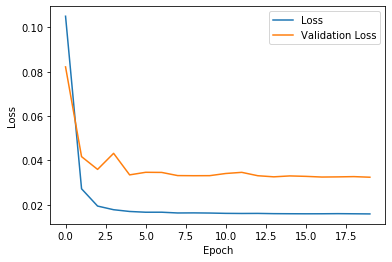

In [31]:
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Restore Checkpoint

In [31]:
checkpoint.restore('C:/Users/IVCL/Desktop/NADS_Net/checkpoints/ckpt-1')

# Test

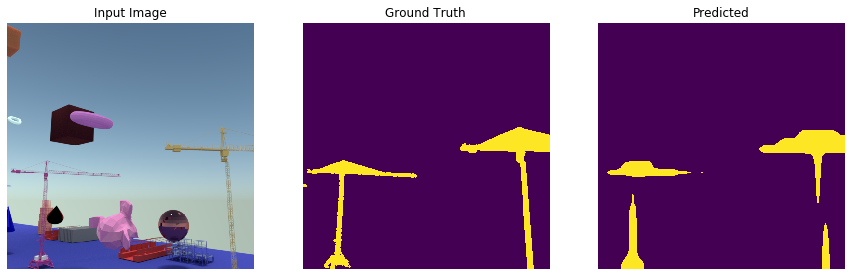

In [32]:
num = 900
image = read_image(test_paths[num])
label = get_label(test_paths[num])
generate_images(NADS_Net, image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


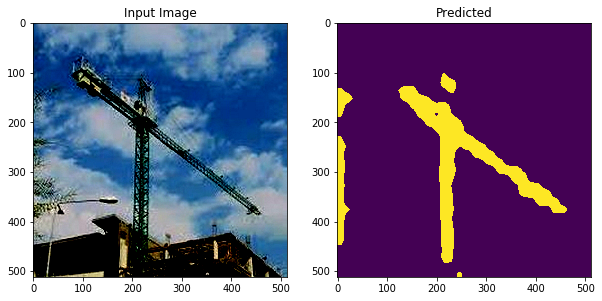

In [35]:
image = read_image('C:/Users/IVCL/Desktop/TC_Real_512/0272.jpg')
image = image[tf.newaxis, ...]
prediction = NADS_Net(image, training=False)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(image[0])
plt.title('Input Image')

plt.subplot(1,2,2)
plt.imshow(tf.where(prediction[0,:,:,0]>= 0.5, 1.0, 0))
plt.title('Predicted')

plt.show()